# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50   0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75   0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00   0.285682        0.204435  0.076846  0.085674  0.193388   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.194292  0.011434  0.039765  0.052914  0.000130  
         0.50  0.184541  0.014747  0.037935  0.060579  0.000468  
         0.75  0.174893  0.018155  0.034722  0.072187  0.000997  
         1.00  0.164537  0.021526  0.030790  0.086852  0.001739

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


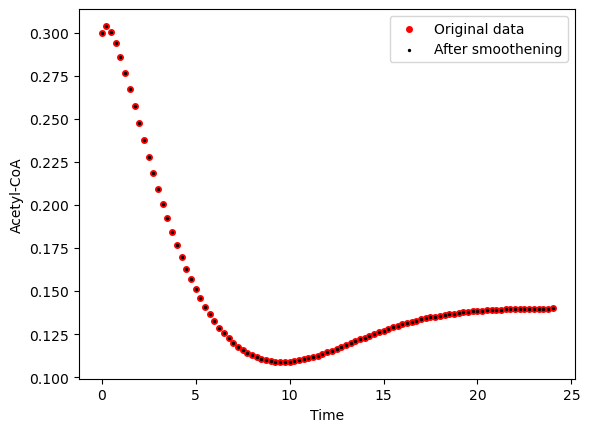

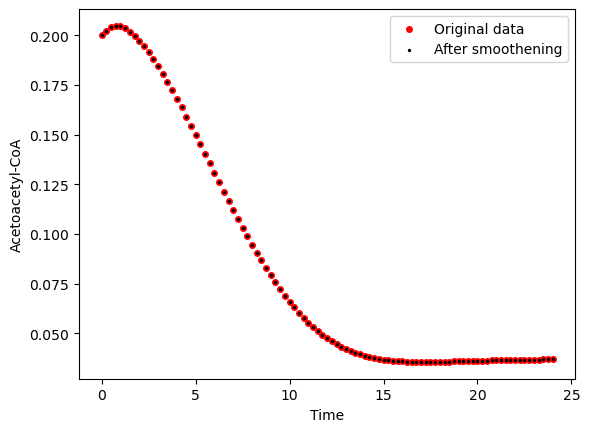

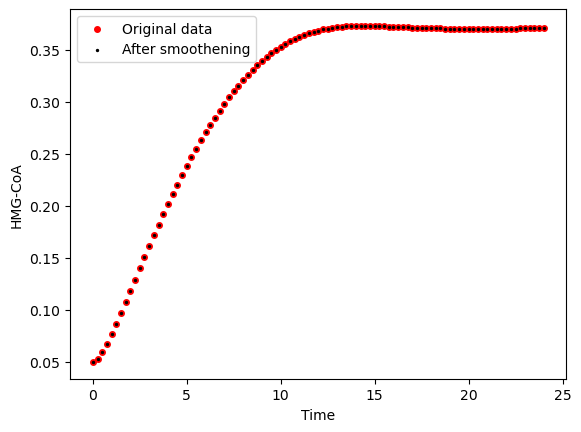

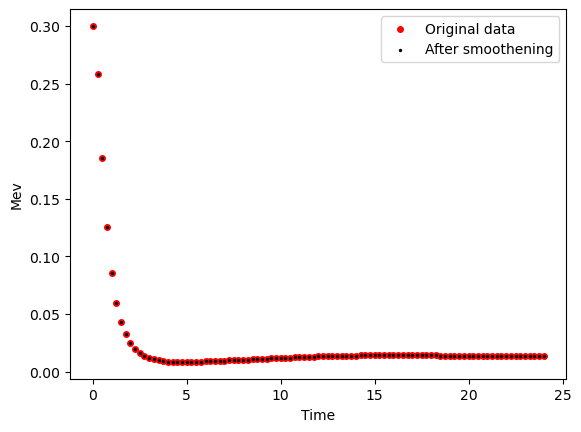

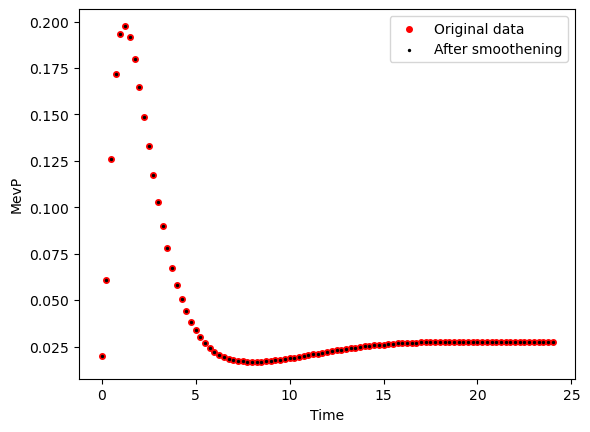

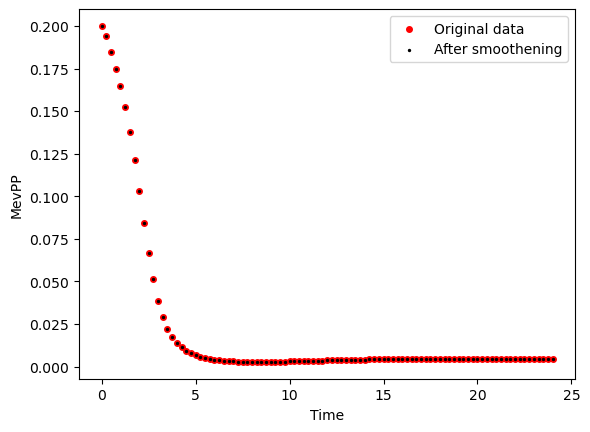

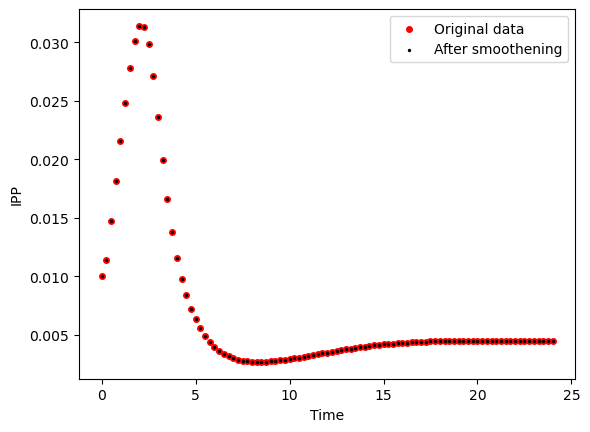

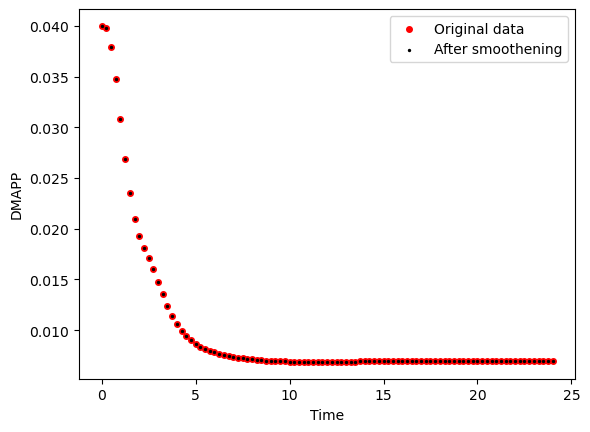

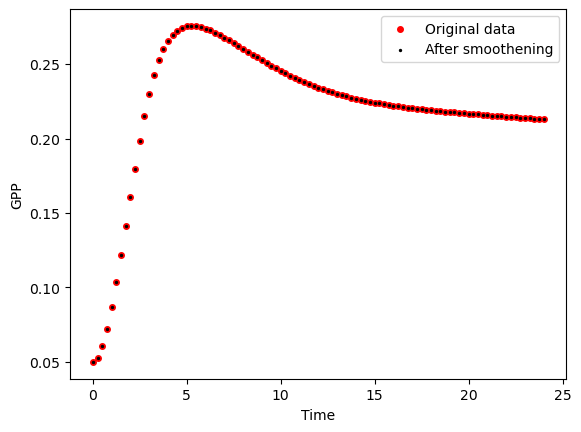

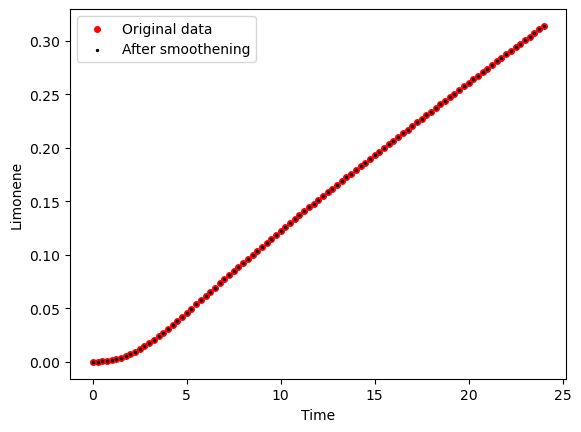

Strain Strain 2


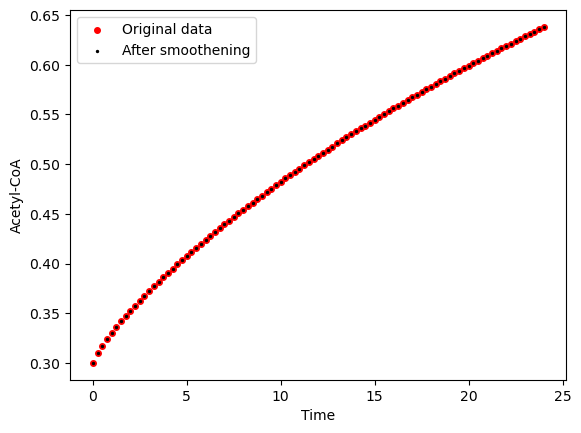

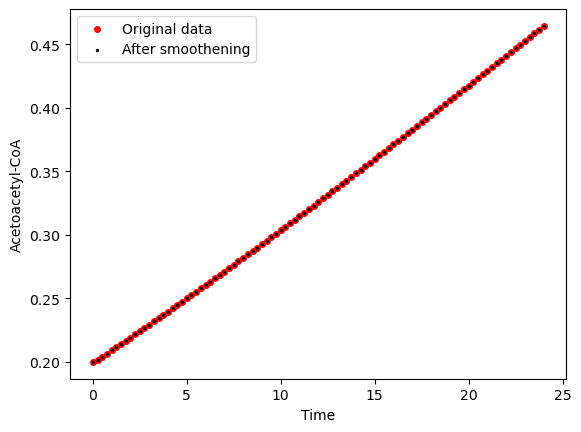

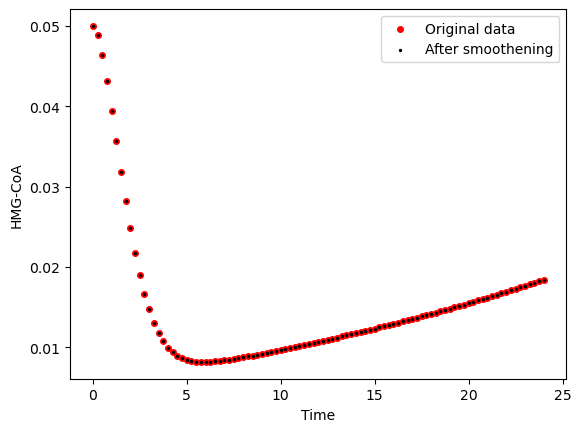

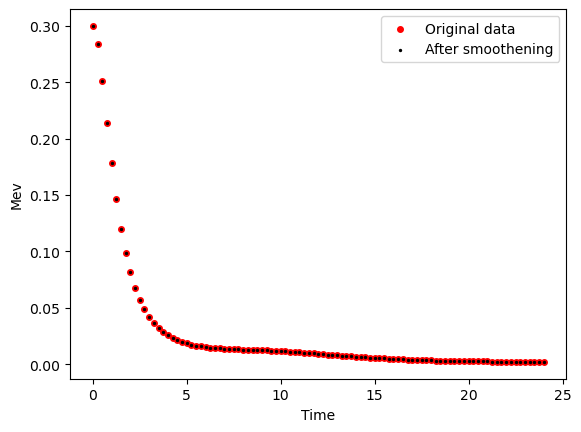

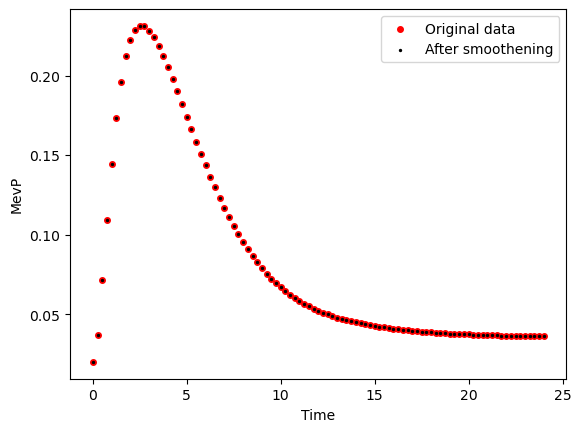

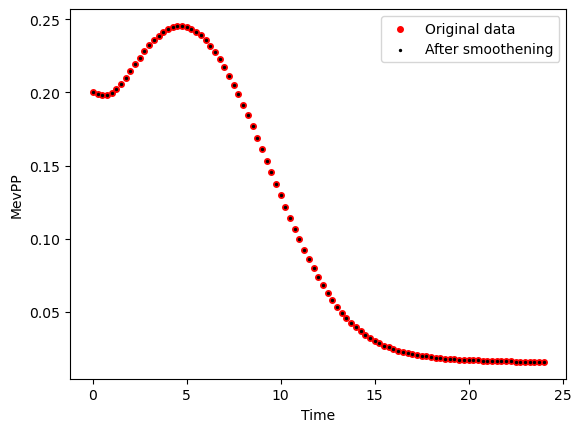

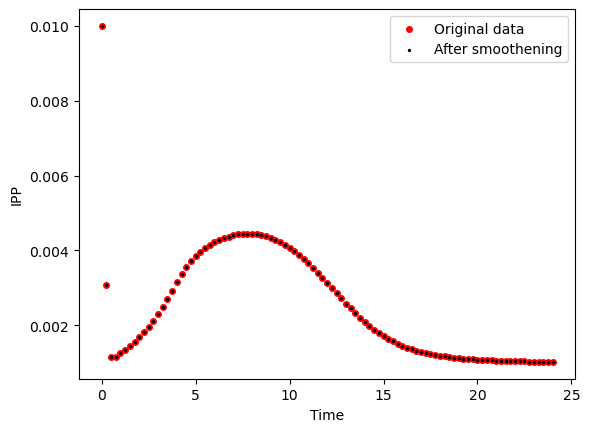

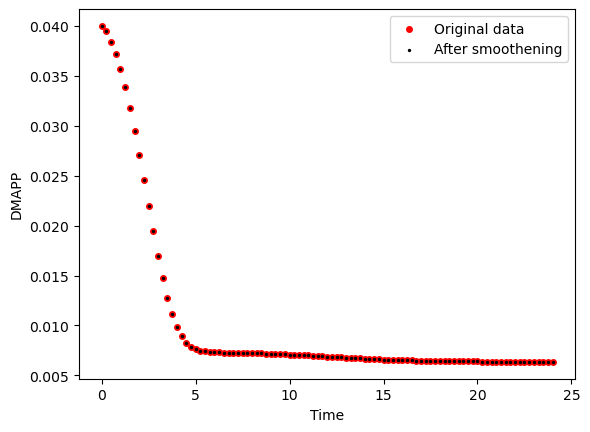

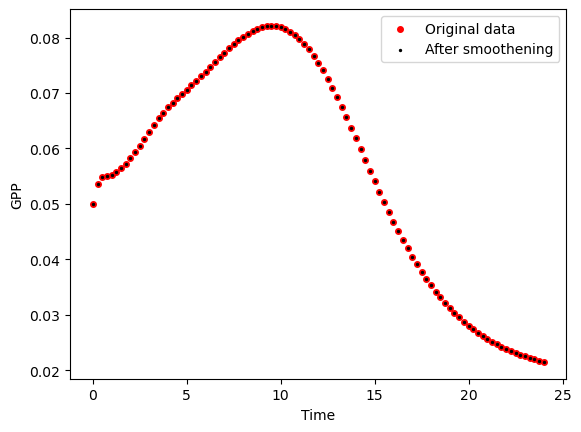

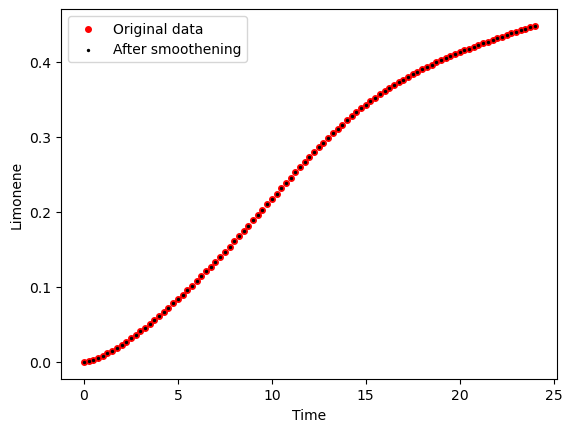

Strain Strain 3


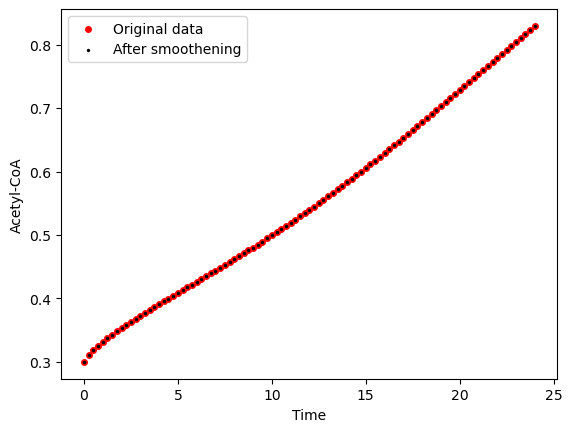

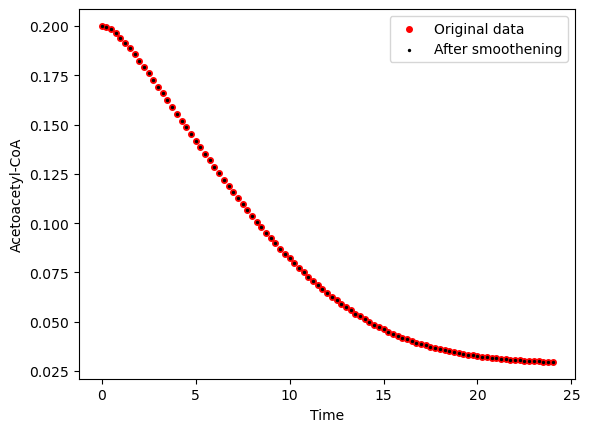

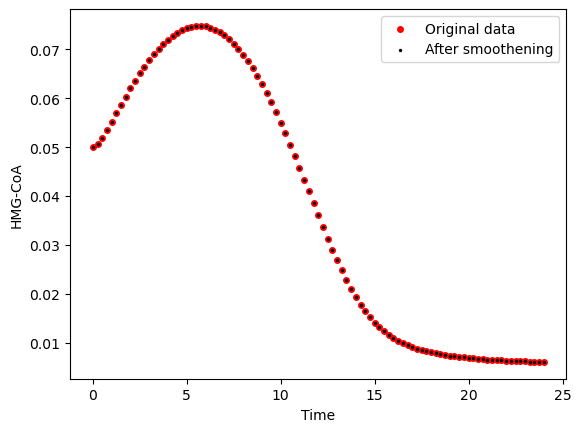

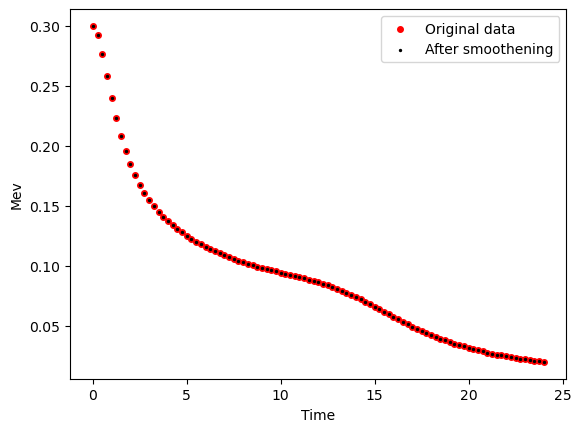

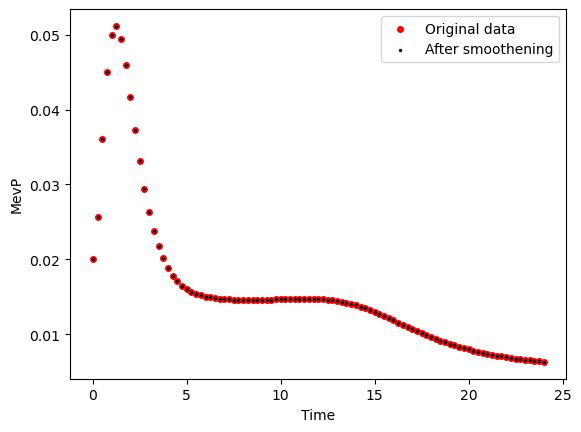

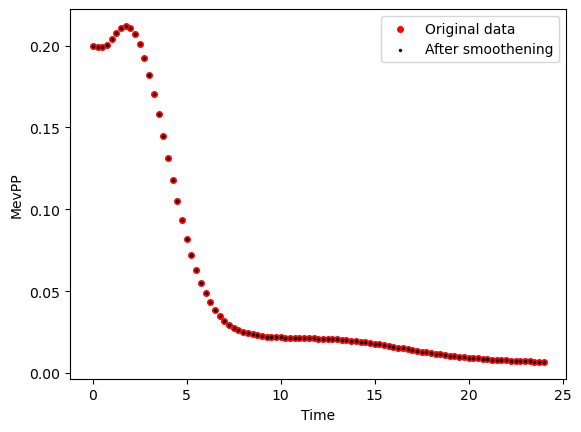

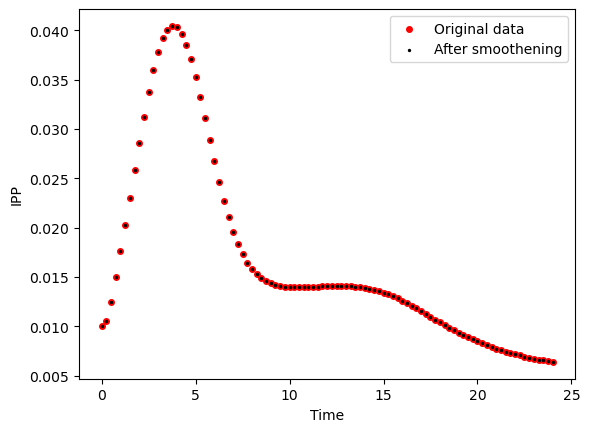

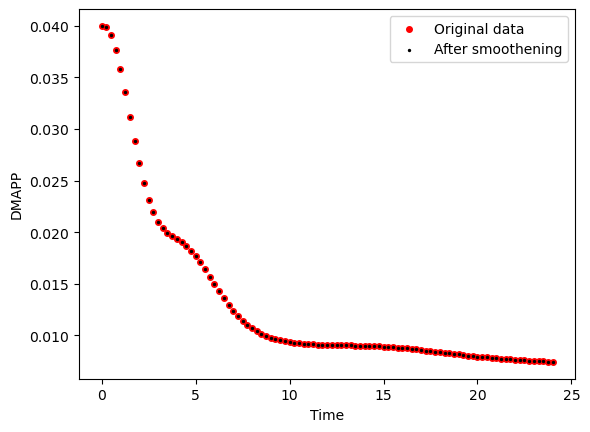

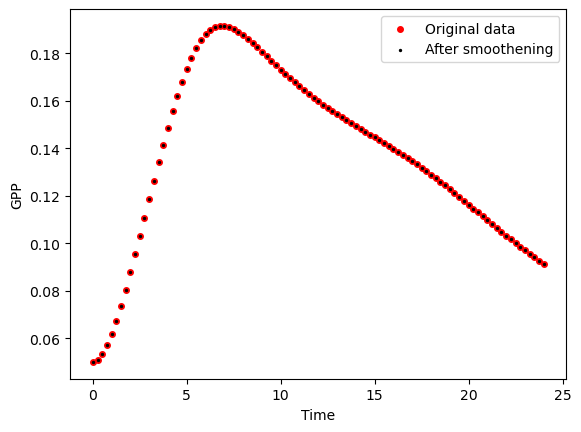

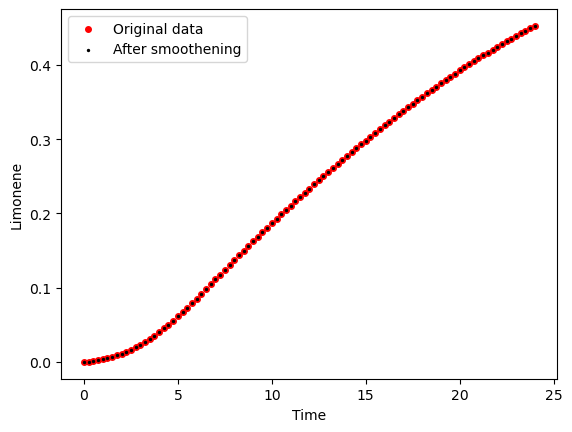

Strain WT


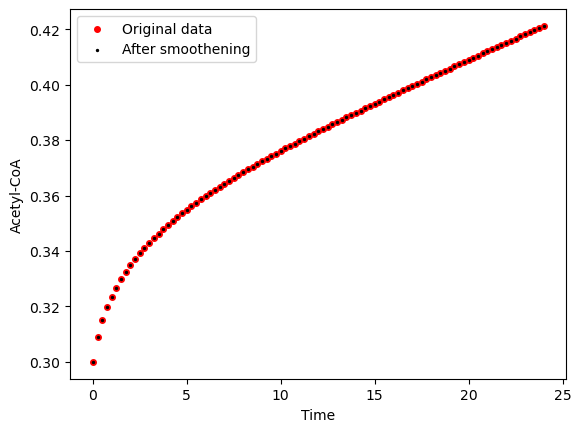

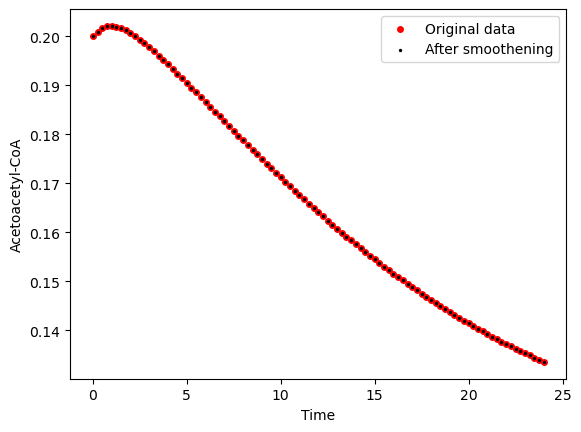

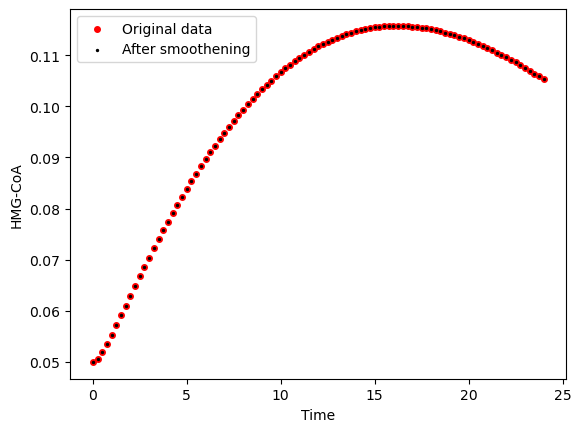

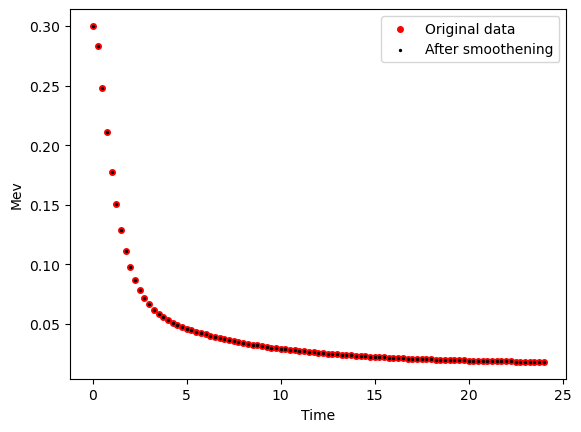

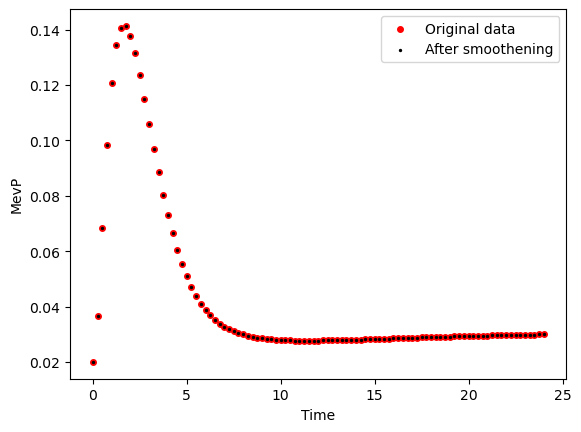

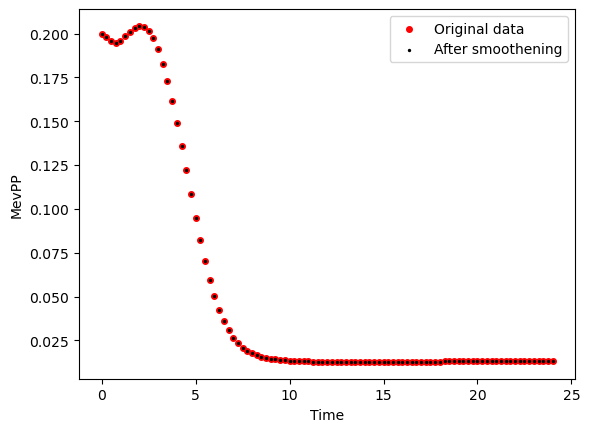

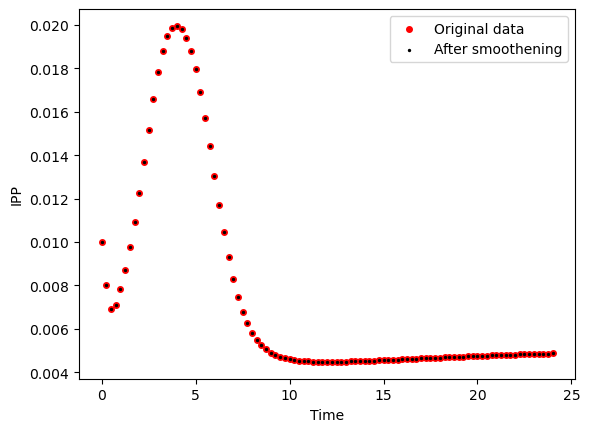

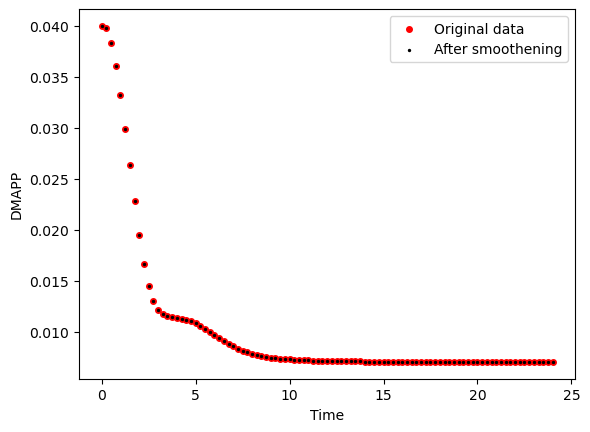

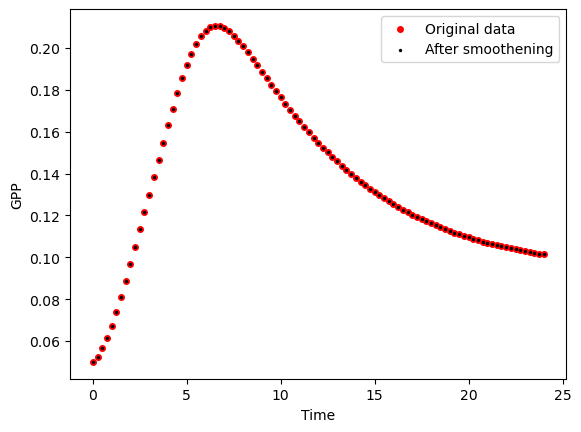

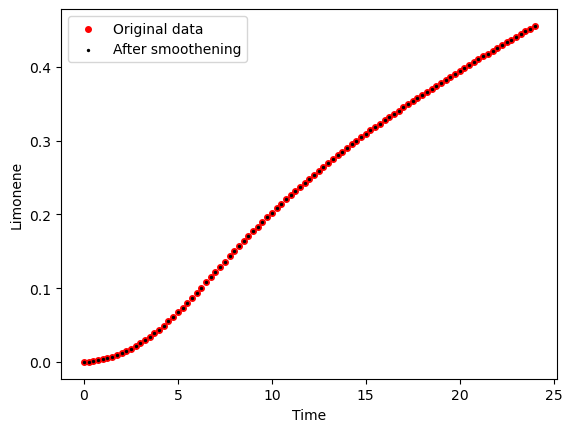

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


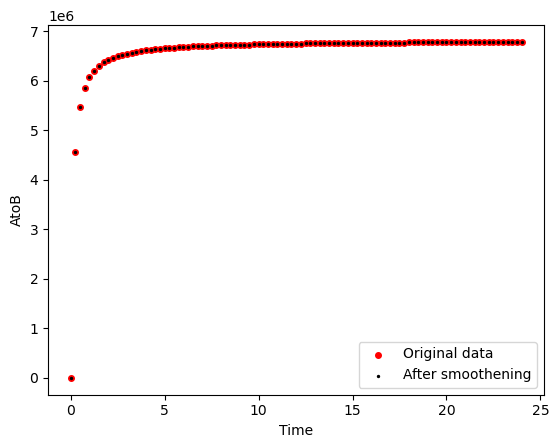

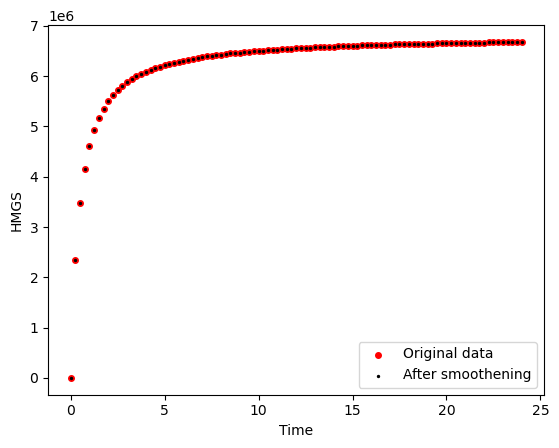

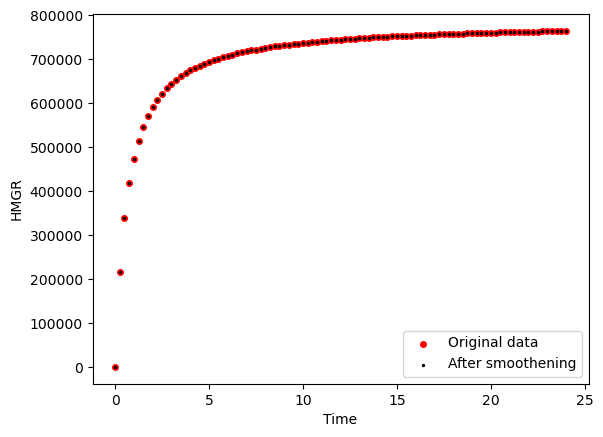

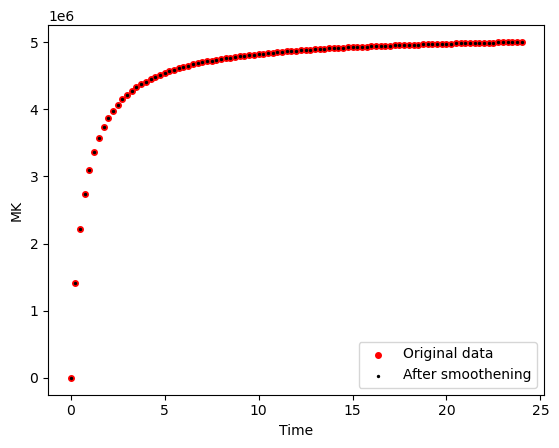

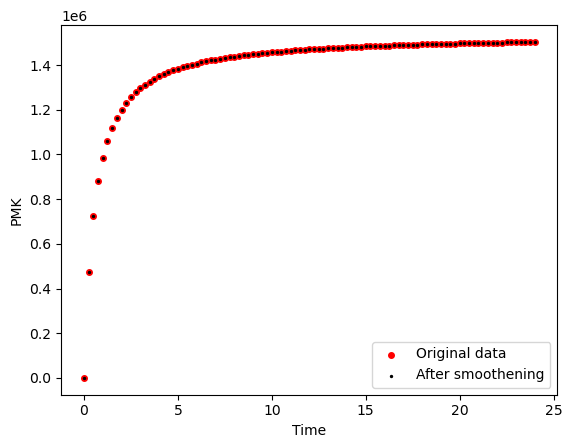

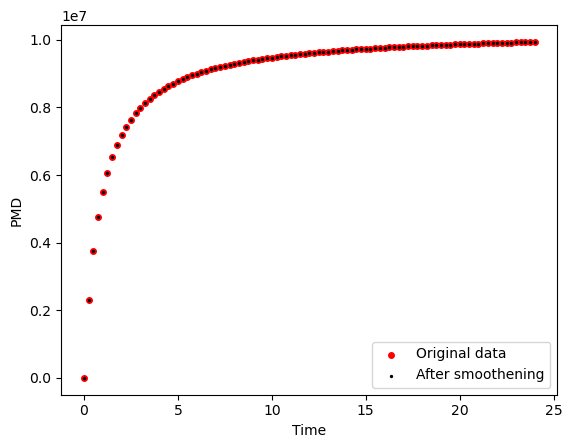

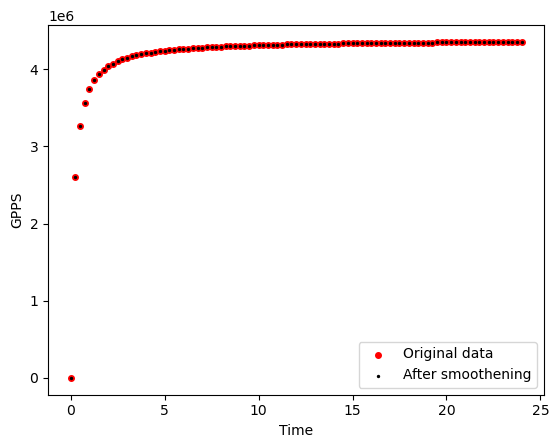

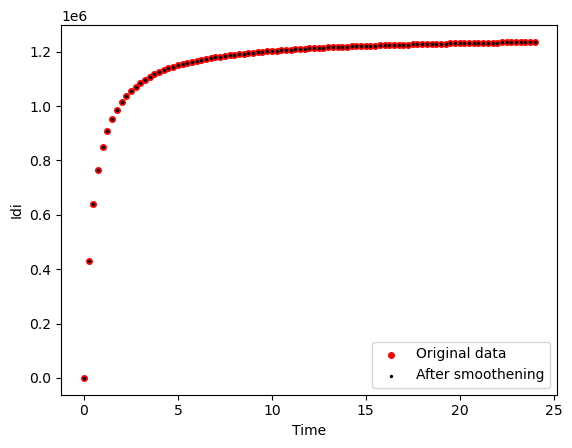

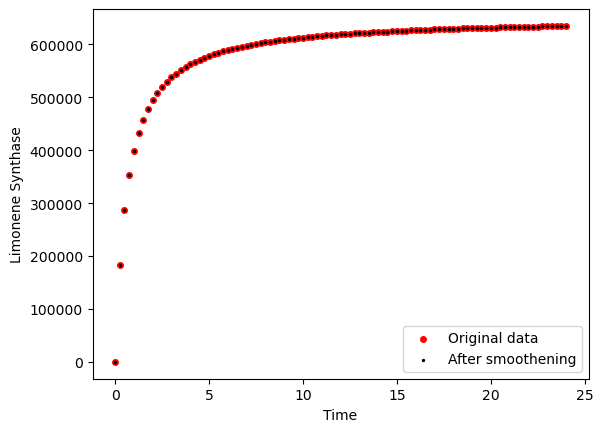

Strain Strain 2


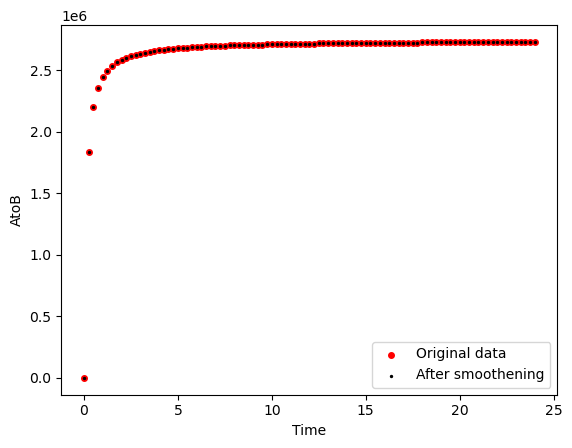

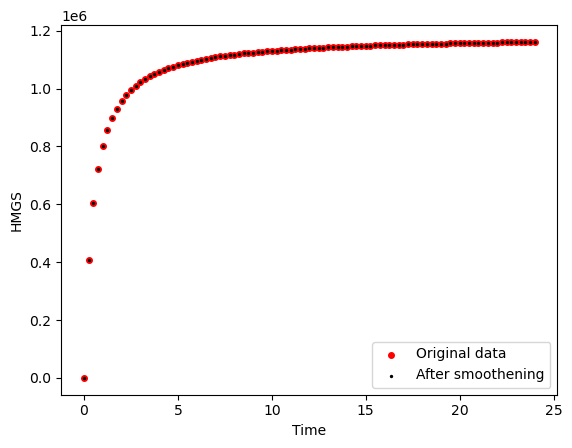

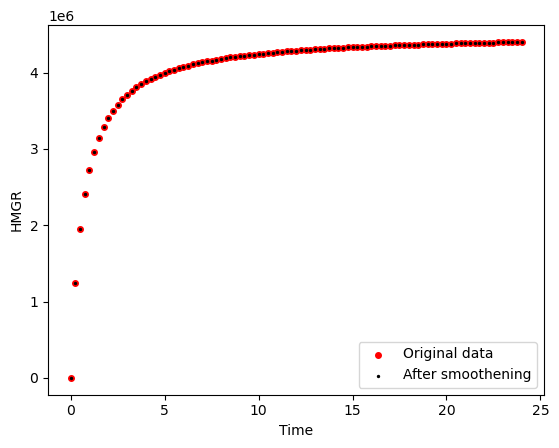

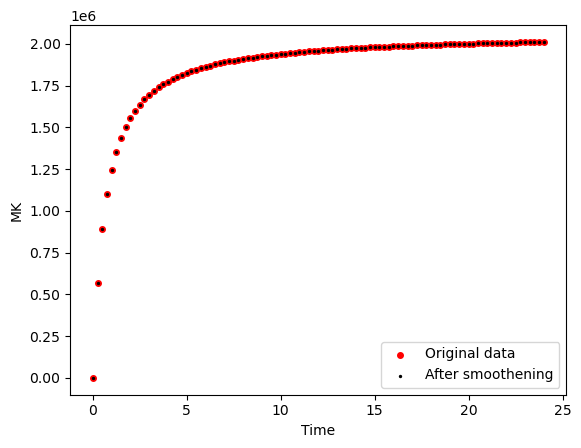

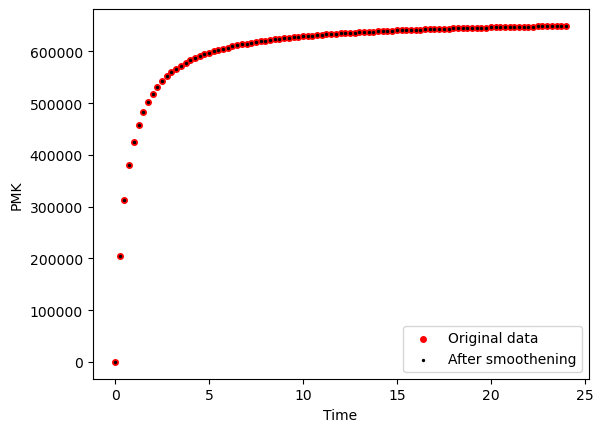

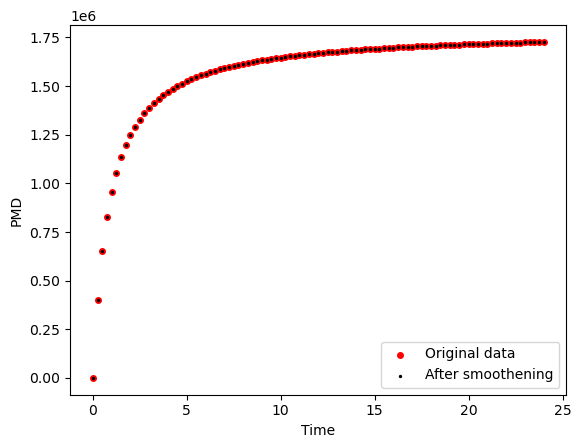

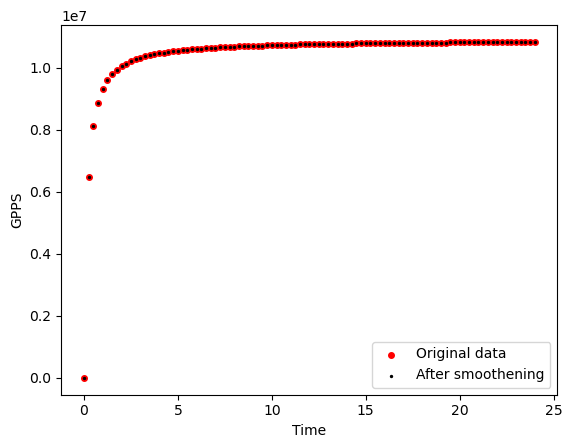

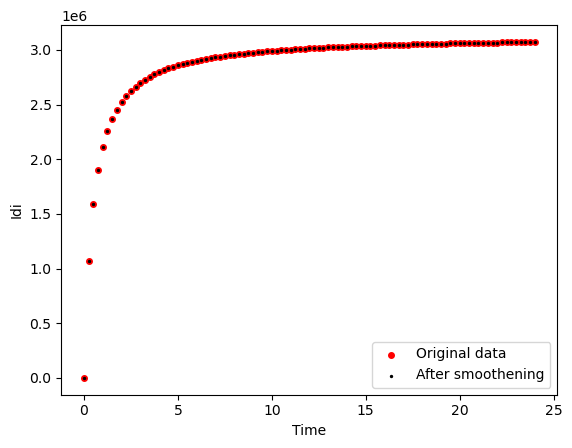

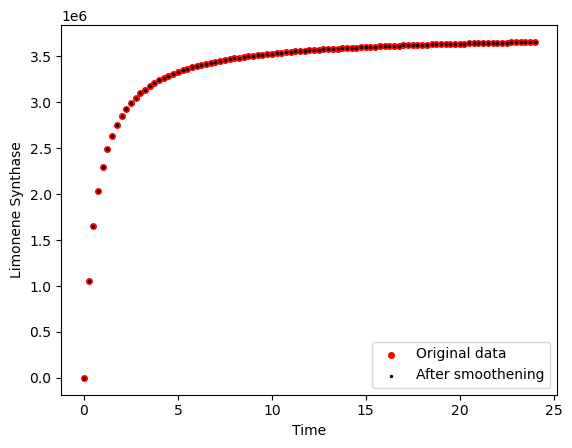

Strain Strain 3


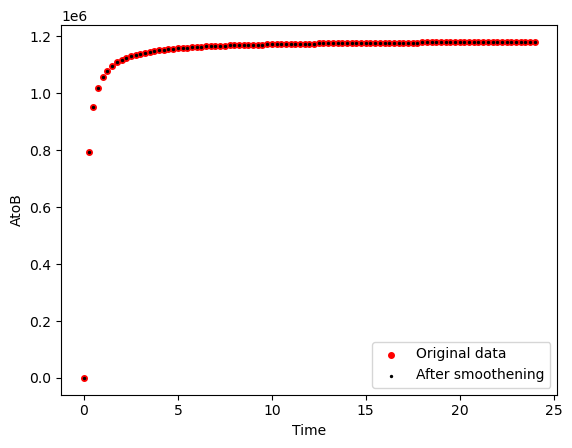

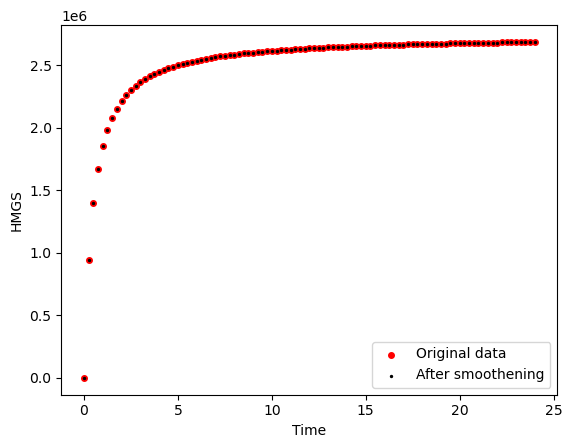

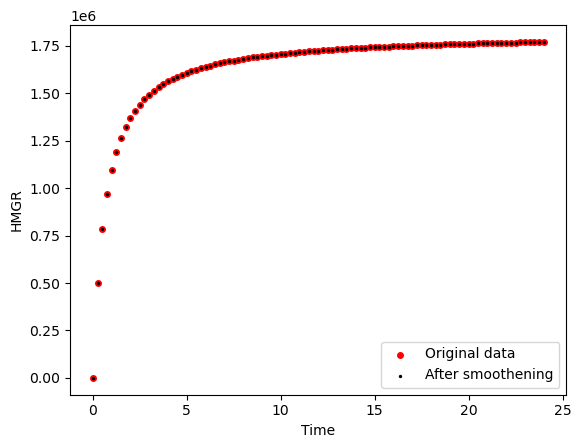

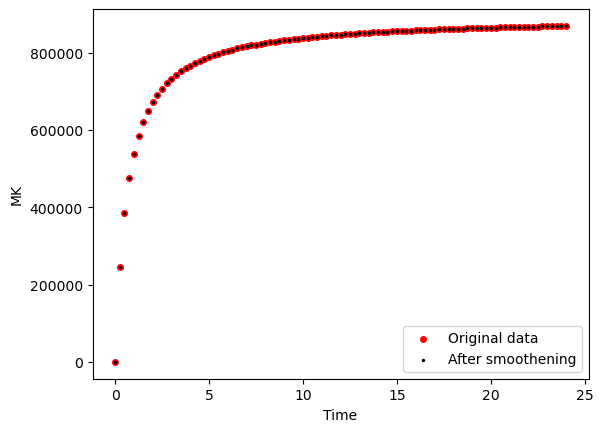

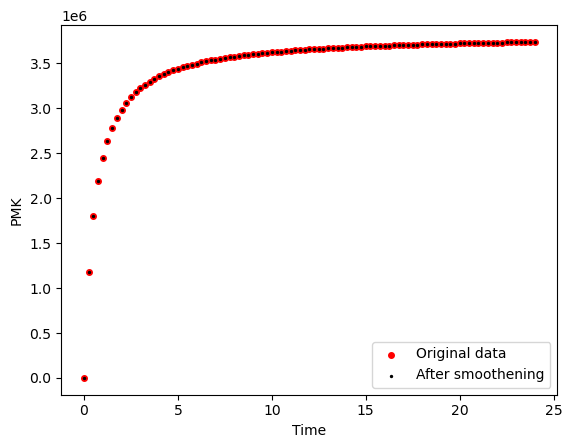

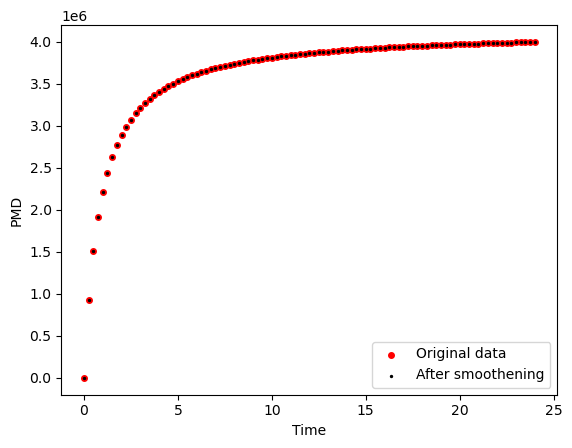

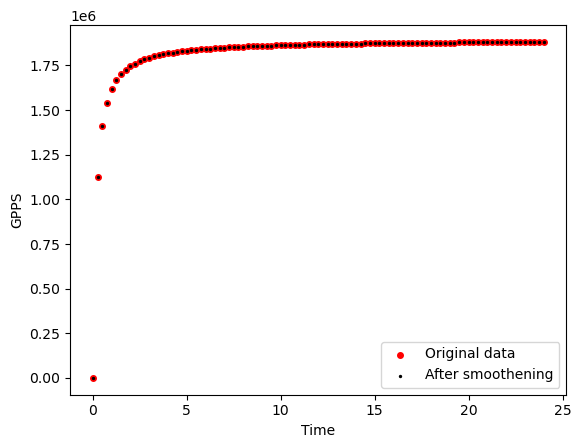

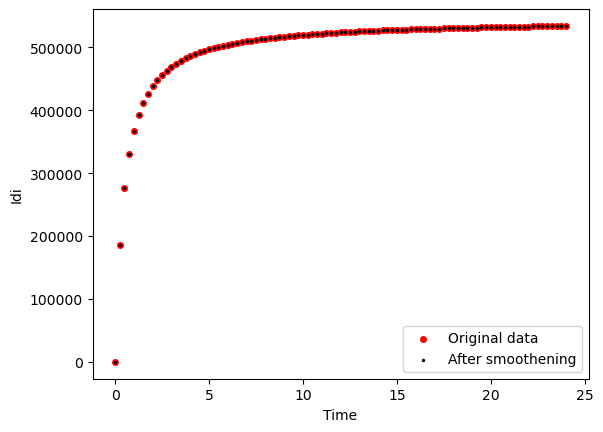

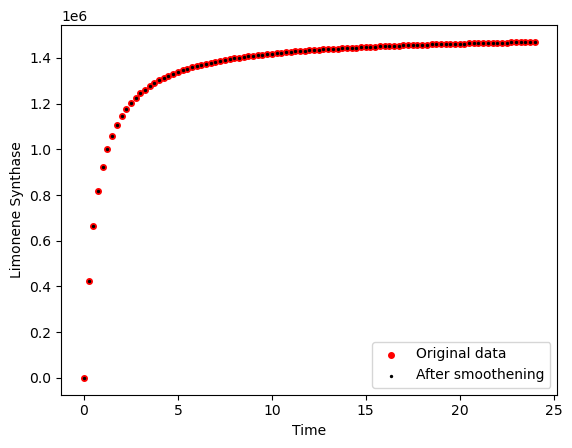

Strain WT


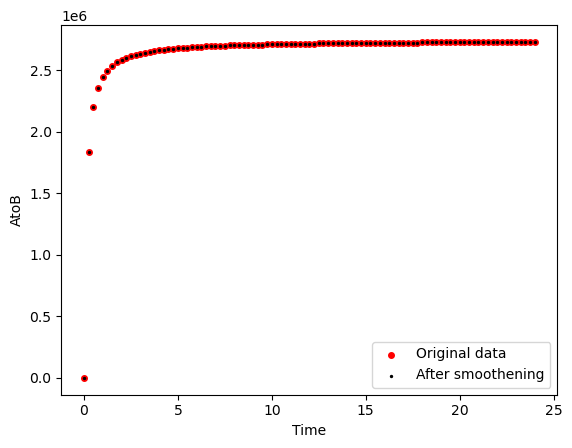

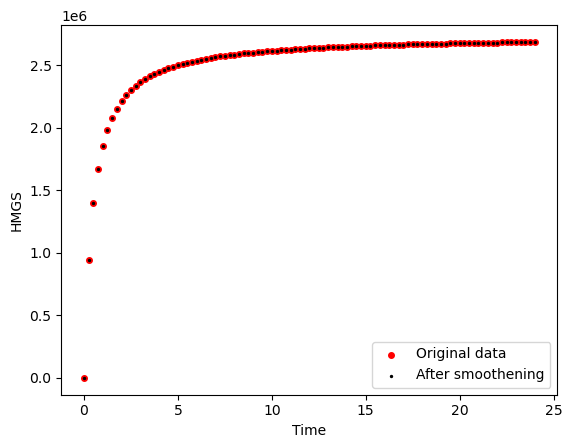

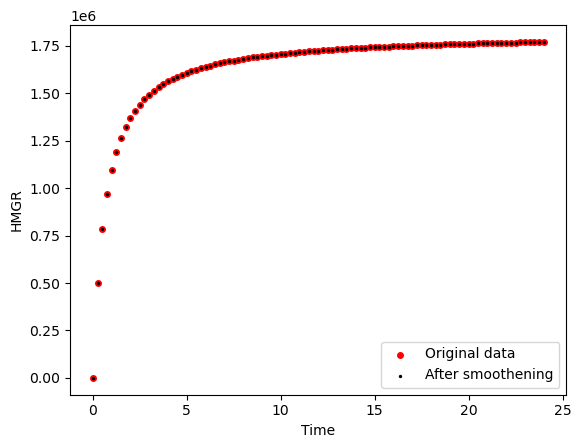

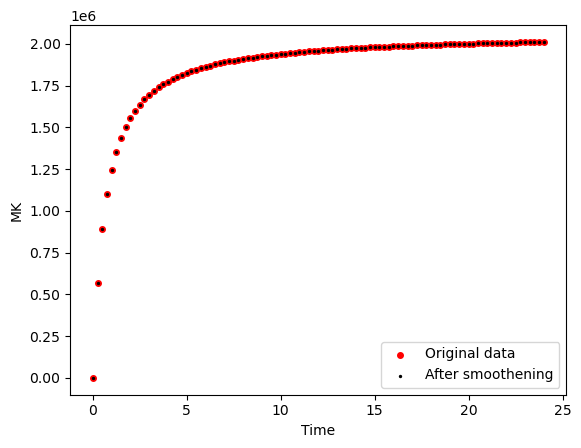

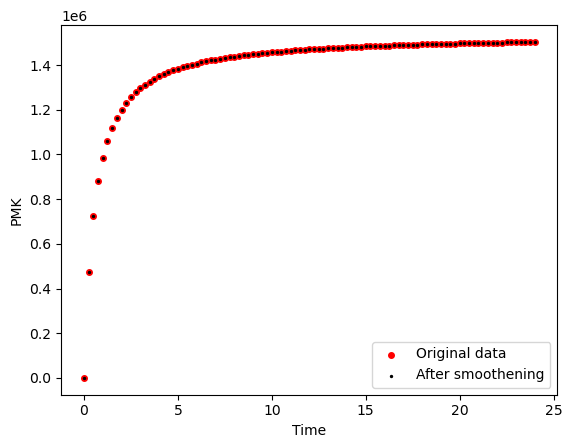

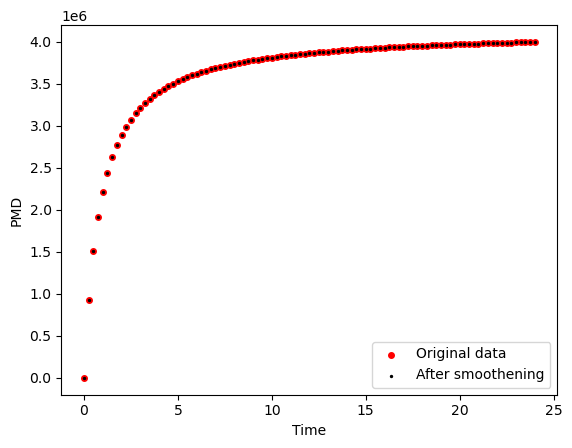

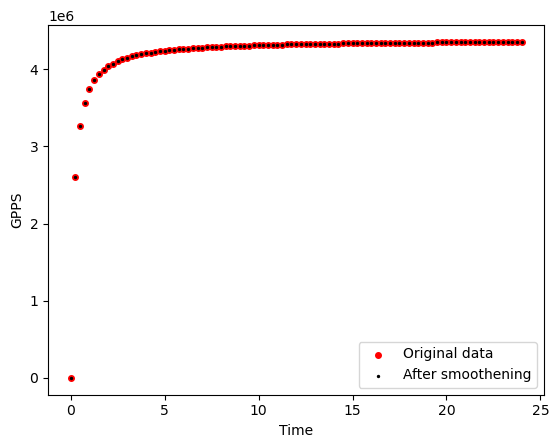

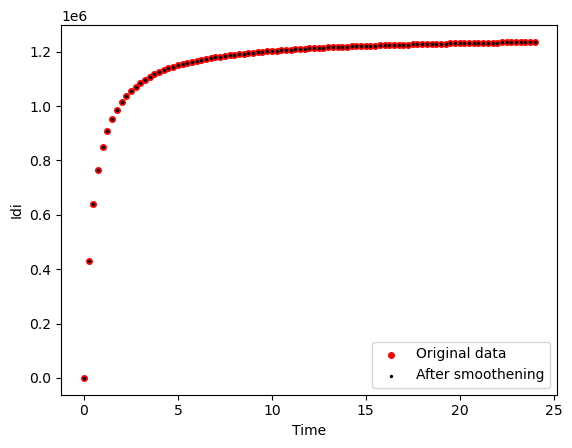

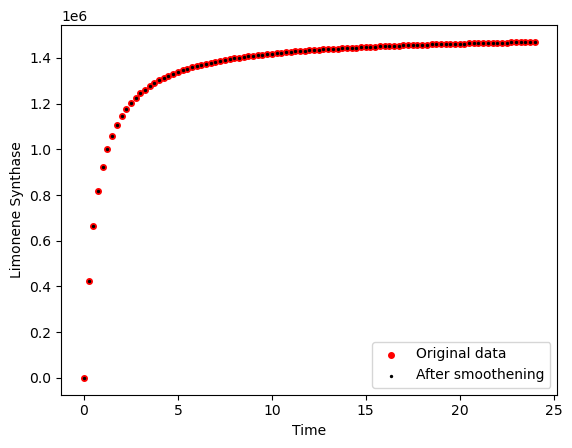

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50    0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75    0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00    0.285682        0.204435  0.076846  0.085674  0.193388   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.418135        0.135344  0.107524  0.018433  0.029820   
         23.25   0.418894        0.134891  0.106975  0.018376  0.029853   
         23.50   0.419652        0.134446  0.106413  0.018321  0.029884   
         23.75   0.420408        0.134009  0.105838  0.018268  0.029914   
         24.00   0.421163        0.133581  0.105252  0.018217  0.029943   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.194292  0.011434  0.039765  0.052914  0.000130  ...   
         0.50   0.184541  0.014747  0.037935  0.060579  0.000468  ...   
         0.75   0.174893  0.018155  0.034722  0.072187  0.000997  ...   
         1.00   0.164537  0.021526  0.030790  0.086852  0.001739  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.013294  0.004839  0.007023  0.102943  0.440720  ...   
         23.25  0.013307  0.004846  0.007023  0.102536  0.444453  ...   
         23.50  0.013319  0.004852  0.007023  0.102148  0.448172  ...   
         23.75  0.013331  0.004858  0.007022  0.101776  0.451879  ...   
         24.00  0.013342  0.004864  0.007022  0.101420  0.455574  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

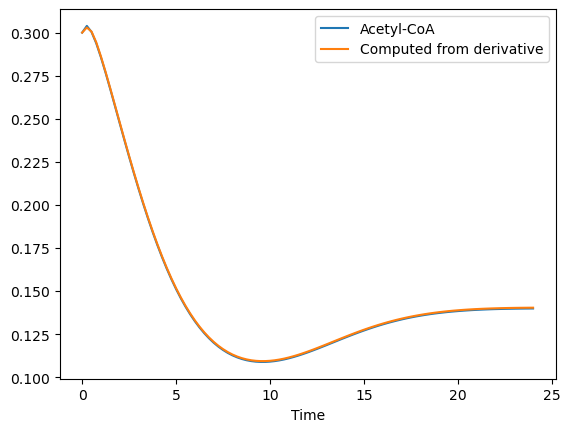

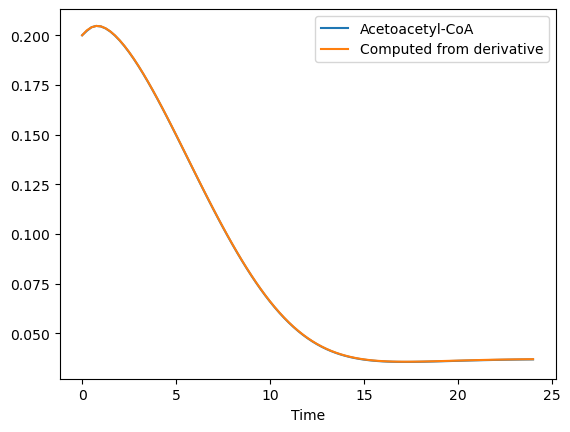

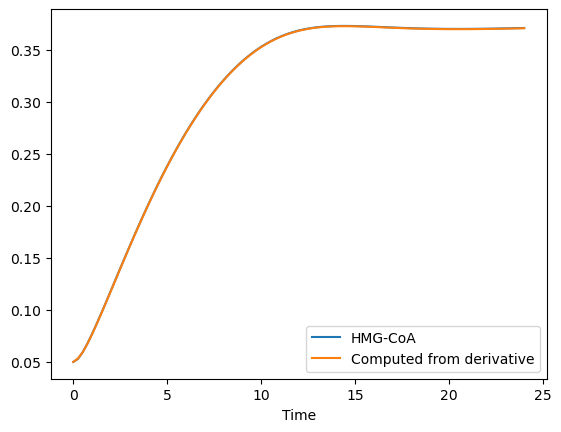

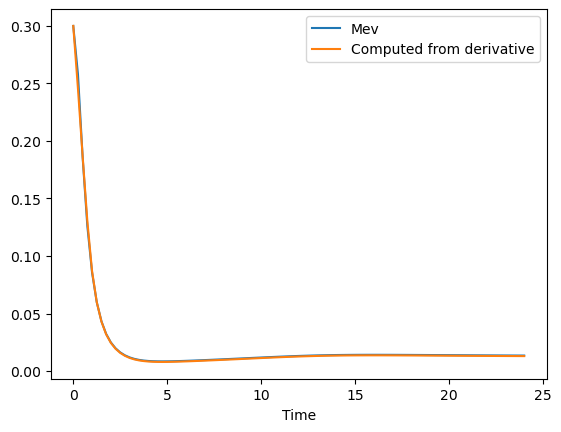

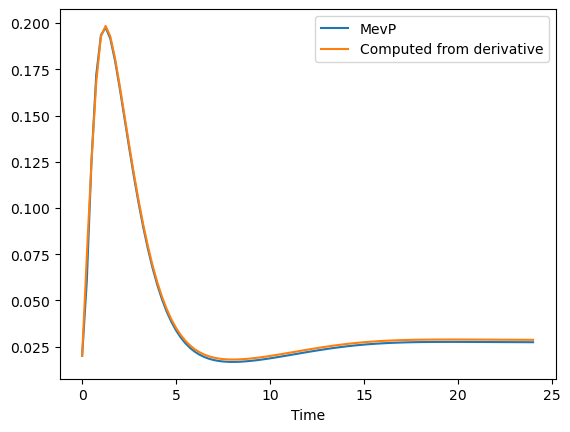

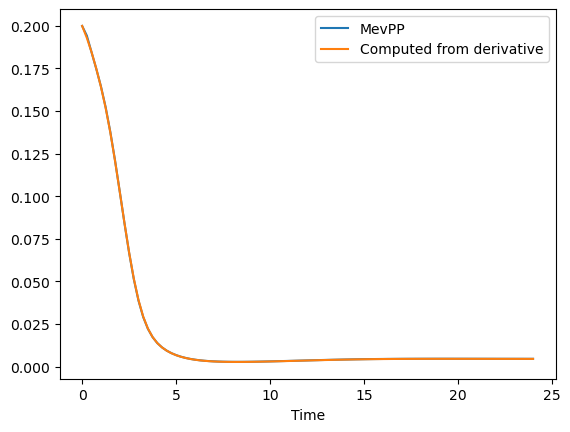

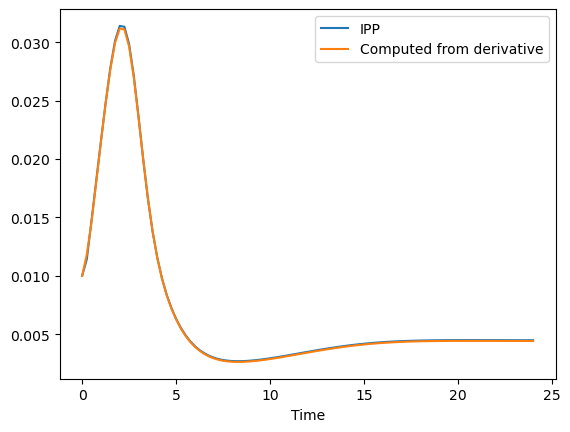

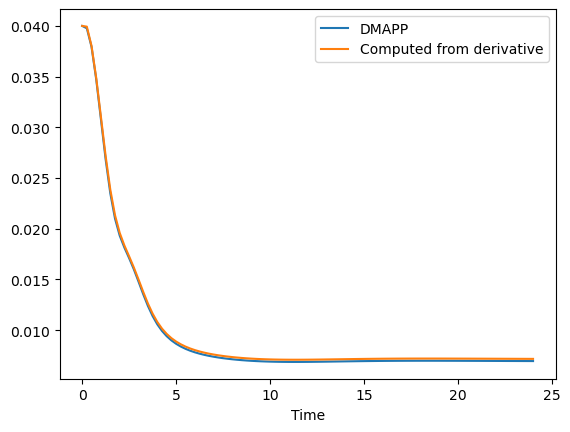

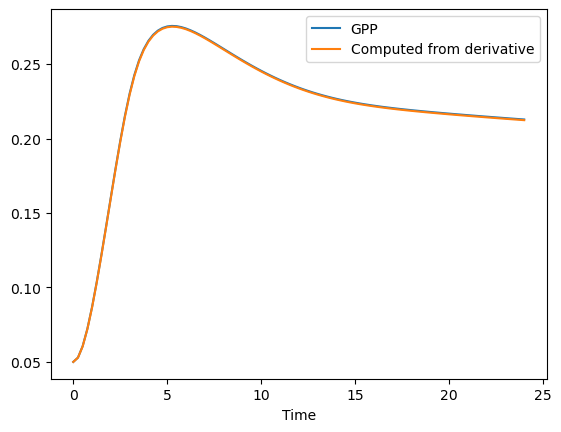

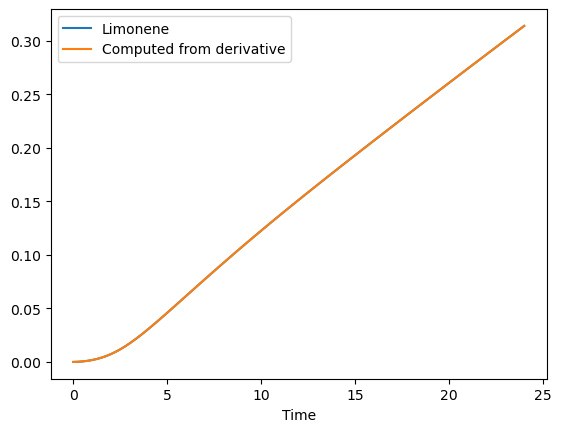

'Time profile from derivative vs. actual profile for Strain 2'

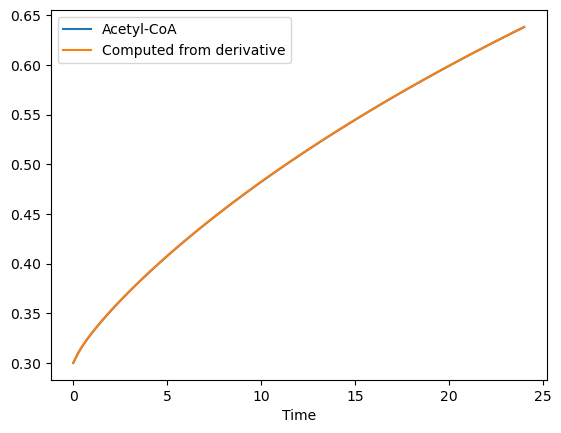

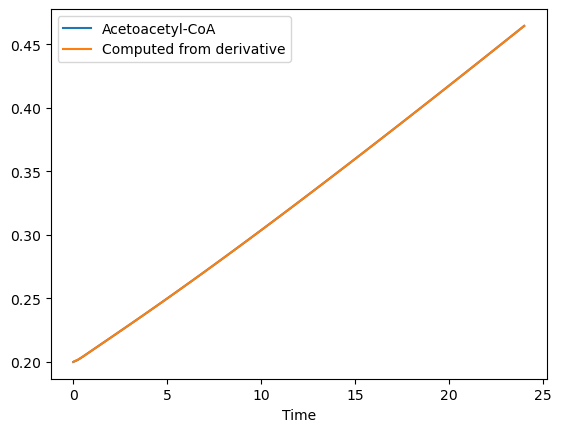

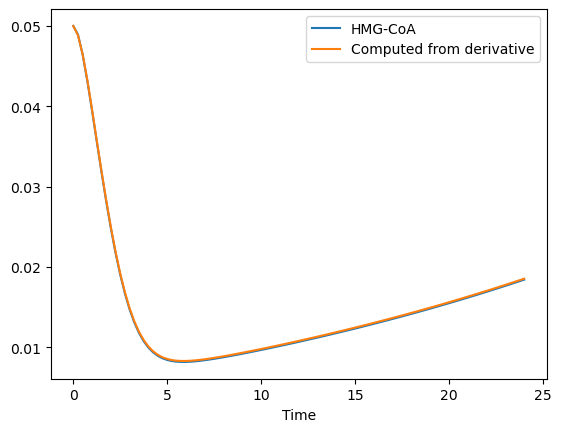

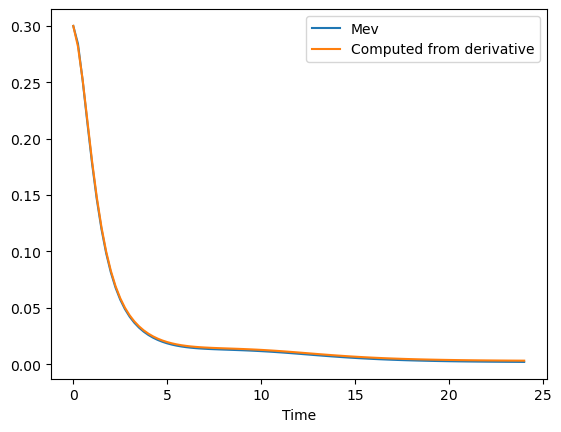

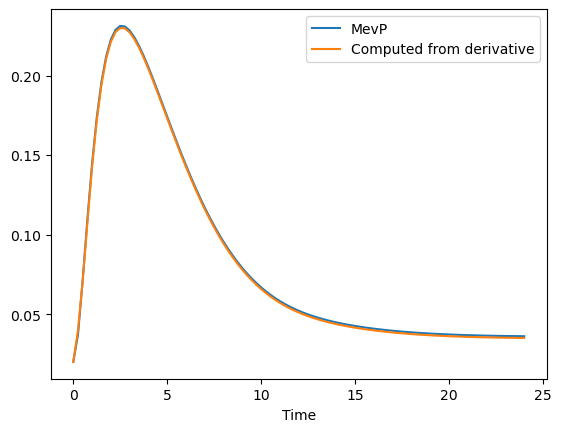

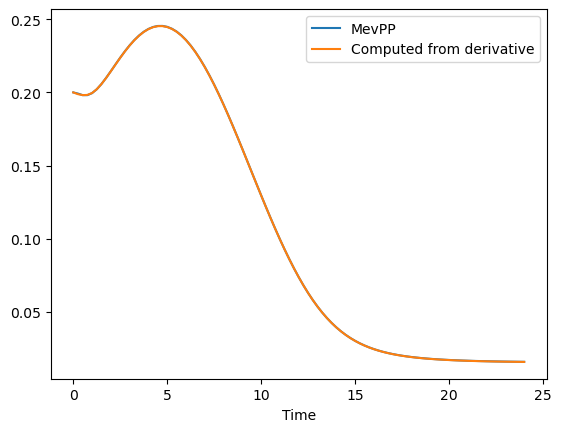

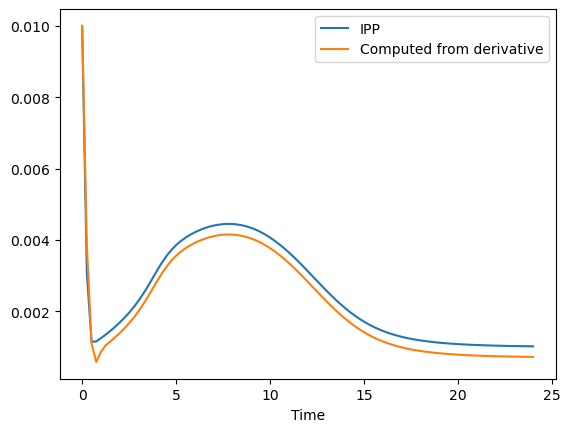

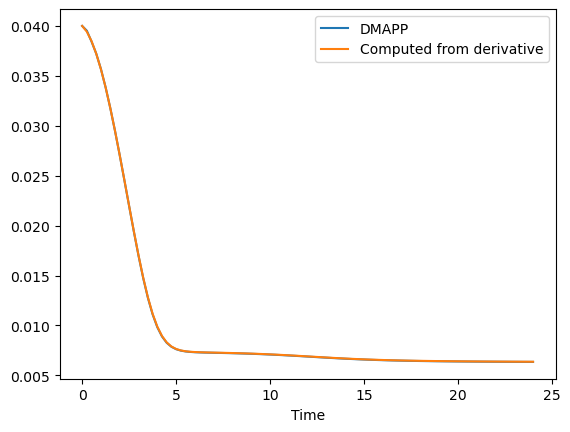

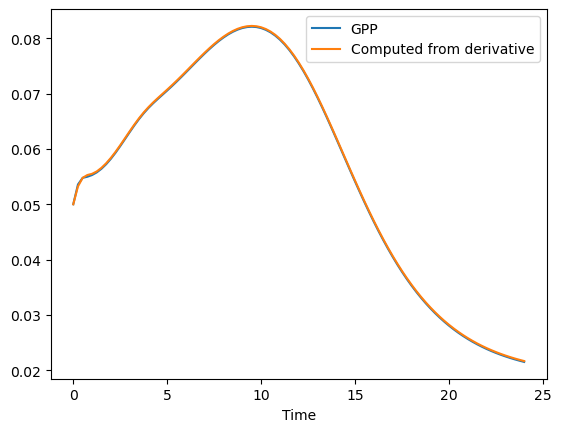

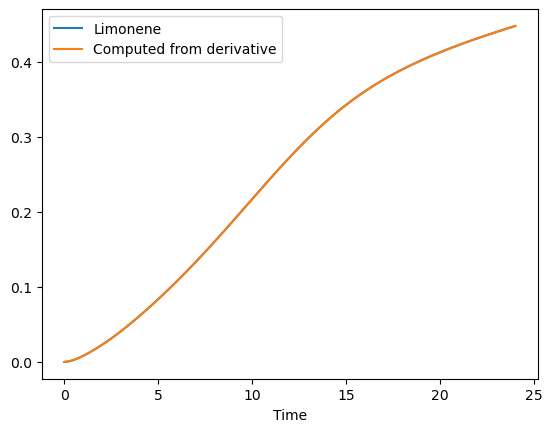

'Time profile from derivative vs. actual profile for Strain 3'

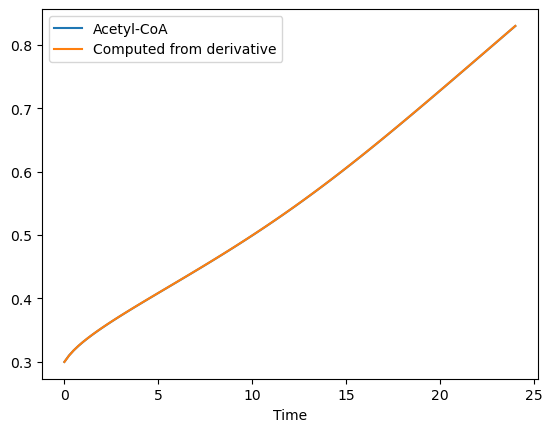

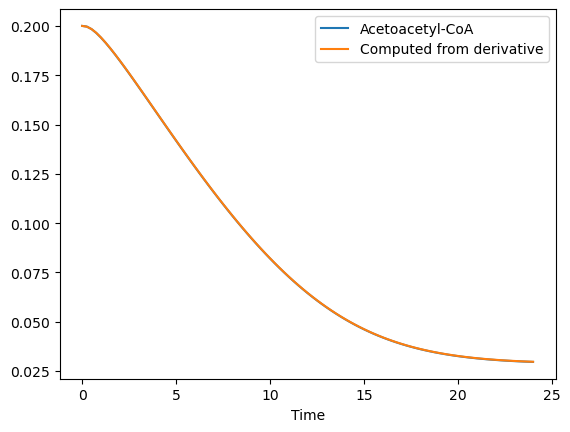

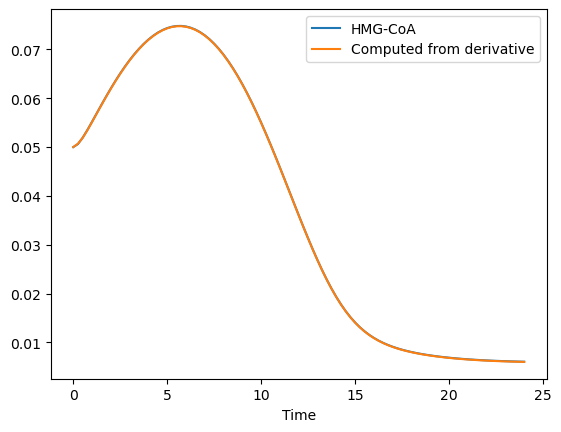

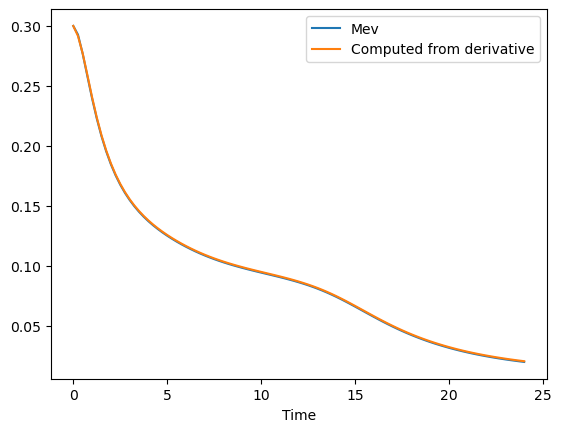

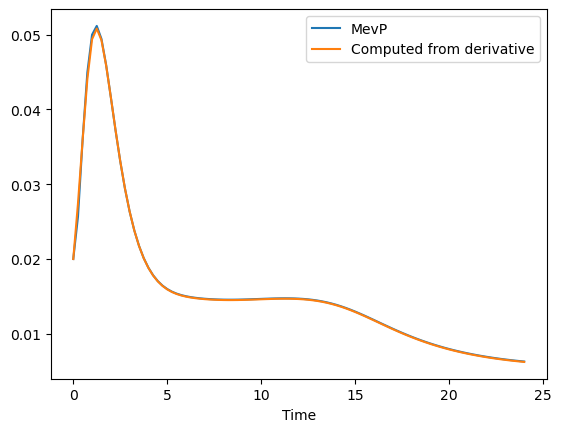

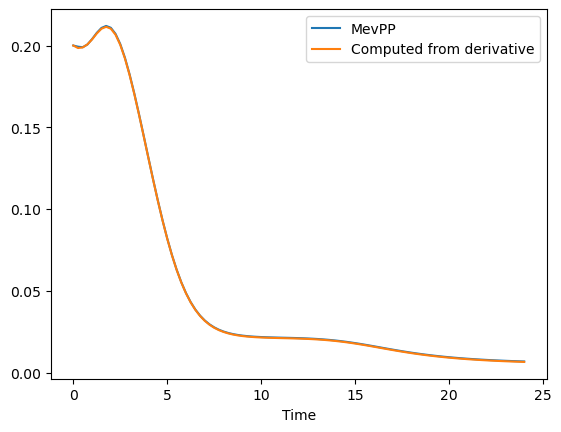

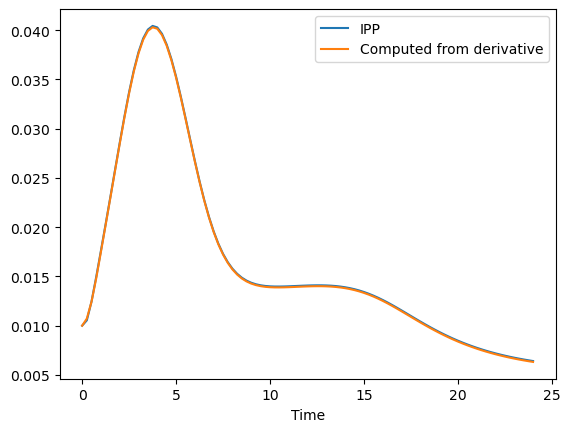

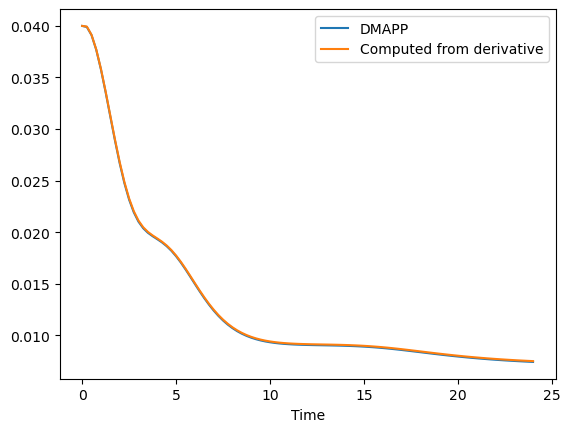

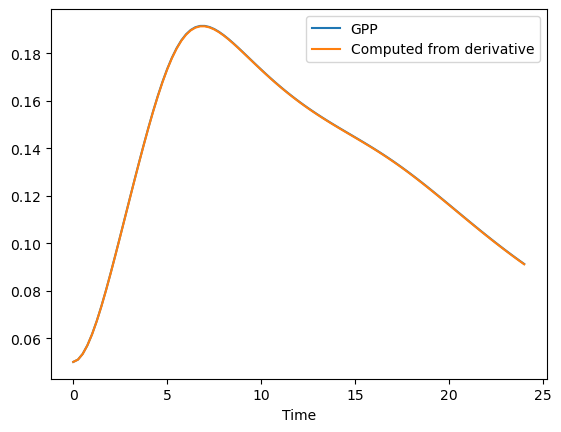

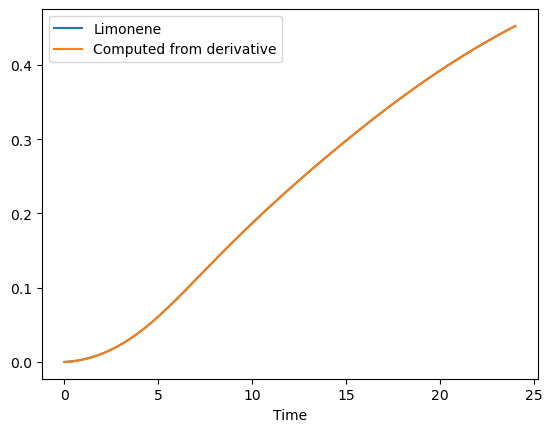

'Time profile from derivative vs. actual profile for WT'

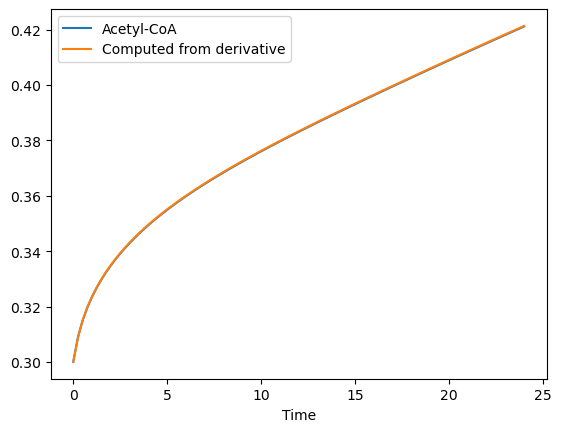

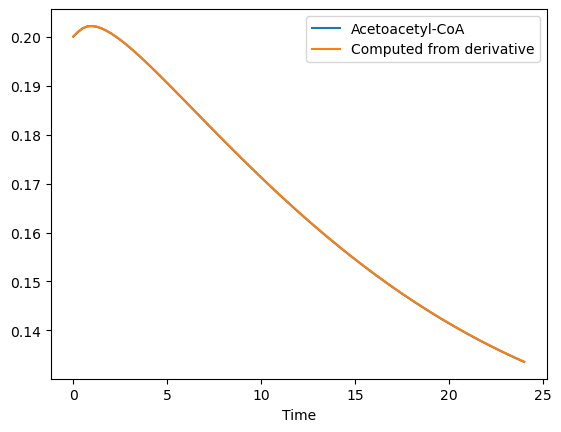

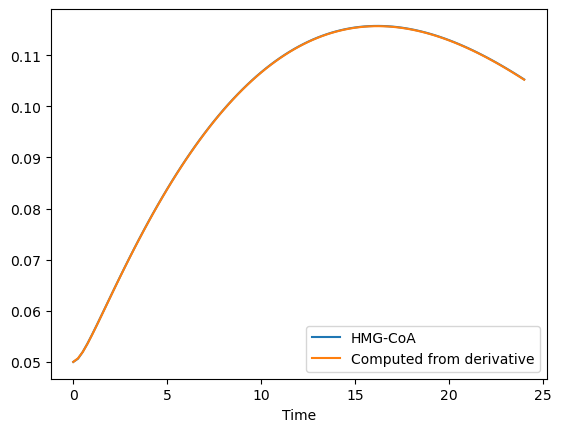

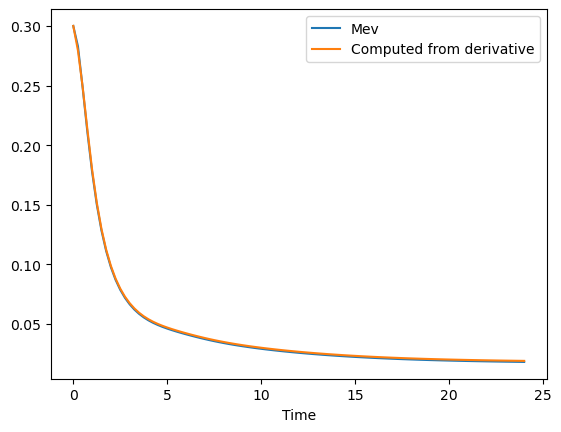

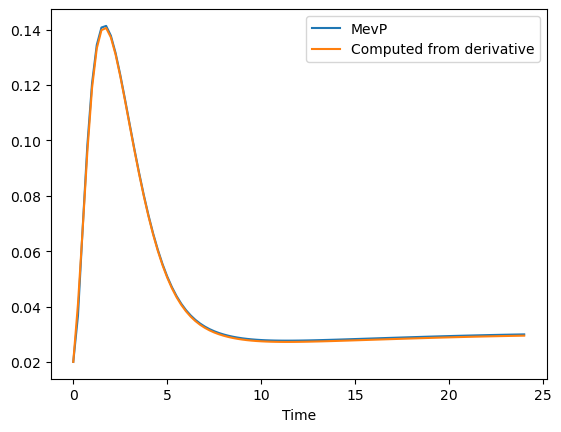

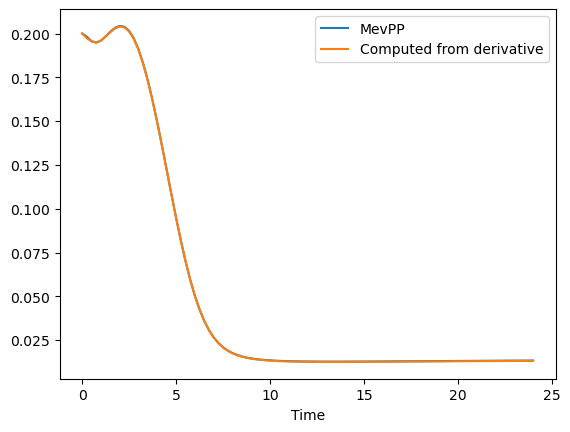

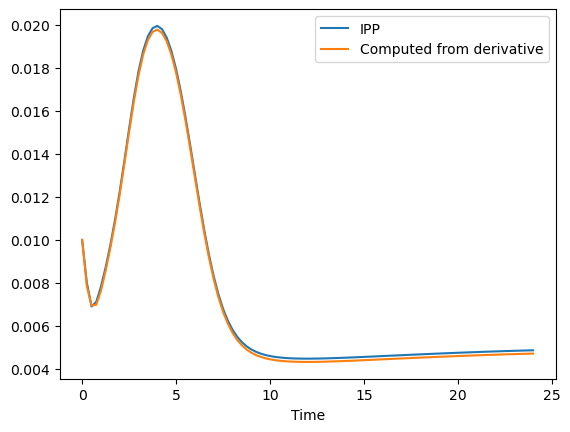

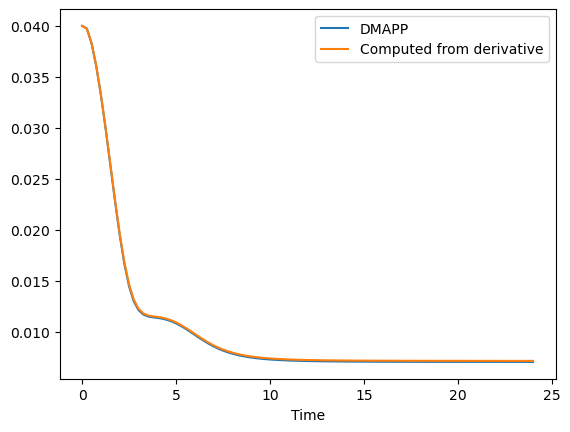

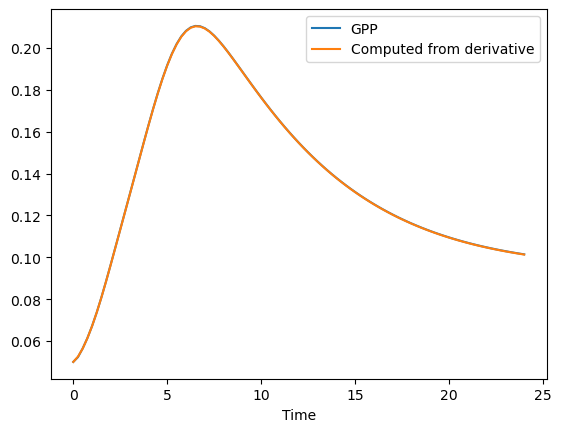

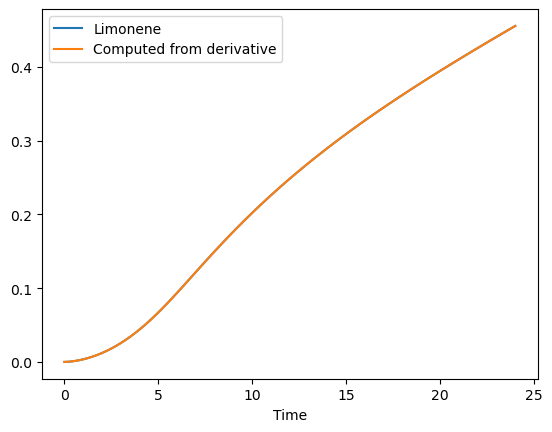

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303889        0.202239  0.052901   
         0.50       2.866143e+05   0.300366        0.204051  0.059318   
         0.75       3.524272e+05   0.293825        0.204705  0.067553   
         1.00       3.981392e+05   0.285682        0.204435  0.076846   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.418135        0.135344  0.107524   
         23.25      1.468435e+06   0.418894        0.134891  0.106975   
         23.50      1.468851e+06   0.419652        0.134446  0.106413   
         23.75      1.469260e+06   0.420408        0.134009  0.105838   
         24.00      1.469659e+06   0.421163        0.133581  0.105252   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257973  0.060732  0.194292  0.011434  0.039765  0.052914   
         0.50   0.185505  0.126153  0.184541  0.014747  0.037935  0.060579   
         0.75   0.125893  0.171899  0.174893  0.018155  0.034722  0.072187   
         1.00   0.085674  0.193388  0.164537  0.021526  0.030790  0.086852   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.018433  0.029820  0.013294  0.004839  0.007023  0.102943   
         23.25  0.018376  0.029853  0.013307  0.004846  0.007023  0.102536   
         23.50  0.018321  0.029884  0.013319  0.004852  0.007023 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         24.00  0.000044  0.000023 -0.000001 -0.001390  0.014756  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,
                             -12.0,0.0,-12.0,-12.0,
                             0.0,-12.0,-12.0,0.0,
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,-12.0,
                             0.0,0.0,
                             -12.0,-12.0,-12.0,
                             0.0,-12.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0,0.0,
                             0.0,0.0,0.0,
                             0.0,12.0,0.0,0.0,
                             12.0,0.0,0.0,12.0,
                             0.0,0.0,
                             0.0,0.0,0.0,0.0,
                             12.0,12.0,
                             0.0,0.0,0.0,
                             12.0,0.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       kma11,kcat1,
                       kma21,kma22,kcat2,
                       kma33,kI31,kI32,kcat3,
                       kma44,kI46,kI49,kcat4,
                       kma55,kcat5,
                       kma66,kI64,kI65,kcat6,
                       kma77,kcat7,
                       kma87,kma88,kcat8,
                       kma99,kcat9,
                       Vin): #HC: 27
    
        s11_hat = s1 / (10**kma11)
        r1 = e1 *(10**kcat1) *(s11_hat**2)/(1 + s11_hat + s11_hat**2)  # AtoB
        
        s21_hat = s1 / (10**kma21)
        s22_hat = s2 / (10**kma22)
        r2 = e2 *(10**kcat2) *s21_hat *s22_hat/(1 +s21_hat +s22_hat +s21_hat*s22_hat) # HMGS
        
        s33_hat = s3/ (10**kma33)
        h31 = (10**kI31) /( (10**kI31) + s1)
        h32 = (10**kI32) /( (10**kI32) + s2)
        r3 = h31 *h32 *e3 * (10**kcat3) *s33_hat / (1 + s33_hat) # HMGR

        s44_hat = s4/ (10**kma44)
        h46 = (10**kI46) /( (10**kI46) + s6)
        h49 = (10**kI49) /( (10**kI49) + s9)
        r4 = h46 *h49 *e4 * (10**kcat4) *s44_hat / (1 + s44_hat) # MK

        s55_hat = s5/ (10**kma55)
        r5 = e5 *(10**kcat5) *s55_hat / (1 + s55_hat) # PMK

        s66_hat = s6/ (10**kma66)
        h64 = (10**kI64) /( (10**kI64) + s4)
        h65 = (10**kI65) /( (10**kI65) + s5)
        r6 = h64 *h65 *e6 *(10**kcat6) *s66_hat / (1 + s66_hat) # PMD

        s77_hat = s7/ (10**kma77)
        r7 = e7 *(10**kcat7) *s77_hat / (1 + s77_hat) # IDI

        s87_hat = s7 / (10**kma87)
        s88_hat = s8 / (10**kma88)
        r8 = e8 *(10**kcat8) *s87_hat *s88_hat/(1 +s87_hat +s88_hat +s87_hat*s88_hat) # GPPS

        s99_hat = s9/ (10**kma99)
        r9 = e9 *(10**kcat9) *s99_hat / (1 + s99_hat) # LS           

        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  3.362695E+27 |  4.617118E+09
     2 |       74 |  1.716627E+10 |  1.566852E+02
     3 |      138 |  3.104103E+05 |  5.516201E+01
     4 |      202 |  1.897178E+03 |  5.096166E+01
     5 |      266 |  4.640717E+02 |  5.096166E+01
     6 |      330 |  6.267597E+01 |  4.582192E+01
     7 |      394 |  4.820032E+01 |  4.118044E+01
     8 |      458 |  4.604298E+01 |  3.855283E+01
     9 |      522 |  4.960252E+01 |  3.855283E+01
    10 |      586 |  4.879081E+01 |  3.855283E+01
    11 |      650 |  4.638795E+01 |  3.855283E+01
    12 |      714 |  4.279903E+01 |  3.701745E+01
    13 |      778 |  4.305369E+01 |  3.701745E+01
    14 |      842 |  4.440367E+01 |  3.701745E+01
    15 |      906 |  4.385040E+01 |  3.701745E+01
    16 |      970 |  4.297245E+01 |  3.701745E+01
    17 |     1034 |  4.456017E+01 |  3.701745E+01
    18 |     1098 |  4.274699E+01 |  3.701745E+01
    19 |     1162 |  4.365

   162 |    10314 |  2.016820E+01 |  1.843866E+01
   163 |    10378 |  2.030663E+01 |  1.843866E+01
   164 |    10442 |  2.028883E+01 |  1.843866E+01
   165 |    10506 |  2.056781E+01 |  1.843866E+01
   166 |    10570 |  1.996958E+01 |  1.843866E+01
   167 |    10634 |  1.997587E+01 |  1.843866E+01
   168 |    10698 |  1.976323E+01 |  1.843866E+01
   169 |    10762 |  1.993970E+01 |  1.843866E+01
   170 |    10826 |  1.992526E+01 |  1.840820E+01
   171 |    10890 |  1.967488E+01 |  1.840820E+01
   172 |    10954 |  2.024405E+01 |  1.840820E+01
   173 |    11018 |  1.989001E+01 |  1.840820E+01
   174 |    11082 |  1.961271E+01 |  1.840820E+01
   175 |    11146 |  1.987715E+01 |  1.840820E+01
   176 |    11210 |  1.963812E+01 |  1.840820E+01
   177 |    11274 |  1.935936E+01 |  1.823080E+01
   178 |    11338 |  1.917611E+01 |  1.823080E+01
   179 |    11402 |  1.930989E+01 |  1.823080E+01
   180 |    11466 |  1.898807E+01 |  1.805747E+01
   181 |    11530 |  1.903503E+01 |  1.805747E+01


   326 |    20810 |  1.517117E+01 |  1.512977E+01
   327 |    20874 |  1.516010E+01 |  1.512977E+01
   328 |    20938 |  1.516729E+01 |  1.512977E+01
   329 |    21002 |  1.515652E+01 |  1.512977E+01
   330 |    21066 |  1.515258E+01 |  1.512977E+01
   331 |    21130 |  1.515966E+01 |  1.512977E+01
   332 |    21194 |  1.515949E+01 |  1.512977E+01
   333 |    21258 |  1.515944E+01 |  1.512977E+01
   334 |    21322 |  1.515704E+01 |  1.512977E+01
   335 |    21386 |  1.514170E+01 |  1.511215E+01
   336 |    21450 |  1.513640E+01 |  1.511215E+01
   337 |    21514 |  1.513491E+01 |  1.511215E+01
   338 |    21578 |  1.512942E+01 |  1.511131E+01
   339 |    21642 |  1.513364E+01 |  1.511131E+01
   340 |    21706 |  1.512155E+01 |  1.509288E+01
   341 |    21770 |  1.511484E+01 |  1.508687E+01
   342 |    21834 |  1.511654E+01 |  1.508687E+01
   343 |    21898 |  1.510435E+01 |  1.508343E+01
   344 |    21962 |  1.510696E+01 |  1.508343E+01
   345 |    22026 |  1.510743E+01 |  1.508343E+01


   490 |    31306 |  1.284783E+01 |  1.283193E+01
   491 |    31370 |  1.283964E+01 |  1.282524E+01
   492 |    31434 |  1.283587E+01 |  1.282276E+01
   493 |    31498 |  1.282666E+01 |  1.281829E+01
   494 |    31562 |  1.282260E+01 |  1.281198E+01
   495 |    31626 |  1.281437E+01 |  1.280449E+01
   496 |    31690 |  1.280335E+01 |  1.279491E+01
   497 |    31754 |  1.279741E+01 |  1.278614E+01
   498 |    31818 |  1.278650E+01 |  1.277221E+01
   499 |    31882 |  1.277742E+01 |  1.277031E+01
   500 |    31946 |  1.277536E+01 |  1.276623E+01
   501 |    32010 |  1.276532E+01 |  1.275421E+01
   502 |    32074 |  1.275809E+01 |  1.272889E+01
   503 |    32138 |  1.273782E+01 |  1.271306E+01
   504 |    32202 |  1.272131E+01 |  1.270175E+01
   505 |    32266 |  1.270741E+01 |  1.269876E+01
   506 |    32330 |  1.270142E+01 |  1.269017E+01
   507 |    32394 |  1.269170E+01 |  1.268294E+01
   508 |    32458 |  1.268310E+01 |  1.267333E+01
   509 |    32522 |  1.267445E+01 |  1.266580E+01


   654 |    41802 |  1.012748E+01 |  1.011974E+01
   655 |    41866 |  1.012551E+01 |  1.011768E+01
   656 |    41930 |  1.012397E+01 |  1.011399E+01
   657 |    41994 |  1.012434E+01 |  1.011399E+01
   658 |    42058 |  1.012147E+01 |  1.011399E+01
   659 |    42122 |  1.011988E+01 |  1.011399E+01
   660 |    42186 |  1.011958E+01 |  1.011066E+01
   661 |    42250 |  1.011371E+01 |  1.010207E+01
   662 |    42314 |  1.011350E+01 |  1.010207E+01
   663 |    42378 |  1.010707E+01 |  1.010181E+01
   664 |    42442 |  1.010698E+01 |  1.010158E+01
   665 |    42506 |  1.010695E+01 |  1.010091E+01
   666 |    42570 |  1.010090E+01 |  1.008783E+01
   667 |    42634 |  1.009464E+01 |  1.008783E+01
   668 |    42698 |  1.008998E+01 |  1.008536E+01
   669 |    42762 |  1.008789E+01 |  1.008441E+01
   670 |    42826 |  1.008803E+01 |  1.008441E+01
   671 |    42890 |  1.008675E+01 |  1.008250E+01
   672 |    42954 |  1.008583E+01 |  1.008185E+01
   673 |    43018 |  1.008369E+01 |  1.008126E+01


   818 |    52298 |  9.7040483730 |  9.7022180069
   819 |    52362 |  9.7032519679 |  9.7012965397
   820 |    52426 |  9.7030806823 |  9.7012965397
   821 |    52490 |  9.7019397811 |  9.7005128027
   822 |    52554 |  9.7016398842 |  9.6975451949
   823 |    52618 |  9.6993513981 |  9.6967696064
   824 |    52682 |  9.6987853737 |  9.6957983362
   825 |    52746 |  9.6972029985 |  9.6948408081
   826 |    52810 |  9.6958265234 |  9.6946653649
   827 |    52874 |  9.6952555146 |  9.6941652347
   828 |    52938 |  9.6946916612 |  9.6922347036
   829 |    53002 |  9.6938032652 |  9.6922347036
   830 |    53066 |  9.6929866700 |  9.6899453829
   831 |    53130 |  9.6931917203 |  9.6899453829
   832 |    53194 |  9.6911545542 |  9.6899453829
   833 |    53258 |  9.6910489277 |  9.6899453829
   834 |    53322 |  9.6918833497 |  9.6894819605
   835 |    53386 |  9.6920831290 |  9.6894819605
   836 |    53450 |  9.6916322185 |  9.6894819605
   837 |    53514 |  9.6916553307 |  9.6886822100


   982 |    62794 |  9.6649336963 |  9.6647294247
   983 |    62858 |  9.6648960764 |  9.6647294247
   984 |    62922 |  9.6648928497 |  9.6647294247
   985 |    62986 |  9.6648209379 |  9.6647015532
   986 |    63050 |  9.6647595460 |  9.6646925934
   987 |    63114 |  9.6647088161 |  9.6646205407
   988 |    63178 |  9.6646555782 |  9.6645375386
   989 |    63242 |  9.6645788171 |  9.6644738778
   990 |    63306 |  9.6645269908 |  9.6643956052
   991 |    63370 |  9.6644578061 |  9.6643745091
   992 |    63434 |  9.6644290707 |  9.6642566899
   993 |    63498 |  9.6644165454 |  9.6642566899
   994 |    63562 |  9.6643403972 |  9.6640915813
   995 |    63626 |  9.6642599095 |  9.6640915813
   996 |    63690 |  9.6641626501 |  9.6640915813
   997 |    63754 |  9.6641161379 |  9.6640272501
   998 |    63818 |  9.6640984180 |  9.6640235777
   999 |    63882 |  9.6640726154 |  9.6640223610
  1000 |    63946 |  9.6640767588 |  9.6640223610
  1001 |    64010 |  9.6640356960 |  9.6639832500


  1146 |    73290 |  9.5874525087 |  9.5871528310
  1147 |    73354 |  9.5873979706 |  9.5867249203
  1148 |    73418 |  9.5872244445 |  9.5867249203
  1149 |    73482 |  9.5868410775 |  9.5864354403
  1150 |    73546 |  9.5864958117 |  9.5862371549
  1151 |    73610 |  9.5863533184 |  9.5858511466
  1152 |    73674 |  9.5861506363 |  9.5858305546
  1153 |    73738 |  9.5861754812 |  9.5858305546
  1154 |    73802 |  9.5859793332 |  9.5853816781
  1155 |    73866 |  9.5857489202 |  9.5853373386
  1156 |    73930 |  9.5856712838 |  9.5853373386
  1157 |    73994 |  9.5855381273 |  9.5852240326
  1158 |    74058 |  9.5854637273 |  9.5852240326
  1159 |    74122 |  9.5854390063 |  9.5851457923
  1160 |    74186 |  9.5855252541 |  9.5851457923
  1161 |    74250 |  9.5852739655 |  9.5849925696
  1162 |    74314 |  9.5852631682 |  9.5846185912
  1163 |    74378 |  9.5851758861 |  9.5846185912
  1164 |    74442 |  9.5849519559 |  9.5846185912
  1165 |    74506 |  9.5849298129 |  9.5844415228


  1310 |    83786 |  9.5800767668 |  9.5800190568
  1311 |    83850 |  9.5800482429 |  9.5800190568
  1312 |    83914 |  9.5800251004 |  9.5799948039
  1313 |    83978 |  9.5800071379 |  9.5799735835
  1314 |    84042 |  9.5799928248 |  9.5799632219
  1315 |    84106 |  9.5799835328 |  9.5799630531
  1316 |    84170 |  9.5799717321 |  9.5799503449
  1317 |    84234 |  9.5799641306 |  9.5799460062
  1318 |    84298 |  9.5799579639 |  9.5799415345
  1319 |    84362 |  9.5799537931 |  9.5799245575
  1320 |    84426 |  9.5799473275 |  9.5799245575
  1321 |    84490 |  9.5799448469 |  9.5799135256
  1322 |    84554 |  9.5799371509 |  9.5799135256
  1323 |    84618 |  9.5799227393 |  9.5799135256
  1324 |    84682 |  9.5799162043 |  9.5799022186
  1325 |    84746 |  9.5799134003 |  9.5799021974
  1326 |    84810 |  9.5799096747 |  9.5798892582
  1327 |    84874 |  9.5798964516 |  9.5798834838
  1328 |    84938 |  9.5798927434 |  9.5798834838
  1329 |    85002 |  9.5798901604 |  9.5798834838


  1474 |    94282 |  9.5795246619 |  9.5795200154
  1475 |    94346 |  9.5795208773 |  9.5795141145
  1476 |    94410 |  9.5795166659 |  9.5795136815
  1477 |    94474 |  9.5795135890 |  9.5795113486
  1478 |    94538 |  9.5795122955 |  9.5795103181
  1479 |    94602 |  9.5795105214 |  9.5795067967
  1480 |    94666 |  9.5795078871 |  9.5795026372
  1481 |    94730 |  9.5795047553 |  9.5795020654
  1482 |    94794 |  9.5795033865 |  9.5795001998
  1483 |    94858 |  9.5795023754 |  9.5794996323
  1484 |    94922 |  9.5794997062 |  9.5794964829
  1485 |    94986 |  9.5794971766 |  9.5794956763
  1486 |    95050 |  9.5794960932 |  9.5794937381
  1487 |    95114 |  9.5794962151 |  9.5794923832
  1488 |    95178 |  9.5794948852 |  9.5794923832
  1489 |    95242 |  9.5794934486 |  9.5794873453
  1490 |    95306 |  9.5794889632 |  9.5794852082
  1491 |    95370 |  9.5794870593 |  9.5794836014
  1492 |    95434 |  9.5794858928 |  9.5794799309
  1493 |    95498 |  9.5794825499 |  9.5794780834


  1638 |   104778 |  9.5792848620 |  9.5792836620
  1639 |   104842 |  9.5792847539 |  9.5792826753
  1640 |   104906 |  9.5792845025 |  9.5792825398
  1641 |   104970 |  9.5792845472 |  9.5792824283
  1642 |   105034 |  9.5792837377 |  9.5792822101
  1643 |   105098 |  9.5792832082 |  9.5792810243
  1644 |   105162 |  9.5792823890 |  9.5792804477
  1645 |   105226 |  9.5792818147 |  9.5792796384
  1646 |   105290 |  9.5792816832 |  9.5792792218
  1647 |   105354 |  9.5792818251 |  9.5792792218
  1648 |   105418 |  9.5792817387 |  9.5792789085
  1649 |   105482 |  9.5792803407 |  9.5792775359
  1650 |   105546 |  9.5792793007 |  9.5792770791
  1651 |   105610 |  9.5792780968 |  9.5792759990
  1652 |   105674 |  9.5792774186 |  9.5792752508
  1653 |   105738 |  9.5792771194 |  9.5792723697
  1654 |   105802 |  9.5792751549 |  9.5792723697
  1655 |   105866 |  9.5792749141 |  9.5792723697
  1656 |   105930 |  9.5792737484 |  9.5792723697
  1657 |   105994 |  9.5792734360 |  9.5792723697


  1802 |   115274 |  9.5744268605 |  9.5743438783
  1803 |   115338 |  9.5743987724 |  9.5743438783
  1804 |   115402 |  9.5743875245 |  9.5743438783
  1805 |   115466 |  9.5743416363 |  9.5742962213
  1806 |   115530 |  9.5743258093 |  9.5742962213
  1807 |   115594 |  9.5743127480 |  9.5742738766
  1808 |   115658 |  9.5742907698 |  9.5742675047
  1809 |   115722 |  9.5742693444 |  9.5742461682
  1810 |   115786 |  9.5742287075 |  9.5741589855
  1811 |   115850 |  9.5741962148 |  9.5741462468
  1812 |   115914 |  9.5741639150 |  9.5741169394
  1813 |   115978 |  9.5741499348 |  9.5740900195
  1814 |   116042 |  9.5740980296 |  9.5740346189
  1815 |   116106 |  9.5740785338 |  9.5740243757
  1816 |   116170 |  9.5740563366 |  9.5739626099
  1817 |   116234 |  9.5740208121 |  9.5739626099
  1818 |   116298 |  9.5739832141 |  9.5739457190
  1819 |   116362 |  9.5739558025 |  9.5739062143
  1820 |   116426 |  9.5739702386 |  9.5739062143
  1821 |   116490 |  9.5739131191 |  9.5738496182


  1966 |   125770 |  9.5721865306 |  9.5721726512
  1967 |   125834 |  9.5721802930 |  9.5721725645
  1968 |   125898 |  9.5721739196 |  9.5721613139
  1969 |   125962 |  9.5721606899 |  9.5721526993
  1970 |   126026 |  9.5721530110 |  9.5721383027
  1971 |   126090 |  9.5721492666 |  9.5721383027
  1972 |   126154 |  9.5721434694 |  9.5721377575
  1973 |   126218 |  9.5721346388 |  9.5721233094
  1974 |   126282 |  9.5721261118 |  9.5721191069
  1975 |   126346 |  9.5721185894 |  9.5721078245
  1976 |   126410 |  9.5721138067 |  9.5720950676
  1977 |   126474 |  9.5720939259 |  9.5720820585
  1978 |   126538 |  9.5720816530 |  9.5720771016
  1979 |   126602 |  9.5720804207 |  9.5720744999
  1980 |   126666 |  9.5720760621 |  9.5720659861
  1981 |   126730 |  9.5720669557 |  9.5720586308
  1982 |   126794 |  9.5720592189 |  9.5720484074
  1983 |   126858 |  9.5720507713 |  9.5720338682
  1984 |   126922 |  9.5720399176 |  9.5720253437
  1985 |   126986 |  9.5720241866 |  9.5720016437


  2130 |   136266 |  9.5709207913 |  9.5709136983
  2131 |   136330 |  9.5709204391 |  9.5709136983
  2132 |   136394 |  9.5709190523 |  9.5709136983
  2133 |   136458 |  9.5709188530 |  9.5709136983
  2134 |   136522 |  9.5709141302 |  9.5709104324
  2135 |   136586 |  9.5709119809 |  9.5709050236
  2136 |   136650 |  9.5709104187 |  9.5709033850
  2137 |   136714 |  9.5709091282 |  9.5709033850
  2138 |   136778 |  9.5709050737 |  9.5708990881
  2139 |   136842 |  9.5709039248 |  9.5708990881
  2140 |   136906 |  9.5709017978 |  9.5708978616
  2141 |   136970 |  9.5708997785 |  9.5708966111
  2142 |   137034 |  9.5708978931 |  9.5708923257
  2143 |   137098 |  9.5708942928 |  9.5708882011
  2144 |   137162 |  9.5708907619 |  9.5708873767
  2145 |   137226 |  9.5708867717 |  9.5708803183
  2146 |   137290 |  9.5708831744 |  9.5708773564
  2147 |   137354 |  9.5708787323 |  9.5708771728
  2148 |   137418 |  9.5708765866 |  9.5708750063
  2149 |   137482 |  9.5708742064 |  9.5708691370


  2294 |   146762 |  9.5703887312 |  9.5703831418
  2295 |   146826 |  9.5703863507 |  9.5703831418
  2296 |   146890 |  9.5703857977 |  9.5703831418
  2297 |   146954 |  9.5703827834 |  9.5703787807
  2298 |   147018 |  9.5703806120 |  9.5703757144
  2299 |   147082 |  9.5703786961 |  9.5703737592
  2300 |   147146 |  9.5703731675 |  9.5703635155
  2301 |   147210 |  9.5703685708 |  9.5703634534
  2302 |   147274 |  9.5703690488 |  9.5703618004
  2303 |   147338 |  9.5703641066 |  9.5703482259
  2304 |   147402 |  9.5703575490 |  9.5703482259
  2305 |   147466 |  9.5703480294 |  9.5703334409
  2306 |   147530 |  9.5703410822 |  9.5703264811
  2307 |   147594 |  9.5703360525 |  9.5703198099
  2308 |   147658 |  9.5703255753 |  9.5703198099
  2309 |   147722 |  9.5703181146 |  9.5703037667
  2310 |   147786 |  9.5703130702 |  9.5703037667
  2311 |   147850 |  9.5703056244 |  9.5702933997
  2312 |   147914 |  9.5702977835 |  9.5702916141
  2313 |   147978 |  9.5702950956 |  9.5702798624


  2458 |   157258 |  9.5688370501 |  9.5688208327
  2459 |   157322 |  9.5688307835 |  9.5688205690
  2460 |   157386 |  9.5688322451 |  9.5688205690
  2461 |   157450 |  9.5688285938 |  9.5688109280
  2462 |   157514 |  9.5688288014 |  9.5688109280
  2463 |   157578 |  9.5688250334 |  9.5688109280
  2464 |   157642 |  9.5688193002 |  9.5688007784
  2465 |   157706 |  9.5688227642 |  9.5688007784
  2466 |   157770 |  9.5688255290 |  9.5688007784
  2467 |   157834 |  9.5688278043 |  9.5688007784
  2468 |   157898 |  9.5688297182 |  9.5688007784
  2469 |   157962 |  9.5688185796 |  9.5688007784
  2470 |   158026 |  9.5688085974 |  9.5687964005
  2471 |   158090 |  9.5688018559 |  9.5687951711
  2472 |   158154 |  9.5687989901 |  9.5687951711
  2473 |   158218 |  9.5687965459 |  9.5687912386
  2474 |   158282 |  9.5687959011 |  9.5687890437
  2475 |   158346 |  9.5687926939 |  9.5687857686
  2476 |   158410 |  9.5687897540 |  9.5687857686
  2477 |   158474 |  9.5687875791 |  9.5687747150


  2622 |   167754 |  9.5683159858 |  9.5683145207
  2623 |   167818 |  9.5683150008 |  9.5683124624
  2624 |   167882 |  9.5683138984 |  9.5683095423
  2625 |   167946 |  9.5683119481 |  9.5683095423
  2626 |   168010 |  9.5683126886 |  9.5683095423
  2627 |   168074 |  9.5683118128 |  9.5683089051
  2628 |   168138 |  9.5683109483 |  9.5683073736
  2629 |   168202 |  9.5683095693 |  9.5683073736
  2630 |   168266 |  9.5683090172 |  9.5683062984
  2631 |   168330 |  9.5683082888 |  9.5683062984
  2632 |   168394 |  9.5683061215 |  9.5683047152
  2633 |   168458 |  9.5683034770 |  9.5683007897
  2634 |   168522 |  9.5683025787 |  9.5683001289
  2635 |   168586 |  9.5683007836 |  9.5682983282
  2636 |   168650 |  9.5682986420 |  9.5682962433
  2637 |   168714 |  9.5682970722 |  9.5682946406
  2638 |   168778 |  9.5682960112 |  9.5682946406
  2639 |   168842 |  9.5682938745 |  9.5682921977
  2640 |   168906 |  9.5682929347 |  9.5682907566
  2641 |   168970 |  9.5682919144 |  9.5682891359


  2786 |   178250 |  9.5680795567 |  9.5680761036
  2787 |   178314 |  9.5680788844 |  9.5680758241
  2788 |   178378 |  9.5680761917 |  9.5680736280
  2789 |   178442 |  9.5680739495 |  9.5680722104
  2790 |   178506 |  9.5680725227 |  9.5680685560
  2791 |   178570 |  9.5680705827 |  9.5680685560
  2792 |   178634 |  9.5680690287 |  9.5680676089
  2793 |   178698 |  9.5680683109 |  9.5680672507
  2794 |   178762 |  9.5680674251 |  9.5680666873
  2795 |   178826 |  9.5680665987 |  9.5680648919
  2796 |   178890 |  9.5680655867 |  9.5680647450
  2797 |   178954 |  9.5680649847 |  9.5680630542
  2798 |   179018 |  9.5680642163 |  9.5680628428
  2799 |   179082 |  9.5680635356 |  9.5680622338
  2800 |   179146 |  9.5680632281 |  9.5680604475
  2801 |   179210 |  9.5680623960 |  9.5680594421
  2802 |   179274 |  9.5680610377 |  9.5680580562
  2803 |   179338 |  9.5680598502 |  9.5680577685
  2804 |   179402 |  9.5680583179 |  9.5680567912
  2805 |   179466 |  9.5680563984 |  9.5680553447


  2950 |   188746 |  9.5677646522 |  9.5677626803
  2951 |   188810 |  9.5677627837 |  9.5677610240
  2952 |   188874 |  9.5677602167 |  9.5677576134
  2953 |   188938 |  9.5677578002 |  9.5677564559
  2954 |   189002 |  9.5677568141 |  9.5677557769
  2955 |   189066 |  9.5677557732 |  9.5677546453
  2956 |   189130 |  9.5677549745 |  9.5677543484
  2957 |   189194 |  9.5677542692 |  9.5677516597
  2958 |   189258 |  9.5677521347 |  9.5677492713
  2959 |   189322 |  9.5677498410 |  9.5677490212
  2960 |   189386 |  9.5677487436 |  9.5677473663
  2961 |   189450 |  9.5677473477 |  9.5677453420
  2962 |   189514 |  9.5677456515 |  9.5677448738
  2963 |   189578 |  9.5677446056 |  9.5677419069
  2964 |   189642 |  9.5677430774 |  9.5677419069
  2965 |   189706 |  9.5677424002 |  9.5677413503
  2966 |   189770 |  9.5677415460 |  9.5677392357
  2967 |   189834 |  9.5677404039 |  9.5677392357
  2968 |   189898 |  9.5677392372 |  9.5677348935
  2969 |   189962 |  9.5677371960 |  9.5677347077


  3114 |   199242 |  9.5674587110 |  9.5674554978
  3115 |   199306 |  9.5674562732 |  9.5674552341
  3116 |   199370 |  9.5674548340 |  9.5674525312
  3117 |   199434 |  9.5674531899 |  9.5674518898
  3118 |   199498 |  9.5674527857 |  9.5674516351
  3119 |   199562 |  9.5674523553 |  9.5674513550
  3120 |   199626 |  9.5674520457 |  9.5674506586
  3121 |   199690 |  9.5674507282 |  9.5674497105
  3122 |   199754 |  9.5674495594 |  9.5674490021
  3123 |   199818 |  9.5674491123 |  9.5674450272
  3124 |   199882 |  9.5674474052 |  9.5674450272
  3125 |   199946 |  9.5674457128 |  9.5674429424
  3126 |   200010 |  9.5674450588 |  9.5674429424
  3127 |   200074 |  9.5674445029 |  9.5674425446
  3128 |   200138 |  9.5674429510 |  9.5674377787
  3129 |   200202 |  9.5674414660 |  9.5674377787
  3130 |   200266 |  9.5674401080 |  9.5674377787
  3131 |   200330 |  9.5674396711 |  9.5674376214
  3132 |   200394 |  9.5674397267 |  9.5674376214
  3133 |   200458 |  9.5674387376 |  9.5674372855


  3278 |   209738 |  9.5672985783 |  9.5672969549
  3279 |   209802 |  9.5672975778 |  9.5672963489
  3280 |   209866 |  9.5672969918 |  9.5672948511
  3281 |   209930 |  9.5672950835 |  9.5672927711
  3282 |   209994 |  9.5672934270 |  9.5672909819
  3283 |   210058 |  9.5672915610 |  9.5672900773
  3284 |   210122 |  9.5672907882 |  9.5672900773
  3285 |   210186 |  9.5672901163 |  9.5672871687
  3286 |   210250 |  9.5672890479 |  9.5672871687
  3287 |   210314 |  9.5672874475 |  9.5672856803
  3288 |   210378 |  9.5672863289 |  9.5672849954
  3289 |   210442 |  9.5672835544 |  9.5672812471
  3290 |   210506 |  9.5672809660 |  9.5672757404
  3291 |   210570 |  9.5672782374 |  9.5672757404
  3292 |   210634 |  9.5672760153 |  9.5672735171
  3293 |   210698 |  9.5672741887 |  9.5672718959
  3294 |   210762 |  9.5672728605 |  9.5672694849
  3295 |   210826 |  9.5672716922 |  9.5672692139
  3296 |   210890 |  9.5672707906 |  9.5672680390
  3297 |   210954 |  9.5672686540 |  9.5672656064


  3442 |   220234 |  9.5668728747 |  9.5668703013
  3443 |   220298 |  9.5668715288 |  9.5668674519
  3444 |   220362 |  9.5668700963 |  9.5668674519
  3445 |   220426 |  9.5668685771 |  9.5668645387
  3446 |   220490 |  9.5668667782 |  9.5668633253
  3447 |   220554 |  9.5668645479 |  9.5668628326
  3448 |   220618 |  9.5668645520 |  9.5668604527
  3449 |   220682 |  9.5668633754 |  9.5668604527
  3450 |   220746 |  9.5668628642 |  9.5668603310
  3451 |   220810 |  9.5668623979 |  9.5668603310
  3452 |   220874 |  9.5668613729 |  9.5668584866
  3453 |   220938 |  9.5668607528 |  9.5668582624
  3454 |   221002 |  9.5668589875 |  9.5668563485
  3455 |   221066 |  9.5668584625 |  9.5668556566
  3456 |   221130 |  9.5668570198 |  9.5668544250
  3457 |   221194 |  9.5668566759 |  9.5668544250
  3458 |   221258 |  9.5668549000 |  9.5668514688
  3459 |   221322 |  9.5668524992 |  9.5668494217
  3460 |   221386 |  9.5668513531 |  9.5668484135
  3461 |   221450 |  9.5668512351 |  9.5668480898


  3606 |   230730 |  9.5667575526 |  9.5667557484
  3607 |   230794 |  9.5667561649 |  9.5667549303
  3608 |   230858 |  9.5667553666 |  9.5667541679
  3609 |   230922 |  9.5667546887 |  9.5667537888
  3610 |   230986 |  9.5667541677 |  9.5667531692
  3611 |   231050 |  9.5667530800 |  9.5667520594
  3612 |   231114 |  9.5667525612 |  9.5667515295
  3613 |   231178 |  9.5667522343 |  9.5667511366
  3614 |   231242 |  9.5667511862 |  9.5667495185
  3615 |   231306 |  9.5667503310 |  9.5667486677
  3616 |   231370 |  9.5667490203 |  9.5667477038
  3617 |   231434 |  9.5667478159 |  9.5667458390
  3618 |   231498 |  9.5667468448 |  9.5667451294
  3619 |   231562 |  9.5667448859 |  9.5667419291
  3620 |   231626 |  9.5667438632 |  9.5667407483
  3621 |   231690 |  9.5667416221 |  9.5667390057
  3622 |   231754 |  9.5667403834 |  9.5667369153
  3623 |   231818 |  9.5667393361 |  9.5667354267
  3624 |   231882 |  9.5667396524 |  9.5667354267
  3625 |   231946 |  9.5667386218 |  9.5667354267


  3770 |   241226 |  9.5665858213 |  9.5665847299
  3771 |   241290 |  9.5665859925 |  9.5665847299
  3772 |   241354 |  9.5665858408 |  9.5665847299
  3773 |   241418 |  9.5665861405 |  9.5665847299
  3774 |   241482 |  9.5665856552 |  9.5665847299
  3775 |   241546 |  9.5665850830 |  9.5665842643
  3776 |   241610 |  9.5665850702 |  9.5665842643
  3777 |   241674 |  9.5665846482 |  9.5665836549
  3778 |   241738 |  9.5665845773 |  9.5665833063
  3779 |   241802 |  9.5665844477 |  9.5665831001
  3780 |   241866 |  9.5665840096 |  9.5665824678
  3781 |   241930 |  9.5665833156 |  9.5665821015
  3782 |   241994 |  9.5665828574 |  9.5665821015
  3783 |   242058 |  9.5665831093 |  9.5665821015
  3784 |   242122 |  9.5665832565 |  9.5665821015
  3785 |   242186 |  9.5665827961 |  9.5665821015
  3786 |   242250 |  9.5665822981 |  9.5665813428
  3787 |   242314 |  9.5665818811 |  9.5665813428
  3788 |   242378 |  9.5665816092 |  9.5665809404
  3789 |   242442 |  9.5665812972 |  9.5665808999


  3934 |   251722 |  9.5664824946 |  9.5664800240
  3935 |   251786 |  9.5664815063 |  9.5664800240
  3936 |   251850 |  9.5664811144 |  9.5664800240
  3937 |   251914 |  9.5664811251 |  9.5664800240
  3938 |   251978 |  9.5664805076 |  9.5664786308
  3939 |   252042 |  9.5664795593 |  9.5664786308
  3940 |   252106 |  9.5664795403 |  9.5664770838
  3941 |   252170 |  9.5664782974 |  9.5664745606
  3942 |   252234 |  9.5664774647 |  9.5664745606
  3943 |   252298 |  9.5664754425 |  9.5664710884
  3944 |   252362 |  9.5664725548 |  9.5664702284
  3945 |   252426 |  9.5664713953 |  9.5664698012
  3946 |   252490 |  9.5664707482 |  9.5664691452
  3947 |   252554 |  9.5664689235 |  9.5664663438
  3948 |   252618 |  9.5664685049 |  9.5664653154
  3949 |   252682 |  9.5664670856 |  9.5664642112
  3950 |   252746 |  9.5664652588 |  9.5664637537
  3951 |   252810 |  9.5664644249 |  9.5664628999
  3952 |   252874 |  9.5664638462 |  9.5664623066
  3953 |   252938 |  9.5664632794 |  9.5664614245


  4098 |   262218 |  9.5662505420 |  9.5662450133
  4099 |   262282 |  9.5662482126 |  9.5662397405
  4100 |   262346 |  9.5662429687 |  9.5662378423
  4101 |   262410 |  9.5662406913 |  9.5662376242
  4102 |   262474 |  9.5662362847 |  9.5662330094
  4103 |   262538 |  9.5662350445 |  9.5662308934
  4104 |   262602 |  9.5662341113 |  9.5662308934
  4105 |   262666 |  9.5662307686 |  9.5662276322
  4106 |   262730 |  9.5662307422 |  9.5662255432
  4107 |   262794 |  9.5662290621 |  9.5662253975
  4108 |   262858 |  9.5662277596 |  9.5662253975
  4109 |   262922 |  9.5662265670 |  9.5662249466
  4110 |   262986 |  9.5662245238 |  9.5662217564
  4111 |   263050 |  9.5662231887 |  9.5662213165
  4112 |   263114 |  9.5662217303 |  9.5662188595
  4113 |   263178 |  9.5662206467 |  9.5662188595
  4114 |   263242 |  9.5662179634 |  9.5662139407
  4115 |   263306 |  9.5662167656 |  9.5662129200
  4116 |   263370 |  9.5662140298 |  9.5662109758
  4117 |   263434 |  9.5662130710 |  9.5662094897


  4262 |   272714 |  9.5660917450 |  9.5660910834
  4263 |   272778 |  9.5660911632 |  9.5660904027
  4264 |   272842 |  9.5660905080 |  9.5660890163
  4265 |   272906 |  9.5660895669 |  9.5660886040
  4266 |   272970 |  9.5660885255 |  9.5660876552
  4267 |   273034 |  9.5660876760 |  9.5660863074
  4268 |   273098 |  9.5660871665 |  9.5660863074
  4269 |   273162 |  9.5660865233 |  9.5660855605
  4270 |   273226 |  9.5660861161 |  9.5660853424
  4271 |   273290 |  9.5660853590 |  9.5660846186
  4272 |   273354 |  9.5660848873 |  9.5660832042
  4273 |   273418 |  9.5660840918 |  9.5660829108
  4274 |   273482 |  9.5660838067 |  9.5660826594
  4275 |   273546 |  9.5660830089 |  9.5660813344
  4276 |   273610 |  9.5660822401 |  9.5660813344
  4277 |   273674 |  9.5660821957 |  9.5660813344
  4278 |   273738 |  9.5660822048 |  9.5660813344
  4279 |   273802 |  9.5660820604 |  9.5660813344
  4280 |   273866 |  9.5660816498 |  9.5660802382
  4281 |   273930 |  9.5660804757 |  9.5660790158


  4426 |   283210 |  9.5659362625 |  9.5659315150
  4427 |   283274 |  9.5659326773 |  9.5659290027
  4428 |   283338 |  9.5659297825 |  9.5659270528
  4429 |   283402 |  9.5659274781 |  9.5659251753
  4430 |   283466 |  9.5659269387 |  9.5659237198
  4431 |   283530 |  9.5659243441 |  9.5659215854
  4432 |   283594 |  9.5659226239 |  9.5659209696
  4433 |   283658 |  9.5659222037 |  9.5659179873
  4434 |   283722 |  9.5659183835 |  9.5659144770
  4435 |   283786 |  9.5659181658 |  9.5659144770
  4436 |   283850 |  9.5659169916 |  9.5659144028
  4437 |   283914 |  9.5659156658 |  9.5659117260
  4438 |   283978 |  9.5659149018 |  9.5659096803
  4439 |   284042 |  9.5659125343 |  9.5659093377
  4440 |   284106 |  9.5659090856 |  9.5659070616
  4441 |   284170 |  9.5659070937 |  9.5659041285
  4442 |   284234 |  9.5659040445 |  9.5658950877
  4443 |   284298 |  9.5658989413 |  9.5658950877
  4444 |   284362 |  9.5658963388 |  9.5658937950
  4445 |   284426 |  9.5658962141 |  9.5658937950


  4590 |   293706 |  9.5657931188 |  9.5657924944
  4591 |   293770 |  9.5657926751 |  9.5657919663
  4592 |   293834 |  9.5657921015 |  9.5657907780
  4593 |   293898 |  9.5657919042 |  9.5657907780
  4594 |   293962 |  9.5657916146 |  9.5657907780
  4595 |   294026 |  9.5657911063 |  9.5657904781
  4596 |   294090 |  9.5657907620 |  9.5657893571
  4597 |   294154 |  9.5657900664 |  9.5657889806
  4598 |   294218 |  9.5657894964 |  9.5657885541
  4599 |   294282 |  9.5657892424 |  9.5657884382
  4600 |   294346 |  9.5657891024 |  9.5657884382
  4601 |   294410 |  9.5657889055 |  9.5657881685
  4602 |   294474 |  9.5657886244 |  9.5657879134
  4603 |   294538 |  9.5657883468 |  9.5657874099
  4604 |   294602 |  9.5657877919 |  9.5657867491
  4605 |   294666 |  9.5657873828 |  9.5657867491
  4606 |   294730 |  9.5657869496 |  9.5657864447
  4607 |   294794 |  9.5657867498 |  9.5657861516
  4608 |   294858 |  9.5657862979 |  9.5657856749
  4609 |   294922 |  9.5657859021 |  9.5657850731


  4754 |   304202 |  9.5657442377 |  9.5657439925
  4755 |   304266 |  9.5657440967 |  9.5657438521
  4756 |   304330 |  9.5657438985 |  9.5657436078
  4757 |   304394 |  9.5657435271 |  9.5657429910
  4758 |   304458 |  9.5657430853 |  9.5657428554
  4759 |   304522 |  9.5657429132 |  9.5657426597
  4760 |   304586 |  9.5657426915 |  9.5657423778
  4761 |   304650 |  9.5657422603 |  9.5657417005
  4762 |   304714 |  9.5657418142 |  9.5657413454
  4763 |   304778 |  9.5657412945 |  9.5657408028
  4764 |   304842 |  9.5657408757 |  9.5657404311
  4765 |   304906 |  9.5657404362 |  9.5657399743
  4766 |   304970 |  9.5657399209 |  9.5657395747
  4767 |   305034 |  9.5657393222 |  9.5657387878
  4768 |   305098 |  9.5657388866 |  9.5657385700
  4769 |   305162 |  9.5657385103 |  9.5657381563
  4770 |   305226 |  9.5657381386 |  9.5657376846
  4771 |   305290 |  9.5657372532 |  9.5657357995
  4772 |   305354 |  9.5657365904 |  9.5657352982
  4773 |   305418 |  9.5657350601 |  9.5657338939


  4918 |   314698 |  9.5656289226 |  9.5656273983
  4919 |   314762 |  9.5656275054 |  9.5656268576
  4920 |   314826 |  9.5656265241 |  9.5656250571
  4921 |   314890 |  9.5656257494 |  9.5656240493
  4922 |   314954 |  9.5656250305 |  9.5656239841
  4923 |   315018 |  9.5656231876 |  9.5656212033
  4924 |   315082 |  9.5656224306 |  9.5656208003
  4925 |   315146 |  9.5656217455 |  9.5656201966
  4926 |   315210 |  9.5656207952 |  9.5656182491
  4927 |   315274 |  9.5656204227 |  9.5656182491
  4928 |   315338 |  9.5656198884 |  9.5656175876
  4929 |   315402 |  9.5656183534 |  9.5656165816
  4930 |   315466 |  9.5656179170 |  9.5656165816
  4931 |   315530 |  9.5656162866 |  9.5656141043
  4932 |   315594 |  9.5656155657 |  9.5656139529
  4933 |   315658 |  9.5656147463 |  9.5656129035
  4934 |   315722 |  9.5656123336 |  9.5656106221
  4935 |   315786 |  9.5656115278 |  9.5656100845
  4936 |   315850 |  9.5656107937 |  9.5656084612
  4937 |   315914 |  9.5656095377 |  9.5656078646


  5082 |   325194 |  9.5654116702 |  9.5654101775
  5083 |   325258 |  9.5654112009 |  9.5654099796
  5084 |   325322 |  9.5654110178 |  9.5654094211
  5085 |   325386 |  9.5654100716 |  9.5654090547
  5086 |   325450 |  9.5654097106 |  9.5654085328
  5087 |   325514 |  9.5654093132 |  9.5654078968
  5088 |   325578 |  9.5654085433 |  9.5654069752
  5089 |   325642 |  9.5654078326 |  9.5654067887
  5090 |   325706 |  9.5654072987 |  9.5654049938
  5091 |   325770 |  9.5654058596 |  9.5654049938
  5092 |   325834 |  9.5654054174 |  9.5654046273
  5093 |   325898 |  9.5654050634 |  9.5654041434
  5094 |   325962 |  9.5654043660 |  9.5654037853
  5095 |   326026 |  9.5654043570 |  9.5654037853
  5096 |   326090 |  9.5654038740 |  9.5654031958
  5097 |   326154 |  9.5654034938 |  9.5654026595
  5098 |   326218 |  9.5654033026 |  9.5654026595
  5099 |   326282 |  9.5654030142 |  9.5654022504
  5100 |   326346 |  9.5654026679 |  9.5654011354
  5101 |   326410 |  9.5654019146 |  9.5654011073


  5246 |   335690 |  9.5653465919 |  9.5653460836
  5247 |   335754 |  9.5653461554 |  9.5653456632
  5248 |   335818 |  9.5653458385 |  9.5653454519
  5249 |   335882 |  9.5653452612 |  9.5653445676
  5250 |   335946 |  9.5653447486 |  9.5653443450
  5251 |   336010 |  9.5653445303 |  9.5653442870
  5252 |   336074 |  9.5653440029 |  9.5653428047
  5253 |   336138 |  9.5653435180 |  9.5653425099
  5254 |   336202 |  9.5653429758 |  9.5653419657
  5255 |   336266 |  9.5653422118 |  9.5653413602
  5256 |   336330 |  9.5653416936 |  9.5653412604
  5257 |   336394 |  9.5653411723 |  9.5653410385
  5258 |   336458 |  9.5653410002 |  9.5653405336
  5259 |   336522 |  9.5653405737 |  9.5653398201
  5260 |   336586 |  9.5653398750 |  9.5653387726
  5261 |   336650 |  9.5653393718 |  9.5653387726
  5262 |   336714 |  9.5653387844 |  9.5653383353
  5263 |   336778 |  9.5653383589 |  9.5653377723
  5264 |   336842 |  9.5653378286 |  9.5653372995
  5265 |   336906 |  9.5653374458 |  9.5653368324


  5410 |   346186 |  9.5652603569 |  9.5652597531
  5411 |   346250 |  9.5652593949 |  9.5652579305
  5412 |   346314 |  9.5652580763 |  9.5652563005
  5413 |   346378 |  9.5652566881 |  9.5652558377
  5414 |   346442 |  9.5652558611 |  9.5652543843
  5415 |   346506 |  9.5652552374 |  9.5652542257
  5416 |   346570 |  9.5652542937 |  9.5652527751
  5417 |   346634 |  9.5652534915 |  9.5652527751
  5418 |   346698 |  9.5652528887 |  9.5652514689
  5419 |   346762 |  9.5652519554 |  9.5652503450
  5420 |   346826 |  9.5652515863 |  9.5652500741
  5421 |   346890 |  9.5652497134 |  9.5652483877
  5422 |   346954 |  9.5652486143 |  9.5652465162
  5423 |   347018 |  9.5652475110 |  9.5652459485
  5424 |   347082 |  9.5652462558 |  9.5652443687
  5425 |   347146 |  9.5652449424 |  9.5652433399
  5426 |   347210 |  9.5652436871 |  9.5652427913
  5427 |   347274 |  9.5652420387 |  9.5652409602
  5428 |   347338 |  9.5652413611 |  9.5652378135
  5429 |   347402 |  9.5652395811 |  9.5652378135


  5574 |   356682 |  9.5650248013 |  9.5650235744
  5575 |   356746 |  9.5650236505 |  9.5650227634
  5576 |   356810 |  9.5650233694 |  9.5650225735
  5577 |   356874 |  9.5650230353 |  9.5650223660
  5578 |   356938 |  9.5650221768 |  9.5650213446
  5579 |   357002 |  9.5650211550 |  9.5650201514
  5580 |   357066 |  9.5650208547 |  9.5650198046
  5581 |   357130 |  9.5650201739 |  9.5650192915
  5582 |   357194 |  9.5650193324 |  9.5650180320
  5583 |   357258 |  9.5650181691 |  9.5650175665
  5584 |   357322 |  9.5650173136 |  9.5650166513
  5585 |   357386 |  9.5650169496 |  9.5650166152
  5586 |   357450 |  9.5650162435 |  9.5650149796
  5587 |   357514 |  9.5650156210 |  9.5650149275
  5588 |   357578 |  9.5650148207 |  9.5650144594
  5589 |   357642 |  9.5650146933 |  9.5650136732
  5590 |   357706 |  9.5650139155 |  9.5650134272
  5591 |   357770 |  9.5650136741 |  9.5650132485
  5592 |   357834 |  9.5650130123 |  9.5650122890
  5593 |   357898 |  9.5650124543 |  9.5650117835


  5738 |   367178 |  9.5649614030 |  9.5649606670
  5739 |   367242 |  9.5649611790 |  9.5649606670
  5740 |   367306 |  9.5649608290 |  9.5649604456
  5741 |   367370 |  9.5649607403 |  9.5649601440
  5742 |   367434 |  9.5649603568 |  9.5649594470
  5743 |   367498 |  9.5649604192 |  9.5649594470
  5744 |   367562 |  9.5649601833 |  9.5649590104
  5745 |   367626 |  9.5649601465 |  9.5649589468
  5746 |   367690 |  9.5649597497 |  9.5649589468
  5747 |   367754 |  9.5649594807 |  9.5649589468
  5748 |   367818 |  9.5649593123 |  9.5649586168
  5749 |   367882 |  9.5649593624 |  9.5649586168
  5750 |   367946 |  9.5649592761 |  9.5649586168
  5751 |   368010 |  9.5649592687 |  9.5649586168
  5752 |   368074 |  9.5649587953 |  9.5649576853
  5753 |   368138 |  9.5649582852 |  9.5649576853
  5754 |   368202 |  9.5649580642 |  9.5649576853
  5755 |   368266 |  9.5649577248 |  9.5649572126
  5756 |   368330 |  9.5649576781 |  9.5649572126
  5757 |   368394 |  9.5649574470 |  9.5649567483


  5902 |   377674 |  9.5649213906 |  9.5649206506
  5903 |   377738 |  9.5649209779 |  9.5649204922
  5904 |   377802 |  9.5649204720 |  9.5649196753
  5905 |   377866 |  9.5649203919 |  9.5649194975
  5906 |   377930 |  9.5649200311 |  9.5649189392
  5907 |   377994 |  9.5649196257 |  9.5649184297
  5908 |   378058 |  9.5649188209 |  9.5649179988
  5909 |   378122 |  9.5649180611 |  9.5649177686
  5910 |   378186 |  9.5649179304 |  9.5649166280
  5911 |   378250 |  9.5649171879 |  9.5649164428
  5912 |   378314 |  9.5649168699 |  9.5649164428
  5913 |   378378 |  9.5649169900 |  9.5649163580
  5914 |   378442 |  9.5649166470 |  9.5649157863
  5915 |   378506 |  9.5649162712 |  9.5649145298
  5916 |   378570 |  9.5649154804 |  9.5649141038
  5917 |   378634 |  9.5649151319 |  9.5649141038
  5918 |   378698 |  9.5649149183 |  9.5649141038
  5919 |   378762 |  9.5649141918 |  9.5649132534
  5920 |   378826 |  9.5649134557 |  9.5649126323
  5921 |   378890 |  9.5649130315 |  9.5649126323


  6066 |   388170 |  9.5648193517 |  9.5648177479
  6067 |   388234 |  9.5648188741 |  9.5648177479
  6068 |   388298 |  9.5648180901 |  9.5648167211
  6069 |   388362 |  9.5648175954 |  9.5648161780
  6070 |   388426 |  9.5648167889 |  9.5648151604
  6071 |   388490 |  9.5648161821 |  9.5648149729
  6072 |   388554 |  9.5648162232 |  9.5648149729
  6073 |   388618 |  9.5648165352 |  9.5648149729
  6074 |   388682 |  9.5648159009 |  9.5648144819
  6075 |   388746 |  9.5648157726 |  9.5648142272
  6076 |   388810 |  9.5648149770 |  9.5648131181
  6077 |   388874 |  9.5648144790 |  9.5648131181
  6078 |   388938 |  9.5648145274 |  9.5648119286
  6079 |   389002 |  9.5648130992 |  9.5648118590
  6080 |   389066 |  9.5648129976 |  9.5648118590
  6081 |   389130 |  9.5648124965 |  9.5648111300
  6082 |   389194 |  9.5648122144 |  9.5648100618
  6083 |   389258 |  9.5648114401 |  9.5648100618
  6084 |   389322 |  9.5648111553 |  9.5648100369
  6085 |   389386 |  9.5648104816 |  9.5648092032


  6230 |   398666 |  9.5647301681 |  9.5647296669
  6231 |   398730 |  9.5647298082 |  9.5647293377
  6232 |   398794 |  9.5647295340 |  9.5647293202
  6233 |   398858 |  9.5647294047 |  9.5647291161
  6234 |   398922 |  9.5647288738 |  9.5647281048
  6235 |   398986 |  9.5647288526 |  9.5647281048
  6236 |   399050 |  9.5647282944 |  9.5647278204
  6237 |   399114 |  9.5647280823 |  9.5647271192
  6238 |   399178 |  9.5647276412 |  9.5647269814
  6239 |   399242 |  9.5647273546 |  9.5647269814
  6240 |   399306 |  9.5647273201 |  9.5647266969
  6241 |   399370 |  9.5647271326 |  9.5647266572
  6242 |   399434 |  9.5647268080 |  9.5647264234
  6243 |   399498 |  9.5647265806 |  9.5647262941
  6244 |   399562 |  9.5647263515 |  9.5647259546
  6245 |   399626 |  9.5647261590 |  9.5647258525
  6246 |   399690 |  9.5647262233 |  9.5647258525
  6247 |   399754 |  9.5647260749 |  9.5647258525
  6248 |   399818 |  9.5647260501 |  9.5647257026
  6249 |   399882 |  9.5647258735 |  9.5647255493


  6394 |   409162 |  9.5647094031 |  9.5647091726
  6395 |   409226 |  9.5647090330 |  9.5647086361
  6396 |   409290 |  9.5647086723 |  9.5647081938
  6397 |   409354 |  9.5647081847 |  9.5647080636
  6398 |   409418 |  9.5647079360 |  9.5647075169
  6399 |   409482 |  9.5647073639 |  9.5647069147
  6400 |   409546 |  9.5647068550 |  9.5647061899
  6401 |   409610 |  9.5647065011 |  9.5647058657
  6402 |   409674 |  9.5647061311 |  9.5647058657
  6403 |   409738 |  9.5647059406 |  9.5647057655
  6404 |   409802 |  9.5647057397 |  9.5647054242
  6405 |   409866 |  9.5647056157 |  9.5647052494
  6406 |   409930 |  9.5647056034 |  9.5647052219
  6407 |   409994 |  9.5647053964 |  9.5647051239
  6408 |   410058 |  9.5647050635 |  9.5647048932
  6409 |   410122 |  9.5647050171 |  9.5647048932
  6410 |   410186 |  9.5647048020 |  9.5647044732
  6411 |   410250 |  9.5647046649 |  9.5647043522
  6412 |   410314 |  9.5647043371 |  9.5647041276
  6413 |   410378 |  9.5647041235 |  9.5647038995


  6558 |   419658 |  9.5646148369 |  9.5646141177
  6559 |   419722 |  9.5646145289 |  9.5646141177
  6560 |   419786 |  9.5646144029 |  9.5646139233
  6561 |   419850 |  9.5646142157 |  9.5646136834
  6562 |   419914 |  9.5646140204 |  9.5646133474
  6563 |   419978 |  9.5646137711 |  9.5646127280
  6564 |   420042 |  9.5646138590 |  9.5646127280
  6565 |   420106 |  9.5646136724 |  9.5646127280
  6566 |   420170 |  9.5646132386 |  9.5646120140
  6567 |   420234 |  9.5646124013 |  9.5646108515
  6568 |   420298 |  9.5646115790 |  9.5646108314
  6569 |   420362 |  9.5646115542 |  9.5646108129
  6570 |   420426 |  9.5646115559 |  9.5646108129
  6571 |   420490 |  9.5646111071 |  9.5646104884
  6572 |   420554 |  9.5646107075 |  9.5646097886
  6573 |   420618 |  9.5646104906 |  9.5646095941
  6574 |   420682 |  9.5646098318 |  9.5646091537
  6575 |   420746 |  9.5646093927 |  9.5646083938
  6576 |   420810 |  9.5646088407 |  9.5646077794
  6577 |   420874 |  9.5646082082 |  9.5646076709


  6722 |   430154 |  9.5645706103 |  9.5645702469
  6723 |   430218 |  9.5645706211 |  9.5645702469
  6724 |   430282 |  9.5645705754 |  9.5645698738
  6725 |   430346 |  9.5645701589 |  9.5645695336
  6726 |   430410 |  9.5645701731 |  9.5645695336
  6727 |   430474 |  9.5645697890 |  9.5645692414
  6728 |   430538 |  9.5645693214 |  9.5645684923
  6729 |   430602 |  9.5645691420 |  9.5645684923
  6730 |   430666 |  9.5645689891 |  9.5645684063
  6731 |   430730 |  9.5645684889 |  9.5645680649
  6732 |   430794 |  9.5645682624 |  9.5645676006
  6733 |   430858 |  9.5645679653 |  9.5645675889
  6734 |   430922 |  9.5645676183 |  9.5645673206
  6735 |   430986 |  9.5645674123 |  9.5645672419
  6736 |   431050 |  9.5645674481 |  9.5645671988
  6737 |   431114 |  9.5645669965 |  9.5645666910
  6738 |   431178 |  9.5645669318 |  9.5645666910
  6739 |   431242 |  9.5645668651 |  9.5645665035
  6740 |   431306 |  9.5645664025 |  9.5645657841
  6741 |   431370 |  9.5645660490 |  9.5645652911


  6886 |   440650 |  9.5645124599 |  9.5645121220
  6887 |   440714 |  9.5645121379 |  9.5645113846
  6888 |   440778 |  9.5645118839 |  9.5645113178
  6889 |   440842 |  9.5645118104 |  9.5645106932
  6890 |   440906 |  9.5645113782 |  9.5645106932
  6891 |   440970 |  9.5645106776 |  9.5645101323
  6892 |   441034 |  9.5645100272 |  9.5645090881
  6893 |   441098 |  9.5645094096 |  9.5645087900
  6894 |   441162 |  9.5645092092 |  9.5645087900
  6895 |   441226 |  9.5645088725 |  9.5645084913
  6896 |   441290 |  9.5645086259 |  9.5645083226
  6897 |   441354 |  9.5645083820 |  9.5645080364
  6898 |   441418 |  9.5645080592 |  9.5645078233
  6899 |   441482 |  9.5645078878 |  9.5645077393
  6900 |   441546 |  9.5645076439 |  9.5645075294
  6901 |   441610 |  9.5645074479 |  9.5645069261
  6902 |   441674 |  9.5645067545 |  9.5645061963
  6903 |   441738 |  9.5645061119 |  9.5645055912
  6904 |   441802 |  9.5645058524 |  9.5645051471
  6905 |   441866 |  9.5645054665 |  9.5645051471


  7050 |   451146 |  9.5644374208 |  9.5644367965
  7051 |   451210 |  9.5644370589 |  9.5644355322
  7052 |   451274 |  9.5644359173 |  9.5644347116
  7053 |   451338 |  9.5644342857 |  9.5644327314
  7054 |   451402 |  9.5644332471 |  9.5644319938
  7055 |   451466 |  9.5644323943 |  9.5644303558
  7056 |   451530 |  9.5644309203 |  9.5644293297
  7057 |   451594 |  9.5644297449 |  9.5644281410
  7058 |   451658 |  9.5644289352 |  9.5644281410
  7059 |   451722 |  9.5644282594 |  9.5644273525
  7060 |   451786 |  9.5644277603 |  9.5644271977
  7061 |   451850 |  9.5644265796 |  9.5644249167
  7062 |   451914 |  9.5644259071 |  9.5644249167
  7063 |   451978 |  9.5644252995 |  9.5644245076
  7064 |   452042 |  9.5644250188 |  9.5644238931
  7065 |   452106 |  9.5644240764 |  9.5644229129
  7066 |   452170 |  9.5644232594 |  9.5644222107
  7067 |   452234 |  9.5644225975 |  9.5644217229
  7068 |   452298 |  9.5644218388 |  9.5644207238
  7069 |   452362 |  9.5644207306 |  9.5644196635


  7214 |   461642 |  9.5643670670 |  9.5643666243
  7215 |   461706 |  9.5643668928 |  9.5643665321
  7216 |   461770 |  9.5643667107 |  9.5643664509
  7217 |   461834 |  9.5643666655 |  9.5643664325
  7218 |   461898 |  9.5643665230 |  9.5643659883
  7219 |   461962 |  9.5643663503 |  9.5643658403
  7220 |   462026 |  9.5643660073 |  9.5643656974
  7221 |   462090 |  9.5643658094 |  9.5643656179
  7222 |   462154 |  9.5643657778 |  9.5643655045
  7223 |   462218 |  9.5643657011 |  9.5643654967
  7224 |   462282 |  9.5643655437 |  9.5643652516
  7225 |   462346 |  9.5643653773 |  9.5643651573
  7226 |   462410 |  9.5643653453 |  9.5643651573
  7227 |   462474 |  9.5643652902 |  9.5643650736
  7228 |   462538 |  9.5643651434 |  9.5643646326
  7229 |   462602 |  9.5643650260 |  9.5643646326
  7230 |   462666 |  9.5643647477 |  9.5643642018
  7231 |   462730 |  9.5643644420 |  9.5643641678
  7232 |   462794 |  9.5643643130 |  9.5643638150
  7233 |   462858 |  9.5643640358 |  9.5643636957


  7378 |   472138 |  9.5643205806 |  9.5643195584
  7379 |   472202 |  9.5643193170 |  9.5643177848
  7380 |   472266 |  9.5643183650 |  9.5643158528
  7381 |   472330 |  9.5643167319 |  9.5643142157
  7382 |   472394 |  9.5643140911 |  9.5643126363
  7383 |   472458 |  9.5643131101 |  9.5643120742
  7384 |   472522 |  9.5643123219 |  9.5643113239
  7385 |   472586 |  9.5643109638 |  9.5643090022
  7386 |   472650 |  9.5643084324 |  9.5643064450
  7387 |   472714 |  9.5643064658 |  9.5643047088
  7388 |   472778 |  9.5643048456 |  9.5643030723
  7389 |   472842 |  9.5643025329 |  9.5643015822
  7390 |   472906 |  9.5643011598 |  9.5642999864
  7391 |   472970 |  9.5643001613 |  9.5642982327
  7392 |   473034 |  9.5642994344 |  9.5642982327
  7393 |   473098 |  9.5642986124 |  9.5642969586
  7394 |   473162 |  9.5642976242 |  9.5642957650
  7395 |   473226 |  9.5642966513 |  9.5642956977
  7396 |   473290 |  9.5642954954 |  9.5642950642
  7397 |   473354 |  9.5642952208 |  9.5642943237


  7542 |   482634 |  9.5641273762 |  9.5641268136
  7543 |   482698 |  9.5641266734 |  9.5641258697
  7544 |   482762 |  9.5641261486 |  9.5641257706
  7545 |   482826 |  9.5641256740 |  9.5641251219
  7546 |   482890 |  9.5641250960 |  9.5641246702
  7547 |   482954 |  9.5641246820 |  9.5641238835
  7548 |   483018 |  9.5641244923 |  9.5641238835
  7549 |   483082 |  9.5641241081 |  9.5641237026
  7550 |   483146 |  9.5641239691 |  9.5641234870
  7551 |   483210 |  9.5641236638 |  9.5641232326
  7552 |   483274 |  9.5641235531 |  9.5641228310
  7553 |   483338 |  9.5641233880 |  9.5641228310
  7554 |   483402 |  9.5641228655 |  9.5641223079
  7555 |   483466 |  9.5641224381 |  9.5641217778
  7556 |   483530 |  9.5641219316 |  9.5641213575
  7557 |   483594 |  9.5641215289 |  9.5641213561
  7558 |   483658 |  9.5641213433 |  9.5641207200
  7559 |   483722 |  9.5641209582 |  9.5641200302
  7560 |   483786 |  9.5641203027 |  9.5641199670
  7561 |   483850 |  9.5641200195 |  9.5641196787


  7706 |   493130 |  9.5640381450 |  9.5640354342
  7707 |   493194 |  9.5640370709 |  9.5640354342
  7708 |   493258 |  9.5640366457 |  9.5640344078
  7709 |   493322 |  9.5640365986 |  9.5640344078
  7710 |   493386 |  9.5640359109 |  9.5640326115
  7711 |   493450 |  9.5640347547 |  9.5640324607
  7712 |   493514 |  9.5640340375 |  9.5640324607
  7713 |   493578 |  9.5640332421 |  9.5640324607
  7714 |   493642 |  9.5640325697 |  9.5640306364
  7715 |   493706 |  9.5640314862 |  9.5640296528
  7716 |   493770 |  9.5640309831 |  9.5640296528
  7717 |   493834 |  9.5640302874 |  9.5640284717
  7718 |   493898 |  9.5640294813 |  9.5640280838
  7719 |   493962 |  9.5640287455 |  9.5640271160
  7720 |   494026 |  9.5640277138 |  9.5640263377
  7721 |   494090 |  9.5640267946 |  9.5640250884
  7722 |   494154 |  9.5640256051 |  9.5640249670
  7723 |   494218 |  9.5640251216 |  9.5640227429
  7724 |   494282 |  9.5640233473 |  9.5640222391
  7725 |   494346 |  9.5640226925 |  9.5640211880


  7870 |   503626 |  9.5638731082 |  9.5638714280
  7871 |   503690 |  9.5638729579 |  9.5638708644
  7872 |   503754 |  9.5638722240 |  9.5638708644
  7873 |   503818 |  9.5638715343 |  9.5638708644
  7874 |   503882 |  9.5638710457 |  9.5638701612
  7875 |   503946 |  9.5638704641 |  9.5638690802
  7876 |   504010 |  9.5638696982 |  9.5638690802
  7877 |   504074 |  9.5638696556 |  9.5638689036
  7878 |   504138 |  9.5638695578 |  9.5638679376
  7879 |   504202 |  9.5638689662 |  9.5638679376
  7880 |   504266 |  9.5638688373 |  9.5638679376
  7881 |   504330 |  9.5638685211 |  9.5638670261
  7882 |   504394 |  9.5638679534 |  9.5638670261
  7883 |   504458 |  9.5638674918 |  9.5638667271
  7884 |   504522 |  9.5638669360 |  9.5638662422
  7885 |   504586 |  9.5638661586 |  9.5638654549
  7886 |   504650 |  9.5638659384 |  9.5638652539
  7887 |   504714 |  9.5638653158 |  9.5638646340
  7888 |   504778 |  9.5638653524 |  9.5638646340
  7889 |   504842 |  9.5638650305 |  9.5638638603


  8034 |   514122 |  9.5637834598 |  9.5637831023
  8035 |   514186 |  9.5637834691 |  9.5637830832
  8036 |   514250 |  9.5637832464 |  9.5637829728
  8037 |   514314 |  9.5637830570 |  9.5637827927
  8038 |   514378 |  9.5637830318 |  9.5637827927
  8039 |   514442 |  9.5637830067 |  9.5637825640
  8040 |   514506 |  9.5637829004 |  9.5637824290
  8041 |   514570 |  9.5637826445 |  9.5637822050
  8042 |   514634 |  9.5637825177 |  9.5637818655
  8043 |   514698 |  9.5637824151 |  9.5637818655
  8044 |   514762 |  9.5637823764 |  9.5637818655
  8045 |   514826 |  9.5637825246 |  9.5637818655
  8046 |   514890 |  9.5637822300 |  9.5637818655
  8047 |   514954 |  9.5637820823 |  9.5637818655
  8048 |   515018 |  9.5637820371 |  9.5637816586
  8049 |   515082 |  9.5637818006 |  9.5637814854
  8050 |   515146 |  9.5637816804 |  9.5637812656
  8051 |   515210 |  9.5637815397 |  9.5637812098
  8052 |   515274 |  9.5637814421 |  9.5637812098
  8053 |   515338 |  9.5637813538 |  9.5637809963


  8198 |   524618 |  9.5637608092 |  9.5637601659
  8199 |   524682 |  9.5637603483 |  9.5637599747
  8200 |   524746 |  9.5637601642 |  9.5637596003
  8201 |   524810 |  9.5637599556 |  9.5637596003
  8202 |   524874 |  9.5637599445 |  9.5637593984
  8203 |   524938 |  9.5637596786 |  9.5637591390
  8204 |   525002 |  9.5637594298 |  9.5637591036
  8205 |   525066 |  9.5637591704 |  9.5637588480
  8206 |   525130 |  9.5637588844 |  9.5637586103
  8207 |   525194 |  9.5637586278 |  9.5637576477
  8208 |   525258 |  9.5637581345 |  9.5637576477
  8209 |   525322 |  9.5637575457 |  9.5637565604
  8210 |   525386 |  9.5637566388 |  9.5637558803
  8211 |   525450 |  9.5637561953 |  9.5637553645
  8212 |   525514 |  9.5637557301 |  9.5637547488
  8213 |   525578 |  9.5637554634 |  9.5637547488
  8214 |   525642 |  9.5637547909 |  9.5637542911
  8215 |   525706 |  9.5637542981 |  9.5637536586
  8216 |   525770 |  9.5637539628 |  9.5637530283
  8217 |   525834 |  9.5637535883 |  9.5637530283


  8362 |   535114 |  9.5636905800 |  9.5636896224
  8363 |   535178 |  9.5636899445 |  9.5636890425
  8364 |   535242 |  9.5636893659 |  9.5636887678
  8365 |   535306 |  9.5636890057 |  9.5636883751
  8366 |   535370 |  9.5636887779 |  9.5636880423
  8367 |   535434 |  9.5636885142 |  9.5636880423
  8368 |   535498 |  9.5636880741 |  9.5636878752
  8369 |   535562 |  9.5636877020 |  9.5636866530
  8370 |   535626 |  9.5636870211 |  9.5636855916
  8371 |   535690 |  9.5636865477 |  9.5636855916
  8372 |   535754 |  9.5636861013 |  9.5636855686
  8373 |   535818 |  9.5636855742 |  9.5636849771
  8374 |   535882 |  9.5636848512 |  9.5636841484
  8375 |   535946 |  9.5636844729 |  9.5636839954
  8376 |   536010 |  9.5636841159 |  9.5636835552
  8377 |   536074 |  9.5636837885 |  9.5636835552
  8378 |   536138 |  9.5636834302 |  9.5636831069
  8379 |   536202 |  9.5636828927 |  9.5636819601
  8380 |   536266 |  9.5636821898 |  9.5636811446
  8381 |   536330 |  9.5636819019 |  9.5636811446


  8526 |   545610 |  9.5636109562 |  9.5636089284
  8527 |   545674 |  9.5636098634 |  9.5636089284
  8528 |   545738 |  9.5636091318 |  9.5636081006
  8529 |   545802 |  9.5636086610 |  9.5636074757
  8530 |   545866 |  9.5636077414 |  9.5636070091
  8531 |   545930 |  9.5636075442 |  9.5636067181
  8532 |   545994 |  9.5636069339 |  9.5636057655
  8533 |   546058 |  9.5636066298 |  9.5636055521
  8534 |   546122 |  9.5636060078 |  9.5636055068
  8535 |   546186 |  9.5636057789 |  9.5636046351
  8536 |   546250 |  9.5636052012 |  9.5636045423
  8537 |   546314 |  9.5636050286 |  9.5636044395
  8538 |   546378 |  9.5636043337 |  9.5636022913
  8539 |   546442 |  9.5636029431 |  9.5636021258
  8540 |   546506 |  9.5636022067 |  9.5636006018
  8541 |   546570 |  9.5636019357 |  9.5636006018
  8542 |   546634 |  9.5636012899 |  9.5636002484
  8543 |   546698 |  9.5636001517 |  9.5635977509
  8544 |   546762 |  9.5635991288 |  9.5635972412
  8545 |   546826 |  9.5635985519 |  9.5635972412


  8690 |   556106 |  9.5634864997 |  9.5634853734
  8691 |   556170 |  9.5634856997 |  9.5634845934
  8692 |   556234 |  9.5634843970 |  9.5634828429
  8693 |   556298 |  9.5634832100 |  9.5634820394
  8694 |   556362 |  9.5634820567 |  9.5634797547
  8695 |   556426 |  9.5634799984 |  9.5634783729
  8696 |   556490 |  9.5634788657 |  9.5634771393
  8697 |   556554 |  9.5634773799 |  9.5634757930
  8698 |   556618 |  9.5634755169 |  9.5634742646
  8699 |   556682 |  9.5634738194 |  9.5634710989
  8700 |   556746 |  9.5634718329 |  9.5634702500
  8701 |   556810 |  9.5634706700 |  9.5634692680
  8702 |   556874 |  9.5634701484 |  9.5634687374
  8703 |   556938 |  9.5634692501 |  9.5634682398
  8704 |   557002 |  9.5634684891 |  9.5634661196
  8705 |   557066 |  9.5634667044 |  9.5634636722
  8706 |   557130 |  9.5634643332 |  9.5634627469
  8707 |   557194 |  9.5634638520 |  9.5634612908
  8708 |   557258 |  9.5634631351 |  9.5634612908
  8709 |   557322 |  9.5634613279 |  9.5634590146


  8854 |   566602 |  9.5633845846 |  9.5633840542
  8855 |   566666 |  9.5633844961 |  9.5633840542
  8856 |   566730 |  9.5633843144 |  9.5633838114
  8857 |   566794 |  9.5633841734 |  9.5633836856
  8858 |   566858 |  9.5633839084 |  9.5633833904
  8859 |   566922 |  9.5633836062 |  9.5633833683
  8860 |   566986 |  9.5633833750 |  9.5633830482
  8861 |   567050 |  9.5633831766 |  9.5633828793
  8862 |   567114 |  9.5633830830 |  9.5633828210
  8863 |   567178 |  9.5633829253 |  9.5633826408
  8864 |   567242 |  9.5633827976 |  9.5633824992
  8865 |   567306 |  9.5633825523 |  9.5633823544
  8866 |   567370 |  9.5633824356 |  9.5633820935
  8867 |   567434 |  9.5633822145 |  9.5633820935
  8868 |   567498 |  9.5633821441 |  9.5633818961
  8869 |   567562 |  9.5633820348 |  9.5633818961
  8870 |   567626 |  9.5633819295 |  9.5633815773
  8871 |   567690 |  9.5633816788 |  9.5633814613
  8872 |   567754 |  9.5633815897 |  9.5633814404
  8873 |   567818 |  9.5633814981 |  9.5633813025


  9018 |   577098 |  9.5633515905 |  9.5633514868
  9019 |   577162 |  9.5633514943 |  9.5633514151
  9020 |   577226 |  9.5633514287 |  9.5633513345
  9021 |   577290 |  9.5633513397 |  9.5633512249
  9022 |   577354 |  9.5633512316 |  9.5633511363
  9023 |   577418 |  9.5633511224 |  9.5633510191
  9024 |   577482 |  9.5633511171 |  9.5633510191
  9025 |   577546 |  9.5633510645 |  9.5633509751
  9026 |   577610 |  9.5633510124 |  9.5633509591
  9027 |   577674 |  9.5633509021 |  9.5633507266
  9028 |   577738 |  9.5633508401 |  9.5633507031
  9029 |   577802 |  9.5633508189 |  9.5633507031
  9030 |   577866 |  9.5633506754 |  9.5633505656
  9031 |   577930 |  9.5633506174 |  9.5633505102
  9032 |   577994 |  9.5633505691 |  9.5633503470
  9033 |   578058 |  9.5633504520 |  9.5633501393
  9034 |   578122 |  9.5633503355 |  9.5633501181
  9035 |   578186 |  9.5633502569 |  9.5633501181
  9036 |   578250 |  9.5633501540 |  9.5633499509
  9037 |   578314 |  9.5633500490 |  9.5633499288


  9182 |   587594 |  9.5633044921 |  9.5633038431
  9183 |   587658 |  9.5633042516 |  9.5633035082
  9184 |   587722 |  9.5633036468 |  9.5633029149
  9185 |   587786 |  9.5633027791 |  9.5633014144
  9186 |   587850 |  9.5633015806 |  9.5633006960
  9187 |   587914 |  9.5633007251 |  9.5632999344
  9188 |   587978 |  9.5632999738 |  9.5632986010
  9189 |   588042 |  9.5632991862 |  9.5632984862
  9190 |   588106 |  9.5632986845 |  9.5632981989
  9191 |   588170 |  9.5632981446 |  9.5632975680
  9192 |   588234 |  9.5632978972 |  9.5632973844
  9193 |   588298 |  9.5632971667 |  9.5632966345
  9194 |   588362 |  9.5632966312 |  9.5632961204
  9195 |   588426 |  9.5632965299 |  9.5632960123
  9196 |   588490 |  9.5632958559 |  9.5632954220
  9197 |   588554 |  9.5632955484 |  9.5632951428
  9198 |   588618 |  9.5632951961 |  9.5632942146
  9199 |   588682 |  9.5632946373 |  9.5632939296
  9200 |   588746 |  9.5632941582 |  9.5632936204
  9201 |   588810 |  9.5632933949 |  9.5632924786


  9346 |   598090 |  9.5632588945 |  9.5632585567
  9347 |   598154 |  9.5632590032 |  9.5632585567
  9348 |   598218 |  9.5632587444 |  9.5632584883
  9349 |   598282 |  9.5632586506 |  9.5632583554
  9350 |   598346 |  9.5632583490 |  9.5632580976
  9351 |   598410 |  9.5632582064 |  9.5632577084
  9352 |   598474 |  9.5632581603 |  9.5632576287
  9353 |   598538 |  9.5632579216 |  9.5632576287
  9354 |   598602 |  9.5632578142 |  9.5632574754
  9355 |   598666 |  9.5632574781 |  9.5632572115
  9356 |   598730 |  9.5632574778 |  9.5632570717
  9357 |   598794 |  9.5632573219 |  9.5632570717
  9358 |   598858 |  9.5632572437 |  9.5632570190
  9359 |   598922 |  9.5632571408 |  9.5632568712
  9360 |   598986 |  9.5632568264 |  9.5632562512
  9361 |   599050 |  9.5632564467 |  9.5632561789
  9362 |   599114 |  9.5632561106 |  9.5632558116
  9363 |   599178 |  9.5632559248 |  9.5632556810
  9364 |   599242 |  9.5632557718 |  9.5632553179
  9365 |   599306 |  9.5632556212 |  9.5632552327


  9510 |   608586 |  9.5632292910 |  9.5632290685
  9511 |   608650 |  9.5632292029 |  9.5632289280
  9512 |   608714 |  9.5632290533 |  9.5632287295
  9513 |   608778 |  9.5632290003 |  9.5632287284
  9514 |   608842 |  9.5632288265 |  9.5632285906
  9515 |   608906 |  9.5632287323 |  9.5632285564
  9516 |   608970 |  9.5632285638 |  9.5632284415
  9517 |   609034 |  9.5632284920 |  9.5632283691
  9518 |   609098 |  9.5632283630 |  9.5632281120
  9519 |   609162 |  9.5632281750 |  9.5632279155
  9520 |   609226 |  9.5632280343 |  9.5632276073
  9521 |   609290 |  9.5632277317 |  9.5632273334
  9522 |   609354 |  9.5632274625 |  9.5632270769
  9523 |   609418 |  9.5632271447 |  9.5632268035
  9524 |   609482 |  9.5632268411 |  9.5632265871
  9525 |   609546 |  9.5632266889 |  9.5632264508
  9526 |   609610 |  9.5632266221 |  9.5632264508
  9527 |   609674 |  9.5632264490 |  9.5632262522
  9528 |   609738 |  9.5632262193 |  9.5632260751
  9529 |   609802 |  9.5632261178 |  9.5632259152


  9674 |   619082 |  9.5631895424 |  9.5631890486
  9675 |   619146 |  9.5631889208 |  9.5631881406
  9676 |   619210 |  9.5631886192 |  9.5631881406
  9677 |   619274 |  9.5631886448 |  9.5631877206
  9678 |   619338 |  9.5631880586 |  9.5631876657
  9679 |   619402 |  9.5631877867 |  9.5631873306
  9680 |   619466 |  9.5631875378 |  9.5631870880
  9681 |   619530 |  9.5631872341 |  9.5631870340
  9682 |   619594 |  9.5631871230 |  9.5631868057
  9683 |   619658 |  9.5631869535 |  9.5631864027
  9684 |   619722 |  9.5631866550 |  9.5631864027
  9685 |   619786 |  9.5631864171 |  9.5631860344
  9686 |   619850 |  9.5631863504 |  9.5631858947
  9687 |   619914 |  9.5631860267 |  9.5631857973
  9688 |   619978 |  9.5631857832 |  9.5631856961
  9689 |   620042 |  9.5631857417 |  9.5631854488
  9690 |   620106 |  9.5631855243 |  9.5631850959
  9691 |   620170 |  9.5631853456 |  9.5631850959
  9692 |   620234 |  9.5631852087 |  9.5631844639
  9693 |   620298 |  9.5631848647 |  9.5631843570


  9838 |   629578 |  9.5631465404 |  9.5631462660
  9839 |   629642 |  9.5631462331 |  9.5631458274
  9840 |   629706 |  9.5631459211 |  9.5631453949
  9841 |   629770 |  9.5631459241 |  9.5631453949
  9842 |   629834 |  9.5631457908 |  9.5631449907
  9843 |   629898 |  9.5631454650 |  9.5631447603
  9844 |   629962 |  9.5631452782 |  9.5631447603
  9845 |   630026 |  9.5631454530 |  9.5631447603
  9846 |   630090 |  9.5631450883 |  9.5631445176
  9847 |   630154 |  9.5631445507 |  9.5631438108
  9848 |   630218 |  9.5631441766 |  9.5631438108
  9849 |   630282 |  9.5631438123 |  9.5631435959
  9850 |   630346 |  9.5631435868 |  9.5631430354
  9851 |   630410 |  9.5631434182 |  9.5631429683
  9852 |   630474 |  9.5631433687 |  9.5631428091
  9853 |   630538 |  9.5631432784 |  9.5631427604
  9854 |   630602 |  9.5631428844 |  9.5631423124
  9855 |   630666 |  9.5631426681 |  9.5631422298
  9856 |   630730 |  9.5631424243 |  9.5631417903
  9857 |   630794 |  9.5631422212 |  9.5631417152


 10002 |   640074 |  9.5631031780 |  9.5631028811
 10003 |   640138 |  9.5631029184 |  9.5631027423
 10004 |   640202 |  9.5631026566 |  9.5631018369
 10005 |   640266 |  9.5631023838 |  9.5631018369
 10006 |   640330 |  9.5631021651 |  9.5631017535
 10007 |   640394 |  9.5631017751 |  9.5631013992
 10008 |   640458 |  9.5631014527 |  9.5631013231
 10009 |   640522 |  9.5631013809 |  9.5631009941
 10010 |   640586 |  9.5631011426 |  9.5631005399
 10011 |   640650 |  9.5631008864 |  9.5631005399
 10012 |   640714 |  9.5631006055 |  9.5631002866
 10013 |   640778 |  9.5631003469 |  9.5631001675
 10014 |   640842 |  9.5631001886 |  9.5630998015
 10015 |   640906 |  9.5630996778 |  9.5630986440
 10016 |   640970 |  9.5630990667 |  9.5630984846
 10017 |   641034 |  9.5630986245 |  9.5630984846
 10018 |   641098 |  9.5630984428 |  9.5630982898
 10019 |   641162 |  9.5630983117 |  9.5630979552
 10020 |   641226 |  9.5630980624 |  9.5630977520
 10021 |   641290 |  9.5630978545 |  9.5630972397


 10166 |   650570 |  9.5630645470 |  9.5630644252
 10167 |   650634 |  9.5630644599 |  9.5630642997
 10168 |   650698 |  9.5630643910 |  9.5630642798
 10169 |   650762 |  9.5630643069 |  9.5630641840
 10170 |   650826 |  9.5630642115 |  9.5630640822
 10171 |   650890 |  9.5630641581 |  9.5630639299
 10172 |   650954 |  9.5630640712 |  9.5630638806
 10173 |   651018 |  9.5630640284 |  9.5630638207
 10174 |   651082 |  9.5630639810 |  9.5630638207
 10175 |   651146 |  9.5630638522 |  9.5630637182
 10176 |   651210 |  9.5630638073 |  9.5630637169
 10177 |   651274 |  9.5630636701 |  9.5630635522
 10178 |   651338 |  9.5630636246 |  9.5630635207
 10179 |   651402 |  9.5630635436 |  9.5630634619
 10180 |   651466 |  9.5630635164 |  9.5630634431
 10181 |   651530 |  9.5630634087 |  9.5630633017
 10182 |   651594 |  9.5630633119 |  9.5630630787
 10183 |   651658 |  9.5630631702 |  9.5630630651
 10184 |   651722 |  9.5630630529 |  9.5630629024
 10185 |   651786 |  9.5630628874 |  9.5630627325


 10330 |   661066 |  9.5630282802 |  9.5630279546
 10331 |   661130 |  9.5630280702 |  9.5630277847
 10332 |   661194 |  9.5630278453 |  9.5630274050
 10333 |   661258 |  9.5630277587 |  9.5630273864
 10334 |   661322 |  9.5630274656 |  9.5630269761
 10335 |   661386 |  9.5630273596 |  9.5630269761
 10336 |   661450 |  9.5630272669 |  9.5630269761
 10337 |   661514 |  9.5630270885 |  9.5630269356
 10338 |   661578 |  9.5630268682 |  9.5630266394
 10339 |   661642 |  9.5630268483 |  9.5630265569
 10340 |   661706 |  9.5630265643 |  9.5630263236
 10341 |   661770 |  9.5630263434 |  9.5630259931
 10342 |   661834 |  9.5630261264 |  9.5630256415
 10343 |   661898 |  9.5630259317 |  9.5630254191
 10344 |   661962 |  9.5630256417 |  9.5630253800
 10345 |   662026 |  9.5630253698 |  9.5630248579
 10346 |   662090 |  9.5630251372 |  9.5630245089
 10347 |   662154 |  9.5630247106 |  9.5630241309
 10348 |   662218 |  9.5630245872 |  9.5630240821
 10349 |   662282 |  9.5630242794 |  9.5630239683


 10494 |   671562 |  9.5629880733 |  9.5629878532
 10495 |   671626 |  9.5629879686 |  9.5629877500
 10496 |   671690 |  9.5629879701 |  9.5629877500
 10497 |   671754 |  9.5629878477 |  9.5629876252
 10498 |   671818 |  9.5629877253 |  9.5629876079
 10499 |   671882 |  9.5629876906 |  9.5629876079
 10500 |   671946 |  9.5629876318 |  9.5629875335
 10501 |   672010 |  9.5629875415 |  9.5629874074
 10502 |   672074 |  9.5629874389 |  9.5629871800
 10503 |   672138 |  9.5629872516 |  9.5629870584
 10504 |   672202 |  9.5629871191 |  9.5629869949
 10505 |   672266 |  9.5629870322 |  9.5629868606
 10506 |   672330 |  9.5629868834 |  9.5629866900
 10507 |   672394 |  9.5629868130 |  9.5629866474
 10508 |   672458 |  9.5629867582 |  9.5629865787
 10509 |   672522 |  9.5629867073 |  9.5629865709
 10510 |   672586 |  9.5629866331 |  9.5629865084
 10511 |   672650 |  9.5629864879 |  9.5629863157
 10512 |   672714 |  9.5629864138 |  9.5629862155
 10513 |   672778 |  9.5629863124 |  9.5629862019


 10658 |   682058 |  9.5629695111 |  9.5629693599
 10659 |   682122 |  9.5629694802 |  9.5629693599
 10660 |   682186 |  9.5629694597 |  9.5629693599
 10661 |   682250 |  9.5629694677 |  9.5629693599
 10662 |   682314 |  9.5629694604 |  9.5629693599
 10663 |   682378 |  9.5629693989 |  9.5629692276
 10664 |   682442 |  9.5629693287 |  9.5629691848
 10665 |   682506 |  9.5629692394 |  9.5629690852
 10666 |   682570 |  9.5629691680 |  9.5629690528
 10667 |   682634 |  9.5629690974 |  9.5629688407
 10668 |   682698 |  9.5629689813 |  9.5629688049
 10669 |   682762 |  9.5629688984 |  9.5629687598
 10670 |   682826 |  9.5629688010 |  9.5629686894
 10671 |   682890 |  9.5629687015 |  9.5629686154
 10672 |   682954 |  9.5629686439 |  9.5629684640
 10673 |   683018 |  9.5629685567 |  9.5629683671
 10674 |   683082 |  9.5629684675 |  9.5629683671
 10675 |   683146 |  9.5629684068 |  9.5629682996
 10676 |   683210 |  9.5629683421 |  9.5629682393
 10677 |   683274 |  9.5629683291 |  9.5629682393


 10822 |   692554 |  9.5629538463 |  9.5629537472
 10823 |   692618 |  9.5629537498 |  9.5629536236
 10824 |   692682 |  9.5629535728 |  9.5629534224
 10825 |   692746 |  9.5629534542 |  9.5629531292
 10826 |   692810 |  9.5629532669 |  9.5629530887
 10827 |   692874 |  9.5629531280 |  9.5629527950
 10828 |   692938 |  9.5629529484 |  9.5629526690
 10829 |   693002 |  9.5629528505 |  9.5629526690
 10830 |   693066 |  9.5629527325 |  9.5629526690
 10831 |   693130 |  9.5629526905 |  9.5629525947
 10832 |   693194 |  9.5629525377 |  9.5629524012
 10833 |   693258 |  9.5629523961 |  9.5629522378
 10834 |   693322 |  9.5629522256 |  9.5629521317
 10835 |   693386 |  9.5629521451 |  9.5629520196
 10836 |   693450 |  9.5629520409 |  9.5629519537
 10837 |   693514 |  9.5629518772 |  9.5629517829
 10838 |   693578 |  9.5629518254 |  9.5629517488
 10839 |   693642 |  9.5629517036 |  9.5629516164
 10840 |   693706 |  9.5629515422 |  9.5629514122
 10841 |   693770 |  9.5629514768 |  9.5629514105


 10986 |   703050 |  9.5629350607 |  9.5629349776
 10987 |   703114 |  9.5629350111 |  9.5629349529
 10988 |   703178 |  9.5629349938 |  9.5629348939
 10989 |   703242 |  9.5629348969 |  9.5629347535
 10990 |   703306 |  9.5629348413 |  9.5629347535
 10991 |   703370 |  9.5629348151 |  9.5629346016
 10992 |   703434 |  9.5629347125 |  9.5629346016
 10993 |   703498 |  9.5629346239 |  9.5629345471
 10994 |   703562 |  9.5629345855 |  9.5629345010
 10995 |   703626 |  9.5629345284 |  9.5629342843
 10996 |   703690 |  9.5629343848 |  9.5629342523
 10997 |   703754 |  9.5629342854 |  9.5629342137
 10998 |   703818 |  9.5629342888 |  9.5629342137
 10999 |   703882 |  9.5629342533 |  9.5629341699
 11000 |   703946 |  9.5629342060 |  9.5629341414
 11001 |   704010 |  9.5629341583 |  9.5629341094
 11002 |   704074 |  9.5629341474 |  9.5629339923
 11003 |   704138 |  9.5629341140 |  9.5629339886
 11004 |   704202 |  9.5629341628 |  9.5629339039
 11005 |   704266 |  9.5629340423 |  9.5629339039


 11150 |   713546 |  9.5629008178 |  9.5629001615
 11151 |   713610 |  9.5629004701 |  9.5628997912
 11152 |   713674 |  9.5629001722 |  9.5628995614
 11153 |   713738 |  9.5628999078 |  9.5628994465
 11154 |   713802 |  9.5628998230 |  9.5628993952
 11155 |   713866 |  9.5628995083 |  9.5628989744
 11156 |   713930 |  9.5628991873 |  9.5628987242
 11157 |   713994 |  9.5628987463 |  9.5628981254
 11158 |   714058 |  9.5628983538 |  9.5628979678
 11159 |   714122 |  9.5628981342 |  9.5628976201
 11160 |   714186 |  9.5628978348 |  9.5628974600
 11161 |   714250 |  9.5628975082 |  9.5628971569
 11162 |   714314 |  9.5628972423 |  9.5628968471
 11163 |   714378 |  9.5628969832 |  9.5628965928
 11164 |   714442 |  9.5628966508 |  9.5628961947
 11165 |   714506 |  9.5628963330 |  9.5628960085
 11166 |   714570 |  9.5628961731 |  9.5628958305
 11167 |   714634 |  9.5628957415 |  9.5628955456
 11168 |   714698 |  9.5628956285 |  9.5628951989
 11169 |   714762 |  9.5628951252 |  9.5628948856


 11314 |   724042 |  9.5628022625 |  9.5628010260
 11315 |   724106 |  9.5628018879 |  9.5628007665
 11316 |   724170 |  9.5628013564 |  9.5628006613
 11317 |   724234 |  9.5628010849 |  9.5628000754
 11318 |   724298 |  9.5628010884 |  9.5628000754
 11319 |   724362 |  9.5628000331 |  9.5627984234
 11320 |   724426 |  9.5627987845 |  9.5627969500
 11321 |   724490 |  9.5627972590 |  9.5627958181
 11322 |   724554 |  9.5627966341 |  9.5627958181
 11323 |   724618 |  9.5627968701 |  9.5627958181
 11324 |   724682 |  9.5627965774 |  9.5627954819
 11325 |   724746 |  9.5627960585 |  9.5627953472
 11326 |   724810 |  9.5627955139 |  9.5627948156
 11327 |   724874 |  9.5627951158 |  9.5627940150
 11328 |   724938 |  9.5627946708 |  9.5627935926
 11329 |   725002 |  9.5627939377 |  9.5627935722
 11330 |   725066 |  9.5627939721 |  9.5627935178
 11331 |   725130 |  9.5627937646 |  9.5627934268
 11332 |   725194 |  9.5627936667 |  9.5627931282
 11333 |   725258 |  9.5627934960 |  9.5627928607


 11478 |   734538 |  9.5627677845 |  9.5627674606
 11479 |   734602 |  9.5627676119 |  9.5627673097
 11480 |   734666 |  9.5627673085 |  9.5627670365
 11481 |   734730 |  9.5627671176 |  9.5627669151
 11482 |   734794 |  9.5627670005 |  9.5627668678
 11483 |   734858 |  9.5627668811 |  9.5627665946
 11484 |   734922 |  9.5627667965 |  9.5627665880
 11485 |   734986 |  9.5627666109 |  9.5627664745
 11486 |   735050 |  9.5627664068 |  9.5627661625
 11487 |   735114 |  9.5627662680 |  9.5627660862
 11488 |   735178 |  9.5627660906 |  9.5627659352
 11489 |   735242 |  9.5627659205 |  9.5627657807
 11490 |   735306 |  9.5627659044 |  9.5627657807
 11491 |   735370 |  9.5627657009 |  9.5627652777
 11492 |   735434 |  9.5627654816 |  9.5627652777
 11493 |   735498 |  9.5627654168 |  9.5627652730
 11494 |   735562 |  9.5627653559 |  9.5627651988
 11495 |   735626 |  9.5627651806 |  9.5627649717
 11496 |   735690 |  9.5627649293 |  9.5627646010
 11497 |   735754 |  9.5627647459 |  9.5627645404


 11642 |   745034 |  9.5627503609 |  9.5627501210
 11643 |   745098 |  9.5627501235 |  9.5627497490
 11644 |   745162 |  9.5627499768 |  9.5627497490
 11645 |   745226 |  9.5627498593 |  9.5627496227
 11646 |   745290 |  9.5627497271 |  9.5627496076
 11647 |   745354 |  9.5627495599 |  9.5627494337
 11648 |   745418 |  9.5627495354 |  9.5627494116
 11649 |   745482 |  9.5627494425 |  9.5627492095
 11650 |   745546 |  9.5627493805 |  9.5627492095
 11651 |   745610 |  9.5627493819 |  9.5627492095
 11652 |   745674 |  9.5627492386 |  9.5627490021
 11653 |   745738 |  9.5627490986 |  9.5627488958
 11654 |   745802 |  9.5627489292 |  9.5627488258
 11655 |   745866 |  9.5627489261 |  9.5627487802
 11656 |   745930 |  9.5627488446 |  9.5627487256
 11657 |   745994 |  9.5627487332 |  9.5627485758
 11658 |   746058 |  9.5627487481 |  9.5627485758
 11659 |   746122 |  9.5627486603 |  9.5627485758
 11660 |   746186 |  9.5627485215 |  9.5627483669
 11661 |   746250 |  9.5627483854 |  9.5627481910


 11806 |   755530 |  9.5627246468 |  9.5627239785
 11807 |   755594 |  9.5627240767 |  9.5627233077
 11808 |   755658 |  9.5627236593 |  9.5627233077
 11809 |   755722 |  9.5627234003 |  9.5627231835
 11810 |   755786 |  9.5627231923 |  9.5627229234
 11811 |   755850 |  9.5627229201 |  9.5627227170
 11812 |   755914 |  9.5627226093 |  9.5627223064
 11813 |   755978 |  9.5627223718 |  9.5627222193
 11814 |   756042 |  9.5627222661 |  9.5627221743
 11815 |   756106 |  9.5627220710 |  9.5627218743
 11816 |   756170 |  9.5627219035 |  9.5627215290
 11817 |   756234 |  9.5627216383 |  9.5627214058
 11818 |   756298 |  9.5627213661 |  9.5627210855
 11819 |   756362 |  9.5627212598 |  9.5627209776
 11820 |   756426 |  9.5627211033 |  9.5627209050
 11821 |   756490 |  9.5627210609 |  9.5627208393
 11822 |   756554 |  9.5627209509 |  9.5627206230
 11823 |   756618 |  9.5627208005 |  9.5627204408
 11824 |   756682 |  9.5627207132 |  9.5627202641
 11825 |   756746 |  9.5627203259 |  9.5627200706


 11970 |   766026 |  9.5627007100 |  9.5627003192
 11971 |   766090 |  9.5627003513 |  9.5626997200
 11972 |   766154 |  9.5627000139 |  9.5626995818
 11973 |   766218 |  9.5626998390 |  9.5626995603
 11974 |   766282 |  9.5626996898 |  9.5626995296
 11975 |   766346 |  9.5626995629 |  9.5626993665
 11976 |   766410 |  9.5626993625 |  9.5626990978
 11977 |   766474 |  9.5626991365 |  9.5626987129
 11978 |   766538 |  9.5626987748 |  9.5626984506
 11979 |   766602 |  9.5626987026 |  9.5626984506
 11980 |   766666 |  9.5626985357 |  9.5626982788
 11981 |   766730 |  9.5626983896 |  9.5626982538
 11982 |   766794 |  9.5626982330 |  9.5626980997
 11983 |   766858 |  9.5626980957 |  9.5626978033
 11984 |   766922 |  9.5626979160 |  9.5626977597
 11985 |   766986 |  9.5626977579 |  9.5626975948
 11986 |   767050 |  9.5626975591 |  9.5626973457
 11987 |   767114 |  9.5626973155 |  9.5626970091
 11988 |   767178 |  9.5626971561 |  9.5626969934
 11989 |   767242 |  9.5626970345 |  9.5626969259


 12134 |   776522 |  9.5626770014 |  9.5626769227
 12135 |   776586 |  9.5626769540 |  9.5626768905
 12136 |   776650 |  9.5626768962 |  9.5626767626
 12137 |   776714 |  9.5626768648 |  9.5626767626
 12138 |   776778 |  9.5626768372 |  9.5626767285
 12139 |   776842 |  9.5626767583 |  9.5626766790
 12140 |   776906 |  9.5626766368 |  9.5626765900
 12141 |   776970 |  9.5626766434 |  9.5626765574
 12142 |   777034 |  9.5626765953 |  9.5626765323
 12143 |   777098 |  9.5626765411 |  9.5626764844
 12144 |   777162 |  9.5626765080 |  9.5626764254
 12145 |   777226 |  9.5626764161 |  9.5626762477
 12146 |   777290 |  9.5626763320 |  9.5626762477
 12147 |   777354 |  9.5626763029 |  9.5626762248
 12148 |   777418 |  9.5626762533 |  9.5626761967
 12149 |   777482 |  9.5626762395 |  9.5626761908
 12150 |   777546 |  9.5626761771 |  9.5626760588
 12151 |   777610 |  9.5626761058 |  9.5626760173
 12152 |   777674 |  9.5626760503 |  9.5626759797
 12153 |   777738 |  9.5626760295 |  9.5626759004


 12298 |   787018 |  9.5626636205 |  9.5626633471
 12299 |   787082 |  9.5626634826 |  9.5626633471
 12300 |   787146 |  9.5626634091 |  9.5626632956
 12301 |   787210 |  9.5626632979 |  9.5626631866
 12302 |   787274 |  9.5626632856 |  9.5626631866
 12303 |   787338 |  9.5626632143 |  9.5626630781
 12304 |   787402 |  9.5626631389 |  9.5626630460
 12305 |   787466 |  9.5626631130 |  9.5626629672
 12306 |   787530 |  9.5626630528 |  9.5626628878
 12307 |   787594 |  9.5626629561 |  9.5626628354
 12308 |   787658 |  9.5626629137 |  9.5626627847
 12309 |   787722 |  9.5626628598 |  9.5626627295
 12310 |   787786 |  9.5626627403 |  9.5626626481
 12311 |   787850 |  9.5626626487 |  9.5626625554
 12312 |   787914 |  9.5626625436 |  9.5626623712
 12313 |   787978 |  9.5626624506 |  9.5626623712
 12314 |   788042 |  9.5626624173 |  9.5626622647
 12315 |   788106 |  9.5626623323 |  9.5626622647
 12316 |   788170 |  9.5626622825 |  9.5626621740
 12317 |   788234 |  9.5626622161 |  9.5626621305


 12462 |   797514 |  9.5626352365 |  9.5626349463
 12463 |   797578 |  9.5626353434 |  9.5626349463
 12464 |   797642 |  9.5626352766 |  9.5626346377
 12465 |   797706 |  9.5626349512 |  9.5626341832
 12466 |   797770 |  9.5626348004 |  9.5626341832
 12467 |   797834 |  9.5626346623 |  9.5626341832
 12468 |   797898 |  9.5626345735 |  9.5626341165
 12469 |   797962 |  9.5626343431 |  9.5626339694
 12470 |   798026 |  9.5626341984 |  9.5626337330
 12471 |   798090 |  9.5626341250 |  9.5626337330
 12472 |   798154 |  9.5626340608 |  9.5626337330
 12473 |   798218 |  9.5626338649 |  9.5626336288
 12474 |   798282 |  9.5626336775 |  9.5626334139
 12475 |   798346 |  9.5626334889 |  9.5626332893
 12476 |   798410 |  9.5626332888 |  9.5626330883
 12477 |   798474 |  9.5626332441 |  9.5626330679
 12478 |   798538 |  9.5626330138 |  9.5626327105
 12479 |   798602 |  9.5626330252 |  9.5626326340
 12480 |   798666 |  9.5626326610 |  9.5626322194
 12481 |   798730 |  9.5626322989 |  9.5626320714


 12626 |   808010 |  9.5625741441 |  9.5625733205
 12627 |   808074 |  9.5625736719 |  9.5625730653
 12628 |   808138 |  9.5625732302 |  9.5625726725
 12629 |   808202 |  9.5625728494 |  9.5625726725
 12630 |   808266 |  9.5625725451 |  9.5625711498
 12631 |   808330 |  9.5625718816 |  9.5625711498
 12632 |   808394 |  9.5625714080 |  9.5625710246
 12633 |   808458 |  9.5625712118 |  9.5625708976
 12634 |   808522 |  9.5625711631 |  9.5625707599
 12635 |   808586 |  9.5625704765 |  9.5625698487
 12636 |   808650 |  9.5625700498 |  9.5625696970
 12637 |   808714 |  9.5625700720 |  9.5625696970
 12638 |   808778 |  9.5625698131 |  9.5625694336
 12639 |   808842 |  9.5625695643 |  9.5625687970
 12640 |   808906 |  9.5625692303 |  9.5625686898
 12641 |   808970 |  9.5625692521 |  9.5625685321
 12642 |   809034 |  9.5625688774 |  9.5625684341
 12643 |   809098 |  9.5625687426 |  9.5625679763
 12644 |   809162 |  9.5625680319 |  9.5625673142
 12645 |   809226 |  9.5625674035 |  9.5625671491


 12790 |   818506 |  9.5625470546 |  9.5625468891
 12791 |   818570 |  9.5625469888 |  9.5625468891
 12792 |   818634 |  9.5625468731 |  9.5625467775
 12793 |   818698 |  9.5625468184 |  9.5625467333
 12794 |   818762 |  9.5625467506 |  9.5625466647
 12795 |   818826 |  9.5625467080 |  9.5625466010
 12796 |   818890 |  9.5625466025 |  9.5625465335
 12797 |   818954 |  9.5625465279 |  9.5625464631
 12798 |   819018 |  9.5625464779 |  9.5625463751
 12799 |   819082 |  9.5625463367 |  9.5625462406
 12800 |   819146 |  9.5625462415 |  9.5625461542
 12801 |   819210 |  9.5625461557 |  9.5625460798
 12802 |   819274 |  9.5625460977 |  9.5625460355
 12803 |   819338 |  9.5625460184 |  9.5625459492
 12804 |   819402 |  9.5625459323 |  9.5625458638
 12805 |   819466 |  9.5625458998 |  9.5625458503
 12806 |   819530 |  9.5625458268 |  9.5625456516
 12807 |   819594 |  9.5625457501 |  9.5625455210
 12808 |   819658 |  9.5625456356 |  9.5625455210
 12809 |   819722 |  9.5625455583 |  9.5625454531


 12954 |   829002 |  9.5625223220 |  9.5625220953
 12955 |   829066 |  9.5625220682 |  9.5625215484
 12956 |   829130 |  9.5625218531 |  9.5625215484
 12957 |   829194 |  9.5625218824 |  9.5625211391
 12958 |   829258 |  9.5625215714 |  9.5625211113
 12959 |   829322 |  9.5625214783 |  9.5625211113
 12960 |   829386 |  9.5625215622 |  9.5625211113
 12961 |   829450 |  9.5625216354 |  9.5625211113
 12962 |   829514 |  9.5625214989 |  9.5625211113
 12963 |   829578 |  9.5625212616 |  9.5625209849
 12964 |   829642 |  9.5625210015 |  9.5625205544
 12965 |   829706 |  9.5625207631 |  9.5625205191
 12966 |   829770 |  9.5625207541 |  9.5625205191
 12967 |   829834 |  9.5625207285 |  9.5625204888
 12968 |   829898 |  9.5625205064 |  9.5625202080
 12969 |   829962 |  9.5625204919 |  9.5625201365
 12970 |   830026 |  9.5625202705 |  9.5625199138
 12971 |   830090 |  9.5625202213 |  9.5625199138
 12972 |   830154 |  9.5625200395 |  9.5625198559
 12973 |   830218 |  9.5625198737 |  9.5625196736


 13118 |   839498 |  9.5625106767 |  9.5625105694
 13119 |   839562 |  9.5625105945 |  9.5625105031
 13120 |   839626 |  9.5625105326 |  9.5625104572
 13121 |   839690 |  9.5625104593 |  9.5625103697
 13122 |   839754 |  9.5625103841 |  9.5625102561
 13123 |   839818 |  9.5625103551 |  9.5625102561
 13124 |   839882 |  9.5625102664 |  9.5625101407
 13125 |   839946 |  9.5625102238 |  9.5625101407
 13126 |   840010 |  9.5625102096 |  9.5625101310
 13127 |   840074 |  9.5625101569 |  9.5625100918
 13128 |   840138 |  9.5625100862 |  9.5625099847
 13129 |   840202 |  9.5625100625 |  9.5625099847
 13130 |   840266 |  9.5625100485 |  9.5625099847
 13131 |   840330 |  9.5625099925 |  9.5625099133
 13132 |   840394 |  9.5625099029 |  9.5625097430
 13133 |   840458 |  9.5625098094 |  9.5625096345
 13134 |   840522 |  9.5625096867 |  9.5625095918
 13135 |   840586 |  9.5625096536 |  9.5625095918
 13136 |   840650 |  9.5625096105 |  9.5625095103
 13137 |   840714 |  9.5625095245 |  9.5625094749


 13282 |   849994 |  9.5625024732 |  9.5625024403
 13283 |   850058 |  9.5625024589 |  9.5625024228
 13284 |   850122 |  9.5625024369 |  9.5625023140
 13285 |   850186 |  9.5625023779 |  9.5625022479
 13286 |   850250 |  9.5625023079 |  9.5625022079
 13287 |   850314 |  9.5625022692 |  9.5625022079
 13288 |   850378 |  9.5625022622 |  9.5625021774
 13289 |   850442 |  9.5625022240 |  9.5625021774
 13290 |   850506 |  9.5625021648 |  9.5625020643
 13291 |   850570 |  9.5625020932 |  9.5625019790
 13292 |   850634 |  9.5625020349 |  9.5625019735
 13293 |   850698 |  9.5625019656 |  9.5625018924
 13294 |   850762 |  9.5625019195 |  9.5625018377
 13295 |   850826 |  9.5625018143 |  9.5625016785
 13296 |   850890 |  9.5625016670 |  9.5625015035
 13297 |   850954 |  9.5625015755 |  9.5625014845
 13298 |   851018 |  9.5625015053 |  9.5625014159
 13299 |   851082 |  9.5625014371 |  9.5625013118
 13300 |   851146 |  9.5625012454 |  9.5625008506
 13301 |   851210 |  9.5625009642 |  9.5625008000


 13446 |   860490 |  9.5624689261 |  9.5624686901
 13447 |   860554 |  9.5624686054 |  9.5624683729
 13448 |   860618 |  9.5624684118 |  9.5624682528
 13449 |   860682 |  9.5624683365 |  9.5624678856
 13450 |   860746 |  9.5624680239 |  9.5624677674
 13451 |   860810 |  9.5624677862 |  9.5624674322
 13452 |   860874 |  9.5624673930 |  9.5624668199
 13453 |   860938 |  9.5624669618 |  9.5624665469
 13454 |   861002 |  9.5624667445 |  9.5624664243
 13455 |   861066 |  9.5624664365 |  9.5624661536
 13456 |   861130 |  9.5624660958 |  9.5624657769
 13457 |   861194 |  9.5624659685 |  9.5624656959
 13458 |   861258 |  9.5624658122 |  9.5624654072
 13459 |   861322 |  9.5624656780 |  9.5624648995
 13460 |   861386 |  9.5624654584 |  9.5624648995
 13461 |   861450 |  9.5624649538 |  9.5624646769
 13462 |   861514 |  9.5624646441 |  9.5624641595
 13463 |   861578 |  9.5624641219 |  9.5624633097
 13464 |   861642 |  9.5624635042 |  9.5624629537
 13465 |   861706 |  9.5624633601 |  9.5624629531


 13610 |   870986 |  9.5624401267 |  9.5624397828
 13611 |   871050 |  9.5624399823 |  9.5624397828
 13612 |   871114 |  9.5624399421 |  9.5624396909
 13613 |   871178 |  9.5624398639 |  9.5624395986
 13614 |   871242 |  9.5624396768 |  9.5624395504
 13615 |   871306 |  9.5624396219 |  9.5624394666
 13616 |   871370 |  9.5624394812 |  9.5624393766
 13617 |   871434 |  9.5624393970 |  9.5624392491
 13618 |   871498 |  9.5624392961 |  9.5624392010
 13619 |   871562 |  9.5624391348 |  9.5624388615
 13620 |   871626 |  9.5624390287 |  9.5624388615
 13621 |   871690 |  9.5624389171 |  9.5624388051
 13622 |   871754 |  9.5624387949 |  9.5624386012
 13623 |   871818 |  9.5624386400 |  9.5624383576
 13624 |   871882 |  9.5624384780 |  9.5624382898
 13625 |   871946 |  9.5624384279 |  9.5624382898
 13626 |   872010 |  9.5624383621 |  9.5624381138
 13627 |   872074 |  9.5624382333 |  9.5624380452
 13628 |   872138 |  9.5624380775 |  9.5624378508
 13629 |   872202 |  9.5624379723 |  9.5624377677


 13774 |   881482 |  9.5624295968 |  9.5624295572
 13775 |   881546 |  9.5624295635 |  9.5624295062
 13776 |   881610 |  9.5624295376 |  9.5624294996
 13777 |   881674 |  9.5624295119 |  9.5624294425
 13778 |   881738 |  9.5624294983 |  9.5624294425
 13779 |   881802 |  9.5624294848 |  9.5624293954
 13780 |   881866 |  9.5624294735 |  9.5624293731
 13781 |   881930 |  9.5624294249 |  9.5624293731
 13782 |   881994 |  9.5624293707 |  9.5624291258
 13783 |   882058 |  9.5624292510 |  9.5624291258
 13784 |   882122 |  9.5624291995 |  9.5624290951
 13785 |   882186 |  9.5624290979 |  9.5624289653
 13786 |   882250 |  9.5624289730 |  9.5624287807
 13787 |   882314 |  9.5624288592 |  9.5624287615
 13788 |   882378 |  9.5624287900 |  9.5624287287
 13789 |   882442 |  9.5624287672 |  9.5624286233
 13790 |   882506 |  9.5624286494 |  9.5624285815
 13791 |   882570 |  9.5624286020 |  9.5624284735
 13792 |   882634 |  9.5624285215 |  9.5624283612
 13793 |   882698 |  9.5624284465 |  9.5624283059


 13938 |   891978 |  9.5624209445 |  9.5624208940
 13939 |   892042 |  9.5624209210 |  9.5624208940
 13940 |   892106 |  9.5624209016 |  9.5624208770
 13941 |   892170 |  9.5624208807 |  9.5624208188
 13942 |   892234 |  9.5624208314 |  9.5624207914
 13943 |   892298 |  9.5624207826 |  9.5624207523
 13944 |   892362 |  9.5624207631 |  9.5624207299
 13945 |   892426 |  9.5624207318 |  9.5624207127
 13946 |   892490 |  9.5624207250 |  9.5624206823
 13947 |   892554 |  9.5624206923 |  9.5624206662
 13948 |   892618 |  9.5624206713 |  9.5624206476
 13949 |   892682 |  9.5624206578 |  9.5624206315
 13950 |   892746 |  9.5624206380 |  9.5624206033
 13951 |   892810 |  9.5624206216 |  9.5624205939
 13952 |   892874 |  9.5624206141 |  9.5624205847
 13953 |   892938 |  9.5624205968 |  9.5624205335
 13954 |   893002 |  9.5624205685 |  9.5624205207
 13955 |   893066 |  9.5624205505 |  9.5624205079
 13956 |   893130 |  9.5624205416 |  9.5624204978
 13957 |   893194 |  9.5624205079 |  9.5624204617


 14102 |   902474 |  9.5624087973 |  9.5624086884
 14103 |   902538 |  9.5624087285 |  9.5624085526
 14104 |   902602 |  9.5624087013 |  9.5624085526
 14105 |   902666 |  9.5624086518 |  9.5624085526
 14106 |   902730 |  9.5624086274 |  9.5624085526
 14107 |   902794 |  9.5624085573 |  9.5624084475
 14108 |   902858 |  9.5624085333 |  9.5624084475
 14109 |   902922 |  9.5624084622 |  9.5624083209
 14110 |   902986 |  9.5624083698 |  9.5624081092
 14111 |   903050 |  9.5624082117 |  9.5624081092
 14112 |   903114 |  9.5624081855 |  9.5624080858
 14113 |   903178 |  9.5624081314 |  9.5624080609
 14114 |   903242 |  9.5624080889 |  9.5624080427
 14115 |   903306 |  9.5624080095 |  9.5624079592
 14116 |   903370 |  9.5624079837 |  9.5624079485
 14117 |   903434 |  9.5624079236 |  9.5624078849
 14118 |   903498 |  9.5624078821 |  9.5624078296
 14119 |   903562 |  9.5624078412 |  9.5624077952
 14120 |   903626 |  9.5624078092 |  9.5624077430
 14121 |   903690 |  9.5624078060 |  9.5624077430


 14266 |   912970 |  9.5623991470 |  9.5623991161
 14267 |   913034 |  9.5623991283 |  9.5623991161
 14268 |   913098 |  9.5623991273 |  9.5623991039
 14269 |   913162 |  9.5623991122 |  9.5623990923
 14270 |   913226 |  9.5623991082 |  9.5623990825
 14271 |   913290 |  9.5623991042 |  9.5623990804
 14272 |   913354 |  9.5623990694 |  9.5623989890
 14273 |   913418 |  9.5623990151 |  9.5623989519
 14274 |   913482 |  9.5623989798 |  9.5623989378
 14275 |   913546 |  9.5623989502 |  9.5623988980
 14276 |   913610 |  9.5623989281 |  9.5623988980
 14277 |   913674 |  9.5623989146 |  9.5623988952
 14278 |   913738 |  9.5623988966 |  9.5623988814
 14279 |   913802 |  9.5623988675 |  9.5623988341
 14280 |   913866 |  9.5623988368 |  9.5623988160
 14281 |   913930 |  9.5623988075 |  9.5623987843
 14282 |   913994 |  9.5623987822 |  9.5623987579
 14283 |   914058 |  9.5623987819 |  9.5623987548
 14284 |   914122 |  9.5623987643 |  9.5623987167
 14285 |   914186 |  9.5623987331 |  9.5623986501


 14430 |   923466 |  9.5623824702 |  9.5623822115
 14431 |   923530 |  9.5623823288 |  9.5623821539
 14432 |   923594 |  9.5623821819 |  9.5623820231
 14433 |   923658 |  9.5623820784 |  9.5623818310
 14434 |   923722 |  9.5623820823 |  9.5623818310
 14435 |   923786 |  9.5623819331 |  9.5623818125
 14436 |   923850 |  9.5623819779 |  9.5623818125
 14437 |   923914 |  9.5623819068 |  9.5623818125
 14438 |   923978 |  9.5623819190 |  9.5623815755
 14439 |   924042 |  9.5623817693 |  9.5623815628
 14440 |   924106 |  9.5623816974 |  9.5623814890
 14441 |   924170 |  9.5623816564 |  9.5623814890
 14442 |   924234 |  9.5623815483 |  9.5623814201
 14443 |   924298 |  9.5623815092 |  9.5623814148
 14444 |   924362 |  9.5623814045 |  9.5623812880
 14445 |   924426 |  9.5623813466 |  9.5623812553
 14446 |   924490 |  9.5623813504 |  9.5623812215
 14447 |   924554 |  9.5623812966 |  9.5623811596
 14448 |   924618 |  9.5623812566 |  9.5623811423
 14449 |   924682 |  9.5623811639 |  9.5623811063


 14594 |   933962 |  9.5623518632 |  9.5623515675
 14595 |   934026 |  9.5623516433 |  9.5623513854
 14596 |   934090 |  9.5623515247 |  9.5623513854
 14597 |   934154 |  9.5623514509 |  9.5623512189
 14598 |   934218 |  9.5623513240 |  9.5623512007
 14599 |   934282 |  9.5623511719 |  9.5623510804
 14600 |   934346 |  9.5623511156 |  9.5623510513
 14601 |   934410 |  9.5623509632 |  9.5623507858
 14602 |   934474 |  9.5623507274 |  9.5623505757
 14603 |   934538 |  9.5623506982 |  9.5623505355
 14604 |   934602 |  9.5623505957 |  9.5623504081
 14605 |   934666 |  9.5623503974 |  9.5623497116
 14606 |   934730 |  9.5623500000 |  9.5623493460
 14607 |   934794 |  9.5623495697 |  9.5623490787
 14608 |   934858 |  9.5623491594 |  9.5623489834
 14609 |   934922 |  9.5623489665 |  9.5623485023
 14610 |   934986 |  9.5623486729 |  9.5623484679
 14611 |   935050 |  9.5623484954 |  9.5623482616
 14612 |   935114 |  9.5623483678 |  9.5623480884
 14613 |   935178 |  9.5623481982 |  9.5623479306


 14758 |   944458 |  9.5623330333 |  9.5623328861
 14759 |   944522 |  9.5623329806 |  9.5623328375
 14760 |   944586 |  9.5623329495 |  9.5623328375
 14761 |   944650 |  9.5623328911 |  9.5623327575
 14762 |   944714 |  9.5623328548 |  9.5623327261
 14763 |   944778 |  9.5623327611 |  9.5623325955
 14764 |   944842 |  9.5623327070 |  9.5623325955
 14765 |   944906 |  9.5623326861 |  9.5623325955
 14766 |   944970 |  9.5623326911 |  9.5623325274
 14767 |   945034 |  9.5623326467 |  9.5623325274
 14768 |   945098 |  9.5623326736 |  9.5623325274
 14769 |   945162 |  9.5623326278 |  9.5623324439
 14770 |   945226 |  9.5623325501 |  9.5623324439
 14771 |   945290 |  9.5623324627 |  9.5623323711
 14772 |   945354 |  9.5623323862 |  9.5623323057
 14773 |   945418 |  9.5623323499 |  9.5623322349
 14774 |   945482 |  9.5623323292 |  9.5623322349
 14775 |   945546 |  9.5623322805 |  9.5623322349
 14776 |   945610 |  9.5623322555 |  9.5623321666
 14777 |   945674 |  9.5623322448 |  9.5623321666


 14922 |   954954 |  9.5623274148 |  9.5623273959
 14923 |   955018 |  9.5623274170 |  9.5623273847
 14924 |   955082 |  9.5623274344 |  9.5623273847
 14925 |   955146 |  9.5623274070 |  9.5623273813
 14926 |   955210 |  9.5623273737 |  9.5623273431
 14927 |   955274 |  9.5623273539 |  9.5623273276
 14928 |   955338 |  9.5623273486 |  9.5623273251
 14929 |   955402 |  9.5623273254 |  9.5623272880
 14930 |   955466 |  9.5623272864 |  9.5623272339
 14931 |   955530 |  9.5623272315 |  9.5623271487
 14932 |   955594 |  9.5623271752 |  9.5623271409
 14933 |   955658 |  9.5623271509 |  9.5623271134
 14934 |   955722 |  9.5623271340 |  9.5623271083
 14935 |   955786 |  9.5623271150 |  9.5623270952
 14936 |   955850 |  9.5623271057 |  9.5623270676
 14937 |   955914 |  9.5623270858 |  9.5623270647
 14938 |   955978 |  9.5623270889 |  9.5623270647
 14939 |   956042 |  9.5623270650 |  9.5623270512
 14940 |   956106 |  9.5623270478 |  9.5623270218
 14941 |   956170 |  9.5623270172 |  9.5623269820


 15086 |   965450 |  9.5623162900 |  9.5623161342
 15087 |   965514 |  9.5623161789 |  9.5623160911
 15088 |   965578 |  9.5623161057 |  9.5623159858
 15089 |   965642 |  9.5623160319 |  9.5623159481
 15090 |   965706 |  9.5623160105 |  9.5623159481
 15091 |   965770 |  9.5623159427 |  9.5623158162
 15092 |   965834 |  9.5623158745 |  9.5623157674
 15093 |   965898 |  9.5623158124 |  9.5623156762
 15094 |   965962 |  9.5623157629 |  9.5623156533
 15095 |   966026 |  9.5623156999 |  9.5623156404
 15096 |   966090 |  9.5623156739 |  9.5623155882
 15097 |   966154 |  9.5623156230 |  9.5623155374
 15098 |   966218 |  9.5623155864 |  9.5623154923
 15099 |   966282 |  9.5623155331 |  9.5623154502
 15100 |   966346 |  9.5623154573 |  9.5623153786
 15101 |   966410 |  9.5623154000 |  9.5623153284
 15102 |   966474 |  9.5623153715 |  9.5623153272
 15103 |   966538 |  9.5623153101 |  9.5623152770
 15104 |   966602 |  9.5623152457 |  9.5623151722
 15105 |   966666 |  9.5623151882 |  9.5623151352


 15250 |   975946 |  9.5623052991 |  9.5623052366
 15251 |   976010 |  9.5623052508 |  9.5623052241
 15252 |   976074 |  9.5623052219 |  9.5623051846
 15253 |   976138 |  9.5623051913 |  9.5623051451
 15254 |   976202 |  9.5623052052 |  9.5623051451
 15255 |   976266 |  9.5623051681 |  9.5623051019
 15256 |   976330 |  9.5623051284 |  9.5623050782
 15257 |   976394 |  9.5623051147 |  9.5623050782
 15258 |   976458 |  9.5623050939 |  9.5623050724
 15259 |   976522 |  9.5623050769 |  9.5623050419
 15260 |   976586 |  9.5623050459 |  9.5623050151
 15261 |   976650 |  9.5623050426 |  9.5623050132
 15262 |   976714 |  9.5623050336 |  9.5623050013
 15263 |   976778 |  9.5623050169 |  9.5623049903
 15264 |   976842 |  9.5623050043 |  9.5623049841
 15265 |   976906 |  9.5623049884 |  9.5623049642
 15266 |   976970 |  9.5623049762 |  9.5623049541
 15267 |   977034 |  9.5623049425 |  9.5623049200
 15268 |   977098 |  9.5623049319 |  9.5623049109
 15269 |   977162 |  9.5623049187 |  9.5623048895


 15414 |   986442 |  9.5622982088 |  9.5622981535
 15415 |   986506 |  9.5622981950 |  9.5622981085
 15416 |   986570 |  9.5622981377 |  9.5622980689
 15417 |   986634 |  9.5622980634 |  9.5622979590
 15418 |   986698 |  9.5622980253 |  9.5622979590
 15419 |   986762 |  9.5622979643 |  9.5622978884
 15420 |   986826 |  9.5622979184 |  9.5622978595
 15421 |   986890 |  9.5622979062 |  9.5622978151
 15422 |   986954 |  9.5622979040 |  9.5622978151
 15423 |   987018 |  9.5622978805 |  9.5622978151
 15424 |   987082 |  9.5622978374 |  9.5622977490
 15425 |   987146 |  9.5622978158 |  9.5622976784
 15426 |   987210 |  9.5622977187 |  9.5622976655
 15427 |   987274 |  9.5622976699 |  9.5622975732
 15428 |   987338 |  9.5622976294 |  9.5622975732
 15429 |   987402 |  9.5622975951 |  9.5622975447
 15430 |   987466 |  9.5622975293 |  9.5622974601
 15431 |   987530 |  9.5622974402 |  9.5622973735
 15432 |   987594 |  9.5622973701 |  9.5622972975
 15433 |   987658 |  9.5622973223 |  9.5622972577


 15578 |   996938 |  9.5622911267 |  9.5622910030
 15579 |   997002 |  9.5622910763 |  9.5622909747
 15580 |   997066 |  9.5622910234 |  9.5622908952
 15581 |   997130 |  9.5622909577 |  9.5622908865
 15582 |   997194 |  9.5622909131 |  9.5622908303
 15583 |   997258 |  9.5622908649 |  9.5622907276
 15584 |   997322 |  9.5622907598 |  9.5622907071
 15585 |   997386 |  9.5622907171 |  9.5622906614
 15586 |   997450 |  9.5622906615 |  9.5622905798
 15587 |   997514 |  9.5622906166 |  9.5622905347
 15588 |   997578 |  9.5622905896 |  9.5622905019
 15589 |   997642 |  9.5622905376 |  9.5622904441
 15590 |   997706 |  9.5622904878 |  9.5622904441
 15591 |   997770 |  9.5622904739 |  9.5622903734
 15592 |   997834 |  9.5622904286 |  9.5622903734
 15593 |   997898 |  9.5622904144 |  9.5622903734
 15594 |   997962 |  9.5622903907 |  9.5622902924
 15595 |   998026 |  9.5622903449 |  9.5622902871
 15596 |   998090 |  9.5622903241 |  9.5622902619
 15597 |   998154 |  9.5622903080 |  9.5622902401


 15742 |  1007434 |  9.5622809583 |  9.5622808541
 15743 |  1007498 |  9.5622809302 |  9.5622808541
 15744 |  1007562 |  9.5622808534 |  9.5622807623
 15745 |  1007626 |  9.5622807867 |  9.5622806261
 15746 |  1007690 |  9.5622807162 |  9.5622805456
 15747 |  1007754 |  9.5622806268 |  9.5622805390
 15748 |  1007818 |  9.5622804966 |  9.5622802605
 15749 |  1007882 |  9.5622803045 |  9.5622801783
 15750 |  1007946 |  9.5622802163 |  9.5622801445
 15751 |  1008010 |  9.5622801357 |  9.5622799825
 15752 |  1008074 |  9.5622800425 |  9.5622799207
 15753 |  1008138 |  9.5622799452 |  9.5622797847
 15754 |  1008202 |  9.5622798416 |  9.5622796618
 15755 |  1008266 |  9.5622796962 |  9.5622794535
 15756 |  1008330 |  9.5622795267 |  9.5622793227
 15757 |  1008394 |  9.5622794196 |  9.5622792305
 15758 |  1008458 |  9.5622792330 |  9.5622790383
 15759 |  1008522 |  9.5622791781 |  9.5622790383
 15760 |  1008586 |  9.5622791508 |  9.5622790383
 15761 |  1008650 |  9.5622791047 |  9.5622789598


 15906 |  1017930 |  9.5622672583 |  9.5622671960
 15907 |  1017994 |  9.5622672051 |  9.5622671712
 15908 |  1018058 |  9.5622671363 |  9.5622670666
 15909 |  1018122 |  9.5622670828 |  9.5622669611
 15910 |  1018186 |  9.5622670136 |  9.5622669583
 15911 |  1018250 |  9.5622669801 |  9.5622669224
 15912 |  1018314 |  9.5622669035 |  9.5622666321
 15913 |  1018378 |  9.5622666624 |  9.5622666178
 15914 |  1018442 |  9.5622665881 |  9.5622664531
 15915 |  1018506 |  9.5622665068 |  9.5622664120
 15916 |  1018570 |  9.5622664264 |  9.5622662728
 15917 |  1018634 |  9.5622663424 |  9.5622661579
 15918 |  1018698 |  9.5622662864 |  9.5622661579
 15919 |  1018762 |  9.5622661916 |  9.5622660908
 15920 |  1018826 |  9.5622660366 |  9.5622658333
 15921 |  1018890 |  9.5622658810 |  9.5622656392
 15922 |  1018954 |  9.5622657176 |  9.5622655785
 15923 |  1019018 |  9.5622656378 |  9.5622654930
 15924 |  1019082 |  9.5622655529 |  9.5622653527
 15925 |  1019146 |  9.5622654402 |  9.5622653266


 16070 |  1028426 |  9.5622549176 |  9.5622548417
 16071 |  1028490 |  9.5622549067 |  9.5622548399
 16072 |  1028554 |  9.5622548851 |  9.5622547791
 16073 |  1028618 |  9.5622548252 |  9.5622547522
 16074 |  1028682 |  9.5622547901 |  9.5622547129
 16075 |  1028746 |  9.5622547497 |  9.5622546676
 16076 |  1028810 |  9.5622547090 |  9.5622546400
 16077 |  1028874 |  9.5622546436 |  9.5622546098
 16078 |  1028938 |  9.5622545983 |  9.5622544815
 16079 |  1029002 |  9.5622545539 |  9.5622544541
 16080 |  1029066 |  9.5622545094 |  9.5622544541
 16081 |  1029130 |  9.5622544835 |  9.5622544267
 16082 |  1029194 |  9.5622544492 |  9.5622544192
 16083 |  1029258 |  9.5622544080 |  9.5622543383
 16084 |  1029322 |  9.5622543941 |  9.5622543383
 16085 |  1029386 |  9.5622543784 |  9.5622543383
 16086 |  1029450 |  9.5622543581 |  9.5622543049
 16087 |  1029514 |  9.5622543466 |  9.5622543049
 16088 |  1029578 |  9.5622543309 |  9.5622542927
 16089 |  1029642 |  9.5622543232 |  9.5622542927


 16234 |  1038922 |  9.5622464128 |  9.5622463608
 16235 |  1038986 |  9.5622463584 |  9.5622461956
 16236 |  1039050 |  9.5622462738 |  9.5622461956
 16237 |  1039114 |  9.5622462350 |  9.5622461642
 16238 |  1039178 |  9.5622462134 |  9.5622461004
 16239 |  1039242 |  9.5622461495 |  9.5622460316
 16240 |  1039306 |  9.5622460662 |  9.5622459918
 16241 |  1039370 |  9.5622460252 |  9.5622459767
 16242 |  1039434 |  9.5622459999 |  9.5622459402
 16243 |  1039498 |  9.5622459553 |  9.5622458989
 16244 |  1039562 |  9.5622459188 |  9.5622458482
 16245 |  1039626 |  9.5622459068 |  9.5622458355
 16246 |  1039690 |  9.5622458607 |  9.5622457995
 16247 |  1039754 |  9.5622458450 |  9.5622457566
 16248 |  1039818 |  9.5622458203 |  9.5622457566
 16249 |  1039882 |  9.5622458280 |  9.5622456906
 16250 |  1039946 |  9.5622457438 |  9.5622456906
 16251 |  1040010 |  9.5622457366 |  9.5622456483
 16252 |  1040074 |  9.5622456637 |  9.5622456249
 16253 |  1040138 |  9.5622456248 |  9.5622455778


 16398 |  1049418 |  9.5622370114 |  9.5622368072
 16399 |  1049482 |  9.5622368489 |  9.5622366040
 16400 |  1049546 |  9.5622367267 |  9.5622365601
 16401 |  1049610 |  9.5622365843 |  9.5622363295
 16402 |  1049674 |  9.5622364592 |  9.5622362523
 16403 |  1049738 |  9.5622362992 |  9.5622360364
 16404 |  1049802 |  9.5622361694 |  9.5622359161
 16405 |  1049866 |  9.5622359914 |  9.5622358650
 16406 |  1049930 |  9.5622357855 |  9.5622355300
 16407 |  1049994 |  9.5622356108 |  9.5622355104
 16408 |  1050058 |  9.5622355276 |  9.5622354501
 16409 |  1050122 |  9.5622355235 |  9.5622354501
 16410 |  1050186 |  9.5622354858 |  9.5622353603
 16411 |  1050250 |  9.5622354409 |  9.5622352861
 16412 |  1050314 |  9.5622353822 |  9.5622351209
 16413 |  1050378 |  9.5622353066 |  9.5622349253
 16414 |  1050442 |  9.5622351514 |  9.5622349253
 16415 |  1050506 |  9.5622350285 |  9.5622347372
 16416 |  1050570 |  9.5622349359 |  9.5622346810
 16417 |  1050634 |  9.5622347910 |  9.5622346810


 16562 |  1059914 |  9.5622280496 |  9.5622278934
 16563 |  1059978 |  9.5622279710 |  9.5622278934
 16564 |  1060042 |  9.5622279134 |  9.5622277588
 16565 |  1060106 |  9.5622277881 |  9.5622276624
 16566 |  1060170 |  9.5622277014 |  9.5622276267
 16567 |  1060234 |  9.5622275749 |  9.5622274392
 16568 |  1060298 |  9.5622274894 |  9.5622273537
 16569 |  1060362 |  9.5622273697 |  9.5622273074
 16570 |  1060426 |  9.5622272848 |  9.5622272307
 16571 |  1060490 |  9.5622272335 |  9.5622271274
 16572 |  1060554 |  9.5622271202 |  9.5622269296
 16573 |  1060618 |  9.5622269854 |  9.5622268119
 16574 |  1060682 |  9.5622267474 |  9.5622265014
 16575 |  1060746 |  9.5622265806 |  9.5622263520
 16576 |  1060810 |  9.5622264574 |  9.5622263153
 16577 |  1060874 |  9.5622263672 |  9.5622261876
 16578 |  1060938 |  9.5622262573 |  9.5622260158
 16579 |  1061002 |  9.5622260856 |  9.5622259929
 16580 |  1061066 |  9.5622259106 |  9.5622256614
 16581 |  1061130 |  9.5622258153 |  9.5622256235


 16726 |  1070410 |  9.5622147662 |  9.5622147276
 16727 |  1070474 |  9.5622147528 |  9.5622147018
 16728 |  1070538 |  9.5622147391 |  9.5622147018
 16729 |  1070602 |  9.5622147270 |  9.5622146999
 16730 |  1070666 |  9.5622147242 |  9.5622146924
 16731 |  1070730 |  9.5622147146 |  9.5622146835
 16732 |  1070794 |  9.5622147065 |  9.5622146721
 16733 |  1070858 |  9.5622147002 |  9.5622146610
 16734 |  1070922 |  9.5622146693 |  9.5622146059
 16735 |  1070986 |  9.5622146402 |  9.5622145953
 16736 |  1071050 |  9.5622146181 |  9.5622145953
 16737 |  1071114 |  9.5622146085 |  9.5622145672
 16738 |  1071178 |  9.5622145822 |  9.5622145488
 16739 |  1071242 |  9.5622145604 |  9.5622145340
 16740 |  1071306 |  9.5622145464 |  9.5622145200
 16741 |  1071370 |  9.5622145253 |  9.5622145075
 16742 |  1071434 |  9.5622145195 |  9.5622145075
 16743 |  1071498 |  9.5622145160 |  9.5622144861
 16744 |  1071562 |  9.5622145140 |  9.5622144841
 16745 |  1071626 |  9.5622145003 |  9.5622144740


 16890 |  1080906 |  9.5622065447 |  9.5622064953
 16891 |  1080970 |  9.5622064738 |  9.5622064111
 16892 |  1081034 |  9.5622064023 |  9.5622062917
 16893 |  1081098 |  9.5622063570 |  9.5622062917
 16894 |  1081162 |  9.5622063266 |  9.5622062582
 16895 |  1081226 |  9.5622063121 |  9.5622061521
 16896 |  1081290 |  9.5622062354 |  9.5622060803
 16897 |  1081354 |  9.5622061739 |  9.5622060803
 16898 |  1081418 |  9.5622061548 |  9.5622060393
 16899 |  1081482 |  9.5622061077 |  9.5622060036
 16900 |  1081546 |  9.5622060336 |  9.5622058971
 16901 |  1081610 |  9.5622059900 |  9.5622058971
 16902 |  1081674 |  9.5622059659 |  9.5622058874
 16903 |  1081738 |  9.5622058526 |  9.5622057870
 16904 |  1081802 |  9.5622058133 |  9.5622057405
 16905 |  1081866 |  9.5622057685 |  9.5622057024
 16906 |  1081930 |  9.5622056960 |  9.5622055943
 16907 |  1081994 |  9.5622056402 |  9.5622055943
 16908 |  1082058 |  9.5622056236 |  9.5622055230
 16909 |  1082122 |  9.5622055051 |  9.5622053636


 17054 |  1091402 |  9.5621982495 |  9.5621981310
 17055 |  1091466 |  9.5621981052 |  9.5621979906
 17056 |  1091530 |  9.5621980037 |  9.5621979116
 17057 |  1091594 |  9.5621979744 |  9.5621978887
 17058 |  1091658 |  9.5621978549 |  9.5621977502
 17059 |  1091722 |  9.5621978246 |  9.5621976424
 17060 |  1091786 |  9.5621976947 |  9.5621975249
 17061 |  1091850 |  9.5621976213 |  9.5621974777
 17062 |  1091914 |  9.5621975557 |  9.5621974420
 17063 |  1091978 |  9.5621974799 |  9.5621973174
 17064 |  1092042 |  9.5621974444 |  9.5621972636
 17065 |  1092106 |  9.5621973742 |  9.5621972636
 17066 |  1092170 |  9.5621972907 |  9.5621970503
 17067 |  1092234 |  9.5621971693 |  9.5621968071
 17068 |  1092298 |  9.5621969238 |  9.5621967223
 17069 |  1092362 |  9.5621968381 |  9.5621966086
 17070 |  1092426 |  9.5621967733 |  9.5621966086
 17071 |  1092490 |  9.5621967216 |  9.5621965921
 17072 |  1092554 |  9.5621965832 |  9.5621963670
 17073 |  1092618 |  9.5621965223 |  9.5621963670


 17218 |  1101898 |  9.5621858188 |  9.5621857798
 17219 |  1101962 |  9.5621857997 |  9.5621857584
 17220 |  1102026 |  9.5621857623 |  9.5621857245
 17221 |  1102090 |  9.5621857379 |  9.5621857222
 17222 |  1102154 |  9.5621857379 |  9.5621857222
 17223 |  1102218 |  9.5621857218 |  9.5621856792
 17224 |  1102282 |  9.5621856954 |  9.5621856485
 17225 |  1102346 |  9.5621856625 |  9.5621856485
 17226 |  1102410 |  9.5621856342 |  9.5621856112
 17227 |  1102474 |  9.5621855983 |  9.5621855691
 17228 |  1102538 |  9.5621855690 |  9.5621855180
 17229 |  1102602 |  9.5621855352 |  9.5621855014
 17230 |  1102666 |  9.5621855073 |  9.5621854747
 17231 |  1102730 |  9.5621854786 |  9.5621854548
 17232 |  1102794 |  9.5621854556 |  9.5621854232
 17233 |  1102858 |  9.5621854355 |  9.5621854037
 17234 |  1102922 |  9.5621853877 |  9.5621853055
 17235 |  1102986 |  9.5621853276 |  9.5621852826
 17236 |  1103050 |  9.5621853021 |  9.5621852786
 17237 |  1103114 |  9.5621852687 |  9.5621852197


 17382 |  1112394 |  9.5621740910 |  9.5621740437
 17383 |  1112458 |  9.5621740752 |  9.5621740437
 17384 |  1112522 |  9.5621740562 |  9.5621740088
 17385 |  1112586 |  9.5621740048 |  9.5621739693
 17386 |  1112650 |  9.5621739802 |  9.5621739161
 17387 |  1112714 |  9.5621739512 |  9.5621739161
 17388 |  1112778 |  9.5621739367 |  9.5621738966
 17389 |  1112842 |  9.5621739043 |  9.5621738673
 17390 |  1112906 |  9.5621739023 |  9.5621738673
 17391 |  1112970 |  9.5621738795 |  9.5621738471
 17392 |  1113034 |  9.5621738492 |  9.5621738029
 17393 |  1113098 |  9.5621738220 |  9.5621737840
 17394 |  1113162 |  9.5621737500 |  9.5621737015
 17395 |  1113226 |  9.5621737079 |  9.5621736641
 17396 |  1113290 |  9.5621736798 |  9.5621736439
 17397 |  1113354 |  9.5621736624 |  9.5621736169
 17398 |  1113418 |  9.5621736336 |  9.5621735324
 17399 |  1113482 |  9.5621735856 |  9.5621735324
 17400 |  1113546 |  9.5621735805 |  9.5621735324
 17401 |  1113610 |  9.5621735841 |  9.5621735257


 17546 |  1122890 |  9.5621657122 |  9.5621656769
 17547 |  1122954 |  9.5621657089 |  9.5621656745
 17548 |  1123018 |  9.5621656814 |  9.5621656196
 17549 |  1123082 |  9.5621656593 |  9.5621656196
 17550 |  1123146 |  9.5621656106 |  9.5621655654
 17551 |  1123210 |  9.5621655737 |  9.5621655527
 17552 |  1123274 |  9.5621655595 |  9.5621655454
 17553 |  1123338 |  9.5621655470 |  9.5621654821
 17554 |  1123402 |  9.5621655121 |  9.5621654751
 17555 |  1123466 |  9.5621654988 |  9.5621654601
 17556 |  1123530 |  9.5621654847 |  9.5621654593
 17557 |  1123594 |  9.5621654515 |  9.5621654018
 17558 |  1123658 |  9.5621654272 |  9.5621654018
 17559 |  1123722 |  9.5621654106 |  9.5621653415
 17560 |  1123786 |  9.5621653733 |  9.5621652869
 17561 |  1123850 |  9.5621653121 |  9.5621652639
 17562 |  1123914 |  9.5621652722 |  9.5621652365
 17563 |  1123978 |  9.5621652408 |  9.5621652009
 17564 |  1124042 |  9.5621652216 |  9.5621651872
 17565 |  1124106 |  9.5621651912 |  9.5621651417


 17710 |  1133386 |  9.5621605704 |  9.5621604377
 17711 |  1133450 |  9.5621604705 |  9.5621604017
 17712 |  1133514 |  9.5621603888 |  9.5621602167
 17713 |  1133578 |  9.5621602955 |  9.5621602152
 17714 |  1133642 |  9.5621602414 |  9.5621601791
 17715 |  1133706 |  9.5621602116 |  9.5621601286
 17716 |  1133770 |  9.5621601568 |  9.5621601286
 17717 |  1133834 |  9.5621601535 |  9.5621600944
 17718 |  1133898 |  9.5621601169 |  9.5621600380
 17719 |  1133962 |  9.5621600951 |  9.5621599627
 17720 |  1134026 |  9.5621600715 |  9.5621599627
 17721 |  1134090 |  9.5621600876 |  9.5621599627
 17722 |  1134154 |  9.5621600660 |  9.5621599624
 17723 |  1134218 |  9.5621600311 |  9.5621599536
 17724 |  1134282 |  9.5621600170 |  9.5621599272
 17725 |  1134346 |  9.5621599523 |  9.5621598407
 17726 |  1134410 |  9.5621599160 |  9.5621598217
 17727 |  1134474 |  9.5621598941 |  9.5621598217
 17728 |  1134538 |  9.5621598387 |  9.5621596251
 17729 |  1134602 |  9.5621597564 |  9.5621596251


 17874 |  1143882 |  9.5621518831 |  9.5621518091
 17875 |  1143946 |  9.5621518255 |  9.5621517499
 17876 |  1144010 |  9.5621517769 |  9.5621517387
 17877 |  1144074 |  9.5621517663 |  9.5621517195
 17878 |  1144138 |  9.5621517354 |  9.5621515848
 17879 |  1144202 |  9.5621516909 |  9.5621515848
 17880 |  1144266 |  9.5621516451 |  9.5621515708
 17881 |  1144330 |  9.5621516032 |  9.5621515381
 17882 |  1144394 |  9.5621515467 |  9.5621514192
 17883 |  1144458 |  9.5621514882 |  9.5621514192
 17884 |  1144522 |  9.5621514762 |  9.5621514007
 17885 |  1144586 |  9.5621514558 |  9.5621514007
 17886 |  1144650 |  9.5621514389 |  9.5621513807
 17887 |  1144714 |  9.5621513895 |  9.5621513213
 17888 |  1144778 |  9.5621513631 |  9.5621513018
 17889 |  1144842 |  9.5621513439 |  9.5621512963
 17890 |  1144906 |  9.5621513084 |  9.5621512739
 17891 |  1144970 |  9.5621512725 |  9.5621512179
 17892 |  1145034 |  9.5621512305 |  9.5621511697
 17893 |  1145098 |  9.5621511964 |  9.5621511465


 18038 |  1154378 |  9.5621451036 |  9.5621450799
 18039 |  1154442 |  9.5621450978 |  9.5621450735
 18040 |  1154506 |  9.5621450836 |  9.5621450626
 18041 |  1154570 |  9.5621450762 |  9.5621450626
 18042 |  1154634 |  9.5621450685 |  9.5621450621
 18043 |  1154698 |  9.5621450590 |  9.5621450432
 18044 |  1154762 |  9.5621450477 |  9.5621450379
 18045 |  1154826 |  9.5621450429 |  9.5621450377
 18046 |  1154890 |  9.5621450402 |  9.5621450343
 18047 |  1154954 |  9.5621450335 |  9.5621450266
 18048 |  1155018 |  9.5621450269 |  9.5621450183
 18049 |  1155082 |  9.5621450225 |  9.5621450149
 18050 |  1155146 |  9.5621450202 |  9.5621450140
 18051 |  1155210 |  9.5621450097 |  9.5621449928
 18052 |  1155274 |  9.5621450013 |  9.5621449848
 18053 |  1155338 |  9.5621449939 |  9.5621449848
 18054 |  1155402 |  9.5621449913 |  9.5621449810
 18055 |  1155466 |  9.5621449809 |  9.5621449713
 18056 |  1155530 |  9.5621449782 |  9.5621449713
 18057 |  1155594 |  9.5621449734 |  9.5621449649


 18202 |  1164874 |  9.5621358729 |  9.5621358214
 18203 |  1164938 |  9.5621358309 |  9.5621357614
 18204 |  1165002 |  9.5621357723 |  9.5621356863
 18205 |  1165066 |  9.5621357625 |  9.5621356700
 18206 |  1165130 |  9.5621357431 |  9.5621356381
 18207 |  1165194 |  9.5621357353 |  9.5621356350
 18208 |  1165258 |  9.5621356673 |  9.5621355577
 18209 |  1165322 |  9.5621355914 |  9.5621355324
 18210 |  1165386 |  9.5621355694 |  9.5621355314
 18211 |  1165450 |  9.5621355505 |  9.5621355088
 18212 |  1165514 |  9.5621355177 |  9.5621354389
 18213 |  1165578 |  9.5621354959 |  9.5621354389
 18214 |  1165642 |  9.5621354520 |  9.5621353958
 18215 |  1165706 |  9.5621354309 |  9.5621353880
 18216 |  1165770 |  9.5621353886 |  9.5621353038
 18217 |  1165834 |  9.5621353460 |  9.5621353038
 18218 |  1165898 |  9.5621353123 |  9.5621352650
 18219 |  1165962 |  9.5621352690 |  9.5621351741
 18220 |  1166026 |  9.5621352354 |  9.5621351741
 18221 |  1166090 |  9.5621352144 |  9.5621351741


 18366 |  1175370 |  9.5621255858 |  9.5621255307
 18367 |  1175434 |  9.5621255716 |  9.5621255210
 18368 |  1175498 |  9.5621255537 |  9.5621255196
 18369 |  1175562 |  9.5621255276 |  9.5621254423
 18370 |  1175626 |  9.5621254965 |  9.5621254423
 18371 |  1175690 |  9.5621254568 |  9.5621254200
 18372 |  1175754 |  9.5621254195 |  9.5621253911
 18373 |  1175818 |  9.5621254106 |  9.5621253738
 18374 |  1175882 |  9.5621253966 |  9.5621253639
 18375 |  1175946 |  9.5621253785 |  9.5621253356
 18376 |  1176010 |  9.5621253528 |  9.5621253124
 18377 |  1176074 |  9.5621253230 |  9.5621253124
 18378 |  1176138 |  9.5621253004 |  9.5621252696
 18379 |  1176202 |  9.5621252927 |  9.5621252696
 18380 |  1176266 |  9.5621252714 |  9.5621252438
 18381 |  1176330 |  9.5621252515 |  9.5621252248
 18382 |  1176394 |  9.5621252373 |  9.5621252105
 18383 |  1176458 |  9.5621252153 |  9.5621251952
 18384 |  1176522 |  9.5621251958 |  9.5621251854
 18385 |  1176586 |  9.5621251858 |  9.5621251668


 18530 |  1185866 |  9.5621226218 |  9.5621225976
 18531 |  1185930 |  9.5621226162 |  9.5621225976
 18532 |  1185994 |  9.5621225977 |  9.5621225048
 18533 |  1186058 |  9.5621225488 |  9.5621225048
 18534 |  1186122 |  9.5621225393 |  9.5621225048
 18535 |  1186186 |  9.5621225257 |  9.5621225048
 18536 |  1186250 |  9.5621225288 |  9.5621224869
 18537 |  1186314 |  9.5621225048 |  9.5621224775
 18538 |  1186378 |  9.5621225039 |  9.5621224775
 18539 |  1186442 |  9.5621224739 |  9.5621224349
 18540 |  1186506 |  9.5621224673 |  9.5621224349
 18541 |  1186570 |  9.5621224569 |  9.5621224008
 18542 |  1186634 |  9.5621224272 |  9.5621223869
 18543 |  1186698 |  9.5621224178 |  9.5621223864
 18544 |  1186762 |  9.5621224072 |  9.5621223507
 18545 |  1186826 |  9.5621223784 |  9.5621223270
 18546 |  1186890 |  9.5621223454 |  9.5621223195
 18547 |  1186954 |  9.5621223399 |  9.5621223034
 18548 |  1187018 |  9.5621223076 |  9.5621222641
 18549 |  1187082 |  9.5621222945 |  9.5621222494


 18694 |  1196362 |  9.5621140608 |  9.5621140471
 18695 |  1196426 |  9.5621140446 |  9.5621140064
 18696 |  1196490 |  9.5621140039 |  9.5621139565
 18697 |  1196554 |  9.5621139798 |  9.5621139396
 18698 |  1196618 |  9.5621139454 |  9.5621138971
 18699 |  1196682 |  9.5621138993 |  9.5621138422
 18700 |  1196746 |  9.5621138613 |  9.5621138352
 18701 |  1196810 |  9.5621138325 |  9.5621138137
 18702 |  1196874 |  9.5621138030 |  9.5621137681
 18703 |  1196938 |  9.5621137746 |  9.5621137189
 18704 |  1197002 |  9.5621137255 |  9.5621136718
 18705 |  1197066 |  9.5621136569 |  9.5621135890
 18706 |  1197130 |  9.5621136072 |  9.5621135365
 18707 |  1197194 |  9.5621135536 |  9.5621135136
 18708 |  1197258 |  9.5621135007 |  9.5621134414
 18709 |  1197322 |  9.5621134737 |  9.5621134414
 18710 |  1197386 |  9.5621133716 |  9.5621132584
 18711 |  1197450 |  9.5621132841 |  9.5621132284
 18712 |  1197514 |  9.5621132474 |  9.5621131648
 18713 |  1197578 |  9.5621132140 |  9.5621131648


 18858 |  1206858 |  9.5621096323 |  9.5621096215
 18859 |  1206922 |  9.5621096303 |  9.5621096215
 18860 |  1206986 |  9.5621096231 |  9.5621096125
 18861 |  1207050 |  9.5621096233 |  9.5621096125
 18862 |  1207114 |  9.5621096248 |  9.5621096125
 18863 |  1207178 |  9.5621096195 |  9.5621096111
 18864 |  1207242 |  9.5621096090 |  9.5621096000
 18865 |  1207306 |  9.5621096021 |  9.5621095948
 18866 |  1207370 |  9.5621096034 |  9.5621095948
 18867 |  1207434 |  9.5621095994 |  9.5621095916
 18868 |  1207498 |  9.5621095972 |  9.5621095910
 18869 |  1207562 |  9.5621095950 |  9.5621095879
 18870 |  1207626 |  9.5621095898 |  9.5621095808
 18871 |  1207690 |  9.5621095898 |  9.5621095808
 18872 |  1207754 |  9.5621095899 |  9.5621095808
 18873 |  1207818 |  9.5621095863 |  9.5621095808
 18874 |  1207882 |  9.5621095827 |  9.5621095747
 18875 |  1207946 |  9.5621095793 |  9.5621095729
 18876 |  1208010 |  9.5621095772 |  9.5621095722
 18877 |  1208074 |  9.5621095762 |  9.5621095689


 19022 |  1217354 |  9.5621084757 |  9.5621084402
 19023 |  1217418 |  9.5621084626 |  9.5621084302
 19024 |  1217482 |  9.5621084485 |  9.5621083882
 19025 |  1217546 |  9.5621083645 |  9.5621082075
 19026 |  1217610 |  9.5621082869 |  9.5621082075
 19027 |  1217674 |  9.5621082178 |  9.5621081727
 19028 |  1217738 |  9.5621081640 |  9.5621081202
 19029 |  1217802 |  9.5621081177 |  9.5621080751
 19030 |  1217866 |  9.5621080712 |  9.5621080306
 19031 |  1217930 |  9.5621080372 |  9.5621079922
 19032 |  1217994 |  9.5621080055 |  9.5621079842
 19033 |  1218058 |  9.5621079754 |  9.5621079542
 19034 |  1218122 |  9.5621079508 |  9.5621079166
 19035 |  1218186 |  9.5621079108 |  9.5621078668
 19036 |  1218250 |  9.5621078628 |  9.5621077518
 19037 |  1218314 |  9.5621077961 |  9.5621077192
 19038 |  1218378 |  9.5621077233 |  9.5621076708
 19039 |  1218442 |  9.5621076770 |  9.5621076269
 19040 |  1218506 |  9.5621076329 |  9.5621075370
 19041 |  1218570 |  9.5621075755 |  9.5621074871


 19186 |  1227850 |  9.5621011203 |  9.5621010337
 19187 |  1227914 |  9.5621010804 |  9.5621010237
 19188 |  1227978 |  9.5621010587 |  9.5621009909
 19189 |  1228042 |  9.5621010171 |  9.5621009661
 19190 |  1228106 |  9.5621009909 |  9.5621009517
 19191 |  1228170 |  9.5621009630 |  9.5621009310
 19192 |  1228234 |  9.5621009782 |  9.5621009271
 19193 |  1228298 |  9.5621009457 |  9.5621008955
 19194 |  1228362 |  9.5621009347 |  9.5621008858
 19195 |  1228426 |  9.5621008998 |  9.5621008397
 19196 |  1228490 |  9.5621008689 |  9.5621007882
 19197 |  1228554 |  9.5621008218 |  9.5621007882
 19198 |  1228618 |  9.5621007951 |  9.5621007268
 19199 |  1228682 |  9.5621007741 |  9.5621007268
 19200 |  1228746 |  9.5621007842 |  9.5621007268
 19201 |  1228810 |  9.5621007756 |  9.5621007268
 19202 |  1228874 |  9.5621007513 |  9.5621007145
 19203 |  1228938 |  9.5621007453 |  9.5621007145
 19204 |  1229002 |  9.5621007251 |  9.5621006946
 19205 |  1229066 |  9.5621007275 |  9.5621006946


 19350 |  1238346 |  9.5620986070 |  9.5620985694
 19351 |  1238410 |  9.5620985820 |  9.5620985279
 19352 |  1238474 |  9.5620985538 |  9.5620984917
 19353 |  1238538 |  9.5620985158 |  9.5620984767
 19354 |  1238602 |  9.5620984624 |  9.5620984425
 19355 |  1238666 |  9.5620984375 |  9.5620984113
 19356 |  1238730 |  9.5620983964 |  9.5620983592
 19357 |  1238794 |  9.5620983580 |  9.5620982841
 19358 |  1238858 |  9.5620982903 |  9.5620981710
 19359 |  1238922 |  9.5620982306 |  9.5620981510
 19360 |  1238986 |  9.5620982065 |  9.5620981510
 19361 |  1239050 |  9.5620981552 |  9.5620980835
 19362 |  1239114 |  9.5620981078 |  9.5620979768
 19363 |  1239178 |  9.5620980359 |  9.5620979723
 19364 |  1239242 |  9.5620979865 |  9.5620979356
 19365 |  1239306 |  9.5620979285 |  9.5620978489
 19366 |  1239370 |  9.5620978640 |  9.5620978306
 19367 |  1239434 |  9.5620978242 |  9.5620977876
 19368 |  1239498 |  9.5620977801 |  9.5620977316
 19369 |  1239562 |  9.5620977280 |  9.5620976863


 19514 |  1248842 |  9.5620884476 |  9.5620884288
 19515 |  1248906 |  9.5620884362 |  9.5620884254
 19516 |  1248970 |  9.5620884358 |  9.5620884220
 19517 |  1249034 |  9.5620884347 |  9.5620884207
 19518 |  1249098 |  9.5620884333 |  9.5620884161
 19519 |  1249162 |  9.5620884250 |  9.5620884071
 19520 |  1249226 |  9.5620884107 |  9.5620883863
 19521 |  1249290 |  9.5620883996 |  9.5620883863
 19522 |  1249354 |  9.5620883973 |  9.5620883833
 19523 |  1249418 |  9.5620883867 |  9.5620883733
 19524 |  1249482 |  9.5620883799 |  9.5620883596
 19525 |  1249546 |  9.5620883739 |  9.5620883596
 19526 |  1249610 |  9.5620883699 |  9.5620883567
 19527 |  1249674 |  9.5620883642 |  9.5620883552
 19528 |  1249738 |  9.5620883575 |  9.5620883377
 19529 |  1249802 |  9.5620883459 |  9.5620883315
 19530 |  1249866 |  9.5620883382 |  9.5620883241
 19531 |  1249930 |  9.5620883356 |  9.5620883131
 19532 |  1249994 |  9.5620883265 |  9.5620883068
 19533 |  1250058 |  9.5620883068 |  9.5620882773


 19678 |  1259338 |  9.5620836684 |  9.5620836037
 19679 |  1259402 |  9.5620836243 |  9.5620835716
 19680 |  1259466 |  9.5620835930 |  9.5620835290
 19681 |  1259530 |  9.5620835700 |  9.5620834783
 19682 |  1259594 |  9.5620835334 |  9.5620834351
 19683 |  1259658 |  9.5620834797 |  9.5620834179
 19684 |  1259722 |  9.5620834558 |  9.5620834046
 19685 |  1259786 |  9.5620834676 |  9.5620834046
 19686 |  1259850 |  9.5620834312 |  9.5620833718
 19687 |  1259914 |  9.5620833818 |  9.5620833153
 19688 |  1259978 |  9.5620833329 |  9.5620832947
 19689 |  1260042 |  9.5620833038 |  9.5620832267
 19690 |  1260106 |  9.5620832788 |  9.5620831761
 19691 |  1260170 |  9.5620832350 |  9.5620831761
 19692 |  1260234 |  9.5620832090 |  9.5620831034
 19693 |  1260298 |  9.5620831848 |  9.5620830928
 19694 |  1260362 |  9.5620831411 |  9.5620830546
 19695 |  1260426 |  9.5620831099 |  9.5620830546
 19696 |  1260490 |  9.5620830646 |  9.5620829994
 19697 |  1260554 |  9.5620830666 |  9.5620829994


 19842 |  1269834 |  9.5620751914 |  9.5620749493
 19843 |  1269898 |  9.5620751360 |  9.5620749493
 19844 |  1269962 |  9.5620751119 |  9.5620749092
 19845 |  1270026 |  9.5620750190 |  9.5620748235
 19846 |  1270090 |  9.5620749308 |  9.5620748135
 19847 |  1270154 |  9.5620749548 |  9.5620748135
 19848 |  1270218 |  9.5620749235 |  9.5620748135
 19849 |  1270282 |  9.5620748787 |  9.5620748085
 19850 |  1270346 |  9.5620748407 |  9.5620747894
 19851 |  1270410 |  9.5620748189 |  9.5620746691
 19852 |  1270474 |  9.5620747504 |  9.5620745927
 19853 |  1270538 |  9.5620746790 |  9.5620745733
 19854 |  1270602 |  9.5620746009 |  9.5620745566
 19855 |  1270666 |  9.5620745523 |  9.5620744464
 19856 |  1270730 |  9.5620744726 |  9.5620743837
 19857 |  1270794 |  9.5620744346 |  9.5620743655
 19858 |  1270858 |  9.5620744623 |  9.5620743655
 19859 |  1270922 |  9.5620744073 |  9.5620743418
 19860 |  1270986 |  9.5620743780 |  9.5620743247
 19861 |  1271050 |  9.5620743439 |  9.5620742413


 20006 |  1280330 |  9.5620707193 |  9.5620706913
 20007 |  1280394 |  9.5620707028 |  9.5620706913
 20008 |  1280458 |  9.5620706899 |  9.5620706681
 20009 |  1280522 |  9.5620706752 |  9.5620706495
 20010 |  1280586 |  9.5620706506 |  9.5620706337
 20011 |  1280650 |  9.5620706418 |  9.5620705998
 20012 |  1280714 |  9.5620706122 |  9.5620705695
 20013 |  1280778 |  9.5620705858 |  9.5620705521
 20014 |  1280842 |  9.5620705534 |  9.5620705208
 20015 |  1280906 |  9.5620705359 |  9.5620704865
 20016 |  1280970 |  9.5620705152 |  9.5620704761
 20017 |  1281034 |  9.5620704622 |  9.5620704212
 20018 |  1281098 |  9.5620704315 |  9.5620703911
 20019 |  1281162 |  9.5620703521 |  9.5620702597
 20020 |  1281226 |  9.5620703008 |  9.5620702520
 20021 |  1281290 |  9.5620702330 |  9.5620701287
 20022 |  1281354 |  9.5620701950 |  9.5620701287
 20023 |  1281418 |  9.5620702099 |  9.5620700796
 20024 |  1281482 |  9.5620701146 |  9.5620700282
 20025 |  1281546 |  9.5620700387 |  9.5620699046


 20170 |  1290826 |  9.5620663957 |  9.5620663422
 20171 |  1290890 |  9.5620663768 |  9.5620663264
 20172 |  1290954 |  9.5620663584 |  9.5620663264
 20173 |  1291018 |  9.5620663398 |  9.5620663244
 20174 |  1291082 |  9.5620663178 |  9.5620663021
 20175 |  1291146 |  9.5620662951 |  9.5620662437
 20176 |  1291210 |  9.5620662496 |  9.5620661979
 20177 |  1291274 |  9.5620662033 |  9.5620661331
 20178 |  1291338 |  9.5620661540 |  9.5620661213
 20179 |  1291402 |  9.5620661143 |  9.5620660614
 20180 |  1291466 |  9.5620660534 |  9.5620660255
 20181 |  1291530 |  9.5620660311 |  9.5620659625
 20182 |  1291594 |  9.5620659689 |  9.5620659187
 20183 |  1291658 |  9.5620659361 |  9.5620658784
 20184 |  1291722 |  9.5620659050 |  9.5620658784
 20185 |  1291786 |  9.5620658740 |  9.5620658493
 20186 |  1291850 |  9.5620658323 |  9.5620658020
 20187 |  1291914 |  9.5620658020 |  9.5620657208
 20188 |  1291978 |  9.5620657767 |  9.5620656964
 20189 |  1292042 |  9.5620657403 |  9.5620656964


 20334 |  1301322 |  9.5620573349 |  9.5620572921
 20335 |  1301386 |  9.5620573010 |  9.5620572697
 20336 |  1301450 |  9.5620572538 |  9.5620572111
 20337 |  1301514 |  9.5620572262 |  9.5620571896
 20338 |  1301578 |  9.5620572126 |  9.5620571692
 20339 |  1301642 |  9.5620571914 |  9.5620571622
 20340 |  1301706 |  9.5620571488 |  9.5620571030
 20341 |  1301770 |  9.5620571219 |  9.5620571012
 20342 |  1301834 |  9.5620571101 |  9.5620570802
 20343 |  1301898 |  9.5620570816 |  9.5620570192
 20344 |  1301962 |  9.5620570517 |  9.5620569850
 20345 |  1302026 |  9.5620570164 |  9.5620569850
 20346 |  1302090 |  9.5620569812 |  9.5620569499
 20347 |  1302154 |  9.5620569568 |  9.5620569216
 20348 |  1302218 |  9.5620569407 |  9.5620569216
 20349 |  1302282 |  9.5620569298 |  9.5620568629
 20350 |  1302346 |  9.5620568986 |  9.5620568629
 20351 |  1302410 |  9.5620568674 |  9.5620568483
 20352 |  1302474 |  9.5620568356 |  9.5620568198
 20353 |  1302538 |  9.5620568246 |  9.5620568036


 20498 |  1311818 |  9.5620469879 |  9.5620468401
 20499 |  1311882 |  9.5620469424 |  9.5620467802
 20500 |  1311946 |  9.5620468256 |  9.5620467354
 20501 |  1312010 |  9.5620467724 |  9.5620466126
 20502 |  1312074 |  9.5620466974 |  9.5620466126
 20503 |  1312138 |  9.5620466431 |  9.5620465323
 20504 |  1312202 |  9.5620466492 |  9.5620465323
 20505 |  1312266 |  9.5620465944 |  9.5620465165
 20506 |  1312330 |  9.5620465574 |  9.5620464603
 20507 |  1312394 |  9.5620465619 |  9.5620464603
 20508 |  1312458 |  9.5620465707 |  9.5620464457
 20509 |  1312522 |  9.5620465728 |  9.5620463847
 20510 |  1312586 |  9.5620465330 |  9.5620462923
 20511 |  1312650 |  9.5620464479 |  9.5620462923
 20512 |  1312714 |  9.5620463333 |  9.5620462390
 20513 |  1312778 |  9.5620462511 |  9.5620461374
 20514 |  1312842 |  9.5620462211 |  9.5620461374
 20515 |  1312906 |  9.5620462079 |  9.5620461374
 20516 |  1312970 |  9.5620461653 |  9.5620460944
 20517 |  1313034 |  9.5620461450 |  9.5620460944


 20662 |  1322314 |  9.5620444585 |  9.5620444427
 20663 |  1322378 |  9.5620444459 |  9.5620444315
 20664 |  1322442 |  9.5620444414 |  9.5620444246
 20665 |  1322506 |  9.5620444379 |  9.5620444239
 20666 |  1322570 |  9.5620444286 |  9.5620444130
 20667 |  1322634 |  9.5620444115 |  9.5620443969
 20668 |  1322698 |  9.5620444060 |  9.5620443969
 20669 |  1322762 |  9.5620443930 |  9.5620443784
 20670 |  1322826 |  9.5620443814 |  9.5620443592
 20671 |  1322890 |  9.5620443696 |  9.5620443469
 20672 |  1322954 |  9.5620443573 |  9.5620443431
 20673 |  1323018 |  9.5620443484 |  9.5620443340
 20674 |  1323082 |  9.5620443406 |  9.5620443251
 20675 |  1323146 |  9.5620443341 |  9.5620443210
 20676 |  1323210 |  9.5620443204 |  9.5620442983
 20677 |  1323274 |  9.5620443007 |  9.5620442752
 20678 |  1323338 |  9.5620442810 |  9.5620442554
 20679 |  1323402 |  9.5620442573 |  9.5620442453
 20680 |  1323466 |  9.5620442543 |  9.5620442262
 20681 |  1323530 |  9.5620442427 |  9.5620442262


 20826 |  1332810 |  9.5620414241 |  9.5620414007
 20827 |  1332874 |  9.5620414065 |  9.5620413878
 20828 |  1332938 |  9.5620413926 |  9.5620413814
 20829 |  1333002 |  9.5620413882 |  9.5620413788
 20830 |  1333066 |  9.5620413831 |  9.5620413722
 20831 |  1333130 |  9.5620413794 |  9.5620413690
 20832 |  1333194 |  9.5620413610 |  9.5620413396
 20833 |  1333258 |  9.5620413480 |  9.5620413276
 20834 |  1333322 |  9.5620413278 |  9.5620412975
 20835 |  1333386 |  9.5620413065 |  9.5620412839
 20836 |  1333450 |  9.5620412904 |  9.5620412832
 20837 |  1333514 |  9.5620412858 |  9.5620412690
 20838 |  1333578 |  9.5620412735 |  9.5620412578
 20839 |  1333642 |  9.5620412483 |  9.5620412299
 20840 |  1333706 |  9.5620412325 |  9.5620412242
 20841 |  1333770 |  9.5620412256 |  9.5620412140
 20842 |  1333834 |  9.5620412104 |  9.5620411957
 20843 |  1333898 |  9.5620411989 |  9.5620411900
 20844 |  1333962 |  9.5620411933 |  9.5620411835
 20845 |  1334026 |  9.5620411794 |  9.5620411605


 20990 |  1343306 |  9.5620375016 |  9.5620374532
 20991 |  1343370 |  9.5620374863 |  9.5620374532
 20992 |  1343434 |  9.5620374524 |  9.5620374270
 20993 |  1343498 |  9.5620374375 |  9.5620374171
 20994 |  1343562 |  9.5620374126 |  9.5620373876
 20995 |  1343626 |  9.5620373860 |  9.5620373482
 20996 |  1343690 |  9.5620373599 |  9.5620373294
 20997 |  1343754 |  9.5620373501 |  9.5620373154
 20998 |  1343818 |  9.5620373381 |  9.5620372990
 20999 |  1343882 |  9.5620373185 |  9.5620372924
 21000 |  1343946 |  9.5620373035 |  9.5620372888
 21001 |  1344010 |  9.5620372830 |  9.5620372343
 21002 |  1344074 |  9.5620372641 |  9.5620372317
 21003 |  1344138 |  9.5620372607 |  9.5620372307
 21004 |  1344202 |  9.5620372397 |  9.5620372012
 21005 |  1344266 |  9.5620371979 |  9.5620371631
 21006 |  1344330 |  9.5620371889 |  9.5620371631
 21007 |  1344394 |  9.5620371679 |  9.5620371311
 21008 |  1344458 |  9.5620371464 |  9.5620371114
 21009 |  1344522 |  9.5620371277 |  9.5620371114


 21154 |  1353802 |  9.5620333041 |  9.5620332504
 21155 |  1353866 |  9.5620332583 |  9.5620331968
 21156 |  1353930 |  9.5620332243 |  9.5620331630
 21157 |  1353994 |  9.5620331768 |  9.5620331366
 21158 |  1354058 |  9.5620331407 |  9.5620330655
 21159 |  1354122 |  9.5620330807 |  9.5620330225
 21160 |  1354186 |  9.5620330308 |  9.5620329864
 21161 |  1354250 |  9.5620329736 |  9.5620328855
 21162 |  1354314 |  9.5620329244 |  9.5620328654
 21163 |  1354378 |  9.5620329006 |  9.5620328505
 21164 |  1354442 |  9.5620328753 |  9.5620328325
 21165 |  1354506 |  9.5620328191 |  9.5620327622
 21166 |  1354570 |  9.5620327751 |  9.5620326789
 21167 |  1354634 |  9.5620327515 |  9.5620326729
 21168 |  1354698 |  9.5620326832 |  9.5620325841
 21169 |  1354762 |  9.5620326108 |  9.5620325686
 21170 |  1354826 |  9.5620325616 |  9.5620324918
 21171 |  1354890 |  9.5620324986 |  9.5620324461
 21172 |  1354954 |  9.5620324746 |  9.5620324121
 21173 |  1355018 |  9.5620324313 |  9.5620323679


 21318 |  1364298 |  9.5620294288 |  9.5620293976
 21319 |  1364362 |  9.5620294103 |  9.5620293976
 21320 |  1364426 |  9.5620294097 |  9.5620293976
 21321 |  1364490 |  9.5620294034 |  9.5620293951
 21322 |  1364554 |  9.5620293958 |  9.5620293836
 21323 |  1364618 |  9.5620293878 |  9.5620293689
 21324 |  1364682 |  9.5620293893 |  9.5620293689
 21325 |  1364746 |  9.5620293946 |  9.5620293689
 21326 |  1364810 |  9.5620293915 |  9.5620293689
 21327 |  1364874 |  9.5620293879 |  9.5620293689
 21328 |  1364938 |  9.5620293847 |  9.5620293689
 21329 |  1365002 |  9.5620293676 |  9.5620293472
 21330 |  1365066 |  9.5620293641 |  9.5620293472
 21331 |  1365130 |  9.5620293571 |  9.5620293370
 21332 |  1365194 |  9.5620293446 |  9.5620293295
 21333 |  1365258 |  9.5620293371 |  9.5620293288
 21334 |  1365322 |  9.5620293352 |  9.5620293133
 21335 |  1365386 |  9.5620293230 |  9.5620293099
 21336 |  1365450 |  9.5620293107 |  9.5620293021
 21337 |  1365514 |  9.5620293041 |  9.5620292908


 21482 |  1374794 |  9.5620280261 |  9.5620280091
 21483 |  1374858 |  9.5620280193 |  9.5620280091
 21484 |  1374922 |  9.5620280058 |  9.5620279919
 21485 |  1374986 |  9.5620279927 |  9.5620279795
 21486 |  1375050 |  9.5620279865 |  9.5620279446
 21487 |  1375114 |  9.5620279532 |  9.5620279259
 21488 |  1375178 |  9.5620279360 |  9.5620278931
 21489 |  1375242 |  9.5620279003 |  9.5620278687
 21490 |  1375306 |  9.5620278856 |  9.5620278670
 21491 |  1375370 |  9.5620278731 |  9.5620278293
 21492 |  1375434 |  9.5620278330 |  9.5620277948
 21493 |  1375498 |  9.5620278189 |  9.5620277948
 21494 |  1375562 |  9.5620278104 |  9.5620277759
 21495 |  1375626 |  9.5620277855 |  9.5620277580
 21496 |  1375690 |  9.5620277743 |  9.5620277580
 21497 |  1375754 |  9.5620277632 |  9.5620277462
 21498 |  1375818 |  9.5620277682 |  9.5620277326
 21499 |  1375882 |  9.5620277332 |  9.5620276820
 21500 |  1375946 |  9.5620277358 |  9.5620276820
 21501 |  1376010 |  9.5620277242 |  9.5620276820


 21646 |  1385290 |  9.5620259411 |  9.5620259260
 21647 |  1385354 |  9.5620259243 |  9.5620258936
 21648 |  1385418 |  9.5620258939 |  9.5620258598
 21649 |  1385482 |  9.5620258596 |  9.5620258297
 21650 |  1385546 |  9.5620258151 |  9.5620257697
 21651 |  1385610 |  9.5620257727 |  9.5620256943
 21652 |  1385674 |  9.5620257420 |  9.5620256730
 21653 |  1385738 |  9.5620256988 |  9.5620256054
 21654 |  1385802 |  9.5620256776 |  9.5620256054
 21655 |  1385866 |  9.5620256290 |  9.5620255672
 21656 |  1385930 |  9.5620256020 |  9.5620255672
 21657 |  1385994 |  9.5620255720 |  9.5620255154
 21658 |  1386058 |  9.5620255530 |  9.5620255154
 21659 |  1386122 |  9.5620255085 |  9.5620254795
 21660 |  1386186 |  9.5620254725 |  9.5620254411
 21661 |  1386250 |  9.5620254475 |  9.5620254224
 21662 |  1386314 |  9.5620254276 |  9.5620254077
 21663 |  1386378 |  9.5620253945 |  9.5620253636
 21664 |  1386442 |  9.5620253696 |  9.5620253313
 21665 |  1386506 |  9.5620253458 |  9.5620253200


 21810 |  1395786 |  9.5620220955 |  9.5620220619
 21811 |  1395850 |  9.5620220561 |  9.5620220282
 21812 |  1395914 |  9.5620220275 |  9.5620220035
 21813 |  1395978 |  9.5620220020 |  9.5620219778
 21814 |  1396042 |  9.5620219825 |  9.5620219673
 21815 |  1396106 |  9.5620219512 |  9.5620219248
 21816 |  1396170 |  9.5620219262 |  9.5620219146
 21817 |  1396234 |  9.5620219077 |  9.5620218959
 21818 |  1396298 |  9.5620218949 |  9.5620218789
 21819 |  1396362 |  9.5620218706 |  9.5620218572
 21820 |  1396426 |  9.5620218517 |  9.5620218270
 21821 |  1396490 |  9.5620218391 |  9.5620218104
 21822 |  1396554 |  9.5620218078 |  9.5620217696
 21823 |  1396618 |  9.5620217887 |  9.5620217672
 21824 |  1396682 |  9.5620217553 |  9.5620217409
 21825 |  1396746 |  9.5620217334 |  9.5620216829
 21826 |  1396810 |  9.5620217095 |  9.5620216829
 21827 |  1396874 |  9.5620216970 |  9.5620216829
 21828 |  1396938 |  9.5620216902 |  9.5620216649
 21829 |  1397002 |  9.5620216605 |  9.5620216421


 21974 |  1406282 |  9.5620189520 |  9.5620189389
 21975 |  1406346 |  9.5620189430 |  9.5620189375
 21976 |  1406410 |  9.5620189255 |  9.5620189057
 21977 |  1406474 |  9.5620189170 |  9.5620188923
 21978 |  1406538 |  9.5620189023 |  9.5620188878
 21979 |  1406602 |  9.5620188978 |  9.5620188858
 21980 |  1406666 |  9.5620188782 |  9.5620188458
 21981 |  1406730 |  9.5620188636 |  9.5620188399
 21982 |  1406794 |  9.5620188495 |  9.5620188234
 21983 |  1406858 |  9.5620188226 |  9.5620187946
 21984 |  1406922 |  9.5620188059 |  9.5620187577
 21985 |  1406986 |  9.5620187742 |  9.5620187320
 21986 |  1407050 |  9.5620187439 |  9.5620187143
 21987 |  1407114 |  9.5620187108 |  9.5620186837
 21988 |  1407178 |  9.5620186989 |  9.5620186645
 21989 |  1407242 |  9.5620186877 |  9.5620186423
 21990 |  1407306 |  9.5620186619 |  9.5620186293
 21991 |  1407370 |  9.5620186361 |  9.5620186147
 21992 |  1407434 |  9.5620186200 |  9.5620185868
 21993 |  1407498 |  9.5620185993 |  9.5620185735


 22138 |  1416778 |  9.5620162988 |  9.5620162688
 22139 |  1416842 |  9.5620162766 |  9.5620162384
 22140 |  1416906 |  9.5620162592 |  9.5620162384
 22141 |  1416970 |  9.5620162391 |  9.5620162115
 22142 |  1417034 |  9.5620162217 |  9.5620162035
 22143 |  1417098 |  9.5620162090 |  9.5620161791
 22144 |  1417162 |  9.5620161922 |  9.5620161791
 22145 |  1417226 |  9.5620161845 |  9.5620161428
 22146 |  1417290 |  9.5620161662 |  9.5620161428
 22147 |  1417354 |  9.5620161712 |  9.5620161428
 22148 |  1417418 |  9.5620161753 |  9.5620161428
 22149 |  1417482 |  9.5620161699 |  9.5620161428
 22150 |  1417546 |  9.5620161646 |  9.5620161428
 22151 |  1417610 |  9.5620161529 |  9.5620161248
 22152 |  1417674 |  9.5620161374 |  9.5620160818
 22153 |  1417738 |  9.5620161085 |  9.5620160752
 22154 |  1417802 |  9.5620160861 |  9.5620160567
 22155 |  1417866 |  9.5620160787 |  9.5620160488
 22156 |  1417930 |  9.5620160697 |  9.5620160305
 22157 |  1417994 |  9.5620160730 |  9.5620160305


 22302 |  1427274 |  9.5620117243 |  9.5620115354
 22303 |  1427338 |  9.5620116923 |  9.5620115354
 22304 |  1427402 |  9.5620115796 |  9.5620114473
 22305 |  1427466 |  9.5620115048 |  9.5620114356
 22306 |  1427530 |  9.5620114573 |  9.5620113965
 22307 |  1427594 |  9.5620114284 |  9.5620113364
 22308 |  1427658 |  9.5620113577 |  9.5620112350
 22309 |  1427722 |  9.5620113556 |  9.5620112350
 22310 |  1427786 |  9.5620113297 |  9.5620112350
 22311 |  1427850 |  9.5620112976 |  9.5620112350
 22312 |  1427914 |  9.5620112386 |  9.5620111706
 22313 |  1427978 |  9.5620111963 |  9.5620111287
 22314 |  1428042 |  9.5620111690 |  9.5620110794
 22315 |  1428106 |  9.5620111158 |  9.5620110580
 22316 |  1428170 |  9.5620111083 |  9.5620110580
 22317 |  1428234 |  9.5620110788 |  9.5620110314
 22318 |  1428298 |  9.5620110786 |  9.5620109824
 22319 |  1428362 |  9.5620110347 |  9.5620109824
 22320 |  1428426 |  9.5620110330 |  9.5620109824
 22321 |  1428490 |  9.5620110219 |  9.5620109824


 22466 |  1437770 |  9.5620095148 |  9.5620094941
 22467 |  1437834 |  9.5620095007 |  9.5620094928
 22468 |  1437898 |  9.5620094959 |  9.5620094845
 22469 |  1437962 |  9.5620094836 |  9.5620094717
 22470 |  1438026 |  9.5620094715 |  9.5620094599
 22471 |  1438090 |  9.5620094569 |  9.5620094422
 22472 |  1438154 |  9.5620094496 |  9.5620094361
 22473 |  1438218 |  9.5620094486 |  9.5620094339
 22474 |  1438282 |  9.5620094408 |  9.5620094212
 22475 |  1438346 |  9.5620094331 |  9.5620094180
 22476 |  1438410 |  9.5620094253 |  9.5620094108
 22477 |  1438474 |  9.5620094222 |  9.5620094090
 22478 |  1438538 |  9.5620094163 |  9.5620094089
 22479 |  1438602 |  9.5620094093 |  9.5620093846
 22480 |  1438666 |  9.5620093947 |  9.5620093710
 22481 |  1438730 |  9.5620093813 |  9.5620093676
 22482 |  1438794 |  9.5620093742 |  9.5620093537
 22483 |  1438858 |  9.5620093578 |  9.5620093456
 22484 |  1438922 |  9.5620093469 |  9.5620093364
 22485 |  1438986 |  9.5620093377 |  9.5620093223


 22630 |  1448266 |  9.5620048160 |  9.5620047048
 22631 |  1448330 |  9.5620047041 |  9.5620045923
 22632 |  1448394 |  9.5620046146 |  9.5620045610
 22633 |  1448458 |  9.5620045573 |  9.5620045322
 22634 |  1448522 |  9.5620045112 |  9.5620044748
 22635 |  1448586 |  9.5620044532 |  9.5620044367
 22636 |  1448650 |  9.5620044141 |  9.5620043693
 22637 |  1448714 |  9.5620043834 |  9.5620043412
 22638 |  1448778 |  9.5620043558 |  9.5620043412
 22639 |  1448842 |  9.5620043240 |  9.5620042957
 22640 |  1448906 |  9.5620042971 |  9.5620042285
 22641 |  1448970 |  9.5620042604 |  9.5620041795
 22642 |  1449034 |  9.5620041982 |  9.5620041780
 22643 |  1449098 |  9.5620041944 |  9.5620041343
 22644 |  1449162 |  9.5620041660 |  9.5620041343
 22645 |  1449226 |  9.5620041476 |  9.5620041006
 22646 |  1449290 |  9.5620041267 |  9.5620040910
 22647 |  1449354 |  9.5620040978 |  9.5620040733
 22648 |  1449418 |  9.5620040552 |  9.5620040052
 22649 |  1449482 |  9.5620040236 |  9.5620039076


 22794 |  1458762 |  9.5620000595 |  9.5620000197
 22795 |  1458826 |  9.5620000395 |  9.5619999923
 22796 |  1458890 |  9.5620000112 |  9.5619999626
 22797 |  1458954 |  9.5619999912 |  9.5619999618
 22798 |  1459018 |  9.5619999525 |  9.5619998762
 22799 |  1459082 |  9.5619999255 |  9.5619998762
 22800 |  1459146 |  9.5619998947 |  9.5619998434
 22801 |  1459210 |  9.5619998701 |  9.5619998271
 22802 |  1459274 |  9.5619998125 |  9.5619997909
 22803 |  1459338 |  9.5619997955 |  9.5619997488
 22804 |  1459402 |  9.5619997700 |  9.5619997260
 22805 |  1459466 |  9.5619997372 |  9.5619997044
 22806 |  1459530 |  9.5619996999 |  9.5619996512
 22807 |  1459594 |  9.5619996646 |  9.5619996152
 22808 |  1459658 |  9.5619996452 |  9.5619996152
 22809 |  1459722 |  9.5619996266 |  9.5619995463
 22810 |  1459786 |  9.5619995932 |  9.5619995463
 22811 |  1459850 |  9.5619995655 |  9.5619995227
 22812 |  1459914 |  9.5619995383 |  9.5619995023
 22813 |  1459978 |  9.5619995057 |  9.5619994602


 22958 |  1469258 |  9.5619970549 |  9.5619970434
 22959 |  1469322 |  9.5619970493 |  9.5619970363
 22960 |  1469386 |  9.5619970455 |  9.5619970260
 22961 |  1469450 |  9.5619970330 |  9.5619970203
 22962 |  1469514 |  9.5619970325 |  9.5619970190
 22963 |  1469578 |  9.5619970261 |  9.5619970132
 22964 |  1469642 |  9.5619970209 |  9.5619970059
 22965 |  1469706 |  9.5619970130 |  9.5619970049
 22966 |  1469770 |  9.5619970069 |  9.5619969874
 22967 |  1469834 |  9.5619969947 |  9.5619969874
 22968 |  1469898 |  9.5619969863 |  9.5619969824
 22969 |  1469962 |  9.5619969771 |  9.5619969674
 22970 |  1470026 |  9.5619969756 |  9.5619969630
 22971 |  1470090 |  9.5619969671 |  9.5619969505
 22972 |  1470154 |  9.5619969579 |  9.5619969444
 22973 |  1470218 |  9.5619969483 |  9.5619969367
 22974 |  1470282 |  9.5619969468 |  9.5619969181
 22975 |  1470346 |  9.5619969426 |  9.5619969181
 22976 |  1470410 |  9.5619969331 |  9.5619969181
 22977 |  1470474 |  9.5619969248 |  9.5619969046


 23122 |  1479754 |  9.5619919689 |  9.5619919490
 23123 |  1479818 |  9.5619919668 |  9.5619919431
 23124 |  1479882 |  9.5619919647 |  9.5619919431
 23125 |  1479946 |  9.5619919698 |  9.5619919406
 23126 |  1480010 |  9.5619919526 |  9.5619919271
 23127 |  1480074 |  9.5619919441 |  9.5619919271
 23128 |  1480138 |  9.5619919409 |  9.5619919242
 23129 |  1480202 |  9.5619919352 |  9.5619919221
 23130 |  1480266 |  9.5619919376 |  9.5619919221
 23131 |  1480330 |  9.5619919319 |  9.5619919135
 23132 |  1480394 |  9.5619919238 |  9.5619918968
 23133 |  1480458 |  9.5619919219 |  9.5619918968
 23134 |  1480522 |  9.5619919191 |  9.5619918968
 23135 |  1480586 |  9.5619919146 |  9.5619918968
 23136 |  1480650 |  9.5619919124 |  9.5619918935
 23137 |  1480714 |  9.5619919085 |  9.5619918935
 23138 |  1480778 |  9.5619919086 |  9.5619918935
 23139 |  1480842 |  9.5619919074 |  9.5619918935
 23140 |  1480906 |  9.5619919060 |  9.5619918894
 23141 |  1480970 |  9.5619919047 |  9.5619918894


 23286 |  1490250 |  9.5619909347 |  9.5619909140
 23287 |  1490314 |  9.5619908940 |  9.5619908646
 23288 |  1490378 |  9.5619908564 |  9.5619908129
 23289 |  1490442 |  9.5619908225 |  9.5619908024
 23290 |  1490506 |  9.5619907847 |  9.5619907584
 23291 |  1490570 |  9.5619907694 |  9.5619907462
 23292 |  1490634 |  9.5619907543 |  9.5619907347
 23293 |  1490698 |  9.5619907286 |  9.5619907078
 23294 |  1490762 |  9.5619907117 |  9.5619906880
 23295 |  1490826 |  9.5619906937 |  9.5619906729
 23296 |  1490890 |  9.5619906721 |  9.5619906178
 23297 |  1490954 |  9.5619906318 |  9.5619905872
 23298 |  1491018 |  9.5619906074 |  9.5619905658
 23299 |  1491082 |  9.5619905741 |  9.5619905449
 23300 |  1491146 |  9.5619905693 |  9.5619905449
 23301 |  1491210 |  9.5619905481 |  9.5619905245
 23302 |  1491274 |  9.5619905383 |  9.5619905147
 23303 |  1491338 |  9.5619905223 |  9.5619905084
 23304 |  1491402 |  9.5619905005 |  9.5619904746
 23305 |  1491466 |  9.5619904778 |  9.5619904537


 23450 |  1500746 |  9.5619844737 |  9.5619844121
 23451 |  1500810 |  9.5619844430 |  9.5619843890
 23452 |  1500874 |  9.5619844110 |  9.5619843475
 23453 |  1500938 |  9.5619844034 |  9.5619843313
 23454 |  1501002 |  9.5619843735 |  9.5619843193
 23455 |  1501066 |  9.5619842870 |  9.5619841993
 23456 |  1501130 |  9.5619842372 |  9.5619841448
 23457 |  1501194 |  9.5619842133 |  9.5619841448
 23458 |  1501258 |  9.5619841565 |  9.5619840073
 23459 |  1501322 |  9.5619840678 |  9.5619839241
 23460 |  1501386 |  9.5619840265 |  9.5619839241
 23461 |  1501450 |  9.5619839965 |  9.5619839241
 23462 |  1501514 |  9.5619839541 |  9.5619838011
 23463 |  1501578 |  9.5619838923 |  9.5619838011
 23464 |  1501642 |  9.5619837918 |  9.5619837393
 23465 |  1501706 |  9.5619837626 |  9.5619836999
 23466 |  1501770 |  9.5619837258 |  9.5619836393
 23467 |  1501834 |  9.5619837023 |  9.5619836326
 23468 |  1501898 |  9.5619836974 |  9.5619836133
 23469 |  1501962 |  9.5619836527 |  9.5619835775


 23614 |  1511242 |  9.5619806993 |  9.5619806930
 23615 |  1511306 |  9.5619806923 |  9.5619806843
 23616 |  1511370 |  9.5619806860 |  9.5619806765
 23617 |  1511434 |  9.5619806797 |  9.5619806765
 23618 |  1511498 |  9.5619806767 |  9.5619806706
 23619 |  1511562 |  9.5619806721 |  9.5619806659
 23620 |  1511626 |  9.5619806635 |  9.5619806559
 23621 |  1511690 |  9.5619806586 |  9.5619806544
 23622 |  1511754 |  9.5619806506 |  9.5619806440
 23623 |  1511818 |  9.5619806444 |  9.5619806382
 23624 |  1511882 |  9.5619806344 |  9.5619806197
 23625 |  1511946 |  9.5619806248 |  9.5619806086
 23626 |  1512010 |  9.5619806096 |  9.5619806033
 23627 |  1512074 |  9.5619805972 |  9.5619805816
 23628 |  1512138 |  9.5619805866 |  9.5619805794
 23629 |  1512202 |  9.5619805826 |  9.5619805753
 23630 |  1512266 |  9.5619805730 |  9.5619805692
 23631 |  1512330 |  9.5619805679 |  9.5619805589
 23632 |  1512394 |  9.5619805624 |  9.5619805552
 23633 |  1512458 |  9.5619805562 |  9.5619805517


 23778 |  1521738 |  9.5619778564 |  9.5619777951
 23779 |  1521802 |  9.5619778342 |  9.5619777884
 23780 |  1521866 |  9.5619778181 |  9.5619777884
 23781 |  1521930 |  9.5619778106 |  9.5619777792
 23782 |  1521994 |  9.5619777820 |  9.5619777320
 23783 |  1522058 |  9.5619777571 |  9.5619777275
 23784 |  1522122 |  9.5619777250 |  9.5619777048
 23785 |  1522186 |  9.5619776926 |  9.5619776510
 23786 |  1522250 |  9.5619776598 |  9.5619776347
 23787 |  1522314 |  9.5619776371 |  9.5619776070
 23788 |  1522378 |  9.5619776062 |  9.5619775484
 23789 |  1522442 |  9.5619775775 |  9.5619775148
 23790 |  1522506 |  9.5619775416 |  9.5619774451
 23791 |  1522570 |  9.5619775046 |  9.5619774451
 23792 |  1522634 |  9.5619774174 |  9.5619772775
 23793 |  1522698 |  9.5619772845 |  9.5619772220
 23794 |  1522762 |  9.5619772220 |  9.5619771653
 23795 |  1522826 |  9.5619771940 |  9.5619771427
 23796 |  1522890 |  9.5619771709 |  9.5619771420
 23797 |  1522954 |  9.5619771335 |  9.5619770939


 23942 |  1532234 |  9.5619744228 |  9.5619744165
 23943 |  1532298 |  9.5619744189 |  9.5619744023
 23944 |  1532362 |  9.5619744109 |  9.5619743950
 23945 |  1532426 |  9.5619744063 |  9.5619743950
 23946 |  1532490 |  9.5619744071 |  9.5619743950
 23947 |  1532554 |  9.5619744061 |  9.5619743950
 23948 |  1532618 |  9.5619744018 |  9.5619743928
 23949 |  1532682 |  9.5619743984 |  9.5619743915
 23950 |  1532746 |  9.5619743951 |  9.5619743851
 23951 |  1532810 |  9.5619743942 |  9.5619743851
 23952 |  1532874 |  9.5619743906 |  9.5619743789
 23953 |  1532938 |  9.5619743888 |  9.5619743769
 23954 |  1533002 |  9.5619743818 |  9.5619743746
 23955 |  1533066 |  9.5619743778 |  9.5619743663
 23956 |  1533130 |  9.5619743710 |  9.5619743631
 23957 |  1533194 |  9.5619743667 |  9.5619743607
 23958 |  1533258 |  9.5619743631 |  9.5619743554
 23959 |  1533322 |  9.5619743588 |  9.5619743554
 23960 |  1533386 |  9.5619743570 |  9.5619743528
 23961 |  1533450 |  9.5619743551 |  9.5619743496


 24106 |  1542730 |  9.5619728995 |  9.5619728737
 24107 |  1542794 |  9.5619728825 |  9.5619728432
 24108 |  1542858 |  9.5619728642 |  9.5619728432
 24109 |  1542922 |  9.5619728543 |  9.5619728016
 24110 |  1542986 |  9.5619728195 |  9.5619727772
 24111 |  1543050 |  9.5619727932 |  9.5619727772
 24112 |  1543114 |  9.5619727886 |  9.5619727772
 24113 |  1543178 |  9.5619727850 |  9.5619727684
 24114 |  1543242 |  9.5619727843 |  9.5619727684
 24115 |  1543306 |  9.5619727705 |  9.5619727588
 24116 |  1543370 |  9.5619727621 |  9.5619727492
 24117 |  1543434 |  9.5619727464 |  9.5619727250
 24118 |  1543498 |  9.5619727345 |  9.5619727095
 24119 |  1543562 |  9.5619727139 |  9.5619726864
 24120 |  1543626 |  9.5619726898 |  9.5619726678
 24121 |  1543690 |  9.5619726744 |  9.5619726574
 24122 |  1543754 |  9.5619726678 |  9.5619726494
 24123 |  1543818 |  9.5619726456 |  9.5619726213
 24124 |  1543882 |  9.5619726262 |  9.5619726097
 24125 |  1543946 |  9.5619726133 |  9.5619725911


 24270 |  1553226 |  9.5619703143 |  9.5619702973
 24271 |  1553290 |  9.5619703043 |  9.5619702871
 24272 |  1553354 |  9.5619702797 |  9.5619702633
 24273 |  1553418 |  9.5619702658 |  9.5619702560
 24274 |  1553482 |  9.5619702613 |  9.5619702527
 24275 |  1553546 |  9.5619702493 |  9.5619702293
 24276 |  1553610 |  9.5619702316 |  9.5619702068
 24277 |  1553674 |  9.5619702064 |  9.5619701910
 24278 |  1553738 |  9.5619702002 |  9.5619701834
 24279 |  1553802 |  9.5619701788 |  9.5619701609
 24280 |  1553866 |  9.5619701626 |  9.5619701291
 24281 |  1553930 |  9.5619701447 |  9.5619701291
 24282 |  1553994 |  9.5619701344 |  9.5619701180
 24283 |  1554058 |  9.5619701176 |  9.5619700942
 24284 |  1554122 |  9.5619700993 |  9.5619700826
 24285 |  1554186 |  9.5619700908 |  9.5619700529
 24286 |  1554250 |  9.5619700581 |  9.5619700178
 24287 |  1554314 |  9.5619700313 |  9.5619700178
 24288 |  1554378 |  9.5619700141 |  9.5619700072
 24289 |  1554442 |  9.5619700039 |  9.5619699912


 24434 |  1563722 |  9.5619681568 |  9.5619681098
 24435 |  1563786 |  9.5619681379 |  9.5619681098
 24436 |  1563850 |  9.5619681084 |  9.5619680890
 24437 |  1563914 |  9.5619680894 |  9.5619680723
 24438 |  1563978 |  9.5619680616 |  9.5619680416
 24439 |  1564042 |  9.5619680423 |  9.5619680125
 24440 |  1564106 |  9.5619680190 |  9.5619679927
 24441 |  1564170 |  9.5619680086 |  9.5619679776
 24442 |  1564234 |  9.5619679235 |  9.5619678702
 24443 |  1564298 |  9.5619678931 |  9.5619678566
 24444 |  1564362 |  9.5619678560 |  9.5619677665
 24445 |  1564426 |  9.5619678161 |  9.5619677665
 24446 |  1564490 |  9.5619677964 |  9.5619677331
 24447 |  1564554 |  9.5619677724 |  9.5619677284
 24448 |  1564618 |  9.5619677242 |  9.5619677080
 24449 |  1564682 |  9.5619676859 |  9.5619675000
 24450 |  1564746 |  9.5619675701 |  9.5619674487
 24451 |  1564810 |  9.5619675089 |  9.5619674487
 24452 |  1564874 |  9.5619675104 |  9.5619674487
 24453 |  1564938 |  9.5619675128 |  9.5619674291


 24598 |  1574218 |  9.5619631769 |  9.5619631614
 24599 |  1574282 |  9.5619631484 |  9.5619631279
 24600 |  1574346 |  9.5619631317 |  9.5619631177
 24601 |  1574410 |  9.5619631101 |  9.5619630821
 24602 |  1574474 |  9.5619630997 |  9.5619630691
 24603 |  1574538 |  9.5619630676 |  9.5619630579
 24604 |  1574602 |  9.5619630506 |  9.5619630291
 24605 |  1574666 |  9.5619630356 |  9.5619630171
 24606 |  1574730 |  9.5619630247 |  9.5619630171
 24607 |  1574794 |  9.5619630180 |  9.5619630016
 24608 |  1574858 |  9.5619630082 |  9.5619629816
 24609 |  1574922 |  9.5619629880 |  9.5619629706
 24610 |  1574986 |  9.5619629548 |  9.5619629458
 24611 |  1575050 |  9.5619629491 |  9.5619629380
 24612 |  1575114 |  9.5619629210 |  9.5619628980
 24613 |  1575178 |  9.5619629046 |  9.5619628935
 24614 |  1575242 |  9.5619628952 |  9.5619628795
 24615 |  1575306 |  9.5619628798 |  9.5619628367
 24616 |  1575370 |  9.5619628400 |  9.5619628256
 24617 |  1575434 |  9.5619628274 |  9.5619627673


 24762 |  1584714 |  9.5619599810 |  9.5619599547
 24763 |  1584778 |  9.5619599593 |  9.5619599243
 24764 |  1584842 |  9.5619599573 |  9.5619599243
 24765 |  1584906 |  9.5619599481 |  9.5619599223
 24766 |  1584970 |  9.5619599229 |  9.5619599084
 24767 |  1585034 |  9.5619599128 |  9.5619598799
 24768 |  1585098 |  9.5619598945 |  9.5619598668
 24769 |  1585162 |  9.5619598864 |  9.5619598668
 24770 |  1585226 |  9.5619598633 |  9.5619598282
 24771 |  1585290 |  9.5619598369 |  9.5619598029
 24772 |  1585354 |  9.5619598306 |  9.5619597926
 24773 |  1585418 |  9.5619598200 |  9.5619597926
 24774 |  1585482 |  9.5619598200 |  9.5619597926
 24775 |  1585546 |  9.5619598106 |  9.5619597683
 24776 |  1585610 |  9.5619597839 |  9.5619597401
 24777 |  1585674 |  9.5619597692 |  9.5619597401
 24778 |  1585738 |  9.5619597519 |  9.5619597300
 24779 |  1585802 |  9.5619597602 |  9.5619597300
 24780 |  1585866 |  9.5619597549 |  9.5619597174
 24781 |  1585930 |  9.5619597551 |  9.5619597152


 24926 |  1595210 |  9.5619584990 |  9.5619584754
 24927 |  1595274 |  9.5619584742 |  9.5619584508
 24928 |  1595338 |  9.5619584488 |  9.5619584381
 24929 |  1595402 |  9.5619584181 |  9.5619583928
 24930 |  1595466 |  9.5619584019 |  9.5619583836
 24931 |  1595530 |  9.5619583860 |  9.5619583443
 24932 |  1595594 |  9.5619583566 |  9.5619583173
 24933 |  1595658 |  9.5619583249 |  9.5619583067
 24934 |  1595722 |  9.5619583136 |  9.5619582891
 24935 |  1595786 |  9.5619582931 |  9.5619582829
 24936 |  1595850 |  9.5619582575 |  9.5619582184
 24937 |  1595914 |  9.5619582266 |  9.5619582045
 24938 |  1595978 |  9.5619581985 |  9.5619581717
 24939 |  1596042 |  9.5619581673 |  9.5619581404
 24940 |  1596106 |  9.5619581292 |  9.5619581009
 24941 |  1596170 |  9.5619581130 |  9.5619580677
 24942 |  1596234 |  9.5619580699 |  9.5619580420
 24943 |  1596298 |  9.5619580420 |  9.5619580237
 24944 |  1596362 |  9.5619580111 |  9.5619579131
 24945 |  1596426 |  9.5619579583 |  9.5619578992


 25090 |  1605706 |  9.5619535204 |  9.5619534989
 25091 |  1605770 |  9.5619534967 |  9.5619534507
 25092 |  1605834 |  9.5619534678 |  9.5619534423
 25093 |  1605898 |  9.5619534523 |  9.5619534225
 25094 |  1605962 |  9.5619534413 |  9.5619534225
 25095 |  1606026 |  9.5619534190 |  9.5619534070
 25096 |  1606090 |  9.5619534100 |  9.5619533885
 25097 |  1606154 |  9.5619533906 |  9.5619533644
 25098 |  1606218 |  9.5619533736 |  9.5619533644
 25099 |  1606282 |  9.5619533575 |  9.5619533272
 25100 |  1606346 |  9.5619533375 |  9.5619533161
 25101 |  1606410 |  9.5619533148 |  9.5619532982
 25102 |  1606474 |  9.5619532951 |  9.5619532731
 25103 |  1606538 |  9.5619532846 |  9.5619532549
 25104 |  1606602 |  9.5619532747 |  9.5619532543
 25105 |  1606666 |  9.5619532577 |  9.5619532455
 25106 |  1606730 |  9.5619532541 |  9.5619532455
 25107 |  1606794 |  9.5619532537 |  9.5619532444
 25108 |  1606858 |  9.5619532509 |  9.5619532439
 25109 |  1606922 |  9.5619532407 |  9.5619532307


 25254 |  1616202 |  9.5619503210 |  9.5619502678
 25255 |  1616266 |  9.5619502961 |  9.5619502502
 25256 |  1616330 |  9.5619502573 |  9.5619502219
 25257 |  1616394 |  9.5619502337 |  9.5619501962
 25258 |  1616458 |  9.5619502099 |  9.5619501542
 25259 |  1616522 |  9.5619501809 |  9.5619501254
 25260 |  1616586 |  9.5619501701 |  9.5619501234
 25261 |  1616650 |  9.5619501422 |  9.5619501054
 25262 |  1616714 |  9.5619501156 |  9.5619500738
 25263 |  1616778 |  9.5619500921 |  9.5619500586
 25264 |  1616842 |  9.5619500675 |  9.5619500439
 25265 |  1616906 |  9.5619500490 |  9.5619499876
 25266 |  1616970 |  9.5619500196 |  9.5619499876
 25267 |  1617034 |  9.5619500138 |  9.5619499817
 25268 |  1617098 |  9.5619499911 |  9.5619499681
 25269 |  1617162 |  9.5619499728 |  9.5619499379
 25270 |  1617226 |  9.5619499711 |  9.5619499379
 25271 |  1617290 |  9.5619499505 |  9.5619499318
 25272 |  1617354 |  9.5619499291 |  9.5619499174
 25273 |  1617418 |  9.5619499300 |  9.5619498902


 25418 |  1626698 |  9.5619484045 |  9.5619483910
 25419 |  1626762 |  9.5619483968 |  9.5619483761
 25420 |  1626826 |  9.5619483831 |  9.5619483744
 25421 |  1626890 |  9.5619483812 |  9.5619483727
 25422 |  1626954 |  9.5619483764 |  9.5619483604
 25423 |  1627018 |  9.5619483640 |  9.5619483414
 25424 |  1627082 |  9.5619483577 |  9.5619483414
 25425 |  1627146 |  9.5619483442 |  9.5619483249
 25426 |  1627210 |  9.5619483320 |  9.5619483226
 25427 |  1627274 |  9.5619483283 |  9.5619483156
 25428 |  1627338 |  9.5619483225 |  9.5619483123
 25429 |  1627402 |  9.5619483162 |  9.5619482980
 25430 |  1627466 |  9.5619483116 |  9.5619482977
 25431 |  1627530 |  9.5619483078 |  9.5619482947
 25432 |  1627594 |  9.5619483115 |  9.5619482947
 25433 |  1627658 |  9.5619483104 |  9.5619482947
 25434 |  1627722 |  9.5619483081 |  9.5619482890
 25435 |  1627786 |  9.5619482981 |  9.5619482890
 25436 |  1627850 |  9.5619482872 |  9.5619482784
 25437 |  1627914 |  9.5619482870 |  9.5619482784


 25582 |  1637194 |  9.5619467594 |  9.5619466958
 25583 |  1637258 |  9.5619467665 |  9.5619466958
 25584 |  1637322 |  9.5619467710 |  9.5619466958
 25585 |  1637386 |  9.5619467597 |  9.5619466958
 25586 |  1637450 |  9.5619467463 |  9.5619466958
 25587 |  1637514 |  9.5619467338 |  9.5619466958
 25588 |  1637578 |  9.5619467246 |  9.5619466823
 25589 |  1637642 |  9.5619467080 |  9.5619466721
 25590 |  1637706 |  9.5619466937 |  9.5619466721
 25591 |  1637770 |  9.5619466826 |  9.5619466676
 25592 |  1637834 |  9.5619466795 |  9.5619466582
 25593 |  1637898 |  9.5619466812 |  9.5619466551
 25594 |  1637962 |  9.5619466768 |  9.5619466551
 25595 |  1638026 |  9.5619466553 |  9.5619466244
 25596 |  1638090 |  9.5619466357 |  9.5619466235
 25597 |  1638154 |  9.5619466288 |  9.5619466157
 25598 |  1638218 |  9.5619466236 |  9.5619465994
 25599 |  1638282 |  9.5619466272 |  9.5619465994
 25600 |  1638346 |  9.5619466128 |  9.5619465892
 25601 |  1638410 |  9.5619466071 |  9.5619465892


 25746 |  1647690 |  9.5619456000 |  9.5619455501
 25747 |  1647754 |  9.5619455713 |  9.5619455484
 25748 |  1647818 |  9.5619455585 |  9.5619455484
 25749 |  1647882 |  9.5619455314 |  9.5619455065
 25750 |  1647946 |  9.5619454998 |  9.5619454558
 25751 |  1648010 |  9.5619454673 |  9.5619454333
 25752 |  1648074 |  9.5619454302 |  9.5619453913
 25753 |  1648138 |  9.5619454054 |  9.5619453732
 25754 |  1648202 |  9.5619453749 |  9.5619453378
 25755 |  1648266 |  9.5619453488 |  9.5619453242
 25756 |  1648330 |  9.5619453085 |  9.5619452906
 25757 |  1648394 |  9.5619452936 |  9.5619452476
 25758 |  1648458 |  9.5619452669 |  9.5619452194
 25759 |  1648522 |  9.5619452147 |  9.5619451453
 25760 |  1648586 |  9.5619451600 |  9.5619450841
 25761 |  1648650 |  9.5619450955 |  9.5619450148
 25762 |  1648714 |  9.5619450447 |  9.5619449955
 25763 |  1648778 |  9.5619450154 |  9.5619449955
 25764 |  1648842 |  9.5619449990 |  9.5619449589
 25765 |  1648906 |  9.5619449852 |  9.5619449414


 25910 |  1658186 |  9.5619435240 |  9.5619435135
 25911 |  1658250 |  9.5619435160 |  9.5619434985
 25912 |  1658314 |  9.5619435105 |  9.5619434891
 25913 |  1658378 |  9.5619434966 |  9.5619434710
 25914 |  1658442 |  9.5619434795 |  9.5619434710
 25915 |  1658506 |  9.5619434787 |  9.5619434622
 25916 |  1658570 |  9.5619434704 |  9.5619434564
 25917 |  1658634 |  9.5619434634 |  9.5619434501
 25918 |  1658698 |  9.5619434537 |  9.5619434445
 25919 |  1658762 |  9.5619434428 |  9.5619434314
 25920 |  1658826 |  9.5619434334 |  9.5619434281
 25921 |  1658890 |  9.5619434276 |  9.5619434171
 25922 |  1658954 |  9.5619434197 |  9.5619434114
 25923 |  1659018 |  9.5619434139 |  9.5619434074
 25924 |  1659082 |  9.5619434072 |  9.5619433937
 25925 |  1659146 |  9.5619433949 |  9.5619433892
 25926 |  1659210 |  9.5619433888 |  9.5619433817
 25927 |  1659274 |  9.5619433846 |  9.5619433700
 25928 |  1659338 |  9.5619433697 |  9.5619433546
 25929 |  1659402 |  9.5619433604 |  9.5619433432


 26074 |  1668682 |  9.5619416322 |  9.5619416228
 26075 |  1668746 |  9.5619416326 |  9.5619416182
 26076 |  1668810 |  9.5619416320 |  9.5619416182
 26077 |  1668874 |  9.5619416234 |  9.5619416120
 26078 |  1668938 |  9.5619416188 |  9.5619416080
 26079 |  1669002 |  9.5619416209 |  9.5619416080
 26080 |  1669066 |  9.5619416179 |  9.5619416052
 26081 |  1669130 |  9.5619416170 |  9.5619416049
 26082 |  1669194 |  9.5619416020 |  9.5619415914
 26083 |  1669258 |  9.5619415953 |  9.5619415858
 26084 |  1669322 |  9.5619415962 |  9.5619415858
 26085 |  1669386 |  9.5619415898 |  9.5619415690
 26086 |  1669450 |  9.5619415795 |  9.5619415653
 26087 |  1669514 |  9.5619415721 |  9.5619415638
 26088 |  1669578 |  9.5619415661 |  9.5619415540
 26089 |  1669642 |  9.5619415573 |  9.5619415469
 26090 |  1669706 |  9.5619415510 |  9.5619415415
 26091 |  1669770 |  9.5619415449 |  9.5619415303
 26092 |  1669834 |  9.5619415395 |  9.5619415257
 26093 |  1669898 |  9.5619415279 |  9.5619415139


 26238 |  1679178 |  9.5619393023 |  9.5619392912
 26239 |  1679242 |  9.5619392989 |  9.5619392791
 26240 |  1679306 |  9.5619393018 |  9.5619392791
 26241 |  1679370 |  9.5619392861 |  9.5619392633
 26242 |  1679434 |  9.5619392774 |  9.5619392629
 26243 |  1679498 |  9.5619392787 |  9.5619392629
 26244 |  1679562 |  9.5619392707 |  9.5619392565
 26245 |  1679626 |  9.5619392681 |  9.5619392469
 26246 |  1679690 |  9.5619392601 |  9.5619392342
 26247 |  1679754 |  9.5619392565 |  9.5619392342
 26248 |  1679818 |  9.5619392557 |  9.5619392342
 26249 |  1679882 |  9.5619392522 |  9.5619392342
 26250 |  1679946 |  9.5619392488 |  9.5619392342
 26251 |  1680010 |  9.5619392491 |  9.5619392205
 26252 |  1680074 |  9.5619392374 |  9.5619392160
 26253 |  1680138 |  9.5619392220 |  9.5619392052
 26254 |  1680202 |  9.5619392250 |  9.5619392052
 26255 |  1680266 |  9.5619392147 |  9.5619391988
 26256 |  1680330 |  9.5619392049 |  9.5619391827
 26257 |  1680394 |  9.5619392026 |  9.5619391827


 26402 |  1689674 |  9.5619389238 |  9.5619389233
 26403 |  1689738 |  9.5619389235 |  9.5619389228
 26404 |  1689802 |  9.5619389230 |  9.5619389228
 26405 |  1689866 |  9.5619389228 |  9.5619389223
 26406 |  1689930 |  9.5619389223 |  9.5619389218
 26407 |  1689994 |  9.5619389218 |  9.5619389213
 26408 |  1690058 |  9.5619389215 |  9.5619389210
 26409 |  1690122 |  9.5619389209 |  9.5619389204
 26410 |  1690186 |  9.5619389203 |  9.5619389198
 26411 |  1690250 |  9.5619389200 |  9.5619389195
 26412 |  1690314 |  9.5619389196 |  9.5619389191
 26413 |  1690378 |  9.5619389193 |  9.5619389189
 26414 |  1690442 |  9.5619389189 |  9.5619389177
 26415 |  1690506 |  9.5619389183 |  9.5619389175
 26416 |  1690570 |  9.5619389176 |  9.5619389167
 26417 |  1690634 |  9.5619389166 |  9.5619389153
 26418 |  1690698 |  9.5619389158 |  9.5619389147
 26419 |  1690762 |  9.5619389152 |  9.5619389145
 26420 |  1690826 |  9.5619389145 |  9.5619389138
 26421 |  1690890 |  9.5619389145 |  9.5619389137


 26566 |  1700170 |  9.5619371802 |  9.5619371716
 26567 |  1700234 |  9.5619371772 |  9.5619371684
 26568 |  1700298 |  9.5619371710 |  9.5619371601
 26569 |  1700362 |  9.5619371665 |  9.5619371588
 26570 |  1700426 |  9.5619371655 |  9.5619371588
 26571 |  1700490 |  9.5619371612 |  9.5619371532
 26572 |  1700554 |  9.5619371515 |  9.5619371453
 26573 |  1700618 |  9.5619371482 |  9.5619371445
 26574 |  1700682 |  9.5619371440 |  9.5619371384
 26575 |  1700746 |  9.5619371397 |  9.5619371268
 26576 |  1700810 |  9.5619371314 |  9.5619371232
 26577 |  1700874 |  9.5619371286 |  9.5619371219
 26578 |  1700938 |  9.5619371233 |  9.5619371146
 26579 |  1701002 |  9.5619371181 |  9.5619371136
 26580 |  1701066 |  9.5619371145 |  9.5619371104
 26581 |  1701130 |  9.5619371096 |  9.5619371055
 26582 |  1701194 |  9.5619371082 |  9.5619371050
 26583 |  1701258 |  9.5619371044 |  9.5619371002
 26584 |  1701322 |  9.5619371008 |  9.5619370962
 26585 |  1701386 |  9.5619371002 |  9.5619370962


 26730 |  1710666 |  9.5619366113 |  9.5619366090
 26731 |  1710730 |  9.5619366104 |  9.5619366079
 26732 |  1710794 |  9.5619366096 |  9.5619366071
 26733 |  1710858 |  9.5619366079 |  9.5619366041
 26734 |  1710922 |  9.5619366075 |  9.5619366041
 26735 |  1710986 |  9.5619366060 |  9.5619366039
 26736 |  1711050 |  9.5619366056 |  9.5619366036
 26737 |  1711114 |  9.5619366047 |  9.5619366022
 26738 |  1711178 |  9.5619366041 |  9.5619366019
 26739 |  1711242 |  9.5619366022 |  9.5619366002
 26740 |  1711306 |  9.5619366017 |  9.5619366002
 26741 |  1711370 |  9.5619366008 |  9.5619365990
 26742 |  1711434 |  9.5619365998 |  9.5619365964
 26743 |  1711498 |  9.5619365983 |  9.5619365964
 26744 |  1711562 |  9.5619365988 |  9.5619365960
 26745 |  1711626 |  9.5619365975 |  9.5619365960
 26746 |  1711690 |  9.5619365969 |  9.5619365928
 26747 |  1711754 |  9.5619365956 |  9.5619365928
 26748 |  1711818 |  9.5619365938 |  9.5619365919
 26749 |  1711882 |  9.5619365919 |  9.5619365876


 26894 |  1721162 |  9.5619352182 |  9.5619351986
 26895 |  1721226 |  9.5619352075 |  9.5619351742
 26896 |  1721290 |  9.5619351838 |  9.5619351560
 26897 |  1721354 |  9.5619351675 |  9.5619351194
 26898 |  1721418 |  9.5619351411 |  9.5619350811
 26899 |  1721482 |  9.5619351057 |  9.5619350702
 26900 |  1721546 |  9.5619350741 |  9.5619350333
 26901 |  1721610 |  9.5619350613 |  9.5619350306
 26902 |  1721674 |  9.5619350423 |  9.5619350207
 26903 |  1721738 |  9.5619350134 |  9.5619349638
 26904 |  1721802 |  9.5619349936 |  9.5619349638
 26905 |  1721866 |  9.5619349801 |  9.5619349487
 26906 |  1721930 |  9.5619349649 |  9.5619349149
 26907 |  1721994 |  9.5619349387 |  9.5619349149
 26908 |  1722058 |  9.5619349312 |  9.5619348945
 26909 |  1722122 |  9.5619348975 |  9.5619348535
 26910 |  1722186 |  9.5619348672 |  9.5619347826
 26911 |  1722250 |  9.5619348322 |  9.5619347826
 26912 |  1722314 |  9.5619348065 |  9.5619347602
 26913 |  1722378 |  9.5619347664 |  9.5619347034


 27058 |  1731658 |  9.5619332743 |  9.5619332568
 27059 |  1731722 |  9.5619332587 |  9.5619332469
 27060 |  1731786 |  9.5619332473 |  9.5619332357
 27061 |  1731850 |  9.5619332358 |  9.5619332126
 27062 |  1731914 |  9.5619332238 |  9.5619332087
 27063 |  1731978 |  9.5619332099 |  9.5619331988
 27064 |  1732042 |  9.5619332025 |  9.5619331865
 27065 |  1732106 |  9.5619331943 |  9.5619331843
 27066 |  1732170 |  9.5619331857 |  9.5619331807
 27067 |  1732234 |  9.5619331781 |  9.5619331669
 27068 |  1732298 |  9.5619331656 |  9.5619331513
 27069 |  1732362 |  9.5619331567 |  9.5619331489
 27070 |  1732426 |  9.5619331504 |  9.5619331429
 27071 |  1732490 |  9.5619331405 |  9.5619331288
 27072 |  1732554 |  9.5619331326 |  9.5619331235
 27073 |  1732618 |  9.5619331239 |  9.5619331116
 27074 |  1732682 |  9.5619331209 |  9.5619331054
 27075 |  1732746 |  9.5619331160 |  9.5619331005
 27076 |  1732810 |  9.5619331070 |  9.5619331005
 27077 |  1732874 |  9.5619330984 |  9.5619330889


 27222 |  1742154 |  9.5619323282 |  9.5619323130
 27223 |  1742218 |  9.5619323243 |  9.5619323130
 27224 |  1742282 |  9.5619323294 |  9.5619323130
 27225 |  1742346 |  9.5619323132 |  9.5619322998
 27226 |  1742410 |  9.5619323045 |  9.5619322833
 27227 |  1742474 |  9.5619322900 |  9.5619322560
 27228 |  1742538 |  9.5619322728 |  9.5619322262
 27229 |  1742602 |  9.5619322483 |  9.5619322225
 27230 |  1742666 |  9.5619322506 |  9.5619322225
 27231 |  1742730 |  9.5619322325 |  9.5619322004
 27232 |  1742794 |  9.5619322330 |  9.5619322004
 27233 |  1742858 |  9.5619322202 |  9.5619321936
 27234 |  1742922 |  9.5619322147 |  9.5619321855
 27235 |  1742986 |  9.5619322066 |  9.5619321855
 27236 |  1743050 |  9.5619321951 |  9.5619321753
 27237 |  1743114 |  9.5619321999 |  9.5619321753
 27238 |  1743178 |  9.5619321890 |  9.5619321733
 27239 |  1743242 |  9.5619321744 |  9.5619321429
 27240 |  1743306 |  9.5619321530 |  9.5619321183
 27241 |  1743370 |  9.5619321451 |  9.5619321053


 27386 |  1752650 |  9.5619300303 |  9.5619300099
 27387 |  1752714 |  9.5619300119 |  9.5619299925
 27388 |  1752778 |  9.5619299957 |  9.5619299771
 27389 |  1752842 |  9.5619299775 |  9.5619299644
 27390 |  1752906 |  9.5619299616 |  9.5619299430
 27391 |  1752970 |  9.5619299533 |  9.5619299417
 27392 |  1753034 |  9.5619299520 |  9.5619299417
 27393 |  1753098 |  9.5619299507 |  9.5619299322
 27394 |  1753162 |  9.5619299501 |  9.5619299268
 27395 |  1753226 |  9.5619299416 |  9.5619299170
 27396 |  1753290 |  9.5619299275 |  9.5619299016
 27397 |  1753354 |  9.5619299154 |  9.5619298982
 27398 |  1753418 |  9.5619299082 |  9.5619298980
 27399 |  1753482 |  9.5619299002 |  9.5619298844
 27400 |  1753546 |  9.5619298930 |  9.5619298844
 27401 |  1753610 |  9.5619298837 |  9.5619298780
 27402 |  1753674 |  9.5619298801 |  9.5619298757
 27403 |  1753738 |  9.5619298774 |  9.5619298694
 27404 |  1753802 |  9.5619298706 |  9.5619298647
 27405 |  1753866 |  9.5619298642 |  9.5619298506


 27550 |  1763146 |  9.5619281722 |  9.5619281687
 27551 |  1763210 |  9.5619281692 |  9.5619281658
 27552 |  1763274 |  9.5619281669 |  9.5619281622
 27553 |  1763338 |  9.5619281647 |  9.5619281579
 27554 |  1763402 |  9.5619281609 |  9.5619281559
 27555 |  1763466 |  9.5619281579 |  9.5619281552
 27556 |  1763530 |  9.5619281536 |  9.5619281518
 27557 |  1763594 |  9.5619281524 |  9.5619281504
 27558 |  1763658 |  9.5619281508 |  9.5619281489
 27559 |  1763722 |  9.5619281474 |  9.5619281412
 27560 |  1763786 |  9.5619281448 |  9.5619281369
 27561 |  1763850 |  9.5619281384 |  9.5619281331
 27562 |  1763914 |  9.5619281353 |  9.5619281305
 27563 |  1763978 |  9.5619281303 |  9.5619281267
 27564 |  1764042 |  9.5619281263 |  9.5619281172
 27565 |  1764106 |  9.5619281194 |  9.5619281150
 27566 |  1764170 |  9.5619281164 |  9.5619281117
 27567 |  1764234 |  9.5619281124 |  9.5619281041
 27568 |  1764298 |  9.5619281084 |  9.5619281033
 27569 |  1764362 |  9.5619281047 |  9.5619280996


 27714 |  1773642 |  9.5619272181 |  9.5619272158
 27715 |  1773706 |  9.5619272169 |  9.5619272149
 27716 |  1773770 |  9.5619272163 |  9.5619272146
 27717 |  1773834 |  9.5619272154 |  9.5619272119
 27718 |  1773898 |  9.5619272137 |  9.5619272108
 27719 |  1773962 |  9.5619272128 |  9.5619272108
 27720 |  1774026 |  9.5619272119 |  9.5619272108
 27721 |  1774090 |  9.5619272119 |  9.5619272108
 27722 |  1774154 |  9.5619272119 |  9.5619272091
 27723 |  1774218 |  9.5619272099 |  9.5619272083
 27724 |  1774282 |  9.5619272094 |  9.5619272080
 27725 |  1774346 |  9.5619272082 |  9.5619272056
 27726 |  1774410 |  9.5619272069 |  9.5619272043
 27727 |  1774474 |  9.5619272053 |  9.5619272033
 27728 |  1774538 |  9.5619272040 |  9.5619272011
 27729 |  1774602 |  9.5619272029 |  9.5619272011
 27730 |  1774666 |  9.5619272027 |  9.5619272011
 27731 |  1774730 |  9.5619272021 |  9.5619272005
 27732 |  1774794 |  9.5619272013 |  9.5619271995
 27733 |  1774858 |  9.5619271989 |  9.5619271961


 27878 |  1784138 |  9.5619269326 |  9.5619269269
 27879 |  1784202 |  9.5619269295 |  9.5619269248
 27880 |  1784266 |  9.5619269234 |  9.5619269125
 27881 |  1784330 |  9.5619269163 |  9.5619269093
 27882 |  1784394 |  9.5619269120 |  9.5619269084
 27883 |  1784458 |  9.5619269077 |  9.5619269001
 27884 |  1784522 |  9.5619269010 |  9.5619268964
 27885 |  1784586 |  9.5619268927 |  9.5619268852
 27886 |  1784650 |  9.5619268865 |  9.5619268683
 27887 |  1784714 |  9.5619268754 |  9.5619268683
 27888 |  1784778 |  9.5619268739 |  9.5619268683
 27889 |  1784842 |  9.5619268689 |  9.5619268634
 27890 |  1784906 |  9.5619268642 |  9.5619268496
 27891 |  1784970 |  9.5619268574 |  9.5619268493
 27892 |  1785034 |  9.5619268521 |  9.5619268479
 27893 |  1785098 |  9.5619268452 |  9.5619268342
 27894 |  1785162 |  9.5619268385 |  9.5619268262
 27895 |  1785226 |  9.5619268332 |  9.5619268176
 27896 |  1785290 |  9.5619268202 |  9.5619268132
 27897 |  1785354 |  9.5619268172 |  9.5619268025


 28042 |  1794634 |  9.5619246977 |  9.5619246729
 28043 |  1794698 |  9.5619246740 |  9.5619246394
 28044 |  1794762 |  9.5619246519 |  9.5619245977
 28045 |  1794826 |  9.5619246155 |  9.5619245540
 28046 |  1794890 |  9.5619245833 |  9.5619245169
 28047 |  1794954 |  9.5619245552 |  9.5619245169
 28048 |  1795018 |  9.5619245324 |  9.5619244814
 28049 |  1795082 |  9.5619245113 |  9.5619244757
 28050 |  1795146 |  9.5619244672 |  9.5619244136
 28051 |  1795210 |  9.5619244542 |  9.5619243996
 28052 |  1795274 |  9.5619244210 |  9.5619243638
 28053 |  1795338 |  9.5619243673 |  9.5619243122
 28054 |  1795402 |  9.5619243416 |  9.5619242223
 28055 |  1795466 |  9.5619242814 |  9.5619242152
 28056 |  1795530 |  9.5619242293 |  9.5619241680
 28057 |  1795594 |  9.5619241704 |  9.5619241041
 28058 |  1795658 |  9.5619241386 |  9.5619240891
 28059 |  1795722 |  9.5619241235 |  9.5619240891
 28060 |  1795786 |  9.5619240985 |  9.5619240528
 28061 |  1795850 |  9.5619240636 |  9.5619239671


 28206 |  1805130 |  9.5619220611 |  9.5619220564
 28207 |  1805194 |  9.5619220572 |  9.5619220485
 28208 |  1805258 |  9.5619220551 |  9.5619220479
 28209 |  1805322 |  9.5619220534 |  9.5619220468
 28210 |  1805386 |  9.5619220493 |  9.5619220397
 28211 |  1805450 |  9.5619220454 |  9.5619220303
 28212 |  1805514 |  9.5619220419 |  9.5619220303
 28213 |  1805578 |  9.5619220347 |  9.5619220225
 28214 |  1805642 |  9.5619220261 |  9.5619220147
 28215 |  1805706 |  9.5619220155 |  9.5619220080
 28216 |  1805770 |  9.5619220110 |  9.5619220002
 28217 |  1805834 |  9.5619220074 |  9.5619219991
 28218 |  1805898 |  9.5619220064 |  9.5619219991
 28219 |  1805962 |  9.5619220067 |  9.5619219974
 28220 |  1806026 |  9.5619220028 |  9.5619219961
 28221 |  1806090 |  9.5619220010 |  9.5619219936
 28222 |  1806154 |  9.5619219905 |  9.5619219814
 28223 |  1806218 |  9.5619219784 |  9.5619219730
 28224 |  1806282 |  9.5619219771 |  9.5619219707
 28225 |  1806346 |  9.5619219739 |  9.5619219609


 28370 |  1815626 |  9.5619208129 |  9.5619208079
 28371 |  1815690 |  9.5619208108 |  9.5619208074
 28372 |  1815754 |  9.5619208087 |  9.5619208025
 28373 |  1815818 |  9.5619208049 |  9.5619207943
 28374 |  1815882 |  9.5619208019 |  9.5619207943
 28375 |  1815946 |  9.5619207955 |  9.5619207838
 28376 |  1816010 |  9.5619207867 |  9.5619207767
 28377 |  1816074 |  9.5619207830 |  9.5619207651
 28378 |  1816138 |  9.5619207748 |  9.5619207651
 28379 |  1816202 |  9.5619207731 |  9.5619207651
 28380 |  1816266 |  9.5619207700 |  9.5619207623
 28381 |  1816330 |  9.5619207681 |  9.5619207623
 28382 |  1816394 |  9.5619207679 |  9.5619207623
 28383 |  1816458 |  9.5619207688 |  9.5619207623
 28384 |  1816522 |  9.5619207672 |  9.5619207623
 28385 |  1816586 |  9.5619207638 |  9.5619207575
 28386 |  1816650 |  9.5619207595 |  9.5619207542
 28387 |  1816714 |  9.5619207568 |  9.5619207542
 28388 |  1816778 |  9.5619207553 |  9.5619207495
 28389 |  1816842 |  9.5619207531 |  9.5619207495


 28534 |  1826122 |  9.5619199957 |  9.5619199631
 28535 |  1826186 |  9.5619199803 |  9.5619199599
 28536 |  1826250 |  9.5619199681 |  9.5619199461
 28537 |  1826314 |  9.5619199484 |  9.5619199339
 28538 |  1826378 |  9.5619199330 |  9.5619199082
 28539 |  1826442 |  9.5619199171 |  9.5619199008
 28540 |  1826506 |  9.5619199057 |  9.5619198868
 28541 |  1826570 |  9.5619198925 |  9.5619198812
 28542 |  1826634 |  9.5619198822 |  9.5619198667
 28543 |  1826698 |  9.5619198652 |  9.5619198505
 28544 |  1826762 |  9.5619198539 |  9.5619198166
 28545 |  1826826 |  9.5619198336 |  9.5619198166
 28546 |  1826890 |  9.5619198198 |  9.5619197951
 28547 |  1826954 |  9.5619198002 |  9.5619197806
 28548 |  1827018 |  9.5619197852 |  9.5619197726
 28549 |  1827082 |  9.5619197742 |  9.5619197429
 28550 |  1827146 |  9.5619197679 |  9.5619197429
 28551 |  1827210 |  9.5619197525 |  9.5619197354
 28552 |  1827274 |  9.5619197473 |  9.5619197245
 28553 |  1827338 |  9.5619197408 |  9.5619197245


 28698 |  1836618 |  9.5619173107 |  9.5619172969
 28699 |  1836682 |  9.5619172998 |  9.5619172720
 28700 |  1836746 |  9.5619172873 |  9.5619172720
 28701 |  1836810 |  9.5619172755 |  9.5619172525
 28702 |  1836874 |  9.5619172651 |  9.5619172375
 28703 |  1836938 |  9.5619172536 |  9.5619172274
 28704 |  1837002 |  9.5619172383 |  9.5619172274
 28705 |  1837066 |  9.5619172326 |  9.5619172028
 28706 |  1837130 |  9.5619172276 |  9.5619171832
 28707 |  1837194 |  9.5619171989 |  9.5619171780
 28708 |  1837258 |  9.5619171918 |  9.5619171722
 28709 |  1837322 |  9.5619171894 |  9.5619171722
 28710 |  1837386 |  9.5619171836 |  9.5619171722
 28711 |  1837450 |  9.5619171742 |  9.5619171536
 28712 |  1837514 |  9.5619171597 |  9.5619171470
 28713 |  1837578 |  9.5619171558 |  9.5619171421
 28714 |  1837642 |  9.5619171486 |  9.5619171403
 28715 |  1837706 |  9.5619171387 |  9.5619171147
 28716 |  1837770 |  9.5619171297 |  9.5619171034
 28717 |  1837834 |  9.5619171198 |  9.5619170933


 28862 |  1847114 |  9.5619157157 |  9.5619156826
 28863 |  1847178 |  9.5619156989 |  9.5619156826
 28864 |  1847242 |  9.5619156869 |  9.5619156726
 28865 |  1847306 |  9.5619156722 |  9.5619156588
 28866 |  1847370 |  9.5619156563 |  9.5619156392
 28867 |  1847434 |  9.5619156426 |  9.5619156200
 28868 |  1847498 |  9.5619156197 |  9.5619155597
 28869 |  1847562 |  9.5619155844 |  9.5619155378
 28870 |  1847626 |  9.5619155661 |  9.5619155203
 28871 |  1847690 |  9.5619155297 |  9.5619155059
 28872 |  1847754 |  9.5619155111 |  9.5619154754
 28873 |  1847818 |  9.5619154924 |  9.5619154527
 28874 |  1847882 |  9.5619154679 |  9.5619154432
 28875 |  1847946 |  9.5619154475 |  9.5619154237
 28876 |  1848010 |  9.5619154348 |  9.5619154097
 28877 |  1848074 |  9.5619154174 |  9.5619154035
 28878 |  1848138 |  9.5619154092 |  9.5619153891
 28879 |  1848202 |  9.5619153972 |  9.5619153791
 28880 |  1848266 |  9.5619153939 |  9.5619153728
 28881 |  1848330 |  9.5619153709 |  9.5619153126


 29026 |  1857610 |  9.5619145886 |  9.5619145847
 29027 |  1857674 |  9.5619145832 |  9.5619145736
 29028 |  1857738 |  9.5619145755 |  9.5619145694
 29029 |  1857802 |  9.5619145697 |  9.5619145609
 29030 |  1857866 |  9.5619145618 |  9.5619145544
 29031 |  1857930 |  9.5619145580 |  9.5619145506
 29032 |  1857994 |  9.5619145491 |  9.5619145289
 29033 |  1858058 |  9.5619145376 |  9.5619145273
 29034 |  1858122 |  9.5619145346 |  9.5619145273
 29035 |  1858186 |  9.5619145285 |  9.5619145240
 29036 |  1858250 |  9.5619145262 |  9.5619145229
 29037 |  1858314 |  9.5619145236 |  9.5619145082
 29038 |  1858378 |  9.5619145157 |  9.5619145018
 29039 |  1858442 |  9.5619145106 |  9.5619144970
 29040 |  1858506 |  9.5619144984 |  9.5619144853
 29041 |  1858570 |  9.5619144913 |  9.5619144848
 29042 |  1858634 |  9.5619144869 |  9.5619144811
 29043 |  1858698 |  9.5619144848 |  9.5619144782
 29044 |  1858762 |  9.5619144839 |  9.5619144744
 29045 |  1858826 |  9.5619144740 |  9.5619144595


 29190 |  1868106 |  9.5619137712 |  9.5619137705
 29191 |  1868170 |  9.5619137707 |  9.5619137695
 29192 |  1868234 |  9.5619137703 |  9.5619137694
 29193 |  1868298 |  9.5619137693 |  9.5619137672
 29194 |  1868362 |  9.5619137683 |  9.5619137672
 29195 |  1868426 |  9.5619137677 |  9.5619137665
 29196 |  1868490 |  9.5619137671 |  9.5619137652
 29197 |  1868554 |  9.5619137667 |  9.5619137652
 29198 |  1868618 |  9.5619137660 |  9.5619137648
 29199 |  1868682 |  9.5619137652 |  9.5619137639
 29200 |  1868746 |  9.5619137647 |  9.5619137621
 29201 |  1868810 |  9.5619137634 |  9.5619137613
 29202 |  1868874 |  9.5619137615 |  9.5619137599
 29203 |  1868938 |  9.5619137601 |  9.5619137586
 29204 |  1869002 |  9.5619137592 |  9.5619137574
 29205 |  1869066 |  9.5619137574 |  9.5619137531
 29206 |  1869130 |  9.5619137538 |  9.5619137527
 29207 |  1869194 |  9.5619137534 |  9.5619137524
 29208 |  1869258 |  9.5619137519 |  9.5619137505
 29209 |  1869322 |  9.5619137497 |  9.5619137466


 29354 |  1878602 |  9.5619130007 |  9.5619129739
 29355 |  1878666 |  9.5619129811 |  9.5619129578
 29356 |  1878730 |  9.5619129512 |  9.5619129237
 29357 |  1878794 |  9.5619129265 |  9.5619129081
 29358 |  1878858 |  9.5619129103 |  9.5619128815
 29359 |  1878922 |  9.5619128946 |  9.5619128815
 29360 |  1878986 |  9.5619128891 |  9.5619128626
 29361 |  1879050 |  9.5619128730 |  9.5619128626
 29362 |  1879114 |  9.5619128635 |  9.5619128547
 29363 |  1879178 |  9.5619128550 |  9.5619128449
 29364 |  1879242 |  9.5619128472 |  9.5619128345
 29365 |  1879306 |  9.5619128306 |  9.5619128078
 29366 |  1879370 |  9.5619128081 |  9.5619127829
 29367 |  1879434 |  9.5619127953 |  9.5619127829
 29368 |  1879498 |  9.5619127769 |  9.5619127689
 29369 |  1879562 |  9.5619127636 |  9.5619127539
 29370 |  1879626 |  9.5619127555 |  9.5619127421
 29371 |  1879690 |  9.5619127377 |  9.5619127185
 29372 |  1879754 |  9.5619127200 |  9.5619127004
 29373 |  1879818 |  9.5619126987 |  9.5619126608


 29518 |  1889098 |  9.5619095961 |  9.5619095552
 29519 |  1889162 |  9.5619095817 |  9.5619095552
 29520 |  1889226 |  9.5619095731 |  9.5619095429
 29521 |  1889290 |  9.5619095654 |  9.5619095429
 29522 |  1889354 |  9.5619095642 |  9.5619095429
 29523 |  1889418 |  9.5619095610 |  9.5619095429
 29524 |  1889482 |  9.5619095498 |  9.5619095422
 29525 |  1889546 |  9.5619095506 |  9.5619095396
 29526 |  1889610 |  9.5619095352 |  9.5619095196
 29527 |  1889674 |  9.5619095255 |  9.5619095143
 29528 |  1889738 |  9.5619095231 |  9.5619095096
 29529 |  1889802 |  9.5619095105 |  9.5619094885
 29530 |  1889866 |  9.5619095030 |  9.5619094885
 29531 |  1889930 |  9.5619094974 |  9.5619094885
 29532 |  1889994 |  9.5619094915 |  9.5619094789
 29533 |  1890058 |  9.5619094844 |  9.5619094713
 29534 |  1890122 |  9.5619094730 |  9.5619094662
 29535 |  1890186 |  9.5619094725 |  9.5619094575
 29536 |  1890250 |  9.5619094678 |  9.5619094575
 29537 |  1890314 |  9.5619094656 |  9.5619094575


 29682 |  1899594 |  9.5619087617 |  9.5619087523
 29683 |  1899658 |  9.5619087553 |  9.5619087486
 29684 |  1899722 |  9.5619087506 |  9.5619087407
 29685 |  1899786 |  9.5619087451 |  9.5619087396
 29686 |  1899850 |  9.5619087428 |  9.5619087328
 29687 |  1899914 |  9.5619087337 |  9.5619087273
 29688 |  1899978 |  9.5619087265 |  9.5619087186
 29689 |  1900042 |  9.5619087230 |  9.5619087170
 29690 |  1900106 |  9.5619087211 |  9.5619087118
 29691 |  1900170 |  9.5619087166 |  9.5619087099
 29692 |  1900234 |  9.5619087119 |  9.5619087061
 29693 |  1900298 |  9.5619087084 |  9.5619087049
 29694 |  1900362 |  9.5619087054 |  9.5619086977
 29695 |  1900426 |  9.5619087008 |  9.5619086945
 29696 |  1900490 |  9.5619086990 |  9.5619086945
 29697 |  1900554 |  9.5619086989 |  9.5619086945
 29698 |  1900618 |  9.5619086944 |  9.5619086908
 29699 |  1900682 |  9.5619086948 |  9.5619086901
 29700 |  1900746 |  9.5619086915 |  9.5619086892
 29701 |  1900810 |  9.5619086892 |  9.5619086849


 29846 |  1910090 |  9.5619070028 |  9.5619069948
 29847 |  1910154 |  9.5619069889 |  9.5619069763
 29848 |  1910218 |  9.5619069839 |  9.5619069706
 29849 |  1910282 |  9.5619069805 |  9.5619069706
 29850 |  1910346 |  9.5619069730 |  9.5619069639
 29851 |  1910410 |  9.5619069675 |  9.5619069577
 29852 |  1910474 |  9.5619069601 |  9.5619069527
 29853 |  1910538 |  9.5619069587 |  9.5619069520
 29854 |  1910602 |  9.5619069535 |  9.5619069424
 29855 |  1910666 |  9.5619069527 |  9.5619069424
 29856 |  1910730 |  9.5619069458 |  9.5619069390
 29857 |  1910794 |  9.5619069442 |  9.5619069384
 29858 |  1910858 |  9.5619069410 |  9.5619069309
 29859 |  1910922 |  9.5619069354 |  9.5619069230
 29860 |  1910986 |  9.5619069319 |  9.5619069230
 29861 |  1911050 |  9.5619069293 |  9.5619069230
 29862 |  1911114 |  9.5619069281 |  9.5619069179
 29863 |  1911178 |  9.5619069227 |  9.5619069179
 29864 |  1911242 |  9.5619069216 |  9.5619069149
 29865 |  1911306 |  9.5619069181 |  9.5619069145


 30010 |  1920586 |  9.5619052965 |  9.5619052629
 30011 |  1920650 |  9.5619052717 |  9.5619052502
 30012 |  1920714 |  9.5619052734 |  9.5619052502
 30013 |  1920778 |  9.5619052568 |  9.5619052183
 30014 |  1920842 |  9.5619052365 |  9.5619052134
 30015 |  1920906 |  9.5619052110 |  9.5619051824
 30016 |  1920970 |  9.5619052075 |  9.5619051824
 30017 |  1921034 |  9.5619051953 |  9.5619051703
 30018 |  1921098 |  9.5619051815 |  9.5619051595
 30019 |  1921162 |  9.5619051530 |  9.5619051268
 30020 |  1921226 |  9.5619051325 |  9.5619051031
 30021 |  1921290 |  9.5619051217 |  9.5619051031
 30022 |  1921354 |  9.5619050969 |  9.5619050869
 30023 |  1921418 |  9.5619050800 |  9.5619050656
 30024 |  1921482 |  9.5619050701 |  9.5619050561
 30025 |  1921546 |  9.5619050640 |  9.5619050549
 30026 |  1921610 |  9.5619050544 |  9.5619050333
 30027 |  1921674 |  9.5619050358 |  9.5619050116
 30028 |  1921738 |  9.5619050268 |  9.5619050116
 30029 |  1921802 |  9.5619050156 |  9.5619049926


 30174 |  1931082 |  9.5619039282 |  9.5619039220
 30175 |  1931146 |  9.5619039251 |  9.5619039160
 30176 |  1931210 |  9.5619039218 |  9.5619039154
 30177 |  1931274 |  9.5619039193 |  9.5619039113
 30178 |  1931338 |  9.5619039146 |  9.5619039090
 30179 |  1931402 |  9.5619039112 |  9.5619039058
 30180 |  1931466 |  9.5619039091 |  9.5619039036
 30181 |  1931530 |  9.5619039060 |  9.5619039010
 30182 |  1931594 |  9.5619039026 |  9.5619038982
 30183 |  1931658 |  9.5619039008 |  9.5619038966
 30184 |  1931722 |  9.5619038952 |  9.5619038902
 30185 |  1931786 |  9.5619038907 |  9.5619038828
 30186 |  1931850 |  9.5619038850 |  9.5619038788
 30187 |  1931914 |  9.5619038784 |  9.5619038736
 30188 |  1931978 |  9.5619038710 |  9.5619038648
 30189 |  1932042 |  9.5619038630 |  9.5619038561
 30190 |  1932106 |  9.5619038524 |  9.5619038401
 30191 |  1932170 |  9.5619038384 |  9.5619038314
 30192 |  1932234 |  9.5619038304 |  9.5619038198
 30193 |  1932298 |  9.5619038162 |  9.5619038040


 30338 |  1941578 |  9.5619025716 |  9.5619025691
 30339 |  1941642 |  9.5619025691 |  9.5619025660
 30340 |  1941706 |  9.5619025668 |  9.5619025634
 30341 |  1941770 |  9.5619025650 |  9.5619025613
 30342 |  1941834 |  9.5619025623 |  9.5619025588
 30343 |  1941898 |  9.5619025600 |  9.5619025571
 30344 |  1941962 |  9.5619025583 |  9.5619025551
 30345 |  1942026 |  9.5619025578 |  9.5619025551
 30346 |  1942090 |  9.5619025544 |  9.5619025506
 30347 |  1942154 |  9.5619025519 |  9.5619025478
 30348 |  1942218 |  9.5619025492 |  9.5619025459
 30349 |  1942282 |  9.5619025452 |  9.5619025388
 30350 |  1942346 |  9.5619025402 |  9.5619025359
 30351 |  1942410 |  9.5619025387 |  9.5619025347
 30352 |  1942474 |  9.5619025359 |  9.5619025323
 30353 |  1942538 |  9.5619025345 |  9.5619025289
 30354 |  1942602 |  9.5619025296 |  9.5619025261
 30355 |  1942666 |  9.5619025272 |  9.5619025215
 30356 |  1942730 |  9.5619025244 |  9.5619025183
 30357 |  1942794 |  9.5619025203 |  9.5619025148


 30502 |  1952074 |  9.5619014595 |  9.5619014516
 30503 |  1952138 |  9.5619014391 |  9.5619014098
 30504 |  1952202 |  9.5619014295 |  9.5619014098
 30505 |  1952266 |  9.5619014153 |  9.5619013975
 30506 |  1952330 |  9.5619013990 |  9.5619013813
 30507 |  1952394 |  9.5619013908 |  9.5619013742
 30508 |  1952458 |  9.5619013723 |  9.5619013617
 30509 |  1952522 |  9.5619013630 |  9.5619013390
 30510 |  1952586 |  9.5619013462 |  9.5619013350
 30511 |  1952650 |  9.5619013384 |  9.5619013246
 30512 |  1952714 |  9.5619013324 |  9.5619013224
 30513 |  1952778 |  9.5619013300 |  9.5619013158
 30514 |  1952842 |  9.5619013237 |  9.5619013109
 30515 |  1952906 |  9.5619013140 |  9.5619013013
 30516 |  1952970 |  9.5619013081 |  9.5619012976
 30517 |  1953034 |  9.5619012932 |  9.5619012791
 30518 |  1953098 |  9.5619012801 |  9.5619012701
 30519 |  1953162 |  9.5619012600 |  9.5619012175
 30520 |  1953226 |  9.5619012392 |  9.5619012134
 30521 |  1953290 |  9.5619012244 |  9.5619012005


 30666 |  1962570 |  9.5618991353 |  9.5618991118
 30667 |  1962634 |  9.5618991401 |  9.5618991118
 30668 |  1962698 |  9.5618991318 |  9.5618991085
 30669 |  1962762 |  9.5618991250 |  9.5618991085
 30670 |  1962826 |  9.5618991102 |  9.5618990824
 30671 |  1962890 |  9.5618990952 |  9.5618990824
 30672 |  1962954 |  9.5618990919 |  9.5618990824
 30673 |  1963018 |  9.5618990856 |  9.5618990780
 30674 |  1963082 |  9.5618990767 |  9.5618990709
 30675 |  1963146 |  9.5618990698 |  9.5618990590
 30676 |  1963210 |  9.5618990585 |  9.5618990483
 30677 |  1963274 |  9.5618990483 |  9.5618990339
 30678 |  1963338 |  9.5618990453 |  9.5618990306
 30679 |  1963402 |  9.5618990381 |  9.5618990306
 30680 |  1963466 |  9.5618990290 |  9.5618990202
 30681 |  1963530 |  9.5618990249 |  9.5618990085
 30682 |  1963594 |  9.5618990116 |  9.5618989793
 30683 |  1963658 |  9.5618990080 |  9.5618989793
 30684 |  1963722 |  9.5618990096 |  9.5618989793
 30685 |  1963786 |  9.5618989972 |  9.5618989768


 30830 |  1973066 |  9.5618977874 |  9.5618977728
 30831 |  1973130 |  9.5618977781 |  9.5618977683
 30832 |  1973194 |  9.5618977694 |  9.5618977668
 30833 |  1973258 |  9.5618977662 |  9.5618977610
 30834 |  1973322 |  9.5618977622 |  9.5618977415
 30835 |  1973386 |  9.5618977568 |  9.5618977415
 30836 |  1973450 |  9.5618977498 |  9.5618977415
 30837 |  1973514 |  9.5618977404 |  9.5618977342
 30838 |  1973578 |  9.5618977376 |  9.5618977209
 30839 |  1973642 |  9.5618977204 |  9.5618977015
 30840 |  1973706 |  9.5618977081 |  9.5618976994
 30841 |  1973770 |  9.5618977052 |  9.5618976977
 30842 |  1973834 |  9.5618976985 |  9.5618976871
 30843 |  1973898 |  9.5618976901 |  9.5618976836
 30844 |  1973962 |  9.5618976805 |  9.5618976612
 30845 |  1974026 |  9.5618976661 |  9.5618976500
 30846 |  1974090 |  9.5618976578 |  9.5618976423
 30847 |  1974154 |  9.5618976491 |  9.5618976357
 30848 |  1974218 |  9.5618976413 |  9.5618976318
 30849 |  1974282 |  9.5618976341 |  9.5618976244


 30994 |  1983562 |  9.5618961933 |  9.5618961776
 30995 |  1983626 |  9.5618961859 |  9.5618961750
 30996 |  1983690 |  9.5618961810 |  9.5618961643
 30997 |  1983754 |  9.5618961598 |  9.5618961523
 30998 |  1983818 |  9.5618961528 |  9.5618961442
 30999 |  1983882 |  9.5618961432 |  9.5618961339
 31000 |  1983946 |  9.5618961340 |  9.5618961171
 31001 |  1984010 |  9.5618961235 |  9.5618961116
 31002 |  1984074 |  9.5618961162 |  9.5618961004
 31003 |  1984138 |  9.5618961020 |  9.5618960952
 31004 |  1984202 |  9.5618960873 |  9.5618960774
 31005 |  1984266 |  9.5618960771 |  9.5618960597
 31006 |  1984330 |  9.5618960610 |  9.5618960465
 31007 |  1984394 |  9.5618960478 |  9.5618960317
 31008 |  1984458 |  9.5618960430 |  9.5618960251
 31009 |  1984522 |  9.5618960330 |  9.5618960175
 31010 |  1984586 |  9.5618960184 |  9.5618960042
 31011 |  1984650 |  9.5618960077 |  9.5618959651
 31012 |  1984714 |  9.5618959867 |  9.5618959651
 31013 |  1984778 |  9.5618959725 |  9.5618959569


 31158 |  1994058 |  9.5618951658 |  9.5618951609
 31159 |  1994122 |  9.5618951633 |  9.5618951608
 31160 |  1994186 |  9.5618951614 |  9.5618951583
 31161 |  1994250 |  9.5618951598 |  9.5618951579
 31162 |  1994314 |  9.5618951577 |  9.5618951526
 31163 |  1994378 |  9.5618951539 |  9.5618951487
 31164 |  1994442 |  9.5618951523 |  9.5618951487
 31165 |  1994506 |  9.5618951505 |  9.5618951457
 31166 |  1994570 |  9.5618951484 |  9.5618951457
 31167 |  1994634 |  9.5618951466 |  9.5618951432
 31168 |  1994698 |  9.5618951438 |  9.5618951410
 31169 |  1994762 |  9.5618951418 |  9.5618951403
 31170 |  1994826 |  9.5618951394 |  9.5618951363
 31171 |  1994890 |  9.5618951376 |  9.5618951343
 31172 |  1994954 |  9.5618951359 |  9.5618951334
 31173 |  1995018 |  9.5618951341 |  9.5618951319
 31174 |  1995082 |  9.5618951322 |  9.5618951288
 31175 |  1995146 |  9.5618951300 |  9.5618951274
 31176 |  1995210 |  9.5618951283 |  9.5618951253
 31177 |  1995274 |  9.5618951273 |  9.5618951253


 31322 |  2004554 |  9.5618943788 |  9.5618943728
 31323 |  2004618 |  9.5618943738 |  9.5618943686
 31324 |  2004682 |  9.5618943671 |  9.5618943542
 31325 |  2004746 |  9.5618943581 |  9.5618943525
 31326 |  2004810 |  9.5618943539 |  9.5618943483
 31327 |  2004874 |  9.5618943505 |  9.5618943443
 31328 |  2004938 |  9.5618943451 |  9.5618943396
 31329 |  2005002 |  9.5618943433 |  9.5618943361
 31330 |  2005066 |  9.5618943426 |  9.5618943353
 31331 |  2005130 |  9.5618943388 |  9.5618943313
 31332 |  2005194 |  9.5618943304 |  9.5618943220
 31333 |  2005258 |  9.5618943225 |  9.5618943100
 31334 |  2005322 |  9.5618943177 |  9.5618943033
 31335 |  2005386 |  9.5618943102 |  9.5618943020
 31336 |  2005450 |  9.5618943078 |  9.5618942990
 31337 |  2005514 |  9.5618943003 |  9.5618942888
 31338 |  2005578 |  9.5618942957 |  9.5618942873
 31339 |  2005642 |  9.5618942880 |  9.5618942817
 31340 |  2005706 |  9.5618942845 |  9.5618942782
 31341 |  2005770 |  9.5618942802 |  9.5618942743


 31486 |  2015050 |  9.5618933500 |  9.5618933394
 31487 |  2015114 |  9.5618933435 |  9.5618933367
 31488 |  2015178 |  9.5618933388 |  9.5618933327
 31489 |  2015242 |  9.5618933365 |  9.5618933321
 31490 |  2015306 |  9.5618933372 |  9.5618933321
 31491 |  2015370 |  9.5618933333 |  9.5618933203
 31492 |  2015434 |  9.5618933269 |  9.5618933185
 31493 |  2015498 |  9.5618933251 |  9.5618933172
 31494 |  2015562 |  9.5618933232 |  9.5618933163
 31495 |  2015626 |  9.5618933203 |  9.5618933163
 31496 |  2015690 |  9.5618933172 |  9.5618933089
 31497 |  2015754 |  9.5618933155 |  9.5618933054
 31498 |  2015818 |  9.5618933089 |  9.5618933022
 31499 |  2015882 |  9.5618933069 |  9.5618932979
 31500 |  2015946 |  9.5618933052 |  9.5618932979
 31501 |  2016010 |  9.5618933044 |  9.5618932975
 31502 |  2016074 |  9.5618933002 |  9.5618932906
 31503 |  2016138 |  9.5618932932 |  9.5618932844
 31504 |  2016202 |  9.5618932889 |  9.5618932844
 31505 |  2016266 |  9.5618932862 |  9.5618932816


 31650 |  2025546 |  9.5618921382 |  9.5618921089
 31651 |  2025610 |  9.5618921324 |  9.5618921080
 31652 |  2025674 |  9.5618921051 |  9.5618920519
 31653 |  2025738 |  9.5618920844 |  9.5618920519
 31654 |  2025802 |  9.5618920758 |  9.5618920488
 31655 |  2025866 |  9.5618920577 |  9.5618920381
 31656 |  2025930 |  9.5618920387 |  9.5618920152
 31657 |  2025994 |  9.5618920349 |  9.5618920099
 31658 |  2026058 |  9.5618920283 |  9.5618920099
 31659 |  2026122 |  9.5618920134 |  9.5618920001
 31660 |  2026186 |  9.5618920029 |  9.5618919906
 31661 |  2026250 |  9.5618919929 |  9.5618919462
 31662 |  2026314 |  9.5618919798 |  9.5618919292
 31663 |  2026378 |  9.5618919524 |  9.5618919132
 31664 |  2026442 |  9.5618919248 |  9.5618918897
 31665 |  2026506 |  9.5618919120 |  9.5618918897
 31666 |  2026570 |  9.5618919055 |  9.5618918872
 31667 |  2026634 |  9.5618919117 |  9.5618918872
 31668 |  2026698 |  9.5618918893 |  9.5618918648
 31669 |  2026762 |  9.5618918792 |  9.5618918646


 31814 |  2036042 |  9.5618907245 |  9.5618907037
 31815 |  2036106 |  9.5618907084 |  9.5618906794
 31816 |  2036170 |  9.5618906845 |  9.5618906527
 31817 |  2036234 |  9.5618906754 |  9.5618906527
 31818 |  2036298 |  9.5618906604 |  9.5618906435
 31819 |  2036362 |  9.5618906453 |  9.5618906199
 31820 |  2036426 |  9.5618906378 |  9.5618906193
 31821 |  2036490 |  9.5618906334 |  9.5618906079
 31822 |  2036554 |  9.5618906090 |  9.5618905860
 31823 |  2036618 |  9.5618906021 |  9.5618905860
 31824 |  2036682 |  9.5618905858 |  9.5618905568
 31825 |  2036746 |  9.5618905716 |  9.5618905568
 31826 |  2036810 |  9.5618905624 |  9.5618905476
 31827 |  2036874 |  9.5618905514 |  9.5618905396
 31828 |  2036938 |  9.5618905481 |  9.5618905384
 31829 |  2037002 |  9.5618905362 |  9.5618905105
 31830 |  2037066 |  9.5618905316 |  9.5618905105
 31831 |  2037130 |  9.5618905257 |  9.5618905105
 31832 |  2037194 |  9.5618905142 |  9.5618905023
 31833 |  2037258 |  9.5618904985 |  9.5618904661


 31978 |  2046538 |  9.5618895000 |  9.5618894932
 31979 |  2046602 |  9.5618894958 |  9.5618894913
 31980 |  2046666 |  9.5618894932 |  9.5618894897
 31981 |  2046730 |  9.5618894918 |  9.5618894864
 31982 |  2046794 |  9.5618894876 |  9.5618894789
 31983 |  2046858 |  9.5618894831 |  9.5618894789
 31984 |  2046922 |  9.5618894793 |  9.5618894720
 31985 |  2046986 |  9.5618894776 |  9.5618894694
 31986 |  2047050 |  9.5618894725 |  9.5618894674
 31987 |  2047114 |  9.5618894693 |  9.5618894631
 31988 |  2047178 |  9.5618894651 |  9.5618894610
 31989 |  2047242 |  9.5618894650 |  9.5618894593
 31990 |  2047306 |  9.5618894612 |  9.5618894554
 31991 |  2047370 |  9.5618894585 |  9.5618894534
 31992 |  2047434 |  9.5618894575 |  9.5618894534
 31993 |  2047498 |  9.5618894564 |  9.5618894511
 31994 |  2047562 |  9.5618894552 |  9.5618894497
 31995 |  2047626 |  9.5618894513 |  9.5618894416
 31996 |  2047690 |  9.5618894467 |  9.5618894416
 31997 |  2047754 |  9.5618894435 |  9.5618894360


 32142 |  2057034 |  9.5618886791 |  9.5618886724
 32143 |  2057098 |  9.5618886708 |  9.5618886648
 32144 |  2057162 |  9.5618886631 |  9.5618886551
 32145 |  2057226 |  9.5618886570 |  9.5618886443
 32146 |  2057290 |  9.5618886443 |  9.5618886313
 32147 |  2057354 |  9.5618886386 |  9.5618886286
 32148 |  2057418 |  9.5618886253 |  9.5618886135
 32149 |  2057482 |  9.5618886153 |  9.5618886112
 32150 |  2057546 |  9.5618886108 |  9.5618885994
 32151 |  2057610 |  9.5618885982 |  9.5618885769
 32152 |  2057674 |  9.5618885857 |  9.5618885678
 32153 |  2057738 |  9.5618885712 |  9.5618885549
 32154 |  2057802 |  9.5618885609 |  9.5618885310
 32155 |  2057866 |  9.5618885328 |  9.5618885147
 32156 |  2057930 |  9.5618885082 |  9.5618884802
 32157 |  2057994 |  9.5618884895 |  9.5618884717
 32158 |  2058058 |  9.5618884740 |  9.5618884380
 32159 |  2058122 |  9.5618884460 |  9.5618883998
 32160 |  2058186 |  9.5618884123 |  9.5618883973
 32161 |  2058250 |  9.5618883877 |  9.5618883644


 32306 |  2067530 |  9.5618874903 |  9.5618874875
 32307 |  2067594 |  9.5618874880 |  9.5618874861
 32308 |  2067658 |  9.5618874858 |  9.5618874833
 32309 |  2067722 |  9.5618874851 |  9.5618874833
 32310 |  2067786 |  9.5618874817 |  9.5618874790
 32311 |  2067850 |  9.5618874806 |  9.5618874782
 32312 |  2067914 |  9.5618874787 |  9.5618874773
 32313 |  2067978 |  9.5618874775 |  9.5618874752
 32314 |  2068042 |  9.5618874755 |  9.5618874734
 32315 |  2068106 |  9.5618874738 |  9.5618874705
 32316 |  2068170 |  9.5618874723 |  9.5618874702
 32317 |  2068234 |  9.5618874704 |  9.5618874673
 32318 |  2068298 |  9.5618874688 |  9.5618874648
 32319 |  2068362 |  9.5618874678 |  9.5618874641
 32320 |  2068426 |  9.5618874644 |  9.5618874607
 32321 |  2068490 |  9.5618874619 |  9.5618874604
 32322 |  2068554 |  9.5618874606 |  9.5618874574
 32323 |  2068618 |  9.5618874589 |  9.5618874569
 32324 |  2068682 |  9.5618874577 |  9.5618874553
 32325 |  2068746 |  9.5618874557 |  9.5618874547


 32470 |  2078026 |  9.5618863503 |  9.5618863456
 32471 |  2078090 |  9.5618863449 |  9.5618863368
 32472 |  2078154 |  9.5618863417 |  9.5618863368
 32473 |  2078218 |  9.5618863403 |  9.5618863368
 32474 |  2078282 |  9.5618863375 |  9.5618863334
 32475 |  2078346 |  9.5618863350 |  9.5618863331
 32476 |  2078410 |  9.5618863305 |  9.5618863288
 32477 |  2078474 |  9.5618863289 |  9.5618863265
 32478 |  2078538 |  9.5618863248 |  9.5618863181
 32479 |  2078602 |  9.5618863232 |  9.5618863181
 32480 |  2078666 |  9.5618863183 |  9.5618863149
 32481 |  2078730 |  9.5618863156 |  9.5618863135
 32482 |  2078794 |  9.5618863129 |  9.5618863079
 32483 |  2078858 |  9.5618863104 |  9.5618863042
 32484 |  2078922 |  9.5618863056 |  9.5618863006
 32485 |  2078986 |  9.5618863028 |  9.5618862996
 32486 |  2079050 |  9.5618863022 |  9.5618862996
 32487 |  2079114 |  9.5618863004 |  9.5618862971
 32488 |  2079178 |  9.5618862964 |  9.5618862933
 32489 |  2079242 |  9.5618862930 |  9.5618862856


 32634 |  2088522 |  9.5618850394 |  9.5618850134
 32635 |  2088586 |  9.5618850235 |  9.5618849810
 32636 |  2088650 |  9.5618849933 |  9.5618849753
 32637 |  2088714 |  9.5618849769 |  9.5618849532
 32638 |  2088778 |  9.5618849644 |  9.5618849409
 32639 |  2088842 |  9.5618849531 |  9.5618849364
 32640 |  2088906 |  9.5618849414 |  9.5618849244
 32641 |  2088970 |  9.5618849223 |  9.5618849086
 32642 |  2089034 |  9.5618849078 |  9.5618848903
 32643 |  2089098 |  9.5618848905 |  9.5618848799
 32644 |  2089162 |  9.5618848824 |  9.5618848650
 32645 |  2089226 |  9.5618848759 |  9.5618848621
 32646 |  2089290 |  9.5618848672 |  9.5618848605
 32647 |  2089354 |  9.5618848601 |  9.5618848516
 32648 |  2089418 |  9.5618848545 |  9.5618848495
 32649 |  2089482 |  9.5618848463 |  9.5618848355
 32650 |  2089546 |  9.5618848296 |  9.5618848010
 32651 |  2089610 |  9.5618848082 |  9.5618847866
 32652 |  2089674 |  9.5618847915 |  9.5618847715
 32653 |  2089738 |  9.5618847741 |  9.5618847639


 32798 |  2099018 |  9.5618835864 |  9.5618835710
 32799 |  2099082 |  9.5618835837 |  9.5618835710
 32800 |  2099146 |  9.5618835739 |  9.5618835651
 32801 |  2099210 |  9.5618835627 |  9.5618835476
 32802 |  2099274 |  9.5618835591 |  9.5618835476
 32803 |  2099338 |  9.5618835560 |  9.5618835476
 32804 |  2099402 |  9.5618835514 |  9.5618835412
 32805 |  2099466 |  9.5618835495 |  9.5618835407
 32806 |  2099530 |  9.5618835427 |  9.5618835275
 32807 |  2099594 |  9.5618835333 |  9.5618835169
 32808 |  2099658 |  9.5618835261 |  9.5618835169
 32809 |  2099722 |  9.5618835214 |  9.5618835139
 32810 |  2099786 |  9.5618835111 |  9.5618834957
 32811 |  2099850 |  9.5618835032 |  9.5618834955
 32812 |  2099914 |  9.5618834997 |  9.5618834858
 32813 |  2099978 |  9.5618834887 |  9.5618834744
 32814 |  2100042 |  9.5618834756 |  9.5618834657
 32815 |  2100106 |  9.5618834641 |  9.5618834498
 32816 |  2100170 |  9.5618834598 |  9.5618834498
 32817 |  2100234 |  9.5618834517 |  9.5618834441


 32962 |  2109514 |  9.5618821077 |  9.5618820987
 32963 |  2109578 |  9.5618820966 |  9.5618820871
 32964 |  2109642 |  9.5618820893 |  9.5618820715
 32965 |  2109706 |  9.5618820784 |  9.5618820703
 32966 |  2109770 |  9.5618820702 |  9.5618820637
 32967 |  2109834 |  9.5618820663 |  9.5618820596
 32968 |  2109898 |  9.5618820636 |  9.5618820581
 32969 |  2109962 |  9.5618820593 |  9.5618820503
 32970 |  2110026 |  9.5618820579 |  9.5618820503
 32971 |  2110090 |  9.5618820544 |  9.5618820486
 32972 |  2110154 |  9.5618820480 |  9.5618820428
 32973 |  2110218 |  9.5618820447 |  9.5618820395
 32974 |  2110282 |  9.5618820420 |  9.5618820350
 32975 |  2110346 |  9.5618820341 |  9.5618820122
 32976 |  2110410 |  9.5618820241 |  9.5618820071
 32977 |  2110474 |  9.5618820150 |  9.5618820019
 32978 |  2110538 |  9.5618820065 |  9.5618819977
 32979 |  2110602 |  9.5618819942 |  9.5618819785
 32980 |  2110666 |  9.5618819860 |  9.5618819785
 32981 |  2110730 |  9.5618819860 |  9.5618819785


 33126 |  2120010 |  9.5618791133 |  9.5618790901
 33127 |  2120074 |  9.5618791073 |  9.5618790877
 33128 |  2120138 |  9.5618791008 |  9.5618790877
 33129 |  2120202 |  9.5618790975 |  9.5618790837
 33130 |  2120266 |  9.5618790969 |  9.5618790821
 33131 |  2120330 |  9.5618790959 |  9.5618790694
 33132 |  2120394 |  9.5618790811 |  9.5618790626
 33133 |  2120458 |  9.5618790760 |  9.5618790626
 33134 |  2120522 |  9.5618790681 |  9.5618790578
 33135 |  2120586 |  9.5618790615 |  9.5618790394
 33136 |  2120650 |  9.5618790526 |  9.5618790186
 33137 |  2120714 |  9.5618790418 |  9.5618790186
 33138 |  2120778 |  9.5618790263 |  9.5618790108
 33139 |  2120842 |  9.5618790195 |  9.5618790078
 33140 |  2120906 |  9.5618790129 |  9.5618790025
 33141 |  2120970 |  9.5618790116 |  9.5618789975
 33142 |  2121034 |  9.5618790030 |  9.5618789952
 33143 |  2121098 |  9.5618789959 |  9.5618789805
 33144 |  2121162 |  9.5618789847 |  9.5618789721
 33145 |  2121226 |  9.5618789771 |  9.5618789661


 33290 |  2130506 |  9.5618778015 |  9.5618777984
 33291 |  2130570 |  9.5618777988 |  9.5618777960
 33292 |  2130634 |  9.5618777974 |  9.5618777942
 33293 |  2130698 |  9.5618777966 |  9.5618777942
 33294 |  2130762 |  9.5618777943 |  9.5618777919
 33295 |  2130826 |  9.5618777918 |  9.5618777883
 33296 |  2130890 |  9.5618777910 |  9.5618777867
 33297 |  2130954 |  9.5618777906 |  9.5618777867
 33298 |  2131018 |  9.5618777881 |  9.5618777835
 33299 |  2131082 |  9.5618777870 |  9.5618777827
 33300 |  2131146 |  9.5618777854 |  9.5618777797
 33301 |  2131210 |  9.5618777837 |  9.5618777797
 33302 |  2131274 |  9.5618777806 |  9.5618777749
 33303 |  2131338 |  9.5618777751 |  9.5618777727
 33304 |  2131402 |  9.5618777729 |  9.5618777677
 33305 |  2131466 |  9.5618777698 |  9.5618777647
 33306 |  2131530 |  9.5618777670 |  9.5618777642
 33307 |  2131594 |  9.5618777626 |  9.5618777594
 33308 |  2131658 |  9.5618777611 |  9.5618777573
 33309 |  2131722 |  9.5618777596 |  9.5618777502


 33454 |  2141002 |  9.5618770543 |  9.5618770430
 33455 |  2141066 |  9.5618770460 |  9.5618770382
 33456 |  2141130 |  9.5618770414 |  9.5618770349
 33457 |  2141194 |  9.5618770359 |  9.5618770298
 33458 |  2141258 |  9.5618770323 |  9.5618770188
 33459 |  2141322 |  9.5618770240 |  9.5618770119
 33460 |  2141386 |  9.5618770195 |  9.5618770119
 33461 |  2141450 |  9.5618770157 |  9.5618770068
 33462 |  2141514 |  9.5618770092 |  9.5618770027
 33463 |  2141578 |  9.5618770058 |  9.5618769985
 33464 |  2141642 |  9.5618769954 |  9.5618769900
 33465 |  2141706 |  9.5618769921 |  9.5618769880
 33466 |  2141770 |  9.5618769887 |  9.5618769843
 33467 |  2141834 |  9.5618769855 |  9.5618769817
 33468 |  2141898 |  9.5618769840 |  9.5618769801
 33469 |  2141962 |  9.5618769798 |  9.5618769755
 33470 |  2142026 |  9.5618769768 |  9.5618769674
 33471 |  2142090 |  9.5618769742 |  9.5618769664
 33472 |  2142154 |  9.5618769685 |  9.5618769639
 33473 |  2142218 |  9.5618769647 |  9.5618769590


 33618 |  2151498 |  9.5618760028 |  9.5618759917
 33619 |  2151562 |  9.5618759986 |  9.5618759914
 33620 |  2151626 |  9.5618759995 |  9.5618759914
 33621 |  2151690 |  9.5618759941 |  9.5618759833
 33622 |  2151754 |  9.5618759860 |  9.5618759784
 33623 |  2151818 |  9.5618759801 |  9.5618759707
 33624 |  2151882 |  9.5618759732 |  9.5618759673
 33625 |  2151946 |  9.5618759690 |  9.5618759525
 33626 |  2152010 |  9.5618759511 |  9.5618759216
 33627 |  2152074 |  9.5618759412 |  9.5618759216
 33628 |  2152138 |  9.5618759341 |  9.5618759142
 33629 |  2152202 |  9.5618759300 |  9.5618759119
 33630 |  2152266 |  9.5618759201 |  9.5618759044
 33631 |  2152330 |  9.5618759121 |  9.5618759001
 33632 |  2152394 |  9.5618759088 |  9.5618759001
 33633 |  2152458 |  9.5618759014 |  9.5618758847
 33634 |  2152522 |  9.5618758868 |  9.5618758721
 33635 |  2152586 |  9.5618758763 |  9.5618758646
 33636 |  2152650 |  9.5618758683 |  9.5618758546
 33637 |  2152714 |  9.5618758633 |  9.5618758301


 33782 |  2161994 |  9.5618753261 |  9.5618753234
 33783 |  2162058 |  9.5618753238 |  9.5618753225
 33784 |  2162122 |  9.5618753235 |  9.5618753221
 33785 |  2162186 |  9.5618753229 |  9.5618753218
 33786 |  2162250 |  9.5618753222 |  9.5618753210
 33787 |  2162314 |  9.5618753213 |  9.5618753200
 33788 |  2162378 |  9.5618753196 |  9.5618753182
 33789 |  2162442 |  9.5618753189 |  9.5618753178
 33790 |  2162506 |  9.5618753182 |  9.5618753162
 33791 |  2162570 |  9.5618753174 |  9.5618753154
 33792 |  2162634 |  9.5618753169 |  9.5618753154
 33793 |  2162698 |  9.5618753167 |  9.5618753147
 33794 |  2162762 |  9.5618753152 |  9.5618753136
 33795 |  2162826 |  9.5618753128 |  9.5618753113
 33796 |  2162890 |  9.5618753116 |  9.5618753097
 33797 |  2162954 |  9.5618753103 |  9.5618753083
 33798 |  2163018 |  9.5618753090 |  9.5618753080
 33799 |  2163082 |  9.5618753084 |  9.5618753058
 33800 |  2163146 |  9.5618753058 |  9.5618753041
 33801 |  2163210 |  9.5618753047 |  9.5618753027


 33946 |  2172490 |  9.5618747115 |  9.5618747035
 33947 |  2172554 |  9.5618747036 |  9.5618746911
 33948 |  2172618 |  9.5618746980 |  9.5618746911
 33949 |  2172682 |  9.5618746869 |  9.5618746747
 33950 |  2172746 |  9.5618746770 |  9.5618746621
 33951 |  2172810 |  9.5618746606 |  9.5618746418
 33952 |  2172874 |  9.5618746503 |  9.5618746391
 33953 |  2172938 |  9.5618746426 |  9.5618746251
 33954 |  2173002 |  9.5618746390 |  9.5618746068
 33955 |  2173066 |  9.5618746283 |  9.5618746033
 33956 |  2173130 |  9.5618746221 |  9.5618746033
 33957 |  2173194 |  9.5618746155 |  9.5618746033
 33958 |  2173258 |  9.5618746095 |  9.5618745969
 33959 |  2173322 |  9.5618746111 |  9.5618745969
 33960 |  2173386 |  9.5618746078 |  9.5618745969
 33961 |  2173450 |  9.5618746010 |  9.5618745942
 33962 |  2173514 |  9.5618745928 |  9.5618745769
 33963 |  2173578 |  9.5618745868 |  9.5618745648
 33964 |  2173642 |  9.5618745724 |  9.5618745465
 33965 |  2173706 |  9.5618745571 |  9.5618745354


 34110 |  2182986 |  9.5618735618 |  9.5618735481
 34111 |  2183050 |  9.5618735541 |  9.5618735467
 34112 |  2183114 |  9.5618735502 |  9.5618735440
 34113 |  2183178 |  9.5618735451 |  9.5618735334
 34114 |  2183242 |  9.5618735374 |  9.5618735264
 34115 |  2183306 |  9.5618735328 |  9.5618735264
 34116 |  2183370 |  9.5618735298 |  9.5618735264
 34117 |  2183434 |  9.5618735276 |  9.5618735220
 34118 |  2183498 |  9.5618735224 |  9.5618735145
 34119 |  2183562 |  9.5618735182 |  9.5618735102
 34120 |  2183626 |  9.5618735151 |  9.5618735102
 34121 |  2183690 |  9.5618735117 |  9.5618735011
 34122 |  2183754 |  9.5618735076 |  9.5618734984
 34123 |  2183818 |  9.5618734971 |  9.5618734796
 34124 |  2183882 |  9.5618734829 |  9.5618734678
 34125 |  2183946 |  9.5618734744 |  9.5618734615
 34126 |  2184010 |  9.5618734644 |  9.5618734465
 34127 |  2184074 |  9.5618734484 |  9.5618734420
 34128 |  2184138 |  9.5618734444 |  9.5618734378
 34129 |  2184202 |  9.5618734409 |  9.5618734356


 34274 |  2193482 |  9.5618730509 |  9.5618730440
 34275 |  2193546 |  9.5618730377 |  9.5618730263
 34276 |  2193610 |  9.5618730285 |  9.5618730203
 34277 |  2193674 |  9.5618730212 |  9.5618730183
 34278 |  2193738 |  9.5618730180 |  9.5618730154
 34279 |  2193802 |  9.5618730146 |  9.5618730098
 34280 |  2193866 |  9.5618730096 |  9.5618730013
 34281 |  2193930 |  9.5618730034 |  9.5618729976
 34282 |  2193994 |  9.5618729953 |  9.5618729918
 34283 |  2194058 |  9.5618729883 |  9.5618729818
 34284 |  2194122 |  9.5618729806 |  9.5618729737
 34285 |  2194186 |  9.5618729725 |  9.5618729566
 34286 |  2194250 |  9.5618729599 |  9.5618729478
 34287 |  2194314 |  9.5618729497 |  9.5618729367
 34288 |  2194378 |  9.5618729361 |  9.5618729228
 34289 |  2194442 |  9.5618729274 |  9.5618729228
 34290 |  2194506 |  9.5618729264 |  9.5618729217
 34291 |  2194570 |  9.5618729242 |  9.5618729206
 34292 |  2194634 |  9.5618729163 |  9.5618729075
 34293 |  2194698 |  9.5618729107 |  9.5618729024


 34438 |  2203978 |  9.5618723455 |  9.5618723427
 34439 |  2204042 |  9.5618723448 |  9.5618723417
 34440 |  2204106 |  9.5618723435 |  9.5618723409
 34441 |  2204170 |  9.5618723409 |  9.5618723381
 34442 |  2204234 |  9.5618723403 |  9.5618723378
 34443 |  2204298 |  9.5618723397 |  9.5618723370
 34444 |  2204362 |  9.5618723384 |  9.5618723360
 34445 |  2204426 |  9.5618723382 |  9.5618723358
 34446 |  2204490 |  9.5618723379 |  9.5618723358
 34447 |  2204554 |  9.5618723380 |  9.5618723358
 34448 |  2204618 |  9.5618723375 |  9.5618723358
 34449 |  2204682 |  9.5618723381 |  9.5618723358
 34450 |  2204746 |  9.5618723386 |  9.5618723358
 34451 |  2204810 |  9.5618723380 |  9.5618723358
 34452 |  2204874 |  9.5618723372 |  9.5618723356
 34453 |  2204938 |  9.5618723369 |  9.5618723356
 34454 |  2205002 |  9.5618723371 |  9.5618723356
 34455 |  2205066 |  9.5618723372 |  9.5618723356
 34456 |  2205130 |  9.5618723373 |  9.5618723353
 34457 |  2205194 |  9.5618723372 |  9.5618723344


 34602 |  2214474 |  9.5618720256 |  9.5618720228
 34603 |  2214538 |  9.5618720247 |  9.5618720227
 34604 |  2214602 |  9.5618720221 |  9.5618720190
 34605 |  2214666 |  9.5618720173 |  9.5618720140
 34606 |  2214730 |  9.5618720103 |  9.5618720036
 34607 |  2214794 |  9.5618720025 |  9.5618719966
 34608 |  2214858 |  9.5618719966 |  9.5618719939
 34609 |  2214922 |  9.5618719914 |  9.5618719883
 34610 |  2214986 |  9.5618719880 |  9.5618719851
 34611 |  2215050 |  9.5618719846 |  9.5618719811
 34612 |  2215114 |  9.5618719802 |  9.5618719743
 34613 |  2215178 |  9.5618719767 |  9.5618719726
 34614 |  2215242 |  9.5618719747 |  9.5618719698
 34615 |  2215306 |  9.5618719702 |  9.5618719633
 34616 |  2215370 |  9.5618719634 |  9.5618719553
 34617 |  2215434 |  9.5618719572 |  9.5618719496
 34618 |  2215498 |  9.5618719513 |  9.5618719471
 34619 |  2215562 |  9.5618719458 |  9.5618719392
 34620 |  2215626 |  9.5618719380 |  9.5618719214
 34621 |  2215690 |  9.5618719281 |  9.5618719193


 34766 |  2224970 |  9.5618700679 |  9.5618700598
 34767 |  2225034 |  9.5618700652 |  9.5618700523
 34768 |  2225098 |  9.5618700601 |  9.5618700523
 34769 |  2225162 |  9.5618700554 |  9.5618700501
 34770 |  2225226 |  9.5618700542 |  9.5618700496
 34771 |  2225290 |  9.5618700520 |  9.5618700494
 34772 |  2225354 |  9.5618700498 |  9.5618700437
 34773 |  2225418 |  9.5618700463 |  9.5618700404
 34774 |  2225482 |  9.5618700443 |  9.5618700371
 34775 |  2225546 |  9.5618700420 |  9.5618700357
 34776 |  2225610 |  9.5618700376 |  9.5618700344
 34777 |  2225674 |  9.5618700356 |  9.5618700330
 34778 |  2225738 |  9.5618700346 |  9.5618700325
 34779 |  2225802 |  9.5618700332 |  9.5618700301
 34780 |  2225866 |  9.5618700328 |  9.5618700301
 34781 |  2225930 |  9.5618700312 |  9.5618700292
 34782 |  2225994 |  9.5618700290 |  9.5618700258
 34783 |  2226058 |  9.5618700273 |  9.5618700258
 34784 |  2226122 |  9.5618700271 |  9.5618700255
 34785 |  2226186 |  9.5618700244 |  9.5618700234


 34930 |  2235466 |  9.5618689133 |  9.5618689045
 34931 |  2235530 |  9.5618689066 |  9.5618688971
 34932 |  2235594 |  9.5618688976 |  9.5618688895
 34933 |  2235658 |  9.5618688920 |  9.5618688866
 34934 |  2235722 |  9.5618688881 |  9.5618688862
 34935 |  2235786 |  9.5618688812 |  9.5618688739
 34936 |  2235850 |  9.5618688747 |  9.5618688644
 34937 |  2235914 |  9.5618688704 |  9.5618688644
 34938 |  2235978 |  9.5618688647 |  9.5618688598
 34939 |  2236042 |  9.5618688573 |  9.5618688504
 34940 |  2236106 |  9.5618688528 |  9.5618688446
 34941 |  2236170 |  9.5618688452 |  9.5618688419
 34942 |  2236234 |  9.5618688410 |  9.5618688362
 34943 |  2236298 |  9.5618688357 |  9.5618688275
 34944 |  2236362 |  9.5618688296 |  9.5618688212
 34945 |  2236426 |  9.5618688263 |  9.5618688181
 34946 |  2236490 |  9.5618688201 |  9.5618688152
 34947 |  2236554 |  9.5618688148 |  9.5618688078
 34948 |  2236618 |  9.5618688093 |  9.5618688058
 34949 |  2236682 |  9.5618688053 |  9.5618688009


 35094 |  2245962 |  9.5618662419 |  9.5618662312
 35095 |  2246026 |  9.5618662351 |  9.5618662297
 35096 |  2246090 |  9.5618662284 |  9.5618662195
 35097 |  2246154 |  9.5618662199 |  9.5618662043
 35098 |  2246218 |  9.5618662188 |  9.5618662041
 35099 |  2246282 |  9.5618662115 |  9.5618662023
 35100 |  2246346 |  9.5618662030 |  9.5618661973
 35101 |  2246410 |  9.5618661938 |  9.5618661821
 35102 |  2246474 |  9.5618661912 |  9.5618661821
 35103 |  2246538 |  9.5618661837 |  9.5618661701
 35104 |  2246602 |  9.5618661847 |  9.5618661701
 35105 |  2246666 |  9.5618661831 |  9.5618661701
 35106 |  2246730 |  9.5618661777 |  9.5618661592
 35107 |  2246794 |  9.5618661721 |  9.5618661592
 35108 |  2246858 |  9.5618661641 |  9.5618661553
 35109 |  2246922 |  9.5618661583 |  9.5618661502
 35110 |  2246986 |  9.5618661578 |  9.5618661502
 35111 |  2247050 |  9.5618661596 |  9.5618661462
 35112 |  2247114 |  9.5618661557 |  9.5618661462
 35113 |  2247178 |  9.5618661496 |  9.5618661410


 35258 |  2256458 |  9.5618651391 |  9.5618651235
 35259 |  2256522 |  9.5618651365 |  9.5618651135
 35260 |  2256586 |  9.5618651268 |  9.5618651135
 35261 |  2256650 |  9.5618651236 |  9.5618651135
 35262 |  2256714 |  9.5618651180 |  9.5618651062
 35263 |  2256778 |  9.5618651179 |  9.5618651021
 35264 |  2256842 |  9.5618651128 |  9.5618651021
 35265 |  2256906 |  9.5618651161 |  9.5618651021
 35266 |  2256970 |  9.5618651154 |  9.5618651021
 35267 |  2257034 |  9.5618651132 |  9.5618650949
 35268 |  2257098 |  9.5618651024 |  9.5618650922
 35269 |  2257162 |  9.5618650980 |  9.5618650873
 35270 |  2257226 |  9.5618650957 |  9.5618650845
 35271 |  2257290 |  9.5618650907 |  9.5618650838
 35272 |  2257354 |  9.5618650839 |  9.5618650711
 35273 |  2257418 |  9.5618650758 |  9.5618650695
 35274 |  2257482 |  9.5618650726 |  9.5618650662
 35275 |  2257546 |  9.5618650686 |  9.5618650570
 35276 |  2257610 |  9.5618650613 |  9.5618650534
 35277 |  2257674 |  9.5618650578 |  9.5618650521


 35422 |  2266954 |  9.5618640292 |  9.5618640203
 35423 |  2267018 |  9.5618640266 |  9.5618640194
 35424 |  2267082 |  9.5618640149 |  9.5618639848
 35425 |  2267146 |  9.5618639997 |  9.5618639848
 35426 |  2267210 |  9.5618639909 |  9.5618639751
 35427 |  2267274 |  9.5618639850 |  9.5618639751
 35428 |  2267338 |  9.5618639792 |  9.5618639632
 35429 |  2267402 |  9.5618639751 |  9.5618639548
 35430 |  2267466 |  9.5618639643 |  9.5618639464
 35431 |  2267530 |  9.5618639581 |  9.5618639448
 35432 |  2267594 |  9.5618639519 |  9.5618639359
 35433 |  2267658 |  9.5618639459 |  9.5618639281
 35434 |  2267722 |  9.5618639405 |  9.5618639281
 35435 |  2267786 |  9.5618639302 |  9.5618639203
 35436 |  2267850 |  9.5618639233 |  9.5618639091
 35437 |  2267914 |  9.5618639231 |  9.5618639091
 35438 |  2267978 |  9.5618639155 |  9.5618638896
 35439 |  2268042 |  9.5618639041 |  9.5618638896
 35440 |  2268106 |  9.5618638956 |  9.5618638741
 35441 |  2268170 |  9.5618638910 |  9.5618638741


 35586 |  2277450 |  9.5618633539 |  9.5618633348
 35587 |  2277514 |  9.5618633339 |  9.5618633206
 35588 |  2277578 |  9.5618633280 |  9.5618633009
 35589 |  2277642 |  9.5618633188 |  9.5618633009
 35590 |  2277706 |  9.5618633029 |  9.5618632685
 35591 |  2277770 |  9.5618632909 |  9.5618632557
 35592 |  2277834 |  9.5618632755 |  9.5618632409
 35593 |  2277898 |  9.5618632513 |  9.5618632189
 35594 |  2277962 |  9.5618632419 |  9.5618632179
 35595 |  2278026 |  9.5618632266 |  9.5618631950
 35596 |  2278090 |  9.5618631984 |  9.5618631679
 35597 |  2278154 |  9.5618631889 |  9.5618631544
 35598 |  2278218 |  9.5618631522 |  9.5618631136
 35599 |  2278282 |  9.5618631193 |  9.5618630799
 35600 |  2278346 |  9.5618630935 |  9.5618630794
 35601 |  2278410 |  9.5618630836 |  9.5618630624
 35602 |  2278474 |  9.5618630541 |  9.5618630046
 35603 |  2278538 |  9.5618630259 |  9.5618630007
 35604 |  2278602 |  9.5618630128 |  9.5618629923
 35605 |  2278666 |  9.5618629932 |  9.5618629692


 35750 |  2287946 |  9.5618615452 |  9.5618615397
 35751 |  2288010 |  9.5618615416 |  9.5618615326
 35752 |  2288074 |  9.5618615383 |  9.5618615315
 35753 |  2288138 |  9.5618615329 |  9.5618615258
 35754 |  2288202 |  9.5618615311 |  9.5618615258
 35755 |  2288266 |  9.5618615298 |  9.5618615258
 35756 |  2288330 |  9.5618615303 |  9.5618615233
 35757 |  2288394 |  9.5618615280 |  9.5618615233
 35758 |  2288458 |  9.5618615244 |  9.5618615180
 35759 |  2288522 |  9.5618615213 |  9.5618615157
 35760 |  2288586 |  9.5618615201 |  9.5618615153
 35761 |  2288650 |  9.5618615181 |  9.5618615130
 35762 |  2288714 |  9.5618615139 |  9.5618615100
 35763 |  2288778 |  9.5618615114 |  9.5618615089
 35764 |  2288842 |  9.5618615093 |  9.5618615055
 35765 |  2288906 |  9.5618615068 |  9.5618615022
 35766 |  2288970 |  9.5618615044 |  9.5618615011
 35767 |  2289034 |  9.5618615017 |  9.5618614996
 35768 |  2289098 |  9.5618615004 |  9.5618614964
 35769 |  2289162 |  9.5618614975 |  9.5618614928


 35914 |  2298442 |  9.5618607491 |  9.5618607349
 35915 |  2298506 |  9.5618607315 |  9.5618607138
 35916 |  2298570 |  9.5618607225 |  9.5618607130
 35917 |  2298634 |  9.5618607190 |  9.5618607077
 35918 |  2298698 |  9.5618607130 |  9.5618606980
 35919 |  2298762 |  9.5618607108 |  9.5618606958
 35920 |  2298826 |  9.5618607028 |  9.5618606958
 35921 |  2298890 |  9.5618606990 |  9.5618606917
 35922 |  2298954 |  9.5618606945 |  9.5618606827
 35923 |  2299018 |  9.5618606890 |  9.5618606788
 35924 |  2299082 |  9.5618606878 |  9.5618606655
 35925 |  2299146 |  9.5618606751 |  9.5618606591
 35926 |  2299210 |  9.5618606642 |  9.5618606544
 35927 |  2299274 |  9.5618606610 |  9.5618606461
 35928 |  2299338 |  9.5618606593 |  9.5618606461
 35929 |  2299402 |  9.5618606577 |  9.5618606461
 35930 |  2299466 |  9.5618606518 |  9.5618606422
 35931 |  2299530 |  9.5618606470 |  9.5618606389
 35932 |  2299594 |  9.5618606428 |  9.5618606368
 35933 |  2299658 |  9.5618606366 |  9.5618606286


 36078 |  2308938 |  9.5618598858 |  9.5618598697
 36079 |  2309002 |  9.5618598740 |  9.5618598636
 36080 |  2309066 |  9.5618598698 |  9.5618598582
 36081 |  2309130 |  9.5618598648 |  9.5618598546
 36082 |  2309194 |  9.5618598581 |  9.5618598537
 36083 |  2309258 |  9.5618598553 |  9.5618598469
 36084 |  2309322 |  9.5618598450 |  9.5618598327
 36085 |  2309386 |  9.5618598374 |  9.5618598299
 36086 |  2309450 |  9.5618598278 |  9.5618598184
 36087 |  2309514 |  9.5618598263 |  9.5618598184
 36088 |  2309578 |  9.5618598197 |  9.5618597973
 36089 |  2309642 |  9.5618598027 |  9.5618597873
 36090 |  2309706 |  9.5618598006 |  9.5618597873
 36091 |  2309770 |  9.5618597928 |  9.5618597772
 36092 |  2309834 |  9.5618597846 |  9.5618597675
 36093 |  2309898 |  9.5618597659 |  9.5618597514
 36094 |  2309962 |  9.5618597589 |  9.5618597342
 36095 |  2310026 |  9.5618597429 |  9.5618597237
 36096 |  2310090 |  9.5618597317 |  9.5618597200
 36097 |  2310154 |  9.5618597249 |  9.5618597191


 36242 |  2319434 |  9.5618587605 |  9.5618587501
 36243 |  2319498 |  9.5618587588 |  9.5618587472
 36244 |  2319562 |  9.5618587514 |  9.5618587391
 36245 |  2319626 |  9.5618587494 |  9.5618587356
 36246 |  2319690 |  9.5618587457 |  9.5618587356
 36247 |  2319754 |  9.5618587417 |  9.5618587323
 36248 |  2319818 |  9.5618587394 |  9.5618587323
 36249 |  2319882 |  9.5618587391 |  9.5618587304
 36250 |  2319946 |  9.5618587346 |  9.5618587302
 36251 |  2320010 |  9.5618587327 |  9.5618587264
 36252 |  2320074 |  9.5618587282 |  9.5618587217
 36253 |  2320138 |  9.5618587252 |  9.5618587191
 36254 |  2320202 |  9.5618587201 |  9.5618587050
 36255 |  2320266 |  9.5618587114 |  9.5618587014
 36256 |  2320330 |  9.5618587060 |  9.5618587003
 36257 |  2320394 |  9.5618587014 |  9.5618586931
 36258 |  2320458 |  9.5618586970 |  9.5618586917
 36259 |  2320522 |  9.5618586939 |  9.5618586892
 36260 |  2320586 |  9.5618586929 |  9.5618586889
 36261 |  2320650 |  9.5618586917 |  9.5618586886


 36406 |  2329930 |  9.5618585246 |  9.5618585197
 36407 |  2329994 |  9.5618585211 |  9.5618585170
 36408 |  2330058 |  9.5618585170 |  9.5618585141
 36409 |  2330122 |  9.5618585127 |  9.5618585105
 36410 |  2330186 |  9.5618585101 |  9.5618585077
 36411 |  2330250 |  9.5618585038 |  9.5618584870
 36412 |  2330314 |  9.5618584906 |  9.5618584831
 36413 |  2330378 |  9.5618584834 |  9.5618584764
 36414 |  2330442 |  9.5618584784 |  9.5618584663
 36415 |  2330506 |  9.5618584676 |  9.5618584649
 36416 |  2330570 |  9.5618584600 |  9.5618584553
 36417 |  2330634 |  9.5618584572 |  9.5618584541
 36418 |  2330698 |  9.5618584544 |  9.5618584526
 36419 |  2330762 |  9.5618584505 |  9.5618584447
 36420 |  2330826 |  9.5618584465 |  9.5618584433
 36421 |  2330890 |  9.5618584426 |  9.5618584340
 36422 |  2330954 |  9.5618584355 |  9.5618584297
 36423 |  2331018 |  9.5618584312 |  9.5618584279
 36424 |  2331082 |  9.5618584246 |  9.5618584209
 36425 |  2331146 |  9.5618584198 |  9.5618584094


 36570 |  2340426 |  9.5618569395 |  9.5618569317
 36571 |  2340490 |  9.5618569274 |  9.5618569152
 36572 |  2340554 |  9.5618569198 |  9.5618569109
 36573 |  2340618 |  9.5618569110 |  9.5618569039
 36574 |  2340682 |  9.5618569046 |  9.5618568974
 36575 |  2340746 |  9.5618568996 |  9.5618568895
 36576 |  2340810 |  9.5618568946 |  9.5618568818
 36577 |  2340874 |  9.5618568882 |  9.5618568786
 36578 |  2340938 |  9.5618568832 |  9.5618568687
 36579 |  2341002 |  9.5618568700 |  9.5618568608
 36580 |  2341066 |  9.5618568604 |  9.5618568462
 36581 |  2341130 |  9.5618568412 |  9.5618568299
 36582 |  2341194 |  9.5618568329 |  9.5618568254
 36583 |  2341258 |  9.5618568326 |  9.5618568254
 36584 |  2341322 |  9.5618568253 |  9.5618568169
 36585 |  2341386 |  9.5618568169 |  9.5618568031
 36586 |  2341450 |  9.5618568057 |  9.5618567912
 36587 |  2341514 |  9.5618567920 |  9.5618567790
 36588 |  2341578 |  9.5618567786 |  9.5618567741
 36589 |  2341642 |  9.5618567728 |  9.5618567608


 36734 |  2350922 |  9.5618559848 |  9.5618559794
 36735 |  2350986 |  9.5618559816 |  9.5618559768
 36736 |  2351050 |  9.5618559772 |  9.5618559711
 36737 |  2351114 |  9.5618559728 |  9.5618559649
 36738 |  2351178 |  9.5618559721 |  9.5618559649
 36739 |  2351242 |  9.5618559682 |  9.5618559617
 36740 |  2351306 |  9.5618559614 |  9.5618559560
 36741 |  2351370 |  9.5618559582 |  9.5618559516
 36742 |  2351434 |  9.5618559534 |  9.5618559444
 36743 |  2351498 |  9.5618559447 |  9.5618559299
 36744 |  2351562 |  9.5618559396 |  9.5618559271
 36745 |  2351626 |  9.5618559323 |  9.5618559218
 36746 |  2351690 |  9.5618559250 |  9.5618559115
 36747 |  2351754 |  9.5618559193 |  9.5618559010
 36748 |  2351818 |  9.5618559136 |  9.5618559010
 36749 |  2351882 |  9.5618559129 |  9.5618559010
 36750 |  2351946 |  9.5618559086 |  9.5618558982
 36751 |  2352010 |  9.5618559054 |  9.5618558982
 36752 |  2352074 |  9.5618558971 |  9.5618558881
 36753 |  2352138 |  9.5618558913 |  9.5618558829


 36898 |  2361418 |  9.5618545933 |  9.5618545854
 36899 |  2361482 |  9.5618545862 |  9.5618545686
 36900 |  2361546 |  9.5618545761 |  9.5618545677
 36901 |  2361610 |  9.5618545704 |  9.5618545663
 36902 |  2361674 |  9.5618545673 |  9.5618545638
 36903 |  2361738 |  9.5618545648 |  9.5618545607
 36904 |  2361802 |  9.5618545633 |  9.5618545577
 36905 |  2361866 |  9.5618545575 |  9.5618545512
 36906 |  2361930 |  9.5618545534 |  9.5618545502
 36907 |  2361994 |  9.5618545518 |  9.5618545477
 36908 |  2362058 |  9.5618545487 |  9.5618545449
 36909 |  2362122 |  9.5618545461 |  9.5618545399
 36910 |  2362186 |  9.5618545416 |  9.5618545359
 36911 |  2362250 |  9.5618545383 |  9.5618545322
 36912 |  2362314 |  9.5618545356 |  9.5618545315
 36913 |  2362378 |  9.5618545345 |  9.5618545315
 36914 |  2362442 |  9.5618545304 |  9.5618545263
 36915 |  2362506 |  9.5618545286 |  9.5618545242
 36916 |  2362570 |  9.5618545283 |  9.5618545242
 36917 |  2362634 |  9.5618545277 |  9.5618545242


 37062 |  2371914 |  9.5618541744 |  9.5618541701
 37063 |  2371978 |  9.5618541705 |  9.5618541643
 37064 |  2372042 |  9.5618541650 |  9.5618541588
 37065 |  2372106 |  9.5618541617 |  9.5618541553
 37066 |  2372170 |  9.5618541583 |  9.5618541505
 37067 |  2372234 |  9.5618541524 |  9.5618541477
 37068 |  2372298 |  9.5618541500 |  9.5618541440
 37069 |  2372362 |  9.5618541462 |  9.5618541439
 37070 |  2372426 |  9.5618541434 |  9.5618541368
 37071 |  2372490 |  9.5618541424 |  9.5618541356
 37072 |  2372554 |  9.5618541398 |  9.5618541337
 37073 |  2372618 |  9.5618541385 |  9.5618541294
 37074 |  2372682 |  9.5618541346 |  9.5618541294
 37075 |  2372746 |  9.5618541301 |  9.5618541235
 37076 |  2372810 |  9.5618541262 |  9.5618541183
 37077 |  2372874 |  9.5618541196 |  9.5618541122
 37078 |  2372938 |  9.5618541150 |  9.5618541113
 37079 |  2373002 |  9.5618541127 |  9.5618541073
 37080 |  2373066 |  9.5618541090 |  9.5618541034
 37081 |  2373130 |  9.5618541031 |  9.5618540997


 37226 |  2382410 |  9.5618534362 |  9.5618534318
 37227 |  2382474 |  9.5618534335 |  9.5618534247
 37228 |  2382538 |  9.5618534307 |  9.5618534225
 37229 |  2382602 |  9.5618534272 |  9.5618534147
 37230 |  2382666 |  9.5618534238 |  9.5618534147
 37231 |  2382730 |  9.5618534201 |  9.5618534128
 37232 |  2382794 |  9.5618534171 |  9.5618534128
 37233 |  2382858 |  9.5618534132 |  9.5618534081
 37234 |  2382922 |  9.5618534088 |  9.5618534065
 37235 |  2382986 |  9.5618534089 |  9.5618534063
 37236 |  2383050 |  9.5618534074 |  9.5618534031
 37237 |  2383114 |  9.5618534060 |  9.5618534031
 37238 |  2383178 |  9.5618534037 |  9.5618534000
 37239 |  2383242 |  9.5618534004 |  9.5618533969
 37240 |  2383306 |  9.5618533992 |  9.5618533934
 37241 |  2383370 |  9.5618533980 |  9.5618533934
 37242 |  2383434 |  9.5618533960 |  9.5618533934
 37243 |  2383498 |  9.5618533950 |  9.5618533933
 37244 |  2383562 |  9.5618533936 |  9.5618533909
 37245 |  2383626 |  9.5618533919 |  9.5618533873


 37390 |  2392906 |  9.5618529210 |  9.5618529148
 37391 |  2392970 |  9.5618529181 |  9.5618529115
 37392 |  2393034 |  9.5618529144 |  9.5618529017
 37393 |  2393098 |  9.5618529070 |  9.5618529017
 37394 |  2393162 |  9.5618529046 |  9.5618528990
 37395 |  2393226 |  9.5618529051 |  9.5618528990
 37396 |  2393290 |  9.5618529026 |  9.5618528966
 37397 |  2393354 |  9.5618529004 |  9.5618528966
 37398 |  2393418 |  9.5618529015 |  9.5618528966
 37399 |  2393482 |  9.5618528971 |  9.5618528900
 37400 |  2393546 |  9.5618528941 |  9.5618528900
 37401 |  2393610 |  9.5618528918 |  9.5618528881
 37402 |  2393674 |  9.5618528889 |  9.5618528831
 37403 |  2393738 |  9.5618528858 |  9.5618528831
 37404 |  2393802 |  9.5618528842 |  9.5618528789
 37405 |  2393866 |  9.5618528809 |  9.5618528740
 37406 |  2393930 |  9.5618528783 |  9.5618528740
 37407 |  2393994 |  9.5618528762 |  9.5618528704
 37408 |  2394058 |  9.5618528732 |  9.5618528687
 37409 |  2394122 |  9.5618528713 |  9.5618528683


 37554 |  2403402 |  9.5618523128 |  9.5618523036
 37555 |  2403466 |  9.5618523065 |  9.5618522935
 37556 |  2403530 |  9.5618522985 |  9.5618522879
 37557 |  2403594 |  9.5618522949 |  9.5618522879
 37558 |  2403658 |  9.5618522936 |  9.5618522783
 37559 |  2403722 |  9.5618522860 |  9.5618522733
 37560 |  2403786 |  9.5618522815 |  9.5618522733
 37561 |  2403850 |  9.5618522740 |  9.5618522636
 37562 |  2403914 |  9.5618522640 |  9.5618522585
 37563 |  2403978 |  9.5618522575 |  9.5618522450
 37564 |  2404042 |  9.5618522515 |  9.5618522396
 37565 |  2404106 |  9.5618522450 |  9.5618522346
 37566 |  2404170 |  9.5618522348 |  9.5618522265
 37567 |  2404234 |  9.5618522357 |  9.5618522261
 37568 |  2404298 |  9.5618522197 |  9.5618521771
 37569 |  2404362 |  9.5618521771 |  9.5618521600
 37570 |  2404426 |  9.5618521707 |  9.5618521600
 37571 |  2404490 |  9.5618521651 |  9.5618521530
 37572 |  2404554 |  9.5618521580 |  9.5618521444
 37573 |  2404618 |  9.5618521514 |  9.5618521403


 37718 |  2413898 |  9.5618513519 |  9.5618513454
 37719 |  2413962 |  9.5618513498 |  9.5618513454
 37720 |  2414026 |  9.5618513488 |  9.5618513426
 37721 |  2414090 |  9.5618513479 |  9.5618513426
 37722 |  2414154 |  9.5618513452 |  9.5618513423
 37723 |  2414218 |  9.5618513436 |  9.5618513419
 37724 |  2414282 |  9.5618513423 |  9.5618513396
 37725 |  2414346 |  9.5618513422 |  9.5618513396
 37726 |  2414410 |  9.5618513417 |  9.5618513384
 37727 |  2414474 |  9.5618513393 |  9.5618513328
 37728 |  2414538 |  9.5618513363 |  9.5618513328
 37729 |  2414602 |  9.5618513354 |  9.5618513328
 37730 |  2414666 |  9.5618513340 |  9.5618513325
 37731 |  2414730 |  9.5618513328 |  9.5618513287
 37732 |  2414794 |  9.5618513299 |  9.5618513269
 37733 |  2414858 |  9.5618513293 |  9.5618513269
 37734 |  2414922 |  9.5618513290 |  9.5618513269
 37735 |  2414986 |  9.5618513279 |  9.5618513250
 37736 |  2415050 |  9.5618513266 |  9.5618513238
 37737 |  2415114 |  9.5618513235 |  9.5618513182


 37882 |  2424394 |  9.5618508326 |  9.5618508293
 37883 |  2424458 |  9.5618508300 |  9.5618508253
 37884 |  2424522 |  9.5618508267 |  9.5618508221
 37885 |  2424586 |  9.5618508248 |  9.5618508198
 37886 |  2424650 |  9.5618508236 |  9.5618508192
 37887 |  2424714 |  9.5618508227 |  9.5618508192
 37888 |  2424778 |  9.5618508210 |  9.5618508146
 37889 |  2424842 |  9.5618508203 |  9.5618508146
 37890 |  2424906 |  9.5618508184 |  9.5618508146
 37891 |  2424970 |  9.5618508150 |  9.5618508079
 37892 |  2425034 |  9.5618508144 |  9.5618508079
 37893 |  2425098 |  9.5618508107 |  9.5618508063
 37894 |  2425162 |  9.5618508073 |  9.5618508016
 37895 |  2425226 |  9.5618508042 |  9.5618508012
 37896 |  2425290 |  9.5618508005 |  9.5618507947
 37897 |  2425354 |  9.5618507998 |  9.5618507859
 37898 |  2425418 |  9.5618507934 |  9.5618507853
 37899 |  2425482 |  9.5618507898 |  9.5618507807
 37900 |  2425546 |  9.5618507855 |  9.5618507801
 37901 |  2425610 |  9.5618507832 |  9.5618507778


 38046 |  2434890 |  9.5618500821 |  9.5618500739
 38047 |  2434954 |  9.5618500749 |  9.5618500631
 38048 |  2435018 |  9.5618500664 |  9.5618500495
 38049 |  2435082 |  9.5618500587 |  9.5618500443
 38050 |  2435146 |  9.5618500509 |  9.5618500400
 38051 |  2435210 |  9.5618500506 |  9.5618500400
 38052 |  2435274 |  9.5618500405 |  9.5618500209
 38053 |  2435338 |  9.5618500363 |  9.5618500128
 38054 |  2435402 |  9.5618500231 |  9.5618500072
 38055 |  2435466 |  9.5618500120 |  9.5618499969
 38056 |  2435530 |  9.5618499984 |  9.5618499718
 38057 |  2435594 |  9.5618499812 |  9.5618499631
 38058 |  2435658 |  9.5618499682 |  9.5618499517
 38059 |  2435722 |  9.5618499530 |  9.5618499362
 38060 |  2435786 |  9.5618499401 |  9.5618499244
 38061 |  2435850 |  9.5618499320 |  9.5618499244
 38062 |  2435914 |  9.5618499341 |  9.5618499244
 38063 |  2435978 |  9.5618499269 |  9.5618499080
 38064 |  2436042 |  9.5618499189 |  9.5618499048
 38065 |  2436106 |  9.5618499094 |  9.5618499019


 38210 |  2445386 |  9.5618486096 |  9.5618485892
 38211 |  2445450 |  9.5618485944 |  9.5618485581
 38212 |  2445514 |  9.5618485848 |  9.5618485581
 38213 |  2445578 |  9.5618485688 |  9.5618485395
 38214 |  2445642 |  9.5618485571 |  9.5618485280
 38215 |  2445706 |  9.5618485471 |  9.5618485280
 38216 |  2445770 |  9.5618485534 |  9.5618485275
 38217 |  2445834 |  9.5618485373 |  9.5618484973
 38218 |  2445898 |  9.5618485232 |  9.5618484973
 38219 |  2445962 |  9.5618485243 |  9.5618484841
 38220 |  2446026 |  9.5618485082 |  9.5618484841
 38221 |  2446090 |  9.5618484919 |  9.5618484624
 38222 |  2446154 |  9.5618484684 |  9.5618484104
 38223 |  2446218 |  9.5618484697 |  9.5618484104
 38224 |  2446282 |  9.5618484687 |  9.5618484104
 38225 |  2446346 |  9.5618484652 |  9.5618484104
 38226 |  2446410 |  9.5618484705 |  9.5618484104
 38227 |  2446474 |  9.5618484593 |  9.5618484104
 38228 |  2446538 |  9.5618484620 |  9.5618484104
 38229 |  2446602 |  9.5618484480 |  9.5618483862


 38374 |  2455882 |  9.5618480172 |  9.5618480152
 38375 |  2455946 |  9.5618480159 |  9.5618480136
 38376 |  2456010 |  9.5618480142 |  9.5618480129
 38377 |  2456074 |  9.5618480133 |  9.5618480121
 38378 |  2456138 |  9.5618480129 |  9.5618480121
 38379 |  2456202 |  9.5618480122 |  9.5618480113
 38380 |  2456266 |  9.5618480115 |  9.5618480103
 38381 |  2456330 |  9.5618480109 |  9.5618480101
 38382 |  2456394 |  9.5618480105 |  9.5618480100
 38383 |  2456458 |  9.5618480098 |  9.5618480089
 38384 |  2456522 |  9.5618480094 |  9.5618480084
 38385 |  2456586 |  9.5618480089 |  9.5618480079
 38386 |  2456650 |  9.5618480078 |  9.5618480065
 38387 |  2456714 |  9.5618480074 |  9.5618480065
 38388 |  2456778 |  9.5618480069 |  9.5618480061
 38389 |  2456842 |  9.5618480062 |  9.5618480055
 38390 |  2456906 |  9.5618480053 |  9.5618480050
 38391 |  2456970 |  9.5618480046 |  9.5618480039
 38392 |  2457034 |  9.5618480040 |  9.5618480035
 38393 |  2457098 |  9.5618480039 |  9.5618480033


 38538 |  2466378 |  9.5618471875 |  9.5618471812
 38539 |  2466442 |  9.5618471772 |  9.5618471696
 38540 |  2466506 |  9.5618471735 |  9.5618471683
 38541 |  2466570 |  9.5618471701 |  9.5618471611
 38542 |  2466634 |  9.5618471635 |  9.5618471461
 38543 |  2466698 |  9.5618471572 |  9.5618471461
 38544 |  2466762 |  9.5618471551 |  9.5618471461
 38545 |  2466826 |  9.5618471516 |  9.5618471433
 38546 |  2466890 |  9.5618471483 |  9.5618471421
 38547 |  2466954 |  9.5618471416 |  9.5618471218
 38548 |  2467018 |  9.5618471334 |  9.5618471218
 38549 |  2467082 |  9.5618471301 |  9.5618471172
 38550 |  2467146 |  9.5618471268 |  9.5618471117
 38551 |  2467210 |  9.5618471229 |  9.5618471009
 38552 |  2467274 |  9.5618471123 |  9.5618470990
 38553 |  2467338 |  9.5618471028 |  9.5618470977
 38554 |  2467402 |  9.5618470995 |  9.5618470866
 38555 |  2467466 |  9.5618470926 |  9.5618470827
 38556 |  2467530 |  9.5618470878 |  9.5618470827
 38557 |  2467594 |  9.5618470852 |  9.5618470802


 38702 |  2476874 |  9.5618465128 |  9.5618465072
 38703 |  2476938 |  9.5618465108 |  9.5618465064
 38704 |  2477002 |  9.5618465098 |  9.5618465055
 38705 |  2477066 |  9.5618465047 |  9.5618464957
 38706 |  2477130 |  9.5618465025 |  9.5618464957
 38707 |  2477194 |  9.5618464977 |  9.5618464831
 38708 |  2477258 |  9.5618464927 |  9.5618464831
 38709 |  2477322 |  9.5618464900 |  9.5618464831
 38710 |  2477386 |  9.5618464850 |  9.5618464774
 38711 |  2477450 |  9.5618464806 |  9.5618464746
 38712 |  2477514 |  9.5618464741 |  9.5618464685
 38713 |  2477578 |  9.5618464704 |  9.5618464652
 38714 |  2477642 |  9.5618464659 |  9.5618464636
 38715 |  2477706 |  9.5618464649 |  9.5618464585
 38716 |  2477770 |  9.5618464612 |  9.5618464585
 38717 |  2477834 |  9.5618464600 |  9.5618464551
 38718 |  2477898 |  9.5618464589 |  9.5618464532
 38719 |  2477962 |  9.5618464572 |  9.5618464532
 38720 |  2478026 |  9.5618464535 |  9.5618464503
 38721 |  2478090 |  9.5618464514 |  9.5618464486


 38866 |  2487370 |  9.5618445679 |  9.5618445596
 38867 |  2487434 |  9.5618445665 |  9.5618445596
 38868 |  2487498 |  9.5618445614 |  9.5618445550
 38869 |  2487562 |  9.5618445606 |  9.5618445550
 38870 |  2487626 |  9.5618445589 |  9.5618445550
 38871 |  2487690 |  9.5618445587 |  9.5618445531
 38872 |  2487754 |  9.5618445566 |  9.5618445479
 38873 |  2487818 |  9.5618445536 |  9.5618445479
 38874 |  2487882 |  9.5618445511 |  9.5618445460
 38875 |  2487946 |  9.5618445480 |  9.5618445439
 38876 |  2488010 |  9.5618445495 |  9.5618445439
 38877 |  2488074 |  9.5618445456 |  9.5618445417
 38878 |  2488138 |  9.5618445441 |  9.5618445373
 38879 |  2488202 |  9.5618445422 |  9.5618445367
 38880 |  2488266 |  9.5618445408 |  9.5618445338
 38881 |  2488330 |  9.5618445396 |  9.5618445338
 38882 |  2488394 |  9.5618445372 |  9.5618445308
 38883 |  2488458 |  9.5618445354 |  9.5618445300
 38884 |  2488522 |  9.5618445330 |  9.5618445282
 38885 |  2488586 |  9.5618445320 |  9.5618445241


 39030 |  2497866 |  9.5618443545 |  9.5618443537
 39031 |  2497930 |  9.5618443530 |  9.5618443509
 39032 |  2497994 |  9.5618443487 |  9.5618443438
 39033 |  2498058 |  9.5618443453 |  9.5618443429
 39034 |  2498122 |  9.5618443435 |  9.5618443415
 39035 |  2498186 |  9.5618443405 |  9.5618443352
 39036 |  2498250 |  9.5618443375 |  9.5618443318
 39037 |  2498314 |  9.5618443338 |  9.5618443295
 39038 |  2498378 |  9.5618443294 |  9.5618443265
 39039 |  2498442 |  9.5618443245 |  9.5618443203
 39040 |  2498506 |  9.5618443197 |  9.5618443164
 39041 |  2498570 |  9.5618443156 |  9.5618443135
 39042 |  2498634 |  9.5618443140 |  9.5618443116
 39043 |  2498698 |  9.5618443102 |  9.5618443049
 39044 |  2498762 |  9.5618443071 |  9.5618443026
 39045 |  2498826 |  9.5618443015 |  9.5618442957
 39046 |  2498890 |  9.5618442953 |  9.5618442887
 39047 |  2498954 |  9.5618442895 |  9.5618442849
 39048 |  2499018 |  9.5618442847 |  9.5618442753
 39049 |  2499082 |  9.5618442768 |  9.5618442725


 39194 |  2508362 |  9.5618428525 |  9.5618428296
 39195 |  2508426 |  9.5618428440 |  9.5618428296
 39196 |  2508490 |  9.5618428386 |  9.5618428212
 39197 |  2508554 |  9.5618428347 |  9.5618428212
 39198 |  2508618 |  9.5618428272 |  9.5618428016
 39199 |  2508682 |  9.5618428149 |  9.5618428016
 39200 |  2508746 |  9.5618428114 |  9.5618428003
 39201 |  2508810 |  9.5618428092 |  9.5618427977
 39202 |  2508874 |  9.5618427991 |  9.5618427898
 39203 |  2508938 |  9.5618427907 |  9.5618427828
 39204 |  2509002 |  9.5618427880 |  9.5618427803
 39205 |  2509066 |  9.5618427820 |  9.5618427730
 39206 |  2509130 |  9.5618427790 |  9.5618427730
 39207 |  2509194 |  9.5618427718 |  9.5618427631
 39208 |  2509258 |  9.5618427685 |  9.5618427595
 39209 |  2509322 |  9.5618427553 |  9.5618427433
 39210 |  2509386 |  9.5618427500 |  9.5618427432
 39211 |  2509450 |  9.5618427431 |  9.5618427339
 39212 |  2509514 |  9.5618427360 |  9.5618427250
 39213 |  2509578 |  9.5618427343 |  9.5618427210


 39358 |  2518858 |  9.5618420680 |  9.5618420633
 39359 |  2518922 |  9.5618420673 |  9.5618420627
 39360 |  2518986 |  9.5618420663 |  9.5618420627
 39361 |  2519050 |  9.5618420650 |  9.5618420601
 39362 |  2519114 |  9.5618420624 |  9.5618420590
 39363 |  2519178 |  9.5618420596 |  9.5618420556
 39364 |  2519242 |  9.5618420577 |  9.5618420551
 39365 |  2519306 |  9.5618420554 |  9.5618420517
 39366 |  2519370 |  9.5618420493 |  9.5618420414
 39367 |  2519434 |  9.5618420445 |  9.5618420407
 39368 |  2519498 |  9.5618420399 |  9.5618420321
 39369 |  2519562 |  9.5618420353 |  9.5618420300
 39370 |  2519626 |  9.5618420274 |  9.5618420199
 39371 |  2519690 |  9.5618420202 |  9.5618420121
 39372 |  2519754 |  9.5618420152 |  9.5618420104
 39373 |  2519818 |  9.5618420150 |  9.5618420085
 39374 |  2519882 |  9.5618420075 |  9.5618419951
 39375 |  2519946 |  9.5618420004 |  9.5618419928
 39376 |  2520010 |  9.5618419948 |  9.5618419875
 39377 |  2520074 |  9.5618419938 |  9.5618419820


 39522 |  2529354 |  9.5618417670 |  9.5618417663
 39523 |  2529418 |  9.5618417667 |  9.5618417660
 39524 |  2529482 |  9.5618417659 |  9.5618417651
 39525 |  2529546 |  9.5618417654 |  9.5618417647
 39526 |  2529610 |  9.5618417651 |  9.5618417647
 39527 |  2529674 |  9.5618417648 |  9.5618417643
 39528 |  2529738 |  9.5618417645 |  9.5618417641
 39529 |  2529802 |  9.5618417639 |  9.5618417630
 39530 |  2529866 |  9.5618417636 |  9.5618417630
 39531 |  2529930 |  9.5618417631 |  9.5618417626
 39532 |  2529994 |  9.5618417631 |  9.5618417626
 39533 |  2530058 |  9.5618417629 |  9.5618417616
 39534 |  2530122 |  9.5618417626 |  9.5618417616
 39535 |  2530186 |  9.5618417625 |  9.5618417615
 39536 |  2530250 |  9.5618417623 |  9.5618417612
 39537 |  2530314 |  9.5618417620 |  9.5618417599
 39538 |  2530378 |  9.5618417619 |  9.5618417599
 39539 |  2530442 |  9.5618417615 |  9.5618417599
 39540 |  2530506 |  9.5618417607 |  9.5618417599
 39541 |  2530570 |  9.5618417601 |  9.5618417591


 39686 |  2539850 |  9.5618412454 |  9.5618412372
 39687 |  2539914 |  9.5618412408 |  9.5618412273
 39688 |  2539978 |  9.5618412326 |  9.5618412197
 39689 |  2540042 |  9.5618412245 |  9.5618412131
 39690 |  2540106 |  9.5618412135 |  9.5618412012
 39691 |  2540170 |  9.5618412077 |  9.5618411992
 39692 |  2540234 |  9.5618412010 |  9.5618411922
 39693 |  2540298 |  9.5618411913 |  9.5618411784
 39694 |  2540362 |  9.5618411848 |  9.5618411783
 39695 |  2540426 |  9.5618411752 |  9.5618411596
 39696 |  2540490 |  9.5618411653 |  9.5618411404
 39697 |  2540554 |  9.5618411500 |  9.5618411373
 39698 |  2540618 |  9.5618411407 |  9.5618411279
 39699 |  2540682 |  9.5618411299 |  9.5618411249
 39700 |  2540746 |  9.5618411255 |  9.5618411213
 39701 |  2540810 |  9.5618411226 |  9.5618411200
 39702 |  2540874 |  9.5618411208 |  9.5618411112
 39703 |  2540938 |  9.5618411169 |  9.5618411112
 39704 |  2541002 |  9.5618411130 |  9.5618411073
 39705 |  2541066 |  9.5618411050 |  9.5618410972


 39850 |  2550346 |  9.5618399221 |  9.5618399147
 39851 |  2550410 |  9.5618399195 |  9.5618399147
 39852 |  2550474 |  9.5618399186 |  9.5618399147
 39853 |  2550538 |  9.5618399154 |  9.5618399083
 39854 |  2550602 |  9.5618399142 |  9.5618399083
 39855 |  2550666 |  9.5618399118 |  9.5618399041
 39856 |  2550730 |  9.5618399077 |  9.5618398964
 39857 |  2550794 |  9.5618399025 |  9.5618398954
 39858 |  2550858 |  9.5618399008 |  9.5618398954
 39859 |  2550922 |  9.5618398965 |  9.5618398929
 39860 |  2550986 |  9.5618398905 |  9.5618398831
 39861 |  2551050 |  9.5618398851 |  9.5618398805
 39862 |  2551114 |  9.5618398826 |  9.5618398767
 39863 |  2551178 |  9.5618398809 |  9.5618398763
 39864 |  2551242 |  9.5618398784 |  9.5618398754
 39865 |  2551306 |  9.5618398767 |  9.5618398723
 39866 |  2551370 |  9.5618398745 |  9.5618398690
 39867 |  2551434 |  9.5618398711 |  9.5618398643
 39868 |  2551498 |  9.5618398662 |  9.5618398595
 39869 |  2551562 |  9.5618398628 |  9.5618398558


 40014 |  2560842 |  9.5618396295 |  9.5618396290
 40015 |  2560906 |  9.5618396288 |  9.5618396279
 40016 |  2560970 |  9.5618396278 |  9.5618396271
 40017 |  2561034 |  9.5618396269 |  9.5618396266
 40018 |  2561098 |  9.5618396259 |  9.5618396245
 40019 |  2561162 |  9.5618396249 |  9.5618396232
 40020 |  2561226 |  9.5618396241 |  9.5618396223
 40021 |  2561290 |  9.5618396233 |  9.5618396221
 40022 |  2561354 |  9.5618396223 |  9.5618396210
 40023 |  2561418 |  9.5618396206 |  9.5618396190
 40024 |  2561482 |  9.5618396194 |  9.5618396183
 40025 |  2561546 |  9.5618396187 |  9.5618396174
 40026 |  2561610 |  9.5618396172 |  9.5618396161
 40027 |  2561674 |  9.5618396159 |  9.5618396149
 40028 |  2561738 |  9.5618396151 |  9.5618396139
 40029 |  2561802 |  9.5618396137 |  9.5618396108
 40030 |  2561866 |  9.5618396119 |  9.5618396096
 40031 |  2561930 |  9.5618396100 |  9.5618396078
 40032 |  2561994 |  9.5618396085 |  9.5618396051
 40033 |  2562058 |  9.5618396064 |  9.5618396043


 40178 |  2571338 |  9.5618386928 |  9.5618386831
 40179 |  2571402 |  9.5618386851 |  9.5618386827
 40180 |  2571466 |  9.5618386812 |  9.5618386782
 40181 |  2571530 |  9.5618386780 |  9.5618386730
 40182 |  2571594 |  9.5618386746 |  9.5618386690
 40183 |  2571658 |  9.5618386696 |  9.5618386665
 40184 |  2571722 |  9.5618386686 |  9.5618386661
 40185 |  2571786 |  9.5618386643 |  9.5618386611
 40186 |  2571850 |  9.5618386603 |  9.5618386567
 40187 |  2571914 |  9.5618386569 |  9.5618386538
 40188 |  2571978 |  9.5618386530 |  9.5618386501
 40189 |  2572042 |  9.5618386471 |  9.5618386390
 40190 |  2572106 |  9.5618386416 |  9.5618386384
 40191 |  2572170 |  9.5618386399 |  9.5618386361
 40192 |  2572234 |  9.5618386355 |  9.5618386331
 40193 |  2572298 |  9.5618386309 |  9.5618386279
 40194 |  2572362 |  9.5618386264 |  9.5618386228
 40195 |  2572426 |  9.5618386233 |  9.5618386147
 40196 |  2572490 |  9.5618386158 |  9.5618386075
 40197 |  2572554 |  9.5618386091 |  9.5618386033


 40342 |  2581834 |  9.5618380409 |  9.5618380359
 40343 |  2581898 |  9.5618380376 |  9.5618380355
 40344 |  2581962 |  9.5618380373 |  9.5618380355
 40345 |  2582026 |  9.5618380360 |  9.5618380335
 40346 |  2582090 |  9.5618380344 |  9.5618380294
 40347 |  2582154 |  9.5618380332 |  9.5618380284
 40348 |  2582218 |  9.5618380310 |  9.5618380275
 40349 |  2582282 |  9.5618380276 |  9.5618380236
 40350 |  2582346 |  9.5618380247 |  9.5618380222
 40351 |  2582410 |  9.5618380230 |  9.5618380201
 40352 |  2582474 |  9.5618380204 |  9.5618380177
 40353 |  2582538 |  9.5618380180 |  9.5618380148
 40354 |  2582602 |  9.5618380170 |  9.5618380147
 40355 |  2582666 |  9.5618380151 |  9.5618380135
 40356 |  2582730 |  9.5618380132 |  9.5618380117
 40357 |  2582794 |  9.5618380121 |  9.5618380099
 40358 |  2582858 |  9.5618380115 |  9.5618380099
 40359 |  2582922 |  9.5618380097 |  9.5618380071
 40360 |  2582986 |  9.5618380069 |  9.5618380005
 40361 |  2583050 |  9.5618380016 |  9.5618379993


 40506 |  2592330 |  9.5618375506 |  9.5618375476
 40507 |  2592394 |  9.5618375505 |  9.5618375476
 40508 |  2592458 |  9.5618375491 |  9.5618375472
 40509 |  2592522 |  9.5618375474 |  9.5618375456
 40510 |  2592586 |  9.5618375455 |  9.5618375429
 40511 |  2592650 |  9.5618375443 |  9.5618375418
 40512 |  2592714 |  9.5618375432 |  9.5618375401
 40513 |  2592778 |  9.5618375402 |  9.5618375383
 40514 |  2592842 |  9.5618375386 |  9.5618375377
 40515 |  2592906 |  9.5618375379 |  9.5618375365
 40516 |  2592970 |  9.5618375367 |  9.5618375351
 40517 |  2593034 |  9.5618375353 |  9.5618375345
 40518 |  2593098 |  9.5618375346 |  9.5618375337
 40519 |  2593162 |  9.5618375336 |  9.5618375324
 40520 |  2593226 |  9.5618375317 |  9.5618375303
 40521 |  2593290 |  9.5618375312 |  9.5618375298
 40522 |  2593354 |  9.5618375303 |  9.5618375282
 40523 |  2593418 |  9.5618375282 |  9.5618375265
 40524 |  2593482 |  9.5618375274 |  9.5618375264
 40525 |  2593546 |  9.5618375273 |  9.5618375240


 40670 |  2602826 |  9.5618371158 |  9.5618371110
 40671 |  2602890 |  9.5618371141 |  9.5618371096
 40672 |  2602954 |  9.5618371128 |  9.5618371043
 40673 |  2603018 |  9.5618371073 |  9.5618370982
 40674 |  2603082 |  9.5618371035 |  9.5618370943
 40675 |  2603146 |  9.5618370993 |  9.5618370897
 40676 |  2603210 |  9.5618370943 |  9.5618370897
 40677 |  2603274 |  9.5618370907 |  9.5618370842
 40678 |  2603338 |  9.5618370876 |  9.5618370820
 40679 |  2603402 |  9.5618370846 |  9.5618370816
 40680 |  2603466 |  9.5618370833 |  9.5618370783
 40681 |  2603530 |  9.5618370812 |  9.5618370745
 40682 |  2603594 |  9.5618370772 |  9.5618370695
 40683 |  2603658 |  9.5618370729 |  9.5618370695
 40684 |  2603722 |  9.5618370717 |  9.5618370690
 40685 |  2603786 |  9.5618370686 |  9.5618370632
 40686 |  2603850 |  9.5618370667 |  9.5618370615
 40687 |  2603914 |  9.5618370636 |  9.5618370566
 40688 |  2603978 |  9.5618370614 |  9.5618370566
 40689 |  2604042 |  9.5618370603 |  9.5618370566


 40834 |  2613322 |  9.5618368227 |  9.5618368182
 40835 |  2613386 |  9.5618368187 |  9.5618368140
 40836 |  2613450 |  9.5618368140 |  9.5618368043
 40837 |  2613514 |  9.5618368090 |  9.5618368016
 40838 |  2613578 |  9.5618368047 |  9.5618368009
 40839 |  2613642 |  9.5618368008 |  9.5618367969
 40840 |  2613706 |  9.5618367977 |  9.5618367925
 40841 |  2613770 |  9.5618367953 |  9.5618367906
 40842 |  2613834 |  9.5618367912 |  9.5618367854
 40843 |  2613898 |  9.5618367895 |  9.5618367820
 40844 |  2613962 |  9.5618367864 |  9.5618367805
 40845 |  2614026 |  9.5618367819 |  9.5618367773
 40846 |  2614090 |  9.5618367799 |  9.5618367773
 40847 |  2614154 |  9.5618367779 |  9.5618367758
 40848 |  2614218 |  9.5618367753 |  9.5618367686
 40849 |  2614282 |  9.5618367742 |  9.5618367686
 40850 |  2614346 |  9.5618367718 |  9.5618367674
 40851 |  2614410 |  9.5618367666 |  9.5618367590
 40852 |  2614474 |  9.5618367610 |  9.5618367563
 40853 |  2614538 |  9.5618367602 |  9.5618367554


 40998 |  2623818 |  9.5618361791 |  9.5618361683
 40999 |  2623882 |  9.5618361794 |  9.5618361683
 41000 |  2623946 |  9.5618361796 |  9.5618361683
 41001 |  2624010 |  9.5618361727 |  9.5618361589
 41002 |  2624074 |  9.5618361700 |  9.5618361589
 41003 |  2624138 |  9.5618361656 |  9.5618361537
 41004 |  2624202 |  9.5618361618 |  9.5618361529
 41005 |  2624266 |  9.5618361596 |  9.5618361517
 41006 |  2624330 |  9.5618361572 |  9.5618361491
 41007 |  2624394 |  9.5618361505 |  9.5618361444
 41008 |  2624458 |  9.5618361480 |  9.5618361432
 41009 |  2624522 |  9.5618361472 |  9.5618361423
 41010 |  2624586 |  9.5618361444 |  9.5618361400
 41011 |  2624650 |  9.5618361405 |  9.5618361320
 41012 |  2624714 |  9.5618361390 |  9.5618361320
 41013 |  2624778 |  9.5618361364 |  9.5618361292
 41014 |  2624842 |  9.5618361359 |  9.5618361280
 41015 |  2624906 |  9.5618361327 |  9.5618361263
 41016 |  2624970 |  9.5618361336 |  9.5618361263
 41017 |  2625034 |  9.5618361282 |  9.5618361190


 41162 |  2634314 |  9.5618354726 |  9.5618354697
 41163 |  2634378 |  9.5618354704 |  9.5618354689
 41164 |  2634442 |  9.5618354706 |  9.5618354688
 41165 |  2634506 |  9.5618354698 |  9.5618354679
 41166 |  2634570 |  9.5618354678 |  9.5618354646
 41167 |  2634634 |  9.5618354665 |  9.5618354637
 41168 |  2634698 |  9.5618354665 |  9.5618354637
 41169 |  2634762 |  9.5618354652 |  9.5618354627
 41170 |  2634826 |  9.5618354642 |  9.5618354622
 41171 |  2634890 |  9.5618354639 |  9.5618354622
 41172 |  2634954 |  9.5618354633 |  9.5618354622
 41173 |  2635018 |  9.5618354618 |  9.5618354601
 41174 |  2635082 |  9.5618354604 |  9.5618354591
 41175 |  2635146 |  9.5618354594 |  9.5618354582
 41176 |  2635210 |  9.5618354584 |  9.5618354571
 41177 |  2635274 |  9.5618354574 |  9.5618354549
 41178 |  2635338 |  9.5618354566 |  9.5618354543
 41179 |  2635402 |  9.5618354563 |  9.5618354541
 41180 |  2635466 |  9.5618354545 |  9.5618354528
 41181 |  2635530 |  9.5618354535 |  9.5618354522


 41326 |  2644810 |  9.5618350654 |  9.5618350615
 41327 |  2644874 |  9.5618350614 |  9.5618350552
 41328 |  2644938 |  9.5618350558 |  9.5618350499
 41329 |  2645002 |  9.5618350492 |  9.5618350438
 41330 |  2645066 |  9.5618350452 |  9.5618350404
 41331 |  2645130 |  9.5618350401 |  9.5618350352
 41332 |  2645194 |  9.5618350383 |  9.5618350351
 41333 |  2645258 |  9.5618350362 |  9.5618350257
 41334 |  2645322 |  9.5618350282 |  9.5618350219
 41335 |  2645386 |  9.5618350230 |  9.5618350152
 41336 |  2645450 |  9.5618350205 |  9.5618350135
 41337 |  2645514 |  9.5618350148 |  9.5618350090
 41338 |  2645578 |  9.5618350134 |  9.5618350082
 41339 |  2645642 |  9.5618350104 |  9.5618350039
 41340 |  2645706 |  9.5618350056 |  9.5618349986
 41341 |  2645770 |  9.5618350014 |  9.5618349986
 41342 |  2645834 |  9.5618349994 |  9.5618349928
 41343 |  2645898 |  9.5618349941 |  9.5618349833
 41344 |  2645962 |  9.5618349875 |  9.5618349817
 41345 |  2646026 |  9.5618349861 |  9.5618349804


 41490 |  2655306 |  9.5618342014 |  9.5618341897
 41491 |  2655370 |  9.5618341988 |  9.5618341897
 41492 |  2655434 |  9.5618341933 |  9.5618341879
 41493 |  2655498 |  9.5618341906 |  9.5618341787
 41494 |  2655562 |  9.5618341861 |  9.5618341727
 41495 |  2655626 |  9.5618341763 |  9.5618341625
 41496 |  2655690 |  9.5618341718 |  9.5618341625
 41497 |  2655754 |  9.5618341688 |  9.5618341625
 41498 |  2655818 |  9.5618341670 |  9.5618341607
 41499 |  2655882 |  9.5618341652 |  9.5618341607
 41500 |  2655946 |  9.5618341649 |  9.5618341607
 41501 |  2656010 |  9.5618341615 |  9.5618341570
 41502 |  2656074 |  9.5618341599 |  9.5618341534
 41503 |  2656138 |  9.5618341579 |  9.5618341485
 41504 |  2656202 |  9.5618341504 |  9.5618341393
 41505 |  2656266 |  9.5618341442 |  9.5618341336
 41506 |  2656330 |  9.5618341342 |  9.5618341283
 41507 |  2656394 |  9.5618341299 |  9.5618341251
 41508 |  2656458 |  9.5618341281 |  9.5618341251
 41509 |  2656522 |  9.5618341245 |  9.5618341198


 41654 |  2665802 |  9.5618330828 |  9.5618330759
 41655 |  2665866 |  9.5618330811 |  9.5618330758
 41656 |  2665930 |  9.5618330778 |  9.5618330756
 41657 |  2665994 |  9.5618330750 |  9.5618330716
 41658 |  2666058 |  9.5618330722 |  9.5618330641
 41659 |  2666122 |  9.5618330704 |  9.5618330641
 41660 |  2666186 |  9.5618330686 |  9.5618330594
 41661 |  2666250 |  9.5618330667 |  9.5618330589
 41662 |  2666314 |  9.5618330661 |  9.5618330589
 41663 |  2666378 |  9.5618330650 |  9.5618330583
 41664 |  2666442 |  9.5618330625 |  9.5618330551
 41665 |  2666506 |  9.5618330622 |  9.5618330551
 41666 |  2666570 |  9.5618330611 |  9.5618330509
 41667 |  2666634 |  9.5618330611 |  9.5618330509
 41668 |  2666698 |  9.5618330632 |  9.5618330509
 41669 |  2666762 |  9.5618330602 |  9.5618330509
 41670 |  2666826 |  9.5618330603 |  9.5618330509
 41671 |  2666890 |  9.5618330603 |  9.5618330509
 41672 |  2666954 |  9.5618330624 |  9.5618330502
 41673 |  2667018 |  9.5618330595 |  9.5618330498


 41818 |  2676298 |  9.5618327328 |  9.5618327297
 41819 |  2676362 |  9.5618327317 |  9.5618327290
 41820 |  2676426 |  9.5618327290 |  9.5618327251
 41821 |  2676490 |  9.5618327258 |  9.5618327235
 41822 |  2676554 |  9.5618327236 |  9.5618327209
 41823 |  2676618 |  9.5618327214 |  9.5618327194
 41824 |  2676682 |  9.5618327207 |  9.5618327185
 41825 |  2676746 |  9.5618327196 |  9.5618327178
 41826 |  2676810 |  9.5618327177 |  9.5618327130
 41827 |  2676874 |  9.5618327150 |  9.5618327105
 41828 |  2676938 |  9.5618327122 |  9.5618327079
 41829 |  2677002 |  9.5618327095 |  9.5618327074
 41830 |  2677066 |  9.5618327077 |  9.5618327070
 41831 |  2677130 |  9.5618327059 |  9.5618327032
 41832 |  2677194 |  9.5618327041 |  9.5618327011
 41833 |  2677258 |  9.5618327030 |  9.5618327011
 41834 |  2677322 |  9.5618327021 |  9.5618326989
 41835 |  2677386 |  9.5618327002 |  9.5618326986
 41836 |  2677450 |  9.5618326993 |  9.5618326969
 41837 |  2677514 |  9.5618326979 |  9.5618326969


 41982 |  2686794 |  9.5618321583 |  9.5618321478
 41983 |  2686858 |  9.5618321531 |  9.5618321437
 41984 |  2686922 |  9.5618321497 |  9.5618321437
 41985 |  2686986 |  9.5618321428 |  9.5618321337
 41986 |  2687050 |  9.5618321379 |  9.5618321294
 41987 |  2687114 |  9.5618321307 |  9.5618321177
 41988 |  2687178 |  9.5618321186 |  9.5618321078
 41989 |  2687242 |  9.5618321121 |  9.5618320979
 41990 |  2687306 |  9.5618321009 |  9.5618320951
 41991 |  2687370 |  9.5618320972 |  9.5618320914
 41992 |  2687434 |  9.5618320918 |  9.5618320868
 41993 |  2687498 |  9.5618320892 |  9.5618320797
 41994 |  2687562 |  9.5618320805 |  9.5618320729
 41995 |  2687626 |  9.5618320757 |  9.5618320729
 41996 |  2687690 |  9.5618320735 |  9.5618320695
 41997 |  2687754 |  9.5618320707 |  9.5618320681
 41998 |  2687818 |  9.5618320687 |  9.5618320665
 41999 |  2687882 |  9.5618320663 |  9.5618320641
 42000 |  2687946 |  9.5618320638 |  9.5618320585
 42001 |  2688010 |  9.5618320622 |  9.5618320555


 42146 |  2697290 |  9.5618315175 |  9.5618315123
 42147 |  2697354 |  9.5618315164 |  9.5618315108
 42148 |  2697418 |  9.5618315146 |  9.5618315106
 42149 |  2697482 |  9.5618315101 |  9.5618315064
 42150 |  2697546 |  9.5618315058 |  9.5618314989
 42151 |  2697610 |  9.5618315030 |  9.5618314989
 42152 |  2697674 |  9.5618315025 |  9.5618314964
 42153 |  2697738 |  9.5618315006 |  9.5618314954
 42154 |  2697802 |  9.5618315000 |  9.5618314923
 42155 |  2697866 |  9.5618314971 |  9.5618314921
 42156 |  2697930 |  9.5618314954 |  9.5618314887
 42157 |  2697994 |  9.5618314908 |  9.5618314867
 42158 |  2698058 |  9.5618314890 |  9.5618314867
 42159 |  2698122 |  9.5618314859 |  9.5618314824
 42160 |  2698186 |  9.5618314850 |  9.5618314824
 42161 |  2698250 |  9.5618314867 |  9.5618314824
 42162 |  2698314 |  9.5618314861 |  9.5618314824
 42163 |  2698378 |  9.5618314853 |  9.5618314824
 42164 |  2698442 |  9.5618314833 |  9.5618314810
 42165 |  2698506 |  9.5618314828 |  9.5618314776


 42310 |  2707786 |  9.5618312585 |  9.5618312566
 42311 |  2707850 |  9.5618312570 |  9.5618312555
 42312 |  2707914 |  9.5618312555 |  9.5618312529
 42313 |  2707978 |  9.5618312554 |  9.5618312515
 42314 |  2708042 |  9.5618312548 |  9.5618312515
 42315 |  2708106 |  9.5618312525 |  9.5618312493
 42316 |  2708170 |  9.5618312511 |  9.5618312488
 42317 |  2708234 |  9.5618312486 |  9.5618312443
 42318 |  2708298 |  9.5618312458 |  9.5618312441
 42319 |  2708362 |  9.5618312433 |  9.5618312398
 42320 |  2708426 |  9.5618312412 |  9.5618312371
 42321 |  2708490 |  9.5618312392 |  9.5618312361
 42322 |  2708554 |  9.5618312367 |  9.5618312336
 42323 |  2708618 |  9.5618312360 |  9.5618312334
 42324 |  2708682 |  9.5618312345 |  9.5618312322
 42325 |  2708746 |  9.5618312311 |  9.5618312289
 42326 |  2708810 |  9.5618312303 |  9.5618312277
 42327 |  2708874 |  9.5618312289 |  9.5618312268
 42328 |  2708938 |  9.5618312275 |  9.5618312246
 42329 |  2709002 |  9.5618312250 |  9.5618312232


 42474 |  2718282 |  9.5618303623 |  9.5618303502
 42475 |  2718346 |  9.5618303503 |  9.5618303401
 42476 |  2718410 |  9.5618303436 |  9.5618303220
 42477 |  2718474 |  9.5618303354 |  9.5618303220
 42478 |  2718538 |  9.5618303337 |  9.5618303185
 42479 |  2718602 |  9.5618303303 |  9.5618303185
 42480 |  2718666 |  9.5618303208 |  9.5618302991
 42481 |  2718730 |  9.5618303138 |  9.5618302991
 42482 |  2718794 |  9.5618303117 |  9.5618302943
 42483 |  2718858 |  9.5618303060 |  9.5618302943
 42484 |  2718922 |  9.5618303012 |  9.5618302908
 42485 |  2718986 |  9.5618302934 |  9.5618302768
 42486 |  2719050 |  9.5618302869 |  9.5618302718
 42487 |  2719114 |  9.5618302827 |  9.5618302718
 42488 |  2719178 |  9.5618302815 |  9.5618302718
 42489 |  2719242 |  9.5618302763 |  9.5618302685
 42490 |  2719306 |  9.5618302754 |  9.5618302685
 42491 |  2719370 |  9.5618302729 |  9.5618302649
 42492 |  2719434 |  9.5618302695 |  9.5618302575
 42493 |  2719498 |  9.5618302675 |  9.5618302523


 42638 |  2728778 |  9.5618295103 |  9.5618295017
 42639 |  2728842 |  9.5618295100 |  9.5618295017
 42640 |  2728906 |  9.5618295060 |  9.5618294965
 42641 |  2728970 |  9.5618295013 |  9.5618294961
 42642 |  2729034 |  9.5618294989 |  9.5618294898
 42643 |  2729098 |  9.5618294903 |  9.5618294823
 42644 |  2729162 |  9.5618294837 |  9.5618294735
 42645 |  2729226 |  9.5618294770 |  9.5618294726
 42646 |  2729290 |  9.5618294738 |  9.5618294634
 42647 |  2729354 |  9.5618294646 |  9.5618294534
 42648 |  2729418 |  9.5618294583 |  9.5618294493
 42649 |  2729482 |  9.5618294500 |  9.5618294368
 42650 |  2729546 |  9.5618294427 |  9.5618294335
 42651 |  2729610 |  9.5618294361 |  9.5618294275
 42652 |  2729674 |  9.5618294274 |  9.5618294171
 42653 |  2729738 |  9.5618294206 |  9.5618294148
 42654 |  2729802 |  9.5618294163 |  9.5618294010
 42655 |  2729866 |  9.5618294100 |  9.5618294010
 42656 |  2729930 |  9.5618293991 |  9.5618293920
 42657 |  2729994 |  9.5618293882 |  9.5618293805


 42802 |  2739274 |  9.5618285023 |  9.5618284999
 42803 |  2739338 |  9.5618285004 |  9.5618284964
 42804 |  2739402 |  9.5618284979 |  9.5618284964
 42805 |  2739466 |  9.5618284957 |  9.5618284925
 42806 |  2739530 |  9.5618284943 |  9.5618284925
 42807 |  2739594 |  9.5618284922 |  9.5618284907
 42808 |  2739658 |  9.5618284902 |  9.5618284872
 42809 |  2739722 |  9.5618284878 |  9.5618284816
 42810 |  2739786 |  9.5618284836 |  9.5618284805
 42811 |  2739850 |  9.5618284813 |  9.5618284792
 42812 |  2739914 |  9.5618284793 |  9.5618284769
 42813 |  2739978 |  9.5618284779 |  9.5618284767
 42814 |  2740042 |  9.5618284781 |  9.5618284759
 42815 |  2740106 |  9.5618284774 |  9.5618284759
 42816 |  2740170 |  9.5618284764 |  9.5618284747
 42817 |  2740234 |  9.5618284752 |  9.5618284729
 42818 |  2740298 |  9.5618284738 |  9.5618284724
 42819 |  2740362 |  9.5618284728 |  9.5618284713
 42820 |  2740426 |  9.5618284718 |  9.5618284704
 42821 |  2740490 |  9.5618284718 |  9.5618284704


 42966 |  2749770 |  9.5618281476 |  9.5618281418
 42967 |  2749834 |  9.5618281453 |  9.5618281418
 42968 |  2749898 |  9.5618281433 |  9.5618281416
 42969 |  2749962 |  9.5618281385 |  9.5618281340
 42970 |  2750026 |  9.5618281289 |  9.5618281247
 42971 |  2750090 |  9.5618281248 |  9.5618281110
 42972 |  2750154 |  9.5618281178 |  9.5618281110
 42973 |  2750218 |  9.5618281138 |  9.5618281046
 42974 |  2750282 |  9.5618281061 |  9.5618281003
 42975 |  2750346 |  9.5618280970 |  9.5618280851
 42976 |  2750410 |  9.5618280912 |  9.5618280831
 42977 |  2750474 |  9.5618280873 |  9.5618280818
 42978 |  2750538 |  9.5618280806 |  9.5618280685
 42979 |  2750602 |  9.5618280726 |  9.5618280643
 42980 |  2750666 |  9.5618280662 |  9.5618280619
 42981 |  2750730 |  9.5618280601 |  9.5618280531
 42982 |  2750794 |  9.5618280576 |  9.5618280473
 42983 |  2750858 |  9.5618280482 |  9.5618280373
 42984 |  2750922 |  9.5618280387 |  9.5618280310
 42985 |  2750986 |  9.5618280326 |  9.5618280280


 43130 |  2760266 |  9.5618272155 |  9.5618272065
 43131 |  2760330 |  9.5618272128 |  9.5618272048
 43132 |  2760394 |  9.5618272073 |  9.5618271930
 43133 |  2760458 |  9.5618272024 |  9.5618271927
 43134 |  2760522 |  9.5618271998 |  9.5618271927
 43135 |  2760586 |  9.5618271976 |  9.5618271905
 43136 |  2760650 |  9.5618271911 |  9.5618271850
 43137 |  2760714 |  9.5618271886 |  9.5618271840
 43138 |  2760778 |  9.5618271851 |  9.5618271755
 43139 |  2760842 |  9.5618271783 |  9.5618271734
 43140 |  2760906 |  9.5618271759 |  9.5618271687
 43141 |  2760970 |  9.5618271724 |  9.5618271650
 43142 |  2761034 |  9.5618271702 |  9.5618271638
 43143 |  2761098 |  9.5618271676 |  9.5618271636
 43144 |  2761162 |  9.5618271634 |  9.5618271583
 43145 |  2761226 |  9.5618271605 |  9.5618271553
 43146 |  2761290 |  9.5618271590 |  9.5618271535
 43147 |  2761354 |  9.5618271567 |  9.5618271531
 43148 |  2761418 |  9.5618271551 |  9.5618271518
 43149 |  2761482 |  9.5618271514 |  9.5618271488


 43294 |  2770762 |  9.5618268498 |  9.5618268430
 43295 |  2770826 |  9.5618268460 |  9.5618268422
 43296 |  2770890 |  9.5618268425 |  9.5618268388
 43297 |  2770954 |  9.5618268363 |  9.5618268292
 43298 |  2771018 |  9.5618268312 |  9.5618268252
 43299 |  2771082 |  9.5618268292 |  9.5618268237
 43300 |  2771146 |  9.5618268205 |  9.5618268159
 43301 |  2771210 |  9.5618268193 |  9.5618268122
 43302 |  2771274 |  9.5618268153 |  9.5618268047
 43303 |  2771338 |  9.5618268079 |  9.5618268022
 43304 |  2771402 |  9.5618268039 |  9.5618267964
 43305 |  2771466 |  9.5618268021 |  9.5618267892
 43306 |  2771530 |  9.5618268009 |  9.5618267877
 43307 |  2771594 |  9.5618267932 |  9.5618267819
 43308 |  2771658 |  9.5618267876 |  9.5618267793
 43309 |  2771722 |  9.5618267829 |  9.5618267682
 43310 |  2771786 |  9.5618267749 |  9.5618267682
 43311 |  2771850 |  9.5618267676 |  9.5618267600
 43312 |  2771914 |  9.5618267619 |  9.5618267560
 43313 |  2771978 |  9.5618267608 |  9.5618267553


 43458 |  2781258 |  9.5618260930 |  9.5618260920
 43459 |  2781322 |  9.5618260929 |  9.5618260914
 43460 |  2781386 |  9.5618260922 |  9.5618260913
 43461 |  2781450 |  9.5618260917 |  9.5618260905
 43462 |  2781514 |  9.5618260909 |  9.5618260883
 43463 |  2781578 |  9.5618260907 |  9.5618260883
 43464 |  2781642 |  9.5618260897 |  9.5618260874
 43465 |  2781706 |  9.5618260877 |  9.5618260868
 43466 |  2781770 |  9.5618260869 |  9.5618260854
 43467 |  2781834 |  9.5618260863 |  9.5618260853
 43468 |  2781898 |  9.5618260859 |  9.5618260842
 43469 |  2781962 |  9.5618260848 |  9.5618260834
 43470 |  2782026 |  9.5618260843 |  9.5618260834
 43471 |  2782090 |  9.5618260837 |  9.5618260825
 43472 |  2782154 |  9.5618260833 |  9.5618260818
 43473 |  2782218 |  9.5618260818 |  9.5618260792
 43474 |  2782282 |  9.5618260798 |  9.5618260782
 43475 |  2782346 |  9.5618260782 |  9.5618260772
 43476 |  2782410 |  9.5618260766 |  9.5618260755
 43477 |  2782474 |  9.5618260757 |  9.5618260735


 43622 |  2791754 |  9.5618256399 |  9.5618256320
 43623 |  2791818 |  9.5618256337 |  9.5618256286
 43624 |  2791882 |  9.5618256298 |  9.5618256246
 43625 |  2791946 |  9.5618256266 |  9.5618256234
 43626 |  2792010 |  9.5618256240 |  9.5618256189
 43627 |  2792074 |  9.5618256191 |  9.5618256141
 43628 |  2792138 |  9.5618256148 |  9.5618256062
 43629 |  2792202 |  9.5618256118 |  9.5618256055
 43630 |  2792266 |  9.5618256073 |  9.5618256045
 43631 |  2792330 |  9.5618256044 |  9.5618255999
 43632 |  2792394 |  9.5618256008 |  9.5618255977
 43633 |  2792458 |  9.5618255961 |  9.5618255923
 43634 |  2792522 |  9.5618255928 |  9.5618255887
 43635 |  2792586 |  9.5618255906 |  9.5618255860
 43636 |  2792650 |  9.5618255886 |  9.5618255844
 43637 |  2792714 |  9.5618255866 |  9.5618255844
 43638 |  2792778 |  9.5618255843 |  9.5618255815
 43639 |  2792842 |  9.5618255834 |  9.5618255805
 43640 |  2792906 |  9.5618255817 |  9.5618255784
 43641 |  2792970 |  9.5618255811 |  9.5618255784


 43786 |  2802250 |  9.5618252570 |  9.5618252483
 43787 |  2802314 |  9.5618252506 |  9.5618252428
 43788 |  2802378 |  9.5618252445 |  9.5618252425
 43789 |  2802442 |  9.5618252451 |  9.5618252420
 43790 |  2802506 |  9.5618252419 |  9.5618252341
 43791 |  2802570 |  9.5618252385 |  9.5618252335
 43792 |  2802634 |  9.5618252345 |  9.5618252301
 43793 |  2802698 |  9.5618252341 |  9.5618252301
 43794 |  2802762 |  9.5618252312 |  9.5618252244
 43795 |  2802826 |  9.5618252258 |  9.5618252179
 43796 |  2802890 |  9.5618252213 |  9.5618252169
 43797 |  2802954 |  9.5618252173 |  9.5618252130
 43798 |  2803018 |  9.5618252093 |  9.5618251972
 43799 |  2803082 |  9.5618252010 |  9.5618251972
 43800 |  2803146 |  9.5618251942 |  9.5618251822
 43801 |  2803210 |  9.5618251830 |  9.5618251704
 43802 |  2803274 |  9.5618251705 |  9.5618251577
 43803 |  2803338 |  9.5618251649 |  9.5618251577
 43804 |  2803402 |  9.5618251605 |  9.5618251522
 43805 |  2803466 |  9.5618251548 |  9.5618251463


 43950 |  2812746 |  9.5618248176 |  9.5618248134
 43951 |  2812810 |  9.5618248144 |  9.5618248085
 43952 |  2812874 |  9.5618248086 |  9.5618248057
 43953 |  2812938 |  9.5618248085 |  9.5618248056
 43954 |  2813002 |  9.5618248047 |  9.5618248003
 43955 |  2813066 |  9.5618248008 |  9.5618247967
 43956 |  2813130 |  9.5618247968 |  9.5618247911
 43957 |  2813194 |  9.5618247914 |  9.5618247779
 43958 |  2813258 |  9.5618247840 |  9.5618247733
 43959 |  2813322 |  9.5618247777 |  9.5618247695
 43960 |  2813386 |  9.5618247711 |  9.5618247597
 43961 |  2813450 |  9.5618247656 |  9.5618247597
 43962 |  2813514 |  9.5618247615 |  9.5618247585
 43963 |  2813578 |  9.5618247535 |  9.5618247453
 43964 |  2813642 |  9.5618247496 |  9.5618247435
 43965 |  2813706 |  9.5618247469 |  9.5618247356
 43966 |  2813770 |  9.5618247376 |  9.5618247298
 43967 |  2813834 |  9.5618247310 |  9.5618247244
 43968 |  2813898 |  9.5618247264 |  9.5618247194
 43969 |  2813962 |  9.5618247221 |  9.5618247163


 44114 |  2823242 |  9.5618240545 |  9.5618240505
 44115 |  2823306 |  9.5618240529 |  9.5618240498
 44116 |  2823370 |  9.5618240503 |  9.5618240488
 44117 |  2823434 |  9.5618240501 |  9.5618240475
 44118 |  2823498 |  9.5618240479 |  9.5618240456
 44119 |  2823562 |  9.5618240462 |  9.5618240439
 44120 |  2823626 |  9.5618240451 |  9.5618240420
 44121 |  2823690 |  9.5618240444 |  9.5618240407
 44122 |  2823754 |  9.5618240436 |  9.5618240407
 44123 |  2823818 |  9.5618240442 |  9.5618240404
 44124 |  2823882 |  9.5618240437 |  9.5618240404
 44125 |  2823946 |  9.5618240428 |  9.5618240377
 44126 |  2824010 |  9.5618240421 |  9.5618240377
 44127 |  2824074 |  9.5618240400 |  9.5618240334
 44128 |  2824138 |  9.5618240369 |  9.5618240331
 44129 |  2824202 |  9.5618240341 |  9.5618240280
 44130 |  2824266 |  9.5618240322 |  9.5618240261
 44131 |  2824330 |  9.5618240287 |  9.5618240243
 44132 |  2824394 |  9.5618240262 |  9.5618240230
 44133 |  2824458 |  9.5618240247 |  9.5618240222


 44278 |  2833738 |  9.5618236160 |  9.5618236149
 44279 |  2833802 |  9.5618236149 |  9.5618236138
 44280 |  2833866 |  9.5618236141 |  9.5618236133
 44281 |  2833930 |  9.5618236134 |  9.5618236117
 44282 |  2833994 |  9.5618236126 |  9.5618236117
 44283 |  2834058 |  9.5618236122 |  9.5618236117
 44284 |  2834122 |  9.5618236116 |  9.5618236104
 44285 |  2834186 |  9.5618236110 |  9.5618236104
 44286 |  2834250 |  9.5618236101 |  9.5618236086
 44287 |  2834314 |  9.5618236094 |  9.5618236085
 44288 |  2834378 |  9.5618236088 |  9.5618236081
 44289 |  2834442 |  9.5618236083 |  9.5618236075
 44290 |  2834506 |  9.5618236080 |  9.5618236074
 44291 |  2834570 |  9.5618236075 |  9.5618236071
 44292 |  2834634 |  9.5618236072 |  9.5618236064
 44293 |  2834698 |  9.5618236069 |  9.5618236061
 44294 |  2834762 |  9.5618236063 |  9.5618236042
 44295 |  2834826 |  9.5618236057 |  9.5618236039
 44296 |  2834890 |  9.5618236044 |  9.5618236022
 44297 |  2834954 |  9.5618236024 |  9.5618236000


 44442 |  2844234 |  9.5618233795 |  9.5618233767
 44443 |  2844298 |  9.5618233789 |  9.5618233767
 44444 |  2844362 |  9.5618233774 |  9.5618233733
 44445 |  2844426 |  9.5618233741 |  9.5618233704
 44446 |  2844490 |  9.5618233701 |  9.5618233672
 44447 |  2844554 |  9.5618233675 |  9.5618233657
 44448 |  2844618 |  9.5618233669 |  9.5618233644
 44449 |  2844682 |  9.5618233651 |  9.5618233636
 44450 |  2844746 |  9.5618233621 |  9.5618233584
 44451 |  2844810 |  9.5618233596 |  9.5618233570
 44452 |  2844874 |  9.5618233566 |  9.5618233544
 44453 |  2844938 |  9.5618233531 |  9.5618233513
 44454 |  2845002 |  9.5618233509 |  9.5618233476
 44455 |  2845066 |  9.5618233467 |  9.5618233439
 44456 |  2845130 |  9.5618233450 |  9.5618233424
 44457 |  2845194 |  9.5618233442 |  9.5618233424
 44458 |  2845258 |  9.5618233436 |  9.5618233405
 44459 |  2845322 |  9.5618233409 |  9.5618233355
 44460 |  2845386 |  9.5618233384 |  9.5618233353
 44461 |  2845450 |  9.5618233377 |  9.5618233348


 44606 |  2854730 |  9.5618218501 |  9.5618218465
 44607 |  2854794 |  9.5618218466 |  9.5618218405
 44608 |  2854858 |  9.5618218442 |  9.5618218405
 44609 |  2854922 |  9.5618218418 |  9.5618218393
 44610 |  2854986 |  9.5618218413 |  9.5618218370
 44611 |  2855050 |  9.5618218405 |  9.5618218370
 44612 |  2855114 |  9.5618218383 |  9.5618218346
 44613 |  2855178 |  9.5618218362 |  9.5618218317
 44614 |  2855242 |  9.5618218345 |  9.5618218309
 44615 |  2855306 |  9.5618218317 |  9.5618218206
 44616 |  2855370 |  9.5618218253 |  9.5618218203
 44617 |  2855434 |  9.5618218209 |  9.5618218160
 44618 |  2855498 |  9.5618218169 |  9.5618218116
 44619 |  2855562 |  9.5618218141 |  9.5618218098
 44620 |  2855626 |  9.5618218130 |  9.5618218072
 44621 |  2855690 |  9.5618218122 |  9.5618218072
 44622 |  2855754 |  9.5618218083 |  9.5618218042
 44623 |  2855818 |  9.5618218056 |  9.5618218010
 44624 |  2855882 |  9.5618218023 |  9.5618217988
 44625 |  2855946 |  9.5618218004 |  9.5618217969


 44770 |  2865226 |  9.5618215760 |  9.5618215731
 44771 |  2865290 |  9.5618215737 |  9.5618215713
 44772 |  2865354 |  9.5618215725 |  9.5618215692
 44773 |  2865418 |  9.5618215707 |  9.5618215692
 44774 |  2865482 |  9.5618215700 |  9.5618215681
 44775 |  2865546 |  9.5618215703 |  9.5618215681
 44776 |  2865610 |  9.5618215705 |  9.5618215681
 44777 |  2865674 |  9.5618215696 |  9.5618215681
 44778 |  2865738 |  9.5618215681 |  9.5618215667
 44779 |  2865802 |  9.5618215667 |  9.5618215656
 44780 |  2865866 |  9.5618215662 |  9.5618215652
 44781 |  2865930 |  9.5618215653 |  9.5618215646
 44782 |  2865994 |  9.5618215654 |  9.5618215643
 44783 |  2866058 |  9.5618215647 |  9.5618215629
 44784 |  2866122 |  9.5618215639 |  9.5618215626
 44785 |  2866186 |  9.5618215625 |  9.5618215603
 44786 |  2866250 |  9.5618215603 |  9.5618215578
 44787 |  2866314 |  9.5618215579 |  9.5618215552
 44788 |  2866378 |  9.5618215564 |  9.5618215542
 44789 |  2866442 |  9.5618215563 |  9.5618215542


 44934 |  2875722 |  9.5618212854 |  9.5618212826
 44935 |  2875786 |  9.5618212851 |  9.5618212762
 44936 |  2875850 |  9.5618212819 |  9.5618212762
 44937 |  2875914 |  9.5618212807 |  9.5618212762
 44938 |  2875978 |  9.5618212810 |  9.5618212762
 44939 |  2876042 |  9.5618212797 |  9.5618212760
 44940 |  2876106 |  9.5618212788 |  9.5618212751
 44941 |  2876170 |  9.5618212771 |  9.5618212750
 44942 |  2876234 |  9.5618212749 |  9.5618212705
 44943 |  2876298 |  9.5618212733 |  9.5618212673
 44944 |  2876362 |  9.5618212707 |  9.5618212673
 44945 |  2876426 |  9.5618212676 |  9.5618212649
 44946 |  2876490 |  9.5618212666 |  9.5618212635
 44947 |  2876554 |  9.5618212667 |  9.5618212635
 44948 |  2876618 |  9.5618212662 |  9.5618212635
 44949 |  2876682 |  9.5618212659 |  9.5618212635
 44950 |  2876746 |  9.5618212646 |  9.5618212620
 44951 |  2876810 |  9.5618212628 |  9.5618212595
 44952 |  2876874 |  9.5618212612 |  9.5618212572
 44953 |  2876938 |  9.5618212597 |  9.5618212569


 45098 |  2886218 |  9.5618208872 |  9.5618208853
 45099 |  2886282 |  9.5618208856 |  9.5618208809
 45100 |  2886346 |  9.5618208835 |  9.5618208809
 45101 |  2886410 |  9.5618208811 |  9.5618208769
 45102 |  2886474 |  9.5618208784 |  9.5618208752
 45103 |  2886538 |  9.5618208770 |  9.5618208725
 45104 |  2886602 |  9.5618208737 |  9.5618208710
 45105 |  2886666 |  9.5618208714 |  9.5618208685
 45106 |  2886730 |  9.5618208690 |  9.5618208673
 45107 |  2886794 |  9.5618208673 |  9.5618208643
 45108 |  2886858 |  9.5618208648 |  9.5618208564
 45109 |  2886922 |  9.5618208622 |  9.5618208564
 45110 |  2886986 |  9.5618208590 |  9.5618208548
 45111 |  2887050 |  9.5618208554 |  9.5618208529
 45112 |  2887114 |  9.5618208530 |  9.5618208491
 45113 |  2887178 |  9.5618208497 |  9.5618208433
 45114 |  2887242 |  9.5618208463 |  9.5618208396
 45115 |  2887306 |  9.5618208408 |  9.5618208368
 45116 |  2887370 |  9.5618208374 |  9.5618208360
 45117 |  2887434 |  9.5618208341 |  9.5618208297


 45262 |  2896714 |  9.5618203024 |  9.5618203010
 45263 |  2896778 |  9.5618203012 |  9.5618203000
 45264 |  2896842 |  9.5618203005 |  9.5618202994
 45265 |  2896906 |  9.5618202987 |  9.5618202972
 45266 |  2896970 |  9.5618202975 |  9.5618202959
 45267 |  2897034 |  9.5618202968 |  9.5618202959
 45268 |  2897098 |  9.5618202950 |  9.5618202930
 45269 |  2897162 |  9.5618202931 |  9.5618202916
 45270 |  2897226 |  9.5618202912 |  9.5618202868
 45271 |  2897290 |  9.5618202871 |  9.5618202845
 45272 |  2897354 |  9.5618202844 |  9.5618202824
 45273 |  2897418 |  9.5618202819 |  9.5618202790
 45274 |  2897482 |  9.5618202793 |  9.5618202758
 45275 |  2897546 |  9.5618202749 |  9.5618202721
 45276 |  2897610 |  9.5618202690 |  9.5618202654
 45277 |  2897674 |  9.5618202658 |  9.5618202632
 45278 |  2897738 |  9.5618202628 |  9.5618202622
 45279 |  2897802 |  9.5618202610 |  9.5618202576
 45280 |  2897866 |  9.5618202594 |  9.5618202576
 45281 |  2897930 |  9.5618202556 |  9.5618202517


 45426 |  2907210 |  9.5618197500 |  9.5618197428
 45427 |  2907274 |  9.5618197470 |  9.5618197428
 45428 |  2907338 |  9.5618197452 |  9.5618197420
 45429 |  2907402 |  9.5618197441 |  9.5618197406
 45430 |  2907466 |  9.5618197450 |  9.5618197406
 45431 |  2907530 |  9.5618197434 |  9.5618197369
 45432 |  2907594 |  9.5618197363 |  9.5618197313
 45433 |  2907658 |  9.5618197349 |  9.5618197263
 45434 |  2907722 |  9.5618197297 |  9.5618197156
 45435 |  2907786 |  9.5618197204 |  9.5618197014
 45436 |  2907850 |  9.5618197070 |  9.5618196964
 45437 |  2907914 |  9.5618197038 |  9.5618196930
 45438 |  2907978 |  9.5618196988 |  9.5618196930
 45439 |  2908042 |  9.5618196967 |  9.5618196904
 45440 |  2908106 |  9.5618196959 |  9.5618196904
 45441 |  2908170 |  9.5618196920 |  9.5618196833
 45442 |  2908234 |  9.5618196900 |  9.5618196826
 45443 |  2908298 |  9.5618196874 |  9.5618196816
 45444 |  2908362 |  9.5618196835 |  9.5618196773
 45445 |  2908426 |  9.5618196837 |  9.5618196753


 45590 |  2917706 |  9.5618191794 |  9.5618191740
 45591 |  2917770 |  9.5618191799 |  9.5618191727
 45592 |  2917834 |  9.5618191751 |  9.5618191693
 45593 |  2917898 |  9.5618191695 |  9.5618191620
 45594 |  2917962 |  9.5618191661 |  9.5618191605
 45595 |  2918026 |  9.5618191614 |  9.5618191522
 45596 |  2918090 |  9.5618191590 |  9.5618191489
 45597 |  2918154 |  9.5618191551 |  9.5618191475
 45598 |  2918218 |  9.5618191510 |  9.5618191394
 45599 |  2918282 |  9.5618191420 |  9.5618191327
 45600 |  2918346 |  9.5618191424 |  9.5618191326
 45601 |  2918410 |  9.5618191351 |  9.5618191275
 45602 |  2918474 |  9.5618191283 |  9.5618191166
 45603 |  2918538 |  9.5618191227 |  9.5618191144
 45604 |  2918602 |  9.5618191147 |  9.5618191041
 45605 |  2918666 |  9.5618191100 |  9.5618191031
 45606 |  2918730 |  9.5618191096 |  9.5618190955
 45607 |  2918794 |  9.5618191030 |  9.5618190944
 45608 |  2918858 |  9.5618191021 |  9.5618190883
 45609 |  2918922 |  9.5618190943 |  9.5618190831


 45754 |  2928202 |  9.5618188551 |  9.5618188515
 45755 |  2928266 |  9.5618188536 |  9.5618188475
 45756 |  2928330 |  9.5618188457 |  9.5618188408
 45757 |  2928394 |  9.5618188439 |  9.5618188359
 45758 |  2928458 |  9.5618188422 |  9.5618188359
 45759 |  2928522 |  9.5618188406 |  9.5618188344
 45760 |  2928586 |  9.5618188387 |  9.5618188281
 45761 |  2928650 |  9.5618188347 |  9.5618188281
 45762 |  2928714 |  9.5618188323 |  9.5618188265
 45763 |  2928778 |  9.5618188280 |  9.5618188229
 45764 |  2928842 |  9.5618188258 |  9.5618188166
 45765 |  2928906 |  9.5618188232 |  9.5618188159
 45766 |  2928970 |  9.5618188200 |  9.5618188099
 45767 |  2929034 |  9.5618188171 |  9.5618188099
 45768 |  2929098 |  9.5618188130 |  9.5618188061
 45769 |  2929162 |  9.5618188115 |  9.5618187925
 45770 |  2929226 |  9.5618187968 |  9.5618187855
 45771 |  2929290 |  9.5618187898 |  9.5618187847
 45772 |  2929354 |  9.5618187876 |  9.5618187840
 45773 |  2929418 |  9.5618187850 |  9.5618187816


 45918 |  2938698 |  9.5618181350 |  9.5618181312
 45919 |  2938762 |  9.5618181308 |  9.5618181274
 45920 |  2938826 |  9.5618181308 |  9.5618181256
 45921 |  2938890 |  9.5618181293 |  9.5618181167
 45922 |  2938954 |  9.5618181259 |  9.5618181131
 45923 |  2939018 |  9.5618181184 |  9.5618181051
 45924 |  2939082 |  9.5618181127 |  9.5618181042
 45925 |  2939146 |  9.5618181087 |  9.5618181042
 45926 |  2939210 |  9.5618181065 |  9.5618181017
 45927 |  2939274 |  9.5618181047 |  9.5618181011
 45928 |  2939338 |  9.5618181017 |  9.5618180945
 45929 |  2939402 |  9.5618180962 |  9.5618180924
 45930 |  2939466 |  9.5618180875 |  9.5618180817
 45931 |  2939530 |  9.5618180796 |  9.5618180706
 45932 |  2939594 |  9.5618180744 |  9.5618180639
 45933 |  2939658 |  9.5618180704 |  9.5618180611
 45934 |  2939722 |  9.5618180638 |  9.5618180571
 45935 |  2939786 |  9.5618180591 |  9.5618180554
 45936 |  2939850 |  9.5618180536 |  9.5618180497
 45937 |  2939914 |  9.5618180512 |  9.5618180464


 46082 |  2949194 |  9.5618174646 |  9.5618174458
 46083 |  2949258 |  9.5618174570 |  9.5618174358
 46084 |  2949322 |  9.5618174477 |  9.5618174358
 46085 |  2949386 |  9.5618174479 |  9.5618174228
 46086 |  2949450 |  9.5618174399 |  9.5618174228
 46087 |  2949514 |  9.5618174262 |  9.5618174110
 46088 |  2949578 |  9.5618174212 |  9.5618174048
 46089 |  2949642 |  9.5618174217 |  9.5618174040
 46090 |  2949706 |  9.5618174093 |  9.5618174024
 46091 |  2949770 |  9.5618174103 |  9.5618174020
 46092 |  2949834 |  9.5618174051 |  9.5618173921
 46093 |  2949898 |  9.5618174005 |  9.5618173878
 46094 |  2949962 |  9.5618173984 |  9.5618173878
 46095 |  2950026 |  9.5618173963 |  9.5618173761
 46096 |  2950090 |  9.5618173899 |  9.5618173761
 46097 |  2950154 |  9.5618173862 |  9.5618173761
 46098 |  2950218 |  9.5618173870 |  9.5618173761
 46099 |  2950282 |  9.5618173817 |  9.5618173699
 46100 |  2950346 |  9.5618173747 |  9.5618173555
 46101 |  2950410 |  9.5618173663 |  9.5618173555


 46246 |  2959690 |  9.5618169558 |  9.5618169532
 46247 |  2959754 |  9.5618169555 |  9.5618169526
 46248 |  2959818 |  9.5618169539 |  9.5618169524
 46249 |  2959882 |  9.5618169535 |  9.5618169523
 46250 |  2959946 |  9.5618169532 |  9.5618169522
 46251 |  2960010 |  9.5618169533 |  9.5618169519
 46252 |  2960074 |  9.5618169529 |  9.5618169519
 46253 |  2960138 |  9.5618169525 |  9.5618169510
 46254 |  2960202 |  9.5618169520 |  9.5618169510
 46255 |  2960266 |  9.5618169516 |  9.5618169502
 46256 |  2960330 |  9.5618169517 |  9.5618169502
 46257 |  2960394 |  9.5618169519 |  9.5618169501
 46258 |  2960458 |  9.5618169517 |  9.5618169501
 46259 |  2960522 |  9.5618169512 |  9.5618169501
 46260 |  2960586 |  9.5618169511 |  9.5618169501
 46261 |  2960650 |  9.5618169510 |  9.5618169501
 46262 |  2960714 |  9.5618169504 |  9.5618169487
 46263 |  2960778 |  9.5618169495 |  9.5618169480
 46264 |  2960842 |  9.5618169492 |  9.5618169480
 46265 |  2960906 |  9.5618169493 |  9.5618169480


 46410 |  2970186 |  9.5618167267 |  9.5618167254
 46411 |  2970250 |  9.5618167261 |  9.5618167245
 46412 |  2970314 |  9.5618167255 |  9.5618167230
 46413 |  2970378 |  9.5618167239 |  9.5618167229
 46414 |  2970442 |  9.5618167233 |  9.5618167225
 46415 |  2970506 |  9.5618167227 |  9.5618167221
 46416 |  2970570 |  9.5618167226 |  9.5618167221
 46417 |  2970634 |  9.5618167219 |  9.5618167213
 46418 |  2970698 |  9.5618167216 |  9.5618167209
 46419 |  2970762 |  9.5618167210 |  9.5618167202
 46420 |  2970826 |  9.5618167200 |  9.5618167188
 46421 |  2970890 |  9.5618167194 |  9.5618167188
 46422 |  2970954 |  9.5618167186 |  9.5618167173
 46423 |  2971018 |  9.5618167174 |  9.5618167158
 46424 |  2971082 |  9.5618167166 |  9.5618167150
 46425 |  2971146 |  9.5618167156 |  9.5618167140
 46426 |  2971210 |  9.5618167140 |  9.5618167123
 46427 |  2971274 |  9.5618167125 |  9.5618167113
 46428 |  2971338 |  9.5618167116 |  9.5618167109
 46429 |  2971402 |  9.5618167110 |  9.5618167105


 46574 |  2980682 |  9.5618162536 |  9.5618162481
 46575 |  2980746 |  9.5618162503 |  9.5618162445
 46576 |  2980810 |  9.5618162451 |  9.5618162379
 46577 |  2980874 |  9.5618162383 |  9.5618162279
 46578 |  2980938 |  9.5618162283 |  9.5618162211
 46579 |  2981002 |  9.5618162246 |  9.5618162192
 46580 |  2981066 |  9.5618162221 |  9.5618162192
 46581 |  2981130 |  9.5618162200 |  9.5618162155
 46582 |  2981194 |  9.5618162171 |  9.5618162105
 46583 |  2981258 |  9.5618162131 |  9.5618162030
 46584 |  2981322 |  9.5618162103 |  9.5618162030
 46585 |  2981386 |  9.5618162045 |  9.5618161896
 46586 |  2981450 |  9.5618161977 |  9.5618161896
 46587 |  2981514 |  9.5618161942 |  9.5618161873
 46588 |  2981578 |  9.5618161913 |  9.5618161850
 46589 |  2981642 |  9.5618161883 |  9.5618161747
 46590 |  2981706 |  9.5618161771 |  9.5618161677
 46591 |  2981770 |  9.5618161706 |  9.5618161660
 46592 |  2981834 |  9.5618161677 |  9.5618161606
 46593 |  2981898 |  9.5618161628 |  9.5618161544


 46738 |  2991178 |  9.5618150637 |  9.5618150238
 46739 |  2991242 |  9.5618150348 |  9.5618150062
 46740 |  2991306 |  9.5618150175 |  9.5618150041
 46741 |  2991370 |  9.5618150006 |  9.5618149877
 46742 |  2991434 |  9.5618149873 |  9.5618149779
 46743 |  2991498 |  9.5618149823 |  9.5618149721
 46744 |  2991562 |  9.5618149753 |  9.5618149606
 46745 |  2991626 |  9.5618149698 |  9.5618149554
 46746 |  2991690 |  9.5618149565 |  9.5618149392
 46747 |  2991754 |  9.5618149427 |  9.5618149259
 46748 |  2991818 |  9.5618149303 |  9.5618149074
 46749 |  2991882 |  9.5618149185 |  9.5618148882
 46750 |  2991946 |  9.5618149037 |  9.5618148768
 46751 |  2992010 |  9.5618148856 |  9.5618148672
 46752 |  2992074 |  9.5618148731 |  9.5618148519
 46753 |  2992138 |  9.5618148630 |  9.5618148516
 46754 |  2992202 |  9.5618148568 |  9.5618148404
 46755 |  2992266 |  9.5618148449 |  9.5618148375
 46756 |  2992330 |  9.5618148359 |  9.5618148303
 46757 |  2992394 |  9.5618148309 |  9.5618148260


 46902 |  3001674 |  9.5618144538 |  9.5618144524
 46903 |  3001738 |  9.5618144526 |  9.5618144500
 46904 |  3001802 |  9.5618144510 |  9.5618144487
 46905 |  3001866 |  9.5618144503 |  9.5618144487
 46906 |  3001930 |  9.5618144487 |  9.5618144477
 46907 |  3001994 |  9.5618144474 |  9.5618144440
 46908 |  3002058 |  9.5618144452 |  9.5618144440
 46909 |  3002122 |  9.5618144449 |  9.5618144438
 46910 |  3002186 |  9.5618144442 |  9.5618144418
 46911 |  3002250 |  9.5618144427 |  9.5618144399
 46912 |  3002314 |  9.5618144405 |  9.5618144372
 46913 |  3002378 |  9.5618144391 |  9.5618144372
 46914 |  3002442 |  9.5618144373 |  9.5618144332
 46915 |  3002506 |  9.5618144350 |  9.5618144332
 46916 |  3002570 |  9.5618144330 |  9.5618144310
 46917 |  3002634 |  9.5618144319 |  9.5618144292
 46918 |  3002698 |  9.5618144301 |  9.5618144279
 46919 |  3002762 |  9.5618144285 |  9.5618144239
 46920 |  3002826 |  9.5618144253 |  9.5618144204
 46921 |  3002890 |  9.5618144210 |  9.5618144180


 47066 |  3012170 |  9.5618137485 |  9.5618137402
 47067 |  3012234 |  9.5618137418 |  9.5618137356
 47068 |  3012298 |  9.5618137364 |  9.5618137292
 47069 |  3012362 |  9.5618137298 |  9.5618137202
 47070 |  3012426 |  9.5618137190 |  9.5618137119
 47071 |  3012490 |  9.5618137119 |  9.5618137038
 47072 |  3012554 |  9.5618137067 |  9.5618136889
 47073 |  3012618 |  9.5618136994 |  9.5618136824
 47074 |  3012682 |  9.5618136992 |  9.5618136824
 47075 |  3012746 |  9.5618136881 |  9.5618136775
 47076 |  3012810 |  9.5618136800 |  9.5618136705
 47077 |  3012874 |  9.5618136680 |  9.5618136513
 47078 |  3012938 |  9.5618136577 |  9.5618136436
 47079 |  3013002 |  9.5618136420 |  9.5618136270
 47080 |  3013066 |  9.5618136380 |  9.5618136270
 47081 |  3013130 |  9.5618136312 |  9.5618136116
 47082 |  3013194 |  9.5618136256 |  9.5618136108
 47083 |  3013258 |  9.5618136196 |  9.5618136108
 47084 |  3013322 |  9.5618136154 |  9.5618136108
 47085 |  3013386 |  9.5618136099 |  9.5618136033


 47230 |  3022666 |  9.5618130175 |  9.5618130100
 47231 |  3022730 |  9.5618130144 |  9.5618130091
 47232 |  3022794 |  9.5618130107 |  9.5618130024
 47233 |  3022858 |  9.5618130078 |  9.5618130024
 47234 |  3022922 |  9.5618130035 |  9.5618129956
 47235 |  3022986 |  9.5618129968 |  9.5618129831
 47236 |  3023050 |  9.5618129882 |  9.5618129831
 47237 |  3023114 |  9.5618129826 |  9.5618129797
 47238 |  3023178 |  9.5618129805 |  9.5618129723
 47239 |  3023242 |  9.5618129779 |  9.5618129723
 47240 |  3023306 |  9.5618129737 |  9.5618129662
 47241 |  3023370 |  9.5618129713 |  9.5618129641
 47242 |  3023434 |  9.5618129636 |  9.5618129568
 47243 |  3023498 |  9.5618129614 |  9.5618129568
 47244 |  3023562 |  9.5618129584 |  9.5618129555
 47245 |  3023626 |  9.5618129562 |  9.5618129516
 47246 |  3023690 |  9.5618129524 |  9.5618129438
 47247 |  3023754 |  9.5618129502 |  9.5618129438
 47248 |  3023818 |  9.5618129489 |  9.5618129431
 47249 |  3023882 |  9.5618129444 |  9.5618129395


 47394 |  3033162 |  9.5618124140 |  9.5618124085
 47395 |  3033226 |  9.5618124099 |  9.5618124066
 47396 |  3033290 |  9.5618124067 |  9.5618124038
 47397 |  3033354 |  9.5618124047 |  9.5618124029
 47398 |  3033418 |  9.5618124024 |  9.5618123973
 47399 |  3033482 |  9.5618123992 |  9.5618123938
 47400 |  3033546 |  9.5618123957 |  9.5618123927
 47401 |  3033610 |  9.5618123927 |  9.5618123888
 47402 |  3033674 |  9.5618123910 |  9.5618123876
 47403 |  3033738 |  9.5618123881 |  9.5618123857
 47404 |  3033802 |  9.5618123856 |  9.5618123792
 47405 |  3033866 |  9.5618123823 |  9.5618123792
 47406 |  3033930 |  9.5618123796 |  9.5618123771
 47407 |  3033994 |  9.5618123779 |  9.5618123746
 47408 |  3034058 |  9.5618123744 |  9.5618123711
 47409 |  3034122 |  9.5618123726 |  9.5618123701
 47410 |  3034186 |  9.5618123708 |  9.5618123665
 47411 |  3034250 |  9.5618123693 |  9.5618123654
 47412 |  3034314 |  9.5618123661 |  9.5618123635
 47413 |  3034378 |  9.5618123639 |  9.5618123627


 47558 |  3043658 |  9.5618121789 |  9.5618121779
 47559 |  3043722 |  9.5618121785 |  9.5618121773
 47560 |  3043786 |  9.5618121782 |  9.5618121770
 47561 |  3043850 |  9.5618121772 |  9.5618121753
 47562 |  3043914 |  9.5618121757 |  9.5618121745
 47563 |  3043978 |  9.5618121749 |  9.5618121733
 47564 |  3044042 |  9.5618121746 |  9.5618121733
 47565 |  3044106 |  9.5618121741 |  9.5618121733
 47566 |  3044170 |  9.5618121736 |  9.5618121728
 47567 |  3044234 |  9.5618121731 |  9.5618121719
 47568 |  3044298 |  9.5618121724 |  9.5618121710
 47569 |  3044362 |  9.5618121714 |  9.5618121705
 47570 |  3044426 |  9.5618121708 |  9.5618121696
 47571 |  3044490 |  9.5618121700 |  9.5618121691
 47572 |  3044554 |  9.5618121695 |  9.5618121691
 47573 |  3044618 |  9.5618121689 |  9.5618121683
 47574 |  3044682 |  9.5618121684 |  9.5618121679
 47575 |  3044746 |  9.5618121674 |  9.5618121651
 47576 |  3044810 |  9.5618121665 |  9.5618121651
 47577 |  3044874 |  9.5618121655 |  9.5618121634


 47722 |  3054154 |  9.5618118046 |  9.5618118028
 47723 |  3054218 |  9.5618118032 |  9.5618118016
 47724 |  3054282 |  9.5618118028 |  9.5618118013
 47725 |  3054346 |  9.5618118017 |  9.5618117989
 47726 |  3054410 |  9.5618117999 |  9.5618117971
 47727 |  3054474 |  9.5618117982 |  9.5618117971
 47728 |  3054538 |  9.5618117973 |  9.5618117952
 47729 |  3054602 |  9.5618117962 |  9.5618117945
 47730 |  3054666 |  9.5618117956 |  9.5618117945
 47731 |  3054730 |  9.5618117946 |  9.5618117937
 47732 |  3054794 |  9.5618117942 |  9.5618117929
 47733 |  3054858 |  9.5618117934 |  9.5618117923
 47734 |  3054922 |  9.5618117921 |  9.5618117912
 47735 |  3054986 |  9.5618117915 |  9.5618117909
 47736 |  3055050 |  9.5618117905 |  9.5618117889
 47737 |  3055114 |  9.5618117895 |  9.5618117886
 47738 |  3055178 |  9.5618117885 |  9.5618117867
 47739 |  3055242 |  9.5618117871 |  9.5618117856
 47740 |  3055306 |  9.5618117853 |  9.5618117840
 47741 |  3055370 |  9.5618117843 |  9.5618117826


 47886 |  3064650 |  9.5618111767 |  9.5618111645
 47887 |  3064714 |  9.5618111727 |  9.5618111645
 47888 |  3064778 |  9.5618111717 |  9.5618111623
 47889 |  3064842 |  9.5618111648 |  9.5618111561
 47890 |  3064906 |  9.5618111626 |  9.5618111548
 47891 |  3064970 |  9.5618111599 |  9.5618111542
 47892 |  3065034 |  9.5618111565 |  9.5618111503
 47893 |  3065098 |  9.5618111508 |  9.5618111424
 47894 |  3065162 |  9.5618111519 |  9.5618111399
 47895 |  3065226 |  9.5618111460 |  9.5618111378
 47896 |  3065290 |  9.5618111379 |  9.5618111239
 47897 |  3065354 |  9.5618111365 |  9.5618111239
 47898 |  3065418 |  9.5618111341 |  9.5618111211
 47899 |  3065482 |  9.5618111341 |  9.5618111211
 47900 |  3065546 |  9.5618111275 |  9.5618111207
 47901 |  3065610 |  9.5618111230 |  9.5618111091
 47902 |  3065674 |  9.5618111196 |  9.5618111091
 47903 |  3065738 |  9.5618111200 |  9.5618111091
 47904 |  3065802 |  9.5618111186 |  9.5618111089
 47905 |  3065866 |  9.5618111157 |  9.5618111089


 48050 |  3075146 |  9.5618109150 |  9.5618109136
 48051 |  3075210 |  9.5618109154 |  9.5618109136
 48052 |  3075274 |  9.5618109150 |  9.5618109123
 48053 |  3075338 |  9.5618109138 |  9.5618109109
 48054 |  3075402 |  9.5618109122 |  9.5618109098
 48055 |  3075466 |  9.5618109105 |  9.5618109077
 48056 |  3075530 |  9.5618109091 |  9.5618109075
 48057 |  3075594 |  9.5618109081 |  9.5618109040
 48058 |  3075658 |  9.5618109048 |  9.5618109017
 48059 |  3075722 |  9.5618109034 |  9.5618109017
 48060 |  3075786 |  9.5618109008 |  9.5618108971
 48061 |  3075850 |  9.5618108988 |  9.5618108959
 48062 |  3075914 |  9.5618108962 |  9.5618108927
 48063 |  3075978 |  9.5618108941 |  9.5618108915
 48064 |  3076042 |  9.5618108918 |  9.5618108895
 48065 |  3076106 |  9.5618108898 |  9.5618108867
 48066 |  3076170 |  9.5618108883 |  9.5618108856
 48067 |  3076234 |  9.5618108863 |  9.5618108830
 48068 |  3076298 |  9.5618108835 |  9.5618108777
 48069 |  3076362 |  9.5618108808 |  9.5618108777


 48214 |  3085642 |  9.5618106042 |  9.5618106018
 48215 |  3085706 |  9.5618106025 |  9.5618105998
 48216 |  3085770 |  9.5618106007 |  9.5618105994
 48217 |  3085834 |  9.5618105995 |  9.5618105957
 48218 |  3085898 |  9.5618105973 |  9.5618105952
 48219 |  3085962 |  9.5618105943 |  9.5618105930
 48220 |  3086026 |  9.5618105939 |  9.5618105917
 48221 |  3086090 |  9.5618105937 |  9.5618105911
 48222 |  3086154 |  9.5618105923 |  9.5618105897
 48223 |  3086218 |  9.5618105900 |  9.5618105883
 48224 |  3086282 |  9.5618105881 |  9.5618105850
 48225 |  3086346 |  9.5618105869 |  9.5618105850
 48226 |  3086410 |  9.5618105867 |  9.5618105850
 48227 |  3086474 |  9.5618105860 |  9.5618105850
 48228 |  3086538 |  9.5618105848 |  9.5618105833
 48229 |  3086602 |  9.5618105843 |  9.5618105812
 48230 |  3086666 |  9.5618105823 |  9.5618105812
 48231 |  3086730 |  9.5618105817 |  9.5618105802
 48232 |  3086794 |  9.5618105803 |  9.5618105790
 48233 |  3086858 |  9.5618105794 |  9.5618105782


 48378 |  3096138 |  9.5618101209 |  9.5618101164
 48379 |  3096202 |  9.5618101184 |  9.5618101155
 48380 |  3096266 |  9.5618101160 |  9.5618101145
 48381 |  3096330 |  9.5618101145 |  9.5618101129
 48382 |  3096394 |  9.5618101125 |  9.5618101096
 48383 |  3096458 |  9.5618101100 |  9.5618101056
 48384 |  3096522 |  9.5618101089 |  9.5618101056
 48385 |  3096586 |  9.5618101068 |  9.5618101025
 48386 |  3096650 |  9.5618101047 |  9.5618101023
 48387 |  3096714 |  9.5618101034 |  9.5618100984
 48388 |  3096778 |  9.5618100988 |  9.5618100941
 48389 |  3096842 |  9.5618100967 |  9.5618100926
 48390 |  3096906 |  9.5618100942 |  9.5618100909
 48391 |  3096970 |  9.5618100915 |  9.5618100868
 48392 |  3097034 |  9.5618100878 |  9.5618100839
 48393 |  3097098 |  9.5618100860 |  9.5618100825
 48394 |  3097162 |  9.5618100835 |  9.5618100794
 48395 |  3097226 |  9.5618100826 |  9.5618100786
 48396 |  3097290 |  9.5618100801 |  9.5618100750
 48397 |  3097354 |  9.5618100774 |  9.5618100744


 48542 |  3106634 |  9.5618096440 |  9.5618096413
 48543 |  3106698 |  9.5618096421 |  9.5618096383
 48544 |  3106762 |  9.5618096393 |  9.5618096371
 48545 |  3106826 |  9.5618096385 |  9.5618096370
 48546 |  3106890 |  9.5618096376 |  9.5618096349
 48547 |  3106954 |  9.5618096363 |  9.5618096349
 48548 |  3107018 |  9.5618096350 |  9.5618096327
 48549 |  3107082 |  9.5618096318 |  9.5618096296
 48550 |  3107146 |  9.5618096310 |  9.5618096278
 48551 |  3107210 |  9.5618096290 |  9.5618096252
 48552 |  3107274 |  9.5618096275 |  9.5618096252
 48553 |  3107338 |  9.5618096261 |  9.5618096218
 48554 |  3107402 |  9.5618096242 |  9.5618096218
 48555 |  3107466 |  9.5618096234 |  9.5618096211
 48556 |  3107530 |  9.5618096234 |  9.5618096211
 48557 |  3107594 |  9.5618096234 |  9.5618096211
 48558 |  3107658 |  9.5618096224 |  9.5618096174
 48559 |  3107722 |  9.5618096205 |  9.5618096174
 48560 |  3107786 |  9.5618096179 |  9.5618096146
 48561 |  3107850 |  9.5618096160 |  9.5618096145


 48706 |  3117130 |  9.5618092093 |  9.5618092080
 48707 |  3117194 |  9.5618092083 |  9.5618092048
 48708 |  3117258 |  9.5618092052 |  9.5618092010
 48709 |  3117322 |  9.5618092040 |  9.5618091996
 48710 |  3117386 |  9.5618092022 |  9.5618091996
 48711 |  3117450 |  9.5618092003 |  9.5618091984
 48712 |  3117514 |  9.5618091986 |  9.5618091961
 48713 |  3117578 |  9.5618091980 |  9.5618091943
 48714 |  3117642 |  9.5618091965 |  9.5618091943
 48715 |  3117706 |  9.5618091948 |  9.5618091929
 48716 |  3117770 |  9.5618091933 |  9.5618091923
 48717 |  3117834 |  9.5618091929 |  9.5618091906
 48718 |  3117898 |  9.5618091924 |  9.5618091903
 48719 |  3117962 |  9.5618091911 |  9.5618091896
 48720 |  3118026 |  9.5618091899 |  9.5618091884
 48721 |  3118090 |  9.5618091893 |  9.5618091878
 48722 |  3118154 |  9.5618091878 |  9.5618091857
 48723 |  3118218 |  9.5618091868 |  9.5618091855
 48724 |  3118282 |  9.5618091866 |  9.5618091853
 48725 |  3118346 |  9.5618091848 |  9.5618091840


 48870 |  3127626 |  9.5618090592 |  9.5618090573
 48871 |  3127690 |  9.5618090583 |  9.5618090568
 48872 |  3127754 |  9.5618090577 |  9.5618090558
 48873 |  3127818 |  9.5618090569 |  9.5618090558
 48874 |  3127882 |  9.5618090566 |  9.5618090555
 48875 |  3127946 |  9.5618090562 |  9.5618090555
 48876 |  3128010 |  9.5618090557 |  9.5618090546
 48877 |  3128074 |  9.5618090552 |  9.5618090543
 48878 |  3128138 |  9.5618090540 |  9.5618090530
 48879 |  3128202 |  9.5618090532 |  9.5618090520
 48880 |  3128266 |  9.5618090532 |  9.5618090520
 48881 |  3128330 |  9.5618090525 |  9.5618090512
 48882 |  3128394 |  9.5618090520 |  9.5618090503
 48883 |  3128458 |  9.5618090504 |  9.5618090485
 48884 |  3128522 |  9.5618090495 |  9.5618090483
 48885 |  3128586 |  9.5618090488 |  9.5618090467
 48886 |  3128650 |  9.5618090476 |  9.5618090463
 48887 |  3128714 |  9.5618090465 |  9.5618090458
 48888 |  3128778 |  9.5618090457 |  9.5618090447
 48889 |  3128842 |  9.5618090450 |  9.5618090427


 49034 |  3138122 |  9.5618081543 |  9.5618081164
 49035 |  3138186 |  9.5618081303 |  9.5618081043
 49036 |  3138250 |  9.5618081047 |  9.5618080876
 49037 |  3138314 |  9.5618080829 |  9.5618080747
 49038 |  3138378 |  9.5618080727 |  9.5618080597
 49039 |  3138442 |  9.5618080634 |  9.5618080493
 49040 |  3138506 |  9.5618080615 |  9.5618080488
 49041 |  3138570 |  9.5618080517 |  9.5618080457
 49042 |  3138634 |  9.5618080454 |  9.5618080297
 49043 |  3138698 |  9.5618080408 |  9.5618080151
 49044 |  3138762 |  9.5618080298 |  9.5618080151
 49045 |  3138826 |  9.5618080214 |  9.5618080131
 49046 |  3138890 |  9.5618080155 |  9.5618079949
 49047 |  3138954 |  9.5618080108 |  9.5618079949
 49048 |  3139018 |  9.5618079936 |  9.5618079694
 49049 |  3139082 |  9.5618079814 |  9.5618079693
 49050 |  3139146 |  9.5618079736 |  9.5618079649
 49051 |  3139210 |  9.5618079701 |  9.5618079579
 49052 |  3139274 |  9.5618079555 |  9.5618079488
 49053 |  3139338 |  9.5618079457 |  9.5618079346


 49198 |  3148618 |  9.5618071712 |  9.5618071663
 49199 |  3148682 |  9.5618071682 |  9.5618071656
 49200 |  3148746 |  9.5618071676 |  9.5618071616
 49201 |  3148810 |  9.5618071658 |  9.5618071592
 49202 |  3148874 |  9.5618071628 |  9.5618071583
 49203 |  3148938 |  9.5618071597 |  9.5618071499
 49204 |  3149002 |  9.5618071544 |  9.5618071394
 49205 |  3149066 |  9.5618071501 |  9.5618071394
 49206 |  3149130 |  9.5618071480 |  9.5618071337
 49207 |  3149194 |  9.5618071441 |  9.5618071337
 49208 |  3149258 |  9.5618071404 |  9.5618071277
 49209 |  3149322 |  9.5618071341 |  9.5618071230
 49210 |  3149386 |  9.5618071289 |  9.5618071230
 49211 |  3149450 |  9.5618071244 |  9.5618071116
 49212 |  3149514 |  9.5618071191 |  9.5618071112
 49213 |  3149578 |  9.5618071134 |  9.5618071089
 49214 |  3149642 |  9.5618071109 |  9.5618071062
 49215 |  3149706 |  9.5618071109 |  9.5618071062
 49216 |  3149770 |  9.5618071097 |  9.5618071054
 49217 |  3149834 |  9.5618071081 |  9.5618071015


 49362 |  3159114 |  9.5618064832 |  9.5618064771
 49363 |  3159178 |  9.5618064812 |  9.5618064742
 49364 |  3159242 |  9.5618064764 |  9.5618064705
 49365 |  3159306 |  9.5618064723 |  9.5618064673
 49366 |  3159370 |  9.5618064693 |  9.5618064629
 49367 |  3159434 |  9.5618064649 |  9.5618064560
 49368 |  3159498 |  9.5618064559 |  9.5618064414
 49369 |  3159562 |  9.5618064440 |  9.5618064325
 49370 |  3159626 |  9.5618064379 |  9.5618064291
 49371 |  3159690 |  9.5618064363 |  9.5618064291
 49372 |  3159754 |  9.5618064322 |  9.5618064216
 49373 |  3159818 |  9.5618064253 |  9.5618064180
 49374 |  3159882 |  9.5618064211 |  9.5618064159
 49375 |  3159946 |  9.5618064184 |  9.5618064091
 49376 |  3160010 |  9.5618064130 |  9.5618064054
 49377 |  3160074 |  9.5618064118 |  9.5618063997
 49378 |  3160138 |  9.5618064071 |  9.5618063986
 49379 |  3160202 |  9.5618064041 |  9.5618063976
 49380 |  3160266 |  9.5618064029 |  9.5618063953
 49381 |  3160330 |  9.5618064003 |  9.5618063904


 49526 |  3169610 |  9.5618058756 |  9.5618058718
 49527 |  3169674 |  9.5618058732 |  9.5618058718
 49528 |  3169738 |  9.5618058711 |  9.5618058691
 49529 |  3169802 |  9.5618058701 |  9.5618058688
 49530 |  3169866 |  9.5618058694 |  9.5618058677
 49531 |  3169930 |  9.5618058692 |  9.5618058675
 49532 |  3169994 |  9.5618058676 |  9.5618058653
 49533 |  3170058 |  9.5618058675 |  9.5618058653
 49534 |  3170122 |  9.5618058650 |  9.5618058631
 49535 |  3170186 |  9.5618058637 |  9.5618058619
 49536 |  3170250 |  9.5618058623 |  9.5618058608
 49537 |  3170314 |  9.5618058609 |  9.5618058589
 49538 |  3170378 |  9.5618058599 |  9.5618058587
 49539 |  3170442 |  9.5618058591 |  9.5618058579
 49540 |  3170506 |  9.5618058594 |  9.5618058578
 49541 |  3170570 |  9.5618058573 |  9.5618058542
 49542 |  3170634 |  9.5618058560 |  9.5618058540
 49543 |  3170698 |  9.5618058549 |  9.5618058526
 49544 |  3170762 |  9.5618058524 |  9.5618058506
 49545 |  3170826 |  9.5618058501 |  9.5618058470


 49690 |  3180106 |  9.5618054870 |  9.5618054808
 49691 |  3180170 |  9.5618054898 |  9.5618054808
 49692 |  3180234 |  9.5618054870 |  9.5618054729
 49693 |  3180298 |  9.5618054828 |  9.5618054729
 49694 |  3180362 |  9.5618054833 |  9.5618054729
 49695 |  3180426 |  9.5618054840 |  9.5618054729
 49696 |  3180490 |  9.5618054779 |  9.5618054689
 49697 |  3180554 |  9.5618054774 |  9.5618054682
 49698 |  3180618 |  9.5618054732 |  9.5618054644
 49699 |  3180682 |  9.5618054714 |  9.5618054644
 49700 |  3180746 |  9.5618054715 |  9.5618054619
 49701 |  3180810 |  9.5618054668 |  9.5618054598
 49702 |  3180874 |  9.5618054649 |  9.5618054580
 49703 |  3180938 |  9.5618054621 |  9.5618054580
 49704 |  3181002 |  9.5618054606 |  9.5618054536
 49705 |  3181066 |  9.5618054607 |  9.5618054536
 49706 |  3181130 |  9.5618054558 |  9.5618054461
 49707 |  3181194 |  9.5618054524 |  9.5618054461
 49708 |  3181258 |  9.5618054511 |  9.5618054461
 49709 |  3181322 |  9.5618054520 |  9.5618054461


 49854 |  3190602 |  9.5618052636 |  9.5618052631
 49855 |  3190666 |  9.5618052629 |  9.5618052621
 49856 |  3190730 |  9.5618052624 |  9.5618052619
 49857 |  3190794 |  9.5618052618 |  9.5618052605
 49858 |  3190858 |  9.5618052612 |  9.5618052603
 49859 |  3190922 |  9.5618052610 |  9.5618052600
 49860 |  3190986 |  9.5618052605 |  9.5618052589
 49861 |  3191050 |  9.5618052600 |  9.5618052589
 49862 |  3191114 |  9.5618052593 |  9.5618052585
 49863 |  3191178 |  9.5618052592 |  9.5618052585
 49864 |  3191242 |  9.5618052584 |  9.5618052578
 49865 |  3191306 |  9.5618052582 |  9.5618052577
 49866 |  3191370 |  9.5618052579 |  9.5618052575
 49867 |  3191434 |  9.5618052573 |  9.5618052561
 49868 |  3191498 |  9.5618052566 |  9.5618052557
 49869 |  3191562 |  9.5618052561 |  9.5618052548
 49870 |  3191626 |  9.5618052556 |  9.5618052548
 49871 |  3191690 |  9.5618052550 |  9.5618052536
 49872 |  3191754 |  9.5618052542 |  9.5618052528
 49873 |  3191818 |  9.5618052535 |  9.5618052528


 50018 |  3201098 |  9.5618047695 |  9.5618047570
 50019 |  3201162 |  9.5618047616 |  9.5618047492
 50020 |  3201226 |  9.5618047543 |  9.5618047475
 50021 |  3201290 |  9.5618047497 |  9.5618047368
 50022 |  3201354 |  9.5618047457 |  9.5618047177
 50023 |  3201418 |  9.5618047320 |  9.5618047159
 50024 |  3201482 |  9.5618047202 |  9.5618047086
 50025 |  3201546 |  9.5618047085 |  9.5618046977
 50026 |  3201610 |  9.5618047010 |  9.5618046881
 50027 |  3201674 |  9.5618046925 |  9.5618046844
 50028 |  3201738 |  9.5618046818 |  9.5618046731
 50029 |  3201802 |  9.5618046766 |  9.5618046643
 50030 |  3201866 |  9.5618046628 |  9.5618046441
 50031 |  3201930 |  9.5618046471 |  9.5618046114
 50032 |  3201994 |  9.5618046234 |  9.5618046052
 50033 |  3202058 |  9.5618046153 |  9.5618046052
 50034 |  3202122 |  9.5618046046 |  9.5618045940
 50035 |  3202186 |  9.5618046025 |  9.5618045940
 50036 |  3202250 |  9.5618045955 |  9.5618045852
 50037 |  3202314 |  9.5618045914 |  9.5618045852


 50182 |  3211594 |  9.5618039203 |  9.5618039070
 50183 |  3211658 |  9.5618039179 |  9.5618039070
 50184 |  3211722 |  9.5618039153 |  9.5618039070
 50185 |  3211786 |  9.5618039134 |  9.5618039062
 50186 |  3211850 |  9.5618039088 |  9.5618039003
 50187 |  3211914 |  9.5618039067 |  9.5618038996
 50188 |  3211978 |  9.5618039060 |  9.5618038996
 50189 |  3212042 |  9.5618039022 |  9.5618038905
 50190 |  3212106 |  9.5618038981 |  9.5618038865
 50191 |  3212170 |  9.5618038891 |  9.5618038829
 50192 |  3212234 |  9.5618038848 |  9.5618038803
 50193 |  3212298 |  9.5618038817 |  9.5618038713
 50194 |  3212362 |  9.5618038765 |  9.5618038691
 50195 |  3212426 |  9.5618038713 |  9.5618038650
 50196 |  3212490 |  9.5618038673 |  9.5618038595
 50197 |  3212554 |  9.5618038597 |  9.5618038557
 50198 |  3212618 |  9.5618038571 |  9.5618038525
 50199 |  3212682 |  9.5618038548 |  9.5618038514
 50200 |  3212746 |  9.5618038505 |  9.5618038441
 50201 |  3212810 |  9.5618038468 |  9.5618038421


 50346 |  3222090 |  9.5618032841 |  9.5618032777
 50347 |  3222154 |  9.5618032785 |  9.5618032710
 50348 |  3222218 |  9.5618032732 |  9.5618032641
 50349 |  3222282 |  9.5618032698 |  9.5618032599
 50350 |  3222346 |  9.5618032645 |  9.5618032599
 50351 |  3222410 |  9.5618032601 |  9.5618032554
 50352 |  3222474 |  9.5618032555 |  9.5618032490
 50353 |  3222538 |  9.5618032544 |  9.5618032490
 50354 |  3222602 |  9.5618032532 |  9.5618032479
 50355 |  3222666 |  9.5618032490 |  9.5618032447
 50356 |  3222730 |  9.5618032473 |  9.5618032447
 50357 |  3222794 |  9.5618032442 |  9.5618032409
 50358 |  3222858 |  9.5618032416 |  9.5618032380
 50359 |  3222922 |  9.5618032386 |  9.5618032340
 50360 |  3222986 |  9.5618032368 |  9.5618032337
 50361 |  3223050 |  9.5618032330 |  9.5618032289
 50362 |  3223114 |  9.5618032294 |  9.5618032248
 50363 |  3223178 |  9.5618032281 |  9.5618032248
 50364 |  3223242 |  9.5618032266 |  9.5618032227
 50365 |  3223306 |  9.5618032275 |  9.5618032227


 50510 |  3232586 |  9.5618025901 |  9.5618025845
 50511 |  3232650 |  9.5618025874 |  9.5618025803
 50512 |  3232714 |  9.5618025845 |  9.5618025800
 50513 |  3232778 |  9.5618025801 |  9.5618025757
 50514 |  3232842 |  9.5618025739 |  9.5618025692
 50515 |  3232906 |  9.5618025718 |  9.5618025684
 50516 |  3232970 |  9.5618025686 |  9.5618025631
 50517 |  3233034 |  9.5618025679 |  9.5618025631
 50518 |  3233098 |  9.5618025658 |  9.5618025631
 50519 |  3233162 |  9.5618025643 |  9.5618025616
 50520 |  3233226 |  9.5618025614 |  9.5618025593
 50521 |  3233290 |  9.5618025593 |  9.5618025579
 50522 |  3233354 |  9.5618025573 |  9.5618025534
 50523 |  3233418 |  9.5618025551 |  9.5618025524
 50524 |  3233482 |  9.5618025516 |  9.5618025482
 50525 |  3233546 |  9.5618025489 |  9.5618025443
 50526 |  3233610 |  9.5618025457 |  9.5618025394
 50527 |  3233674 |  9.5618025415 |  9.5618025361
 50528 |  3233738 |  9.5618025374 |  9.5618025291
 50529 |  3233802 |  9.5618025295 |  9.5618025260


 50674 |  3243082 |  9.5618017396 |  9.5618017312
 50675 |  3243146 |  9.5618017346 |  9.5618017286
 50676 |  3243210 |  9.5618017323 |  9.5618017283
 50677 |  3243274 |  9.5618017279 |  9.5618017229
 50678 |  3243338 |  9.5618017230 |  9.5618017150
 50679 |  3243402 |  9.5618017189 |  9.5618017138
 50680 |  3243466 |  9.5618017171 |  9.5618017135
 50681 |  3243530 |  9.5618017134 |  9.5618017057
 50682 |  3243594 |  9.5618017117 |  9.5618017057
 50683 |  3243658 |  9.5618017108 |  9.5618017036
 50684 |  3243722 |  9.5618017109 |  9.5618017024
 50685 |  3243786 |  9.5618017038 |  9.5618016991
 50686 |  3243850 |  9.5618017045 |  9.5618016989
 50687 |  3243914 |  9.5618017012 |  9.5618016967
 50688 |  3243978 |  9.5618016990 |  9.5618016918
 50689 |  3244042 |  9.5618016961 |  9.5618016850
 50690 |  3244106 |  9.5618016915 |  9.5618016850
 50691 |  3244170 |  9.5618016896 |  9.5618016837
 50692 |  3244234 |  9.5618016888 |  9.5618016837
 50693 |  3244298 |  9.5618016851 |  9.5618016807


 50838 |  3253578 |  9.5618014973 |  9.5618014970
 50839 |  3253642 |  9.5618014971 |  9.5618014969
 50840 |  3253706 |  9.5618014971 |  9.5618014969
 50841 |  3253770 |  9.5618014971 |  9.5618014967
 50842 |  3253834 |  9.5618014970 |  9.5618014967
 50843 |  3253898 |  9.5618014968 |  9.5618014967
 50844 |  3253962 |  9.5618014967 |  9.5618014965
 50845 |  3254026 |  9.5618014965 |  9.5618014964
 50846 |  3254090 |  9.5618014964 |  9.5618014962
 50847 |  3254154 |  9.5618014964 |  9.5618014962
 50848 |  3254218 |  9.5618014963 |  9.5618014962
 50849 |  3254282 |  9.5618014962 |  9.5618014960
 50850 |  3254346 |  9.5618014962 |  9.5618014960
 50851 |  3254410 |  9.5618014962 |  9.5618014960
 50852 |  3254474 |  9.5618014961 |  9.5618014959
 50853 |  3254538 |  9.5618014960 |  9.5618014958
 50854 |  3254602 |  9.5618014960 |  9.5618014958
 50855 |  3254666 |  9.5618014960 |  9.5618014958
 50856 |  3254730 |  9.5618014959 |  9.5618014957
 50857 |  3254794 |  9.5618014957 |  9.5618014955


 51002 |  3264074 |  9.5618012548 |  9.5618012472
 51003 |  3264138 |  9.5618012496 |  9.5618012457
 51004 |  3264202 |  9.5618012472 |  9.5618012374
 51005 |  3264266 |  9.5618012432 |  9.5618012302
 51006 |  3264330 |  9.5618012287 |  9.5618012140
 51007 |  3264394 |  9.5618012245 |  9.5618012140
 51008 |  3264458 |  9.5618012193 |  9.5618012140
 51009 |  3264522 |  9.5618012153 |  9.5618012020
 51010 |  3264586 |  9.5618012073 |  9.5618011975
 51011 |  3264650 |  9.5618012006 |  9.5618011956
 51012 |  3264714 |  9.5618011960 |  9.5618011858
 51013 |  3264778 |  9.5618011916 |  9.5618011752
 51014 |  3264842 |  9.5618011778 |  9.5618011680
 51015 |  3264906 |  9.5618011677 |  9.5618011552
 51016 |  3264970 |  9.5618011589 |  9.5618011427
 51017 |  3265034 |  9.5618011465 |  9.5618011395
 51018 |  3265098 |  9.5618011379 |  9.5618011321
 51019 |  3265162 |  9.5618011343 |  9.5618011258
 51020 |  3265226 |  9.5618011318 |  9.5618011213
 51021 |  3265290 |  9.5618011235 |  9.5618011138


 51166 |  3274570 |  9.5618006670 |  9.5618006617
 51167 |  3274634 |  9.5618006630 |  9.5618006575
 51168 |  3274698 |  9.5618006607 |  9.5618006575
 51169 |  3274762 |  9.5618006601 |  9.5618006571
 51170 |  3274826 |  9.5618006564 |  9.5618006497
 51171 |  3274890 |  9.5618006532 |  9.5618006493
 51172 |  3274954 |  9.5618006504 |  9.5618006477
 51173 |  3275018 |  9.5618006486 |  9.5618006455
 51174 |  3275082 |  9.5618006462 |  9.5618006410
 51175 |  3275146 |  9.5618006445 |  9.5618006398
 51176 |  3275210 |  9.5618006413 |  9.5618006364
 51177 |  3275274 |  9.5618006392 |  9.5618006364
 51178 |  3275338 |  9.5618006388 |  9.5618006327
 51179 |  3275402 |  9.5618006354 |  9.5618006301
 51180 |  3275466 |  9.5618006303 |  9.5618006239
 51181 |  3275530 |  9.5618006264 |  9.5618006214
 51182 |  3275594 |  9.5618006243 |  9.5618006174
 51183 |  3275658 |  9.5618006223 |  9.5618006174
 51184 |  3275722 |  9.5618006208 |  9.5618006159
 51185 |  3275786 |  9.5618006204 |  9.5618006159


 51330 |  3285066 |  9.5618000142 |  9.5618000096
 51331 |  3285130 |  9.5618000121 |  9.5618000036
 51332 |  3285194 |  9.5618000094 |  9.5618000036
 51333 |  3285258 |  9.5618000091 |  9.5618000036
 51334 |  3285322 |  9.5618000065 |  9.5618000010
 51335 |  3285386 |  9.5618000012 |  9.5617999993
 51336 |  3285450 |  9.5618000017 |  9.5617999966
 51337 |  3285514 |  9.5617999994 |  9.5617999938
 51338 |  3285578 |  9.5617999954 |  9.5617999896
 51339 |  3285642 |  9.5617999925 |  9.5617999884
 51340 |  3285706 |  9.5617999911 |  9.5617999884
 51341 |  3285770 |  9.5617999883 |  9.5617999861
 51342 |  3285834 |  9.5617999877 |  9.5617999841
 51343 |  3285898 |  9.5617999868 |  9.5617999825
 51344 |  3285962 |  9.5617999846 |  9.5617999805
 51345 |  3286026 |  9.5617999833 |  9.5617999778
 51346 |  3286090 |  9.5617999795 |  9.5617999737
 51347 |  3286154 |  9.5617999770 |  9.5617999695
 51348 |  3286218 |  9.5617999727 |  9.5617999665
 51349 |  3286282 |  9.5617999713 |  9.5617999663


 51494 |  3295562 |  9.5617996837 |  9.5617996821
 51495 |  3295626 |  9.5617996831 |  9.5617996817
 51496 |  3295690 |  9.5617996826 |  9.5617996817
 51497 |  3295754 |  9.5617996821 |  9.5617996814
 51498 |  3295818 |  9.5617996821 |  9.5617996814
 51499 |  3295882 |  9.5617996814 |  9.5617996803
 51500 |  3295946 |  9.5617996808 |  9.5617996797
 51501 |  3296010 |  9.5617996799 |  9.5617996790
 51502 |  3296074 |  9.5617996791 |  9.5617996784
 51503 |  3296138 |  9.5617996785 |  9.5617996777
 51504 |  3296202 |  9.5617996780 |  9.5617996772
 51505 |  3296266 |  9.5617996769 |  9.5617996762
 51506 |  3296330 |  9.5617996763 |  9.5617996758
 51507 |  3296394 |  9.5617996751 |  9.5617996737
 51508 |  3296458 |  9.5617996738 |  9.5617996731
 51509 |  3296522 |  9.5617996723 |  9.5617996696
 51510 |  3296586 |  9.5617996705 |  9.5617996690
 51511 |  3296650 |  9.5617996698 |  9.5617996690
 51512 |  3296714 |  9.5617996686 |  9.5617996674
 51513 |  3296778 |  9.5617996675 |  9.5617996664


 51658 |  3306058 |  9.5617993486 |  9.5617993416
 51659 |  3306122 |  9.5617993416 |  9.5617993321
 51660 |  3306186 |  9.5617993349 |  9.5617993245
 51661 |  3306250 |  9.5617993215 |  9.5617993029
 51662 |  3306314 |  9.5617993121 |  9.5617993029
 51663 |  3306378 |  9.5617993045 |  9.5617993010
 51664 |  3306442 |  9.5617993009 |  9.5617992927
 51665 |  3306506 |  9.5617992949 |  9.5617992837
 51666 |  3306570 |  9.5617992842 |  9.5617992814
 51667 |  3306634 |  9.5617992820 |  9.5617992731
 51668 |  3306698 |  9.5617992781 |  9.5617992731
 51669 |  3306762 |  9.5617992752 |  9.5617992684
 51670 |  3306826 |  9.5617992719 |  9.5617992620
 51671 |  3306890 |  9.5617992645 |  9.5617992567
 51672 |  3306954 |  9.5617992597 |  9.5617992536
 51673 |  3307018 |  9.5617992532 |  9.5617992516
 51674 |  3307082 |  9.5617992495 |  9.5617992453
 51675 |  3307146 |  9.5617992466 |  9.5617992434
 51676 |  3307210 |  9.5617992431 |  9.5617992303
 51677 |  3307274 |  9.5617992341 |  9.5617992284


 51822 |  3316554 |  9.5617986957 |  9.5617986837
 51823 |  3316618 |  9.5617986910 |  9.5617986813
 51824 |  3316682 |  9.5617986858 |  9.5617986739
 51825 |  3316746 |  9.5617986806 |  9.5617986697
 51826 |  3316810 |  9.5617986760 |  9.5617986697
 51827 |  3316874 |  9.5617986694 |  9.5617986547
 51828 |  3316938 |  9.5617986583 |  9.5617986471
 51829 |  3317002 |  9.5617986543 |  9.5617986461
 51830 |  3317066 |  9.5617986498 |  9.5617986352
 51831 |  3317130 |  9.5617986424 |  9.5617986336
 51832 |  3317194 |  9.5617986388 |  9.5617986325
 51833 |  3317258 |  9.5617986287 |  9.5617986166
 51834 |  3317322 |  9.5617986197 |  9.5617986058
 51835 |  3317386 |  9.5617986125 |  9.5617985932
 51836 |  3317450 |  9.5617986016 |  9.5617985860
 51837 |  3317514 |  9.5617985962 |  9.5617985839
 51838 |  3317578 |  9.5617985887 |  9.5617985723
 51839 |  3317642 |  9.5617985818 |  9.5617985689
 51840 |  3317706 |  9.5617985728 |  9.5617985679
 51841 |  3317770 |  9.5617985658 |  9.5617985566


 51986 |  3327050 |  9.5617981235 |  9.5617981162
 51987 |  3327114 |  9.5617981224 |  9.5617981162
 51988 |  3327178 |  9.5617981202 |  9.5617981162
 51989 |  3327242 |  9.5617981199 |  9.5617981111
 51990 |  3327306 |  9.5617981172 |  9.5617981105
 51991 |  3327370 |  9.5617981174 |  9.5617981091
 51992 |  3327434 |  9.5617981178 |  9.5617981091
 51993 |  3327498 |  9.5617981161 |  9.5617981091
 51994 |  3327562 |  9.5617981156 |  9.5617981091
 51995 |  3327626 |  9.5617981138 |  9.5617981082
 51996 |  3327690 |  9.5617981126 |  9.5617981082
 51997 |  3327754 |  9.5617981125 |  9.5617981082
 51998 |  3327818 |  9.5617981114 |  9.5617981034
 51999 |  3327882 |  9.5617981074 |  9.5617981032
 52000 |  3327946 |  9.5617981064 |  9.5617981032
 52001 |  3328010 |  9.5617981047 |  9.5617981011
 52002 |  3328074 |  9.5617981039 |  9.5617980978
 52003 |  3328138 |  9.5617981014 |  9.5617980953
 52004 |  3328202 |  9.5617980987 |  9.5617980936
 52005 |  3328266 |  9.5617980961 |  9.5617980936


 52150 |  3337546 |  9.5617978522 |  9.5617978493
 52151 |  3337610 |  9.5617978516 |  9.5617978466
 52152 |  3337674 |  9.5617978495 |  9.5617978466
 52153 |  3337738 |  9.5617978479 |  9.5617978452
 52154 |  3337802 |  9.5617978461 |  9.5617978448
 52155 |  3337866 |  9.5617978451 |  9.5617978442
 52156 |  3337930 |  9.5617978434 |  9.5617978391
 52157 |  3337994 |  9.5617978415 |  9.5617978386
 52158 |  3338058 |  9.5617978404 |  9.5617978379
 52159 |  3338122 |  9.5617978388 |  9.5617978375
 52160 |  3338186 |  9.5617978375 |  9.5617978356
 52161 |  3338250 |  9.5617978356 |  9.5617978326
 52162 |  3338314 |  9.5617978333 |  9.5617978309
 52163 |  3338378 |  9.5617978324 |  9.5617978303
 52164 |  3338442 |  9.5617978307 |  9.5617978300
 52165 |  3338506 |  9.5617978292 |  9.5617978267
 52166 |  3338570 |  9.5617978283 |  9.5617978263
 52167 |  3338634 |  9.5617978273 |  9.5617978258
 52168 |  3338698 |  9.5617978255 |  9.5617978245
 52169 |  3338762 |  9.5617978245 |  9.5617978234


 52314 |  3348042 |  9.5617974875 |  9.5617974760
 52315 |  3348106 |  9.5617974831 |  9.5617974724
 52316 |  3348170 |  9.5617974794 |  9.5617974724
 52317 |  3348234 |  9.5617974798 |  9.5617974724
 52318 |  3348298 |  9.5617974727 |  9.5617974600
 52319 |  3348362 |  9.5617974698 |  9.5617974600
 52320 |  3348426 |  9.5617974623 |  9.5617974559
 52321 |  3348490 |  9.5617974604 |  9.5617974440
 52322 |  3348554 |  9.5617974518 |  9.5617974325
 52323 |  3348618 |  9.5617974434 |  9.5617974262
 52324 |  3348682 |  9.5617974385 |  9.5617974210
 52325 |  3348746 |  9.5617974288 |  9.5617974205
 52326 |  3348810 |  9.5617974218 |  9.5617974060
 52327 |  3348874 |  9.5617974155 |  9.5617973948
 52328 |  3348938 |  9.5617974065 |  9.5617973948
 52329 |  3349002 |  9.5617974034 |  9.5617973924
 52330 |  3349066 |  9.5617973939 |  9.5617973842
 52331 |  3349130 |  9.5617973876 |  9.5617973809
 52332 |  3349194 |  9.5617973866 |  9.5617973743
 52333 |  3349258 |  9.5617973852 |  9.5617973605


 52478 |  3358538 |  9.5617969313 |  9.5617969294
 52479 |  3358602 |  9.5617969308 |  9.5617969294
 52480 |  3358666 |  9.5617969295 |  9.5617969263
 52481 |  3358730 |  9.5617969277 |  9.5617969260
 52482 |  3358794 |  9.5617969264 |  9.5617969257
 52483 |  3358858 |  9.5617969257 |  9.5617969242
 52484 |  3358922 |  9.5617969257 |  9.5617969242
 52485 |  3358986 |  9.5617969252 |  9.5617969236
 52486 |  3359050 |  9.5617969251 |  9.5617969236
 52487 |  3359114 |  9.5617969247 |  9.5617969227
 52488 |  3359178 |  9.5617969232 |  9.5617969223
 52489 |  3359242 |  9.5617969233 |  9.5617969212
 52490 |  3359306 |  9.5617969212 |  9.5617969193
 52491 |  3359370 |  9.5617969202 |  9.5617969190
 52492 |  3359434 |  9.5617969196 |  9.5617969172
 52493 |  3359498 |  9.5617969185 |  9.5617969159
 52494 |  3359562 |  9.5617969173 |  9.5617969159
 52495 |  3359626 |  9.5617969177 |  9.5617969159
 52496 |  3359690 |  9.5617969169 |  9.5617969150
 52497 |  3359754 |  9.5617969155 |  9.5617969140


 52642 |  3369034 |  9.5617966626 |  9.5617966584
 52643 |  3369098 |  9.5617966639 |  9.5617966584
 52644 |  3369162 |  9.5617966621 |  9.5617966579
 52645 |  3369226 |  9.5617966608 |  9.5617966579
 52646 |  3369290 |  9.5617966581 |  9.5617966543
 52647 |  3369354 |  9.5617966571 |  9.5617966540
 52648 |  3369418 |  9.5617966574 |  9.5617966540
 52649 |  3369482 |  9.5617966567 |  9.5617966521
 52650 |  3369546 |  9.5617966562 |  9.5617966521
 52651 |  3369610 |  9.5617966561 |  9.5617966521
 52652 |  3369674 |  9.5617966546 |  9.5617966501
 52653 |  3369738 |  9.5617966525 |  9.5617966489
 52654 |  3369802 |  9.5617966506 |  9.5617966479
 52655 |  3369866 |  9.5617966493 |  9.5617966447
 52656 |  3369930 |  9.5617966477 |  9.5617966447
 52657 |  3369994 |  9.5617966469 |  9.5617966430
 52658 |  3370058 |  9.5617966458 |  9.5617966430
 52659 |  3370122 |  9.5617966454 |  9.5617966430
 52660 |  3370186 |  9.5617966448 |  9.5617966422
 52661 |  3370250 |  9.5617966441 |  9.5617966408


 52806 |  3379530 |  9.5617965231 |  9.5617965188
 52807 |  3379594 |  9.5617965208 |  9.5617965188
 52808 |  3379658 |  9.5617965190 |  9.5617965167
 52809 |  3379722 |  9.5617965173 |  9.5617965147
 52810 |  3379786 |  9.5617965164 |  9.5617965147
 52811 |  3379850 |  9.5617965150 |  9.5617965125
 52812 |  3379914 |  9.5617965128 |  9.5617965100
 52813 |  3379978 |  9.5617965107 |  9.5617965080
 52814 |  3380042 |  9.5617965087 |  9.5617965062
 52815 |  3380106 |  9.5617965075 |  9.5617965057
 52816 |  3380170 |  9.5617965045 |  9.5617965023
 52817 |  3380234 |  9.5617965017 |  9.5617964996
 52818 |  3380298 |  9.5617964988 |  9.5617964939
 52819 |  3380362 |  9.5617964960 |  9.5617964939
 52820 |  3380426 |  9.5617964941 |  9.5617964916
 52821 |  3380490 |  9.5617964925 |  9.5617964887
 52822 |  3380554 |  9.5617964902 |  9.5617964859
 52823 |  3380618 |  9.5617964875 |  9.5617964833
 52824 |  3380682 |  9.5617964823 |  9.5617964732
 52825 |  3380746 |  9.5617964776 |  9.5617964717


 52970 |  3390026 |  9.5617960256 |  9.5617960211
 52971 |  3390090 |  9.5617960204 |  9.5617960120
 52972 |  3390154 |  9.5617960175 |  9.5617960112
 52973 |  3390218 |  9.5617960110 |  9.5617960010
 52974 |  3390282 |  9.5617960017 |  9.5617959885
 52975 |  3390346 |  9.5617959875 |  9.5617959741
 52976 |  3390410 |  9.5617959762 |  9.5617959595
 52977 |  3390474 |  9.5617959666 |  9.5617959545
 52978 |  3390538 |  9.5617959619 |  9.5617959545
 52979 |  3390602 |  9.5617959556 |  9.5617959501
 52980 |  3390666 |  9.5617959521 |  9.5617959416
 52981 |  3390730 |  9.5617959456 |  9.5617959324
 52982 |  3390794 |  9.5617959377 |  9.5617959324
 52983 |  3390858 |  9.5617959335 |  9.5617959269
 52984 |  3390922 |  9.5617959272 |  9.5617959204
 52985 |  3390986 |  9.5617959224 |  9.5617959122
 52986 |  3391050 |  9.5617959164 |  9.5617959042
 52987 |  3391114 |  9.5617959119 |  9.5617959042
 52988 |  3391178 |  9.5617959076 |  9.5617959015
 52989 |  3391242 |  9.5617959036 |  9.5617958964


 53134 |  3400522 |  9.5617954734 |  9.5617954719
 53135 |  3400586 |  9.5617954719 |  9.5617954687
 53136 |  3400650 |  9.5617954706 |  9.5617954680
 53137 |  3400714 |  9.5617954690 |  9.5617954679
 53138 |  3400778 |  9.5617954680 |  9.5617954668
 53139 |  3400842 |  9.5617954672 |  9.5617954626
 53140 |  3400906 |  9.5617954648 |  9.5617954626
 53141 |  3400970 |  9.5617954631 |  9.5617954607
 53142 |  3401034 |  9.5617954630 |  9.5617954607
 53143 |  3401098 |  9.5617954628 |  9.5617954597
 53144 |  3401162 |  9.5617954624 |  9.5617954597
 53145 |  3401226 |  9.5617954624 |  9.5617954597
 53146 |  3401290 |  9.5617954591 |  9.5617954560
 53147 |  3401354 |  9.5617954587 |  9.5617954560
 53148 |  3401418 |  9.5617954563 |  9.5617954546
 53149 |  3401482 |  9.5617954555 |  9.5617954533
 53150 |  3401546 |  9.5617954553 |  9.5617954530
 53151 |  3401610 |  9.5617954556 |  9.5617954529
 53152 |  3401674 |  9.5617954552 |  9.5617954522
 53153 |  3401738 |  9.5617954539 |  9.5617954519


 53298 |  3411018 |  9.5617950831 |  9.5617950799
 53299 |  3411082 |  9.5617950824 |  9.5617950775
 53300 |  3411146 |  9.5617950810 |  9.5617950761
 53301 |  3411210 |  9.5617950794 |  9.5617950746
 53302 |  3411274 |  9.5617950772 |  9.5617950743
 53303 |  3411338 |  9.5617950764 |  9.5617950743
 53304 |  3411402 |  9.5617950752 |  9.5617950740
 53305 |  3411466 |  9.5617950740 |  9.5617950713
 53306 |  3411530 |  9.5617950734 |  9.5617950709
 53307 |  3411594 |  9.5617950707 |  9.5617950672
 53308 |  3411658 |  9.5617950677 |  9.5617950636
 53309 |  3411722 |  9.5617950649 |  9.5617950618
 53310 |  3411786 |  9.5617950635 |  9.5617950607
 53311 |  3411850 |  9.5617950619 |  9.5617950598
 53312 |  3411914 |  9.5617950597 |  9.5617950570
 53313 |  3411978 |  9.5617950581 |  9.5617950566
 53314 |  3412042 |  9.5617950574 |  9.5617950562
 53315 |  3412106 |  9.5617950561 |  9.5617950538
 53316 |  3412170 |  9.5617950553 |  9.5617950538
 53317 |  3412234 |  9.5617950542 |  9.5617950509


 53462 |  3421514 |  9.5617947875 |  9.5617947845
 53463 |  3421578 |  9.5617947838 |  9.5617947782
 53464 |  3421642 |  9.5617947816 |  9.5617947774
 53465 |  3421706 |  9.5617947792 |  9.5617947767
 53466 |  3421770 |  9.5617947777 |  9.5617947759
 53467 |  3421834 |  9.5617947750 |  9.5617947711
 53468 |  3421898 |  9.5617947725 |  9.5617947696
 53469 |  3421962 |  9.5617947688 |  9.5617947625
 53470 |  3422026 |  9.5617947634 |  9.5617947598
 53471 |  3422090 |  9.5617947612 |  9.5617947564
 53472 |  3422154 |  9.5617947542 |  9.5617947472
 53473 |  3422218 |  9.5617947486 |  9.5617947451
 53474 |  3422282 |  9.5617947466 |  9.5617947451
 53475 |  3422346 |  9.5617947431 |  9.5617947363
 53476 |  3422410 |  9.5617947390 |  9.5617947317
 53477 |  3422474 |  9.5617947291 |  9.5617947208
 53478 |  3422538 |  9.5617947229 |  9.5617947129
 53479 |  3422602 |  9.5617947152 |  9.5617947031
 53480 |  3422666 |  9.5617947059 |  9.5617947001
 53481 |  3422730 |  9.5617947008 |  9.5617946960


 53626 |  3432010 |  9.5617943542 |  9.5617943528
 53627 |  3432074 |  9.5617943536 |  9.5617943528
 53628 |  3432138 |  9.5617943531 |  9.5617943524
 53629 |  3432202 |  9.5617943522 |  9.5617943497
 53630 |  3432266 |  9.5617943509 |  9.5617943497
 53631 |  3432330 |  9.5617943501 |  9.5617943484
 53632 |  3432394 |  9.5617943490 |  9.5617943483
 53633 |  3432458 |  9.5617943478 |  9.5617943447
 53634 |  3432522 |  9.5617943458 |  9.5617943434
 53635 |  3432586 |  9.5617943437 |  9.5617943423
 53636 |  3432650 |  9.5617943425 |  9.5617943408
 53637 |  3432714 |  9.5617943407 |  9.5617943394
 53638 |  3432778 |  9.5617943399 |  9.5617943390
 53639 |  3432842 |  9.5617943396 |  9.5617943383
 53640 |  3432906 |  9.5617943385 |  9.5617943380
 53641 |  3432970 |  9.5617943381 |  9.5617943376
 53642 |  3433034 |  9.5617943371 |  9.5617943356
 53643 |  3433098 |  9.5617943363 |  9.5617943356
 53644 |  3433162 |  9.5617943355 |  9.5617943348
 53645 |  3433226 |  9.5617943350 |  9.5617943340


 53790 |  3442506 |  9.5617939187 |  9.5617939132
 53791 |  3442570 |  9.5617939174 |  9.5617939132
 53792 |  3442634 |  9.5617939179 |  9.5617939130
 53793 |  3442698 |  9.5617939149 |  9.5617939098
 53794 |  3442762 |  9.5617939124 |  9.5617939079
 53795 |  3442826 |  9.5617939089 |  9.5617939044
 53796 |  3442890 |  9.5617939055 |  9.5617938997
 53797 |  3442954 |  9.5617939024 |  9.5617938961
 53798 |  3443018 |  9.5617938996 |  9.5617938961
 53799 |  3443082 |  9.5617938976 |  9.5617938957
 53800 |  3443146 |  9.5617938954 |  9.5617938885
 53801 |  3443210 |  9.5617938931 |  9.5617938885
 53802 |  3443274 |  9.5617938895 |  9.5617938872
 53803 |  3443338 |  9.5617938868 |  9.5617938773
 53804 |  3443402 |  9.5617938815 |  9.5617938773
 53805 |  3443466 |  9.5617938810 |  9.5617938773
 53806 |  3443530 |  9.5617938803 |  9.5617938773
 53807 |  3443594 |  9.5617938788 |  9.5617938767
 53808 |  3443658 |  9.5617938785 |  9.5617938735
 53809 |  3443722 |  9.5617938767 |  9.5617938735


 53954 |  3453002 |  9.5617934451 |  9.5617934411
 53955 |  3453066 |  9.5617934434 |  9.5617934379
 53956 |  3453130 |  9.5617934397 |  9.5617934355
 53957 |  3453194 |  9.5617934351 |  9.5617934326
 53958 |  3453258 |  9.5617934311 |  9.5617934284
 53959 |  3453322 |  9.5617934301 |  9.5617934270
 53960 |  3453386 |  9.5617934302 |  9.5617934270
 53961 |  3453450 |  9.5617934263 |  9.5617934211
 53962 |  3453514 |  9.5617934222 |  9.5617934094
 53963 |  3453578 |  9.5617934176 |  9.5617934094
 53964 |  3453642 |  9.5617934124 |  9.5617934093
 53965 |  3453706 |  9.5617934100 |  9.5617934052
 53966 |  3453770 |  9.5617934080 |  9.5617934031
 53967 |  3453834 |  9.5617934052 |  9.5617933982
 53968 |  3453898 |  9.5617934055 |  9.5617933982
 53969 |  3453962 |  9.5617934030 |  9.5617933982
 53970 |  3454026 |  9.5617934019 |  9.5617933963
 53971 |  3454090 |  9.5617933990 |  9.5617933963
 53972 |  3454154 |  9.5617933966 |  9.5617933902
 53973 |  3454218 |  9.5617933943 |  9.5617933885


 54118 |  3463498 |  9.5617932093 |  9.5617932034
 54119 |  3463562 |  9.5617932033 |  9.5617931966
 54120 |  3463626 |  9.5617932021 |  9.5617931966
 54121 |  3463690 |  9.5617931993 |  9.5617931941
 54122 |  3463754 |  9.5617931943 |  9.5617931897
 54123 |  3463818 |  9.5617931917 |  9.5617931853
 54124 |  3463882 |  9.5617931881 |  9.5617931843
 54125 |  3463946 |  9.5617931892 |  9.5617931843
 54126 |  3464010 |  9.5617931891 |  9.5617931843
 54127 |  3464074 |  9.5617931858 |  9.5617931818
 54128 |  3464138 |  9.5617931830 |  9.5617931758
 54129 |  3464202 |  9.5617931789 |  9.5617931720
 54130 |  3464266 |  9.5617931763 |  9.5617931701
 54131 |  3464330 |  9.5617931747 |  9.5617931701
 54132 |  3464394 |  9.5617931690 |  9.5617931626
 54133 |  3464458 |  9.5617931655 |  9.5617931559
 54134 |  3464522 |  9.5617931638 |  9.5617931559
 54135 |  3464586 |  9.5617931615 |  9.5617931559
 54136 |  3464650 |  9.5617931588 |  9.5617931541
 54137 |  3464714 |  9.5617931573 |  9.5617931514


 54282 |  3473994 |  9.5617925567 |  9.5617925531
 54283 |  3474058 |  9.5617925551 |  9.5617925529
 54284 |  3474122 |  9.5617925528 |  9.5617925484
 54285 |  3474186 |  9.5617925507 |  9.5617925484
 54286 |  3474250 |  9.5617925491 |  9.5617925455
 54287 |  3474314 |  9.5617925488 |  9.5617925430
 54288 |  3474378 |  9.5617925475 |  9.5617925413
 54289 |  3474442 |  9.5617925468 |  9.5617925413
 54290 |  3474506 |  9.5617925451 |  9.5617925413
 54291 |  3474570 |  9.5617925437 |  9.5617925411
 54292 |  3474634 |  9.5617925418 |  9.5617925370
 54293 |  3474698 |  9.5617925415 |  9.5617925370
 54294 |  3474762 |  9.5617925396 |  9.5617925361
 54295 |  3474826 |  9.5617925382 |  9.5617925352
 54296 |  3474890 |  9.5617925376 |  9.5617925352
 54297 |  3474954 |  9.5617925365 |  9.5617925337
 54298 |  3475018 |  9.5617925365 |  9.5617925337
 54299 |  3475082 |  9.5617925371 |  9.5617925337
 54300 |  3475146 |  9.5617925378 |  9.5617925337
 54301 |  3475210 |  9.5617925385 |  9.5617925337


 54446 |  3484490 |  9.5617924512 |  9.5617924490
 54447 |  3484554 |  9.5617924503 |  9.5617924484
 54448 |  3484618 |  9.5617924484 |  9.5617924464
 54449 |  3484682 |  9.5617924472 |  9.5617924460
 54450 |  3484746 |  9.5617924456 |  9.5617924416
 54451 |  3484810 |  9.5617924449 |  9.5617924416
 54452 |  3484874 |  9.5617924439 |  9.5617924412
 54453 |  3484938 |  9.5617924404 |  9.5617924377
 54454 |  3485002 |  9.5617924376 |  9.5617924329
 54455 |  3485066 |  9.5617924331 |  9.5617924292
 54456 |  3485130 |  9.5617924306 |  9.5617924270
 54457 |  3485194 |  9.5617924276 |  9.5617924177
 54458 |  3485258 |  9.5617924230 |  9.5617924177
 54459 |  3485322 |  9.5617924201 |  9.5617924130
 54460 |  3485386 |  9.5617924138 |  9.5617924026
 54461 |  3485450 |  9.5617924082 |  9.5617923998
 54462 |  3485514 |  9.5617924014 |  9.5617923915
 54463 |  3485578 |  9.5617923943 |  9.5617923890
 54464 |  3485642 |  9.5617923872 |  9.5617923824
 54465 |  3485706 |  9.5617923854 |  9.5617923793


 54610 |  3494986 |  9.5617918889 |  9.5617918777
 54611 |  3495050 |  9.5617918876 |  9.5617918777
 54612 |  3495114 |  9.5617918872 |  9.5617918777
 54613 |  3495178 |  9.5617918815 |  9.5617918743
 54614 |  3495242 |  9.5617918818 |  9.5617918743
 54615 |  3495306 |  9.5617918791 |  9.5617918734
 54616 |  3495370 |  9.5617918784 |  9.5617918734
 54617 |  3495434 |  9.5617918760 |  9.5617918712
 54618 |  3495498 |  9.5617918724 |  9.5617918683
 54619 |  3495562 |  9.5617918695 |  9.5617918665
 54620 |  3495626 |  9.5617918667 |  9.5617918605
 54621 |  3495690 |  9.5617918604 |  9.5617918579
 54622 |  3495754 |  9.5617918597 |  9.5617918568
 54623 |  3495818 |  9.5617918610 |  9.5617918561
 54624 |  3495882 |  9.5617918583 |  9.5617918469
 54625 |  3495946 |  9.5617918537 |  9.5617918469
 54626 |  3496010 |  9.5617918513 |  9.5617918437
 54627 |  3496074 |  9.5617918460 |  9.5617918396
 54628 |  3496138 |  9.5617918412 |  9.5617918353
 54629 |  3496202 |  9.5617918383 |  9.5617918330


 54774 |  3505482 |  9.5617914570 |  9.5617914533
 54775 |  3505546 |  9.5617914550 |  9.5617914529
 54776 |  3505610 |  9.5617914527 |  9.5617914509
 54777 |  3505674 |  9.5617914522 |  9.5617914507
 54778 |  3505738 |  9.5617914507 |  9.5617914475
 54779 |  3505802 |  9.5617914487 |  9.5617914451
 54780 |  3505866 |  9.5617914453 |  9.5617914402
 54781 |  3505930 |  9.5617914430 |  9.5617914402
 54782 |  3505994 |  9.5617914402 |  9.5617914372
 54783 |  3506058 |  9.5617914385 |  9.5617914372
 54784 |  3506122 |  9.5617914374 |  9.5617914359
 54785 |  3506186 |  9.5617914351 |  9.5617914321
 54786 |  3506250 |  9.5617914316 |  9.5617914281
 54787 |  3506314 |  9.5617914284 |  9.5617914239
 54788 |  3506378 |  9.5617914245 |  9.5617914213
 54789 |  3506442 |  9.5617914226 |  9.5617914213
 54790 |  3506506 |  9.5617914198 |  9.5617914182
 54791 |  3506570 |  9.5617914171 |  9.5617914126
 54792 |  3506634 |  9.5617914162 |  9.5617914126
 54793 |  3506698 |  9.5617914131 |  9.5617914110


 54938 |  3515978 |  9.5617912207 |  9.5617912202
 54939 |  3516042 |  9.5617912203 |  9.5617912196
 54940 |  3516106 |  9.5617912195 |  9.5617912170
 54941 |  3516170 |  9.5617912183 |  9.5617912170
 54942 |  3516234 |  9.5617912179 |  9.5617912147
 54943 |  3516298 |  9.5617912162 |  9.5617912147
 54944 |  3516362 |  9.5617912154 |  9.5617912139
 54945 |  3516426 |  9.5617912139 |  9.5617912130
 54946 |  3516490 |  9.5617912134 |  9.5617912121
 54947 |  3516554 |  9.5617912124 |  9.5617912116
 54948 |  3516618 |  9.5617912117 |  9.5617912104
 54949 |  3516682 |  9.5617912107 |  9.5617912085
 54950 |  3516746 |  9.5617912094 |  9.5617912080
 54951 |  3516810 |  9.5617912088 |  9.5617912075
 54952 |  3516874 |  9.5617912079 |  9.5617912067
 54953 |  3516938 |  9.5617912065 |  9.5617912036
 54954 |  3517002 |  9.5617912047 |  9.5617912028
 54955 |  3517066 |  9.5617912031 |  9.5617912005
 54956 |  3517130 |  9.5617912006 |  9.5617911978
 54957 |  3517194 |  9.5617911984 |  9.5617911972


 55102 |  3526474 |  9.5617909534 |  9.5617909490
 55103 |  3526538 |  9.5617909526 |  9.5617909490
 55104 |  3526602 |  9.5617909494 |  9.5617909333
 55105 |  3526666 |  9.5617909389 |  9.5617909223
 55106 |  3526730 |  9.5617909271 |  9.5617909193
 55107 |  3526794 |  9.5617909208 |  9.5617909149
 55108 |  3526858 |  9.5617909163 |  9.5617909101
 55109 |  3526922 |  9.5617909105 |  9.5617909032
 55110 |  3526986 |  9.5617909049 |  9.5617909010
 55111 |  3527050 |  9.5617909027 |  9.5617908988
 55112 |  3527114 |  9.5617908987 |  9.5617908937
 55113 |  3527178 |  9.5617908939 |  9.5617908901
 55114 |  3527242 |  9.5617908892 |  9.5617908795
 55115 |  3527306 |  9.5617908815 |  9.5617908675
 55116 |  3527370 |  9.5617908669 |  9.5617908414
 55117 |  3527434 |  9.5617908511 |  9.5617908414
 55118 |  3527498 |  9.5617908435 |  9.5617908353
 55119 |  3527562 |  9.5617908382 |  9.5617908348
 55120 |  3527626 |  9.5617908303 |  9.5617908242
 55121 |  3527690 |  9.5617908245 |  9.5617908077


 55266 |  3536970 |  9.5617906515 |  9.5617906511
 55267 |  3537034 |  9.5617906516 |  9.5617906511
 55268 |  3537098 |  9.5617906514 |  9.5617906511
 55269 |  3537162 |  9.5617906513 |  9.5617906509
 55270 |  3537226 |  9.5617906513 |  9.5617906509
 55271 |  3537290 |  9.5617906514 |  9.5617906509
 55272 |  3537354 |  9.5617906512 |  9.5617906508
 55273 |  3537418 |  9.5617906510 |  9.5617906505
 55274 |  3537482 |  9.5617906507 |  9.5617906504
 55275 |  3537546 |  9.5617906507 |  9.5617906504
 55276 |  3537610 |  9.5617906506 |  9.5617906501
 55277 |  3537674 |  9.5617906506 |  9.5617906501
 55278 |  3537738 |  9.5617906506 |  9.5617906501
 55279 |  3537802 |  9.5617906507 |  9.5617906501
 55280 |  3537866 |  9.5617906506 |  9.5617906501
 55281 |  3537930 |  9.5617906504 |  9.5617906501
 55282 |  3537994 |  9.5617906504 |  9.5617906500
 55283 |  3538058 |  9.5617906503 |  9.5617906500
 55284 |  3538122 |  9.5617906501 |  9.5617906498
 55285 |  3538186 |  9.5617906500 |  9.5617906497


 55430 |  3547466 |  9.5617902361 |  9.5617902303
 55431 |  3547530 |  9.5617902334 |  9.5617902248
 55432 |  3547594 |  9.5617902270 |  9.5617902230
 55433 |  3547658 |  9.5617902248 |  9.5617902209
 55434 |  3547722 |  9.5617902182 |  9.5617902085
 55435 |  3547786 |  9.5617902124 |  9.5617902070
 55436 |  3547850 |  9.5617902095 |  9.5617902060
 55437 |  3547914 |  9.5617902076 |  9.5617902046
 55438 |  3547978 |  9.5617902028 |  9.5617901983
 55439 |  3548042 |  9.5617901994 |  9.5617901953
 55440 |  3548106 |  9.5617901968 |  9.5617901932
 55441 |  3548170 |  9.5617901934 |  9.5617901903
 55442 |  3548234 |  9.5617901931 |  9.5617901903
 55443 |  3548298 |  9.5617901907 |  9.5617901886
 55444 |  3548362 |  9.5617901860 |  9.5617901826
 55445 |  3548426 |  9.5617901826 |  9.5617901800
 55446 |  3548490 |  9.5617901804 |  9.5617901775
 55447 |  3548554 |  9.5617901775 |  9.5617901728
 55448 |  3548618 |  9.5617901727 |  9.5617901692
 55449 |  3548682 |  9.5617901700 |  9.5617901640


 55594 |  3557962 |  9.5617898478 |  9.5617898464
 55595 |  3558026 |  9.5617898463 |  9.5617898451
 55596 |  3558090 |  9.5617898450 |  9.5617898424
 55597 |  3558154 |  9.5617898436 |  9.5617898424
 55598 |  3558218 |  9.5617898431 |  9.5617898424
 55599 |  3558282 |  9.5617898429 |  9.5617898420
 55600 |  3558346 |  9.5617898424 |  9.5617898418
 55601 |  3558410 |  9.5617898418 |  9.5617898413
 55602 |  3558474 |  9.5617898414 |  9.5617898400
 55603 |  3558538 |  9.5617898404 |  9.5617898389
 55604 |  3558602 |  9.5617898397 |  9.5617898387
 55605 |  3558666 |  9.5617898385 |  9.5617898374
 55606 |  3558730 |  9.5617898380 |  9.5617898370
 55607 |  3558794 |  9.5617898378 |  9.5617898369
 55608 |  3558858 |  9.5617898366 |  9.5617898345
 55609 |  3558922 |  9.5617898349 |  9.5617898336
 55610 |  3558986 |  9.5617898341 |  9.5617898331
 55611 |  3559050 |  9.5617898331 |  9.5617898319
 55612 |  3559114 |  9.5617898319 |  9.5617898306
 55613 |  3559178 |  9.5617898311 |  9.5617898283


 55758 |  3568458 |  9.5617896419 |  9.5617896373
 55759 |  3568522 |  9.5617896403 |  9.5617896365
 55760 |  3568586 |  9.5617896368 |  9.5617896348
 55761 |  3568650 |  9.5617896337 |  9.5617896282
 55762 |  3568714 |  9.5617896291 |  9.5617896250
 55763 |  3568778 |  9.5617896260 |  9.5617896227
 55764 |  3568842 |  9.5617896241 |  9.5617896213
 55765 |  3568906 |  9.5617896225 |  9.5617896209
 55766 |  3568970 |  9.5617896207 |  9.5617896192
 55767 |  3569034 |  9.5617896191 |  9.5617896174
 55768 |  3569098 |  9.5617896162 |  9.5617896121
 55769 |  3569162 |  9.5617896151 |  9.5617896121
 55770 |  3569226 |  9.5617896117 |  9.5617896081
 55771 |  3569290 |  9.5617896095 |  9.5617896027
 55772 |  3569354 |  9.5617896062 |  9.5617895962
 55773 |  3569418 |  9.5617896028 |  9.5617895960
 55774 |  3569482 |  9.5617895969 |  9.5617895888
 55775 |  3569546 |  9.5617895901 |  9.5617895856
 55776 |  3569610 |  9.5617895867 |  9.5617895828
 55777 |  3569674 |  9.5617895832 |  9.5617895763


 55922 |  3578954 |  9.5617889487 |  9.5617889457
 55923 |  3579018 |  9.5617889476 |  9.5617889444
 55924 |  3579082 |  9.5617889470 |  9.5617889433
 55925 |  3579146 |  9.5617889445 |  9.5617889431
 55926 |  3579210 |  9.5617889427 |  9.5617889403
 55927 |  3579274 |  9.5617889413 |  9.5617889396
 55928 |  3579338 |  9.5617889403 |  9.5617889386
 55929 |  3579402 |  9.5617889401 |  9.5617889386
 55930 |  3579466 |  9.5617889393 |  9.5617889377
 55931 |  3579530 |  9.5617889388 |  9.5617889371
 55932 |  3579594 |  9.5617889382 |  9.5617889370
 55933 |  3579658 |  9.5617889376 |  9.5617889360
 55934 |  3579722 |  9.5617889361 |  9.5617889354
 55935 |  3579786 |  9.5617889354 |  9.5617889345
 55936 |  3579850 |  9.5617889351 |  9.5617889345
 55937 |  3579914 |  9.5617889345 |  9.5617889338
 55938 |  3579978 |  9.5617889339 |  9.5617889324
 55939 |  3580042 |  9.5617889328 |  9.5617889311
 55940 |  3580106 |  9.5617889316 |  9.5617889301
 55941 |  3580170 |  9.5617889302 |  9.5617889274


 56086 |  3589450 |  9.5617886042 |  9.5617885990
 56087 |  3589514 |  9.5617885988 |  9.5617885947
 56088 |  3589578 |  9.5617885960 |  9.5617885915
 56089 |  3589642 |  9.5617885930 |  9.5617885871
 56090 |  3589706 |  9.5617885860 |  9.5617885814
 56091 |  3589770 |  9.5617885826 |  9.5617885778
 56092 |  3589834 |  9.5617885798 |  9.5617885755
 56093 |  3589898 |  9.5617885756 |  9.5617885705
 56094 |  3589962 |  9.5617885682 |  9.5617885596
 56095 |  3590026 |  9.5617885594 |  9.5617885442
 56096 |  3590090 |  9.5617885442 |  9.5617885343
 56097 |  3590154 |  9.5617885368 |  9.5617885321
 56098 |  3590218 |  9.5617885335 |  9.5617885267
 56099 |  3590282 |  9.5617885285 |  9.5617885229
 56100 |  3590346 |  9.5617885247 |  9.5617885179
 56101 |  3590410 |  9.5617885271 |  9.5617885164
 56102 |  3590474 |  9.5617885166 |  9.5617885082
 56103 |  3590538 |  9.5617885067 |  9.5617884987
 56104 |  3590602 |  9.5617885005 |  9.5617884924
 56105 |  3590666 |  9.5617884932 |  9.5617884864


 56250 |  3599946 |  9.5617880764 |  9.5617880752
 56251 |  3600010 |  9.5617880756 |  9.5617880742
 56252 |  3600074 |  9.5617880749 |  9.5617880732
 56253 |  3600138 |  9.5617880745 |  9.5617880732
 56254 |  3600202 |  9.5617880740 |  9.5617880726
 56255 |  3600266 |  9.5617880730 |  9.5617880720
 56256 |  3600330 |  9.5617880723 |  9.5617880710
 56257 |  3600394 |  9.5617880713 |  9.5617880703
 56258 |  3600458 |  9.5617880705 |  9.5617880697
 56259 |  3600522 |  9.5617880701 |  9.5617880692
 56260 |  3600586 |  9.5617880695 |  9.5617880688
 56261 |  3600650 |  9.5617880692 |  9.5617880681
 56262 |  3600714 |  9.5617880688 |  9.5617880680
 56263 |  3600778 |  9.5617880682 |  9.5617880673
 56264 |  3600842 |  9.5617880678 |  9.5617880673
 56265 |  3600906 |  9.5617880677 |  9.5617880673
 56266 |  3600970 |  9.5617880671 |  9.5617880662
 56267 |  3601034 |  9.5617880667 |  9.5617880660
 56268 |  3601098 |  9.5617880664 |  9.5617880656
 56269 |  3601162 |  9.5617880659 |  9.5617880649


 56414 |  3610442 |  9.5617879227 |  9.5617879201
 56415 |  3610506 |  9.5617879212 |  9.5617879192
 56416 |  3610570 |  9.5617879193 |  9.5617879173
 56417 |  3610634 |  9.5617879167 |  9.5617879129
 56418 |  3610698 |  9.5617879139 |  9.5617879078
 56419 |  3610762 |  9.5617879114 |  9.5617879076
 56420 |  3610826 |  9.5617879094 |  9.5617879062
 56421 |  3610890 |  9.5617879075 |  9.5617879048
 56422 |  3610954 |  9.5617879055 |  9.5617879028
 56423 |  3611018 |  9.5617879022 |  9.5617878980
 56424 |  3611082 |  9.5617878977 |  9.5617878950
 56425 |  3611146 |  9.5617878944 |  9.5617878914
 56426 |  3611210 |  9.5617878905 |  9.5617878883
 56427 |  3611274 |  9.5617878886 |  9.5617878847
 56428 |  3611338 |  9.5617878864 |  9.5617878826
 56429 |  3611402 |  9.5617878827 |  9.5617878805
 56430 |  3611466 |  9.5617878795 |  9.5617878732
 56431 |  3611530 |  9.5617878740 |  9.5617878663
 56432 |  3611594 |  9.5617878692 |  9.5617878642
 56433 |  3611658 |  9.5617878674 |  9.5617878638


 56578 |  3620938 |  9.5617872874 |  9.5617872820
 56579 |  3621002 |  9.5617872851 |  9.5617872818
 56580 |  3621066 |  9.5617872848 |  9.5617872818
 56581 |  3621130 |  9.5617872844 |  9.5617872818
 56582 |  3621194 |  9.5617872838 |  9.5617872809
 56583 |  3621258 |  9.5617872819 |  9.5617872805
 56584 |  3621322 |  9.5617872811 |  9.5617872794
 56585 |  3621386 |  9.5617872787 |  9.5617872765
 56586 |  3621450 |  9.5617872777 |  9.5617872765
 56587 |  3621514 |  9.5617872758 |  9.5617872739
 56588 |  3621578 |  9.5617872741 |  9.5617872706
 56589 |  3621642 |  9.5617872720 |  9.5617872700
 56590 |  3621706 |  9.5617872704 |  9.5617872683
 56591 |  3621770 |  9.5617872692 |  9.5617872681
 56592 |  3621834 |  9.5617872677 |  9.5617872649
 56593 |  3621898 |  9.5617872659 |  9.5617872635
 56594 |  3621962 |  9.5617872646 |  9.5617872595
 56595 |  3622026 |  9.5617872607 |  9.5617872562
 56596 |  3622090 |  9.5617872583 |  9.5617872535
 56597 |  3622154 |  9.5617872558 |  9.5617872533


 56742 |  3631434 |  9.5617870284 |  9.5617870274
 56743 |  3631498 |  9.5617870278 |  9.5617870261
 56744 |  3631562 |  9.5617870269 |  9.5617870261
 56745 |  3631626 |  9.5617870262 |  9.5617870254
 56746 |  3631690 |  9.5617870259 |  9.5617870251
 56747 |  3631754 |  9.5617870256 |  9.5617870246
 56748 |  3631818 |  9.5617870246 |  9.5617870238
 56749 |  3631882 |  9.5617870235 |  9.5617870226
 56750 |  3631946 |  9.5617870223 |  9.5617870208
 56751 |  3632010 |  9.5617870214 |  9.5617870197
 56752 |  3632074 |  9.5617870205 |  9.5617870197
 56753 |  3632138 |  9.5617870196 |  9.5617870187
 56754 |  3632202 |  9.5617870185 |  9.5617870171
 56755 |  3632266 |  9.5617870178 |  9.5617870171
 56756 |  3632330 |  9.5617870169 |  9.5617870164
 56757 |  3632394 |  9.5617870161 |  9.5617870153
 56758 |  3632458 |  9.5617870157 |  9.5617870150
 56759 |  3632522 |  9.5617870148 |  9.5617870139
 56760 |  3632586 |  9.5617870140 |  9.5617870130
 56761 |  3632650 |  9.5617870126 |  9.5617870109


 56906 |  3641930 |  9.5617867719 |  9.5617867708
 56907 |  3641994 |  9.5617867712 |  9.5617867695
 56908 |  3642058 |  9.5617867703 |  9.5617867676
 56909 |  3642122 |  9.5617867681 |  9.5617867661
 56910 |  3642186 |  9.5617867655 |  9.5617867641
 56911 |  3642250 |  9.5617867643 |  9.5617867628
 56912 |  3642314 |  9.5617867628 |  9.5617867603
 56913 |  3642378 |  9.5617867616 |  9.5617867603
 56914 |  3642442 |  9.5617867606 |  9.5617867590
 56915 |  3642506 |  9.5617867593 |  9.5617867578
 56916 |  3642570 |  9.5617867581 |  9.5617867563
 56917 |  3642634 |  9.5617867566 |  9.5617867555
 56918 |  3642698 |  9.5617867558 |  9.5617867547
 56919 |  3642762 |  9.5617867548 |  9.5617867535
 56920 |  3642826 |  9.5617867534 |  9.5617867518
 56921 |  3642890 |  9.5617867521 |  9.5617867507
 56922 |  3642954 |  9.5617867505 |  9.5617867477
 56923 |  3643018 |  9.5617867486 |  9.5617867470
 56924 |  3643082 |  9.5617867469 |  9.5617867437
 56925 |  3643146 |  9.5617867440 |  9.5617867391


 57070 |  3652426 |  9.5617861340 |  9.5617861289
 57071 |  3652490 |  9.5617861311 |  9.5617861265
 57072 |  3652554 |  9.5617861286 |  9.5617861200
 57073 |  3652618 |  9.5617861226 |  9.5617861141
 57074 |  3652682 |  9.5617861181 |  9.5617861141
 57075 |  3652746 |  9.5617861102 |  9.5617861038
 57076 |  3652810 |  9.5617861061 |  9.5617861027
 57077 |  3652874 |  9.5617861039 |  9.5617861001
 57078 |  3652938 |  9.5617861028 |  9.5617860982
 57079 |  3653002 |  9.5617860996 |  9.5617860965
 57080 |  3653066 |  9.5617860960 |  9.5617860924
 57081 |  3653130 |  9.5617860939 |  9.5617860887
 57082 |  3653194 |  9.5617860881 |  9.5617860794
 57083 |  3653258 |  9.5617860839 |  9.5617860794
 57084 |  3653322 |  9.5617860800 |  9.5617860739
 57085 |  3653386 |  9.5617860696 |  9.5617860572
 57086 |  3653450 |  9.5617860619 |  9.5617860531
 57087 |  3653514 |  9.5617860571 |  9.5617860420
 57088 |  3653578 |  9.5617860525 |  9.5617860420
 57089 |  3653642 |  9.5617860474 |  9.5617860358


 57234 |  3662922 |  9.5617858049 |  9.5617858040
 57235 |  3662986 |  9.5617858047 |  9.5617858036
 57236 |  3663050 |  9.5617858047 |  9.5617858036
 57237 |  3663114 |  9.5617858050 |  9.5617858036
 57238 |  3663178 |  9.5617858046 |  9.5617858030
 57239 |  3663242 |  9.5617858052 |  9.5617858030
 57240 |  3663306 |  9.5617858042 |  9.5617858030
 57241 |  3663370 |  9.5617858038 |  9.5617858018
 57242 |  3663434 |  9.5617858031 |  9.5617858017
 57243 |  3663498 |  9.5617858024 |  9.5617858006
 57244 |  3663562 |  9.5617858023 |  9.5617858000
 57245 |  3663626 |  9.5617858017 |  9.5617858000
 57246 |  3663690 |  9.5617858017 |  9.5617857994
 57247 |  3663754 |  9.5617858012 |  9.5617857994
 57248 |  3663818 |  9.5617857994 |  9.5617857977
 57249 |  3663882 |  9.5617857987 |  9.5617857962
 57250 |  3663946 |  9.5617857975 |  9.5617857962
 57251 |  3664010 |  9.5617857967 |  9.5617857951
 57252 |  3664074 |  9.5617857960 |  9.5617857951
 57253 |  3664138 |  9.5617857957 |  9.5617857927


 57398 |  3673418 |  9.5617855377 |  9.5617855357
 57399 |  3673482 |  9.5617855356 |  9.5617855322
 57400 |  3673546 |  9.5617855338 |  9.5617855319
 57401 |  3673610 |  9.5617855327 |  9.5617855307
 57402 |  3673674 |  9.5617855304 |  9.5617855277
 57403 |  3673738 |  9.5617855285 |  9.5617855264
 57404 |  3673802 |  9.5617855269 |  9.5617855254
 57405 |  3673866 |  9.5617855252 |  9.5617855234
 57406 |  3673930 |  9.5617855246 |  9.5617855234
 57407 |  3673994 |  9.5617855242 |  9.5617855207
 57408 |  3674058 |  9.5617855207 |  9.5617855160
 57409 |  3674122 |  9.5617855162 |  9.5617855136
 57410 |  3674186 |  9.5617855137 |  9.5617855108
 57411 |  3674250 |  9.5617855116 |  9.5617855080
 57412 |  3674314 |  9.5617855088 |  9.5617855058
 57413 |  3674378 |  9.5617855062 |  9.5617855047
 57414 |  3674442 |  9.5617855044 |  9.5617855027
 57415 |  3674506 |  9.5617855028 |  9.5617855009
 57416 |  3674570 |  9.5617855020 |  9.5617854994
 57417 |  3674634 |  9.5617855006 |  9.5617854986


 57562 |  3683914 |  9.5617849406 |  9.5617849394
 57563 |  3683978 |  9.5617849399 |  9.5617849380
 57564 |  3684042 |  9.5617849390 |  9.5617849365
 57565 |  3684106 |  9.5617849383 |  9.5617849364
 57566 |  3684170 |  9.5617849381 |  9.5617849349
 57567 |  3684234 |  9.5617849368 |  9.5617849336
 57568 |  3684298 |  9.5617849358 |  9.5617849322
 57569 |  3684362 |  9.5617849350 |  9.5617849322
 57570 |  3684426 |  9.5617849345 |  9.5617849319
 57571 |  3684490 |  9.5617849329 |  9.5617849311
 57572 |  3684554 |  9.5617849322 |  9.5617849298
 57573 |  3684618 |  9.5617849319 |  9.5617849278
 57574 |  3684682 |  9.5617849307 |  9.5617849278
 57575 |  3684746 |  9.5617849295 |  9.5617849259
 57576 |  3684810 |  9.5617849276 |  9.5617849259
 57577 |  3684874 |  9.5617849269 |  9.5617849257
 57578 |  3684938 |  9.5617849260 |  9.5617849232
 57579 |  3685002 |  9.5617849249 |  9.5617849232
 57580 |  3685066 |  9.5617849246 |  9.5617849218
 57581 |  3685130 |  9.5617849233 |  9.5617849209


 57726 |  3694410 |  9.5617846597 |  9.5617846578
 57727 |  3694474 |  9.5617846585 |  9.5617846546
 57728 |  3694538 |  9.5617846571 |  9.5617846535
 57729 |  3694602 |  9.5617846553 |  9.5617846535
 57730 |  3694666 |  9.5617846541 |  9.5617846512
 57731 |  3694730 |  9.5617846525 |  9.5617846506
 57732 |  3694794 |  9.5617846520 |  9.5617846483
 57733 |  3694858 |  9.5617846502 |  9.5617846478
 57734 |  3694922 |  9.5617846484 |  9.5617846460
 57735 |  3694986 |  9.5617846467 |  9.5617846433
 57736 |  3695050 |  9.5617846454 |  9.5617846433
 57737 |  3695114 |  9.5617846444 |  9.5617846402
 57738 |  3695178 |  9.5617846427 |  9.5617846398
 57739 |  3695242 |  9.5617846423 |  9.5617846398
 57740 |  3695306 |  9.5617846407 |  9.5617846376
 57741 |  3695370 |  9.5617846397 |  9.5617846366
 57742 |  3695434 |  9.5617846377 |  9.5617846334
 57743 |  3695498 |  9.5617846365 |  9.5617846334
 57744 |  3695562 |  9.5617846338 |  9.5617846296
 57745 |  3695626 |  9.5617846321 |  9.5617846293


 57890 |  3704906 |  9.5617844625 |  9.5617844606
 57891 |  3704970 |  9.5617844610 |  9.5617844588
 57892 |  3705034 |  9.5617844599 |  9.5617844575
 57893 |  3705098 |  9.5617844584 |  9.5617844568
 57894 |  3705162 |  9.5617844579 |  9.5617844559
 57895 |  3705226 |  9.5617844559 |  9.5617844536
 57896 |  3705290 |  9.5617844538 |  9.5617844518
 57897 |  3705354 |  9.5617844515 |  9.5617844497
 57898 |  3705418 |  9.5617844504 |  9.5617844477
 57899 |  3705482 |  9.5617844487 |  9.5617844477
 57900 |  3705546 |  9.5617844472 |  9.5617844447
 57901 |  3705610 |  9.5617844469 |  9.5617844447
 57902 |  3705674 |  9.5617844454 |  9.5617844439
 57903 |  3705738 |  9.5617844441 |  9.5617844422
 57904 |  3705802 |  9.5617844437 |  9.5617844422
 57905 |  3705866 |  9.5617844425 |  9.5617844414
 57906 |  3705930 |  9.5617844411 |  9.5617844383
 57907 |  3705994 |  9.5617844390 |  9.5617844375
 57908 |  3706058 |  9.5617844376 |  9.5617844349
 57909 |  3706122 |  9.5617844356 |  9.5617844330


 58054 |  3715402 |  9.5617840873 |  9.5617840816
 58055 |  3715466 |  9.5617840836 |  9.5617840782
 58056 |  3715530 |  9.5617840821 |  9.5617840782
 58057 |  3715594 |  9.5617840815 |  9.5617840782
 58058 |  3715658 |  9.5617840796 |  9.5617840753
 58059 |  3715722 |  9.5617840775 |  9.5617840705
 58060 |  3715786 |  9.5617840751 |  9.5617840705
 58061 |  3715850 |  9.5617840740 |  9.5617840665
 58062 |  3715914 |  9.5617840728 |  9.5617840665
 58063 |  3715978 |  9.5617840714 |  9.5617840665
 58064 |  3716042 |  9.5617840688 |  9.5617840660
 58065 |  3716106 |  9.5617840672 |  9.5617840641
 58066 |  3716170 |  9.5617840649 |  9.5617840610
 58067 |  3716234 |  9.5617840615 |  9.5617840580
 58068 |  3716298 |  9.5617840601 |  9.5617840576
 58069 |  3716362 |  9.5617840562 |  9.5617840527
 58070 |  3716426 |  9.5617840531 |  9.5617840496
 58071 |  3716490 |  9.5617840505 |  9.5617840471
 58072 |  3716554 |  9.5617840490 |  9.5617840467
 58073 |  3716618 |  9.5617840473 |  9.5617840449


 58218 |  3725898 |  9.5617836868 |  9.5617836850
 58219 |  3725962 |  9.5617836841 |  9.5617836818
 58220 |  3726026 |  9.5617836825 |  9.5617836816
 58221 |  3726090 |  9.5617836818 |  9.5617836792
 58222 |  3726154 |  9.5617836806 |  9.5617836792
 58223 |  3726218 |  9.5617836790 |  9.5617836760
 58224 |  3726282 |  9.5617836767 |  9.5617836744
 58225 |  3726346 |  9.5617836736 |  9.5617836691
 58226 |  3726410 |  9.5617836713 |  9.5617836691
 58227 |  3726474 |  9.5617836704 |  9.5617836674
 58228 |  3726538 |  9.5617836691 |  9.5617836674
 58229 |  3726602 |  9.5617836679 |  9.5617836644
 58230 |  3726666 |  9.5617836659 |  9.5617836642
 58231 |  3726730 |  9.5617836633 |  9.5617836604
 58232 |  3726794 |  9.5617836604 |  9.5617836578
 58233 |  3726858 |  9.5617836591 |  9.5617836564
 58234 |  3726922 |  9.5617836576 |  9.5617836560
 58235 |  3726986 |  9.5617836562 |  9.5617836543
 58236 |  3727050 |  9.5617836552 |  9.5617836540
 58237 |  3727114 |  9.5617836533 |  9.5617836511


 58382 |  3736394 |  9.5617835342 |  9.5617835327
 58383 |  3736458 |  9.5617835326 |  9.5617835312
 58384 |  3736522 |  9.5617835310 |  9.5617835271
 58385 |  3736586 |  9.5617835284 |  9.5617835260
 58386 |  3736650 |  9.5617835267 |  9.5617835256
 58387 |  3736714 |  9.5617835249 |  9.5617835178
 58388 |  3736778 |  9.5617835211 |  9.5617835170
 58389 |  3736842 |  9.5617835176 |  9.5617835148
 58390 |  3736906 |  9.5617835144 |  9.5617835131
 58391 |  3736970 |  9.5617835121 |  9.5617835100
 58392 |  3737034 |  9.5617835109 |  9.5617835092
 58393 |  3737098 |  9.5617835089 |  9.5617835076
 58394 |  3737162 |  9.5617835085 |  9.5617835064
 58395 |  3737226 |  9.5617835067 |  9.5617835031
 58396 |  3737290 |  9.5617835032 |  9.5617834993
 58397 |  3737354 |  9.5617835007 |  9.5617834993
 58398 |  3737418 |  9.5617834985 |  9.5617834972
 58399 |  3737482 |  9.5617834964 |  9.5617834946
 58400 |  3737546 |  9.5617834930 |  9.5617834889
 58401 |  3737610 |  9.5617834898 |  9.5617834851


 58546 |  3746890 |  9.5617833304 |  9.5617833296
 58547 |  3746954 |  9.5617833301 |  9.5617833285
 58548 |  3747018 |  9.5617833294 |  9.5617833284
 58549 |  3747082 |  9.5617833283 |  9.5617833270
 58550 |  3747146 |  9.5617833276 |  9.5617833262
 58551 |  3747210 |  9.5617833267 |  9.5617833254
 58552 |  3747274 |  9.5617833256 |  9.5617833249
 58553 |  3747338 |  9.5617833247 |  9.5617833237
 58554 |  3747402 |  9.5617833241 |  9.5617833235
 58555 |  3747466 |  9.5617833241 |  9.5617833230
 58556 |  3747530 |  9.5617833228 |  9.5617833219
 58557 |  3747594 |  9.5617833221 |  9.5617833205
 58558 |  3747658 |  9.5617833209 |  9.5617833196
 58559 |  3747722 |  9.5617833200 |  9.5617833190
 58560 |  3747786 |  9.5617833194 |  9.5617833178
 58561 |  3747850 |  9.5617833168 |  9.5617833143
 58562 |  3747914 |  9.5617833159 |  9.5617833143
 58563 |  3747978 |  9.5617833142 |  9.5617833129
 58564 |  3748042 |  9.5617833130 |  9.5617833107
 58565 |  3748106 |  9.5617833111 |  9.5617833090


 58710 |  3757386 |  9.5617831474 |  9.5617831467
 58711 |  3757450 |  9.5617831467 |  9.5617831459
 58712 |  3757514 |  9.5617831459 |  9.5617831449
 58713 |  3757578 |  9.5617831454 |  9.5617831448
 58714 |  3757642 |  9.5617831449 |  9.5617831438
 58715 |  3757706 |  9.5617831445 |  9.5617831438
 58716 |  3757770 |  9.5617831436 |  9.5617831424
 58717 |  3757834 |  9.5617831430 |  9.5617831422
 58718 |  3757898 |  9.5617831424 |  9.5617831417
 58719 |  3757962 |  9.5617831421 |  9.5617831409
 58720 |  3758026 |  9.5617831413 |  9.5617831404
 58721 |  3758090 |  9.5617831407 |  9.5617831397
 58722 |  3758154 |  9.5617831402 |  9.5617831392
 58723 |  3758218 |  9.5617831398 |  9.5617831391
 58724 |  3758282 |  9.5617831393 |  9.5617831384
 58725 |  3758346 |  9.5617831388 |  9.5617831382
 58726 |  3758410 |  9.5617831380 |  9.5617831371
 58727 |  3758474 |  9.5617831370 |  9.5617831362
 58728 |  3758538 |  9.5617831368 |  9.5617831355
 58729 |  3758602 |  9.5617831363 |  9.5617831345


 58874 |  3767882 |  9.5617828864 |  9.5617828847
 58875 |  3767946 |  9.5617828863 |  9.5617828847
 58876 |  3768010 |  9.5617828856 |  9.5617828825
 58877 |  3768074 |  9.5617828839 |  9.5617828818
 58878 |  3768138 |  9.5617828829 |  9.5617828797
 58879 |  3768202 |  9.5617828814 |  9.5617828795
 58880 |  3768266 |  9.5617828797 |  9.5617828762
 58881 |  3768330 |  9.5617828784 |  9.5617828761
 58882 |  3768394 |  9.5617828766 |  9.5617828742
 58883 |  3768458 |  9.5617828752 |  9.5617828724
 58884 |  3768522 |  9.5617828743 |  9.5617828720
 58885 |  3768586 |  9.5617828731 |  9.5617828717
 58886 |  3768650 |  9.5617828720 |  9.5617828688
 58887 |  3768714 |  9.5617828718 |  9.5617828673
 58888 |  3768778 |  9.5617828689 |  9.5617828661
 58889 |  3768842 |  9.5617828645 |  9.5617828595
 58890 |  3768906 |  9.5617828624 |  9.5617828577
 58891 |  3768970 |  9.5617828590 |  9.5617828566
 58892 |  3769034 |  9.5617828574 |  9.5617828525
 58893 |  3769098 |  9.5617828562 |  9.5617828525


 59038 |  3778378 |  9.5617826365 |  9.5617826333
 59039 |  3778442 |  9.5617826340 |  9.5617826236
 59040 |  3778506 |  9.5617826256 |  9.5617826228
 59041 |  3778570 |  9.5617826234 |  9.5617826191
 59042 |  3778634 |  9.5617826199 |  9.5617826130
 59043 |  3778698 |  9.5617826138 |  9.5617826098
 59044 |  3778762 |  9.5617826081 |  9.5617826014
 59045 |  3778826 |  9.5617826062 |  9.5617825989
 59046 |  3778890 |  9.5617825959 |  9.5617825776
 59047 |  3778954 |  9.5617825865 |  9.5617825770
 59048 |  3779018 |  9.5617825768 |  9.5617825706
 59049 |  3779082 |  9.5617825730 |  9.5617825678
 59050 |  3779146 |  9.5617825665 |  9.5617825622
 59051 |  3779210 |  9.5617825640 |  9.5617825601
 59052 |  3779274 |  9.5617825616 |  9.5617825534
 59053 |  3779338 |  9.5617825562 |  9.5617825495
 59054 |  3779402 |  9.5617825532 |  9.5617825495
 59055 |  3779466 |  9.5617825533 |  9.5617825485
 59056 |  3779530 |  9.5617825473 |  9.5617825406
 59057 |  3779594 |  9.5617825439 |  9.5617825371


 59202 |  3788874 |  9.5617823668 |  9.5617823661
 59203 |  3788938 |  9.5617823664 |  9.5617823659
 59204 |  3789002 |  9.5617823664 |  9.5617823654
 59205 |  3789066 |  9.5617823660 |  9.5617823650
 59206 |  3789130 |  9.5617823658 |  9.5617823650
 59207 |  3789194 |  9.5617823653 |  9.5617823643
 59208 |  3789258 |  9.5617823650 |  9.5617823643
 59209 |  3789322 |  9.5617823645 |  9.5617823640
 59210 |  3789386 |  9.5617823643 |  9.5617823638
 59211 |  3789450 |  9.5617823641 |  9.5617823632
 59212 |  3789514 |  9.5617823635 |  9.5617823629
 59213 |  3789578 |  9.5617823633 |  9.5617823629
 59214 |  3789642 |  9.5617823630 |  9.5617823625
 59215 |  3789706 |  9.5617823628 |  9.5617823621
 59216 |  3789770 |  9.5617823625 |  9.5617823620
 59217 |  3789834 |  9.5617823620 |  9.5617823616
 59218 |  3789898 |  9.5617823616 |  9.5617823610
 59219 |  3789962 |  9.5617823612 |  9.5617823610
 59220 |  3790026 |  9.5617823608 |  9.5617823607
 59221 |  3790090 |  9.5617823605 |  9.5617823602


 59366 |  3799370 |  9.5617822066 |  9.5617822010
 59367 |  3799434 |  9.5617822041 |  9.5617821990
 59368 |  3799498 |  9.5617822014 |  9.5617821970
 59369 |  3799562 |  9.5617821989 |  9.5617821945
 59370 |  3799626 |  9.5617821944 |  9.5617821919
 59371 |  3799690 |  9.5617821922 |  9.5617821898
 59372 |  3799754 |  9.5617821924 |  9.5617821898
 59373 |  3799818 |  9.5617821895 |  9.5617821827
 59374 |  3799882 |  9.5617821851 |  9.5617821812
 59375 |  3799946 |  9.5617821820 |  9.5617821795
 59376 |  3800010 |  9.5617821800 |  9.5617821769
 59377 |  3800074 |  9.5617821787 |  9.5617821754
 59378 |  3800138 |  9.5617821769 |  9.5617821745
 59379 |  3800202 |  9.5617821747 |  9.5617821718
 59380 |  3800266 |  9.5617821717 |  9.5617821690
 59381 |  3800330 |  9.5617821699 |  9.5617821686
 59382 |  3800394 |  9.5617821686 |  9.5617821666
 59383 |  3800458 |  9.5617821678 |  9.5617821666
 59384 |  3800522 |  9.5617821664 |  9.5617821643
 59385 |  3800586 |  9.5617821648 |  9.5617821625


 59530 |  3809866 |  9.5617820031 |  9.5617820018
 59531 |  3809930 |  9.5617820028 |  9.5617820018
 59532 |  3809994 |  9.5617820025 |  9.5617820015
 59533 |  3810058 |  9.5617820020 |  9.5617820006
 59534 |  3810122 |  9.5617820023 |  9.5617820006
 59535 |  3810186 |  9.5617820015 |  9.5617820006
 59536 |  3810250 |  9.5617820013 |  9.5617819998
 59537 |  3810314 |  9.5617820005 |  9.5617819990
 59538 |  3810378 |  9.5617819996 |  9.5617819978
 59539 |  3810442 |  9.5617819984 |  9.5617819961
 59540 |  3810506 |  9.5617819974 |  9.5617819961
 59541 |  3810570 |  9.5617819970 |  9.5617819959
 59542 |  3810634 |  9.5617819967 |  9.5617819952
 59543 |  3810698 |  9.5617819961 |  9.5617819952
 59544 |  3810762 |  9.5617819952 |  9.5617819944
 59545 |  3810826 |  9.5617819941 |  9.5617819932
 59546 |  3810890 |  9.5617819931 |  9.5617819917
 59547 |  3810954 |  9.5617819928 |  9.5617819917
 59548 |  3811018 |  9.5617819922 |  9.5617819912
 59549 |  3811082 |  9.5617819911 |  9.5617819899


 59694 |  3820362 |  9.5617817117 |  9.5617817065
 59695 |  3820426 |  9.5617817096 |  9.5617817045
 59696 |  3820490 |  9.5617817063 |  9.5617817018
 59697 |  3820554 |  9.5617817051 |  9.5617816995
 59698 |  3820618 |  9.5617817018 |  9.5617816981
 59699 |  3820682 |  9.5617816983 |  9.5617816960
 59700 |  3820746 |  9.5617816956 |  9.5617816923
 59701 |  3820810 |  9.5617816921 |  9.5617816876
 59702 |  3820874 |  9.5617816889 |  9.5617816861
 59703 |  3820938 |  9.5617816864 |  9.5617816824
 59704 |  3821002 |  9.5617816842 |  9.5617816807
 59705 |  3821066 |  9.5617816827 |  9.5617816803
 59706 |  3821130 |  9.5617816804 |  9.5617816785
 59707 |  3821194 |  9.5617816802 |  9.5617816785
 59708 |  3821258 |  9.5617816795 |  9.5617816782
 59709 |  3821322 |  9.5617816800 |  9.5617816776
 59710 |  3821386 |  9.5617816771 |  9.5617816751
 59711 |  3821450 |  9.5617816738 |  9.5617816701
 59712 |  3821514 |  9.5617816734 |  9.5617816701
 59713 |  3821578 |  9.5617816700 |  9.5617816677


 59858 |  3830858 |  9.5617814951 |  9.5617814940
 59859 |  3830922 |  9.5617814943 |  9.5617814935
 59860 |  3830986 |  9.5617814935 |  9.5617814922
 59861 |  3831050 |  9.5617814923 |  9.5617814905
 59862 |  3831114 |  9.5617814913 |  9.5617814905
 59863 |  3831178 |  9.5617814893 |  9.5617814875
 59864 |  3831242 |  9.5617814880 |  9.5617814871
 59865 |  3831306 |  9.5617814868 |  9.5617814859
 59866 |  3831370 |  9.5617814860 |  9.5617814829
 59867 |  3831434 |  9.5617814838 |  9.5617814816
 59868 |  3831498 |  9.5617814825 |  9.5617814806
 59869 |  3831562 |  9.5617814805 |  9.5617814769
 59870 |  3831626 |  9.5617814790 |  9.5617814769
 59871 |  3831690 |  9.5617814769 |  9.5617814712
 59872 |  3831754 |  9.5617814735 |  9.5617814694
 59873 |  3831818 |  9.5617814710 |  9.5617814683
 59874 |  3831882 |  9.5617814688 |  9.5617814643
 59875 |  3831946 |  9.5617814652 |  9.5617814571
 59876 |  3832010 |  9.5617814611 |  9.5617814567
 59877 |  3832074 |  9.5617814584 |  9.5617814543


 60022 |  3841354 |  9.5617812009 |  9.5617811954
 60023 |  3841418 |  9.5617811961 |  9.5617811888
 60024 |  3841482 |  9.5617811892 |  9.5617811773
 60025 |  3841546 |  9.5617811847 |  9.5617811773
 60026 |  3841610 |  9.5617811785 |  9.5617811716
 60027 |  3841674 |  9.5617811752 |  9.5617811716
 60028 |  3841738 |  9.5617811712 |  9.5617811645
 60029 |  3841802 |  9.5617811677 |  9.5617811617
 60030 |  3841866 |  9.5617811660 |  9.5617811575
 60031 |  3841930 |  9.5617811622 |  9.5617811575
 60032 |  3841994 |  9.5617811589 |  9.5617811522
 60033 |  3842058 |  9.5617811569 |  9.5617811516
 60034 |  3842122 |  9.5617811535 |  9.5617811488
 60035 |  3842186 |  9.5617811497 |  9.5617811472
 60036 |  3842250 |  9.5617811511 |  9.5617811472
 60037 |  3842314 |  9.5617811498 |  9.5617811472
 60038 |  3842378 |  9.5617811490 |  9.5617811451
 60039 |  3842442 |  9.5617811455 |  9.5617811403
 60040 |  3842506 |  9.5617811433 |  9.5617811380
 60041 |  3842570 |  9.5617811406 |  9.5617811358


 60186 |  3851850 |  9.5617808473 |  9.5617808450
 60187 |  3851914 |  9.5617808468 |  9.5617808450
 60188 |  3851978 |  9.5617808452 |  9.5617808438
 60189 |  3852042 |  9.5617808440 |  9.5617808433
 60190 |  3852106 |  9.5617808434 |  9.5617808408
 60191 |  3852170 |  9.5617808421 |  9.5617808408
 60192 |  3852234 |  9.5617808406 |  9.5617808390
 60193 |  3852298 |  9.5617808390 |  9.5617808369
 60194 |  3852362 |  9.5617808375 |  9.5617808366
 60195 |  3852426 |  9.5617808377 |  9.5617808359
 60196 |  3852490 |  9.5617808367 |  9.5617808354
 60197 |  3852554 |  9.5617808364 |  9.5617808350
 60198 |  3852618 |  9.5617808358 |  9.5617808347
 60199 |  3852682 |  9.5617808351 |  9.5617808341
 60200 |  3852746 |  9.5617808339 |  9.5617808330
 60201 |  3852810 |  9.5617808332 |  9.5617808324
 60202 |  3852874 |  9.5617808329 |  9.5617808321
 60203 |  3852938 |  9.5617808322 |  9.5617808316
 60204 |  3853002 |  9.5617808316 |  9.5617808309
 60205 |  3853066 |  9.5617808306 |  9.5617808288


 60350 |  3862346 |  9.5617806377 |  9.5617806348
 60351 |  3862410 |  9.5617806371 |  9.5617806348
 60352 |  3862474 |  9.5617806352 |  9.5617806321
 60353 |  3862538 |  9.5617806333 |  9.5617806306
 60354 |  3862602 |  9.5617806326 |  9.5617806306
 60355 |  3862666 |  9.5617806313 |  9.5617806263
 60356 |  3862730 |  9.5617806291 |  9.5617806263
 60357 |  3862794 |  9.5617806268 |  9.5617806254
 60358 |  3862858 |  9.5617806254 |  9.5617806223
 60359 |  3862922 |  9.5617806239 |  9.5617806219
 60360 |  3862986 |  9.5617806213 |  9.5617806167
 60361 |  3863050 |  9.5617806185 |  9.5617806154
 60362 |  3863114 |  9.5617806154 |  9.5617806120
 60363 |  3863178 |  9.5617806120 |  9.5617806063
 60364 |  3863242 |  9.5617806073 |  9.5617806037
 60365 |  3863306 |  9.5617806014 |  9.5617805983
 60366 |  3863370 |  9.5617806003 |  9.5617805951
 60367 |  3863434 |  9.5617805961 |  9.5617805888
 60368 |  3863498 |  9.5617805916 |  9.5617805881
 60369 |  3863562 |  9.5617805897 |  9.5617805851


 60514 |  3872842 |  9.5617804337 |  9.5617804332
 60515 |  3872906 |  9.5617804332 |  9.5617804326
 60516 |  3872970 |  9.5617804326 |  9.5617804323
 60517 |  3873034 |  9.5617804324 |  9.5617804319
 60518 |  3873098 |  9.5617804320 |  9.5617804317
 60519 |  3873162 |  9.5617804317 |  9.5617804314
 60520 |  3873226 |  9.5617804315 |  9.5617804312
 60521 |  3873290 |  9.5617804315 |  9.5617804312
 60522 |  3873354 |  9.5617804311 |  9.5617804308
 60523 |  3873418 |  9.5617804310 |  9.5617804308
 60524 |  3873482 |  9.5617804310 |  9.5617804308
 60525 |  3873546 |  9.5617804310 |  9.5617804306
 60526 |  3873610 |  9.5617804309 |  9.5617804304
 60527 |  3873674 |  9.5617804307 |  9.5617804303
 60528 |  3873738 |  9.5617804301 |  9.5617804297
 60529 |  3873802 |  9.5617804298 |  9.5617804293
 60530 |  3873866 |  9.5617804294 |  9.5617804291
 60531 |  3873930 |  9.5617804293 |  9.5617804289
 60532 |  3873994 |  9.5617804291 |  9.5617804288
 60533 |  3874058 |  9.5617804290 |  9.5617804287


 60678 |  3883338 |  9.5617800273 |  9.5617800157
 60679 |  3883402 |  9.5617800197 |  9.5617800121
 60680 |  3883466 |  9.5617800168 |  9.5617800054
 60681 |  3883530 |  9.5617800110 |  9.5617800054
 60682 |  3883594 |  9.5617800082 |  9.5617800000
 60683 |  3883658 |  9.5617800013 |  9.5617799955
 60684 |  3883722 |  9.5617799992 |  9.5617799955
 60685 |  3883786 |  9.5617799973 |  9.5617799906
 60686 |  3883850 |  9.5617799947 |  9.5617799892
 60687 |  3883914 |  9.5617799905 |  9.5617799812
 60688 |  3883978 |  9.5617799852 |  9.5617799811
 60689 |  3884042 |  9.5617799816 |  9.5617799763
 60690 |  3884106 |  9.5617799784 |  9.5617799728
 60691 |  3884170 |  9.5617799774 |  9.5617799728
 60692 |  3884234 |  9.5617799756 |  9.5617799692
 60693 |  3884298 |  9.5617799709 |  9.5617799645
 60694 |  3884362 |  9.5617799679 |  9.5617799598
 60695 |  3884426 |  9.5617799636 |  9.5617799593
 60696 |  3884490 |  9.5617799574 |  9.5617799478
 60697 |  3884554 |  9.5617799510 |  9.5617799400


 60842 |  3893834 |  9.5617796838 |  9.5617796822
 60843 |  3893898 |  9.5617796835 |  9.5617796822
 60844 |  3893962 |  9.5617796831 |  9.5617796820
 60845 |  3894026 |  9.5617796821 |  9.5617796806
 60846 |  3894090 |  9.5617796810 |  9.5617796801
 60847 |  3894154 |  9.5617796809 |  9.5617796800
 60848 |  3894218 |  9.5617796806 |  9.5617796784
 60849 |  3894282 |  9.5617796798 |  9.5617796784
 60850 |  3894346 |  9.5617796789 |  9.5617796757
 60851 |  3894410 |  9.5617796785 |  9.5617796757
 60852 |  3894474 |  9.5617796774 |  9.5617796753
 60853 |  3894538 |  9.5617796763 |  9.5617796751
 60854 |  3894602 |  9.5617796753 |  9.5617796740
 60855 |  3894666 |  9.5617796749 |  9.5617796738
 60856 |  3894730 |  9.5617796745 |  9.5617796731
 60857 |  3894794 |  9.5617796739 |  9.5617796727
 60858 |  3894858 |  9.5617796729 |  9.5617796716
 60859 |  3894922 |  9.5617796717 |  9.5617796703
 60860 |  3894986 |  9.5617796714 |  9.5617796702
 60861 |  3895050 |  9.5617796710 |  9.5617796689


 61006 |  3904330 |  9.5617795641 |  9.5617795600
 61007 |  3904394 |  9.5617795616 |  9.5617795580
 61008 |  3904458 |  9.5617795610 |  9.5617795566
 61009 |  3904522 |  9.5617795591 |  9.5617795560
 61010 |  3904586 |  9.5617795575 |  9.5617795555
 61011 |  3904650 |  9.5617795566 |  9.5617795529
 61012 |  3904714 |  9.5617795539 |  9.5617795512
 61013 |  3904778 |  9.5617795514 |  9.5617795491
 61014 |  3904842 |  9.5617795508 |  9.5617795490
 61015 |  3904906 |  9.5617795501 |  9.5617795489
 61016 |  3904970 |  9.5617795494 |  9.5617795482
 61017 |  3905034 |  9.5617795486 |  9.5617795459
 61018 |  3905098 |  9.5617795477 |  9.5617795444
 61019 |  3905162 |  9.5617795470 |  9.5617795444
 61020 |  3905226 |  9.5617795457 |  9.5617795437
 61021 |  3905290 |  9.5617795453 |  9.5617795431
 61022 |  3905354 |  9.5617795442 |  9.5617795422
 61023 |  3905418 |  9.5617795423 |  9.5617795408
 61024 |  3905482 |  9.5617795409 |  9.5617795392
 61025 |  3905546 |  9.5617795403 |  9.5617795383


 61170 |  3914826 |  9.5617793799 |  9.5617793780
 61171 |  3914890 |  9.5617793786 |  9.5617793758
 61172 |  3914954 |  9.5617793782 |  9.5617793758
 61173 |  3915018 |  9.5617793777 |  9.5617793738
 61174 |  3915082 |  9.5617793753 |  9.5617793713
 61175 |  3915146 |  9.5617793727 |  9.5617793698
 61176 |  3915210 |  9.5617793710 |  9.5617793674
 61177 |  3915274 |  9.5617793692 |  9.5617793667
 61178 |  3915338 |  9.5617793678 |  9.5617793667
 61179 |  3915402 |  9.5617793659 |  9.5617793613
 61180 |  3915466 |  9.5617793643 |  9.5617793613
 61181 |  3915530 |  9.5617793628 |  9.5617793611
 61182 |  3915594 |  9.5617793614 |  9.5617793573
 61183 |  3915658 |  9.5617793607 |  9.5617793573
 61184 |  3915722 |  9.5617793590 |  9.5617793567
 61185 |  3915786 |  9.5617793572 |  9.5617793537
 61186 |  3915850 |  9.5617793546 |  9.5617793490
 61187 |  3915914 |  9.5617793512 |  9.5617793455
 61188 |  3915978 |  9.5617793485 |  9.5617793455
 61189 |  3916042 |  9.5617793464 |  9.5617793432


 61334 |  3925322 |  9.5617792316 |  9.5617792304
 61335 |  3925386 |  9.5617792310 |  9.5617792292
 61336 |  3925450 |  9.5617792304 |  9.5617792292
 61337 |  3925514 |  9.5617792300 |  9.5617792289
 61338 |  3925578 |  9.5617792302 |  9.5617792281
 61339 |  3925642 |  9.5617792295 |  9.5617792268
 61340 |  3925706 |  9.5617792290 |  9.5617792268
 61341 |  3925770 |  9.5617792276 |  9.5617792246
 61342 |  3925834 |  9.5617792267 |  9.5617792246
 61343 |  3925898 |  9.5617792275 |  9.5617792246
 61344 |  3925962 |  9.5617792274 |  9.5617792246
 61345 |  3926026 |  9.5617792270 |  9.5617792243
 61346 |  3926090 |  9.5617792261 |  9.5617792242
 61347 |  3926154 |  9.5617792255 |  9.5617792222
 61348 |  3926218 |  9.5617792242 |  9.5617792217
 61349 |  3926282 |  9.5617792230 |  9.5617792213
 61350 |  3926346 |  9.5617792217 |  9.5617792203
 61351 |  3926410 |  9.5617792202 |  9.5617792172
 61352 |  3926474 |  9.5617792186 |  9.5617792164
 61353 |  3926538 |  9.5617792161 |  9.5617792131


 61498 |  3935818 |  9.5617790451 |  9.5617790422
 61499 |  3935882 |  9.5617790442 |  9.5617790421
 61500 |  3935946 |  9.5617790426 |  9.5617790410
 61501 |  3936010 |  9.5617790420 |  9.5617790402
 61502 |  3936074 |  9.5617790420 |  9.5617790387
 61503 |  3936138 |  9.5617790409 |  9.5617790385
 61504 |  3936202 |  9.5617790397 |  9.5617790371
 61505 |  3936266 |  9.5617790383 |  9.5617790371
 61506 |  3936330 |  9.5617790373 |  9.5617790357
 61507 |  3936394 |  9.5617790367 |  9.5617790351
 61508 |  3936458 |  9.5617790360 |  9.5617790348
 61509 |  3936522 |  9.5617790348 |  9.5617790339
 61510 |  3936586 |  9.5617790338 |  9.5617790317
 61511 |  3936650 |  9.5617790327 |  9.5617790317
 61512 |  3936714 |  9.5617790320 |  9.5617790307
 61513 |  3936778 |  9.5617790312 |  9.5617790300
 61514 |  3936842 |  9.5617790310 |  9.5617790299
 61515 |  3936906 |  9.5617790298 |  9.5617790285
 61516 |  3936970 |  9.5617790287 |  9.5617790267
 61517 |  3937034 |  9.5617790268 |  9.5617790255


 61662 |  3946314 |  9.5617787099 |  9.5617787083
 61663 |  3946378 |  9.5617787084 |  9.5617787071
 61664 |  3946442 |  9.5617787071 |  9.5617787050
 61665 |  3946506 |  9.5617787054 |  9.5617787040
 61666 |  3946570 |  9.5617787041 |  9.5617787023
 61667 |  3946634 |  9.5617787030 |  9.5617787011
 61668 |  3946698 |  9.5617787013 |  9.5617786993
 61669 |  3946762 |  9.5617786995 |  9.5617786982
 61670 |  3946826 |  9.5617786988 |  9.5617786972
 61671 |  3946890 |  9.5617786978 |  9.5617786966
 61672 |  3946954 |  9.5617786968 |  9.5617786955
 61673 |  3947018 |  9.5617786965 |  9.5617786953
 61674 |  3947082 |  9.5617786956 |  9.5617786944
 61675 |  3947146 |  9.5617786945 |  9.5617786921
 61676 |  3947210 |  9.5617786931 |  9.5617786918
 61677 |  3947274 |  9.5617786927 |  9.5617786908
 61678 |  3947338 |  9.5617786922 |  9.5617786907
 61679 |  3947402 |  9.5617786911 |  9.5617786901
 61680 |  3947466 |  9.5617786897 |  9.5617786884
 61681 |  3947530 |  9.5617786890 |  9.5617786876


 61826 |  3956810 |  9.5617785987 |  9.5617785982
 61827 |  3956874 |  9.5617785980 |  9.5617785967
 61828 |  3956938 |  9.5617785970 |  9.5617785965
 61829 |  3957002 |  9.5617785964 |  9.5617785957
 61830 |  3957066 |  9.5617785960 |  9.5617785957
 61831 |  3957130 |  9.5617785961 |  9.5617785955
 61832 |  3957194 |  9.5617785955 |  9.5617785952
 61833 |  3957258 |  9.5617785951 |  9.5617785947
 61834 |  3957322 |  9.5617785943 |  9.5617785932
 61835 |  3957386 |  9.5617785936 |  9.5617785927
 61836 |  3957450 |  9.5617785929 |  9.5617785918
 61837 |  3957514 |  9.5617785923 |  9.5617785918
 61838 |  3957578 |  9.5617785919 |  9.5617785914
 61839 |  3957642 |  9.5617785912 |  9.5617785903
 61840 |  3957706 |  9.5617785910 |  9.5617785902
 61841 |  3957770 |  9.5617785906 |  9.5617785898
 61842 |  3957834 |  9.5617785897 |  9.5617785888
 61843 |  3957898 |  9.5617785887 |  9.5617785879
 61844 |  3957962 |  9.5617785879 |  9.5617785868
 61845 |  3958026 |  9.5617785868 |  9.5617785853


 61990 |  3967306 |  9.5617784113 |  9.5617784105
 61991 |  3967370 |  9.5617784111 |  9.5617784095
 61992 |  3967434 |  9.5617784093 |  9.5617784066
 61993 |  3967498 |  9.5617784069 |  9.5617784055
 61994 |  3967562 |  9.5617784058 |  9.5617784036
 61995 |  3967626 |  9.5617784038 |  9.5617784018
 61996 |  3967690 |  9.5617784033 |  9.5617784018
 61997 |  3967754 |  9.5617784013 |  9.5617783986
 61998 |  3967818 |  9.5617783997 |  9.5617783974
 61999 |  3967882 |  9.5617783984 |  9.5617783965
 62000 |  3967946 |  9.5617783968 |  9.5617783943
 62001 |  3968010 |  9.5617783950 |  9.5617783931
 62002 |  3968074 |  9.5617783930 |  9.5617783892
 62003 |  3968138 |  9.5617783909 |  9.5617783892
 62004 |  3968202 |  9.5617783895 |  9.5617783866
 62005 |  3968266 |  9.5617783885 |  9.5617783865
 62006 |  3968330 |  9.5617783878 |  9.5617783856
 62007 |  3968394 |  9.5617783876 |  9.5617783831
 62008 |  3968458 |  9.5617783865 |  9.5617783831
 62009 |  3968522 |  9.5617783848 |  9.5617783824


 62154 |  3977802 |  9.5617781511 |  9.5617781498
 62155 |  3977866 |  9.5617781505 |  9.5617781486
 62156 |  3977930 |  9.5617781488 |  9.5617781475
 62157 |  3977994 |  9.5617781477 |  9.5617781452
 62158 |  3978058 |  9.5617781457 |  9.5617781428
 62159 |  3978122 |  9.5617781443 |  9.5617781408
 62160 |  3978186 |  9.5617781416 |  9.5617781393
 62161 |  3978250 |  9.5617781414 |  9.5617781383
 62162 |  3978314 |  9.5617781414 |  9.5617781383
 62163 |  3978378 |  9.5617781395 |  9.5617781370
 62164 |  3978442 |  9.5617781378 |  9.5617781354
 62165 |  3978506 |  9.5617781348 |  9.5617781314
 62166 |  3978570 |  9.5617781335 |  9.5617781314
 62167 |  3978634 |  9.5617781312 |  9.5617781278
 62168 |  3978698 |  9.5617781289 |  9.5617781265
 62169 |  3978762 |  9.5617781271 |  9.5617781220
 62170 |  3978826 |  9.5617781255 |  9.5617781220
 62171 |  3978890 |  9.5617781241 |  9.5617781220
 62172 |  3978954 |  9.5617781227 |  9.5617781172
 62173 |  3979018 |  9.5617781197 |  9.5617781157


 62318 |  3988298 |  9.5617779960 |  9.5617779919
 62319 |  3988362 |  9.5617779935 |  9.5617779916
 62320 |  3988426 |  9.5617779911 |  9.5617779863
 62321 |  3988490 |  9.5617779890 |  9.5617779855
 62322 |  3988554 |  9.5617779870 |  9.5617779855
 62323 |  3988618 |  9.5617779852 |  9.5617779835
 62324 |  3988682 |  9.5617779845 |  9.5617779803
 62325 |  3988746 |  9.5617779849 |  9.5617779803
 62326 |  3988810 |  9.5617779828 |  9.5617779787
 62327 |  3988874 |  9.5617779813 |  9.5617779781
 62328 |  3988938 |  9.5617779799 |  9.5617779763
 62329 |  3989002 |  9.5617779776 |  9.5617779726
 62330 |  3989066 |  9.5617779752 |  9.5617779691
 62331 |  3989130 |  9.5617779706 |  9.5617779616
 62332 |  3989194 |  9.5617779667 |  9.5617779616
 62333 |  3989258 |  9.5617779631 |  9.5617779584
 62334 |  3989322 |  9.5617779586 |  9.5617779533
 62335 |  3989386 |  9.5617779555 |  9.5617779520
 62336 |  3989450 |  9.5617779530 |  9.5617779511
 62337 |  3989514 |  9.5617779515 |  9.5617779486


 62482 |  3998794 |  9.5617777373 |  9.5617777359
 62483 |  3998858 |  9.5617777368 |  9.5617777347
 62484 |  3998922 |  9.5617777354 |  9.5617777337
 62485 |  3998986 |  9.5617777340 |  9.5617777328
 62486 |  3999050 |  9.5617777325 |  9.5617777307
 62487 |  3999114 |  9.5617777306 |  9.5617777296
 62488 |  3999178 |  9.5617777291 |  9.5617777267
 62489 |  3999242 |  9.5617777276 |  9.5617777267
 62490 |  3999306 |  9.5617777267 |  9.5617777246
 62491 |  3999370 |  9.5617777252 |  9.5617777236
 62492 |  3999434 |  9.5617777235 |  9.5617777221
 62493 |  3999498 |  9.5617777219 |  9.5617777199
 62494 |  3999562 |  9.5617777203 |  9.5617777182
 62495 |  3999626 |  9.5617777187 |  9.5617777169
 62496 |  3999690 |  9.5617777175 |  9.5617777154
 62497 |  3999754 |  9.5617777159 |  9.5617777146
 62498 |  3999818 |  9.5617777149 |  9.5617777132
 62499 |  3999882 |  9.5617777134 |  9.5617777123
 62500 |  3999946 |  9.5617777116 |  9.5617777101
 62501 |  4000010 |  9.5617777106 |  9.5617777097


 62646 |  4009290 |  9.5617774979 |  9.5617774945
 62647 |  4009354 |  9.5617774962 |  9.5617774945
 62648 |  4009418 |  9.5617774967 |  9.5617774945
 62649 |  4009482 |  9.5617774962 |  9.5617774945
 62650 |  4009546 |  9.5617774956 |  9.5617774904
 62651 |  4009610 |  9.5617774943 |  9.5617774904
 62652 |  4009674 |  9.5617774928 |  9.5617774893
 62653 |  4009738 |  9.5617774916 |  9.5617774886
 62654 |  4009802 |  9.5617774912 |  9.5617774878
 62655 |  4009866 |  9.5617774897 |  9.5617774878
 62656 |  4009930 |  9.5617774888 |  9.5617774867
 62657 |  4009994 |  9.5617774888 |  9.5617774856
 62658 |  4010058 |  9.5617774889 |  9.5617774856
 62659 |  4010122 |  9.5617774882 |  9.5617774856
 62660 |  4010186 |  9.5617774879 |  9.5617774856
 62661 |  4010250 |  9.5617774871 |  9.5617774853
 62662 |  4010314 |  9.5617774874 |  9.5617774850
 62663 |  4010378 |  9.5617774873 |  9.5617774823
 62664 |  4010442 |  9.5617774854 |  9.5617774823
 62665 |  4010506 |  9.5617774840 |  9.5617774823


 62810 |  4019786 |  9.5617773982 |  9.5617773964
 62811 |  4019850 |  9.5617773972 |  9.5617773956
 62812 |  4019914 |  9.5617773961 |  9.5617773950
 62813 |  4019978 |  9.5617773957 |  9.5617773950
 62814 |  4020042 |  9.5617773956 |  9.5617773950
 62815 |  4020106 |  9.5617773950 |  9.5617773941
 62816 |  4020170 |  9.5617773946 |  9.5617773931
 62817 |  4020234 |  9.5617773946 |  9.5617773931
 62818 |  4020298 |  9.5617773940 |  9.5617773929
 62819 |  4020362 |  9.5617773936 |  9.5617773928
 62820 |  4020426 |  9.5617773931 |  9.5617773909
 62821 |  4020490 |  9.5617773924 |  9.5617773909
 62822 |  4020554 |  9.5617773923 |  9.5617773909
 62823 |  4020618 |  9.5617773913 |  9.5617773892
 62824 |  4020682 |  9.5617773909 |  9.5617773892
 62825 |  4020746 |  9.5617773902 |  9.5617773880
 62826 |  4020810 |  9.5617773901 |  9.5617773880
 62827 |  4020874 |  9.5617773888 |  9.5617773877
 62828 |  4020938 |  9.5617773886 |  9.5617773873
 62829 |  4021002 |  9.5617773878 |  9.5617773864


 62974 |  4030282 |  9.5617771650 |  9.5617771616
 62975 |  4030346 |  9.5617771633 |  9.5617771611
 62976 |  4030410 |  9.5617771622 |  9.5617771606
 62977 |  4030474 |  9.5617771607 |  9.5617771586
 62978 |  4030538 |  9.5617771599 |  9.5617771549
 62979 |  4030602 |  9.5617771556 |  9.5617771539
 62980 |  4030666 |  9.5617771548 |  9.5617771534
 62981 |  4030730 |  9.5617771531 |  9.5617771512
 62982 |  4030794 |  9.5617771520 |  9.5617771464
 62983 |  4030858 |  9.5617771490 |  9.5617771464
 62984 |  4030922 |  9.5617771469 |  9.5617771448
 62985 |  4030986 |  9.5617771447 |  9.5617771423
 62986 |  4031050 |  9.5617771412 |  9.5617771386
 62987 |  4031114 |  9.5617771393 |  9.5617771386
 62988 |  4031178 |  9.5617771386 |  9.5617771363
 62989 |  4031242 |  9.5617771368 |  9.5617771349
 62990 |  4031306 |  9.5617771353 |  9.5617771330
 62991 |  4031370 |  9.5617771336 |  9.5617771308
 62992 |  4031434 |  9.5617771307 |  9.5617771275
 62993 |  4031498 |  9.5617771278 |  9.5617771241


 63138 |  4040778 |  9.5617769390 |  9.5617769333
 63139 |  4040842 |  9.5617769350 |  9.5617769296
 63140 |  4040906 |  9.5617769325 |  9.5617769288
 63141 |  4040970 |  9.5617769270 |  9.5617769231
 63142 |  4041034 |  9.5617769233 |  9.5617769138
 63143 |  4041098 |  9.5617769176 |  9.5617769130
 63144 |  4041162 |  9.5617769142 |  9.5617769120
 63145 |  4041226 |  9.5617769110 |  9.5617769073
 63146 |  4041290 |  9.5617769069 |  9.5617769034
 63147 |  4041354 |  9.5617769030 |  9.5617768995
 63148 |  4041418 |  9.5617769002 |  9.5617768935
 63149 |  4041482 |  9.5617768972 |  9.5617768911
 63150 |  4041546 |  9.5617768929 |  9.5617768886
 63151 |  4041610 |  9.5617768894 |  9.5617768823
 63152 |  4041674 |  9.5617768834 |  9.5617768715
 63153 |  4041738 |  9.5617768783 |  9.5617768682
 63154 |  4041802 |  9.5617768692 |  9.5617768614
 63155 |  4041866 |  9.5617768664 |  9.5617768568
 63156 |  4041930 |  9.5617768630 |  9.5617768568
 63157 |  4041994 |  9.5617768588 |  9.5617768474


 63302 |  4051274 |  9.5617764155 |  9.5617764066
 63303 |  4051338 |  9.5617764143 |  9.5617764066
 63304 |  4051402 |  9.5617764082 |  9.5617764000
 63305 |  4051466 |  9.5617764085 |  9.5617764000
 63306 |  4051530 |  9.5617764041 |  9.5617763968
 63307 |  4051594 |  9.5617764013 |  9.5617763865
 63308 |  4051658 |  9.5617763995 |  9.5617763865
 63309 |  4051722 |  9.5617763845 |  9.5617763766
 63310 |  4051786 |  9.5617763781 |  9.5617763680
 63311 |  4051850 |  9.5617763735 |  9.5617763651
 63312 |  4051914 |  9.5617763681 |  9.5617763580
 63313 |  4051978 |  9.5617763650 |  9.5617763549
 63314 |  4052042 |  9.5617763511 |  9.5617763360
 63315 |  4052106 |  9.5617763396 |  9.5617763294
 63316 |  4052170 |  9.5617763335 |  9.5617763262
 63317 |  4052234 |  9.5617763260 |  9.5617763157
 63318 |  4052298 |  9.5617763199 |  9.5617763107
 63319 |  4052362 |  9.5617763148 |  9.5617763103
 63320 |  4052426 |  9.5617763142 |  9.5617763068
 63321 |  4052490 |  9.5617763117 |  9.5617763068


 63466 |  4061770 |  9.5617760152 |  9.5617760095
 63467 |  4061834 |  9.5617760105 |  9.5617760051
 63468 |  4061898 |  9.5617760081 |  9.5617760039
 63469 |  4061962 |  9.5617760063 |  9.5617759999
 63470 |  4062026 |  9.5617760050 |  9.5617759999
 63471 |  4062090 |  9.5617760041 |  9.5617759996
 63472 |  4062154 |  9.5617759999 |  9.5617759948
 63473 |  4062218 |  9.5617759979 |  9.5617759948
 63474 |  4062282 |  9.5617759966 |  9.5617759941
 63475 |  4062346 |  9.5617759938 |  9.5617759906
 63476 |  4062410 |  9.5617759915 |  9.5617759868
 63477 |  4062474 |  9.5617759892 |  9.5617759839
 63478 |  4062538 |  9.5617759899 |  9.5617759839
 63479 |  4062602 |  9.5617759865 |  9.5617759821
 63480 |  4062666 |  9.5617759843 |  9.5617759784
 63481 |  4062730 |  9.5617759827 |  9.5617759769
 63482 |  4062794 |  9.5617759831 |  9.5617759712
 63483 |  4062858 |  9.5617759789 |  9.5617759712
 63484 |  4062922 |  9.5617759723 |  9.5617759680
 63485 |  4062986 |  9.5617759711 |  9.5617759680


 63630 |  4072266 |  9.5617758332 |  9.5617758311
 63631 |  4072330 |  9.5617758314 |  9.5617758289
 63632 |  4072394 |  9.5617758300 |  9.5617758287
 63633 |  4072458 |  9.5617758280 |  9.5617758258
 63634 |  4072522 |  9.5617758271 |  9.5617758250
 63635 |  4072586 |  9.5617758259 |  9.5617758231
 63636 |  4072650 |  9.5617758240 |  9.5617758214
 63637 |  4072714 |  9.5617758227 |  9.5617758203
 63638 |  4072778 |  9.5617758206 |  9.5617758178
 63639 |  4072842 |  9.5617758181 |  9.5617758153
 63640 |  4072906 |  9.5617758162 |  9.5617758141
 63641 |  4072970 |  9.5617758152 |  9.5617758141
 63642 |  4073034 |  9.5617758140 |  9.5617758117
 63643 |  4073098 |  9.5617758128 |  9.5617758111
 63644 |  4073162 |  9.5617758098 |  9.5617758060
 63645 |  4073226 |  9.5617758078 |  9.5617758049
 63646 |  4073290 |  9.5617758058 |  9.5617758032
 63647 |  4073354 |  9.5617758036 |  9.5617758023
 63648 |  4073418 |  9.5617758024 |  9.5617758010
 63649 |  4073482 |  9.5617758012 |  9.5617758005


 63794 |  4082762 |  9.5617755909 |  9.5617755889
 63795 |  4082826 |  9.5617755890 |  9.5617755867
 63796 |  4082890 |  9.5617755877 |  9.5617755844
 63797 |  4082954 |  9.5617755864 |  9.5617755843
 63798 |  4083018 |  9.5617755858 |  9.5617755832
 63799 |  4083082 |  9.5617755843 |  9.5617755819
 63800 |  4083146 |  9.5617755837 |  9.5617755819
 63801 |  4083210 |  9.5617755830 |  9.5617755817
 63802 |  4083274 |  9.5617755832 |  9.5617755810
 63803 |  4083338 |  9.5617755822 |  9.5617755810
 63804 |  4083402 |  9.5617755817 |  9.5617755810
 63805 |  4083466 |  9.5617755812 |  9.5617755793
 63806 |  4083530 |  9.5617755803 |  9.5617755777
 63807 |  4083594 |  9.5617755791 |  9.5617755777
 63808 |  4083658 |  9.5617755777 |  9.5617755759
 63809 |  4083722 |  9.5617755771 |  9.5617755757
 63810 |  4083786 |  9.5617755765 |  9.5617755753
 63811 |  4083850 |  9.5617755763 |  9.5617755746
 63812 |  4083914 |  9.5617755751 |  9.5617755735
 63813 |  4083978 |  9.5617755742 |  9.5617755723


 63958 |  4093258 |  9.5617753598 |  9.5617753591
 63959 |  4093322 |  9.5617753575 |  9.5617753528
 63960 |  4093386 |  9.5617753531 |  9.5617753499
 63961 |  4093450 |  9.5617753513 |  9.5617753472
 63962 |  4093514 |  9.5617753484 |  9.5617753461
 63963 |  4093578 |  9.5617753469 |  9.5617753423
 63964 |  4093642 |  9.5617753431 |  9.5617753387
 63965 |  4093706 |  9.5617753399 |  9.5617753380
 63966 |  4093770 |  9.5617753384 |  9.5617753374
 63967 |  4093834 |  9.5617753366 |  9.5617753328
 63968 |  4093898 |  9.5617753346 |  9.5617753315
 63969 |  4093962 |  9.5617753323 |  9.5617753306
 63970 |  4094026 |  9.5617753306 |  9.5617753267
 63971 |  4094090 |  9.5617753298 |  9.5617753257
 63972 |  4094154 |  9.5617753270 |  9.5617753244
 63973 |  4094218 |  9.5617753246 |  9.5617753221
 63974 |  4094282 |  9.5617753221 |  9.5617753208
 63975 |  4094346 |  9.5617753212 |  9.5617753195
 63976 |  4094410 |  9.5617753190 |  9.5617753173
 63977 |  4094474 |  9.5617753165 |  9.5617753136


 64122 |  4103754 |  9.5617751729 |  9.5617751695
 64123 |  4103818 |  9.5617751700 |  9.5617751677
 64124 |  4103882 |  9.5617751677 |  9.5617751660
 64125 |  4103946 |  9.5617751654 |  9.5617751614
 64126 |  4104010 |  9.5617751623 |  9.5617751588
 64127 |  4104074 |  9.5617751605 |  9.5617751588
 64128 |  4104138 |  9.5617751595 |  9.5617751586
 64129 |  4104202 |  9.5617751575 |  9.5617751556
 64130 |  4104266 |  9.5617751556 |  9.5617751529
 64131 |  4104330 |  9.5617751537 |  9.5617751519
 64132 |  4104394 |  9.5617751516 |  9.5617751497
 64133 |  4104458 |  9.5617751484 |  9.5617751431
 64134 |  4104522 |  9.5617751446 |  9.5617751422
 64135 |  4104586 |  9.5617751429 |  9.5617751416
 64136 |  4104650 |  9.5617751408 |  9.5617751380
 64137 |  4104714 |  9.5617751384 |  9.5617751351
 64138 |  4104778 |  9.5617751359 |  9.5617751335
 64139 |  4104842 |  9.5617751323 |  9.5617751276
 64140 |  4104906 |  9.5617751275 |  9.5617751217
 64141 |  4104970 |  9.5617751234 |  9.5617751211


 64286 |  4114250 |  9.5617745552 |  9.5617745514
 64287 |  4114314 |  9.5617745527 |  9.5617745497
 64288 |  4114378 |  9.5617745514 |  9.5617745494
 64289 |  4114442 |  9.5617745507 |  9.5617745470
 64290 |  4114506 |  9.5617745502 |  9.5617745470
 64291 |  4114570 |  9.5617745490 |  9.5617745463
 64292 |  4114634 |  9.5617745474 |  9.5617745440
 64293 |  4114698 |  9.5617745457 |  9.5617745433
 64294 |  4114762 |  9.5617745449 |  9.5617745418
 64295 |  4114826 |  9.5617745436 |  9.5617745413
 64296 |  4114890 |  9.5617745418 |  9.5617745401
 64297 |  4114954 |  9.5617745411 |  9.5617745399
 64298 |  4115018 |  9.5617745401 |  9.5617745384
 64299 |  4115082 |  9.5617745392 |  9.5617745377
 64300 |  4115146 |  9.5617745377 |  9.5617745364
 64301 |  4115210 |  9.5617745374 |  9.5617745360
 64302 |  4115274 |  9.5617745367 |  9.5617745360
 64303 |  4115338 |  9.5617745360 |  9.5617745331
 64304 |  4115402 |  9.5617745341 |  9.5617745326
 64305 |  4115466 |  9.5617745335 |  9.5617745321


 64450 |  4124746 |  9.5617744668 |  9.5617744653
 64451 |  4124810 |  9.5617744660 |  9.5617744649
 64452 |  4124874 |  9.5617744653 |  9.5617744639
 64453 |  4124938 |  9.5617744645 |  9.5617744638
 64454 |  4125002 |  9.5617744642 |  9.5617744631
 64455 |  4125066 |  9.5617744633 |  9.5617744612
 64456 |  4125130 |  9.5617744621 |  9.5617744589
 64457 |  4125194 |  9.5617744602 |  9.5617744563
 64458 |  4125258 |  9.5617744577 |  9.5617744563
 64459 |  4125322 |  9.5617744571 |  9.5617744558
 64460 |  4125386 |  9.5617744561 |  9.5617744548
 64461 |  4125450 |  9.5617744556 |  9.5617744548
 64462 |  4125514 |  9.5617744551 |  9.5617744520
 64463 |  4125578 |  9.5617744523 |  9.5617744489
 64464 |  4125642 |  9.5617744504 |  9.5617744489
 64465 |  4125706 |  9.5617744496 |  9.5617744482
 64466 |  4125770 |  9.5617744485 |  9.5617744476
 64467 |  4125834 |  9.5617744476 |  9.5617744459
 64468 |  4125898 |  9.5617744464 |  9.5617744451
 64469 |  4125962 |  9.5617744457 |  9.5617744447


 64614 |  4135242 |  9.5617742707 |  9.5617742697
 64615 |  4135306 |  9.5617742704 |  9.5617742695
 64616 |  4135370 |  9.5617742706 |  9.5617742686
 64617 |  4135434 |  9.5617742700 |  9.5617742686
 64618 |  4135498 |  9.5617742697 |  9.5617742680
 64619 |  4135562 |  9.5617742693 |  9.5617742676
 64620 |  4135626 |  9.5617742691 |  9.5617742676
 64621 |  4135690 |  9.5617742690 |  9.5617742676
 64622 |  4135754 |  9.5617742689 |  9.5617742676
 64623 |  4135818 |  9.5617742683 |  9.5617742674
 64624 |  4135882 |  9.5617742683 |  9.5617742674
 64625 |  4135946 |  9.5617742679 |  9.5617742669
 64626 |  4136010 |  9.5617742679 |  9.5617742669
 64627 |  4136074 |  9.5617742679 |  9.5617742669
 64628 |  4136138 |  9.5617742679 |  9.5617742669
 64629 |  4136202 |  9.5617742672 |  9.5617742663
 64630 |  4136266 |  9.5617742671 |  9.5617742662
 64631 |  4136330 |  9.5617742668 |  9.5617742662
 64632 |  4136394 |  9.5617742669 |  9.5617742662
 64633 |  4136458 |  9.5617742670 |  9.5617742662


 64778 |  4145738 |  9.5617741677 |  9.5617741661
 64779 |  4145802 |  9.5617741646 |  9.5617741619
 64780 |  4145866 |  9.5617741618 |  9.5617741583
 64781 |  4145930 |  9.5617741605 |  9.5617741566
 64782 |  4145994 |  9.5617741586 |  9.5617741566
 64783 |  4146058 |  9.5617741568 |  9.5617741545
 64784 |  4146122 |  9.5617741544 |  9.5617741521
 64785 |  4146186 |  9.5617741528 |  9.5617741499
 64786 |  4146250 |  9.5617741497 |  9.5617741471
 64787 |  4146314 |  9.5617741481 |  9.5617741455
 64788 |  4146378 |  9.5617741472 |  9.5617741455
 64789 |  4146442 |  9.5617741464 |  9.5617741453
 64790 |  4146506 |  9.5617741439 |  9.5617741421
 64791 |  4146570 |  9.5617741434 |  9.5617741416
 64792 |  4146634 |  9.5617741419 |  9.5617741398
 64793 |  4146698 |  9.5617741401 |  9.5617741386
 64794 |  4146762 |  9.5617741394 |  9.5617741383
 64795 |  4146826 |  9.5617741388 |  9.5617741370
 64796 |  4146890 |  9.5617741371 |  9.5617741340
 64797 |  4146954 |  9.5617741355 |  9.5617741326


 64942 |  4156234 |  9.5617739277 |  9.5617739260
 64943 |  4156298 |  9.5617739267 |  9.5617739242
 64944 |  4156362 |  9.5617739265 |  9.5617739239
 64945 |  4156426 |  9.5617739260 |  9.5617739235
 64946 |  4156490 |  9.5617739247 |  9.5617739233
 64947 |  4156554 |  9.5617739245 |  9.5617739225
 64948 |  4156618 |  9.5617739230 |  9.5617739190
 64949 |  4156682 |  9.5617739221 |  9.5617739190
 64950 |  4156746 |  9.5617739211 |  9.5617739184
 64951 |  4156810 |  9.5617739201 |  9.5617739176
 64952 |  4156874 |  9.5617739190 |  9.5617739175
 64953 |  4156938 |  9.5617739185 |  9.5617739170
 64954 |  4157002 |  9.5617739183 |  9.5617739164
 64955 |  4157066 |  9.5617739173 |  9.5617739155
 64956 |  4157130 |  9.5617739163 |  9.5617739145
 64957 |  4157194 |  9.5617739150 |  9.5617739129
 64958 |  4157258 |  9.5617739136 |  9.5617739107
 64959 |  4157322 |  9.5617739114 |  9.5617739093
 64960 |  4157386 |  9.5617739104 |  9.5617739093
 64961 |  4157450 |  9.5617739094 |  9.5617739079


 65106 |  4166730 |  9.5617737099 |  9.5617737057
 65107 |  4166794 |  9.5617737086 |  9.5617737057
 65108 |  4166858 |  9.5617737065 |  9.5617737035
 65109 |  4166922 |  9.5617737049 |  9.5617737031
 65110 |  4166986 |  9.5617737034 |  9.5617737016
 65111 |  4167050 |  9.5617737019 |  9.5617736999
 65112 |  4167114 |  9.5617737006 |  9.5617736990
 65113 |  4167178 |  9.5617736992 |  9.5617736962
 65114 |  4167242 |  9.5617736978 |  9.5617736954
 65115 |  4167306 |  9.5617736957 |  9.5617736927
 65116 |  4167370 |  9.5617736931 |  9.5617736912
 65117 |  4167434 |  9.5617736914 |  9.5617736892
 65118 |  4167498 |  9.5617736889 |  9.5617736878
 65119 |  4167562 |  9.5617736867 |  9.5617736792
 65120 |  4167626 |  9.5617736820 |  9.5617736792
 65121 |  4167690 |  9.5617736797 |  9.5617736754
 65122 |  4167754 |  9.5617736796 |  9.5617736754
 65123 |  4167818 |  9.5617736766 |  9.5617736745
 65124 |  4167882 |  9.5617736766 |  9.5617736745
 65125 |  4167946 |  9.5617736760 |  9.5617736738


 65270 |  4177226 |  9.5617734783 |  9.5617734778
 65271 |  4177290 |  9.5617734777 |  9.5617734771
 65272 |  4177354 |  9.5617734772 |  9.5617734760
 65273 |  4177418 |  9.5617734767 |  9.5617734760
 65274 |  4177482 |  9.5617734763 |  9.5617734758
 65275 |  4177546 |  9.5617734759 |  9.5617734747
 65276 |  4177610 |  9.5617734751 |  9.5617734738
 65277 |  4177674 |  9.5617734742 |  9.5617734731
 65278 |  4177738 |  9.5617734733 |  9.5617734727
 65279 |  4177802 |  9.5617734731 |  9.5617734726
 65280 |  4177866 |  9.5617734723 |  9.5617734710
 65281 |  4177930 |  9.5617734715 |  9.5617734703
 65282 |  4177994 |  9.5617734708 |  9.5617734700
 65283 |  4178058 |  9.5617734705 |  9.5617734696
 65284 |  4178122 |  9.5617734700 |  9.5617734694
 65285 |  4178186 |  9.5617734696 |  9.5617734692
 65286 |  4178250 |  9.5617734689 |  9.5617734673
 65287 |  4178314 |  9.5617734679 |  9.5617734673
 65288 |  4178378 |  9.5617734670 |  9.5617734665
 65289 |  4178442 |  9.5617734660 |  9.5617734652


 65434 |  4187722 |  9.5617731513 |  9.5617731484
 65435 |  4187786 |  9.5617731488 |  9.5617731468
 65436 |  4187850 |  9.5617731477 |  9.5617731459
 65437 |  4187914 |  9.5617731462 |  9.5617731433
 65438 |  4187978 |  9.5617731441 |  9.5617731425
 65439 |  4188042 |  9.5617731440 |  9.5617731419
 65440 |  4188106 |  9.5617731418 |  9.5617731386
 65441 |  4188170 |  9.5617731395 |  9.5617731382
 65442 |  4188234 |  9.5617731367 |  9.5617731342
 65443 |  4188298 |  9.5617731352 |  9.5617731323
 65444 |  4188362 |  9.5617731334 |  9.5617731310
 65445 |  4188426 |  9.5617731304 |  9.5617731292
 65446 |  4188490 |  9.5617731289 |  9.5617731276
 65447 |  4188554 |  9.5617731275 |  9.5617731259
 65448 |  4188618 |  9.5617731263 |  9.5617731238
 65449 |  4188682 |  9.5617731232 |  9.5617731214
 65450 |  4188746 |  9.5617731212 |  9.5617731189
 65451 |  4188810 |  9.5617731188 |  9.5617731169
 65452 |  4188874 |  9.5617731163 |  9.5617731136
 65453 |  4188938 |  9.5617731145 |  9.5617731112


 65598 |  4198218 |  9.5617726734 |  9.5617726712
 65599 |  4198282 |  9.5617726738 |  9.5617726712
 65600 |  4198346 |  9.5617726736 |  9.5617726701
 65601 |  4198410 |  9.5617726724 |  9.5617726701
 65602 |  4198474 |  9.5617726724 |  9.5617726699
 65603 |  4198538 |  9.5617726706 |  9.5617726686
 65604 |  4198602 |  9.5617726707 |  9.5617726676
 65605 |  4198666 |  9.5617726695 |  9.5617726676
 65606 |  4198730 |  9.5617726689 |  9.5617726676
 65607 |  4198794 |  9.5617726695 |  9.5617726670
 65608 |  4198858 |  9.5617726685 |  9.5617726670
 65609 |  4198922 |  9.5617726677 |  9.5617726661
 65610 |  4198986 |  9.5617726675 |  9.5617726661
 65611 |  4199050 |  9.5617726674 |  9.5617726660
 65612 |  4199114 |  9.5617726675 |  9.5617726660
 65613 |  4199178 |  9.5617726678 |  9.5617726660
 65614 |  4199242 |  9.5617726668 |  9.5617726660
 65615 |  4199306 |  9.5617726661 |  9.5617726653
 65616 |  4199370 |  9.5617726662 |  9.5617726652
 65617 |  4199434 |  9.5617726659 |  9.5617726648


 65762 |  4208714 |  9.5617725678 |  9.5617725648
 65763 |  4208778 |  9.5617725664 |  9.5617725620
 65764 |  4208842 |  9.5617725645 |  9.5617725613
 65765 |  4208906 |  9.5617725626 |  9.5617725587
 65766 |  4208970 |  9.5617725594 |  9.5617725543
 65767 |  4209034 |  9.5617725569 |  9.5617725529
 65768 |  4209098 |  9.5617725564 |  9.5617725529
 65769 |  4209162 |  9.5617725554 |  9.5617725529
 65770 |  4209226 |  9.5617725542 |  9.5617725502
 65771 |  4209290 |  9.5617725513 |  9.5617725470
 65772 |  4209354 |  9.5617725489 |  9.5617725465
 65773 |  4209418 |  9.5617725466 |  9.5617725429
 65774 |  4209482 |  9.5617725447 |  9.5617725418
 65775 |  4209546 |  9.5617725433 |  9.5617725381
 65776 |  4209610 |  9.5617725412 |  9.5617725373
 65777 |  4209674 |  9.5617725381 |  9.5617725352
 65778 |  4209738 |  9.5617725351 |  9.5617725321
 65779 |  4209802 |  9.5617725314 |  9.5617725257
 65780 |  4209866 |  9.5617725282 |  9.5617725257
 65781 |  4209930 |  9.5617725271 |  9.5617725252


 65926 |  4219210 |  9.5617722181 |  9.5617722158
 65927 |  4219274 |  9.5617722169 |  9.5617722155
 65928 |  4219338 |  9.5617722151 |  9.5617722132
 65929 |  4219402 |  9.5617722132 |  9.5617722102
 65930 |  4219466 |  9.5617722110 |  9.5617722077
 65931 |  4219530 |  9.5617722093 |  9.5617722050
 65932 |  4219594 |  9.5617722090 |  9.5617722050
 65933 |  4219658 |  9.5617722066 |  9.5617722040
 65934 |  4219722 |  9.5617722033 |  9.5617722010
 65935 |  4219786 |  9.5617722016 |  9.5617721984
 65936 |  4219850 |  9.5617721965 |  9.5617721923
 65937 |  4219914 |  9.5617721934 |  9.5617721877
 65938 |  4219978 |  9.5617721887 |  9.5617721856
 65939 |  4220042 |  9.5617721873 |  9.5617721844
 65940 |  4220106 |  9.5617721859 |  9.5617721832
 65941 |  4220170 |  9.5617721812 |  9.5617721777
 65942 |  4220234 |  9.5617721769 |  9.5617721709
 65943 |  4220298 |  9.5617721731 |  9.5617721691
 65944 |  4220362 |  9.5617721700 |  9.5617721679
 65945 |  4220426 |  9.5617721667 |  9.5617721614


 66090 |  4229706 |  9.5617720358 |  9.5617720351
 66091 |  4229770 |  9.5617720355 |  9.5617720339
 66092 |  4229834 |  9.5617720352 |  9.5617720339
 66093 |  4229898 |  9.5617720349 |  9.5617720339
 66094 |  4229962 |  9.5617720349 |  9.5617720339
 66095 |  4230026 |  9.5617720346 |  9.5617720339
 66096 |  4230090 |  9.5617720343 |  9.5617720336
 66097 |  4230154 |  9.5617720342 |  9.5617720336
 66098 |  4230218 |  9.5617720336 |  9.5617720331
 66099 |  4230282 |  9.5617720333 |  9.5617720330
 66100 |  4230346 |  9.5617720328 |  9.5617720322
 66101 |  4230410 |  9.5617720324 |  9.5617720316
 66102 |  4230474 |  9.5617720320 |  9.5617720312
 66103 |  4230538 |  9.5617720318 |  9.5617720301
 66104 |  4230602 |  9.5617720311 |  9.5617720301
 66105 |  4230666 |  9.5617720308 |  9.5617720290
 66106 |  4230730 |  9.5617720304 |  9.5617720290
 66107 |  4230794 |  9.5617720302 |  9.5617720289
 66108 |  4230858 |  9.5617720293 |  9.5617720287
 66109 |  4230922 |  9.5617720286 |  9.5617720273


 66254 |  4240202 |  9.5617718203 |  9.5617718184
 66255 |  4240266 |  9.5617718194 |  9.5617718164
 66256 |  4240330 |  9.5617718169 |  9.5617718090
 66257 |  4240394 |  9.5617718125 |  9.5617718081
 66258 |  4240458 |  9.5617718103 |  9.5617718067
 66259 |  4240522 |  9.5617718087 |  9.5617718049
 66260 |  4240586 |  9.5617718064 |  9.5617718018
 66261 |  4240650 |  9.5617718038 |  9.5617718012
 66262 |  4240714 |  9.5617718019 |  9.5617717991
 66263 |  4240778 |  9.5617717989 |  9.5617717956
 66264 |  4240842 |  9.5617717983 |  9.5617717956
 66265 |  4240906 |  9.5617717969 |  9.5617717952
 66266 |  4240970 |  9.5617717955 |  9.5617717939
 66267 |  4241034 |  9.5617717940 |  9.5617717919
 66268 |  4241098 |  9.5617717934 |  9.5617717888
 66269 |  4241162 |  9.5617717921 |  9.5617717884
 66270 |  4241226 |  9.5617717890 |  9.5617717871
 66271 |  4241290 |  9.5617717886 |  9.5617717868
 66272 |  4241354 |  9.5617717871 |  9.5617717858
 66273 |  4241418 |  9.5617717863 |  9.5617717841


 66418 |  4250698 |  9.5617716446 |  9.5617716433
 66419 |  4250762 |  9.5617716430 |  9.5617716421
 66420 |  4250826 |  9.5617716424 |  9.5617716396
 66421 |  4250890 |  9.5617716408 |  9.5617716396
 66422 |  4250954 |  9.5617716399 |  9.5617716391
 66423 |  4251018 |  9.5617716385 |  9.5617716370
 66424 |  4251082 |  9.5617716369 |  9.5617716354
 66425 |  4251146 |  9.5617716355 |  9.5617716327
 66426 |  4251210 |  9.5617716343 |  9.5617716309
 66427 |  4251274 |  9.5617716323 |  9.5617716304
 66428 |  4251338 |  9.5617716306 |  9.5617716272
 66429 |  4251402 |  9.5617716294 |  9.5617716260
 66430 |  4251466 |  9.5617716275 |  9.5617716245
 66431 |  4251530 |  9.5617716255 |  9.5617716234
 66432 |  4251594 |  9.5617716242 |  9.5617716227
 66433 |  4251658 |  9.5617716234 |  9.5617716217
 66434 |  4251722 |  9.5617716222 |  9.5617716212
 66435 |  4251786 |  9.5617716213 |  9.5617716200
 66436 |  4251850 |  9.5617716200 |  9.5617716178
 66437 |  4251914 |  9.5617716176 |  9.5617716141


 66582 |  4261194 |  9.5617714906 |  9.5617714877
 66583 |  4261258 |  9.5617714898 |  9.5617714859
 66584 |  4261322 |  9.5617714873 |  9.5617714846
 66585 |  4261386 |  9.5617714863 |  9.5617714840
 66586 |  4261450 |  9.5617714853 |  9.5617714827
 66587 |  4261514 |  9.5617714839 |  9.5617714819
 66588 |  4261578 |  9.5617714824 |  9.5617714800
 66589 |  4261642 |  9.5617714821 |  9.5617714800
 66590 |  4261706 |  9.5617714817 |  9.5617714794
 66591 |  4261770 |  9.5617714806 |  9.5617714753
 66592 |  4261834 |  9.5617714783 |  9.5617714753
 66593 |  4261898 |  9.5617714770 |  9.5617714746
 66594 |  4261962 |  9.5617714755 |  9.5617714746
 66595 |  4262026 |  9.5617714747 |  9.5617714734
 66596 |  4262090 |  9.5617714731 |  9.5617714709
 66597 |  4262154 |  9.5617714724 |  9.5617714696
 66598 |  4262218 |  9.5617714707 |  9.5617714678
 66599 |  4262282 |  9.5617714691 |  9.5617714660
 66600 |  4262346 |  9.5617714684 |  9.5617714660
 66601 |  4262410 |  9.5617714671 |  9.5617714647


 66746 |  4271690 |  9.5617712370 |  9.5617712344
 66747 |  4271754 |  9.5617712346 |  9.5617712297
 66748 |  4271818 |  9.5617712324 |  9.5617712297
 66749 |  4271882 |  9.5617712311 |  9.5617712267
 66750 |  4271946 |  9.5617712291 |  9.5617712250
 66751 |  4272010 |  9.5617712265 |  9.5617712204
 66752 |  4272074 |  9.5617712250 |  9.5617712204
 66753 |  4272138 |  9.5617712226 |  9.5617712191
 66754 |  4272202 |  9.5617712214 |  9.5617712160
 66755 |  4272266 |  9.5617712192 |  9.5617712159
 66756 |  4272330 |  9.5617712176 |  9.5617712159
 66757 |  4272394 |  9.5617712175 |  9.5617712154
 66758 |  4272458 |  9.5617712147 |  9.5617712116
 66759 |  4272522 |  9.5617712135 |  9.5617712111
 66760 |  4272586 |  9.5617712121 |  9.5617712089
 66761 |  4272650 |  9.5617712111 |  9.5617712070
 66762 |  4272714 |  9.5617712087 |  9.5617712057
 66763 |  4272778 |  9.5617712077 |  9.5617712054
 66764 |  4272842 |  9.5617712059 |  9.5617712033
 66765 |  4272906 |  9.5617712042 |  9.5617712018


 66910 |  4282186 |  9.5617709261 |  9.5617709223
 66911 |  4282250 |  9.5617709240 |  9.5617709201
 66912 |  4282314 |  9.5617709217 |  9.5617709185
 66913 |  4282378 |  9.5617709196 |  9.5617709167
 66914 |  4282442 |  9.5617709195 |  9.5617709167
 66915 |  4282506 |  9.5617709190 |  9.5617709160
 66916 |  4282570 |  9.5617709176 |  9.5617709153
 66917 |  4282634 |  9.5617709159 |  9.5617709130
 66918 |  4282698 |  9.5617709153 |  9.5617709125
 66919 |  4282762 |  9.5617709139 |  9.5617709118
 66920 |  4282826 |  9.5617709140 |  9.5617709118
 66921 |  4282890 |  9.5617709126 |  9.5617709094
 66922 |  4282954 |  9.5617709103 |  9.5617709067
 66923 |  4283018 |  9.5617709088 |  9.5617709067
 66924 |  4283082 |  9.5617709079 |  9.5617709047
 66925 |  4283146 |  9.5617709068 |  9.5617709047
 66926 |  4283210 |  9.5617709065 |  9.5617709047
 66927 |  4283274 |  9.5617709048 |  9.5617708995
 66928 |  4283338 |  9.5617709013 |  9.5617708973
 66929 |  4283402 |  9.5617708992 |  9.5617708963


 67074 |  4292682 |  9.5617706052 |  9.5617706033
 67075 |  4292746 |  9.5617706045 |  9.5617706031
 67076 |  4292810 |  9.5617706032 |  9.5617706017
 67077 |  4292874 |  9.5617706015 |  9.5617705976
 67078 |  4292938 |  9.5617705995 |  9.5617705939
 67079 |  4293002 |  9.5617705958 |  9.5617705939
 67080 |  4293066 |  9.5617705963 |  9.5617705939
 67081 |  4293130 |  9.5617705946 |  9.5617705922
 67082 |  4293194 |  9.5617705933 |  9.5617705912
 67083 |  4293258 |  9.5617705921 |  9.5617705907
 67084 |  4293322 |  9.5617705923 |  9.5617705907
 67085 |  4293386 |  9.5617705910 |  9.5617705887
 67086 |  4293450 |  9.5617705905 |  9.5617705887
 67087 |  4293514 |  9.5617705895 |  9.5617705867
 67088 |  4293578 |  9.5617705881 |  9.5617705844
 67089 |  4293642 |  9.5617705877 |  9.5617705844
 67090 |  4293706 |  9.5617705858 |  9.5617705827
 67091 |  4293770 |  9.5617705841 |  9.5617705812
 67092 |  4293834 |  9.5617705820 |  9.5617705781
 67093 |  4293898 |  9.5617705800 |  9.5617705768


 67238 |  4303178 |  9.5617703266 |  9.5617703244
 67239 |  4303242 |  9.5617703255 |  9.5617703235
 67240 |  4303306 |  9.5617703242 |  9.5617703224
 67241 |  4303370 |  9.5617703232 |  9.5617703212
 67242 |  4303434 |  9.5617703215 |  9.5617703201
 67243 |  4303498 |  9.5617703205 |  9.5617703198
 67244 |  4303562 |  9.5617703201 |  9.5617703187
 67245 |  4303626 |  9.5617703199 |  9.5617703178
 67246 |  4303690 |  9.5617703191 |  9.5617703176
 67247 |  4303754 |  9.5617703182 |  9.5617703172
 67248 |  4303818 |  9.5617703179 |  9.5617703159
 67249 |  4303882 |  9.5617703168 |  9.5617703148
 67250 |  4303946 |  9.5617703147 |  9.5617703133
 67251 |  4304010 |  9.5617703137 |  9.5617703125
 67252 |  4304074 |  9.5617703115 |  9.5617703102
 67253 |  4304138 |  9.5617703106 |  9.5617703081
 67254 |  4304202 |  9.5617703090 |  9.5617703074
 67255 |  4304266 |  9.5617703073 |  9.5617703060
 67256 |  4304330 |  9.5617703065 |  9.5617703050
 67257 |  4304394 |  9.5617703053 |  9.5617703034


 67402 |  4313674 |  9.5617700644 |  9.5617700637
 67403 |  4313738 |  9.5617700639 |  9.5617700633
 67404 |  4313802 |  9.5617700631 |  9.5617700615
 67405 |  4313866 |  9.5617700618 |  9.5617700608
 67406 |  4313930 |  9.5617700607 |  9.5617700596
 67407 |  4313994 |  9.5617700594 |  9.5617700571
 67408 |  4314058 |  9.5617700582 |  9.5617700571
 67409 |  4314122 |  9.5617700573 |  9.5617700556
 67410 |  4314186 |  9.5617700565 |  9.5617700556
 67411 |  4314250 |  9.5617700561 |  9.5617700553
 67412 |  4314314 |  9.5617700550 |  9.5617700529
 67413 |  4314378 |  9.5617700537 |  9.5617700517
 67414 |  4314442 |  9.5617700525 |  9.5617700513
 67415 |  4314506 |  9.5617700518 |  9.5617700513
 67416 |  4314570 |  9.5617700514 |  9.5617700500
 67417 |  4314634 |  9.5617700506 |  9.5617700499
 67418 |  4314698 |  9.5617700501 |  9.5617700492
 67419 |  4314762 |  9.5617700499 |  9.5617700487
 67420 |  4314826 |  9.5617700496 |  9.5617700482
 67421 |  4314890 |  9.5617700489 |  9.5617700477


 67566 |  4324170 |  9.5617694043 |  9.5617694016
 67567 |  4324234 |  9.5617694027 |  9.5617693979
 67568 |  4324298 |  9.5617693999 |  9.5617693979
 67569 |  4324362 |  9.5617693984 |  9.5617693968
 67570 |  4324426 |  9.5617693970 |  9.5617693946
 67571 |  4324490 |  9.5617693955 |  9.5617693931
 67572 |  4324554 |  9.5617693934 |  9.5617693897
 67573 |  4324618 |  9.5617693915 |  9.5617693889
 67574 |  4324682 |  9.5617693890 |  9.5617693865
 67575 |  4324746 |  9.5617693872 |  9.5617693856
 67576 |  4324810 |  9.5617693853 |  9.5617693818
 67577 |  4324874 |  9.5617693841 |  9.5617693798
 67578 |  4324938 |  9.5617693801 |  9.5617693710
 67579 |  4325002 |  9.5617693754 |  9.5617693690
 67580 |  4325066 |  9.5617693716 |  9.5617693690
 67581 |  4325130 |  9.5617693699 |  9.5617693673
 67582 |  4325194 |  9.5617693669 |  9.5617693637
 67583 |  4325258 |  9.5617693636 |  9.5617693613
 67584 |  4325322 |  9.5617693622 |  9.5617693598
 67585 |  4325386 |  9.5617693612 |  9.5617693592


 67730 |  4334666 |  9.5617692264 |  9.5617692256
 67731 |  4334730 |  9.5617692262 |  9.5617692254
 67732 |  4334794 |  9.5617692260 |  9.5617692254
 67733 |  4334858 |  9.5617692253 |  9.5617692240
 67734 |  4334922 |  9.5617692257 |  9.5617692240
 67735 |  4334986 |  9.5617692262 |  9.5617692240
 67736 |  4335050 |  9.5617692254 |  9.5617692240
 67737 |  4335114 |  9.5617692258 |  9.5617692240
 67738 |  4335178 |  9.5617692260 |  9.5617692229
 67739 |  4335242 |  9.5617692251 |  9.5617692229
 67740 |  4335306 |  9.5617692246 |  9.5617692228
 67741 |  4335370 |  9.5617692246 |  9.5617692228
 67742 |  4335434 |  9.5617692244 |  9.5617692217
 67743 |  4335498 |  9.5617692234 |  9.5617692215
 67744 |  4335562 |  9.5617692229 |  9.5617692214
 67745 |  4335626 |  9.5617692222 |  9.5617692213
 67746 |  4335690 |  9.5617692223 |  9.5617692205
 67747 |  4335754 |  9.5617692217 |  9.5617692205
 67748 |  4335818 |  9.5617692213 |  9.5617692195
 67749 |  4335882 |  9.5617692205 |  9.5617692192


 67894 |  4345162 |  9.5617687347 |  9.5617687264
 67895 |  4345226 |  9.5617687291 |  9.5617687247
 67896 |  4345290 |  9.5617687256 |  9.5617687208
 67897 |  4345354 |  9.5617687202 |  9.5617687148
 67898 |  4345418 |  9.5617687164 |  9.5617687135
 67899 |  4345482 |  9.5617687124 |  9.5617687070
 67900 |  4345546 |  9.5617687095 |  9.5617687043
 67901 |  4345610 |  9.5617687048 |  9.5617687029
 67902 |  4345674 |  9.5617687022 |  9.5617687005
 67903 |  4345738 |  9.5617686991 |  9.5617686974
 67904 |  4345802 |  9.5617686963 |  9.5617686924
 67905 |  4345866 |  9.5617686935 |  9.5617686884
 67906 |  4345930 |  9.5617686920 |  9.5617686884
 67907 |  4345994 |  9.5617686886 |  9.5617686848
 67908 |  4346058 |  9.5617686853 |  9.5617686813
 67909 |  4346122 |  9.5617686830 |  9.5617686805
 67910 |  4346186 |  9.5617686799 |  9.5617686752
 67911 |  4346250 |  9.5617686774 |  9.5617686735
 67912 |  4346314 |  9.5617686743 |  9.5617686709
 67913 |  4346378 |  9.5617686709 |  9.5617686672


 68058 |  4355658 |  9.5617683903 |  9.5617683883
 68059 |  4355722 |  9.5617683895 |  9.5617683879
 68060 |  4355786 |  9.5617683891 |  9.5617683863
 68061 |  4355850 |  9.5617683876 |  9.5617683863
 68062 |  4355914 |  9.5617683866 |  9.5617683852
 68063 |  4355978 |  9.5617683870 |  9.5617683852
 68064 |  4356042 |  9.5617683865 |  9.5617683846
 68065 |  4356106 |  9.5617683858 |  9.5617683844
 68066 |  4356170 |  9.5617683851 |  9.5617683838
 68067 |  4356234 |  9.5617683838 |  9.5617683810
 68068 |  4356298 |  9.5617683826 |  9.5617683801
 68069 |  4356362 |  9.5617683812 |  9.5617683789
 68070 |  4356426 |  9.5617683796 |  9.5617683783
 68071 |  4356490 |  9.5617683789 |  9.5617683779
 68072 |  4356554 |  9.5617683780 |  9.5617683759
 68073 |  4356618 |  9.5617683770 |  9.5617683753
 68074 |  4356682 |  9.5617683760 |  9.5617683750
 68075 |  4356746 |  9.5617683750 |  9.5617683739
 68076 |  4356810 |  9.5617683741 |  9.5617683721
 68077 |  4356874 |  9.5617683738 |  9.5617683720


 68222 |  4366154 |  9.5617682250 |  9.5617682220
 68223 |  4366218 |  9.5617682228 |  9.5617682203
 68224 |  4366282 |  9.5617682213 |  9.5617682174
 68225 |  4366346 |  9.5617682202 |  9.5617682153
 68226 |  4366410 |  9.5617682181 |  9.5617682153
 68227 |  4366474 |  9.5617682155 |  9.5617682058
 68228 |  4366538 |  9.5617682104 |  9.5617682058
 68229 |  4366602 |  9.5617682084 |  9.5617682031
 68230 |  4366666 |  9.5617682067 |  9.5617682021
 68231 |  4366730 |  9.5617682057 |  9.5617682021
 68232 |  4366794 |  9.5617682055 |  9.5617681998
 68233 |  4366858 |  9.5617682038 |  9.5617681988
 68234 |  4366922 |  9.5617681974 |  9.5617681882
 68235 |  4366986 |  9.5617681923 |  9.5617681882
 68236 |  4367050 |  9.5617681901 |  9.5617681868
 68237 |  4367114 |  9.5617681886 |  9.5617681859
 68238 |  4367178 |  9.5617681872 |  9.5617681845
 68239 |  4367242 |  9.5617681839 |  9.5617681815
 68240 |  4367306 |  9.5617681830 |  9.5617681767
 68241 |  4367370 |  9.5617681798 |  9.5617681729


 68386 |  4376650 |  9.5617680046 |  9.5617680034
 68387 |  4376714 |  9.5617680038 |  9.5617680023
 68388 |  4376778 |  9.5617680028 |  9.5617680010
 68389 |  4376842 |  9.5617680014 |  9.5617679996
 68390 |  4376906 |  9.5617679992 |  9.5617679950
 68391 |  4376970 |  9.5617679962 |  9.5617679950
 68392 |  4377034 |  9.5617679956 |  9.5617679942
 68393 |  4377098 |  9.5617679946 |  9.5617679929
 68394 |  4377162 |  9.5617679934 |  9.5617679917
 68395 |  4377226 |  9.5617679926 |  9.5617679915
 68396 |  4377290 |  9.5617679916 |  9.5617679903
 68397 |  4377354 |  9.5617679899 |  9.5617679878
 68398 |  4377418 |  9.5617679883 |  9.5617679857
 68399 |  4377482 |  9.5617679868 |  9.5617679845
 68400 |  4377546 |  9.5617679860 |  9.5617679836
 68401 |  4377610 |  9.5617679838 |  9.5617679818
 68402 |  4377674 |  9.5617679825 |  9.5617679809
 68403 |  4377738 |  9.5617679814 |  9.5617679783
 68404 |  4377802 |  9.5617679792 |  9.5617679727
 68405 |  4377866 |  9.5617679752 |  9.5617679706


 68550 |  4387146 |  9.5617676698 |  9.5617676680
 68551 |  4387210 |  9.5617676688 |  9.5617676674
 68552 |  4387274 |  9.5617676680 |  9.5617676656
 68553 |  4387338 |  9.5617676661 |  9.5617676646
 68554 |  4387402 |  9.5617676642 |  9.5617676605
 68555 |  4387466 |  9.5617676615 |  9.5617676583
 68556 |  4387530 |  9.5617676598 |  9.5617676562
 68557 |  4387594 |  9.5617676561 |  9.5617676543
 68558 |  4387658 |  9.5617676558 |  9.5617676543
 68559 |  4387722 |  9.5617676542 |  9.5617676499
 68560 |  4387786 |  9.5617676512 |  9.5617676461
 68561 |  4387850 |  9.5617676513 |  9.5617676461
 68562 |  4387914 |  9.5617676474 |  9.5617676438
 68563 |  4387978 |  9.5617676439 |  9.5617676409
 68564 |  4388042 |  9.5617676400 |  9.5617676359
 68565 |  4388106 |  9.5617676360 |  9.5617676293
 68566 |  4388170 |  9.5617676330 |  9.5617676289
 68567 |  4388234 |  9.5617676258 |  9.5617676205
 68568 |  4388298 |  9.5617676221 |  9.5617676179
 68569 |  4388362 |  9.5617676176 |  9.5617676093


 68714 |  4397642 |  9.5617673886 |  9.5617673882
 68715 |  4397706 |  9.5617673883 |  9.5617673880
 68716 |  4397770 |  9.5617673883 |  9.5617673875
 68717 |  4397834 |  9.5617673882 |  9.5617673875
 68718 |  4397898 |  9.5617673880 |  9.5617673875
 68719 |  4397962 |  9.5617673881 |  9.5617673875
 68720 |  4398026 |  9.5617673876 |  9.5617673871
 68721 |  4398090 |  9.5617673873 |  9.5617673871
 68722 |  4398154 |  9.5617673872 |  9.5617673868
 68723 |  4398218 |  9.5617673869 |  9.5617673864
 68724 |  4398282 |  9.5617673867 |  9.5617673862
 68725 |  4398346 |  9.5617673863 |  9.5617673857
 68726 |  4398410 |  9.5617673858 |  9.5617673853
 68727 |  4398474 |  9.5617673857 |  9.5617673853
 68728 |  4398538 |  9.5617673857 |  9.5617673853
 68729 |  4398602 |  9.5617673856 |  9.5617673853
 68730 |  4398666 |  9.5617673853 |  9.5617673847
 68731 |  4398730 |  9.5617673849 |  9.5617673842
 68732 |  4398794 |  9.5617673843 |  9.5617673835
 68733 |  4398858 |  9.5617673838 |  9.5617673831


 68878 |  4408138 |  9.5617672585 |  9.5617672559
 68879 |  4408202 |  9.5617672564 |  9.5617672534
 68880 |  4408266 |  9.5617672537 |  9.5617672517
 68881 |  4408330 |  9.5617672508 |  9.5617672483
 68882 |  4408394 |  9.5617672491 |  9.5617672465
 68883 |  4408458 |  9.5617672473 |  9.5617672445
 68884 |  4408522 |  9.5617672454 |  9.5617672420
 68885 |  4408586 |  9.5617672441 |  9.5617672418
 68886 |  4408650 |  9.5617672423 |  9.5617672397
 68887 |  4408714 |  9.5617672371 |  9.5617672315
 68888 |  4408778 |  9.5617672347 |  9.5617672310
 68889 |  4408842 |  9.5617672309 |  9.5617672259
 68890 |  4408906 |  9.5617672262 |  9.5617672170
 68891 |  4408970 |  9.5617672187 |  9.5617672158
 68892 |  4409034 |  9.5617672154 |  9.5617672109
 68893 |  4409098 |  9.5617672130 |  9.5617672069
 68894 |  4409162 |  9.5617672094 |  9.5617672069
 68895 |  4409226 |  9.5617672054 |  9.5617671986
 68896 |  4409290 |  9.5617672010 |  9.5617671984
 68897 |  4409354 |  9.5617671976 |  9.5617671957


 69042 |  4418634 |  9.5617666871 |  9.5617666864
 69043 |  4418698 |  9.5617666870 |  9.5617666864
 69044 |  4418762 |  9.5617666868 |  9.5617666862
 69045 |  4418826 |  9.5617666868 |  9.5617666860
 69046 |  4418890 |  9.5617666865 |  9.5617666859
 69047 |  4418954 |  9.5617666862 |  9.5617666856
 69048 |  4419018 |  9.5617666859 |  9.5617666854
 69049 |  4419082 |  9.5617666853 |  9.5617666850
 69050 |  4419146 |  9.5617666851 |  9.5617666848
 69051 |  4419210 |  9.5617666851 |  9.5617666846
 69052 |  4419274 |  9.5617666848 |  9.5617666842
 69053 |  4419338 |  9.5617666845 |  9.5617666842
 69054 |  4419402 |  9.5617666844 |  9.5617666839
 69055 |  4419466 |  9.5617666841 |  9.5617666837
 69056 |  4419530 |  9.5617666838 |  9.5617666830
 69057 |  4419594 |  9.5617666834 |  9.5617666828
 69058 |  4419658 |  9.5617666832 |  9.5617666827
 69059 |  4419722 |  9.5617666830 |  9.5617666826
 69060 |  4419786 |  9.5617666826 |  9.5617666822
 69061 |  4419850 |  9.5617666826 |  9.5617666822


 69206 |  4429130 |  9.5617666128 |  9.5617666117
 69207 |  4429194 |  9.5617666120 |  9.5617666115
 69208 |  4429258 |  9.5617666109 |  9.5617666104
 69209 |  4429322 |  9.5617666104 |  9.5617666100
 69210 |  4429386 |  9.5617666099 |  9.5617666096
 69211 |  4429450 |  9.5617666090 |  9.5617666081
 69212 |  4429514 |  9.5617666087 |  9.5617666078
 69213 |  4429578 |  9.5617666076 |  9.5617666067
 69214 |  4429642 |  9.5617666067 |  9.5617666057
 69215 |  4429706 |  9.5617666059 |  9.5617666053
 69216 |  4429770 |  9.5617666054 |  9.5617666050
 69217 |  4429834 |  9.5617666053 |  9.5617666045
 69218 |  4429898 |  9.5617666046 |  9.5617666037
 69219 |  4429962 |  9.5617666037 |  9.5617666031
 69220 |  4430026 |  9.5617666033 |  9.5617666022
 69221 |  4430090 |  9.5617666025 |  9.5617666014
 69222 |  4430154 |  9.5617666020 |  9.5617666012
 69223 |  4430218 |  9.5617666020 |  9.5617666012
 69224 |  4430282 |  9.5617666018 |  9.5617666012
 69225 |  4430346 |  9.5617666016 |  9.5617666010


 69370 |  4439626 |  9.5617664771 |  9.5617664752
 69371 |  4439690 |  9.5617664762 |  9.5617664749
 69372 |  4439754 |  9.5617664754 |  9.5617664739
 69373 |  4439818 |  9.5617664740 |  9.5617664708
 69374 |  4439882 |  9.5617664728 |  9.5617664699
 69375 |  4439946 |  9.5617664715 |  9.5617664696
 69376 |  4440010 |  9.5617664709 |  9.5617664689
 69377 |  4440074 |  9.5617664691 |  9.5617664674
 69378 |  4440138 |  9.5617664678 |  9.5617664670
 69379 |  4440202 |  9.5617664669 |  9.5617664661
 69380 |  4440266 |  9.5617664672 |  9.5617664654
 69381 |  4440330 |  9.5617664664 |  9.5617664649
 69382 |  4440394 |  9.5617664646 |  9.5617664639
 69383 |  4440458 |  9.5617664646 |  9.5617664627
 69384 |  4440522 |  9.5617664636 |  9.5617664622
 69385 |  4440586 |  9.5617664628 |  9.5617664619
 69386 |  4440650 |  9.5617664629 |  9.5617664619
 69387 |  4440714 |  9.5617664612 |  9.5617664598
 69388 |  4440778 |  9.5617664607 |  9.5617664587
 69389 |  4440842 |  9.5617664600 |  9.5617664583


 69534 |  4450122 |  9.5617661868 |  9.5617661761
 69535 |  4450186 |  9.5617661834 |  9.5617661761
 69536 |  4450250 |  9.5617661818 |  9.5617661761
 69537 |  4450314 |  9.5617661808 |  9.5617661761
 69538 |  4450378 |  9.5617661776 |  9.5617661717
 69539 |  4450442 |  9.5617661760 |  9.5617661717
 69540 |  4450506 |  9.5617661746 |  9.5617661659
 69541 |  4450570 |  9.5617661727 |  9.5617661659
 69542 |  4450634 |  9.5617661702 |  9.5617661614
 69543 |  4450698 |  9.5617661689 |  9.5617661614
 69544 |  4450762 |  9.5617661631 |  9.5617661597
 69545 |  4450826 |  9.5617661605 |  9.5617661577
 69546 |  4450890 |  9.5617661577 |  9.5617661525
 69547 |  4450954 |  9.5617661533 |  9.5617661479
 69548 |  4451018 |  9.5617661487 |  9.5617661434
 69549 |  4451082 |  9.5617661444 |  9.5617661407
 69550 |  4451146 |  9.5617661437 |  9.5617661407
 69551 |  4451210 |  9.5617661403 |  9.5617661349
 69552 |  4451274 |  9.5617661375 |  9.5617661349
 69553 |  4451338 |  9.5617661351 |  9.5617661304


 69698 |  4460618 |  9.5617659057 |  9.5617659023
 69699 |  4460682 |  9.5617659038 |  9.5617658975
 69700 |  4460746 |  9.5617659004 |  9.5617658966
 69701 |  4460810 |  9.5617658984 |  9.5617658947
 69702 |  4460874 |  9.5617658975 |  9.5617658947
 69703 |  4460938 |  9.5617658964 |  9.5617658941
 69704 |  4461002 |  9.5617658951 |  9.5617658924
 69705 |  4461066 |  9.5617658926 |  9.5617658915
 69706 |  4461130 |  9.5617658913 |  9.5617658895
 69707 |  4461194 |  9.5617658892 |  9.5617658860
 69708 |  4461258 |  9.5617658868 |  9.5617658845
 69709 |  4461322 |  9.5617658853 |  9.5617658816
 69710 |  4461386 |  9.5617658835 |  9.5617658805
 69711 |  4461450 |  9.5617658817 |  9.5617658801
 69712 |  4461514 |  9.5617658796 |  9.5617658785
 69713 |  4461578 |  9.5617658778 |  9.5617658758
 69714 |  4461642 |  9.5617658755 |  9.5617658726
 69715 |  4461706 |  9.5617658731 |  9.5617658710
 69716 |  4461770 |  9.5617658718 |  9.5617658704
 69717 |  4461834 |  9.5617658707 |  9.5617658669


 69862 |  4471114 |  9.5617656118 |  9.5617656095
 69863 |  4471178 |  9.5617656110 |  9.5617656086
 69864 |  4471242 |  9.5617656108 |  9.5617656086
 69865 |  4471306 |  9.5617656099 |  9.5617656073
 69866 |  4471370 |  9.5617656087 |  9.5617656055
 69867 |  4471434 |  9.5617656072 |  9.5617656055
 69868 |  4471498 |  9.5617656065 |  9.5617656038
 69869 |  4471562 |  9.5617656049 |  9.5617656029
 69870 |  4471626 |  9.5617656034 |  9.5617656020
 69871 |  4471690 |  9.5617656029 |  9.5617656020
 69872 |  4471754 |  9.5617656021 |  9.5617656005
 69873 |  4471818 |  9.5617656003 |  9.5617655990
 69874 |  4471882 |  9.5617655993 |  9.5617655988
 69875 |  4471946 |  9.5617655986 |  9.5617655977
 69876 |  4472010 |  9.5617655979 |  9.5617655969
 69877 |  4472074 |  9.5617655967 |  9.5617655957
 69878 |  4472138 |  9.5617655961 |  9.5617655944
 69879 |  4472202 |  9.5617655954 |  9.5617655933
 69880 |  4472266 |  9.5617655935 |  9.5617655923
 69881 |  4472330 |  9.5617655929 |  9.5617655923


 70026 |  4481610 |  9.5617653072 |  9.5617653048
 70027 |  4481674 |  9.5617653070 |  9.5617653044
 70028 |  4481738 |  9.5617653061 |  9.5617653026
 70029 |  4481802 |  9.5617653048 |  9.5617653022
 70030 |  4481866 |  9.5617653027 |  9.5617653011
 70031 |  4481930 |  9.5617653008 |  9.5617652989
 70032 |  4481994 |  9.5617652993 |  9.5617652969
 70033 |  4482058 |  9.5617652971 |  9.5617652931
 70034 |  4482122 |  9.5617652939 |  9.5617652912
 70035 |  4482186 |  9.5617652931 |  9.5617652906
 70036 |  4482250 |  9.5617652918 |  9.5617652893
 70037 |  4482314 |  9.5617652901 |  9.5617652887
 70038 |  4482378 |  9.5617652892 |  9.5617652858
 70039 |  4482442 |  9.5617652881 |  9.5617652851
 70040 |  4482506 |  9.5617652861 |  9.5617652841
 70041 |  4482570 |  9.5617652870 |  9.5617652841
 70042 |  4482634 |  9.5617652850 |  9.5617652831
 70043 |  4482698 |  9.5617652838 |  9.5617652812
 70044 |  4482762 |  9.5617652824 |  9.5617652805
 70045 |  4482826 |  9.5617652818 |  9.5617652778


 70190 |  4492106 |  9.5617651540 |  9.5617651535
 70191 |  4492170 |  9.5617651536 |  9.5617651533
 70192 |  4492234 |  9.5617651529 |  9.5617651519
 70193 |  4492298 |  9.5617651524 |  9.5617651519
 70194 |  4492362 |  9.5617651520 |  9.5617651513
 70195 |  4492426 |  9.5617651513 |  9.5617651503
 70196 |  4492490 |  9.5617651507 |  9.5617651502
 70197 |  4492554 |  9.5617651504 |  9.5617651495
 70198 |  4492618 |  9.5617651499 |  9.5617651488
 70199 |  4492682 |  9.5617651491 |  9.5617651476
 70200 |  4492746 |  9.5617651478 |  9.5617651473
 70201 |  4492810 |  9.5617651471 |  9.5617651463
 70202 |  4492874 |  9.5617651464 |  9.5617651459
 70203 |  4492938 |  9.5617651460 |  9.5617651449
 70204 |  4493002 |  9.5617651454 |  9.5617651446
 70205 |  4493066 |  9.5617651449 |  9.5617651437
 70206 |  4493130 |  9.5617651446 |  9.5617651437
 70207 |  4493194 |  9.5617651445 |  9.5617651437
 70208 |  4493258 |  9.5617651441 |  9.5617651437
 70209 |  4493322 |  9.5617651436 |  9.5617651427


 70354 |  4502602 |  9.5617649865 |  9.5617649836
 70355 |  4502666 |  9.5617649855 |  9.5617649836
 70356 |  4502730 |  9.5617649853 |  9.5617649836
 70357 |  4502794 |  9.5617649842 |  9.5617649819
 70358 |  4502858 |  9.5617649835 |  9.5617649819
 70359 |  4502922 |  9.5617649836 |  9.5617649819
 70360 |  4502986 |  9.5617649837 |  9.5617649819
 70361 |  4503050 |  9.5617649840 |  9.5617649818
 70362 |  4503114 |  9.5617649839 |  9.5617649807
 70363 |  4503178 |  9.5617649821 |  9.5617649807
 70364 |  4503242 |  9.5617649812 |  9.5617649806
 70365 |  4503306 |  9.5617649812 |  9.5617649796
 70366 |  4503370 |  9.5617649806 |  9.5617649795
 70367 |  4503434 |  9.5617649800 |  9.5617649788
 70368 |  4503498 |  9.5617649794 |  9.5617649783
 70369 |  4503562 |  9.5617649788 |  9.5617649775
 70370 |  4503626 |  9.5617649782 |  9.5617649769
 70371 |  4503690 |  9.5617649771 |  9.5617649760
 70372 |  4503754 |  9.5617649768 |  9.5617649756
 70373 |  4503818 |  9.5617649763 |  9.5617649749


 70518 |  4513098 |  9.5617649036 |  9.5617649025
 70519 |  4513162 |  9.5617649016 |  9.5617648994
 70520 |  4513226 |  9.5617649004 |  9.5617648984
 70521 |  4513290 |  9.5617648993 |  9.5617648981
 70522 |  4513354 |  9.5617648982 |  9.5617648969
 70523 |  4513418 |  9.5617648968 |  9.5617648951
 70524 |  4513482 |  9.5617648960 |  9.5617648910
 70525 |  4513546 |  9.5617648925 |  9.5617648908
 70526 |  4513610 |  9.5617648906 |  9.5617648887
 70527 |  4513674 |  9.5617648889 |  9.5617648870
 70528 |  4513738 |  9.5617648880 |  9.5617648870
 70529 |  4513802 |  9.5617648872 |  9.5617648858
 70530 |  4513866 |  9.5617648862 |  9.5617648853
 70531 |  4513930 |  9.5617648847 |  9.5617648833
 70532 |  4513994 |  9.5617648830 |  9.5617648803
 70533 |  4514058 |  9.5617648815 |  9.5617648803
 70534 |  4514122 |  9.5617648805 |  9.5617648792
 70535 |  4514186 |  9.5617648795 |  9.5617648786
 70536 |  4514250 |  9.5617648785 |  9.5617648777
 70537 |  4514314 |  9.5617648776 |  9.5617648770


 70682 |  4523594 |  9.5617645767 |  9.5617645754
 70683 |  4523658 |  9.5617645753 |  9.5617645723
 70684 |  4523722 |  9.5617645742 |  9.5617645723
 70685 |  4523786 |  9.5617645725 |  9.5617645688
 70686 |  4523850 |  9.5617645703 |  9.5617645688
 70687 |  4523914 |  9.5617645687 |  9.5617645648
 70688 |  4523978 |  9.5617645659 |  9.5617645623
 70689 |  4524042 |  9.5617645621 |  9.5617645596
 70690 |  4524106 |  9.5617645600 |  9.5617645584
 70691 |  4524170 |  9.5617645589 |  9.5617645571
 70692 |  4524234 |  9.5617645580 |  9.5617645568
 70693 |  4524298 |  9.5617645571 |  9.5617645555
 70694 |  4524362 |  9.5617645546 |  9.5617645522
 70695 |  4524426 |  9.5617645537 |  9.5617645522
 70696 |  4524490 |  9.5617645523 |  9.5617645504
 70697 |  4524554 |  9.5617645519 |  9.5617645504
 70698 |  4524618 |  9.5617645513 |  9.5617645488
 70699 |  4524682 |  9.5617645498 |  9.5617645488
 70700 |  4524746 |  9.5617645482 |  9.5617645450
 70701 |  4524810 |  9.5617645464 |  9.5617645448


 70846 |  4534090 |  9.5617644798 |  9.5617644793
 70847 |  4534154 |  9.5617644794 |  9.5617644790
 70848 |  4534218 |  9.5617644788 |  9.5617644776
 70849 |  4534282 |  9.5617644782 |  9.5617644776
 70850 |  4534346 |  9.5617644778 |  9.5617644772
 70851 |  4534410 |  9.5617644772 |  9.5617644766
 70852 |  4534474 |  9.5617644767 |  9.5617644764
 70853 |  4534538 |  9.5617644764 |  9.5617644755
 70854 |  4534602 |  9.5617644754 |  9.5617644742
 70855 |  4534666 |  9.5617644745 |  9.5617644735
 70856 |  4534730 |  9.5617644733 |  9.5617644714
 70857 |  4534794 |  9.5617644721 |  9.5617644705
 70858 |  4534858 |  9.5617644709 |  9.5617644702
 70859 |  4534922 |  9.5617644707 |  9.5617644696
 70860 |  4534986 |  9.5617644702 |  9.5617644691
 70861 |  4535050 |  9.5617644695 |  9.5617644683
 70862 |  4535114 |  9.5617644689 |  9.5617644682
 70863 |  4535178 |  9.5617644680 |  9.5617644671
 70864 |  4535242 |  9.5617644672 |  9.5617644665
 70865 |  4535306 |  9.5617644665 |  9.5617644656


 71010 |  4544586 |  9.5617642513 |  9.5617642479
 71011 |  4544650 |  9.5617642498 |  9.5617642433
 71012 |  4544714 |  9.5617642464 |  9.5617642416
 71013 |  4544778 |  9.5617642436 |  9.5617642410
 71014 |  4544842 |  9.5617642415 |  9.5617642399
 71015 |  4544906 |  9.5617642412 |  9.5617642373
 71016 |  4544970 |  9.5617642399 |  9.5617642365
 71017 |  4545034 |  9.5617642398 |  9.5617642365
 71018 |  4545098 |  9.5617642372 |  9.5617642309
 71019 |  4545162 |  9.5617642368 |  9.5617642301
 71020 |  4545226 |  9.5617642330 |  9.5617642281
 71021 |  4545290 |  9.5617642301 |  9.5617642281
 71022 |  4545354 |  9.5617642271 |  9.5617642252
 71023 |  4545418 |  9.5617642263 |  9.5617642249
 71024 |  4545482 |  9.5617642243 |  9.5617642228
 71025 |  4545546 |  9.5617642215 |  9.5617642189
 71026 |  4545610 |  9.5617642198 |  9.5617642170
 71027 |  4545674 |  9.5617642162 |  9.5617642142
 71028 |  4545738 |  9.5617642144 |  9.5617642114
 71029 |  4545802 |  9.5617642141 |  9.5617642114


 71174 |  4555082 |  9.5617639776 |  9.5617639769
 71175 |  4555146 |  9.5617639773 |  9.5617639764
 71176 |  4555210 |  9.5617639773 |  9.5617639764
 71177 |  4555274 |  9.5617639766 |  9.5617639754
 71178 |  4555338 |  9.5617639756 |  9.5617639735
 71179 |  4555402 |  9.5617639747 |  9.5617639735
 71180 |  4555466 |  9.5617639745 |  9.5617639735
 71181 |  4555530 |  9.5617639739 |  9.5617639733
 71182 |  4555594 |  9.5617639733 |  9.5617639725
 71183 |  4555658 |  9.5617639731 |  9.5617639723
 71184 |  4555722 |  9.5617639727 |  9.5617639720
 71185 |  4555786 |  9.5617639721 |  9.5617639716
 71186 |  4555850 |  9.5617639718 |  9.5617639713
 71187 |  4555914 |  9.5617639716 |  9.5617639711
 71188 |  4555978 |  9.5617639711 |  9.5617639702
 71189 |  4556042 |  9.5617639707 |  9.5617639698
 71190 |  4556106 |  9.5617639701 |  9.5617639696
 71191 |  4556170 |  9.5617639695 |  9.5617639685
 71192 |  4556234 |  9.5617639692 |  9.5617639684
 71193 |  4556298 |  9.5617639690 |  9.5617639684


 71338 |  4565578 |  9.5617638510 |  9.5617638476
 71339 |  4565642 |  9.5617638493 |  9.5617638468
 71340 |  4565706 |  9.5617638478 |  9.5617638457
 71341 |  4565770 |  9.5617638464 |  9.5617638444
 71342 |  4565834 |  9.5617638447 |  9.5617638412
 71343 |  4565898 |  9.5617638423 |  9.5617638408
 71344 |  4565962 |  9.5617638419 |  9.5617638388
 71345 |  4566026 |  9.5617638403 |  9.5617638383
 71346 |  4566090 |  9.5617638389 |  9.5617638373
 71347 |  4566154 |  9.5617638368 |  9.5617638350
 71348 |  4566218 |  9.5617638354 |  9.5617638328
 71349 |  4566282 |  9.5617638335 |  9.5617638318
 71350 |  4566346 |  9.5617638318 |  9.5617638286
 71351 |  4566410 |  9.5617638307 |  9.5617638286
 71352 |  4566474 |  9.5617638289 |  9.5617638269
 71353 |  4566538 |  9.5617638274 |  9.5617638249
 71354 |  4566602 |  9.5617638256 |  9.5617638244
 71355 |  4566666 |  9.5617638245 |  9.5617638230
 71356 |  4566730 |  9.5617638235 |  9.5617638223
 71357 |  4566794 |  9.5617638231 |  9.5617638203


 71502 |  4576074 |  9.5617636119 |  9.5617636103
 71503 |  4576138 |  9.5617636099 |  9.5617636079
 71504 |  4576202 |  9.5617636081 |  9.5617636062
 71505 |  4576266 |  9.5617636065 |  9.5617636036
 71506 |  4576330 |  9.5617636056 |  9.5617636036
 71507 |  4576394 |  9.5617636034 |  9.5617636006
 71508 |  4576458 |  9.5617636018 |  9.5617635989
 71509 |  4576522 |  9.5617635994 |  9.5617635959
 71510 |  4576586 |  9.5617635980 |  9.5617635956
 71511 |  4576650 |  9.5617635977 |  9.5617635905
 71512 |  4576714 |  9.5617635958 |  9.5617635905
 71513 |  4576778 |  9.5617635921 |  9.5617635838
 71514 |  4576842 |  9.5617635854 |  9.5617635832
 71515 |  4576906 |  9.5617635835 |  9.5617635823
 71516 |  4576970 |  9.5617635799 |  9.5617635749
 71517 |  4577034 |  9.5617635761 |  9.5617635727
 71518 |  4577098 |  9.5617635741 |  9.5617635701
 71519 |  4577162 |  9.5617635711 |  9.5617635682
 71520 |  4577226 |  9.5617635670 |  9.5617635625
 71521 |  4577290 |  9.5617635658 |  9.5617635625


 71666 |  4586570 |  9.5617631665 |  9.5617631614
 71667 |  4586634 |  9.5617631634 |  9.5617631605
 71668 |  4586698 |  9.5617631616 |  9.5617631592
 71669 |  4586762 |  9.5617631598 |  9.5617631554
 71670 |  4586826 |  9.5617631580 |  9.5617631554
 71671 |  4586890 |  9.5617631578 |  9.5617631554
 71672 |  4586954 |  9.5617631565 |  9.5617631530
 71673 |  4587018 |  9.5617631563 |  9.5617631530
 71674 |  4587082 |  9.5617631546 |  9.5617631522
 71675 |  4587146 |  9.5617631533 |  9.5617631498
 71676 |  4587210 |  9.5617631527 |  9.5617631492
 71677 |  4587274 |  9.5617631504 |  9.5617631473
 71678 |  4587338 |  9.5617631491 |  9.5617631453
 71679 |  4587402 |  9.5617631452 |  9.5617631379
 71680 |  4587466 |  9.5617631443 |  9.5617631379
 71681 |  4587530 |  9.5617631421 |  9.5617631379
 71682 |  4587594 |  9.5617631398 |  9.5617631362
 71683 |  4587658 |  9.5617631390 |  9.5617631325
 71684 |  4587722 |  9.5617631345 |  9.5617631297
 71685 |  4587786 |  9.5617631338 |  9.5617631297


 71830 |  4597066 |  9.5617630442 |  9.5617630434
 71831 |  4597130 |  9.5617630430 |  9.5617630415
 71832 |  4597194 |  9.5617630425 |  9.5617630415
 71833 |  4597258 |  9.5617630413 |  9.5617630401
 71834 |  4597322 |  9.5617630404 |  9.5617630395
 71835 |  4597386 |  9.5617630388 |  9.5617630370
 71836 |  4597450 |  9.5617630375 |  9.5617630368
 71837 |  4597514 |  9.5617630362 |  9.5617630350
 71838 |  4597578 |  9.5617630344 |  9.5617630318
 71839 |  4597642 |  9.5617630321 |  9.5617630306
 71840 |  4597706 |  9.5617630309 |  9.5617630275
 71841 |  4597770 |  9.5617630290 |  9.5617630275
 71842 |  4597834 |  9.5617630283 |  9.5617630246
 71843 |  4597898 |  9.5617630260 |  9.5617630239
 71844 |  4597962 |  9.5617630238 |  9.5617630221
 71845 |  4598026 |  9.5617630228 |  9.5617630219
 71846 |  4598090 |  9.5617630221 |  9.5617630208
 71847 |  4598154 |  9.5617630203 |  9.5617630182
 71848 |  4598218 |  9.5617630188 |  9.5617630169
 71849 |  4598282 |  9.5617630181 |  9.5617630169


 71994 |  4607562 |  9.5617627155 |  9.5617627075
 71995 |  4607626 |  9.5617627149 |  9.5617627075
 71996 |  4607690 |  9.5617627072 |  9.5617627037
 71997 |  4607754 |  9.5617627056 |  9.5617627018
 71998 |  4607818 |  9.5617627047 |  9.5617627002
 71999 |  4607882 |  9.5617627025 |  9.5617626956
 72000 |  4607946 |  9.5617627013 |  9.5617626944
 72001 |  4608010 |  9.5617626971 |  9.5617626843
 72002 |  4608074 |  9.5617626907 |  9.5617626743
 72003 |  4608138 |  9.5617626843 |  9.5617626743
 72004 |  4608202 |  9.5617626813 |  9.5617626710
 72005 |  4608266 |  9.5617626762 |  9.5617626687
 72006 |  4608330 |  9.5617626710 |  9.5617626619
 72007 |  4608394 |  9.5617626667 |  9.5617626602
 72008 |  4608458 |  9.5617626637 |  9.5617626531
 72009 |  4608522 |  9.5617626658 |  9.5617626531
 72010 |  4608586 |  9.5617626609 |  9.5617626494
 72011 |  4608650 |  9.5617626576 |  9.5617626439
 72012 |  4608714 |  9.5617626557 |  9.5617626439
 72013 |  4608778 |  9.5617626519 |  9.5617626414


 72158 |  4618058 |  9.5617622839 |  9.5617622820
 72159 |  4618122 |  9.5617622835 |  9.5617622807
 72160 |  4618186 |  9.5617622818 |  9.5617622791
 72161 |  4618250 |  9.5617622807 |  9.5617622779
 72162 |  4618314 |  9.5617622800 |  9.5617622779
 72163 |  4618378 |  9.5617622792 |  9.5617622762
 72164 |  4618442 |  9.5617622792 |  9.5617622762
 72165 |  4618506 |  9.5617622783 |  9.5617622762
 72166 |  4618570 |  9.5617622782 |  9.5617622762
 72167 |  4618634 |  9.5617622776 |  9.5617622762
 72168 |  4618698 |  9.5617622767 |  9.5617622755
 72169 |  4618762 |  9.5617622757 |  9.5617622737
 72170 |  4618826 |  9.5617622746 |  9.5617622731
 72171 |  4618890 |  9.5617622748 |  9.5617622731
 72172 |  4618954 |  9.5617622743 |  9.5617622711
 72173 |  4619018 |  9.5617622716 |  9.5617622673
 72174 |  4619082 |  9.5617622696 |  9.5617622672
 72175 |  4619146 |  9.5617622693 |  9.5617622672
 72176 |  4619210 |  9.5617622684 |  9.5617622670
 72177 |  4619274 |  9.5617622669 |  9.5617622658


 72322 |  4628554 |  9.5617620832 |  9.5617620795
 72323 |  4628618 |  9.5617620818 |  9.5617620794
 72324 |  4628682 |  9.5617620803 |  9.5617620783
 72325 |  4628746 |  9.5617620792 |  9.5617620780
 72326 |  4628810 |  9.5617620776 |  9.5617620747
 72327 |  4628874 |  9.5617620756 |  9.5617620725
 72328 |  4628938 |  9.5617620737 |  9.5617620705
 72329 |  4629002 |  9.5617620700 |  9.5617620655
 72330 |  4629066 |  9.5617620666 |  9.5617620647
 72331 |  4629130 |  9.5617620649 |  9.5617620630
 72332 |  4629194 |  9.5617620639 |  9.5617620630
 72333 |  4629258 |  9.5617620624 |  9.5617620602
 72334 |  4629322 |  9.5617620621 |  9.5617620589
 72335 |  4629386 |  9.5617620597 |  9.5617620566
 72336 |  4629450 |  9.5617620586 |  9.5617620535
 72337 |  4629514 |  9.5617620561 |  9.5617620509
 72338 |  4629578 |  9.5617620506 |  9.5617620461
 72339 |  4629642 |  9.5617620494 |  9.5617620455
 72340 |  4629706 |  9.5617620477 |  9.5617620452
 72341 |  4629770 |  9.5617620470 |  9.5617620452


 72486 |  4639050 |  9.5617618712 |  9.5617618701
 72487 |  4639114 |  9.5617618708 |  9.5617618698
 72488 |  4639178 |  9.5617618704 |  9.5617618692
 72489 |  4639242 |  9.5617618698 |  9.5617618689
 72490 |  4639306 |  9.5617618693 |  9.5617618687
 72491 |  4639370 |  9.5617618689 |  9.5617618684
 72492 |  4639434 |  9.5617618684 |  9.5617618673
 72493 |  4639498 |  9.5617618684 |  9.5617618673
 72494 |  4639562 |  9.5617618680 |  9.5617618666
 72495 |  4639626 |  9.5617618671 |  9.5617618655
 72496 |  4639690 |  9.5617618665 |  9.5617618646
 72497 |  4639754 |  9.5617618657 |  9.5617618646
 72498 |  4639818 |  9.5617618646 |  9.5617618635
 72499 |  4639882 |  9.5617618639 |  9.5617618627
 72500 |  4639946 |  9.5617618635 |  9.5617618618
 72501 |  4640010 |  9.5617618630 |  9.5617618618
 72502 |  4640074 |  9.5617618625 |  9.5617618613
 72503 |  4640138 |  9.5617618617 |  9.5617618611
 72504 |  4640202 |  9.5617618614 |  9.5617618600
 72505 |  4640266 |  9.5617618612 |  9.5617618600


 72650 |  4649546 |  9.5617617819 |  9.5617617816
 72651 |  4649610 |  9.5617617816 |  9.5617617813
 72652 |  4649674 |  9.5617617812 |  9.5617617807
 72653 |  4649738 |  9.5617617808 |  9.5617617804
 72654 |  4649802 |  9.5617617807 |  9.5617617804
 72655 |  4649866 |  9.5617617805 |  9.5617617799
 72656 |  4649930 |  9.5617617803 |  9.5617617794
 72657 |  4649994 |  9.5617617799 |  9.5617617794
 72658 |  4650058 |  9.5617617795 |  9.5617617786
 72659 |  4650122 |  9.5617617789 |  9.5617617784
 72660 |  4650186 |  9.5617617785 |  9.5617617780
 72661 |  4650250 |  9.5617617780 |  9.5617617777
 72662 |  4650314 |  9.5617617775 |  9.5617617773
 72663 |  4650378 |  9.5617617771 |  9.5617617767
 72664 |  4650442 |  9.5617617763 |  9.5617617758
 72665 |  4650506 |  9.5617617758 |  9.5617617751
 72666 |  4650570 |  9.5617617754 |  9.5617617746
 72667 |  4650634 |  9.5617617752 |  9.5617617746
 72668 |  4650698 |  9.5617617750 |  9.5617617746
 72669 |  4650762 |  9.5617617745 |  9.5617617741


 72814 |  4660042 |  9.5617616735 |  9.5617616718
 72815 |  4660106 |  9.5617616729 |  9.5617616708
 72816 |  4660170 |  9.5617616709 |  9.5617616682
 72817 |  4660234 |  9.5617616690 |  9.5617616670
 72818 |  4660298 |  9.5617616686 |  9.5617616670
 72819 |  4660362 |  9.5617616679 |  9.5617616658
 72820 |  4660426 |  9.5617616655 |  9.5617616635
 72821 |  4660490 |  9.5617616643 |  9.5617616615
 72822 |  4660554 |  9.5617616615 |  9.5617616598
 72823 |  4660618 |  9.5617616580 |  9.5617616540
 72824 |  4660682 |  9.5617616560 |  9.5617616537
 72825 |  4660746 |  9.5617616554 |  9.5617616526
 72826 |  4660810 |  9.5617616530 |  9.5617616505
 72827 |  4660874 |  9.5617616527 |  9.5617616504
 72828 |  4660938 |  9.5617616514 |  9.5617616460
 72829 |  4661002 |  9.5617616507 |  9.5617616460
 72830 |  4661066 |  9.5617616498 |  9.5617616460
 72831 |  4661130 |  9.5617616461 |  9.5617616419
 72832 |  4661194 |  9.5617616445 |  9.5617616387
 72833 |  4661258 |  9.5617616430 |  9.5617616371


 72978 |  4670538 |  9.5617614524 |  9.5617614521
 72979 |  4670602 |  9.5617614520 |  9.5617614511
 72980 |  4670666 |  9.5617614512 |  9.5617614506
 72981 |  4670730 |  9.5617614507 |  9.5617614498
 72982 |  4670794 |  9.5617614497 |  9.5617614491
 72983 |  4670858 |  9.5617614493 |  9.5617614489
 72984 |  4670922 |  9.5617614492 |  9.5617614487
 72985 |  4670986 |  9.5617614490 |  9.5617614480
 72986 |  4671050 |  9.5617614487 |  9.5617614480
 72987 |  4671114 |  9.5617614480 |  9.5617614465
 72988 |  4671178 |  9.5617614473 |  9.5617614462
 72989 |  4671242 |  9.5617614468 |  9.5617614456
 72990 |  4671306 |  9.5617614457 |  9.5617614434
 72991 |  4671370 |  9.5617614440 |  9.5617614428
 72992 |  4671434 |  9.5617614433 |  9.5617614424
 72993 |  4671498 |  9.5617614423 |  9.5617614409
 72994 |  4671562 |  9.5617614410 |  9.5617614400
 72995 |  4671626 |  9.5617614401 |  9.5617614391
 72996 |  4671690 |  9.5617614393 |  9.5617614378
 72997 |  4671754 |  9.5617614385 |  9.5617614375


 73142 |  4681034 |  9.5617612480 |  9.5617612450
 73143 |  4681098 |  9.5617612457 |  9.5617612426
 73144 |  4681162 |  9.5617612439 |  9.5617612421
 73145 |  4681226 |  9.5617612438 |  9.5617612417
 73146 |  4681290 |  9.5617612419 |  9.5617612392
 73147 |  4681354 |  9.5617612401 |  9.5617612391
 73148 |  4681418 |  9.5617612389 |  9.5617612364
 73149 |  4681482 |  9.5617612382 |  9.5617612361
 73150 |  4681546 |  9.5617612379 |  9.5617612359
 73151 |  4681610 |  9.5617612361 |  9.5617612348
 73152 |  4681674 |  9.5617612351 |  9.5617612334
 73153 |  4681738 |  9.5617612331 |  9.5617612304
 73154 |  4681802 |  9.5617612313 |  9.5617612297
 73155 |  4681866 |  9.5617612303 |  9.5617612296
 73156 |  4681930 |  9.5617612286 |  9.5617612270
 73157 |  4681994 |  9.5617612270 |  9.5617612256
 73158 |  4682058 |  9.5617612268 |  9.5617612254
 73159 |  4682122 |  9.5617612267 |  9.5617612254
 73160 |  4682186 |  9.5617612259 |  9.5617612235
 73161 |  4682250 |  9.5617612256 |  9.5617612217


 73306 |  4691530 |  9.5617610932 |  9.5617610916
 73307 |  4691594 |  9.5617610915 |  9.5617610895
 73308 |  4691658 |  9.5617610900 |  9.5617610877
 73309 |  4691722 |  9.5617610883 |  9.5617610869
 73310 |  4691786 |  9.5617610863 |  9.5617610844
 73311 |  4691850 |  9.5617610843 |  9.5617610824
 73312 |  4691914 |  9.5617610825 |  9.5617610809
 73313 |  4691978 |  9.5617610808 |  9.5617610793
 73314 |  4692042 |  9.5617610791 |  9.5617610777
 73315 |  4692106 |  9.5617610782 |  9.5617610762
 73316 |  4692170 |  9.5617610768 |  9.5617610727
 73317 |  4692234 |  9.5617610735 |  9.5617610710
 73318 |  4692298 |  9.5617610718 |  9.5617610686
 73319 |  4692362 |  9.5617610699 |  9.5617610676
 73320 |  4692426 |  9.5617610686 |  9.5617610661
 73321 |  4692490 |  9.5617610672 |  9.5617610656
 73322 |  4692554 |  9.5617610662 |  9.5617610650
 73323 |  4692618 |  9.5617610652 |  9.5617610620
 73324 |  4692682 |  9.5617610633 |  9.5617610610
 73325 |  4692746 |  9.5617610609 |  9.5617610590


 73470 |  4702026 |  9.5617609202 |  9.5617609194
 73471 |  4702090 |  9.5617609198 |  9.5617609190
 73472 |  4702154 |  9.5617609192 |  9.5617609184
 73473 |  4702218 |  9.5617609187 |  9.5617609183
 73474 |  4702282 |  9.5617609185 |  9.5617609182
 73475 |  4702346 |  9.5617609181 |  9.5617609179
 73476 |  4702410 |  9.5617609177 |  9.5617609173
 73477 |  4702474 |  9.5617609174 |  9.5617609168
 73478 |  4702538 |  9.5617609171 |  9.5617609158
 73479 |  4702602 |  9.5617609163 |  9.5617609158
 73480 |  4702666 |  9.5617609161 |  9.5617609155
 73481 |  4702730 |  9.5617609157 |  9.5617609154
 73482 |  4702794 |  9.5617609154 |  9.5617609146
 73483 |  4702858 |  9.5617609150 |  9.5617609146
 73484 |  4702922 |  9.5617609148 |  9.5617609143
 73485 |  4702986 |  9.5617609147 |  9.5617609143
 73486 |  4703050 |  9.5617609145 |  9.5617609140
 73487 |  4703114 |  9.5617609141 |  9.5617609134
 73488 |  4703178 |  9.5617609137 |  9.5617609134
 73489 |  4703242 |  9.5617609136 |  9.5617609133


 73634 |  4712522 |  9.5617607366 |  9.5617607347
 73635 |  4712586 |  9.5617607355 |  9.5617607326
 73636 |  4712650 |  9.5617607342 |  9.5617607317
 73637 |  4712714 |  9.5617607340 |  9.5617607317
 73638 |  4712778 |  9.5617607333 |  9.5617607298
 73639 |  4712842 |  9.5617607315 |  9.5617607298
 73640 |  4712906 |  9.5617607319 |  9.5617607298
 73641 |  4712970 |  9.5617607315 |  9.5617607298
 73642 |  4713034 |  9.5617607309 |  9.5617607296
 73643 |  4713098 |  9.5617607298 |  9.5617607271
 73644 |  4713162 |  9.5617607281 |  9.5617607263
 73645 |  4713226 |  9.5617607276 |  9.5617607248
 73646 |  4713290 |  9.5617607253 |  9.5617607236
 73647 |  4713354 |  9.5617607237 |  9.5617607223
 73648 |  4713418 |  9.5617607226 |  9.5617607209
 73649 |  4713482 |  9.5617607218 |  9.5617607203
 73650 |  4713546 |  9.5617607205 |  9.5617607185
 73651 |  4713610 |  9.5617607201 |  9.5617607185
 73652 |  4713674 |  9.5617607194 |  9.5617607185
 73653 |  4713738 |  9.5617607190 |  9.5617607175


 73798 |  4723018 |  9.5617605529 |  9.5617605512
 73799 |  4723082 |  9.5617605528 |  9.5617605505
 73800 |  4723146 |  9.5617605521 |  9.5617605499
 73801 |  4723210 |  9.5617605514 |  9.5617605494
 73802 |  4723274 |  9.5617605500 |  9.5617605484
 73803 |  4723338 |  9.5617605506 |  9.5617605484
 73804 |  4723402 |  9.5617605492 |  9.5617605480
 73805 |  4723466 |  9.5617605482 |  9.5617605462
 73806 |  4723530 |  9.5617605481 |  9.5617605456
 73807 |  4723594 |  9.5617605466 |  9.5617605441
 73808 |  4723658 |  9.5617605458 |  9.5617605431
 73809 |  4723722 |  9.5617605451 |  9.5617605427
 73810 |  4723786 |  9.5617605441 |  9.5617605413
 73811 |  4723850 |  9.5617605433 |  9.5617605413
 73812 |  4723914 |  9.5617605414 |  9.5617605368
 73813 |  4723978 |  9.5617605380 |  9.5617605350
 73814 |  4724042 |  9.5617605369 |  9.5617605337
 73815 |  4724106 |  9.5617605372 |  9.5617605329
 73816 |  4724170 |  9.5617605342 |  9.5617605322
 73817 |  4724234 |  9.5617605329 |  9.5617605301


 73962 |  4733514 |  9.5617603600 |  9.5617603590
 73963 |  4733578 |  9.5617603592 |  9.5617603583
 73964 |  4733642 |  9.5617603592 |  9.5617603583
 73965 |  4733706 |  9.5617603585 |  9.5617603573
 73966 |  4733770 |  9.5617603575 |  9.5617603567
 73967 |  4733834 |  9.5617603570 |  9.5617603563
 73968 |  4733898 |  9.5617603567 |  9.5617603560
 73969 |  4733962 |  9.5617603567 |  9.5617603560
 73970 |  4734026 |  9.5617603562 |  9.5617603555
 73971 |  4734090 |  9.5617603562 |  9.5617603555
 73972 |  4734154 |  9.5617603559 |  9.5617603548
 73973 |  4734218 |  9.5617603550 |  9.5617603547
 73974 |  4734282 |  9.5617603547 |  9.5617603538
 73975 |  4734346 |  9.5617603538 |  9.5617603530
 73976 |  4734410 |  9.5617603527 |  9.5617603518
 73977 |  4734474 |  9.5617603524 |  9.5617603518
 73978 |  4734538 |  9.5617603521 |  9.5617603514
 73979 |  4734602 |  9.5617603517 |  9.5617603508
 73980 |  4734666 |  9.5617603514 |  9.5617603508
 73981 |  4734730 |  9.5617603511 |  9.5617603506


 74126 |  4744010 |  9.5617602038 |  9.5617602020
 74127 |  4744074 |  9.5617602030 |  9.5617602011
 74128 |  4744138 |  9.5617602021 |  9.5617601992
 74129 |  4744202 |  9.5617602009 |  9.5617601992
 74130 |  4744266 |  9.5617601999 |  9.5617601986
 74131 |  4744330 |  9.5617601991 |  9.5617601976
 74132 |  4744394 |  9.5617601977 |  9.5617601968
 74133 |  4744458 |  9.5617601975 |  9.5617601962
 74134 |  4744522 |  9.5617601964 |  9.5617601950
 74135 |  4744586 |  9.5617601968 |  9.5617601950
 74136 |  4744650 |  9.5617601961 |  9.5617601946
 74137 |  4744714 |  9.5617601953 |  9.5617601933
 74138 |  4744778 |  9.5617601941 |  9.5617601921
 74139 |  4744842 |  9.5617601936 |  9.5617601898
 74140 |  4744906 |  9.5617601932 |  9.5617601898
 74141 |  4744970 |  9.5617601926 |  9.5617601882
 74142 |  4745034 |  9.5617601894 |  9.5617601867
 74143 |  4745098 |  9.5617601878 |  9.5617601856
 74144 |  4745162 |  9.5617601879 |  9.5617601847
 74145 |  4745226 |  9.5617601861 |  9.5617601836


 74290 |  4754506 |  9.5617599679 |  9.5617599667
 74291 |  4754570 |  9.5617599676 |  9.5617599657
 74292 |  4754634 |  9.5617599669 |  9.5617599657
 74293 |  4754698 |  9.5617599660 |  9.5617599644
 74294 |  4754762 |  9.5617599652 |  9.5617599644
 74295 |  4754826 |  9.5617599652 |  9.5617599620
 74296 |  4754890 |  9.5617599633 |  9.5617599615
 74297 |  4754954 |  9.5617599614 |  9.5617599603
 74298 |  4755018 |  9.5617599604 |  9.5617599583
 74299 |  4755082 |  9.5617599597 |  9.5617599583
 74300 |  4755146 |  9.5617599585 |  9.5617599567
 74301 |  4755210 |  9.5617599576 |  9.5617599557
 74302 |  4755274 |  9.5617599558 |  9.5617599524
 74303 |  4755338 |  9.5617599542 |  9.5617599521
 74304 |  4755402 |  9.5617599518 |  9.5617599494
 74305 |  4755466 |  9.5617599502 |  9.5617599481
 74306 |  4755530 |  9.5617599488 |  9.5617599468
 74307 |  4755594 |  9.5617599483 |  9.5617599468
 74308 |  4755658 |  9.5617599470 |  9.5617599448
 74309 |  4755722 |  9.5617599466 |  9.5617599440


 74454 |  4765002 |  9.5617598025 |  9.5617598003
 74455 |  4765066 |  9.5617598002 |  9.5617597942
 74456 |  4765130 |  9.5617597973 |  9.5617597936
 74457 |  4765194 |  9.5617597949 |  9.5617597915
 74458 |  4765258 |  9.5617597926 |  9.5617597888
 74459 |  4765322 |  9.5617597903 |  9.5617597874
 74460 |  4765386 |  9.5617597879 |  9.5617597855
 74461 |  4765450 |  9.5617597863 |  9.5617597823
 74462 |  4765514 |  9.5617597834 |  9.5617597809
 74463 |  4765578 |  9.5617597817 |  9.5617597796
 74464 |  4765642 |  9.5617597782 |  9.5617597750
 74465 |  4765706 |  9.5617597759 |  9.5617597719
 74466 |  4765770 |  9.5617597749 |  9.5617597719
 74467 |  4765834 |  9.5617597724 |  9.5617597694
 74468 |  4765898 |  9.5617597706 |  9.5617597660
 74469 |  4765962 |  9.5617597679 |  9.5617597586
 74470 |  4766026 |  9.5617597618 |  9.5617597543
 74471 |  4766090 |  9.5617597568 |  9.5617597513
 74472 |  4766154 |  9.5617597534 |  9.5617597483
 74473 |  4766218 |  9.5617597503 |  9.5617597444


 74618 |  4775498 |  9.5617595093 |  9.5617595065
 74619 |  4775562 |  9.5617595087 |  9.5617595065
 74620 |  4775626 |  9.5617595080 |  9.5617595041
 74621 |  4775690 |  9.5617595064 |  9.5617595035
 74622 |  4775754 |  9.5617595066 |  9.5617595035
 74623 |  4775818 |  9.5617595047 |  9.5617595003
 74624 |  4775882 |  9.5617595022 |  9.5617594995
 74625 |  4775946 |  9.5617595014 |  9.5617594995
 74626 |  4776010 |  9.5617595005 |  9.5617594978
 74627 |  4776074 |  9.5617595000 |  9.5617594969
 74628 |  4776138 |  9.5617594985 |  9.5617594964
 74629 |  4776202 |  9.5617594964 |  9.5617594938
 74630 |  4776266 |  9.5617594958 |  9.5617594932
 74631 |  4776330 |  9.5617594952 |  9.5617594932
 74632 |  4776394 |  9.5617594947 |  9.5617594923
 74633 |  4776458 |  9.5617594930 |  9.5617594907
 74634 |  4776522 |  9.5617594920 |  9.5617594888
 74635 |  4776586 |  9.5617594909 |  9.5617594888
 74636 |  4776650 |  9.5617594891 |  9.5617594880
 74637 |  4776714 |  9.5617594882 |  9.5617594856


 74782 |  4785994 |  9.5617594053 |  9.5617594038
 74783 |  4786058 |  9.5617594044 |  9.5617594031
 74784 |  4786122 |  9.5617594035 |  9.5617594023
 74785 |  4786186 |  9.5617594030 |  9.5617594008
 74786 |  4786250 |  9.5617594022 |  9.5617594008
 74787 |  4786314 |  9.5617594010 |  9.5617593994
 74788 |  4786378 |  9.5617594003 |  9.5617593994
 74789 |  4786442 |  9.5617594004 |  9.5617593994
 74790 |  4786506 |  9.5617594005 |  9.5617593994
 74791 |  4786570 |  9.5617593995 |  9.5617593984
 74792 |  4786634 |  9.5617593987 |  9.5617593977
 74793 |  4786698 |  9.5617593984 |  9.5617593975
 74794 |  4786762 |  9.5617593984 |  9.5617593975
 74795 |  4786826 |  9.5617593978 |  9.5617593970
 74796 |  4786890 |  9.5617593968 |  9.5617593961
 74797 |  4786954 |  9.5617593962 |  9.5617593954
 74798 |  4787018 |  9.5617593961 |  9.5617593954
 74799 |  4787082 |  9.5617593960 |  9.5617593952
 74800 |  4787146 |  9.5617593957 |  9.5617593948
 74801 |  4787210 |  9.5617593951 |  9.5617593946


 74946 |  4796490 |  9.5617592741 |  9.5617592724
 74947 |  4796554 |  9.5617592730 |  9.5617592718
 74948 |  4796618 |  9.5617592726 |  9.5617592710
 74949 |  4796682 |  9.5617592716 |  9.5617592701
 74950 |  4796746 |  9.5617592709 |  9.5617592693
 74951 |  4796810 |  9.5617592706 |  9.5617592683
 74952 |  4796874 |  9.5617592692 |  9.5617592677
 74953 |  4796938 |  9.5617592685 |  9.5617592628
 74954 |  4797002 |  9.5617592673 |  9.5617592628
 74955 |  4797066 |  9.5617592653 |  9.5617592628
 74956 |  4797130 |  9.5617592646 |  9.5617592628
 74957 |  4797194 |  9.5617592640 |  9.5617592626
 74958 |  4797258 |  9.5617592638 |  9.5617592613
 74959 |  4797322 |  9.5617592629 |  9.5617592613
 74960 |  4797386 |  9.5617592628 |  9.5617592607
 74961 |  4797450 |  9.5617592620 |  9.5617592599
 74962 |  4797514 |  9.5617592618 |  9.5617592599
 74963 |  4797578 |  9.5617592617 |  9.5617592590
 74964 |  4797642 |  9.5617592604 |  9.5617592583
 74965 |  4797706 |  9.5617592591 |  9.5617592573


 75110 |  4806986 |  9.5617592019 |  9.5617592013
 75111 |  4807050 |  9.5617592012 |  9.5617592004
 75112 |  4807114 |  9.5617591999 |  9.5617591987
 75113 |  4807178 |  9.5617591987 |  9.5617591972
 75114 |  4807242 |  9.5617591970 |  9.5617591962
 75115 |  4807306 |  9.5617591959 |  9.5617591950
 75116 |  4807370 |  9.5617591952 |  9.5617591940
 75117 |  4807434 |  9.5617591938 |  9.5617591927
 75118 |  4807498 |  9.5617591925 |  9.5617591906
 75119 |  4807562 |  9.5617591914 |  9.5617591895
 75120 |  4807626 |  9.5617591904 |  9.5617591894
 75121 |  4807690 |  9.5617591882 |  9.5617591868
 75122 |  4807754 |  9.5617591872 |  9.5617591863
 75123 |  4807818 |  9.5617591853 |  9.5617591824
 75124 |  4807882 |  9.5617591834 |  9.5617591807
 75125 |  4807946 |  9.5617591825 |  9.5617591807
 75126 |  4808010 |  9.5617591807 |  9.5617591781
 75127 |  4808074 |  9.5617591788 |  9.5617591771
 75128 |  4808138 |  9.5617591771 |  9.5617591749
 75129 |  4808202 |  9.5617591763 |  9.5617591749


 75274 |  4817482 |  9.5617590047 |  9.5617590031
 75275 |  4817546 |  9.5617590033 |  9.5617590023
 75276 |  4817610 |  9.5617590010 |  9.5617589991
 75277 |  4817674 |  9.5617589998 |  9.5617589991
 75278 |  4817738 |  9.5617589988 |  9.5617589951
 75279 |  4817802 |  9.5617589970 |  9.5617589947
 75280 |  4817866 |  9.5617589958 |  9.5617589935
 75281 |  4817930 |  9.5617589941 |  9.5617589925
 75282 |  4817994 |  9.5617589922 |  9.5617589907
 75283 |  4818058 |  9.5617589910 |  9.5617589904
 75284 |  4818122 |  9.5617589902 |  9.5617589888
 75285 |  4818186 |  9.5617589889 |  9.5617589865
 75286 |  4818250 |  9.5617589873 |  9.5617589843
 75287 |  4818314 |  9.5617589866 |  9.5617589843
 75288 |  4818378 |  9.5617589864 |  9.5617589843
 75289 |  4818442 |  9.5617589865 |  9.5617589841
 75290 |  4818506 |  9.5617589859 |  9.5617589841
 75291 |  4818570 |  9.5617589850 |  9.5617589827
 75292 |  4818634 |  9.5617589837 |  9.5617589822
 75293 |  4818698 |  9.5617589825 |  9.5617589802


 75438 |  4827978 |  9.5617589117 |  9.5617589104
 75439 |  4828042 |  9.5617589112 |  9.5617589104
 75440 |  4828106 |  9.5617589109 |  9.5617589097
 75441 |  4828170 |  9.5617589105 |  9.5617589097
 75442 |  4828234 |  9.5617589097 |  9.5617589089
 75443 |  4828298 |  9.5617589092 |  9.5617589078
 75444 |  4828362 |  9.5617589081 |  9.5617589072
 75445 |  4828426 |  9.5617589079 |  9.5617589070
 75446 |  4828490 |  9.5617589075 |  9.5617589070
 75447 |  4828554 |  9.5617589071 |  9.5617589064
 75448 |  4828618 |  9.5617589068 |  9.5617589049
 75449 |  4828682 |  9.5617589057 |  9.5617589047
 75450 |  4828746 |  9.5617589050 |  9.5617589038
 75451 |  4828810 |  9.5617589041 |  9.5617589034
 75452 |  4828874 |  9.5617589038 |  9.5617589018
 75453 |  4828938 |  9.5617589037 |  9.5617589015
 75454 |  4829002 |  9.5617589032 |  9.5617589015
 75455 |  4829066 |  9.5617589025 |  9.5617589014
 75456 |  4829130 |  9.5617589021 |  9.5617588994
 75457 |  4829194 |  9.5617589019 |  9.5617588994


 75602 |  4838474 |  9.5617588689 |  9.5617588687
 75603 |  4838538 |  9.5617588687 |  9.5617588686
 75604 |  4838602 |  9.5617588685 |  9.5617588683
 75605 |  4838666 |  9.5617588684 |  9.5617588682
 75606 |  4838730 |  9.5617588682 |  9.5617588681
 75607 |  4838794 |  9.5617588681 |  9.5617588680
 75608 |  4838858 |  9.5617588680 |  9.5617588678
 75609 |  4838922 |  9.5617588679 |  9.5617588677
 75610 |  4838986 |  9.5617588677 |  9.5617588676
 75611 |  4839050 |  9.5617588676 |  9.5617588674
 75612 |  4839114 |  9.5617588676 |  9.5617588674
 75613 |  4839178 |  9.5617588675 |  9.5617588674
 75614 |  4839242 |  9.5617588674 |  9.5617588672
 75615 |  4839306 |  9.5617588672 |  9.5617588669
 75616 |  4839370 |  9.5617588670 |  9.5617588669
 75617 |  4839434 |  9.5617588669 |  9.5617588667
 75618 |  4839498 |  9.5617588668 |  9.5617588666
 75619 |  4839562 |  9.5617588667 |  9.5617588664
 75620 |  4839626 |  9.5617588665 |  9.5617588664
 75621 |  4839690 |  9.5617588663 |  9.5617588657


 75766 |  4848970 |  9.5617587628 |  9.5617587619
 75767 |  4849034 |  9.5617587623 |  9.5617587613
 75768 |  4849098 |  9.5617587620 |  9.5617587608
 75769 |  4849162 |  9.5617587610 |  9.5617587596
 75770 |  4849226 |  9.5617587598 |  9.5617587589
 75771 |  4849290 |  9.5617587589 |  9.5617587579
 75772 |  4849354 |  9.5617587580 |  9.5617587568
 75773 |  4849418 |  9.5617587567 |  9.5617587550
 75774 |  4849482 |  9.5617587556 |  9.5617587541
 75775 |  4849546 |  9.5617587539 |  9.5617587528
 75776 |  4849610 |  9.5617587532 |  9.5617587511
 75777 |  4849674 |  9.5617587513 |  9.5617587497
 75778 |  4849738 |  9.5617587499 |  9.5617587485
 75779 |  4849802 |  9.5617587485 |  9.5617587462
 75780 |  4849866 |  9.5617587474 |  9.5617587458
 75781 |  4849930 |  9.5617587467 |  9.5617587425
 75782 |  4849994 |  9.5617587435 |  9.5617587404
 75783 |  4850058 |  9.5617587413 |  9.5617587393
 75784 |  4850122 |  9.5617587405 |  9.5617587377
 75785 |  4850186 |  9.5617587381 |  9.5617587357


 75930 |  4859466 |  9.5617584727 |  9.5617584714
 75931 |  4859530 |  9.5617584723 |  9.5617584714
 75932 |  4859594 |  9.5617584719 |  9.5617584709
 75933 |  4859658 |  9.5617584716 |  9.5617584709
 75934 |  4859722 |  9.5617584704 |  9.5617584693
 75935 |  4859786 |  9.5617584698 |  9.5617584689
 75936 |  4859850 |  9.5617584692 |  9.5617584686
 75937 |  4859914 |  9.5617584688 |  9.5617584674
 75938 |  4859978 |  9.5617584685 |  9.5617584674
 75939 |  4860042 |  9.5617584678 |  9.5617584674
 75940 |  4860106 |  9.5617584678 |  9.5617584672
 75941 |  4860170 |  9.5617584672 |  9.5617584662
 75942 |  4860234 |  9.5617584670 |  9.5617584661
 75943 |  4860298 |  9.5617584666 |  9.5617584659
 75944 |  4860362 |  9.5617584661 |  9.5617584650
 75945 |  4860426 |  9.5617584656 |  9.5617584646
 75946 |  4860490 |  9.5617584653 |  9.5617584645
 75947 |  4860554 |  9.5617584648 |  9.5617584641
 75948 |  4860618 |  9.5617584647 |  9.5617584641
 75949 |  4860682 |  9.5617584642 |  9.5617584636


 76094 |  4869962 |  9.5617582723 |  9.5617582696
 76095 |  4870026 |  9.5617582714 |  9.5617582696
 76096 |  4870090 |  9.5617582706 |  9.5617582651
 76097 |  4870154 |  9.5617582687 |  9.5617582651
 76098 |  4870218 |  9.5617582659 |  9.5617582626
 76099 |  4870282 |  9.5617582638 |  9.5617582586
 76100 |  4870346 |  9.5617582600 |  9.5617582560
 76101 |  4870410 |  9.5617582580 |  9.5617582555
 76102 |  4870474 |  9.5617582555 |  9.5617582502
 76103 |  4870538 |  9.5617582525 |  9.5617582502
 76104 |  4870602 |  9.5617582510 |  9.5617582483
 76105 |  4870666 |  9.5617582493 |  9.5617582467
 76106 |  4870730 |  9.5617582485 |  9.5617582467
 76107 |  4870794 |  9.5617582475 |  9.5617582461
 76108 |  4870858 |  9.5617582460 |  9.5617582433
 76109 |  4870922 |  9.5617582457 |  9.5617582431
 76110 |  4870986 |  9.5617582456 |  9.5617582424
 76111 |  4871050 |  9.5617582441 |  9.5617582418
 76112 |  4871114 |  9.5617582434 |  9.5617582418
 76113 |  4871178 |  9.5617582426 |  9.5617582402


 76258 |  4880458 |  9.5617581348 |  9.5617581331
 76259 |  4880522 |  9.5617581343 |  9.5617581323
 76260 |  4880586 |  9.5617581338 |  9.5617581323
 76261 |  4880650 |  9.5617581334 |  9.5617581318
 76262 |  4880714 |  9.5617581336 |  9.5617581318
 76263 |  4880778 |  9.5617581335 |  9.5617581318
 76264 |  4880842 |  9.5617581328 |  9.5617581314
 76265 |  4880906 |  9.5617581327 |  9.5617581314
 76266 |  4880970 |  9.5617581326 |  9.5617581309
 76267 |  4881034 |  9.5617581317 |  9.5617581306
 76268 |  4881098 |  9.5617581310 |  9.5617581300
 76269 |  4881162 |  9.5617581305 |  9.5617581299
 76270 |  4881226 |  9.5617581299 |  9.5617581288
 76271 |  4881290 |  9.5617581293 |  9.5617581285
 76272 |  4881354 |  9.5617581292 |  9.5617581285
 76273 |  4881418 |  9.5617581291 |  9.5617581282
 76274 |  4881482 |  9.5617581286 |  9.5617581273
 76275 |  4881546 |  9.5617581280 |  9.5617581266
 76276 |  4881610 |  9.5617581273 |  9.5617581264
 76277 |  4881674 |  9.5617581272 |  9.5617581264


 76422 |  4890954 |  9.5617579552 |  9.5617579523
 76423 |  4891018 |  9.5617579526 |  9.5617579485
 76424 |  4891082 |  9.5617579503 |  9.5617579473
 76425 |  4891146 |  9.5617579483 |  9.5617579471
 76426 |  4891210 |  9.5617579466 |  9.5617579427
 76427 |  4891274 |  9.5617579423 |  9.5617579354
 76428 |  4891338 |  9.5617579418 |  9.5617579354
 76429 |  4891402 |  9.5617579374 |  9.5617579341
 76430 |  4891466 |  9.5617579359 |  9.5617579335
 76431 |  4891530 |  9.5617579344 |  9.5617579332
 76432 |  4891594 |  9.5617579321 |  9.5617579280
 76433 |  4891658 |  9.5617579301 |  9.5617579280
 76434 |  4891722 |  9.5617579294 |  9.5617579267
 76435 |  4891786 |  9.5617579290 |  9.5617579266
 76436 |  4891850 |  9.5617579294 |  9.5617579266
 76437 |  4891914 |  9.5617579274 |  9.5617579249
 76438 |  4891978 |  9.5617579259 |  9.5617579239
 76439 |  4892042 |  9.5617579253 |  9.5617579212
 76440 |  4892106 |  9.5617579253 |  9.5617579212
 76441 |  4892170 |  9.5617579232 |  9.5617579212


 76586 |  4901450 |  9.5617577731 |  9.5617577707
 76587 |  4901514 |  9.5617577718 |  9.5617577673
 76588 |  4901578 |  9.5617577696 |  9.5617577653
 76589 |  4901642 |  9.5617577653 |  9.5617577586
 76590 |  4901706 |  9.5617577607 |  9.5617577548
 76591 |  4901770 |  9.5617577572 |  9.5617577532
 76592 |  4901834 |  9.5617577555 |  9.5617577531
 76593 |  4901898 |  9.5617577541 |  9.5617577490
 76594 |  4901962 |  9.5617577508 |  9.5617577472
 76595 |  4902026 |  9.5617577468 |  9.5617577424
 76596 |  4902090 |  9.5617577459 |  9.5617577424
 76597 |  4902154 |  9.5617577454 |  9.5617577424
 76598 |  4902218 |  9.5617577436 |  9.5617577407
 76599 |  4902282 |  9.5617577414 |  9.5617577392
 76600 |  4902346 |  9.5617577401 |  9.5617577376
 76601 |  4902410 |  9.5617577377 |  9.5617577359
 76602 |  4902474 |  9.5617577362 |  9.5617577341
 76603 |  4902538 |  9.5617577344 |  9.5617577329
 76604 |  4902602 |  9.5617577337 |  9.5617577307
 76605 |  4902666 |  9.5617577308 |  9.5617577267


 76750 |  4911946 |  9.5617575576 |  9.5617575569
 76751 |  4912010 |  9.5617575569 |  9.5617575562
 76752 |  4912074 |  9.5617575564 |  9.5617575558
 76753 |  4912138 |  9.5617575560 |  9.5617575550
 76754 |  4912202 |  9.5617575554 |  9.5617575544
 76755 |  4912266 |  9.5617575547 |  9.5617575540
 76756 |  4912330 |  9.5617575539 |  9.5617575535
 76757 |  4912394 |  9.5617575537 |  9.5617575534
 76758 |  4912458 |  9.5617575533 |  9.5617575524
 76759 |  4912522 |  9.5617575529 |  9.5617575519
 76760 |  4912586 |  9.5617575524 |  9.5617575513
 76761 |  4912650 |  9.5617575516 |  9.5617575510
 76762 |  4912714 |  9.5617575508 |  9.5617575499
 76763 |  4912778 |  9.5617575504 |  9.5617575495
 76764 |  4912842 |  9.5617575498 |  9.5617575488
 76765 |  4912906 |  9.5617575492 |  9.5617575468
 76766 |  4912970 |  9.5617575479 |  9.5617575461
 76767 |  4913034 |  9.5617575470 |  9.5617575456
 76768 |  4913098 |  9.5617575459 |  9.5617575450
 76769 |  4913162 |  9.5617575453 |  9.5617575431


 76914 |  4922442 |  9.5617572772 |  9.5617572750
 76915 |  4922506 |  9.5617572763 |  9.5617572747
 76916 |  4922570 |  9.5617572761 |  9.5617572747
 76917 |  4922634 |  9.5617572760 |  9.5617572737
 76918 |  4922698 |  9.5617572759 |  9.5617572737
 76919 |  4922762 |  9.5617572747 |  9.5617572719
 76920 |  4922826 |  9.5617572740 |  9.5617572711
 76921 |  4922890 |  9.5617572729 |  9.5617572711
 76922 |  4922954 |  9.5617572724 |  9.5617572707
 76923 |  4923018 |  9.5617572724 |  9.5617572707
 76924 |  4923082 |  9.5617572720 |  9.5617572706
 76925 |  4923146 |  9.5617572718 |  9.5617572704
 76926 |  4923210 |  9.5617572719 |  9.5617572704
 76927 |  4923274 |  9.5617572714 |  9.5617572701
 76928 |  4923338 |  9.5617572707 |  9.5617572696
 76929 |  4923402 |  9.5617572709 |  9.5617572686
 76930 |  4923466 |  9.5617572701 |  9.5617572677
 76931 |  4923530 |  9.5617572697 |  9.5617572677
 76932 |  4923594 |  9.5617572696 |  9.5617572677
 76933 |  4923658 |  9.5617572686 |  9.5617572676


 77078 |  4932938 |  9.5617572198 |  9.5617572193
 77079 |  4933002 |  9.5617572194 |  9.5617572185
 77080 |  4933066 |  9.5617572191 |  9.5617572185
 77081 |  4933130 |  9.5617572189 |  9.5617572185
 77082 |  4933194 |  9.5617572187 |  9.5617572182
 77083 |  4933258 |  9.5617572185 |  9.5617572178
 77084 |  4933322 |  9.5617572175 |  9.5617572168
 77085 |  4933386 |  9.5617572172 |  9.5617572161
 77086 |  4933450 |  9.5617572167 |  9.5617572157
 77087 |  4933514 |  9.5617572162 |  9.5617572157
 77088 |  4933578 |  9.5617572159 |  9.5617572155
 77089 |  4933642 |  9.5617572158 |  9.5617572144
 77090 |  4933706 |  9.5617572151 |  9.5617572144
 77091 |  4933770 |  9.5617572145 |  9.5617572138
 77092 |  4933834 |  9.5617572144 |  9.5617572138
 77093 |  4933898 |  9.5617572140 |  9.5617572127
 77094 |  4933962 |  9.5617572132 |  9.5617572125
 77095 |  4934026 |  9.5617572127 |  9.5617572123
 77096 |  4934090 |  9.5617572119 |  9.5617572106
 77097 |  4934154 |  9.5617572107 |  9.5617572101


 77242 |  4943434 |  9.5617570843 |  9.5617570837
 77243 |  4943498 |  9.5617570841 |  9.5617570832
 77244 |  4943562 |  9.5617570838 |  9.5617570826
 77245 |  4943626 |  9.5617570836 |  9.5617570826
 77246 |  4943690 |  9.5617570833 |  9.5617570826
 77247 |  4943754 |  9.5617570827 |  9.5617570818
 77248 |  4943818 |  9.5617570820 |  9.5617570815
 77249 |  4943882 |  9.5617570817 |  9.5617570810
 77250 |  4943946 |  9.5617570810 |  9.5617570799
 77251 |  4944010 |  9.5617570804 |  9.5617570798
 77252 |  4944074 |  9.5617570797 |  9.5617570788
 77253 |  4944138 |  9.5617570796 |  9.5617570788
 77254 |  4944202 |  9.5617570791 |  9.5617570783
 77255 |  4944266 |  9.5617570788 |  9.5617570769
 77256 |  4944330 |  9.5617570781 |  9.5617570769
 77257 |  4944394 |  9.5617570776 |  9.5617570769
 77258 |  4944458 |  9.5617570771 |  9.5617570760
 77259 |  4944522 |  9.5617570767 |  9.5617570756
 77260 |  4944586 |  9.5617570764 |  9.5617570756
 77261 |  4944650 |  9.5617570760 |  9.5617570751


 77406 |  4953930 |  9.5617569914 |  9.5617569901
 77407 |  4953994 |  9.5617569910 |  9.5617569894
 77408 |  4954058 |  9.5617569902 |  9.5617569891
 77409 |  4954122 |  9.5617569898 |  9.5617569886
 77410 |  4954186 |  9.5617569879 |  9.5617569863
 77411 |  4954250 |  9.5617569872 |  9.5617569847
 77412 |  4954314 |  9.5617569856 |  9.5617569842
 77413 |  4954378 |  9.5617569849 |  9.5617569831
 77414 |  4954442 |  9.5617569841 |  9.5617569829
 77415 |  4954506 |  9.5617569825 |  9.5617569806
 77416 |  4954570 |  9.5617569813 |  9.5617569782
 77417 |  4954634 |  9.5617569790 |  9.5617569755
 77418 |  4954698 |  9.5617569777 |  9.5617569755
 77419 |  4954762 |  9.5617569755 |  9.5617569721
 77420 |  4954826 |  9.5617569730 |  9.5617569706
 77421 |  4954890 |  9.5617569714 |  9.5617569682
 77422 |  4954954 |  9.5617569696 |  9.5617569676
 77423 |  4955018 |  9.5617569679 |  9.5617569643
 77424 |  4955082 |  9.5617569662 |  9.5617569643
 77425 |  4955146 |  9.5617569647 |  9.5617569613


 77570 |  4964426 |  9.5617567839 |  9.5617567821
 77571 |  4964490 |  9.5617567829 |  9.5617567821
 77572 |  4964554 |  9.5617567823 |  9.5617567814
 77573 |  4964618 |  9.5617567815 |  9.5617567801
 77574 |  4964682 |  9.5617567803 |  9.5617567787
 77575 |  4964746 |  9.5617567794 |  9.5617567776
 77576 |  4964810 |  9.5617567787 |  9.5617567773
 77577 |  4964874 |  9.5617567781 |  9.5617567767
 77578 |  4964938 |  9.5617567775 |  9.5617567758
 77579 |  4965002 |  9.5617567764 |  9.5617567754
 77580 |  4965066 |  9.5617567759 |  9.5617567750
 77581 |  4965130 |  9.5617567753 |  9.5617567748
 77582 |  4965194 |  9.5617567748 |  9.5617567746
 77583 |  4965258 |  9.5617567746 |  9.5617567739
 77584 |  4965322 |  9.5617567740 |  9.5617567733
 77585 |  4965386 |  9.5617567733 |  9.5617567728
 77586 |  4965450 |  9.5617567728 |  9.5617567724
 77587 |  4965514 |  9.5617567722 |  9.5617567711
 77588 |  4965578 |  9.5617567715 |  9.5617567709
 77589 |  4965642 |  9.5617567712 |  9.5617567708


 77734 |  4974922 |  9.5617566745 |  9.5617566723
 77735 |  4974986 |  9.5617566721 |  9.5617566700
 77736 |  4975050 |  9.5617566692 |  9.5617566668
 77737 |  4975114 |  9.5617566672 |  9.5617566649
 77738 |  4975178 |  9.5617566655 |  9.5617566620
 77739 |  4975242 |  9.5617566624 |  9.5617566604
 77740 |  4975306 |  9.5617566602 |  9.5617566582
 77741 |  4975370 |  9.5617566580 |  9.5617566570
 77742 |  4975434 |  9.5617566572 |  9.5617566555
 77743 |  4975498 |  9.5617566549 |  9.5617566533
 77744 |  4975562 |  9.5617566530 |  9.5617566513
 77745 |  4975626 |  9.5617566505 |  9.5617566483
 77746 |  4975690 |  9.5617566493 |  9.5617566483
 77747 |  4975754 |  9.5617566484 |  9.5617566462
 77748 |  4975818 |  9.5617566475 |  9.5617566462
 77749 |  4975882 |  9.5617566468 |  9.5617566454
 77750 |  4975946 |  9.5617566453 |  9.5617566445
 77751 |  4976010 |  9.5617566439 |  9.5617566425
 77752 |  4976074 |  9.5617566427 |  9.5617566403
 77753 |  4976138 |  9.5617566414 |  9.5617566391


 77898 |  4985418 |  9.5617565240 |  9.5617565223
 77899 |  4985482 |  9.5617565221 |  9.5617565205
 77900 |  4985546 |  9.5617565203 |  9.5617565189
 77901 |  4985610 |  9.5617565188 |  9.5617565166
 77902 |  4985674 |  9.5617565186 |  9.5617565166
 77903 |  4985738 |  9.5617565178 |  9.5617565166
 77904 |  4985802 |  9.5617565171 |  9.5617565157
 77905 |  4985866 |  9.5617565163 |  9.5617565144
 77906 |  4985930 |  9.5617565155 |  9.5617565140
 77907 |  4985994 |  9.5617565129 |  9.5617565115
 77908 |  4986058 |  9.5617565123 |  9.5617565113
 77909 |  4986122 |  9.5617565108 |  9.5617565099
 77910 |  4986186 |  9.5617565101 |  9.5617565081
 77911 |  4986250 |  9.5617565085 |  9.5617565056
 77912 |  4986314 |  9.5617565067 |  9.5617565041
 77913 |  4986378 |  9.5617565056 |  9.5617565041
 77914 |  4986442 |  9.5617565048 |  9.5617565040
 77915 |  4986506 |  9.5617565044 |  9.5617565028
 77916 |  4986570 |  9.5617565037 |  9.5617565015
 77917 |  4986634 |  9.5617565024 |  9.5617565008


 78062 |  4995914 |  9.5617564381 |  9.5617564377
 78063 |  4995978 |  9.5617564378 |  9.5617564373
 78064 |  4996042 |  9.5617564374 |  9.5617564372
 78065 |  4996106 |  9.5617564372 |  9.5617564370
 78066 |  4996170 |  9.5617564370 |  9.5617564369
 78067 |  4996234 |  9.5617564368 |  9.5617564365
 78068 |  4996298 |  9.5617564365 |  9.5617564353
 78069 |  4996362 |  9.5617564358 |  9.5617564353
 78070 |  4996426 |  9.5617564353 |  9.5617564346
 78071 |  4996490 |  9.5617564345 |  9.5617564339
 78072 |  4996554 |  9.5617564337 |  9.5617564331
 78073 |  4996618 |  9.5617564328 |  9.5617564321
 78074 |  4996682 |  9.5617564319 |  9.5617564311
 78075 |  4996746 |  9.5617564312 |  9.5617564310
 78076 |  4996810 |  9.5617564308 |  9.5617564300
 78077 |  4996874 |  9.5617564300 |  9.5617564293
 78078 |  4996938 |  9.5617564295 |  9.5617564290
 78079 |  4997002 |  9.5617564290 |  9.5617564287
 78080 |  4997066 |  9.5617564286 |  9.5617564281
 78081 |  4997130 |  9.5617564283 |  9.5617564277


 78226 |  5006410 |  9.5617562889 |  9.5617562860
 78227 |  5006474 |  9.5617562874 |  9.5617562860
 78228 |  5006538 |  9.5617562869 |  9.5617562851
 78229 |  5006602 |  9.5617562859 |  9.5617562847
 78230 |  5006666 |  9.5617562849 |  9.5617562834
 78231 |  5006730 |  9.5617562840 |  9.5617562822
 78232 |  5006794 |  9.5617562831 |  9.5617562808
 78233 |  5006858 |  9.5617562810 |  9.5617562798
 78234 |  5006922 |  9.5617562802 |  9.5617562762
 78235 |  5006986 |  9.5617562773 |  9.5617562751
 78236 |  5007050 |  9.5617562750 |  9.5617562730
 78237 |  5007114 |  9.5617562738 |  9.5617562720
 78238 |  5007178 |  9.5617562727 |  9.5617562713
 78239 |  5007242 |  9.5617562718 |  9.5617562697
 78240 |  5007306 |  9.5617562713 |  9.5617562697
 78241 |  5007370 |  9.5617562703 |  9.5617562682
 78242 |  5007434 |  9.5617562695 |  9.5617562678
 78243 |  5007498 |  9.5617562695 |  9.5617562678
 78244 |  5007562 |  9.5617562683 |  9.5617562662
 78245 |  5007626 |  9.5617562668 |  9.5617562636


 78390 |  5016906 |  9.5617561124 |  9.5617561114
 78391 |  5016970 |  9.5617561123 |  9.5617561114
 78392 |  5017034 |  9.5617561124 |  9.5617561114
 78393 |  5017098 |  9.5617561124 |  9.5617561114
 78394 |  5017162 |  9.5617561127 |  9.5617561114
 78395 |  5017226 |  9.5617561122 |  9.5617561111
 78396 |  5017290 |  9.5617561118 |  9.5617561110
 78397 |  5017354 |  9.5617561117 |  9.5617561108
 78398 |  5017418 |  9.5617561113 |  9.5617561107
 78399 |  5017482 |  9.5617561110 |  9.5617561107
 78400 |  5017546 |  9.5617561109 |  9.5617561100
 78401 |  5017610 |  9.5617561105 |  9.5617561100
 78402 |  5017674 |  9.5617561103 |  9.5617561100
 78403 |  5017738 |  9.5617561103 |  9.5617561098
 78404 |  5017802 |  9.5617561100 |  9.5617561096
 78405 |  5017866 |  9.5617561097 |  9.5617561093
 78406 |  5017930 |  9.5617561097 |  9.5617561092
 78407 |  5017994 |  9.5617561094 |  9.5617561086
 78408 |  5018058 |  9.5617561091 |  9.5617561084
 78409 |  5018122 |  9.5617561090 |  9.5617561083


 78554 |  5027402 |  9.5617559472 |  9.5617559415
 78555 |  5027466 |  9.5617559436 |  9.5617559415
 78556 |  5027530 |  9.5617559435 |  9.5617559402
 78557 |  5027594 |  9.5617559429 |  9.5617559402
 78558 |  5027658 |  9.5617559413 |  9.5617559396
 78559 |  5027722 |  9.5617559401 |  9.5617559384
 78560 |  5027786 |  9.5617559389 |  9.5617559368
 78561 |  5027850 |  9.5617559368 |  9.5617559326
 78562 |  5027914 |  9.5617559383 |  9.5617559326
 78563 |  5027978 |  9.5617559384 |  9.5617559325
 78564 |  5028042 |  9.5617559359 |  9.5617559311
 78565 |  5028106 |  9.5617559334 |  9.5617559309
 78566 |  5028170 |  9.5617559299 |  9.5617559183
 78567 |  5028234 |  9.5617559256 |  9.5617559183
 78568 |  5028298 |  9.5617559235 |  9.5617559162
 78569 |  5028362 |  9.5617559220 |  9.5617559162
 78570 |  5028426 |  9.5617559156 |  9.5617559075
 78571 |  5028490 |  9.5617559111 |  9.5617559045
 78572 |  5028554 |  9.5617559089 |  9.5617559037
 78573 |  5028618 |  9.5617559049 |  9.5617559011


 78718 |  5037898 |  9.5617558069 |  9.5617558065
 78719 |  5037962 |  9.5617558068 |  9.5617558065
 78720 |  5038026 |  9.5617558064 |  9.5617558059
 78721 |  5038090 |  9.5617558058 |  9.5617558052
 78722 |  5038154 |  9.5617558057 |  9.5617558051
 78723 |  5038218 |  9.5617558055 |  9.5617558048
 78724 |  5038282 |  9.5617558050 |  9.5617558042
 78725 |  5038346 |  9.5617558051 |  9.5617558042
 78726 |  5038410 |  9.5617558049 |  9.5617558037
 78727 |  5038474 |  9.5617558042 |  9.5617558036
 78728 |  5038538 |  9.5617558037 |  9.5617558027
 78729 |  5038602 |  9.5617558037 |  9.5617558023
 78730 |  5038666 |  9.5617558030 |  9.5617558023
 78731 |  5038730 |  9.5617558026 |  9.5617558017
 78732 |  5038794 |  9.5617558025 |  9.5617558017
 78733 |  5038858 |  9.5617558020 |  9.5617558016
 78734 |  5038922 |  9.5617558013 |  9.5617558006
 78735 |  5038986 |  9.5617558007 |  9.5617558001
 78736 |  5039050 |  9.5617558005 |  9.5617558000
 78737 |  5039114 |  9.5617558000 |  9.5617557985


 78882 |  5048394 |  9.5617557224 |  9.5617557222
 78883 |  5048458 |  9.5617557221 |  9.5617557215
 78884 |  5048522 |  9.5617557216 |  9.5617557214
 78885 |  5048586 |  9.5617557213 |  9.5617557210
 78886 |  5048650 |  9.5617557209 |  9.5617557206
 78887 |  5048714 |  9.5617557206 |  9.5617557199
 78888 |  5048778 |  9.5617557200 |  9.5617557196
 78889 |  5048842 |  9.5617557196 |  9.5617557194
 78890 |  5048906 |  9.5617557193 |  9.5617557188
 78891 |  5048970 |  9.5617557187 |  9.5617557181
 78892 |  5049034 |  9.5617557181 |  9.5617557177
 78893 |  5049098 |  9.5617557175 |  9.5617557165
 78894 |  5049162 |  9.5617557168 |  9.5617557163
 78895 |  5049226 |  9.5617557161 |  9.5617557158
 78896 |  5049290 |  9.5617557157 |  9.5617557152
 78897 |  5049354 |  9.5617557151 |  9.5617557144
 78898 |  5049418 |  9.5617557144 |  9.5617557139
 78899 |  5049482 |  9.5617557141 |  9.5617557135
 78900 |  5049546 |  9.5617557136 |  9.5617557129
 78901 |  5049610 |  9.5617557127 |  9.5617557120


 79046 |  5058890 |  9.5617552871 |  9.5617552839
 79047 |  5058954 |  9.5617552853 |  9.5617552836
 79048 |  5059018 |  9.5617552838 |  9.5617552822
 79049 |  5059082 |  9.5617552819 |  9.5617552792
 79050 |  5059146 |  9.5617552813 |  9.5617552792
 79051 |  5059210 |  9.5617552810 |  9.5617552792
 79052 |  5059274 |  9.5617552799 |  9.5617552785
 79053 |  5059338 |  9.5617552793 |  9.5617552763
 79054 |  5059402 |  9.5617552789 |  9.5617552763
 79055 |  5059466 |  9.5617552778 |  9.5617552759
 79056 |  5059530 |  9.5617552783 |  9.5617552759
 79057 |  5059594 |  9.5617552773 |  9.5617552733
 79058 |  5059658 |  9.5617552762 |  9.5617552733
 79059 |  5059722 |  9.5617552736 |  9.5617552685
 79060 |  5059786 |  9.5617552714 |  9.5617552668
 79061 |  5059850 |  9.5617552687 |  9.5617552652
 79062 |  5059914 |  9.5617552661 |  9.5617552602
 79063 |  5059978 |  9.5617552634 |  9.5617552602
 79064 |  5060042 |  9.5617552611 |  9.5617552550
 79065 |  5060106 |  9.5617552602 |  9.5617552550


 79210 |  5069386 |  9.5617550899 |  9.5617550893
 79211 |  5069450 |  9.5617550896 |  9.5617550886
 79212 |  5069514 |  9.5617550897 |  9.5617550886
 79213 |  5069578 |  9.5617550893 |  9.5617550886
 79214 |  5069642 |  9.5617550892 |  9.5617550885
 79215 |  5069706 |  9.5617550891 |  9.5617550884
 79216 |  5069770 |  9.5617550890 |  9.5617550881
 79217 |  5069834 |  9.5617550890 |  9.5617550881
 79218 |  5069898 |  9.5617550890 |  9.5617550881
 79219 |  5069962 |  9.5617550888 |  9.5617550881
 79220 |  5070026 |  9.5617550883 |  9.5617550874
 79221 |  5070090 |  9.5617550876 |  9.5617550869
 79222 |  5070154 |  9.5617550873 |  9.5617550864
 79223 |  5070218 |  9.5617550870 |  9.5617550864
 79224 |  5070282 |  9.5617550867 |  9.5617550860
 79225 |  5070346 |  9.5617550863 |  9.5617550858
 79226 |  5070410 |  9.5617550856 |  9.5617550853
 79227 |  5070474 |  9.5617550853 |  9.5617550847
 79228 |  5070538 |  9.5617550850 |  9.5617550846
 79229 |  5070602 |  9.5617550847 |  9.5617550841


 79374 |  5079882 |  9.5617550197 |  9.5617550186
 79375 |  5079946 |  9.5617550189 |  9.5617550180
 79376 |  5080010 |  9.5617550184 |  9.5617550173
 79377 |  5080074 |  9.5617550178 |  9.5617550170
 79378 |  5080138 |  9.5617550174 |  9.5617550164
 79379 |  5080202 |  9.5617550171 |  9.5617550164
 79380 |  5080266 |  9.5617550168 |  9.5617550160
 79381 |  5080330 |  9.5617550165 |  9.5617550155
 79382 |  5080394 |  9.5617550159 |  9.5617550152
 79383 |  5080458 |  9.5617550150 |  9.5617550147
 79384 |  5080522 |  9.5617550149 |  9.5617550146
 79385 |  5080586 |  9.5617550143 |  9.5617550136
 79386 |  5080650 |  9.5617550140 |  9.5617550135
 79387 |  5080714 |  9.5617550135 |  9.5617550125
 79388 |  5080778 |  9.5617550131 |  9.5617550122
 79389 |  5080842 |  9.5617550125 |  9.5617550119
 79390 |  5080906 |  9.5617550116 |  9.5617550104
 79391 |  5080970 |  9.5617550115 |  9.5617550102
 79392 |  5081034 |  9.5617550108 |  9.5617550102
 79393 |  5081098 |  9.5617550103 |  9.5617550099


 79538 |  5090378 |  9.5617548838 |  9.5617548830
 79539 |  5090442 |  9.5617548837 |  9.5617548829
 79540 |  5090506 |  9.5617548833 |  9.5617548827
 79541 |  5090570 |  9.5617548831 |  9.5617548819
 79542 |  5090634 |  9.5617548826 |  9.5617548811
 79543 |  5090698 |  9.5617548820 |  9.5617548811
 79544 |  5090762 |  9.5617548816 |  9.5617548807
 79545 |  5090826 |  9.5617548811 |  9.5617548803
 79546 |  5090890 |  9.5617548808 |  9.5617548797
 79547 |  5090954 |  9.5617548801 |  9.5617548796
 79548 |  5091018 |  9.5617548800 |  9.5617548795
 79549 |  5091082 |  9.5617548794 |  9.5617548786
 79550 |  5091146 |  9.5617548793 |  9.5617548786
 79551 |  5091210 |  9.5617548791 |  9.5617548786
 79552 |  5091274 |  9.5617548788 |  9.5617548778
 79553 |  5091338 |  9.5617548783 |  9.5617548776
 79554 |  5091402 |  9.5617548778 |  9.5617548772
 79555 |  5091466 |  9.5617548776 |  9.5617548772
 79556 |  5091530 |  9.5617548775 |  9.5617548771
 79557 |  5091594 |  9.5617548773 |  9.5617548766


 79702 |  5100874 |  9.5617548009 |  9.5617548007
 79703 |  5100938 |  9.5617548006 |  9.5617548004
 79704 |  5101002 |  9.5617548005 |  9.5617548002
 79705 |  5101066 |  9.5617548003 |  9.5617548000
 79706 |  5101130 |  9.5617548002 |  9.5617547999
 79707 |  5101194 |  9.5617548000 |  9.5617547998
 79708 |  5101258 |  9.5617547998 |  9.5617547995
 79709 |  5101322 |  9.5617547997 |  9.5617547992
 79710 |  5101386 |  9.5617547994 |  9.5617547992
 79711 |  5101450 |  9.5617547992 |  9.5617547988
 79712 |  5101514 |  9.5617547989 |  9.5617547986
 79713 |  5101578 |  9.5617547986 |  9.5617547981
 79714 |  5101642 |  9.5617547983 |  9.5617547980
 79715 |  5101706 |  9.5617547980 |  9.5617547978
 79716 |  5101770 |  9.5617547980 |  9.5617547977
 79717 |  5101834 |  9.5617547978 |  9.5617547972
 79718 |  5101898 |  9.5617547975 |  9.5617547972
 79719 |  5101962 |  9.5617547975 |  9.5617547972
 79720 |  5102026 |  9.5617547972 |  9.5617547968
 79721 |  5102090 |  9.5617547969 |  9.5617547967


 79866 |  5111370 |  9.5617547011 |  9.5617547003
 79867 |  5111434 |  9.5617547006 |  9.5617546997
 79868 |  5111498 |  9.5617547006 |  9.5617546997
 79869 |  5111562 |  9.5617547007 |  9.5617546997
 79870 |  5111626 |  9.5617547002 |  9.5617546991
 79871 |  5111690 |  9.5617546997 |  9.5617546987
 79872 |  5111754 |  9.5617546994 |  9.5617546982
 79873 |  5111818 |  9.5617546995 |  9.5617546979
 79874 |  5111882 |  9.5617546995 |  9.5617546979
 79875 |  5111946 |  9.5617546992 |  9.5617546979
 79876 |  5112010 |  9.5617546989 |  9.5617546979
 79877 |  5112074 |  9.5617546986 |  9.5617546977
 79878 |  5112138 |  9.5617546984 |  9.5617546970
 79879 |  5112202 |  9.5617546979 |  9.5617546970
 79880 |  5112266 |  9.5617546975 |  9.5617546969
 79881 |  5112330 |  9.5617546971 |  9.5617546961
 79882 |  5112394 |  9.5617546969 |  9.5617546955
 79883 |  5112458 |  9.5617546964 |  9.5617546955
 79884 |  5112522 |  9.5617546959 |  9.5617546952
 79885 |  5112586 |  9.5617546953 |  9.5617546949


 80030 |  5121866 |  9.5617545088 |  9.5617545075
 80031 |  5121930 |  9.5617545088 |  9.5617545074
 80032 |  5121994 |  9.5617545076 |  9.5617545062
 80033 |  5122058 |  9.5617545065 |  9.5617545051
 80034 |  5122122 |  9.5617545063 |  9.5617545043
 80035 |  5122186 |  9.5617545048 |  9.5617545035
 80036 |  5122250 |  9.5617545028 |  9.5617544996
 80037 |  5122314 |  9.5617545015 |  9.5617544996
 80038 |  5122378 |  9.5617545000 |  9.5617544991
 80039 |  5122442 |  9.5617544990 |  9.5617544981
 80040 |  5122506 |  9.5617544978 |  9.5617544966
 80041 |  5122570 |  9.5617544969 |  9.5617544949
 80042 |  5122634 |  9.5617544953 |  9.5617544938
 80043 |  5122698 |  9.5617544949 |  9.5617544938
 80044 |  5122762 |  9.5617544940 |  9.5617544924
 80045 |  5122826 |  9.5617544932 |  9.5617544924
 80046 |  5122890 |  9.5617544918 |  9.5617544866
 80047 |  5122954 |  9.5617544889 |  9.5617544866
 80048 |  5123018 |  9.5617544888 |  9.5617544866
 80049 |  5123082 |  9.5617544863 |  9.5617544815


 80194 |  5132362 |  9.5617543341 |  9.5617543337
 80195 |  5132426 |  9.5617543339 |  9.5617543334
 80196 |  5132490 |  9.5617543335 |  9.5617543330
 80197 |  5132554 |  9.5617543333 |  9.5617543330
 80198 |  5132618 |  9.5617543332 |  9.5617543330
 80199 |  5132682 |  9.5617543332 |  9.5617543330
 80200 |  5132746 |  9.5617543331 |  9.5617543329
 80201 |  5132810 |  9.5617543329 |  9.5617543326
 80202 |  5132874 |  9.5617543327 |  9.5617543323
 80203 |  5132938 |  9.5617543325 |  9.5617543321
 80204 |  5133002 |  9.5617543322 |  9.5617543317
 80205 |  5133066 |  9.5617543321 |  9.5617543317
 80206 |  5133130 |  9.5617543322 |  9.5617543317
 80207 |  5133194 |  9.5617543321 |  9.5617543317
 80208 |  5133258 |  9.5617543321 |  9.5617543317
 80209 |  5133322 |  9.5617543318 |  9.5617543311
 80210 |  5133386 |  9.5617543314 |  9.5617543311
 80211 |  5133450 |  9.5617543313 |  9.5617543311
 80212 |  5133514 |  9.5617543311 |  9.5617543305
 80213 |  5133578 |  9.5617543309 |  9.5617543304


 80358 |  5142858 |  9.5617542202 |  9.5617542190
 80359 |  5142922 |  9.5617542191 |  9.5617542171
 80360 |  5142986 |  9.5617542183 |  9.5617542168
 80361 |  5143050 |  9.5617542177 |  9.5617542167
 80362 |  5143114 |  9.5617542171 |  9.5617542157
 80363 |  5143178 |  9.5617542165 |  9.5617542150
 80364 |  5143242 |  9.5617542165 |  9.5617542150
 80365 |  5143306 |  9.5617542160 |  9.5617542148
 80366 |  5143370 |  9.5617542155 |  9.5617542138
 80367 |  5143434 |  9.5617542147 |  9.5617542129
 80368 |  5143498 |  9.5617542148 |  9.5617542129
 80369 |  5143562 |  9.5617542143 |  9.5617542129
 80370 |  5143626 |  9.5617542139 |  9.5617542129
 80371 |  5143690 |  9.5617542136 |  9.5617542129
 80372 |  5143754 |  9.5617542130 |  9.5617542108
 80373 |  5143818 |  9.5617542121 |  9.5617542108
 80374 |  5143882 |  9.5617542115 |  9.5617542108
 80375 |  5143946 |  9.5617542115 |  9.5617542108
 80376 |  5144010 |  9.5617542111 |  9.5617542098
 80377 |  5144074 |  9.5617542104 |  9.5617542095


 80522 |  5153354 |  9.5617541354 |  9.5617541340
 80523 |  5153418 |  9.5617541349 |  9.5617541329
 80524 |  5153482 |  9.5617541341 |  9.5617541329
 80525 |  5153546 |  9.5617541335 |  9.5617541321
 80526 |  5153610 |  9.5617541331 |  9.5617541315
 80527 |  5153674 |  9.5617541329 |  9.5617541315
 80528 |  5153738 |  9.5617541321 |  9.5617541314
 80529 |  5153802 |  9.5617541321 |  9.5617541311
 80530 |  5153866 |  9.5617541320 |  9.5617541307
 80531 |  5153930 |  9.5617541315 |  9.5617541296
 80532 |  5153994 |  9.5617541310 |  9.5617541296
 80533 |  5154058 |  9.5617541297 |  9.5617541271
 80534 |  5154122 |  9.5617541286 |  9.5617541271
 80535 |  5154186 |  9.5617541283 |  9.5617541271
 80536 |  5154250 |  9.5617541269 |  9.5617541246
 80537 |  5154314 |  9.5617541258 |  9.5617541233
 80538 |  5154378 |  9.5617541245 |  9.5617541219
 80539 |  5154442 |  9.5617541239 |  9.5617541214
 80540 |  5154506 |  9.5617541225 |  9.5617541207
 80541 |  5154570 |  9.5617541227 |  9.5617541207


 80686 |  5163850 |  9.5617540597 |  9.5617540588
 80687 |  5163914 |  9.5617540590 |  9.5617540581
 80688 |  5163978 |  9.5617540585 |  9.5617540579
 80689 |  5164042 |  9.5617540582 |  9.5617540577
 80690 |  5164106 |  9.5617540580 |  9.5617540571
 80691 |  5164170 |  9.5617540575 |  9.5617540560
 80692 |  5164234 |  9.5617540565 |  9.5617540557
 80693 |  5164298 |  9.5617540557 |  9.5617540549
 80694 |  5164362 |  9.5617540550 |  9.5617540544
 80695 |  5164426 |  9.5617540545 |  9.5617540540
 80696 |  5164490 |  9.5617540543 |  9.5617540537
 80697 |  5164554 |  9.5617540532 |  9.5617540505
 80698 |  5164618 |  9.5617540518 |  9.5617540504
 80699 |  5164682 |  9.5617540513 |  9.5617540504
 80700 |  5164746 |  9.5617540503 |  9.5617540485
 80701 |  5164810 |  9.5617540485 |  9.5617540461
 80702 |  5164874 |  9.5617540470 |  9.5617540459
 80703 |  5164938 |  9.5617540461 |  9.5617540454
 80704 |  5165002 |  9.5617540452 |  9.5617540441
 80705 |  5165066 |  9.5617540442 |  9.5617540420


 80850 |  5174346 |  9.5617537898 |  9.5617537872
 80851 |  5174410 |  9.5617537887 |  9.5617537872
 80852 |  5174474 |  9.5617537870 |  9.5617537831
 80853 |  5174538 |  9.5617537863 |  9.5617537831
 80854 |  5174602 |  9.5617537849 |  9.5617537817
 80855 |  5174666 |  9.5617537837 |  9.5617537808
 80856 |  5174730 |  9.5617537819 |  9.5617537776
 80857 |  5174794 |  9.5617537800 |  9.5617537769
 80858 |  5174858 |  9.5617537793 |  9.5617537762
 80859 |  5174922 |  9.5617537782 |  9.5617537752
 80860 |  5174986 |  9.5617537759 |  9.5617537715
 80861 |  5175050 |  9.5617537740 |  9.5617537710
 80862 |  5175114 |  9.5617537718 |  9.5617537665
 80863 |  5175178 |  9.5617537692 |  9.5617537638
 80864 |  5175242 |  9.5617537662 |  9.5617537618
 80865 |  5175306 |  9.5617537641 |  9.5617537611
 80866 |  5175370 |  9.5617537629 |  9.5617537611
 80867 |  5175434 |  9.5617537601 |  9.5617537567
 80868 |  5175498 |  9.5617537593 |  9.5617537557
 80869 |  5175562 |  9.5617537582 |  9.5617537557


 81014 |  5184842 |  9.5617536026 |  9.5617535987
 81015 |  5184906 |  9.5617536011 |  9.5617535985
 81016 |  5184970 |  9.5617535992 |  9.5617535973
 81017 |  5185034 |  9.5617535974 |  9.5617535946
 81018 |  5185098 |  9.5617535956 |  9.5617535926
 81019 |  5185162 |  9.5617535933 |  9.5617535919
 81020 |  5185226 |  9.5617535922 |  9.5617535915
 81021 |  5185290 |  9.5617535922 |  9.5617535909
 81022 |  5185354 |  9.5617535917 |  9.5617535909
 81023 |  5185418 |  9.5617535914 |  9.5617535892
 81024 |  5185482 |  9.5617535900 |  9.5617535868
 81025 |  5185546 |  9.5617535884 |  9.5617535865
 81026 |  5185610 |  9.5617535886 |  9.5617535865
 81027 |  5185674 |  9.5617535887 |  9.5617535865
 81028 |  5185738 |  9.5617535883 |  9.5617535861
 81029 |  5185802 |  9.5617535875 |  9.5617535859
 81030 |  5185866 |  9.5617535860 |  9.5617535844
 81031 |  5185930 |  9.5617535849 |  9.5617535839
 81032 |  5185994 |  9.5617535841 |  9.5617535827
 81033 |  5186058 |  9.5617535827 |  9.5617535823


 81178 |  5195338 |  9.5617535054 |  9.5617535047
 81179 |  5195402 |  9.5617535051 |  9.5617535047
 81180 |  5195466 |  9.5617535049 |  9.5617535046
 81181 |  5195530 |  9.5617535047 |  9.5617535044
 81182 |  5195594 |  9.5617535048 |  9.5617535043
 81183 |  5195658 |  9.5617535047 |  9.5617535038
 81184 |  5195722 |  9.5617535045 |  9.5617535036
 81185 |  5195786 |  9.5617535043 |  9.5617535036
 81186 |  5195850 |  9.5617535040 |  9.5617535034
 81187 |  5195914 |  9.5617535036 |  9.5617535025
 81188 |  5195978 |  9.5617535032 |  9.5617535021
 81189 |  5196042 |  9.5617535027 |  9.5617535021
 81190 |  5196106 |  9.5617535022 |  9.5617535019
 81191 |  5196170 |  9.5617535020 |  9.5617535014
 81192 |  5196234 |  9.5617535018 |  9.5617535013
 81193 |  5196298 |  9.5617535016 |  9.5617535011
 81194 |  5196362 |  9.5617535009 |  9.5617535001
 81195 |  5196426 |  9.5617535000 |  9.5617534989
 81196 |  5196490 |  9.5617534991 |  9.5617534983
 81197 |  5196554 |  9.5617534985 |  9.5617534981


 81342 |  5205834 |  9.5617533166 |  9.5617533137
 81343 |  5205898 |  9.5617533135 |  9.5617533077
 81344 |  5205962 |  9.5617533109 |  9.5617533077
 81345 |  5206026 |  9.5617533085 |  9.5617533043
 81346 |  5206090 |  9.5617533067 |  9.5617533033
 81347 |  5206154 |  9.5617533059 |  9.5617533033
 81348 |  5206218 |  9.5617533051 |  9.5617533031
 81349 |  5206282 |  9.5617533037 |  9.5617533009
 81350 |  5206346 |  9.5617533020 |  9.5617532993
 81351 |  5206410 |  9.5617533002 |  9.5617532965
 81352 |  5206474 |  9.5617532973 |  9.5617532917
 81353 |  5206538 |  9.5617532953 |  9.5617532913
 81354 |  5206602 |  9.5617532937 |  9.5617532913
 81355 |  5206666 |  9.5617532920 |  9.5617532900
 81356 |  5206730 |  9.5617532905 |  9.5617532890
 81357 |  5206794 |  9.5617532882 |  9.5617532838
 81358 |  5206858 |  9.5617532866 |  9.5617532819
 81359 |  5206922 |  9.5617532839 |  9.5617532810
 81360 |  5206986 |  9.5617532824 |  9.5617532787
 81361 |  5207050 |  9.5617532808 |  9.5617532787


 81506 |  5216330 |  9.5617530935 |  9.5617530911
 81507 |  5216394 |  9.5617530923 |  9.5617530904
 81508 |  5216458 |  9.5617530902 |  9.5617530877
 81509 |  5216522 |  9.5617530881 |  9.5617530845
 81510 |  5216586 |  9.5617530868 |  9.5617530836
 81511 |  5216650 |  9.5617530841 |  9.5617530829
 81512 |  5216714 |  9.5617530835 |  9.5617530804
 81513 |  5216778 |  9.5617530826 |  9.5617530773
 81514 |  5216842 |  9.5617530821 |  9.5617530773
 81515 |  5216906 |  9.5617530807 |  9.5617530773
 81516 |  5216970 |  9.5617530786 |  9.5617530756
 81517 |  5217034 |  9.5617530782 |  9.5617530756
 81518 |  5217098 |  9.5617530781 |  9.5617530744
 81519 |  5217162 |  9.5617530760 |  9.5617530711
 81520 |  5217226 |  9.5617530740 |  9.5617530708
 81521 |  5217290 |  9.5617530744 |  9.5617530708
 81522 |  5217354 |  9.5617530733 |  9.5617530705
 81523 |  5217418 |  9.5617530717 |  9.5617530698
 81524 |  5217482 |  9.5617530696 |  9.5617530658
 81525 |  5217546 |  9.5617530669 |  9.5617530622


 81670 |  5226826 |  9.5617529224 |  9.5617529219
 81671 |  5226890 |  9.5617529222 |  9.5617529213
 81672 |  5226954 |  9.5617529214 |  9.5617529205
 81673 |  5227018 |  9.5617529207 |  9.5617529199
 81674 |  5227082 |  9.5617529203 |  9.5617529195
 81675 |  5227146 |  9.5617529199 |  9.5617529195
 81676 |  5227210 |  9.5617529195 |  9.5617529186
 81677 |  5227274 |  9.5617529186 |  9.5617529177
 81678 |  5227338 |  9.5617529180 |  9.5617529175
 81679 |  5227402 |  9.5617529173 |  9.5617529164
 81680 |  5227466 |  9.5617529164 |  9.5617529160
 81681 |  5227530 |  9.5617529162 |  9.5617529155
 81682 |  5227594 |  9.5617529156 |  9.5617529152
 81683 |  5227658 |  9.5617529153 |  9.5617529148
 81684 |  5227722 |  9.5617529150 |  9.5617529142
 81685 |  5227786 |  9.5617529146 |  9.5617529135
 81686 |  5227850 |  9.5617529141 |  9.5617529133
 81687 |  5227914 |  9.5617529139 |  9.5617529130
 81688 |  5227978 |  9.5617529130 |  9.5617529124
 81689 |  5228042 |  9.5617529125 |  9.5617529112


 81834 |  5237322 |  9.5617528425 |  9.5617528401
 81835 |  5237386 |  9.5617528410 |  9.5617528391
 81836 |  5237450 |  9.5617528397 |  9.5617528384
 81837 |  5237514 |  9.5617528393 |  9.5617528370
 81838 |  5237578 |  9.5617528384 |  9.5617528349
 81839 |  5237642 |  9.5617528363 |  9.5617528349
 81840 |  5237706 |  9.5617528354 |  9.5617528333
 81841 |  5237770 |  9.5617528347 |  9.5617528328
 81842 |  5237834 |  9.5617528347 |  9.5617528328
 81843 |  5237898 |  9.5617528341 |  9.5617528328
 81844 |  5237962 |  9.5617528336 |  9.5617528326
 81845 |  5238026 |  9.5617528323 |  9.5617528297
 81846 |  5238090 |  9.5617528313 |  9.5617528295
 81847 |  5238154 |  9.5617528304 |  9.5617528295
 81848 |  5238218 |  9.5617528299 |  9.5617528284
 81849 |  5238282 |  9.5617528292 |  9.5617528284
 81850 |  5238346 |  9.5617528279 |  9.5617528263
 81851 |  5238410 |  9.5617528274 |  9.5617528261
 81852 |  5238474 |  9.5617528267 |  9.5617528256
 81853 |  5238538 |  9.5617528257 |  9.5617528234


 81998 |  5247818 |  9.5617527227 |  9.5617527214
 81999 |  5247882 |  9.5617527222 |  9.5617527207
 82000 |  5247946 |  9.5617527209 |  9.5617527191
 82001 |  5248010 |  9.5617527205 |  9.5617527191
 82002 |  5248074 |  9.5617527197 |  9.5617527191
 82003 |  5248138 |  9.5617527195 |  9.5617527183
 82004 |  5248202 |  9.5617527187 |  9.5617527172
 82005 |  5248266 |  9.5617527174 |  9.5617527146
 82006 |  5248330 |  9.5617527156 |  9.5617527135
 82007 |  5248394 |  9.5617527143 |  9.5617527110
 82008 |  5248458 |  9.5617527127 |  9.5617527110
 82009 |  5248522 |  9.5617527121 |  9.5617527103
 82010 |  5248586 |  9.5617527101 |  9.5617527088
 82011 |  5248650 |  9.5617527096 |  9.5617527080
 82012 |  5248714 |  9.5617527074 |  9.5617527057
 82013 |  5248778 |  9.5617527042 |  9.5617527019
 82014 |  5248842 |  9.5617527028 |  9.5617527005
 82015 |  5248906 |  9.5617527012 |  9.5617526960
 82016 |  5248970 |  9.5617526990 |  9.5617526960
 82017 |  5249034 |  9.5617526984 |  9.5617526960


 82162 |  5258314 |  9.5617525370 |  9.5617525337
 82163 |  5258378 |  9.5617525354 |  9.5617525334
 82164 |  5258442 |  9.5617525349 |  9.5617525334
 82165 |  5258506 |  9.5617525338 |  9.5617525324
 82166 |  5258570 |  9.5617525330 |  9.5617525324
 82167 |  5258634 |  9.5617525329 |  9.5617525322
 82168 |  5258698 |  9.5617525316 |  9.5617525297
 82169 |  5258762 |  9.5617525307 |  9.5617525287
 82170 |  5258826 |  9.5617525292 |  9.5617525284
 82171 |  5258890 |  9.5617525288 |  9.5617525284
 82172 |  5258954 |  9.5617525275 |  9.5617525260
 82173 |  5259018 |  9.5617525267 |  9.5617525257
 82174 |  5259082 |  9.5617525261 |  9.5617525241
 82175 |  5259146 |  9.5617525253 |  9.5617525241
 82176 |  5259210 |  9.5617525248 |  9.5617525241
 82177 |  5259274 |  9.5617525243 |  9.5617525236
 82178 |  5259338 |  9.5617525242 |  9.5617525232
 82179 |  5259402 |  9.5617525234 |  9.5617525219
 82180 |  5259466 |  9.5617525223 |  9.5617525215
 82181 |  5259530 |  9.5617525216 |  9.5617525205


 82326 |  5268810 |  9.5617524322 |  9.5617524310
 82327 |  5268874 |  9.5617524317 |  9.5617524307
 82328 |  5268938 |  9.5617524308 |  9.5617524299
 82329 |  5269002 |  9.5617524296 |  9.5617524286
 82330 |  5269066 |  9.5617524287 |  9.5617524275
 82331 |  5269130 |  9.5617524277 |  9.5617524262
 82332 |  5269194 |  9.5617524261 |  9.5617524240
 82333 |  5269258 |  9.5617524247 |  9.5617524231
 82334 |  5269322 |  9.5617524236 |  9.5617524228
 82335 |  5269386 |  9.5617524229 |  9.5617524217
 82336 |  5269450 |  9.5617524216 |  9.5617524206
 82337 |  5269514 |  9.5617524211 |  9.5617524198
 82338 |  5269578 |  9.5617524198 |  9.5617524176
 82339 |  5269642 |  9.5617524184 |  9.5617524176
 82340 |  5269706 |  9.5617524174 |  9.5617524160
 82341 |  5269770 |  9.5617524160 |  9.5617524132
 82342 |  5269834 |  9.5617524128 |  9.5617524098
 82343 |  5269898 |  9.5617524106 |  9.5617524086
 82344 |  5269962 |  9.5617524086 |  9.5617524064
 82345 |  5270026 |  9.5617524072 |  9.5617524058


 82490 |  5279306 |  9.5617521971 |  9.5617521951
 82491 |  5279370 |  9.5617521965 |  9.5617521951
 82492 |  5279434 |  9.5617521963 |  9.5617521934
 82493 |  5279498 |  9.5617521946 |  9.5617521924
 82494 |  5279562 |  9.5617521920 |  9.5617521864
 82495 |  5279626 |  9.5617521890 |  9.5617521853
 82496 |  5279690 |  9.5617521884 |  9.5617521853
 82497 |  5279754 |  9.5617521873 |  9.5617521853
 82498 |  5279818 |  9.5617521872 |  9.5617521853
 82499 |  5279882 |  9.5617521850 |  9.5617521803
 82500 |  5279946 |  9.5617521833 |  9.5617521791
 82501 |  5280010 |  9.5617521805 |  9.5617521781
 82502 |  5280074 |  9.5617521805 |  9.5617521781
 82503 |  5280138 |  9.5617521801 |  9.5617521781
 82504 |  5280202 |  9.5617521779 |  9.5617521753
 82505 |  5280266 |  9.5617521763 |  9.5617521748
 82506 |  5280330 |  9.5617521748 |  9.5617521729
 82507 |  5280394 |  9.5617521727 |  9.5617521696
 82508 |  5280458 |  9.5617521714 |  9.5617521684
 82509 |  5280522 |  9.5617521698 |  9.5617521684


 82654 |  5289802 |  9.5617519691 |  9.5617519662
 82655 |  5289866 |  9.5617519669 |  9.5617519635
 82656 |  5289930 |  9.5617519662 |  9.5617519621
 82657 |  5289994 |  9.5617519637 |  9.5617519594
 82658 |  5290058 |  9.5617519622 |  9.5617519594
 82659 |  5290122 |  9.5617519623 |  9.5617519589
 82660 |  5290186 |  9.5617519604 |  9.5617519578
 82661 |  5290250 |  9.5617519587 |  9.5617519547
 82662 |  5290314 |  9.5617519572 |  9.5617519516
 82663 |  5290378 |  9.5617519549 |  9.5617519516
 82664 |  5290442 |  9.5617519541 |  9.5617519516
 82665 |  5290506 |  9.5617519526 |  9.5617519516
 82666 |  5290570 |  9.5617519522 |  9.5617519504
 82667 |  5290634 |  9.5617519522 |  9.5617519504
 82668 |  5290698 |  9.5617519515 |  9.5617519504
 82669 |  5290762 |  9.5617519505 |  9.5617519498
 82670 |  5290826 |  9.5617519502 |  9.5617519490
 82671 |  5290890 |  9.5617519497 |  9.5617519478
 82672 |  5290954 |  9.5617519498 |  9.5617519478
 82673 |  5291018 |  9.5617519494 |  9.5617519461


 82818 |  5300298 |  9.5617518987 |  9.5617518970
 82819 |  5300362 |  9.5617518976 |  9.5617518969
 82820 |  5300426 |  9.5617518970 |  9.5617518964
 82821 |  5300490 |  9.5617518965 |  9.5617518962
 82822 |  5300554 |  9.5617518961 |  9.5617518953
 82823 |  5300618 |  9.5617518951 |  9.5617518945
 82824 |  5300682 |  9.5617518947 |  9.5617518942
 82825 |  5300746 |  9.5617518946 |  9.5617518938
 82826 |  5300810 |  9.5617518936 |  9.5617518931
 82827 |  5300874 |  9.5617518930 |  9.5617518927
 82828 |  5300938 |  9.5617518916 |  9.5617518908
 82829 |  5301002 |  9.5617518906 |  9.5617518895
 82830 |  5301066 |  9.5617518897 |  9.5617518886
 82831 |  5301130 |  9.5617518891 |  9.5617518880
 82832 |  5301194 |  9.5617518881 |  9.5617518870
 82833 |  5301258 |  9.5617518868 |  9.5617518832
 82834 |  5301322 |  9.5617518845 |  9.5617518810
 82835 |  5301386 |  9.5617518835 |  9.5617518810
 82836 |  5301450 |  9.5617518831 |  9.5617518810
 82837 |  5301514 |  9.5617518815 |  9.5617518790


 82982 |  5310794 |  9.5617514873 |  9.5617514852
 82983 |  5310858 |  9.5617514865 |  9.5617514832
 82984 |  5310922 |  9.5617514839 |  9.5617514758
 82985 |  5310986 |  9.5617514809 |  9.5617514713
 82986 |  5311050 |  9.5617514744 |  9.5617514685
 82987 |  5311114 |  9.5617514713 |  9.5617514685
 82988 |  5311178 |  9.5617514683 |  9.5617514658
 82989 |  5311242 |  9.5617514667 |  9.5617514640
 82990 |  5311306 |  9.5617514637 |  9.5617514612
 82991 |  5311370 |  9.5617514621 |  9.5617514590
 82992 |  5311434 |  9.5617514598 |  9.5617514553
 82993 |  5311498 |  9.5617514578 |  9.5617514551
 82994 |  5311562 |  9.5617514554 |  9.5617514534
 82995 |  5311626 |  9.5617514528 |  9.5617514476
 82996 |  5311690 |  9.5617514501 |  9.5617514476
 82997 |  5311754 |  9.5617514481 |  9.5617514460
 82998 |  5311818 |  9.5617514473 |  9.5617514460
 82999 |  5311882 |  9.5617514465 |  9.5617514428
 83000 |  5311946 |  9.5617514429 |  9.5617514409
 83001 |  5312010 |  9.5617514418 |  9.5617514406


 83146 |  5321290 |  9.5617513888 |  9.5617513882
 83147 |  5321354 |  9.5617513884 |  9.5617513880
 83148 |  5321418 |  9.5617513878 |  9.5617513871
 83149 |  5321482 |  9.5617513870 |  9.5617513865
 83150 |  5321546 |  9.5617513867 |  9.5617513857
 83151 |  5321610 |  9.5617513857 |  9.5617513853
 83152 |  5321674 |  9.5617513853 |  9.5617513847
 83153 |  5321738 |  9.5617513845 |  9.5617513840
 83154 |  5321802 |  9.5617513840 |  9.5617513837
 83155 |  5321866 |  9.5617513833 |  9.5617513826
 83156 |  5321930 |  9.5617513828 |  9.5617513821
 83157 |  5321994 |  9.5617513823 |  9.5617513818
 83158 |  5322058 |  9.5617513817 |  9.5617513814
 83159 |  5322122 |  9.5617513812 |  9.5617513798
 83160 |  5322186 |  9.5617513806 |  9.5617513798
 83161 |  5322250 |  9.5617513801 |  9.5617513793
 83162 |  5322314 |  9.5617513796 |  9.5617513788
 83163 |  5322378 |  9.5617513788 |  9.5617513778
 83164 |  5322442 |  9.5617513779 |  9.5617513773
 83165 |  5322506 |  9.5617513772 |  9.5617513765


 83310 |  5331786 |  9.5617512752 |  9.5617512744
 83311 |  5331850 |  9.5617512743 |  9.5617512731
 83312 |  5331914 |  9.5617512733 |  9.5617512721
 83313 |  5331978 |  9.5617512722 |  9.5617512713
 83314 |  5332042 |  9.5617512708 |  9.5617512694
 83315 |  5332106 |  9.5617512696 |  9.5617512675
 83316 |  5332170 |  9.5617512684 |  9.5617512674
 83317 |  5332234 |  9.5617512675 |  9.5617512647
 83318 |  5332298 |  9.5617512657 |  9.5617512634
 83319 |  5332362 |  9.5617512635 |  9.5617512609
 83320 |  5332426 |  9.5617512624 |  9.5617512609
 83321 |  5332490 |  9.5617512616 |  9.5617512602
 83322 |  5332554 |  9.5617512604 |  9.5617512571
 83323 |  5332618 |  9.5617512591 |  9.5617512560
 83324 |  5332682 |  9.5617512576 |  9.5617512560
 83325 |  5332746 |  9.5617512562 |  9.5617512510
 83326 |  5332810 |  9.5617512531 |  9.5617512510
 83327 |  5332874 |  9.5617512511 |  9.5617512486
 83328 |  5332938 |  9.5617512494 |  9.5617512451
 83329 |  5333002 |  9.5617512464 |  9.5617512366


 83474 |  5342282 |  9.5617508588 |  9.5617508575
 83475 |  5342346 |  9.5617508585 |  9.5617508575
 83476 |  5342410 |  9.5617508584 |  9.5617508575
 83477 |  5342474 |  9.5617508578 |  9.5617508563
 83478 |  5342538 |  9.5617508577 |  9.5617508563
 83479 |  5342602 |  9.5617508575 |  9.5617508555
 83480 |  5342666 |  9.5617508566 |  9.5617508555
 83481 |  5342730 |  9.5617508566 |  9.5617508555
 83482 |  5342794 |  9.5617508566 |  9.5617508555
 83483 |  5342858 |  9.5617508560 |  9.5617508554
 83484 |  5342922 |  9.5617508558 |  9.5617508548
 83485 |  5342986 |  9.5617508552 |  9.5617508546
 83486 |  5343050 |  9.5617508547 |  9.5617508543
 83487 |  5343114 |  9.5617508545 |  9.5617508535
 83488 |  5343178 |  9.5617508536 |  9.5617508516
 83489 |  5343242 |  9.5617508527 |  9.5617508515
 83490 |  5343306 |  9.5617508524 |  9.5617508513
 83491 |  5343370 |  9.5617508519 |  9.5617508512
 83492 |  5343434 |  9.5617508519 |  9.5617508508
 83493 |  5343498 |  9.5617508508 |  9.5617508501


 83638 |  5352778 |  9.5617506892 |  9.5617506873
 83639 |  5352842 |  9.5617506882 |  9.5617506862
 83640 |  5352906 |  9.5617506870 |  9.5617506837
 83641 |  5352970 |  9.5617506857 |  9.5617506833
 83642 |  5353034 |  9.5617506840 |  9.5617506826
 83643 |  5353098 |  9.5617506830 |  9.5617506809
 83644 |  5353162 |  9.5617506817 |  9.5617506804
 83645 |  5353226 |  9.5617506812 |  9.5617506797
 83646 |  5353290 |  9.5617506798 |  9.5617506782
 83647 |  5353354 |  9.5617506786 |  9.5617506776
 83648 |  5353418 |  9.5617506783 |  9.5617506766
 83649 |  5353482 |  9.5617506761 |  9.5617506752
 83650 |  5353546 |  9.5617506751 |  9.5617506735
 83651 |  5353610 |  9.5617506745 |  9.5617506732
 83652 |  5353674 |  9.5617506734 |  9.5617506722
 83653 |  5353738 |  9.5617506726 |  9.5617506707
 83654 |  5353802 |  9.5617506721 |  9.5617506704
 83655 |  5353866 |  9.5617506710 |  9.5617506697
 83656 |  5353930 |  9.5617506709 |  9.5617506693
 83657 |  5353994 |  9.5617506703 |  9.5617506690


 83802 |  5363274 |  9.5617505571 |  9.5617505566
 83803 |  5363338 |  9.5617505571 |  9.5617505565
 83804 |  5363402 |  9.5617505564 |  9.5617505558
 83805 |  5363466 |  9.5617505560 |  9.5617505554
 83806 |  5363530 |  9.5617505558 |  9.5617505554
 83807 |  5363594 |  9.5617505555 |  9.5617505552
 83808 |  5363658 |  9.5617505552 |  9.5617505548
 83809 |  5363722 |  9.5617505548 |  9.5617505546
 83810 |  5363786 |  9.5617505544 |  9.5617505541
 83811 |  5363850 |  9.5617505541 |  9.5617505538
 83812 |  5363914 |  9.5617505539 |  9.5617505535
 83813 |  5363978 |  9.5617505536 |  9.5617505530
 83814 |  5364042 |  9.5617505531 |  9.5617505528
 83815 |  5364106 |  9.5617505527 |  9.5617505524
 83816 |  5364170 |  9.5617505523 |  9.5617505520
 83817 |  5364234 |  9.5617505523 |  9.5617505517
 83818 |  5364298 |  9.5617505520 |  9.5617505516
 83819 |  5364362 |  9.5617505515 |  9.5617505508
 83820 |  5364426 |  9.5617505512 |  9.5617505508
 83821 |  5364490 |  9.5617505507 |  9.5617505499


 83966 |  5373770 |  9.5617503878 |  9.5617503858
 83967 |  5373834 |  9.5617503868 |  9.5617503798
 83968 |  5373898 |  9.5617503826 |  9.5617503798
 83969 |  5373962 |  9.5617503802 |  9.5617503743
 83970 |  5374026 |  9.5617503765 |  9.5617503743
 83971 |  5374090 |  9.5617503750 |  9.5617503700
 83972 |  5374154 |  9.5617503722 |  9.5617503663
 83973 |  5374218 |  9.5617503698 |  9.5617503619
 83974 |  5374282 |  9.5617503674 |  9.5617503619
 83975 |  5374346 |  9.5617503678 |  9.5617503619
 83976 |  5374410 |  9.5617503667 |  9.5617503619
 83977 |  5374474 |  9.5617503627 |  9.5617503594
 83978 |  5374538 |  9.5617503610 |  9.5617503593
 83979 |  5374602 |  9.5617503602 |  9.5617503551
 83980 |  5374666 |  9.5617503590 |  9.5617503545
 83981 |  5374730 |  9.5617503561 |  9.5617503498
 83982 |  5374794 |  9.5617503521 |  9.5617503494
 83983 |  5374858 |  9.5617503496 |  9.5617503452
 83984 |  5374922 |  9.5617503483 |  9.5617503452
 83985 |  5374986 |  9.5617503471 |  9.5617503447


 84130 |  5384266 |  9.5617501344 |  9.5617501332
 84131 |  5384330 |  9.5617501337 |  9.5617501330
 84132 |  5384394 |  9.5617501332 |  9.5617501329
 84133 |  5384458 |  9.5617501329 |  9.5617501325
 84134 |  5384522 |  9.5617501324 |  9.5617501317
 84135 |  5384586 |  9.5617501320 |  9.5617501309
 84136 |  5384650 |  9.5617501315 |  9.5617501308
 84137 |  5384714 |  9.5617501313 |  9.5617501305
 84138 |  5384778 |  9.5617501308 |  9.5617501298
 84139 |  5384842 |  9.5617501303 |  9.5617501294
 84140 |  5384906 |  9.5617501301 |  9.5617501293
 84141 |  5384970 |  9.5617501296 |  9.5617501289
 84142 |  5385034 |  9.5617501288 |  9.5617501264
 84143 |  5385098 |  9.5617501278 |  9.5617501264
 84144 |  5385162 |  9.5617501268 |  9.5617501247
 84145 |  5385226 |  9.5617501252 |  9.5617501239
 84146 |  5385290 |  9.5617501250 |  9.5617501239
 84147 |  5385354 |  9.5617501239 |  9.5617501232
 84148 |  5385418 |  9.5617501234 |  9.5617501231
 84149 |  5385482 |  9.5617501231 |  9.5617501227


 84294 |  5394762 |  9.5617500193 |  9.5617500190
 84295 |  5394826 |  9.5617500189 |  9.5617500177
 84296 |  5394890 |  9.5617500181 |  9.5617500174
 84297 |  5394954 |  9.5617500174 |  9.5617500167
 84298 |  5395018 |  9.5617500173 |  9.5617500167
 84299 |  5395082 |  9.5617500168 |  9.5617500164
 84300 |  5395146 |  9.5617500162 |  9.5617500156
 84301 |  5395210 |  9.5617500159 |  9.5617500154
 84302 |  5395274 |  9.5617500158 |  9.5617500154
 84303 |  5395338 |  9.5617500155 |  9.5617500153
 84304 |  5395402 |  9.5617500151 |  9.5617500145
 84305 |  5395466 |  9.5617500145 |  9.5617500137
 84306 |  5395530 |  9.5617500139 |  9.5617500133
 84307 |  5395594 |  9.5617500134 |  9.5617500125
 84308 |  5395658 |  9.5617500132 |  9.5617500123
 84309 |  5395722 |  9.5617500128 |  9.5617500121
 84310 |  5395786 |  9.5617500126 |  9.5617500120
 84311 |  5395850 |  9.5617500123 |  9.5617500116
 84312 |  5395914 |  9.5617500119 |  9.5617500110
 84313 |  5395978 |  9.5617500113 |  9.5617500107


 84458 |  5405258 |  9.5617499351 |  9.5617499341
 84459 |  5405322 |  9.5617499346 |  9.5617499337
 84460 |  5405386 |  9.5617499333 |  9.5617499316
 84461 |  5405450 |  9.5617499318 |  9.5617499309
 84462 |  5405514 |  9.5617499314 |  9.5617499306
 84463 |  5405578 |  9.5617499315 |  9.5617499306
 84464 |  5405642 |  9.5617499313 |  9.5617499303
 84465 |  5405706 |  9.5617499306 |  9.5617499296
 84466 |  5405770 |  9.5617499299 |  9.5617499292
 84467 |  5405834 |  9.5617499294 |  9.5617499290
 84468 |  5405898 |  9.5617499291 |  9.5617499278
 84469 |  5405962 |  9.5617499284 |  9.5617499276
 84470 |  5406026 |  9.5617499283 |  9.5617499276
 84471 |  5406090 |  9.5617499278 |  9.5617499270
 84472 |  5406154 |  9.5617499274 |  9.5617499261
 84473 |  5406218 |  9.5617499271 |  9.5617499261
 84474 |  5406282 |  9.5617499266 |  9.5617499253
 84475 |  5406346 |  9.5617499258 |  9.5617499250
 84476 |  5406410 |  9.5617499259 |  9.5617499250
 84477 |  5406474 |  9.5617499256 |  9.5617499244


 84622 |  5415754 |  9.5617498119 |  9.5617498107
 84623 |  5415818 |  9.5617498114 |  9.5617498107
 84624 |  5415882 |  9.5617498114 |  9.5617498104
 84625 |  5415946 |  9.5617498109 |  9.5617498103
 84626 |  5416010 |  9.5617498106 |  9.5617498100
 84627 |  5416074 |  9.5617498101 |  9.5617498097
 84628 |  5416138 |  9.5617498101 |  9.5617498097
 84629 |  5416202 |  9.5617498099 |  9.5617498094
 84630 |  5416266 |  9.5617498097 |  9.5617498093
 84631 |  5416330 |  9.5617498095 |  9.5617498090
 84632 |  5416394 |  9.5617498092 |  9.5617498086
 84633 |  5416458 |  9.5617498090 |  9.5617498075
 84634 |  5416522 |  9.5617498087 |  9.5617498075
 84635 |  5416586 |  9.5617498084 |  9.5617498075
 84636 |  5416650 |  9.5617498079 |  9.5617498074
 84637 |  5416714 |  9.5617498074 |  9.5617498071
 84638 |  5416778 |  9.5617498073 |  9.5617498069
 84639 |  5416842 |  9.5617498072 |  9.5617498068
 84640 |  5416906 |  9.5617498068 |  9.5617498059
 84641 |  5416970 |  9.5617498064 |  9.5617498056


 84786 |  5426250 |  9.5617497465 |  9.5617497460
 84787 |  5426314 |  9.5617497463 |  9.5617497457
 84788 |  5426378 |  9.5617497455 |  9.5617497440
 84789 |  5426442 |  9.5617497448 |  9.5617497436
 84790 |  5426506 |  9.5617497440 |  9.5617497436
 84791 |  5426570 |  9.5617497439 |  9.5617497432
 84792 |  5426634 |  9.5617497435 |  9.5617497425
 84793 |  5426698 |  9.5617497429 |  9.5617497416
 84794 |  5426762 |  9.5617497425 |  9.5617497416
 84795 |  5426826 |  9.5617497417 |  9.5617497410
 84796 |  5426890 |  9.5617497411 |  9.5617497391
 84797 |  5426954 |  9.5617497401 |  9.5617497390
 84798 |  5427018 |  9.5617497393 |  9.5617497372
 84799 |  5427082 |  9.5617497383 |  9.5617497367
 84800 |  5427146 |  9.5617497374 |  9.5617497362
 84801 |  5427210 |  9.5617497367 |  9.5617497362
 84802 |  5427274 |  9.5617497361 |  9.5617497351
 84803 |  5427338 |  9.5617497347 |  9.5617497331
 84804 |  5427402 |  9.5617497342 |  9.5617497331
 84805 |  5427466 |  9.5617497339 |  9.5617497331


 84950 |  5436746 |  9.5617496008 |  9.5617495999
 84951 |  5436810 |  9.5617496003 |  9.5617495986
 84952 |  5436874 |  9.5617495995 |  9.5617495986
 84953 |  5436938 |  9.5617495988 |  9.5617495981
 84954 |  5437002 |  9.5617495980 |  9.5617495967
 84955 |  5437066 |  9.5617495969 |  9.5617495964
 84956 |  5437130 |  9.5617495964 |  9.5617495949
 84957 |  5437194 |  9.5617495945 |  9.5617495924
 84958 |  5437258 |  9.5617495940 |  9.5617495922
 84959 |  5437322 |  9.5617495934 |  9.5617495922
 84960 |  5437386 |  9.5617495931 |  9.5617495919
 84961 |  5437450 |  9.5617495933 |  9.5617495918
 84962 |  5437514 |  9.5617495929 |  9.5617495915
 84963 |  5437578 |  9.5617495915 |  9.5617495897
 84964 |  5437642 |  9.5617495903 |  9.5617495883
 84965 |  5437706 |  9.5617495889 |  9.5617495880
 84966 |  5437770 |  9.5617495877 |  9.5617495855
 84967 |  5437834 |  9.5617495861 |  9.5617495848
 84968 |  5437898 |  9.5617495852 |  9.5617495843
 84969 |  5437962 |  9.5617495842 |  9.5617495835


 85114 |  5447242 |  9.5617493300 |  9.5617493259
 85115 |  5447306 |  9.5617493279 |  9.5617493219
 85116 |  5447370 |  9.5617493242 |  9.5617493215
 85117 |  5447434 |  9.5617493223 |  9.5617493181
 85118 |  5447498 |  9.5617493207 |  9.5617493164
 85119 |  5447562 |  9.5617493190 |  9.5617493121
 85120 |  5447626 |  9.5617493150 |  9.5617493084
 85121 |  5447690 |  9.5617493106 |  9.5617493075
 85122 |  5447754 |  9.5617493077 |  9.5617493051
 85123 |  5447818 |  9.5617493071 |  9.5617493051
 85124 |  5447882 |  9.5617493068 |  9.5617493048
 85125 |  5447946 |  9.5617493059 |  9.5617493047
 85126 |  5448010 |  9.5617493047 |  9.5617493040
 85127 |  5448074 |  9.5617493044 |  9.5617493034
 85128 |  5448138 |  9.5617493028 |  9.5617493012
 85129 |  5448202 |  9.5617493016 |  9.5617493004
 85130 |  5448266 |  9.5617493008 |  9.5617492973
 85131 |  5448330 |  9.5617492979 |  9.5617492941
 85132 |  5448394 |  9.5617492964 |  9.5617492930
 85133 |  5448458 |  9.5617492953 |  9.5617492905


 85278 |  5457738 |  9.5617492033 |  9.5617492025
 85279 |  5457802 |  9.5617492028 |  9.5617492010
 85280 |  5457866 |  9.5617492012 |  9.5617491976
 85281 |  5457930 |  9.5617491990 |  9.5617491959
 85282 |  5457994 |  9.5617491970 |  9.5617491943
 85283 |  5458058 |  9.5617491945 |  9.5617491915
 85284 |  5458122 |  9.5617491930 |  9.5617491913
 85285 |  5458186 |  9.5617491921 |  9.5617491900
 85286 |  5458250 |  9.5617491900 |  9.5617491869
 85287 |  5458314 |  9.5617491875 |  9.5617491827
 85288 |  5458378 |  9.5617491853 |  9.5617491817
 85289 |  5458442 |  9.5617491835 |  9.5617491812
 85290 |  5458506 |  9.5617491825 |  9.5617491801
 85291 |  5458570 |  9.5617491816 |  9.5617491801
 85292 |  5458634 |  9.5617491807 |  9.5617491775
 85293 |  5458698 |  9.5617491771 |  9.5617491747
 85294 |  5458762 |  9.5617491748 |  9.5617491725
 85295 |  5458826 |  9.5617491733 |  9.5617491720
 85296 |  5458890 |  9.5617491720 |  9.5617491685
 85297 |  5458954 |  9.5617491690 |  9.5617491674


 85442 |  5468234 |  9.5617490244 |  9.5617490233
 85443 |  5468298 |  9.5617490239 |  9.5617490231
 85444 |  5468362 |  9.5617490238 |  9.5617490220
 85445 |  5468426 |  9.5617490232 |  9.5617490220
 85446 |  5468490 |  9.5617490232 |  9.5617490220
 85447 |  5468554 |  9.5617490228 |  9.5617490220
 85448 |  5468618 |  9.5617490223 |  9.5617490214
 85449 |  5468682 |  9.5617490219 |  9.5617490213
 85450 |  5468746 |  9.5617490220 |  9.5617490211
 85451 |  5468810 |  9.5617490217 |  9.5617490211
 85452 |  5468874 |  9.5617490216 |  9.5617490210
 85453 |  5468938 |  9.5617490212 |  9.5617490206
 85454 |  5469002 |  9.5617490211 |  9.5617490205
 85455 |  5469066 |  9.5617490206 |  9.5617490194
 85456 |  5469130 |  9.5617490201 |  9.5617490189
 85457 |  5469194 |  9.5617490196 |  9.5617490189
 85458 |  5469258 |  9.5617490192 |  9.5617490184
 85459 |  5469322 |  9.5617490188 |  9.5617490180
 85460 |  5469386 |  9.5617490184 |  9.5617490170
 85461 |  5469450 |  9.5617490176 |  9.5617490168


 85606 |  5478730 |  9.5617489538 |  9.5617489534
 85607 |  5478794 |  9.5617489537 |  9.5617489534
 85608 |  5478858 |  9.5617489536 |  9.5617489533
 85609 |  5478922 |  9.5617489535 |  9.5617489532
 85610 |  5478986 |  9.5617489534 |  9.5617489531
 85611 |  5479050 |  9.5617489533 |  9.5617489531
 85612 |  5479114 |  9.5617489532 |  9.5617489529
 85613 |  5479178 |  9.5617489530 |  9.5617489529
 85614 |  5479242 |  9.5617489529 |  9.5617489527
 85615 |  5479306 |  9.5617489528 |  9.5617489527
 85616 |  5479370 |  9.5617489526 |  9.5617489526
 85617 |  5479434 |  9.5617489526 |  9.5617489524
 85618 |  5479498 |  9.5617489525 |  9.5617489522
 85619 |  5479562 |  9.5617489525 |  9.5617489522
 85620 |  5479626 |  9.5617489524 |  9.5617489522
 85621 |  5479690 |  9.5617489524 |  9.5617489522
 85622 |  5479754 |  9.5617489523 |  9.5617489522
 85623 |  5479818 |  9.5617489522 |  9.5617489520
 85624 |  5479882 |  9.5617489522 |  9.5617489520
 85625 |  5479946 |  9.5617489521 |  9.5617489520


 85770 |  5489226 |  9.5617488822 |  9.5617488803
 85771 |  5489290 |  9.5617488821 |  9.5617488791
 85772 |  5489354 |  9.5617488809 |  9.5617488791
 85773 |  5489418 |  9.5617488802 |  9.5617488775
 85774 |  5489482 |  9.5617488787 |  9.5617488775
 85775 |  5489546 |  9.5617488778 |  9.5617488769
 85776 |  5489610 |  9.5617488772 |  9.5617488755
 85777 |  5489674 |  9.5617488767 |  9.5617488755
 85778 |  5489738 |  9.5617488763 |  9.5617488750
 85779 |  5489802 |  9.5617488754 |  9.5617488732
 85780 |  5489866 |  9.5617488741 |  9.5617488723
 85781 |  5489930 |  9.5617488734 |  9.5617488722
 85782 |  5489994 |  9.5617488729 |  9.5617488712
 85783 |  5490058 |  9.5617488709 |  9.5617488684
 85784 |  5490122 |  9.5617488700 |  9.5617488678
 85785 |  5490186 |  9.5617488684 |  9.5617488651
 85786 |  5490250 |  9.5617488674 |  9.5617488651
 85787 |  5490314 |  9.5617488666 |  9.5617488634
 85788 |  5490378 |  9.5617488655 |  9.5617488634
 85789 |  5490442 |  9.5617488650 |  9.5617488631


 85934 |  5499722 |  9.5617486930 |  9.5617486900
 85935 |  5499786 |  9.5617486909 |  9.5617486892
 85936 |  5499850 |  9.5617486908 |  9.5617486892
 85937 |  5499914 |  9.5617486880 |  9.5617486861
 85938 |  5499978 |  9.5617486870 |  9.5617486823
 85939 |  5500042 |  9.5617486851 |  9.5617486808
 85940 |  5500106 |  9.5617486819 |  9.5617486773
 85941 |  5500170 |  9.5617486804 |  9.5617486773
 85942 |  5500234 |  9.5617486785 |  9.5617486757
 85943 |  5500298 |  9.5617486780 |  9.5617486757
 85944 |  5500362 |  9.5617486777 |  9.5617486757
 85945 |  5500426 |  9.5617486772 |  9.5617486742
 85946 |  5500490 |  9.5617486769 |  9.5617486742
 85947 |  5500554 |  9.5617486769 |  9.5617486742
 85948 |  5500618 |  9.5617486759 |  9.5617486719
 85949 |  5500682 |  9.5617486737 |  9.5617486707
 85950 |  5500746 |  9.5617486718 |  9.5617486680
 85951 |  5500810 |  9.5617486707 |  9.5617486679
 85952 |  5500874 |  9.5617486693 |  9.5617486669
 85953 |  5500938 |  9.5617486684 |  9.5617486668


 86098 |  5510218 |  9.5617485256 |  9.5617485240
 86099 |  5510282 |  9.5617485244 |  9.5617485207
 86100 |  5510346 |  9.5617485228 |  9.5617485184
 86101 |  5510410 |  9.5617485203 |  9.5617485177
 86102 |  5510474 |  9.5617485183 |  9.5617485133
 86103 |  5510538 |  9.5617485169 |  9.5617485133
 86104 |  5510602 |  9.5617485147 |  9.5617485103
 86105 |  5510666 |  9.5617485114 |  9.5617485062
 86106 |  5510730 |  9.5617485063 |  9.5617485007
 86107 |  5510794 |  9.5617485010 |  9.5617484959
 86108 |  5510858 |  9.5617484970 |  9.5617484936
 86109 |  5510922 |  9.5617484963 |  9.5617484933
 86110 |  5510986 |  9.5617484942 |  9.5617484912
 86111 |  5511050 |  9.5617484919 |  9.5617484889
 86112 |  5511114 |  9.5617484867 |  9.5617484819
 86113 |  5511178 |  9.5617484840 |  9.5617484777
 86114 |  5511242 |  9.5617484797 |  9.5617484734
 86115 |  5511306 |  9.5617484761 |  9.5617484713
 86116 |  5511370 |  9.5617484740 |  9.5617484695
 86117 |  5511434 |  9.5617484686 |  9.5617484655


 86262 |  5520714 |  9.5617482598 |  9.5617482589
 86263 |  5520778 |  9.5617482596 |  9.5617482585
 86264 |  5520842 |  9.5617482595 |  9.5617482574
 86265 |  5520906 |  9.5617482585 |  9.5617482574
 86266 |  5520970 |  9.5617482580 |  9.5617482574
 86267 |  5521034 |  9.5617482578 |  9.5617482568
 86268 |  5521098 |  9.5617482574 |  9.5617482565
 86269 |  5521162 |  9.5617482566 |  9.5617482560
 86270 |  5521226 |  9.5617482562 |  9.5617482556
 86271 |  5521290 |  9.5617482559 |  9.5617482550
 86272 |  5521354 |  9.5617482552 |  9.5617482543
 86273 |  5521418 |  9.5617482548 |  9.5617482538
 86274 |  5521482 |  9.5617482548 |  9.5617482538
 86275 |  5521546 |  9.5617482545 |  9.5617482538
 86276 |  5521610 |  9.5617482534 |  9.5617482521
 86277 |  5521674 |  9.5617482527 |  9.5617482520
 86278 |  5521738 |  9.5617482521 |  9.5617482517
 86279 |  5521802 |  9.5617482519 |  9.5617482513
 86280 |  5521866 |  9.5617482517 |  9.5617482512
 86281 |  5521930 |  9.5617482514 |  9.5617482506


 86426 |  5531210 |  9.5617481212 |  9.5617481210
 86427 |  5531274 |  9.5617481211 |  9.5617481208
 86428 |  5531338 |  9.5617481209 |  9.5617481205
 86429 |  5531402 |  9.5617481207 |  9.5617481205
 86430 |  5531466 |  9.5617481207 |  9.5617481205
 86431 |  5531530 |  9.5617481207 |  9.5617481204
 86432 |  5531594 |  9.5617481205 |  9.5617481203
 86433 |  5531658 |  9.5617481204 |  9.5617481200
 86434 |  5531722 |  9.5617481203 |  9.5617481200
 86435 |  5531786 |  9.5617481202 |  9.5617481199
 86436 |  5531850 |  9.5617481200 |  9.5617481197
 86437 |  5531914 |  9.5617481200 |  9.5617481197
 86438 |  5531978 |  9.5617481200 |  9.5617481196
 86439 |  5532042 |  9.5617481201 |  9.5617481196
 86440 |  5532106 |  9.5617481198 |  9.5617481196
 86441 |  5532170 |  9.5617481198 |  9.5617481195
 86442 |  5532234 |  9.5617481199 |  9.5617481195
 86443 |  5532298 |  9.5617481197 |  9.5617481195
 86444 |  5532362 |  9.5617481196 |  9.5617481194
 86445 |  5532426 |  9.5617481194 |  9.5617481192


 86590 |  5541706 |  9.5617480929 |  9.5617480928
 86591 |  5541770 |  9.5617480929 |  9.5617480927
 86592 |  5541834 |  9.5617480927 |  9.5617480921
 86593 |  5541898 |  9.5617480921 |  9.5617480914
 86594 |  5541962 |  9.5617480917 |  9.5617480913
 86595 |  5542026 |  9.5617480916 |  9.5617480913
 86596 |  5542090 |  9.5617480912 |  9.5617480910
 86597 |  5542154 |  9.5617480909 |  9.5617480903
 86598 |  5542218 |  9.5617480903 |  9.5617480899
 86599 |  5542282 |  9.5617480900 |  9.5617480893
 86600 |  5542346 |  9.5617480898 |  9.5617480893
 86601 |  5542410 |  9.5617480894 |  9.5617480890
 86602 |  5542474 |  9.5617480890 |  9.5617480889
 86603 |  5542538 |  9.5617480889 |  9.5617480886
 86604 |  5542602 |  9.5617480886 |  9.5617480882
 86605 |  5542666 |  9.5617480884 |  9.5617480879
 86606 |  5542730 |  9.5617480880 |  9.5617480876
 86607 |  5542794 |  9.5617480875 |  9.5617480871
 86608 |  5542858 |  9.5617480871 |  9.5617480867
 86609 |  5542922 |  9.5617480866 |  9.5617480860


 86754 |  5552202 |  9.5617480365 |  9.5617480360
 86755 |  5552266 |  9.5617480364 |  9.5617480360
 86756 |  5552330 |  9.5617480364 |  9.5617480360
 86757 |  5552394 |  9.5617480361 |  9.5617480358
 86758 |  5552458 |  9.5617480359 |  9.5617480356
 86759 |  5552522 |  9.5617480358 |  9.5617480354
 86760 |  5552586 |  9.5617480357 |  9.5617480354
 86761 |  5552650 |  9.5617480356 |  9.5617480354
 86762 |  5552714 |  9.5617480355 |  9.5617480352
 86763 |  5552778 |  9.5617480354 |  9.5617480347
 86764 |  5552842 |  9.5617480349 |  9.5617480340
 86765 |  5552906 |  9.5617480347 |  9.5617480340
 86766 |  5552970 |  9.5617480345 |  9.5617480340
 86767 |  5553034 |  9.5617480343 |  9.5617480338
 86768 |  5553098 |  9.5617480341 |  9.5617480337
 86769 |  5553162 |  9.5617480341 |  9.5617480337
 86770 |  5553226 |  9.5617480341 |  9.5617480337
 86771 |  5553290 |  9.5617480339 |  9.5617480334
 86772 |  5553354 |  9.5617480337 |  9.5617480333
 86773 |  5553418 |  9.5617480336 |  9.5617480332


 86918 |  5562698 |  9.5617479796 |  9.5617479783
 86919 |  5562762 |  9.5617479787 |  9.5617479763
 86920 |  5562826 |  9.5617479775 |  9.5617479763
 86921 |  5562890 |  9.5617479767 |  9.5617479759
 86922 |  5562954 |  9.5617479764 |  9.5617479757
 86923 |  5563018 |  9.5617479761 |  9.5617479757
 86924 |  5563082 |  9.5617479756 |  9.5617479753
 86925 |  5563146 |  9.5617479749 |  9.5617479746
 86926 |  5563210 |  9.5617479743 |  9.5617479734
 86927 |  5563274 |  9.5617479732 |  9.5617479723
 86928 |  5563338 |  9.5617479724 |  9.5617479715
 86929 |  5563402 |  9.5617479715 |  9.5617479703
 86930 |  5563466 |  9.5617479704 |  9.5617479696
 86931 |  5563530 |  9.5617479696 |  9.5617479693
 86932 |  5563594 |  9.5617479688 |  9.5617479684
 86933 |  5563658 |  9.5617479681 |  9.5617479672
 86934 |  5563722 |  9.5617479672 |  9.5617479667
 86935 |  5563786 |  9.5617479665 |  9.5617479659
 86936 |  5563850 |  9.5617479659 |  9.5617479647
 86937 |  5563914 |  9.5617479648 |  9.5617479635


 87082 |  5573194 |  9.5617476939 |  9.5617476925
 87083 |  5573258 |  9.5617476928 |  9.5617476910
 87084 |  5573322 |  9.5617476927 |  9.5617476910
 87085 |  5573386 |  9.5617476917 |  9.5617476907
 87086 |  5573450 |  9.5617476910 |  9.5617476902
 87087 |  5573514 |  9.5617476908 |  9.5617476888
 87088 |  5573578 |  9.5617476897 |  9.5617476880
 87089 |  5573642 |  9.5617476900 |  9.5617476880
 87090 |  5573706 |  9.5617476887 |  9.5617476864
 87091 |  5573770 |  9.5617476869 |  9.5617476836
 87092 |  5573834 |  9.5617476850 |  9.5617476823
 87093 |  5573898 |  9.5617476839 |  9.5617476810
 87094 |  5573962 |  9.5617476826 |  9.5617476810
 87095 |  5574026 |  9.5617476818 |  9.5617476805
 87096 |  5574090 |  9.5617476812 |  9.5617476804
 87097 |  5574154 |  9.5617476821 |  9.5617476804
 87098 |  5574218 |  9.5617476816 |  9.5617476801
 87099 |  5574282 |  9.5617476820 |  9.5617476801
 87100 |  5574346 |  9.5617476807 |  9.5617476796
 87101 |  5574410 |  9.5617476798 |  9.5617476786


 87246 |  5583690 |  9.5617475546 |  9.5617475537
 87247 |  5583754 |  9.5617475533 |  9.5617475513
 87248 |  5583818 |  9.5617475518 |  9.5617475509
 87249 |  5583882 |  9.5617475509 |  9.5617475495
 87250 |  5583946 |  9.5617475508 |  9.5617475495
 87251 |  5584010 |  9.5617475504 |  9.5617475479
 87252 |  5584074 |  9.5617475486 |  9.5617475455
 87253 |  5584138 |  9.5617475468 |  9.5617475444
 87254 |  5584202 |  9.5617475444 |  9.5617475420
 87255 |  5584266 |  9.5617475430 |  9.5617475420
 87256 |  5584330 |  9.5617475423 |  9.5617475404
 87257 |  5584394 |  9.5617475413 |  9.5617475404
 87258 |  5584458 |  9.5617475401 |  9.5617475390
 87259 |  5584522 |  9.5617475394 |  9.5617475385
 87260 |  5584586 |  9.5617475379 |  9.5617475344
 87261 |  5584650 |  9.5617475357 |  9.5617475336
 87262 |  5584714 |  9.5617475337 |  9.5617475308
 87263 |  5584778 |  9.5617475322 |  9.5617475297
 87264 |  5584842 |  9.5617475310 |  9.5617475290
 87265 |  5584906 |  9.5617475305 |  9.5617475290


 87410 |  5594186 |  9.5617474612 |  9.5617474610
 87411 |  5594250 |  9.5617474611 |  9.5617474608
 87412 |  5594314 |  9.5617474610 |  9.5617474607
 87413 |  5594378 |  9.5617474608 |  9.5617474606
 87414 |  5594442 |  9.5617474608 |  9.5617474605
 87415 |  5594506 |  9.5617474606 |  9.5617474604
 87416 |  5594570 |  9.5617474606 |  9.5617474604
 87417 |  5594634 |  9.5617474605 |  9.5617474602
 87418 |  5594698 |  9.5617474604 |  9.5617474602
 87419 |  5594762 |  9.5617474603 |  9.5617474601
 87420 |  5594826 |  9.5617474601 |  9.5617474598
 87421 |  5594890 |  9.5617474600 |  9.5617474598
 87422 |  5594954 |  9.5617474598 |  9.5617474596
 87423 |  5595018 |  9.5617474598 |  9.5617474596
 87424 |  5595082 |  9.5617474595 |  9.5617474590
 87425 |  5595146 |  9.5617474592 |  9.5617474586
 87426 |  5595210 |  9.5617474590 |  9.5617474586
 87427 |  5595274 |  9.5617474586 |  9.5617474579
 87428 |  5595338 |  9.5617474582 |  9.5617474578
 87429 |  5595402 |  9.5617474580 |  9.5617474577


 87574 |  5604682 |  9.5617474248 |  9.5617474240
 87575 |  5604746 |  9.5617474243 |  9.5617474240
 87576 |  5604810 |  9.5617474238 |  9.5617474231
 87577 |  5604874 |  9.5617474233 |  9.5617474229
 87578 |  5604938 |  9.5617474228 |  9.5617474225
 87579 |  5605002 |  9.5617474224 |  9.5617474217
 87580 |  5605066 |  9.5617474222 |  9.5617474217
 87581 |  5605130 |  9.5617474218 |  9.5617474212
 87582 |  5605194 |  9.5617474210 |  9.5617474193
 87583 |  5605258 |  9.5617474198 |  9.5617474188
 87584 |  5605322 |  9.5617474193 |  9.5617474186
 87585 |  5605386 |  9.5617474186 |  9.5617474180
 87586 |  5605450 |  9.5617474181 |  9.5617474177
 87587 |  5605514 |  9.5617474177 |  9.5617474170
 87588 |  5605578 |  9.5617474173 |  9.5617474166
 87589 |  5605642 |  9.5617474171 |  9.5617474164
 87590 |  5605706 |  9.5617474168 |  9.5617474164
 87591 |  5605770 |  9.5617474162 |  9.5617474155
 87592 |  5605834 |  9.5617474160 |  9.5617474155
 87593 |  5605898 |  9.5617474159 |  9.5617474153


 87738 |  5615178 |  9.5617472691 |  9.5617472655
 87739 |  5615242 |  9.5617472677 |  9.5617472646
 87740 |  5615306 |  9.5617472661 |  9.5617472637
 87741 |  5615370 |  9.5617472649 |  9.5617472629
 87742 |  5615434 |  9.5617472649 |  9.5617472621
 87743 |  5615498 |  9.5617472636 |  9.5617472592
 87744 |  5615562 |  9.5617472614 |  9.5617472592
 87745 |  5615626 |  9.5617472602 |  9.5617472592
 87746 |  5615690 |  9.5617472589 |  9.5617472576
 87747 |  5615754 |  9.5617472584 |  9.5617472567
 87748 |  5615818 |  9.5617472574 |  9.5617472553
 87749 |  5615882 |  9.5617472562 |  9.5617472541
 87750 |  5615946 |  9.5617472553 |  9.5617472528
 87751 |  5616010 |  9.5617472553 |  9.5617472528
 87752 |  5616074 |  9.5617472547 |  9.5617472528
 87753 |  5616138 |  9.5617472545 |  9.5617472515
 87754 |  5616202 |  9.5617472530 |  9.5617472515
 87755 |  5616266 |  9.5617472523 |  9.5617472512
 87756 |  5616330 |  9.5617472517 |  9.5617472486
 87757 |  5616394 |  9.5617472483 |  9.5617472457


 87902 |  5625674 |  9.5617471706 |  9.5617471698
 87903 |  5625738 |  9.5617471702 |  9.5617471697
 87904 |  5625802 |  9.5617471700 |  9.5617471695
 87905 |  5625866 |  9.5617471700 |  9.5617471695
 87906 |  5625930 |  9.5617471695 |  9.5617471684
 87907 |  5625994 |  9.5617471691 |  9.5617471684
 87908 |  5626058 |  9.5617471687 |  9.5617471682
 87909 |  5626122 |  9.5617471684 |  9.5617471677
 87910 |  5626186 |  9.5617471679 |  9.5617471675
 87911 |  5626250 |  9.5617471673 |  9.5617471667
 87912 |  5626314 |  9.5617471667 |  9.5617471658
 87913 |  5626378 |  9.5617471656 |  9.5617471648
 87914 |  5626442 |  9.5617471650 |  9.5617471640
 87915 |  5626506 |  9.5617471644 |  9.5617471640
 87916 |  5626570 |  9.5617471638 |  9.5617471634
 87917 |  5626634 |  9.5617471632 |  9.5617471628
 87918 |  5626698 |  9.5617471628 |  9.5617471620
 87919 |  5626762 |  9.5617471622 |  9.5617471613
 87920 |  5626826 |  9.5617471615 |  9.5617471606
 87921 |  5626890 |  9.5617471608 |  9.5617471605


 88066 |  5636170 |  9.5617470369 |  9.5617470354
 88067 |  5636234 |  9.5617470354 |  9.5617470330
 88068 |  5636298 |  9.5617470340 |  9.5617470326
 88069 |  5636362 |  9.5617470333 |  9.5617470301
 88070 |  5636426 |  9.5617470296 |  9.5617470269
 88071 |  5636490 |  9.5617470283 |  9.5617470243
 88072 |  5636554 |  9.5617470278 |  9.5617470243
 88073 |  5636618 |  9.5617470254 |  9.5617470235
 88074 |  5636682 |  9.5617470238 |  9.5617470211
 88075 |  5636746 |  9.5617470217 |  9.5617470190
 88076 |  5636810 |  9.5617470200 |  9.5617470181
 88077 |  5636874 |  9.5617470193 |  9.5617470181
 88078 |  5636938 |  9.5617470181 |  9.5617470174
 88079 |  5637002 |  9.5617470168 |  9.5617470158
 88080 |  5637066 |  9.5617470159 |  9.5617470135
 88081 |  5637130 |  9.5617470147 |  9.5617470131
 88082 |  5637194 |  9.5617470133 |  9.5617470116
 88083 |  5637258 |  9.5617470126 |  9.5617470116
 88084 |  5637322 |  9.5617470120 |  9.5617470107
 88085 |  5637386 |  9.5617470104 |  9.5617470095


 88230 |  5646666 |  9.5617467553 |  9.5617467541
 88231 |  5646730 |  9.5617467542 |  9.5617467530
 88232 |  5646794 |  9.5617467535 |  9.5617467519
 88233 |  5646858 |  9.5617467525 |  9.5617467510
 88234 |  5646922 |  9.5617467512 |  9.5617467502
 88235 |  5646986 |  9.5617467504 |  9.5617467496
 88236 |  5647050 |  9.5617467498 |  9.5617467485
 88237 |  5647114 |  9.5617467489 |  9.5617467479
 88238 |  5647178 |  9.5617467485 |  9.5617467474
 88239 |  5647242 |  9.5617467475 |  9.5617467462
 88240 |  5647306 |  9.5617467472 |  9.5617467462
 88241 |  5647370 |  9.5617467468 |  9.5617467462
 88242 |  5647434 |  9.5617467466 |  9.5617467459
 88243 |  5647498 |  9.5617467468 |  9.5617467459
 88244 |  5647562 |  9.5617467460 |  9.5617467451
 88245 |  5647626 |  9.5617467455 |  9.5617467444
 88246 |  5647690 |  9.5617467449 |  9.5617467440
 88247 |  5647754 |  9.5617467446 |  9.5617467439
 88248 |  5647818 |  9.5617467443 |  9.5617467437
 88249 |  5647882 |  9.5617467441 |  9.5617467433


 88394 |  5657162 |  9.5617466987 |  9.5617466980
 88395 |  5657226 |  9.5617466981 |  9.5617466977
 88396 |  5657290 |  9.5617466975 |  9.5617466968
 88397 |  5657354 |  9.5617466963 |  9.5617466950
 88398 |  5657418 |  9.5617466951 |  9.5617466943
 88399 |  5657482 |  9.5617466938 |  9.5617466931
 88400 |  5657546 |  9.5617466926 |  9.5617466921
 88401 |  5657610 |  9.5617466919 |  9.5617466914
 88402 |  5657674 |  9.5617466917 |  9.5617466914
 88403 |  5657738 |  9.5617466914 |  9.5617466909
 88404 |  5657802 |  9.5617466911 |  9.5617466896
 88405 |  5657866 |  9.5617466898 |  9.5617466887
 88406 |  5657930 |  9.5617466888 |  9.5617466871
 88407 |  5657994 |  9.5617466881 |  9.5617466871
 88408 |  5658058 |  9.5617466880 |  9.5617466871
 88409 |  5658122 |  9.5617466868 |  9.5617466845
 88410 |  5658186 |  9.5617466851 |  9.5617466836
 88411 |  5658250 |  9.5617466833 |  9.5617466825
 88412 |  5658314 |  9.5617466821 |  9.5617466794
 88413 |  5658378 |  9.5617466804 |  9.5617466792


 88558 |  5667658 |  9.5617465490 |  9.5617465473
 88559 |  5667722 |  9.5617465478 |  9.5617465468
 88560 |  5667786 |  9.5617465472 |  9.5617465444
 88561 |  5667850 |  9.5617465467 |  9.5617465444
 88562 |  5667914 |  9.5617465455 |  9.5617465423
 88563 |  5667978 |  9.5617465445 |  9.5617465423
 88564 |  5668042 |  9.5617465442 |  9.5617465423
 88565 |  5668106 |  9.5617465437 |  9.5617465423
 88566 |  5668170 |  9.5617465436 |  9.5617465421
 88567 |  5668234 |  9.5617465423 |  9.5617465409
 88568 |  5668298 |  9.5617465418 |  9.5617465409
 88569 |  5668362 |  9.5617465408 |  9.5617465400
 88570 |  5668426 |  9.5617465400 |  9.5617465390
 88571 |  5668490 |  9.5617465393 |  9.5617465382
 88572 |  5668554 |  9.5617465386 |  9.5617465379
 88573 |  5668618 |  9.5617465378 |  9.5617465367
 88574 |  5668682 |  9.5617465375 |  9.5617465365
 88575 |  5668746 |  9.5617465373 |  9.5617465364
 88576 |  5668810 |  9.5617465368 |  9.5617465364
 88577 |  5668874 |  9.5617465367 |  9.5617465360


 88722 |  5678154 |  9.5617464093 |  9.5617464056
 88723 |  5678218 |  9.5617464068 |  9.5617464055
 88724 |  5678282 |  9.5617464057 |  9.5617464039
 88725 |  5678346 |  9.5617464054 |  9.5617464039
 88726 |  5678410 |  9.5617464031 |  9.5617464011
 88727 |  5678474 |  9.5617464019 |  9.5617464011
 88728 |  5678538 |  9.5617464009 |  9.5617463993
 88729 |  5678602 |  9.5617463995 |  9.5617463966
 88730 |  5678666 |  9.5617463980 |  9.5617463962
 88731 |  5678730 |  9.5617463963 |  9.5617463937
 88732 |  5678794 |  9.5617463949 |  9.5617463933
 88733 |  5678858 |  9.5617463937 |  9.5617463909
 88734 |  5678922 |  9.5617463920 |  9.5617463898
 88735 |  5678986 |  9.5617463907 |  9.5617463889
 88736 |  5679050 |  9.5617463892 |  9.5617463876
 88737 |  5679114 |  9.5617463883 |  9.5617463873
 88738 |  5679178 |  9.5617463873 |  9.5617463856
 88739 |  5679242 |  9.5617463860 |  9.5617463849
 88740 |  5679306 |  9.5617463853 |  9.5617463836
 88741 |  5679370 |  9.5617463840 |  9.5617463829


 88886 |  5688650 |  9.5617462321 |  9.5617462301
 88887 |  5688714 |  9.5617462309 |  9.5617462270
 88888 |  5688778 |  9.5617462262 |  9.5617462198
 88889 |  5688842 |  9.5617462226 |  9.5617462181
 88890 |  5688906 |  9.5617462202 |  9.5617462170
 88891 |  5688970 |  9.5617462187 |  9.5617462148
 88892 |  5689034 |  9.5617462140 |  9.5617462079
 88893 |  5689098 |  9.5617462107 |  9.5617462075
 88894 |  5689162 |  9.5617462117 |  9.5617462062
 88895 |  5689226 |  9.5617462094 |  9.5617462052
 88896 |  5689290 |  9.5617462071 |  9.5617462035
 88897 |  5689354 |  9.5617462008 |  9.5617461860
 88898 |  5689418 |  9.5617461987 |  9.5617461818
 88899 |  5689482 |  9.5617461944 |  9.5617461818
 88900 |  5689546 |  9.5617461886 |  9.5617461818
 88901 |  5689610 |  9.5617461842 |  9.5617461781
 88902 |  5689674 |  9.5617461839 |  9.5617461781
 88903 |  5689738 |  9.5617461785 |  9.5617461735
 88904 |  5689802 |  9.5617461758 |  9.5617461700
 88905 |  5689866 |  9.5617461726 |  9.5617461685


 89050 |  5699146 |  9.5617460115 |  9.5617460105
 89051 |  5699210 |  9.5617460111 |  9.5617460100
 89052 |  5699274 |  9.5617460101 |  9.5617460095
 89053 |  5699338 |  9.5617460094 |  9.5617460079
 89054 |  5699402 |  9.5617460084 |  9.5617460074
 89055 |  5699466 |  9.5617460071 |  9.5617460053
 89056 |  5699530 |  9.5617460058 |  9.5617460051
 89057 |  5699594 |  9.5617460048 |  9.5617460043
 89058 |  5699658 |  9.5617460043 |  9.5617460025
 89059 |  5699722 |  9.5617460026 |  9.5617459995
 89060 |  5699786 |  9.5617460010 |  9.5617459995
 89061 |  5699850 |  9.5617460004 |  9.5617459991
 89062 |  5699914 |  9.5617459993 |  9.5617459987
 89063 |  5699978 |  9.5617459984 |  9.5617459977
 89064 |  5700042 |  9.5617459977 |  9.5617459966
 89065 |  5700106 |  9.5617459960 |  9.5617459941
 89066 |  5700170 |  9.5617459942 |  9.5617459926
 89067 |  5700234 |  9.5617459931 |  9.5617459922
 89068 |  5700298 |  9.5617459923 |  9.5617459915
 89069 |  5700362 |  9.5617459920 |  9.5617459911


 89214 |  5709642 |  9.5617457920 |  9.5617457909
 89215 |  5709706 |  9.5617457916 |  9.5617457901
 89216 |  5709770 |  9.5617457903 |  9.5617457891
 89217 |  5709834 |  9.5617457900 |  9.5617457891
 89218 |  5709898 |  9.5617457898 |  9.5617457889
 89219 |  5709962 |  9.5617457892 |  9.5617457884
 89220 |  5710026 |  9.5617457889 |  9.5617457880
 89221 |  5710090 |  9.5617457885 |  9.5617457880
 89222 |  5710154 |  9.5617457883 |  9.5617457871
 89223 |  5710218 |  9.5617457879 |  9.5617457865
 89224 |  5710282 |  9.5617457868 |  9.5617457857
 89225 |  5710346 |  9.5617457860 |  9.5617457841
 89226 |  5710410 |  9.5617457852 |  9.5617457834
 89227 |  5710474 |  9.5617457849 |  9.5617457834
 89228 |  5710538 |  9.5617457843 |  9.5617457825
 89229 |  5710602 |  9.5617457841 |  9.5617457825
 89230 |  5710666 |  9.5617457837 |  9.5617457825
 89231 |  5710730 |  9.5617457832 |  9.5617457824
 89232 |  5710794 |  9.5617457828 |  9.5617457819
 89233 |  5710858 |  9.5617457830 |  9.5617457819


 89378 |  5720138 |  9.5617456995 |  9.5617456981
 89379 |  5720202 |  9.5617456989 |  9.5617456975
 89380 |  5720266 |  9.5617456990 |  9.5617456975
 89381 |  5720330 |  9.5617456989 |  9.5617456974
 89382 |  5720394 |  9.5617456981 |  9.5617456967
 89383 |  5720458 |  9.5617456971 |  9.5617456957
 89384 |  5720522 |  9.5617456966 |  9.5617456957
 89385 |  5720586 |  9.5617456957 |  9.5617456938
 89386 |  5720650 |  9.5617456945 |  9.5617456929
 89387 |  5720714 |  9.5617456934 |  9.5617456916
 89388 |  5720778 |  9.5617456926 |  9.5617456914
 89389 |  5720842 |  9.5617456914 |  9.5617456907
 89390 |  5720906 |  9.5617456905 |  9.5617456898
 89391 |  5720970 |  9.5617456896 |  9.5617456884
 89392 |  5721034 |  9.5617456885 |  9.5617456873
 89393 |  5721098 |  9.5617456872 |  9.5617456849
 89394 |  5721162 |  9.5617456856 |  9.5617456839
 89395 |  5721226 |  9.5617456844 |  9.5617456827
 89396 |  5721290 |  9.5617456835 |  9.5617456824
 89397 |  5721354 |  9.5617456827 |  9.5617456821


 89542 |  5730634 |  9.5617455796 |  9.5617455786
 89543 |  5730698 |  9.5617455794 |  9.5617455783
 89544 |  5730762 |  9.5617455782 |  9.5617455770
 89545 |  5730826 |  9.5617455773 |  9.5617455757
 89546 |  5730890 |  9.5617455765 |  9.5617455754
 89547 |  5730954 |  9.5617455759 |  9.5617455747
 89548 |  5731018 |  9.5617455752 |  9.5617455743
 89549 |  5731082 |  9.5617455748 |  9.5617455739
 89550 |  5731146 |  9.5617455744 |  9.5617455730
 89551 |  5731210 |  9.5617455737 |  9.5617455718
 89552 |  5731274 |  9.5617455733 |  9.5617455718
 89553 |  5731338 |  9.5617455734 |  9.5617455718
 89554 |  5731402 |  9.5617455734 |  9.5617455718
 89555 |  5731466 |  9.5617455727 |  9.5617455712
 89556 |  5731530 |  9.5617455721 |  9.5617455708
 89557 |  5731594 |  9.5617455717 |  9.5617455706
 89558 |  5731658 |  9.5617455715 |  9.5617455701
 89559 |  5731722 |  9.5617455707 |  9.5617455699
 89560 |  5731786 |  9.5617455712 |  9.5617455697
 89561 |  5731850 |  9.5617455702 |  9.5617455678


 89706 |  5741130 |  9.5617455131 |  9.5617455125
 89707 |  5741194 |  9.5617455128 |  9.5617455123
 89708 |  5741258 |  9.5617455120 |  9.5617455110
 89709 |  5741322 |  9.5617455117 |  9.5617455098
 89710 |  5741386 |  9.5617455109 |  9.5617455091
 89711 |  5741450 |  9.5617455105 |  9.5617455091
 89712 |  5741514 |  9.5617455103 |  9.5617455091
 89713 |  5741578 |  9.5617455093 |  9.5617455084
 89714 |  5741642 |  9.5617455089 |  9.5617455083
 89715 |  5741706 |  9.5617455080 |  9.5617455065
 89716 |  5741770 |  9.5617455068 |  9.5617455060
 89717 |  5741834 |  9.5617455063 |  9.5617455059
 89718 |  5741898 |  9.5617455057 |  9.5617455049
 89719 |  5741962 |  9.5617455051 |  9.5617455033
 89720 |  5742026 |  9.5617455040 |  9.5617455026
 89721 |  5742090 |  9.5617455026 |  9.5617455012
 89722 |  5742154 |  9.5617455022 |  9.5617455012
 89723 |  5742218 |  9.5617455020 |  9.5617455012
 89724 |  5742282 |  9.5617455018 |  9.5617455009
 89725 |  5742346 |  9.5617455013 |  9.5617455009


 89870 |  5751626 |  9.5617454332 |  9.5617454326
 89871 |  5751690 |  9.5617454329 |  9.5617454323
 89872 |  5751754 |  9.5617454323 |  9.5617454316
 89873 |  5751818 |  9.5617454318 |  9.5617454310
 89874 |  5751882 |  9.5617454314 |  9.5617454306
 89875 |  5751946 |  9.5617454308 |  9.5617454306
 89876 |  5752010 |  9.5617454305 |  9.5617454298
 89877 |  5752074 |  9.5617454302 |  9.5617454297
 89878 |  5752138 |  9.5617454296 |  9.5617454290
 89879 |  5752202 |  9.5617454292 |  9.5617454287
 89880 |  5752266 |  9.5617454290 |  9.5617454282
 89881 |  5752330 |  9.5617454287 |  9.5617454280
 89882 |  5752394 |  9.5617454280 |  9.5617454270
 89883 |  5752458 |  9.5617454274 |  9.5617454270
 89884 |  5752522 |  9.5617454273 |  9.5617454264
 89885 |  5752586 |  9.5617454263 |  9.5617454255
 89886 |  5752650 |  9.5617454260 |  9.5617454252
 89887 |  5752714 |  9.5617454260 |  9.5617454252
 89888 |  5752778 |  9.5617454256 |  9.5617454252
 89889 |  5752842 |  9.5617454254 |  9.5617454239


 90034 |  5762122 |  9.5617453123 |  9.5617453116
 90035 |  5762186 |  9.5617453120 |  9.5617453102
 90036 |  5762250 |  9.5617453109 |  9.5617453097
 90037 |  5762314 |  9.5617453104 |  9.5617453097
 90038 |  5762378 |  9.5617453102 |  9.5617453094
 90039 |  5762442 |  9.5617453095 |  9.5617453085
 90040 |  5762506 |  9.5617453090 |  9.5617453079
 90041 |  5762570 |  9.5617453082 |  9.5617453067
 90042 |  5762634 |  9.5617453078 |  9.5617453063
 90043 |  5762698 |  9.5617453065 |  9.5617453057
 90044 |  5762762 |  9.5617453057 |  9.5617453051
 90045 |  5762826 |  9.5617453055 |  9.5617453047
 90046 |  5762890 |  9.5617453054 |  9.5617453047
 90047 |  5762954 |  9.5617453050 |  9.5617453043
 90048 |  5763018 |  9.5617453049 |  9.5617453037
 90049 |  5763082 |  9.5617453045 |  9.5617453037
 90050 |  5763146 |  9.5617453043 |  9.5617453037
 90051 |  5763210 |  9.5617453039 |  9.5617453034
 90052 |  5763274 |  9.5617453041 |  9.5617453034
 90053 |  5763338 |  9.5617453041 |  9.5617453032


 90198 |  5772618 |  9.5617451991 |  9.5617451964
 90199 |  5772682 |  9.5617451980 |  9.5617451958
 90200 |  5772746 |  9.5617451967 |  9.5617451943
 90201 |  5772810 |  9.5617451951 |  9.5617451932
 90202 |  5772874 |  9.5617451951 |  9.5617451926
 90203 |  5772938 |  9.5617451940 |  9.5617451926
 90204 |  5773002 |  9.5617451920 |  9.5617451897
 90205 |  5773066 |  9.5617451923 |  9.5617451897
 90206 |  5773130 |  9.5617451897 |  9.5617451873
 90207 |  5773194 |  9.5617451894 |  9.5617451867
 90208 |  5773258 |  9.5617451882 |  9.5617451863
 90209 |  5773322 |  9.5617451871 |  9.5617451849
 90210 |  5773386 |  9.5617451867 |  9.5617451849
 90211 |  5773450 |  9.5617451862 |  9.5617451847
 90212 |  5773514 |  9.5617451859 |  9.5617451842
 90213 |  5773578 |  9.5617451857 |  9.5617451841
 90214 |  5773642 |  9.5617451859 |  9.5617451841
 90215 |  5773706 |  9.5617451858 |  9.5617451841
 90216 |  5773770 |  9.5617451849 |  9.5617451829
 90217 |  5773834 |  9.5617451834 |  9.5617451811


 90362 |  5783114 |  9.5617451118 |  9.5617451114
 90363 |  5783178 |  9.5617451117 |  9.5617451110
 90364 |  5783242 |  9.5617451114 |  9.5617451110
 90365 |  5783306 |  9.5617451110 |  9.5617451104
 90366 |  5783370 |  9.5617451105 |  9.5617451099
 90367 |  5783434 |  9.5617451103 |  9.5617451096
 90368 |  5783498 |  9.5617451099 |  9.5617451087
 90369 |  5783562 |  9.5617451098 |  9.5617451087
 90370 |  5783626 |  9.5617451092 |  9.5617451081
 90371 |  5783690 |  9.5617451091 |  9.5617451080
 90372 |  5783754 |  9.5617451088 |  9.5617451069
 90373 |  5783818 |  9.5617451083 |  9.5617451069
 90374 |  5783882 |  9.5617451077 |  9.5617451069
 90375 |  5783946 |  9.5617451073 |  9.5617451068
 90376 |  5784010 |  9.5617451072 |  9.5617451068
 90377 |  5784074 |  9.5617451069 |  9.5617451060
 90378 |  5784138 |  9.5617451062 |  9.5617451058
 90379 |  5784202 |  9.5617451061 |  9.5617451045
 90380 |  5784266 |  9.5617451057 |  9.5617451045
 90381 |  5784330 |  9.5617451055 |  9.5617451045


 90526 |  5793610 |  9.5617448517 |  9.5617448469
 90527 |  5793674 |  9.5617448507 |  9.5617448469
 90528 |  5793738 |  9.5617448487 |  9.5617448443
 90529 |  5793802 |  9.5617448461 |  9.5617448424
 90530 |  5793866 |  9.5617448448 |  9.5617448419
 90531 |  5793930 |  9.5617448449 |  9.5617448419
 90532 |  5793994 |  9.5617448435 |  9.5617448413
 90533 |  5794058 |  9.5617448433 |  9.5617448413
 90534 |  5794122 |  9.5617448418 |  9.5617448397
 90535 |  5794186 |  9.5617448415 |  9.5617448377
 90536 |  5794250 |  9.5617448397 |  9.5617448377
 90537 |  5794314 |  9.5617448389 |  9.5617448375
 90538 |  5794378 |  9.5617448377 |  9.5617448349
 90539 |  5794442 |  9.5617448367 |  9.5617448337
 90540 |  5794506 |  9.5617448356 |  9.5617448332
 90541 |  5794570 |  9.5617448351 |  9.5617448332
 90542 |  5794634 |  9.5617448332 |  9.5617448319
 90543 |  5794698 |  9.5617448325 |  9.5617448314
 90544 |  5794762 |  9.5617448323 |  9.5617448314
 90545 |  5794826 |  9.5617448324 |  9.5617448314


 90690 |  5804106 |  9.5617447435 |  9.5617447418
 90691 |  5804170 |  9.5617447433 |  9.5617447412
 90692 |  5804234 |  9.5617447424 |  9.5617447412
 90693 |  5804298 |  9.5617447421 |  9.5617447395
 90694 |  5804362 |  9.5617447417 |  9.5617447395
 90695 |  5804426 |  9.5617447416 |  9.5617447395
 90696 |  5804490 |  9.5617447410 |  9.5617447373
 90697 |  5804554 |  9.5617447393 |  9.5617447372
 90698 |  5804618 |  9.5617447386 |  9.5617447372
 90699 |  5804682 |  9.5617447380 |  9.5617447364
 90700 |  5804746 |  9.5617447385 |  9.5617447364
 90701 |  5804810 |  9.5617447377 |  9.5617447353
 90702 |  5804874 |  9.5617447365 |  9.5617447351
 90703 |  5804938 |  9.5617447358 |  9.5617447322
 90704 |  5805002 |  9.5617447344 |  9.5617447301
 90705 |  5805066 |  9.5617447328 |  9.5617447270
 90706 |  5805130 |  9.5617447312 |  9.5617447270
 90707 |  5805194 |  9.5617447294 |  9.5617447270
 90708 |  5805258 |  9.5617447284 |  9.5617447268
 90709 |  5805322 |  9.5617447282 |  9.5617447266


 90854 |  5814602 |  9.5617446968 |  9.5617446966
 90855 |  5814666 |  9.5617446968 |  9.5617446966
 90856 |  5814730 |  9.5617446967 |  9.5617446966
 90857 |  5814794 |  9.5617446967 |  9.5617446966
 90858 |  5814858 |  9.5617446966 |  9.5617446964
 90859 |  5814922 |  9.5617446966 |  9.5617446964
 90860 |  5814986 |  9.5617446966 |  9.5617446964
 90861 |  5815050 |  9.5617446966 |  9.5617446964
 90862 |  5815114 |  9.5617446965 |  9.5617446964
 90863 |  5815178 |  9.5617446965 |  9.5617446964
 90864 |  5815242 |  9.5617446964 |  9.5617446963
 90865 |  5815306 |  9.5617446965 |  9.5617446963
 90866 |  5815370 |  9.5617446964 |  9.5617446963
 90867 |  5815434 |  9.5617446964 |  9.5617446963
 90868 |  5815498 |  9.5617446963 |  9.5617446962
 90869 |  5815562 |  9.5617446963 |  9.5617446962
 90870 |  5815626 |  9.5617446963 |  9.5617446962
 90871 |  5815690 |  9.5617446963 |  9.5617446962
 90872 |  5815754 |  9.5617446963 |  9.5617446962
 90873 |  5815818 |  9.5617446963 |  9.5617446962


 91018 |  5825098 |  9.5617445811 |  9.5617445784
 91019 |  5825162 |  9.5617445799 |  9.5617445778
 91020 |  5825226 |  9.5617445797 |  9.5617445778
 91021 |  5825290 |  9.5617445793 |  9.5617445777
 91022 |  5825354 |  9.5617445790 |  9.5617445776
 91023 |  5825418 |  9.5617445781 |  9.5617445766
 91024 |  5825482 |  9.5617445779 |  9.5617445766
 91025 |  5825546 |  9.5617445774 |  9.5617445755
 91026 |  5825610 |  9.5617445769 |  9.5617445755
 91027 |  5825674 |  9.5617445767 |  9.5617445755
 91028 |  5825738 |  9.5617445757 |  9.5617445738
 91029 |  5825802 |  9.5617445747 |  9.5617445716
 91030 |  5825866 |  9.5617445730 |  9.5617445700
 91031 |  5825930 |  9.5617445726 |  9.5617445700
 91032 |  5825994 |  9.5617445715 |  9.5617445698
 91033 |  5826058 |  9.5617445714 |  9.5617445681
 91034 |  5826122 |  9.5617445699 |  9.5617445671
 91035 |  5826186 |  9.5617445687 |  9.5617445654
 91036 |  5826250 |  9.5617445676 |  9.5617445654
 91037 |  5826314 |  9.5617445656 |  9.5617445620


 91182 |  5835594 |  9.5617444430 |  9.5617444423
 91183 |  5835658 |  9.5617444432 |  9.5617444423
 91184 |  5835722 |  9.5617444430 |  9.5617444423
 91185 |  5835786 |  9.5617444427 |  9.5617444415
 91186 |  5835850 |  9.5617444424 |  9.5617444414
 91187 |  5835914 |  9.5617444419 |  9.5617444412
 91188 |  5835978 |  9.5617444411 |  9.5617444405
 91189 |  5836042 |  9.5617444401 |  9.5617444375
 91190 |  5836106 |  9.5617444388 |  9.5617444375
 91191 |  5836170 |  9.5617444384 |  9.5617444371
 91192 |  5836234 |  9.5617444375 |  9.5617444358
 91193 |  5836298 |  9.5617444371 |  9.5617444358
 91194 |  5836362 |  9.5617444368 |  9.5617444355
 91195 |  5836426 |  9.5617444370 |  9.5617444355
 91196 |  5836490 |  9.5617444358 |  9.5617444344
 91197 |  5836554 |  9.5617444353 |  9.5617444338
 91198 |  5836618 |  9.5617444348 |  9.5617444336
 91199 |  5836682 |  9.5617444342 |  9.5617444332
 91200 |  5836746 |  9.5617444336 |  9.5617444322
 91201 |  5836810 |  9.5617444333 |  9.5617444313


 91346 |  5846090 |  9.5617443661 |  9.5617443655
 91347 |  5846154 |  9.5617443657 |  9.5617443645
 91348 |  5846218 |  9.5617443652 |  9.5617443640
 91349 |  5846282 |  9.5617443644 |  9.5617443636
 91350 |  5846346 |  9.5617443638 |  9.5617443630
 91351 |  5846410 |  9.5617443633 |  9.5617443629
 91352 |  5846474 |  9.5617443631 |  9.5617443623
 91353 |  5846538 |  9.5617443623 |  9.5617443616
 91354 |  5846602 |  9.5617443616 |  9.5617443606
 91355 |  5846666 |  9.5617443611 |  9.5617443593
 91356 |  5846730 |  9.5617443603 |  9.5617443593
 91357 |  5846794 |  9.5617443594 |  9.5617443587
 91358 |  5846858 |  9.5617443585 |  9.5617443579
 91359 |  5846922 |  9.5617443579 |  9.5617443571
 91360 |  5846986 |  9.5617443572 |  9.5617443559
 91361 |  5847050 |  9.5617443566 |  9.5617443548
 91362 |  5847114 |  9.5617443557 |  9.5617443542
 91363 |  5847178 |  9.5617443548 |  9.5617443533
 91364 |  5847242 |  9.5617443534 |  9.5617443520
 91365 |  5847306 |  9.5617443519 |  9.5617443498


 91510 |  5856586 |  9.5617443057 |  9.5617443053
 91511 |  5856650 |  9.5617443056 |  9.5617443053
 91512 |  5856714 |  9.5617443053 |  9.5617443051
 91513 |  5856778 |  9.5617443052 |  9.5617443050
 91514 |  5856842 |  9.5617443051 |  9.5617443049
 91515 |  5856906 |  9.5617443049 |  9.5617443048
 91516 |  5856970 |  9.5617443047 |  9.5617443045
 91517 |  5857034 |  9.5617443046 |  9.5617443044
 91518 |  5857098 |  9.5617443044 |  9.5617443043
 91519 |  5857162 |  9.5617443044 |  9.5617443043
 91520 |  5857226 |  9.5617443044 |  9.5617443043
 91521 |  5857290 |  9.5617443043 |  9.5617443042
 91522 |  5857354 |  9.5617443042 |  9.5617443042
 91523 |  5857418 |  9.5617443041 |  9.5617443040
 91524 |  5857482 |  9.5617443041 |  9.5617443040
 91525 |  5857546 |  9.5617443040 |  9.5617443040
 91526 |  5857610 |  9.5617443040 |  9.5617443040
 91527 |  5857674 |  9.5617443040 |  9.5617443038
 91528 |  5857738 |  9.5617443039 |  9.5617443038
 91529 |  5857802 |  9.5617443039 |  9.5617443037


 91674 |  5867082 |  9.5617442580 |  9.5617442572
 91675 |  5867146 |  9.5617442575 |  9.5617442565
 91676 |  5867210 |  9.5617442571 |  9.5617442565
 91677 |  5867274 |  9.5617442566 |  9.5617442562
 91678 |  5867338 |  9.5617442562 |  9.5617442559
 91679 |  5867402 |  9.5617442555 |  9.5617442550
 91680 |  5867466 |  9.5617442552 |  9.5617442543
 91681 |  5867530 |  9.5617442548 |  9.5617442538
 91682 |  5867594 |  9.5617442544 |  9.5617442533
 91683 |  5867658 |  9.5617442543 |  9.5617442533
 91684 |  5867722 |  9.5617442535 |  9.5617442522
 91685 |  5867786 |  9.5617442535 |  9.5617442522
 91686 |  5867850 |  9.5617442532 |  9.5617442521
 91687 |  5867914 |  9.5617442523 |  9.5617442502
 91688 |  5867978 |  9.5617442517 |  9.5617442502
 91689 |  5868042 |  9.5617442508 |  9.5617442493
 91690 |  5868106 |  9.5617442503 |  9.5617442492
 91691 |  5868170 |  9.5617442501 |  9.5617442488
 91692 |  5868234 |  9.5617442494 |  9.5617442484
 91693 |  5868298 |  9.5617442492 |  9.5617442477


 91838 |  5877578 |  9.5617441824 |  9.5617441816
 91839 |  5877642 |  9.5617441822 |  9.5617441816
 91840 |  5877706 |  9.5617441819 |  9.5617441815
 91841 |  5877770 |  9.5617441817 |  9.5617441809
 91842 |  5877834 |  9.5617441813 |  9.5617441809
 91843 |  5877898 |  9.5617441810 |  9.5617441807
 91844 |  5877962 |  9.5617441807 |  9.5617441801
 91845 |  5878026 |  9.5617441805 |  9.5617441800
 91846 |  5878090 |  9.5617441799 |  9.5617441792
 91847 |  5878154 |  9.5617441797 |  9.5617441790
 91848 |  5878218 |  9.5617441794 |  9.5617441788
 91849 |  5878282 |  9.5617441791 |  9.5617441786
 91850 |  5878346 |  9.5617441788 |  9.5617441785
 91851 |  5878410 |  9.5617441787 |  9.5617441784
 91852 |  5878474 |  9.5617441784 |  9.5617441778
 91853 |  5878538 |  9.5617441783 |  9.5617441778
 91854 |  5878602 |  9.5617441778 |  9.5617441767
 91855 |  5878666 |  9.5617441773 |  9.5617441758
 91856 |  5878730 |  9.5617441759 |  9.5617441752
 91857 |  5878794 |  9.5617441757 |  9.5617441744


 92002 |  5888074 |  9.5617440912 |  9.5617440897
 92003 |  5888138 |  9.5617440911 |  9.5617440893
 92004 |  5888202 |  9.5617440903 |  9.5617440893
 92005 |  5888266 |  9.5617440895 |  9.5617440882
 92006 |  5888330 |  9.5617440886 |  9.5617440875
 92007 |  5888394 |  9.5617440876 |  9.5617440859
 92008 |  5888458 |  9.5617440866 |  9.5617440853
 92009 |  5888522 |  9.5617440857 |  9.5617440847
 92010 |  5888586 |  9.5617440847 |  9.5617440826
 92011 |  5888650 |  9.5617440837 |  9.5617440816
 92012 |  5888714 |  9.5617440835 |  9.5617440805
 92013 |  5888778 |  9.5617440826 |  9.5617440805
 92014 |  5888842 |  9.5617440812 |  9.5617440786
 92015 |  5888906 |  9.5617440797 |  9.5617440781
 92016 |  5888970 |  9.5617440778 |  9.5617440746
 92017 |  5889034 |  9.5617440755 |  9.5617440705
 92018 |  5889098 |  9.5617440733 |  9.5617440694
 92019 |  5889162 |  9.5617440692 |  9.5617440670
 92020 |  5889226 |  9.5617440671 |  9.5617440657
 92021 |  5889290 |  9.5617440631 |  9.5617440585


 92166 |  5898570 |  9.5617439598 |  9.5617439595
 92167 |  5898634 |  9.5617439596 |  9.5617439594
 92168 |  5898698 |  9.5617439595 |  9.5617439593
 92169 |  5898762 |  9.5617439594 |  9.5617439590
 92170 |  5898826 |  9.5617439592 |  9.5617439587
 92171 |  5898890 |  9.5617439589 |  9.5617439585
 92172 |  5898954 |  9.5617439586 |  9.5617439585
 92173 |  5899018 |  9.5617439585 |  9.5617439583
 92174 |  5899082 |  9.5617439584 |  9.5617439582
 92175 |  5899146 |  9.5617439582 |  9.5617439580
 92176 |  5899210 |  9.5617439582 |  9.5617439579
 92177 |  5899274 |  9.5617439581 |  9.5617439579
 92178 |  5899338 |  9.5617439580 |  9.5617439576
 92179 |  5899402 |  9.5617439579 |  9.5617439576
 92180 |  5899466 |  9.5617439578 |  9.5617439575
 92181 |  5899530 |  9.5617439576 |  9.5617439573
 92182 |  5899594 |  9.5617439575 |  9.5617439573
 92183 |  5899658 |  9.5617439574 |  9.5617439573
 92184 |  5899722 |  9.5617439574 |  9.5617439566
 92185 |  5899786 |  9.5617439570 |  9.5617439563


 92330 |  5909066 |  9.5617438810 |  9.5617438783
 92331 |  5909130 |  9.5617438791 |  9.5617438768
 92332 |  5909194 |  9.5617438770 |  9.5617438731
 92333 |  5909258 |  9.5617438748 |  9.5617438731
 92334 |  5909322 |  9.5617438726 |  9.5617438709
 92335 |  5909386 |  9.5617438718 |  9.5617438709
 92336 |  5909450 |  9.5617438716 |  9.5617438704
 92337 |  5909514 |  9.5617438713 |  9.5617438694
 92338 |  5909578 |  9.5617438703 |  9.5617438689
 92339 |  5909642 |  9.5617438702 |  9.5617438683
 92340 |  5909706 |  9.5617438694 |  9.5617438659
 92341 |  5909770 |  9.5617438678 |  9.5617438637
 92342 |  5909834 |  9.5617438662 |  9.5617438637
 92343 |  5909898 |  9.5617438655 |  9.5617438633
 92344 |  5909962 |  9.5617438633 |  9.5617438603
 92345 |  5910026 |  9.5617438619 |  9.5617438584
 92346 |  5910090 |  9.5617438588 |  9.5617438559
 92347 |  5910154 |  9.5617438571 |  9.5617438556
 92348 |  5910218 |  9.5617438566 |  9.5617438556
 92349 |  5910282 |  9.5617438555 |  9.5617438545


 92494 |  5919562 |  9.5617437803 |  9.5617437799
 92495 |  5919626 |  9.5617437800 |  9.5617437791
 92496 |  5919690 |  9.5617437795 |  9.5617437783
 92497 |  5919754 |  9.5617437788 |  9.5617437780
 92498 |  5919818 |  9.5617437783 |  9.5617437777
 92499 |  5919882 |  9.5617437775 |  9.5617437761
 92500 |  5919946 |  9.5617437766 |  9.5617437758
 92501 |  5920010 |  9.5617437756 |  9.5617437744
 92502 |  5920074 |  9.5617437747 |  9.5617437738
 92503 |  5920138 |  9.5617437736 |  9.5617437723
 92504 |  5920202 |  9.5617437720 |  9.5617437703
 92505 |  5920266 |  9.5617437708 |  9.5617437697
 92506 |  5920330 |  9.5617437701 |  9.5617437692
 92507 |  5920394 |  9.5617437693 |  9.5617437684
 92508 |  5920458 |  9.5617437685 |  9.5617437675
 92509 |  5920522 |  9.5617437679 |  9.5617437662
 92510 |  5920586 |  9.5617437673 |  9.5617437662
 92511 |  5920650 |  9.5617437663 |  9.5617437651
 92512 |  5920714 |  9.5617437658 |  9.5617437647
 92513 |  5920778 |  9.5617437654 |  9.5617437643


 92658 |  5930058 |  9.5617436554 |  9.5617436538
 92659 |  5930122 |  9.5617436542 |  9.5617436500
 92660 |  5930186 |  9.5617436518 |  9.5617436494
 92661 |  5930250 |  9.5617436500 |  9.5617436465
 92662 |  5930314 |  9.5617436475 |  9.5617436457
 92663 |  5930378 |  9.5617436451 |  9.5617436406
 92664 |  5930442 |  9.5617436430 |  9.5617436393
 92665 |  5930506 |  9.5617436402 |  9.5617436363
 92666 |  5930570 |  9.5617436384 |  9.5617436361
 92667 |  5930634 |  9.5617436371 |  9.5617436352
 92668 |  5930698 |  9.5617436349 |  9.5617436325
 92669 |  5930762 |  9.5617436322 |  9.5617436300
 92670 |  5930826 |  9.5617436314 |  9.5617436254
 92671 |  5930890 |  9.5617436285 |  9.5617436246
 92672 |  5930954 |  9.5617436272 |  9.5617436240
 92673 |  5931018 |  9.5617436249 |  9.5617436222
 92674 |  5931082 |  9.5617436242 |  9.5617436222
 92675 |  5931146 |  9.5617436222 |  9.5617436204
 92676 |  5931210 |  9.5617436206 |  9.5617436186
 92677 |  5931274 |  9.5617436185 |  9.5617436148


 92822 |  5940554 |  9.5617432887 |  9.5617432861
 92823 |  5940618 |  9.5617432876 |  9.5617432856
 92824 |  5940682 |  9.5617432870 |  9.5617432841
 92825 |  5940746 |  9.5617432864 |  9.5617432841
 92826 |  5940810 |  9.5617432859 |  9.5617432830
 92827 |  5940874 |  9.5617432858 |  9.5617432830
 92828 |  5940938 |  9.5617432853 |  9.5617432820
 92829 |  5941002 |  9.5617432851 |  9.5617432820
 92830 |  5941066 |  9.5617432838 |  9.5617432820
 92831 |  5941130 |  9.5617432829 |  9.5617432813
 92832 |  5941194 |  9.5617432820 |  9.5617432807
 92833 |  5941258 |  9.5617432809 |  9.5617432793
 92834 |  5941322 |  9.5617432805 |  9.5617432779
 92835 |  5941386 |  9.5617432794 |  9.5617432773
 92836 |  5941450 |  9.5617432787 |  9.5617432773
 92837 |  5941514 |  9.5617432790 |  9.5617432773
 92838 |  5941578 |  9.5617432789 |  9.5617432760
 92839 |  5941642 |  9.5617432787 |  9.5617432760
 92840 |  5941706 |  9.5617432783 |  9.5617432760
 92841 |  5941770 |  9.5617432778 |  9.5617432760


 92986 |  5951050 |  9.5617432034 |  9.5617432015
 92987 |  5951114 |  9.5617432018 |  9.5617432000
 92988 |  5951178 |  9.5617431994 |  9.5617431957
 92989 |  5951242 |  9.5617431982 |  9.5617431957
 92990 |  5951306 |  9.5617431972 |  9.5617431957
 92991 |  5951370 |  9.5617431961 |  9.5617431936
 92992 |  5951434 |  9.5617431961 |  9.5617431936
 92993 |  5951498 |  9.5617431944 |  9.5617431903
 92994 |  5951562 |  9.5617431927 |  9.5617431900
 92995 |  5951626 |  9.5617431911 |  9.5617431887
 92996 |  5951690 |  9.5617431886 |  9.5617431853
 92997 |  5951754 |  9.5617431861 |  9.5617431832
 92998 |  5951818 |  9.5617431854 |  9.5617431826
 92999 |  5951882 |  9.5617431837 |  9.5617431809
 93000 |  5951946 |  9.5617431827 |  9.5617431809
 93001 |  5952010 |  9.5617431810 |  9.5617431784
 93002 |  5952074 |  9.5617431781 |  9.5617431753
 93003 |  5952138 |  9.5617431774 |  9.5617431753
 93004 |  5952202 |  9.5617431760 |  9.5617431728
 93005 |  5952266 |  9.5617431743 |  9.5617431727


 93150 |  5961546 |  9.5617430687 |  9.5617430685
 93151 |  5961610 |  9.5617430686 |  9.5617430681
 93152 |  5961674 |  9.5617430685 |  9.5617430681
 93153 |  5961738 |  9.5617430683 |  9.5617430680
 93154 |  5961802 |  9.5617430681 |  9.5617430679
 93155 |  5961866 |  9.5617430680 |  9.5617430678
 93156 |  5961930 |  9.5617430678 |  9.5617430674
 93157 |  5961994 |  9.5617430676 |  9.5617430671
 93158 |  5962058 |  9.5617430674 |  9.5617430670
 93159 |  5962122 |  9.5617430671 |  9.5617430666
 93160 |  5962186 |  9.5617430668 |  9.5617430662
 93161 |  5962250 |  9.5617430665 |  9.5617430662
 93162 |  5962314 |  9.5617430663 |  9.5617430661
 93163 |  5962378 |  9.5617430663 |  9.5617430660
 93164 |  5962442 |  9.5617430662 |  9.5617430660
 93165 |  5962506 |  9.5617430661 |  9.5617430657
 93166 |  5962570 |  9.5617430661 |  9.5617430657
 93167 |  5962634 |  9.5617430659 |  9.5617430657
 93168 |  5962698 |  9.5617430658 |  9.5617430656
 93169 |  5962762 |  9.5617430657 |  9.5617430653


 93314 |  5972042 |  9.5617430169 |  9.5617430159
 93315 |  5972106 |  9.5617430167 |  9.5617430159
 93316 |  5972170 |  9.5617430166 |  9.5617430155
 93317 |  5972234 |  9.5617430162 |  9.5617430155
 93318 |  5972298 |  9.5617430155 |  9.5617430151
 93319 |  5972362 |  9.5617430152 |  9.5617430133
 93320 |  5972426 |  9.5617430147 |  9.5617430133
 93321 |  5972490 |  9.5617430139 |  9.5617430128
 93322 |  5972554 |  9.5617430132 |  9.5617430126
 93323 |  5972618 |  9.5617430119 |  9.5617430106
 93324 |  5972682 |  9.5617430112 |  9.5617430106
 93325 |  5972746 |  9.5617430109 |  9.5617430086
 93326 |  5972810 |  9.5617430095 |  9.5617430084
 93327 |  5972874 |  9.5617430091 |  9.5617430078
 93328 |  5972938 |  9.5617430085 |  9.5617430063
 93329 |  5973002 |  9.5617430082 |  9.5617430054
 93330 |  5973066 |  9.5617430060 |  9.5617430045
 93331 |  5973130 |  9.5617430048 |  9.5617430037
 93332 |  5973194 |  9.5617430042 |  9.5617430032
 93333 |  5973258 |  9.5617430039 |  9.5617430028


 93478 |  5982538 |  9.5617428989 |  9.5617428987
 93479 |  5982602 |  9.5617428987 |  9.5617428985
 93480 |  5982666 |  9.5617428986 |  9.5617428984
 93481 |  5982730 |  9.5617428985 |  9.5617428982
 93482 |  5982794 |  9.5617428983 |  9.5617428981
 93483 |  5982858 |  9.5617428983 |  9.5617428981
 93484 |  5982922 |  9.5617428982 |  9.5617428981
 93485 |  5982986 |  9.5617428981 |  9.5617428979
 93486 |  5983050 |  9.5617428981 |  9.5617428979
 93487 |  5983114 |  9.5617428981 |  9.5617428979
 93488 |  5983178 |  9.5617428980 |  9.5617428979
 93489 |  5983242 |  9.5617428980 |  9.5617428978
 93490 |  5983306 |  9.5617428980 |  9.5617428978
 93491 |  5983370 |  9.5617428980 |  9.5617428978
 93492 |  5983434 |  9.5617428980 |  9.5617428978
 93493 |  5983498 |  9.5617428979 |  9.5617428978
 93494 |  5983562 |  9.5617428978 |  9.5617428977
 93495 |  5983626 |  9.5617428978 |  9.5617428976
 93496 |  5983690 |  9.5617428977 |  9.5617428976
 93497 |  5983754 |  9.5617428976 |  9.5617428975


 93642 |  5993034 |  9.5617428919 |  9.5617428917
 93643 |  5993098 |  9.5617428918 |  9.5617428917
 93644 |  5993162 |  9.5617428917 |  9.5617428916
 93645 |  5993226 |  9.5617428916 |  9.5617428916
 93646 |  5993290 |  9.5617428916 |  9.5617428916
 93647 |  5993354 |  9.5617428916 |  9.5617428916
 93648 |  5993418 |  9.5617428916 |  9.5617428916
 93649 |  5993482 |  9.5617428916 |  9.5617428915
 93650 |  5993546 |  9.5617428915 |  9.5617428915
 93651 |  5993610 |  9.5617428915 |  9.5617428914
 93652 |  5993674 |  9.5617428914 |  9.5617428913
 93653 |  5993738 |  9.5617428914 |  9.5617428913
 93654 |  5993802 |  9.5617428913 |  9.5617428913
 93655 |  5993866 |  9.5617428913 |  9.5617428913
 93656 |  5993930 |  9.5617428913 |  9.5617428913
 93657 |  5993994 |  9.5617428913 |  9.5617428912
 93658 |  5994058 |  9.5617428912 |  9.5617428912
 93659 |  5994122 |  9.5617428912 |  9.5617428912
 93660 |  5994186 |  9.5617428911 |  9.5617428911
 93661 |  5994250 |  9.5617428911 |  9.5617428910


 93806 |  6003530 |  9.5617428822 |  9.5617428821
 93807 |  6003594 |  9.5617428821 |  9.5617428820
 93808 |  6003658 |  9.5617428820 |  9.5617428819
 93809 |  6003722 |  9.5617428819 |  9.5617428818
 93810 |  6003786 |  9.5617428818 |  9.5617428817
 93811 |  6003850 |  9.5617428817 |  9.5617428816
 93812 |  6003914 |  9.5617428816 |  9.5617428815
 93813 |  6003978 |  9.5617428815 |  9.5617428814
 93814 |  6004042 |  9.5617428814 |  9.5617428813
 93815 |  6004106 |  9.5617428813 |  9.5617428810
 93816 |  6004170 |  9.5617428813 |  9.5617428810
 93817 |  6004234 |  9.5617428811 |  9.5617428808
 93818 |  6004298 |  9.5617428809 |  9.5617428807
 93819 |  6004362 |  9.5617428807 |  9.5617428802
 93820 |  6004426 |  9.5617428804 |  9.5617428799
 93821 |  6004490 |  9.5617428799 |  9.5617428793
 93822 |  6004554 |  9.5617428791 |  9.5617428785
 93823 |  6004618 |  9.5617428788 |  9.5617428783
 93824 |  6004682 |  9.5617428784 |  9.5617428780
 93825 |  6004746 |  9.5617428779 |  9.5617428770


 93970 |  6014026 |  9.5617428026 |  9.5617428014
 93971 |  6014090 |  9.5617428014 |  9.5617427996
 93972 |  6014154 |  9.5617428002 |  9.5617427968
 93973 |  6014218 |  9.5617427984 |  9.5617427961
 93974 |  6014282 |  9.5617427963 |  9.5617427952
 93975 |  6014346 |  9.5617427956 |  9.5617427945
 93976 |  6014410 |  9.5617427952 |  9.5617427933
 93977 |  6014474 |  9.5617427940 |  9.5617427931
 93978 |  6014538 |  9.5617427931 |  9.5617427918
 93979 |  6014602 |  9.5617427923 |  9.5617427903
 93980 |  6014666 |  9.5617427909 |  9.5617427903
 93981 |  6014730 |  9.5617427902 |  9.5617427894
 93982 |  6014794 |  9.5617427892 |  9.5617427884
 93983 |  6014858 |  9.5617427888 |  9.5617427880
 93984 |  6014922 |  9.5617427880 |  9.5617427873
 93985 |  6014986 |  9.5617427877 |  9.5617427873
 93986 |  6015050 |  9.5617427871 |  9.5617427860
 93987 |  6015114 |  9.5617427861 |  9.5617427852
 93988 |  6015178 |  9.5617427856 |  9.5617427852
 93989 |  6015242 |  9.5617427851 |  9.5617427844


 94134 |  6024522 |  9.5617426704 |  9.5617426694
 94135 |  6024586 |  9.5617426700 |  9.5617426691
 94136 |  6024650 |  9.5617426696 |  9.5617426691
 94137 |  6024714 |  9.5617426691 |  9.5617426684
 94138 |  6024778 |  9.5617426688 |  9.5617426681
 94139 |  6024842 |  9.5617426685 |  9.5617426680
 94140 |  6024906 |  9.5617426682 |  9.5617426672
 94141 |  6024970 |  9.5617426675 |  9.5617426669
 94142 |  6025034 |  9.5617426669 |  9.5617426662
 94143 |  6025098 |  9.5617426661 |  9.5617426656
 94144 |  6025162 |  9.5617426657 |  9.5617426646
 94145 |  6025226 |  9.5617426653 |  9.5617426646
 94146 |  6025290 |  9.5617426649 |  9.5617426637
 94147 |  6025354 |  9.5617426647 |  9.5617426637
 94148 |  6025418 |  9.5617426641 |  9.5617426635
 94149 |  6025482 |  9.5617426632 |  9.5617426624
 94150 |  6025546 |  9.5617426625 |  9.5617426620
 94151 |  6025610 |  9.5617426618 |  9.5617426614
 94152 |  6025674 |  9.5617426617 |  9.5617426611
 94153 |  6025738 |  9.5617426614 |  9.5617426608


 94298 |  6035018 |  9.5617425823 |  9.5617425817
 94299 |  6035082 |  9.5617425818 |  9.5617425807
 94300 |  6035146 |  9.5617425814 |  9.5617425807
 94301 |  6035210 |  9.5617425811 |  9.5617425807
 94302 |  6035274 |  9.5617425813 |  9.5617425804
 94303 |  6035338 |  9.5617425810 |  9.5617425804
 94304 |  6035402 |  9.5617425809 |  9.5617425803
 94305 |  6035466 |  9.5617425810 |  9.5617425803
 94306 |  6035530 |  9.5617425811 |  9.5617425803
 94307 |  6035594 |  9.5617425809 |  9.5617425802
 94308 |  6035658 |  9.5617425804 |  9.5617425798
 94309 |  6035722 |  9.5617425801 |  9.5617425798
 94310 |  6035786 |  9.5617425799 |  9.5617425791
 94311 |  6035850 |  9.5617425798 |  9.5617425791
 94312 |  6035914 |  9.5617425797 |  9.5617425791
 94313 |  6035978 |  9.5617425796 |  9.5617425791
 94314 |  6036042 |  9.5617425793 |  9.5617425790
 94315 |  6036106 |  9.5617425792 |  9.5617425789
 94316 |  6036170 |  9.5617425792 |  9.5617425789
 94317 |  6036234 |  9.5617425791 |  9.5617425789


 94462 |  6045514 |  9.5617425366 |  9.5617425362
 94463 |  6045578 |  9.5617425363 |  9.5617425357
 94464 |  6045642 |  9.5617425361 |  9.5617425357
 94465 |  6045706 |  9.5617425357 |  9.5617425355
 94466 |  6045770 |  9.5617425359 |  9.5617425355
 94467 |  6045834 |  9.5617425355 |  9.5617425348
 94468 |  6045898 |  9.5617425350 |  9.5617425342
 94469 |  6045962 |  9.5617425344 |  9.5617425337
 94470 |  6046026 |  9.5617425340 |  9.5617425334
 94471 |  6046090 |  9.5617425335 |  9.5617425329
 94472 |  6046154 |  9.5617425330 |  9.5617425328
 94473 |  6046218 |  9.5617425329 |  9.5617425324
 94474 |  6046282 |  9.5617425326 |  9.5617425322
 94475 |  6046346 |  9.5617425324 |  9.5617425319
 94476 |  6046410 |  9.5617425323 |  9.5617425319
 94477 |  6046474 |  9.5617425321 |  9.5617425317
 94478 |  6046538 |  9.5617425320 |  9.5617425316
 94479 |  6046602 |  9.5617425317 |  9.5617425310
 94480 |  6046666 |  9.5617425315 |  9.5617425310
 94481 |  6046730 |  9.5617425315 |  9.5617425309


 94626 |  6056010 |  9.5617423777 |  9.5617423742
 94627 |  6056074 |  9.5617423754 |  9.5617423724
 94628 |  6056138 |  9.5617423728 |  9.5617423674
 94629 |  6056202 |  9.5617423696 |  9.5617423671
 94630 |  6056266 |  9.5617423679 |  9.5617423660
 94631 |  6056330 |  9.5617423664 |  9.5617423658
 94632 |  6056394 |  9.5617423653 |  9.5617423642
 94633 |  6056458 |  9.5617423643 |  9.5617423613
 94634 |  6056522 |  9.5617423622 |  9.5617423603
 94635 |  6056586 |  9.5617423592 |  9.5617423567
 94636 |  6056650 |  9.5617423578 |  9.5617423565
 94637 |  6056714 |  9.5617423564 |  9.5617423555
 94638 |  6056778 |  9.5617423545 |  9.5617423523
 94639 |  6056842 |  9.5617423531 |  9.5617423518
 94640 |  6056906 |  9.5617423518 |  9.5617423509
 94641 |  6056970 |  9.5617423496 |  9.5617423486
 94642 |  6057034 |  9.5617423481 |  9.5617423470
 94643 |  6057098 |  9.5617423480 |  9.5617423464
 94644 |  6057162 |  9.5617423465 |  9.5617423430
 94645 |  6057226 |  9.5617423445 |  9.5617423418


 94790 |  6066506 |  9.5617422852 |  9.5617422842
 94791 |  6066570 |  9.5617422845 |  9.5617422839
 94792 |  6066634 |  9.5617422839 |  9.5617422834
 94793 |  6066698 |  9.5617422837 |  9.5617422828
 94794 |  6066762 |  9.5617422825 |  9.5617422804
 94795 |  6066826 |  9.5617422811 |  9.5617422800
 94796 |  6066890 |  9.5617422799 |  9.5617422795
 94797 |  6066954 |  9.5617422791 |  9.5617422781
 94798 |  6067018 |  9.5617422787 |  9.5617422780
 94799 |  6067082 |  9.5617422785 |  9.5617422772
 94800 |  6067146 |  9.5617422778 |  9.5617422768
 94801 |  6067210 |  9.5617422775 |  9.5617422766
 94802 |  6067274 |  9.5617422770 |  9.5617422762
 94803 |  6067338 |  9.5617422761 |  9.5617422754
 94804 |  6067402 |  9.5617422745 |  9.5617422731
 94805 |  6067466 |  9.5617422736 |  9.5617422720
 94806 |  6067530 |  9.5617422726 |  9.5617422710
 94807 |  6067594 |  9.5617422721 |  9.5617422709
 94808 |  6067658 |  9.5617422709 |  9.5617422689
 94809 |  6067722 |  9.5617422698 |  9.5617422687


 94954 |  6077002 |  9.5617420038 |  9.5617420029
 94955 |  6077066 |  9.5617420037 |  9.5617420022
 94956 |  6077130 |  9.5617420036 |  9.5617420022
 94957 |  6077194 |  9.5617420037 |  9.5617420019
 94958 |  6077258 |  9.5617420030 |  9.5617420019
 94959 |  6077322 |  9.5617420028 |  9.5617420016
 94960 |  6077386 |  9.5617420020 |  9.5617420006
 94961 |  6077450 |  9.5617420015 |  9.5617419999
 94962 |  6077514 |  9.5617420004 |  9.5617419999
 94963 |  6077578 |  9.5617419999 |  9.5617419992
 94964 |  6077642 |  9.5617419997 |  9.5617419991
 94965 |  6077706 |  9.5617419992 |  9.5617419975
 94966 |  6077770 |  9.5617419981 |  9.5617419972
 94967 |  6077834 |  9.5617419980 |  9.5617419971
 94968 |  6077898 |  9.5617419979 |  9.5617419965
 94969 |  6077962 |  9.5617419981 |  9.5617419965
 94970 |  6078026 |  9.5617419978 |  9.5617419958
 94971 |  6078090 |  9.5617419974 |  9.5617419948
 94972 |  6078154 |  9.5617419972 |  9.5617419948
 94973 |  6078218 |  9.5617419966 |  9.5617419948


 95118 |  6087498 |  9.5617418956 |  9.5617418942
 95119 |  6087562 |  9.5617418948 |  9.5617418925
 95120 |  6087626 |  9.5617418934 |  9.5617418921
 95121 |  6087690 |  9.5617418928 |  9.5617418920
 95122 |  6087754 |  9.5617418918 |  9.5617418899
 95123 |  6087818 |  9.5617418909 |  9.5617418871
 95124 |  6087882 |  9.5617418887 |  9.5617418861
 95125 |  6087946 |  9.5617418884 |  9.5617418861
 95126 |  6088010 |  9.5617418874 |  9.5617418854
 95127 |  6088074 |  9.5617418863 |  9.5617418854
 95128 |  6088138 |  9.5617418856 |  9.5617418846
 95129 |  6088202 |  9.5617418850 |  9.5617418825
 95130 |  6088266 |  9.5617418837 |  9.5617418809
 95131 |  6088330 |  9.5617418824 |  9.5617418800
 95132 |  6088394 |  9.5617418822 |  9.5617418800
 95133 |  6088458 |  9.5617418817 |  9.5617418800
 95134 |  6088522 |  9.5617418806 |  9.5617418799
 95135 |  6088586 |  9.5617418804 |  9.5617418794
 95136 |  6088650 |  9.5617418797 |  9.5617418782
 95137 |  6088714 |  9.5617418794 |  9.5617418782


 95282 |  6097994 |  9.5617417893 |  9.5617417885
 95283 |  6098058 |  9.5617417888 |  9.5617417882
 95284 |  6098122 |  9.5617417888 |  9.5617417882
 95285 |  6098186 |  9.5617417888 |  9.5617417880
 95286 |  6098250 |  9.5617417884 |  9.5617417877
 95287 |  6098314 |  9.5617417883 |  9.5617417877
 95288 |  6098378 |  9.5617417881 |  9.5617417877
 95289 |  6098442 |  9.5617417877 |  9.5617417874
 95290 |  6098506 |  9.5617417877 |  9.5617417874
 95291 |  6098570 |  9.5617417876 |  9.5617417871
 95292 |  6098634 |  9.5617417873 |  9.5617417870
 95293 |  6098698 |  9.5617417872 |  9.5617417870
 95294 |  6098762 |  9.5617417870 |  9.5617417867
 95295 |  6098826 |  9.5617417869 |  9.5617417866
 95296 |  6098890 |  9.5617417869 |  9.5617417866
 95297 |  6098954 |  9.5617417868 |  9.5617417865
 95298 |  6099018 |  9.5617417867 |  9.5617417862
 95299 |  6099082 |  9.5617417865 |  9.5617417862
 95300 |  6099146 |  9.5617417865 |  9.5617417862
 95301 |  6099210 |  9.5617417863 |  9.5617417861


 95446 |  6108490 |  9.5617417046 |  9.5617417038
 95447 |  6108554 |  9.5617417035 |  9.5617417020
 95448 |  6108618 |  9.5617417025 |  9.5617417019
 95449 |  6108682 |  9.5617417017 |  9.5617417002
 95450 |  6108746 |  9.5617417012 |  9.5617417002
 95451 |  6108810 |  9.5617417008 |  9.5617417000
 95452 |  6108874 |  9.5617417006 |  9.5617416998
 95453 |  6108938 |  9.5617417004 |  9.5617416983
 95454 |  6109002 |  9.5617416998 |  9.5617416983
 95455 |  6109066 |  9.5617416993 |  9.5617416983
 95456 |  6109130 |  9.5617416987 |  9.5617416972
 95457 |  6109194 |  9.5617416984 |  9.5617416972
 95458 |  6109258 |  9.5617416977 |  9.5617416971
 95459 |  6109322 |  9.5617416973 |  9.5617416961
 95460 |  6109386 |  9.5617416966 |  9.5617416946
 95461 |  6109450 |  9.5617416952 |  9.5617416939
 95462 |  6109514 |  9.5617416949 |  9.5617416938
 95463 |  6109578 |  9.5617416941 |  9.5617416929
 95464 |  6109642 |  9.5617416937 |  9.5617416929
 95465 |  6109706 |  9.5617416934 |  9.5617416926


 95610 |  6118986 |  9.5617416359 |  9.5617416351
 95611 |  6119050 |  9.5617416353 |  9.5617416338
 95612 |  6119114 |  9.5617416349 |  9.5617416338
 95613 |  6119178 |  9.5617416339 |  9.5617416331
 95614 |  6119242 |  9.5617416329 |  9.5617416322
 95615 |  6119306 |  9.5617416324 |  9.5617416316
 95616 |  6119370 |  9.5617416313 |  9.5617416297
 95617 |  6119434 |  9.5617416303 |  9.5617416288
 95618 |  6119498 |  9.5617416295 |  9.5617416285
 95619 |  6119562 |  9.5617416285 |  9.5617416270
 95620 |  6119626 |  9.5617416268 |  9.5617416248
 95621 |  6119690 |  9.5617416255 |  9.5617416245
 95622 |  6119754 |  9.5617416249 |  9.5617416241
 95623 |  6119818 |  9.5617416240 |  9.5617416224
 95624 |  6119882 |  9.5617416232 |  9.5617416212
 95625 |  6119946 |  9.5617416226 |  9.5617416212
 95626 |  6120010 |  9.5617416217 |  9.5617416206
 95627 |  6120074 |  9.5617416209 |  9.5617416201
 95628 |  6120138 |  9.5617416205 |  9.5617416194
 95629 |  6120202 |  9.5617416196 |  9.5617416182


 95774 |  6129482 |  9.5617415075 |  9.5617415069
 95775 |  6129546 |  9.5617415069 |  9.5617415055
 95776 |  6129610 |  9.5617415063 |  9.5617415055
 95777 |  6129674 |  9.5617415062 |  9.5617415052
 95778 |  6129738 |  9.5617415061 |  9.5617415052
 95779 |  6129802 |  9.5617415062 |  9.5617415052
 95780 |  6129866 |  9.5617415057 |  9.5617415046
 95781 |  6129930 |  9.5617415050 |  9.5617415030
 95782 |  6129994 |  9.5617415040 |  9.5617415026
 95783 |  6130058 |  9.5617415036 |  9.5617415024
 95784 |  6130122 |  9.5617415029 |  9.5617415024
 95785 |  6130186 |  9.5617415025 |  9.5617415023
 95786 |  6130250 |  9.5617415027 |  9.5617415021
 95787 |  6130314 |  9.5617415024 |  9.5617415019
 95788 |  6130378 |  9.5617415026 |  9.5617415007
 95789 |  6130442 |  9.5617415019 |  9.5617415004
 95790 |  6130506 |  9.5617415007 |  9.5617414997
 95791 |  6130570 |  9.5617415001 |  9.5617414993
 95792 |  6130634 |  9.5617414996 |  9.5617414987
 95793 |  6130698 |  9.5617414990 |  9.5617414976


 95938 |  6139978 |  9.5617414437 |  9.5617414435
 95939 |  6140042 |  9.5617414436 |  9.5617414434
 95940 |  6140106 |  9.5617414434 |  9.5617414429
 95941 |  6140170 |  9.5617414428 |  9.5617414423
 95942 |  6140234 |  9.5617414425 |  9.5617414421
 95943 |  6140298 |  9.5617414422 |  9.5617414418
 95944 |  6140362 |  9.5617414420 |  9.5617414416
 95945 |  6140426 |  9.5617414418 |  9.5617414414
 95946 |  6140490 |  9.5617414415 |  9.5617414410
 95947 |  6140554 |  9.5617414411 |  9.5617414408
 95948 |  6140618 |  9.5617414409 |  9.5617414405
 95949 |  6140682 |  9.5617414405 |  9.5617414402
 95950 |  6140746 |  9.5617414402 |  9.5617414399
 95951 |  6140810 |  9.5617414399 |  9.5617414395
 95952 |  6140874 |  9.5617414396 |  9.5617414395
 95953 |  6140938 |  9.5617414395 |  9.5617414393
 95954 |  6141002 |  9.5617414392 |  9.5617414391
 95955 |  6141066 |  9.5617414391 |  9.5617414388
 95956 |  6141130 |  9.5617414389 |  9.5617414387
 95957 |  6141194 |  9.5617414387 |  9.5617414386


 96102 |  6150474 |  9.5617413007 |  9.5617412986
 96103 |  6150538 |  9.5617412989 |  9.5617412974
 96104 |  6150602 |  9.5617412981 |  9.5617412941
 96105 |  6150666 |  9.5617412973 |  9.5617412940
 96106 |  6150730 |  9.5617412962 |  9.5617412935
 96107 |  6150794 |  9.5617412943 |  9.5617412893
 96108 |  6150858 |  9.5617412926 |  9.5617412893
 96109 |  6150922 |  9.5617412904 |  9.5617412893
 96110 |  6150986 |  9.5617412896 |  9.5617412885
 96111 |  6151050 |  9.5617412881 |  9.5617412862
 96112 |  6151114 |  9.5617412872 |  9.5617412858
 96113 |  6151178 |  9.5617412869 |  9.5617412856
 96114 |  6151242 |  9.5617412855 |  9.5617412832
 96115 |  6151306 |  9.5617412858 |  9.5617412832
 96116 |  6151370 |  9.5617412861 |  9.5617412832
 96117 |  6151434 |  9.5617412856 |  9.5617412832
 96118 |  6151498 |  9.5617412839 |  9.5617412807
 96119 |  6151562 |  9.5617412833 |  9.5617412807
 96120 |  6151626 |  9.5617412824 |  9.5617412807
 96121 |  6151690 |  9.5617412826 |  9.5617412794


 96266 |  6160970 |  9.5617410256 |  9.5617410249
 96267 |  6161034 |  9.5617410254 |  9.5617410243
 96268 |  6161098 |  9.5617410249 |  9.5617410243
 96269 |  6161162 |  9.5617410245 |  9.5617410236
 96270 |  6161226 |  9.5617410240 |  9.5617410236
 96271 |  6161290 |  9.5617410236 |  9.5617410230
 96272 |  6161354 |  9.5617410228 |  9.5617410216
 96273 |  6161418 |  9.5617410219 |  9.5617410216
 96274 |  6161482 |  9.5617410216 |  9.5617410209
 96275 |  6161546 |  9.5617410210 |  9.5617410205
 96276 |  6161610 |  9.5617410206 |  9.5617410200
 96277 |  6161674 |  9.5617410201 |  9.5617410197
 96278 |  6161738 |  9.5617410197 |  9.5617410194
 96279 |  6161802 |  9.5617410194 |  9.5617410191
 96280 |  6161866 |  9.5617410190 |  9.5617410185
 96281 |  6161930 |  9.5617410185 |  9.5617410178
 96282 |  6161994 |  9.5617410179 |  9.5617410172
 96283 |  6162058 |  9.5617410172 |  9.5617410164
 96284 |  6162122 |  9.5617410164 |  9.5617410159
 96285 |  6162186 |  9.5617410156 |  9.5617410146


 96430 |  6171466 |  9.5617408861 |  9.5617408855
 96431 |  6171530 |  9.5617408860 |  9.5617408855
 96432 |  6171594 |  9.5617408859 |  9.5617408854
 96433 |  6171658 |  9.5617408857 |  9.5617408850
 96434 |  6171722 |  9.5617408858 |  9.5617408849
 96435 |  6171786 |  9.5617408856 |  9.5617408849
 96436 |  6171850 |  9.5617408853 |  9.5617408843
 96437 |  6171914 |  9.5617408849 |  9.5617408843
 96438 |  6171978 |  9.5617408848 |  9.5617408842
 96439 |  6172042 |  9.5617408845 |  9.5617408835
 96440 |  6172106 |  9.5617408840 |  9.5617408835
 96441 |  6172170 |  9.5617408833 |  9.5617408823
 96442 |  6172234 |  9.5617408819 |  9.5617408803
 96443 |  6172298 |  9.5617408804 |  9.5617408796
 96444 |  6172362 |  9.5617408799 |  9.5617408789
 96445 |  6172426 |  9.5617408791 |  9.5617408787
 96446 |  6172490 |  9.5617408784 |  9.5617408779
 96447 |  6172554 |  9.5617408779 |  9.5617408768
 96448 |  6172618 |  9.5617408771 |  9.5617408762
 96449 |  6172682 |  9.5617408764 |  9.5617408754


 96594 |  6181962 |  9.5617407132 |  9.5617407121
 96595 |  6182026 |  9.5617407129 |  9.5617407121
 96596 |  6182090 |  9.5617407126 |  9.5617407120
 96597 |  6182154 |  9.5617407125 |  9.5617407111
 96598 |  6182218 |  9.5617407120 |  9.5617407111
 96599 |  6182282 |  9.5617407122 |  9.5617407111
 96600 |  6182346 |  9.5617407121 |  9.5617407111
 96601 |  6182410 |  9.5617407116 |  9.5617407110
 96602 |  6182474 |  9.5617407112 |  9.5617407104
 96603 |  6182538 |  9.5617407110 |  9.5617407103
 96604 |  6182602 |  9.5617407104 |  9.5617407099
 96605 |  6182666 |  9.5617407099 |  9.5617407091
 96606 |  6182730 |  9.5617407094 |  9.5617407087
 96607 |  6182794 |  9.5617407089 |  9.5617407083
 96608 |  6182858 |  9.5617407088 |  9.5617407083
 96609 |  6182922 |  9.5617407086 |  9.5617407080
 96610 |  6182986 |  9.5617407081 |  9.5617407075
 96611 |  6183050 |  9.5617407076 |  9.5617407068
 96612 |  6183114 |  9.5617407077 |  9.5617407068
 96613 |  6183178 |  9.5617407076 |  9.5617407068


 96758 |  6192458 |  9.5617406796 |  9.5617406794
 96759 |  6192522 |  9.5617406795 |  9.5617406793
 96760 |  6192586 |  9.5617406793 |  9.5617406787
 96761 |  6192650 |  9.5617406789 |  9.5617406787
 96762 |  6192714 |  9.5617406787 |  9.5617406784
 96763 |  6192778 |  9.5617406785 |  9.5617406780
 96764 |  6192842 |  9.5617406782 |  9.5617406780
 96765 |  6192906 |  9.5617406783 |  9.5617406780
 96766 |  6192970 |  9.5617406782 |  9.5617406780
 96767 |  6193034 |  9.5617406781 |  9.5617406778
 96768 |  6193098 |  9.5617406780 |  9.5617406777
 96769 |  6193162 |  9.5617406779 |  9.5617406775
 96770 |  6193226 |  9.5617406776 |  9.5617406773
 96771 |  6193290 |  9.5617406775 |  9.5617406770
 96772 |  6193354 |  9.5617406774 |  9.5617406770
 96773 |  6193418 |  9.5617406773 |  9.5617406770
 96774 |  6193482 |  9.5617406769 |  9.5617406766
 96775 |  6193546 |  9.5617406767 |  9.5617406762
 96776 |  6193610 |  9.5617406763 |  9.5617406757
 96777 |  6193674 |  9.5617406760 |  9.5617406756


 96922 |  6202954 |  9.5617405531 |  9.5617405491
 96923 |  6203018 |  9.5617405524 |  9.5617405491
 96924 |  6203082 |  9.5617405516 |  9.5617405491
 96925 |  6203146 |  9.5617405492 |  9.5617405442
 96926 |  6203210 |  9.5617405469 |  9.5617405433
 96927 |  6203274 |  9.5617405445 |  9.5617405386
 96928 |  6203338 |  9.5617405421 |  9.5617405376
 96929 |  6203402 |  9.5617405375 |  9.5617405309
 96930 |  6203466 |  9.5617405370 |  9.5617405309
 96931 |  6203530 |  9.5617405361 |  9.5617405262
 96932 |  6203594 |  9.5617405323 |  9.5617405260
 96933 |  6203658 |  9.5617405293 |  9.5617405227
 96934 |  6203722 |  9.5617405258 |  9.5617405216
 96935 |  6203786 |  9.5617405239 |  9.5617405175
 96936 |  6203850 |  9.5617405229 |  9.5617405175
 96937 |  6203914 |  9.5617405202 |  9.5617405175
 96938 |  6203978 |  9.5617405184 |  9.5617405138
 96939 |  6204042 |  9.5617405175 |  9.5617405109
 96940 |  6204106 |  9.5617405145 |  9.5617405109
 96941 |  6204170 |  9.5617405115 |  9.5617405092


 97086 |  6213450 |  9.5617404402 |  9.5617404401
 97087 |  6213514 |  9.5617404402 |  9.5617404401
 97088 |  6213578 |  9.5617404401 |  9.5617404400
 97089 |  6213642 |  9.5617404401 |  9.5617404400
 97090 |  6213706 |  9.5617404401 |  9.5617404400
 97091 |  6213770 |  9.5617404400 |  9.5617404400
 97092 |  6213834 |  9.5617404400 |  9.5617404400
 97093 |  6213898 |  9.5617404400 |  9.5617404399
 97094 |  6213962 |  9.5617404400 |  9.5617404399
 97095 |  6214026 |  9.5617404399 |  9.5617404399
 97096 |  6214090 |  9.5617404399 |  9.5617404398
 97097 |  6214154 |  9.5617404398 |  9.5617404397
 97098 |  6214218 |  9.5617404398 |  9.5617404397
 97099 |  6214282 |  9.5617404398 |  9.5617404397
 97100 |  6214346 |  9.5617404397 |  9.5617404397
 97101 |  6214410 |  9.5617404397 |  9.5617404396
 97102 |  6214474 |  9.5617404396 |  9.5617404395
 97103 |  6214538 |  9.5617404395 |  9.5617404394
 97104 |  6214602 |  9.5617404394 |  9.5617404394
 97105 |  6214666 |  9.5617404394 |  9.5617404393


 97250 |  6223946 |  9.5617403197 |  9.5617403184
 97251 |  6224010 |  9.5617403185 |  9.5617403166
 97252 |  6224074 |  9.5617403181 |  9.5617403166
 97253 |  6224138 |  9.5617403177 |  9.5617403164
 97254 |  6224202 |  9.5617403169 |  9.5617403149
 97255 |  6224266 |  9.5617403163 |  9.5617403149
 97256 |  6224330 |  9.5617403148 |  9.5617403130
 97257 |  6224394 |  9.5617403131 |  9.5617403108
 97258 |  6224458 |  9.5617403120 |  9.5617403099
 97259 |  6224522 |  9.5617403107 |  9.5617403089
 97260 |  6224586 |  9.5617403106 |  9.5617403089
 97261 |  6224650 |  9.5617403102 |  9.5617403089
 97262 |  6224714 |  9.5617403100 |  9.5617403084
 97263 |  6224778 |  9.5617403091 |  9.5617403080
 97264 |  6224842 |  9.5617403083 |  9.5617403070
 97265 |  6224906 |  9.5617403072 |  9.5617403057
 97266 |  6224970 |  9.5617403069 |  9.5617403057
 97267 |  6225034 |  9.5617403057 |  9.5617403001
 97268 |  6225098 |  9.5617403023 |  9.5617403000
 97269 |  6225162 |  9.5617403006 |  9.5617402991


 97414 |  6234442 |  9.5617402089 |  9.5617402079
 97415 |  6234506 |  9.5617402086 |  9.5617402079
 97416 |  6234570 |  9.5617402085 |  9.5617402076
 97417 |  6234634 |  9.5617402084 |  9.5617402076
 97418 |  6234698 |  9.5617402080 |  9.5617402071
 97419 |  6234762 |  9.5617402076 |  9.5617402070
 97420 |  6234826 |  9.5617402075 |  9.5617402069
 97421 |  6234890 |  9.5617402076 |  9.5617402069
 97422 |  6234954 |  9.5617402071 |  9.5617402065
 97423 |  6235018 |  9.5617402070 |  9.5617402065
 97424 |  6235082 |  9.5617402065 |  9.5617402061
 97425 |  6235146 |  9.5617402061 |  9.5617402055
 97426 |  6235210 |  9.5617402059 |  9.5617402055
 97427 |  6235274 |  9.5617402058 |  9.5617402053
 97428 |  6235338 |  9.5617402057 |  9.5617402050
 97429 |  6235402 |  9.5617402054 |  9.5617402047
 97430 |  6235466 |  9.5617402050 |  9.5617402045
 97431 |  6235530 |  9.5617402044 |  9.5617402030
 97432 |  6235594 |  9.5617402038 |  9.5617402028
 97433 |  6235658 |  9.5617402031 |  9.5617402020


 97578 |  6244938 |  9.5617400955 |  9.5617400935
 97579 |  6245002 |  9.5617400953 |  9.5617400935
 97580 |  6245066 |  9.5617400941 |  9.5617400929
 97581 |  6245130 |  9.5617400931 |  9.5617400923
 97582 |  6245194 |  9.5617400919 |  9.5617400913
 97583 |  6245258 |  9.5617400914 |  9.5617400906
 97584 |  6245322 |  9.5617400910 |  9.5617400900
 97585 |  6245386 |  9.5617400908 |  9.5617400900
 97586 |  6245450 |  9.5617400904 |  9.5617400899
 97587 |  6245514 |  9.5617400902 |  9.5617400897
 97588 |  6245578 |  9.5617400899 |  9.5617400889
 97589 |  6245642 |  9.5617400894 |  9.5617400887
 97590 |  6245706 |  9.5617400891 |  9.5617400885
 97591 |  6245770 |  9.5617400884 |  9.5617400873
 97592 |  6245834 |  9.5617400882 |  9.5617400873
 97593 |  6245898 |  9.5617400876 |  9.5617400870
 97594 |  6245962 |  9.5617400874 |  9.5617400861
 97595 |  6246026 |  9.5617400870 |  9.5617400861
 97596 |  6246090 |  9.5617400865 |  9.5617400861
 97597 |  6246154 |  9.5617400862 |  9.5617400856


 97742 |  6255434 |  9.5617400103 |  9.5617400096
 97743 |  6255498 |  9.5617400099 |  9.5617400087
 97744 |  6255562 |  9.5617400093 |  9.5617400078
 97745 |  6255626 |  9.5617400085 |  9.5617400076
 97746 |  6255690 |  9.5617400079 |  9.5617400075
 97747 |  6255754 |  9.5617400075 |  9.5617400071
 97748 |  6255818 |  9.5617400071 |  9.5617400066
 97749 |  6255882 |  9.5617400067 |  9.5617400062
 97750 |  6255946 |  9.5617400065 |  9.5617400062
 97751 |  6256010 |  9.5617400060 |  9.5617400050
 97752 |  6256074 |  9.5617400056 |  9.5617400047
 97753 |  6256138 |  9.5617400052 |  9.5617400045
 97754 |  6256202 |  9.5617400047 |  9.5617400043
 97755 |  6256266 |  9.5617400044 |  9.5617400040
 97756 |  6256330 |  9.5617400038 |  9.5617400032
 97757 |  6256394 |  9.5617400036 |  9.5617400029
 97758 |  6256458 |  9.5617400032 |  9.5617400025
 97759 |  6256522 |  9.5617400027 |  9.5617400018
 97760 |  6256586 |  9.5617400018 |  9.5617400012
 97761 |  6256650 |  9.5617400016 |  9.5617400012


 97906 |  6265930 |  9.5617399569 |  9.5617399566
 97907 |  6265994 |  9.5617399568 |  9.5617399566
 97908 |  6266058 |  9.5617399566 |  9.5617399565
 97909 |  6266122 |  9.5617399564 |  9.5617399561
 97910 |  6266186 |  9.5617399560 |  9.5617399557
 97911 |  6266250 |  9.5617399557 |  9.5617399549
 97912 |  6266314 |  9.5617399552 |  9.5617399546
 97913 |  6266378 |  9.5617399548 |  9.5617399543
 97914 |  6266442 |  9.5617399544 |  9.5617399539
 97915 |  6266506 |  9.5617399542 |  9.5617399539
 97916 |  6266570 |  9.5617399538 |  9.5617399534
 97917 |  6266634 |  9.5617399533 |  9.5617399529
 97918 |  6266698 |  9.5617399531 |  9.5617399523
 97919 |  6266762 |  9.5617399526 |  9.5617399519
 97920 |  6266826 |  9.5617399521 |  9.5617399518
 97921 |  6266890 |  9.5617399519 |  9.5617399514
 97922 |  6266954 |  9.5617399516 |  9.5617399507
 97923 |  6267018 |  9.5617399509 |  9.5617399506
 97924 |  6267082 |  9.5617399505 |  9.5617399502
 97925 |  6267146 |  9.5617399503 |  9.5617399499


 98070 |  6276426 |  9.5617398618 |  9.5617398612
 98071 |  6276490 |  9.5617398613 |  9.5617398604
 98072 |  6276554 |  9.5617398607 |  9.5617398601
 98073 |  6276618 |  9.5617398605 |  9.5617398600
 98074 |  6276682 |  9.5617398603 |  9.5617398600
 98075 |  6276746 |  9.5617398601 |  9.5617398597
 98076 |  6276810 |  9.5617398599 |  9.5617398596
 98077 |  6276874 |  9.5617398597 |  9.5617398586
 98078 |  6276938 |  9.5617398592 |  9.5617398586
 98079 |  6277002 |  9.5617398591 |  9.5617398585
 98080 |  6277066 |  9.5617398587 |  9.5617398582
 98081 |  6277130 |  9.5617398583 |  9.5617398576
 98082 |  6277194 |  9.5617398582 |  9.5617398576
 98083 |  6277258 |  9.5617398575 |  9.5617398566
 98084 |  6277322 |  9.5617398572 |  9.5617398565
 98085 |  6277386 |  9.5617398568 |  9.5617398563
 98086 |  6277450 |  9.5617398564 |  9.5617398558
 98087 |  6277514 |  9.5617398558 |  9.5617398553
 98088 |  6277578 |  9.5617398556 |  9.5617398553
 98089 |  6277642 |  9.5617398552 |  9.5617398545


 98234 |  6286922 |  9.5617397518 |  9.5617397502
 98235 |  6286986 |  9.5617397511 |  9.5617397498
 98236 |  6287050 |  9.5617397498 |  9.5617397490
 98237 |  6287114 |  9.5617397484 |  9.5617397451
 98238 |  6287178 |  9.5617397465 |  9.5617397443
 98239 |  6287242 |  9.5617397472 |  9.5617397426
 98240 |  6287306 |  9.5617397471 |  9.5617397426
 98241 |  6287370 |  9.5617397453 |  9.5617397426
 98242 |  6287434 |  9.5617397430 |  9.5617397394
 98243 |  6287498 |  9.5617397407 |  9.5617397392
 98244 |  6287562 |  9.5617397389 |  9.5617397376
 98245 |  6287626 |  9.5617397383 |  9.5617397367
 98246 |  6287690 |  9.5617397378 |  9.5617397363
 98247 |  6287754 |  9.5617397360 |  9.5617397327
 98248 |  6287818 |  9.5617397343 |  9.5617397327
 98249 |  6287882 |  9.5617397339 |  9.5617397327
 98250 |  6287946 |  9.5617397331 |  9.5617397297
 98251 |  6288010 |  9.5617397318 |  9.5617397282
 98252 |  6288074 |  9.5617397293 |  9.5617397276
 98253 |  6288138 |  9.5617397289 |  9.5617397272


 98398 |  6297418 |  9.5617394242 |  9.5617394139
 98399 |  6297482 |  9.5617394192 |  9.5617394118
 98400 |  6297546 |  9.5617394186 |  9.5617394118
 98401 |  6297610 |  9.5617394122 |  9.5617394021
 98402 |  6297674 |  9.5617394055 |  9.5617393951
 98403 |  6297738 |  9.5617394046 |  9.5617393951
 98404 |  6297802 |  9.5617394001 |  9.5617393951
 98405 |  6297866 |  9.5617393953 |  9.5617393886
 98406 |  6297930 |  9.5617393948 |  9.5617393886
 98407 |  6297994 |  9.5617393932 |  9.5617393844
 98408 |  6298058 |  9.5617393924 |  9.5617393844
 98409 |  6298122 |  9.5617393892 |  9.5617393838
 98410 |  6298186 |  9.5617393895 |  9.5617393830
 98411 |  6298250 |  9.5617393881 |  9.5617393754
 98412 |  6298314 |  9.5617393877 |  9.5617393749
 98413 |  6298378 |  9.5617393808 |  9.5617393713
 98414 |  6298442 |  9.5617393772 |  9.5617393713
 98415 |  6298506 |  9.5617393760 |  9.5617393697
 98416 |  6298570 |  9.5617393702 |  9.5617393659
 98417 |  6298634 |  9.5617393672 |  9.5617393596


 98562 |  6307914 |  9.5617392403 |  9.5617392397
 98563 |  6307978 |  9.5617392399 |  9.5617392393
 98564 |  6308042 |  9.5617392394 |  9.5617392385
 98565 |  6308106 |  9.5617392388 |  9.5617392374
 98566 |  6308170 |  9.5617392373 |  9.5617392360
 98567 |  6308234 |  9.5617392361 |  9.5617392350
 98568 |  6308298 |  9.5617392351 |  9.5617392335
 98569 |  6308362 |  9.5617392335 |  9.5617392323
 98570 |  6308426 |  9.5617392324 |  9.5617392305
 98571 |  6308490 |  9.5617392322 |  9.5617392305
 98572 |  6308554 |  9.5617392320 |  9.5617392305
 98573 |  6308618 |  9.5617392317 |  9.5617392305
 98574 |  6308682 |  9.5617392305 |  9.5617392292
 98575 |  6308746 |  9.5617392290 |  9.5617392273
 98576 |  6308810 |  9.5617392278 |  9.5617392259
 98577 |  6308874 |  9.5617392269 |  9.5617392259
 98578 |  6308938 |  9.5617392266 |  9.5617392258
 98579 |  6309002 |  9.5617392261 |  9.5617392255
 98580 |  6309066 |  9.5617392251 |  9.5617392243
 98581 |  6309130 |  9.5617392248 |  9.5617392236


 98726 |  6318410 |  9.5617391562 |  9.5617391553
 98727 |  6318474 |  9.5617391551 |  9.5617391543
 98728 |  6318538 |  9.5617391546 |  9.5617391532
 98729 |  6318602 |  9.5617391541 |  9.5617391531
 98730 |  6318666 |  9.5617391535 |  9.5617391529
 98731 |  6318730 |  9.5617391533 |  9.5617391529
 98732 |  6318794 |  9.5617391534 |  9.5617391523
 98733 |  6318858 |  9.5617391533 |  9.5617391523
 98734 |  6318922 |  9.5617391531 |  9.5617391523
 98735 |  6318986 |  9.5617391527 |  9.5617391518
 98736 |  6319050 |  9.5617391521 |  9.5617391509
 98737 |  6319114 |  9.5617391508 |  9.5617391487
 98738 |  6319178 |  9.5617391499 |  9.5617391477
 98739 |  6319242 |  9.5617391485 |  9.5617391461
 98740 |  6319306 |  9.5617391469 |  9.5617391449
 98741 |  6319370 |  9.5617391462 |  9.5617391447
 98742 |  6319434 |  9.5617391454 |  9.5617391397
 98743 |  6319498 |  9.5617391427 |  9.5617391397
 98744 |  6319562 |  9.5617391413 |  9.5617391397
 98745 |  6319626 |  9.5617391403 |  9.5617391384


 98890 |  6328906 |  9.5617390216 |  9.5617390197
 98891 |  6328970 |  9.5617390214 |  9.5617390184
 98892 |  6329034 |  9.5617390187 |  9.5617390162
 98893 |  6329098 |  9.5617390163 |  9.5617390143
 98894 |  6329162 |  9.5617390156 |  9.5617390141
 98895 |  6329226 |  9.5617390162 |  9.5617390141
 98896 |  6329290 |  9.5617390159 |  9.5617390141
 98897 |  6329354 |  9.5617390158 |  9.5617390121
 98898 |  6329418 |  9.5617390139 |  9.5617390121
 98899 |  6329482 |  9.5617390128 |  9.5617390103
 98900 |  6329546 |  9.5617390121 |  9.5617390091
 98901 |  6329610 |  9.5617390099 |  9.5617390064
 98902 |  6329674 |  9.5617390084 |  9.5617390064
 98903 |  6329738 |  9.5617390072 |  9.5617390048
 98904 |  6329802 |  9.5617390055 |  9.5617390038
 98905 |  6329866 |  9.5617390042 |  9.5617390029
 98906 |  6329930 |  9.5617390027 |  9.5617389999
 98907 |  6329994 |  9.5617390014 |  9.5617389999
 98908 |  6330058 |  9.5617390007 |  9.5617389992
 98909 |  6330122 |  9.5617390000 |  9.5617389987


 99054 |  6339402 |  9.5617389308 |  9.5617389295
 99055 |  6339466 |  9.5617389305 |  9.5617389295
 99056 |  6339530 |  9.5617389302 |  9.5617389288
 99057 |  6339594 |  9.5617389296 |  9.5617389285
 99058 |  6339658 |  9.5617389295 |  9.5617389285
 99059 |  6339722 |  9.5617389286 |  9.5617389281
 99060 |  6339786 |  9.5617389286 |  9.5617389281
 99061 |  6339850 |  9.5617389280 |  9.5617389275
 99062 |  6339914 |  9.5617389275 |  9.5617389266
 99063 |  6339978 |  9.5617389273 |  9.5617389266
 99064 |  6340042 |  9.5617389269 |  9.5617389260
 99065 |  6340106 |  9.5617389265 |  9.5617389256
 99066 |  6340170 |  9.5617389257 |  9.5617389253
 99067 |  6340234 |  9.5617389255 |  9.5617389237
 99068 |  6340298 |  9.5617389243 |  9.5617389234
 99069 |  6340362 |  9.5617389237 |  9.5617389228
 99070 |  6340426 |  9.5617389235 |  9.5617389228
 99071 |  6340490 |  9.5617389230 |  9.5617389221
 99072 |  6340554 |  9.5617389224 |  9.5617389215
 99073 |  6340618 |  9.5617389221 |  9.5617389215


 99218 |  6349898 |  9.5617388231 |  9.5617388222
 99219 |  6349962 |  9.5617388226 |  9.5617388192
 99220 |  6350026 |  9.5617388213 |  9.5617388182
 99221 |  6350090 |  9.5617388189 |  9.5617388171
 99222 |  6350154 |  9.5617388177 |  9.5617388171
 99223 |  6350218 |  9.5617388170 |  9.5617388143
 99224 |  6350282 |  9.5617388163 |  9.5617388143
 99225 |  6350346 |  9.5617388157 |  9.5617388138
 99226 |  6350410 |  9.5617388149 |  9.5617388131
 99227 |  6350474 |  9.5617388143 |  9.5617388108
 99228 |  6350538 |  9.5617388122 |  9.5617388085
 99229 |  6350602 |  9.5617388104 |  9.5617388085
 99230 |  6350666 |  9.5617388100 |  9.5617388085
 99231 |  6350730 |  9.5617388086 |  9.5617388070
 99232 |  6350794 |  9.5617388084 |  9.5617388070
 99233 |  6350858 |  9.5617388072 |  9.5617388052
 99234 |  6350922 |  9.5617388071 |  9.5617388049
 99235 |  6350986 |  9.5617388055 |  9.5617388045
 99236 |  6351050 |  9.5617388041 |  9.5617388008
 99237 |  6351114 |  9.5617388028 |  9.5617388008


 99382 |  6360394 |  9.5617386181 |  9.5617386160
 99383 |  6360458 |  9.5617386168 |  9.5617386144
 99384 |  6360522 |  9.5617386171 |  9.5617386144
 99385 |  6360586 |  9.5617386160 |  9.5617386144
 99386 |  6360650 |  9.5617386160 |  9.5617386142
 99387 |  6360714 |  9.5617386158 |  9.5617386141
 99388 |  6360778 |  9.5617386150 |  9.5617386115
 99389 |  6360842 |  9.5617386142 |  9.5617386115
 99390 |  6360906 |  9.5617386138 |  9.5617386115
 99391 |  6360970 |  9.5617386135 |  9.5617386115
 99392 |  6361034 |  9.5617386138 |  9.5617386105
 99393 |  6361098 |  9.5617386130 |  9.5617386105
 99394 |  6361162 |  9.5617386128 |  9.5617386105
 99395 |  6361226 |  9.5617386124 |  9.5617386100
 99396 |  6361290 |  9.5617386120 |  9.5617386094
 99397 |  6361354 |  9.5617386111 |  9.5617386076
 99398 |  6361418 |  9.5617386112 |  9.5617386076
 99399 |  6361482 |  9.5617386104 |  9.5617386076
 99400 |  6361546 |  9.5617386089 |  9.5617386055
 99401 |  6361610 |  9.5617386071 |  9.5617386043


 99546 |  6370890 |  9.5617385136 |  9.5617385120
 99547 |  6370954 |  9.5617385120 |  9.5617385107
 99548 |  6371018 |  9.5617385113 |  9.5617385098
 99549 |  6371082 |  9.5617385112 |  9.5617385091
 99550 |  6371146 |  9.5617385093 |  9.5617385065
 99551 |  6371210 |  9.5617385074 |  9.5617385049
 99552 |  6371274 |  9.5617385048 |  9.5617385009
 99553 |  6371338 |  9.5617385020 |  9.5617385006
 99554 |  6371402 |  9.5617384999 |  9.5617384981
 99555 |  6371466 |  9.5617384995 |  9.5617384981
 99556 |  6371530 |  9.5617384984 |  9.5617384958
 99557 |  6371594 |  9.5617384971 |  9.5617384958
 99558 |  6371658 |  9.5617384960 |  9.5617384945
 99559 |  6371722 |  9.5617384946 |  9.5617384936
 99560 |  6371786 |  9.5617384936 |  9.5617384923
 99561 |  6371850 |  9.5617384924 |  9.5617384911
 99562 |  6371914 |  9.5617384916 |  9.5617384892
 99563 |  6371978 |  9.5617384893 |  9.5617384869
 99564 |  6372042 |  9.5617384881 |  9.5617384863
 99565 |  6372106 |  9.5617384870 |  9.5617384850


 99710 |  6381386 |  9.5617384075 |  9.5617384072
 99711 |  6381450 |  9.5617384070 |  9.5617384065
 99712 |  6381514 |  9.5617384065 |  9.5617384061
 99713 |  6381578 |  9.5617384064 |  9.5617384059
 99714 |  6381642 |  9.5617384063 |  9.5617384058
 99715 |  6381706 |  9.5617384059 |  9.5617384054
 99716 |  6381770 |  9.5617384056 |  9.5617384049
 99717 |  6381834 |  9.5617384052 |  9.5617384047
 99718 |  6381898 |  9.5617384048 |  9.5617384045
 99719 |  6381962 |  9.5617384046 |  9.5617384043
 99720 |  6382026 |  9.5617384045 |  9.5617384041
 99721 |  6382090 |  9.5617384039 |  9.5617384027
 99722 |  6382154 |  9.5617384031 |  9.5617384026
 99723 |  6382218 |  9.5617384028 |  9.5617384023
 99724 |  6382282 |  9.5617384022 |  9.5617384014
 99725 |  6382346 |  9.5617384016 |  9.5617384009
 99726 |  6382410 |  9.5617384011 |  9.5617384006
 99727 |  6382474 |  9.5617384006 |  9.5617383999
 99728 |  6382538 |  9.5617384000 |  9.5617383996
 99729 |  6382602 |  9.5617383999 |  9.5617383996


 99874 |  6391882 |  9.5617383329 |  9.5617383302
 99875 |  6391946 |  9.5617383312 |  9.5617383302
 99876 |  6392010 |  9.5617383305 |  9.5617383276
 99877 |  6392074 |  9.5617383280 |  9.5617383252
 99878 |  6392138 |  9.5617383260 |  9.5617383246
 99879 |  6392202 |  9.5617383247 |  9.5617383223
 99880 |  6392266 |  9.5617383232 |  9.5617383204
 99881 |  6392330 |  9.5617383223 |  9.5617383204
 99882 |  6392394 |  9.5617383195 |  9.5617383172
 99883 |  6392458 |  9.5617383184 |  9.5617383140
 99884 |  6392522 |  9.5617383162 |  9.5617383125
 99885 |  6392586 |  9.5617383140 |  9.5617383091
 99886 |  6392650 |  9.5617383117 |  9.5617383085
 99887 |  6392714 |  9.5617383093 |  9.5617383069
 99888 |  6392778 |  9.5617383079 |  9.5617383047
 99889 |  6392842 |  9.5617383050 |  9.5617383000
 99890 |  6392906 |  9.5617383013 |  9.5617382991
 99891 |  6392970 |  9.5617382998 |  9.5617382986
 99892 |  6393034 |  9.5617382994 |  9.5617382978
 99893 |  6393098 |  9.5617382998 |  9.5617382977


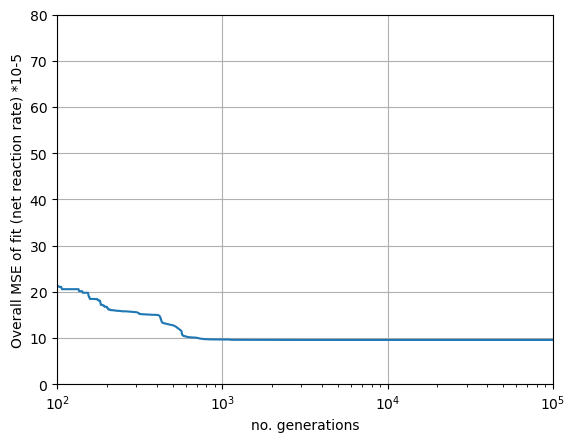

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

-0.8001485297819825
-7.9004982973842575
-1.170658709615739
-1.1796972169707907
-7.823770914598546
-1.5711995782629562
8.35266834397334
-1.1680448670354457
-7.314642502931183
5.879750664559921
-0.7102022776916567
-11.538860162917516
10.244154996312055
-1.2524546636170706
-7.407243575473983
-1.0215206515212515e-09
-1.2869432888450074
-7.063742682685675
-0.7857651547570434
9.794006928125086
3.2878620256473883
-1.7221594133741774e-08
-3.0304183761110663
-5.730208547528827
1.5322523512764805
-5.547227137218042
-1.3010299998924832


In [34]:
res.X

array([-8.00148530e-01, -7.90049830e+00, -1.17065871e+00, -1.17969722e+00,
       -7.82377091e+00, -1.57119958e+00,  8.35266834e+00, -1.16804487e+00,
       -7.31464250e+00,  5.87975066e+00, -7.10202278e-01, -1.15388602e+01,
        1.02441550e+01, -1.25245466e+00, -7.40724358e+00, -1.02152065e-09,
       -1.28694329e+00, -7.06374268e+00, -7.85765155e-01,  9.79400693e+00,
        3.28786203e+00, -1.72215941e-08, -3.03041838e+00, -5.73020855e+00,
        1.53225235e+00, -5.54722714e+00, -1.30103000e+00])

In [35]:
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]

for i in range(len (logkr)):
    print (logkr[i])

-0.8
-7.9
-1.1
-1.2
-7.8
-1.6
7.6
-1.1
-7.3
7.1
-0.7
-10.9
10.9
-0.3
-6.5
-0.9
-0.5
-0.4
-7.1
9.3
3.1
-1.3
-1.8
-6.4
1.0
-6.0


In [36]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-0.8: -0.8001485297819825
-7.9: -7.9004982973842575
-1.1: -1.170658709615739
-1.2: -1.1796972169707907
-7.8: -7.823770914598546
-1.6: -1.5711995782629562
7.6: 8.35266834397334
-1.1: -1.1680448670354457
-7.3: -7.314642502931183
7.1: 5.879750664559921
-0.7: -0.7102022776916567
-10.9: -11.538860162917516
10.9: 10.244154996312055
-0.3: -1.2524546636170706
-6.5: -7.407243575473983
-0.9: -1.0215206515212515e-09
-0.5: -1.2869432888450074
-0.4: -7.063742682685675
-7.1: -0.7857651547570434
9.3: 9.794006928125086
3.1: 3.2878620256473883
-1.3: -1.7221594133741774e-08
-1.8: -3.0304183761110663
-6.4: -5.730208547528827
1.0: 1.5322523512764805
-6.0: -5.547227137218042
R-value: 0.935754715735448
R2: 0.875636888021129


In [37]:
# Use stored solution
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]
y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = np.ndarray.tolist(res.X)
krseed10 = [-0.80013106, -7.90048631, -1.113374  , -1.20172925, -7.80646661,
       -1.59140719, 10.82452819, -1.12657771, -7.2926134 ,  6.44610218,
       -0.73454864, -4.39681733,  3.73751475, -0.34067922, -6.54667826,
       -0.89570931, -0.51063269, -0.41934632, -7.1000988 ,  9.08211941,
        2.87447549, -1.29184408, -1.81003059, -6.40451418,  1.87985236,
       -5.12809009, -1.30103   ]
krseed101 = [-8.00133321e-01, -7.90048630e+00, -1.17081146e+00, -1.17969685e+00,
       -7.82380784e+00, -1.57101511e+00,  8.18001929e+00, -1.16814357e+00,
       -7.31452666e+00,  5.60694049e+00, -7.09673531e-01, -4.23971756e+00,
        2.67234747e+00, -1.25239649e+00, -7.40720192e+00, -4.79181327e-09,
       -1.28693790e+00, -6.97072418e+00, -8.78777902e-01,  1.02261692e+01,
        3.72004947e+00, -3.00440634e-08, -3.02951390e+00, -5.73014133e+00,
        6.12993392e+00, -9.51377364e-01, -1.30103000e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

for i in range(len (meankr)):
    print (meankr[i])

R-value: 0.9326823034072406
R2: 0.8698962790890359
-0.8001376369273275
-7.90049030246142
-1.1516147232052465
-1.1870411056569303
-7.818015121532849
-1.5778739594209854
9.119071941324448
-1.1542553823451485
-7.307260854310395
5.977597778186641
-0.7181414828972189
-6.725131684305839
5.551339072104018
-0.9485101245390236
-7.120374585157994
-0.29856977193777795
-1.028171292948336
-4.817937727561891
-2.921547285585681
9.700765179375027
3.2941289952157966
-0.43061470908855254
-2.6233209553703554
-5.954954685842942
3.1806795437588264
-3.8755648637393474


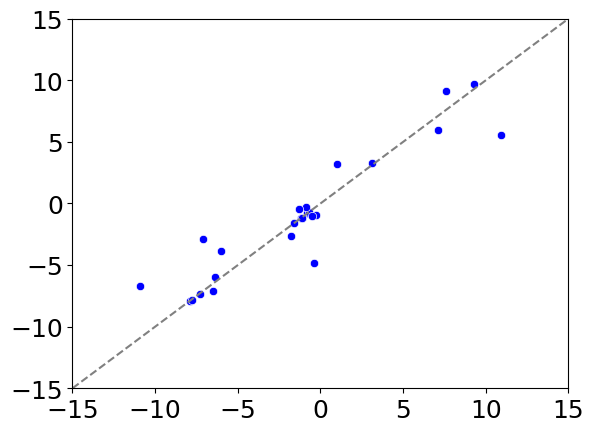

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()